<a href="https://colab.research.google.com/github/Jay99Sohn/Pgp-Inhibitor-Prediction/blob/main/SohnProject1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install biopython

from Bio import Entrez
from time import sleep
import os
from google.colab import drive

# --- Configuration ---

Entrez.email = "junghosohn8@gmail.com"
INTERVAL_YEARS = 5
START_YEAR = 1980
END_YEAR = 2025
MAX_RECORDS = 10000
RETMAX = 10000
SLEEP_TIME = 0.34

QUERY_BASE = '("P-glycoprotein" OR "P-gp" OR "ABCB1") AND (inhibit* OR substrate OR induc*) AND hasabstract[text] AND english[lang] AND (human)'
OUTPUT_DIR = "/content/drive/My Drive/PgpTextMining"
OUTPUT_FILE = "pmids.txt"
OUTPUT_PATH = os.path.join(OUTPUT_DIR, OUTPUT_FILE)

# Mount Google Drive
drive.mount('/content/drive')
os.makedirs(OUTPUT_DIR, exist_ok=True)
def get_year_ranges(start, end, interval):
    return [(y, min(y + interval - 1, end)) for y in range(start, end + 1, interval)]
def fetch_pmids_for_range(start_y, end_y):
    query = f'{QUERY_BASE} AND ("{start_y}"[PDAT] : "{end_y}"[PDAT])'
    handle = Entrez.esearch(db="pubmed", term=query, usehistory="y", retmax=0)
    result = Entrez.read(handle)
    handle.close()
    count = int(result["Count"])
    print(f" → Found {count} PMIDs")
    if count > MAX_RECORDS:
        raise RuntimeError(f"Too many results in {start_y}--{end_y} ({count}). Reduce interval.")
    pmids = []
    webenv = result["WebEnv"]
    query_key = result["QueryKey"]
    for start in range(0, count, RETMAX):
        print(f" Fetching {start + 1}--{min(start + RETMAX, count)}")
        handle = Entrez.esearch(
            db="pubmed",
            term=query,
            webenv=webenv,
            query_key=query_key,
            retstart=start,
            retmax=RETMAX,
            retmode="xml"
        )


        data = Entrez.read(handle)
        handle.close()
        pmids.extend(data["IdList"])
        sleep(SLEEP_TIME)

    return pmids

# --- Main Process ---

all_pmids = []
for start_y, end_y in get_year_ranges(START_YEAR, END_YEAR, INTERVAL_YEARS):
    print(f"\nSearching {start_y}--{end_y}")
    all_pmids.extend(fetch_pmids_for_range(start_y, end_y))

# Deduplicate and save
unique_pmids = list(dict.fromkeys(all_pmids))
with open(OUTPUT_PATH, "w") as f:
    f.write("\n".join(unique_pmids))

print(f"\nDone! {len(unique_pmids)} unique PMIDs saved to: {OUTPUT_PATH}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 31.7 MB/s eta 0:00:00
Mounted at /content/drive

Searching 1980--1984
 → Found 0 PMIDs

Searching 1985--1989
 → Found 51 PMIDs
 Fetching 1--51

Searching 1990--1994
 → Found 500 PMIDs
 Fetching 1--500

Searching 1995--1999
 → Found 1114 PMIDs
 Fetching 1--1114

Searching 2000--2004
 → Found 1772 PMIDs
 Fetching 1--1772

Searching 2005--2009
 → Found 2281 PMIDs
 Fetching 1--2281

Searching 2010--2014
 → Found 3095 PMIDs
 Fetching 1--3095

Searching 2015--2019
 → Found 3368 PMIDs
 Fetching 1--3368

Searching 2020--2024
 → Found 2558 PMIDs
 Fetching 1--2558

Searching 2025--2025
 → Found 271 PMIDs
 Fetching 1--271

Done! 14628 unique PMIDs saved to: /content/drive/My Drive/PgpTextMining/pmids.txt


In [ ]:
# --- 1. Import required libraries ---
from Bio import Entrez
import json
import os
import time
from google.colab import drive

# --- 2. Configuration ---
Entrez.email = "junghosohn8@gmail.com"

# Mount Google Drive
drive.mount('/content/drive')

# Define file paths and chunk size
BASE_DIR = "/content/drive/My Drive/PgpTextMining"
PMID_FILE = os.path.join(BASE_DIR, "pmids.txt")
CHUNK_LIST_FILE = os.path.join(BASE_DIR, "chunk_json_list.txt")
CHUNK_SIZE = 500

# --- 3. Define the Optimized Prompt for ChatGPT ---
prompt_messages = [
    {"role": "system", "content": "You are a helpful assistant."},
    {"role": "user", "content": (
        "From the given PubMed abstract, extract all interactions between P-glycoprotein and substances.\n\n"
        "Instructions:\n"
        "- Output a tab-delimited table without column headers. Use a single tab character ('\\t') to separate fields.\n"
        "- Do not wrap the output in code blocks (e.g., triple backticks) or any other formatting.\n"
        "- Output only the raw data rows—no explanations, no headings, no labels.\n"
        "- Each row must represent one unique interaction between P-glycoprotein and a substance.\n"
        "- For each interaction, include the following 4 fields, in this exact order:\n"
        "  1. Transporter name (use \"P-glycoprotein\")\n"
        "  2. Substance name\n"
        "  3. Interaction type (select one of: substrate, inhibitor, inducer, or other)\n"
        "  4. Mechanism of action (if specified; otherwise leave blank)\n"
        "- If the abstract contains no interactions, return only: none\n"
        "- Expand substance abbreviations only if their full form is defined in the abstract.\n\n"
        "Definitions:\n"
        "- Substrate: A substance transported by P-glycoprotein.\n"
        "- Inhibitor: A substance that reduces the transport activity of P-glycoprotein.\n"
        "- Inducer: A substance that increases the expression or activity of P-glycoprotein."
    )},
    {"role": "assistant", "content": "Please provide me with the abstract."}
]

# --- 4. Main Execution Block ---
print(f"Reading PMIDs from: {PMID_FILE}")
with open(PMID_FILE, 'r') as f:
    pmids = [line.strip() for line in f.readlines()]

print(f"Found {len(pmids)} PMIDs. Processing in chunks of {CHUNK_SIZE}...")

chunk_filenames = []
for i in range(0, len(pmids), CHUNK_SIZE):
    chunk_pmids = pmids[i:i + CHUNK_SIZE]
    chunk_filename = f"chunk_{i // CHUNK_SIZE}.jsonl"
    chunk_path = os.path.join(BASE_DIR, chunk_filename)
    chunk_filenames.append(chunk_filename)

    print(f"\nProcessing chunk {i // CHUNK_SIZE + 1} ({len(chunk_pmids)} PMIDs)...")
    print(f"Fetching abstracts...")

    # Fetch abstracts from PubMed using Entrez.efetch
    try:
        handle = Entrez.efetch(db="pubmed", id=chunk_pmids, rettype="medline", retmode="xml")
        records = Entrez.read(handle)
        handle.close()
    except Exception as e:
        print(f"  - An error occurred during fetching: {e}. Skipping this chunk.")
        continue

    print("Formatting data into JSONL file...")
    with open(chunk_path, 'w', encoding='utf-8') as outfile:
        # Check if records were actually returned
        if 'PubmedArticle' in records:
            for record in records['PubmedArticle']:
                pmid = record['MedlineCitation']['PMID']
                article = record['MedlineCitation']['Article']

                if 'Abstract' in article and 'AbstractText' in article['Abstract']:
                    abstract_text = ' '.join(article['Abstract']['AbstractText'])

                    # Create the JSON object for each API request
                    json_request = {
                        "custom_id": f"request-{pmid}",
                        "method": "POST",
                        "url": "/v1/chat/completions",
                        "body": {
                            # Corrected model name for the API call.
                            "model": "o3-mini",
                            "messages": prompt_messages + [{"role": "user", "content": abstract_text}],
                            "max_completion_tokens": 4000,

                        }
                    }
                    outfile.write(json.dumps(json_request) + '\n')
                else:
                    print(f"  - Warning: PMID {pmid} has no abstract. Skipping.")
        else:
            print("  - No valid records returned from Entrez for this chunk.")


    print(f"Chunk successfully saved to: {chunk_path}")
    # A small delay to be polite to the NCBI server between fetching chunks
    time.sleep(1)

# Save the list of all created chunk filenames for the next step
with open(CHUNK_LIST_FILE, 'w') as f:
    for name in chunk_filenames:
        f.write(name + '\n')

print(f"\nAll chunks processed! A list of filenames has been saved to: {CHUNK_LIST_FILE}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Reading PMIDs from: /content/drive/My Drive/PgpTextMining/pmids.txt
Found 14628 PMIDs. Processing in chunks of 500...

Processing chunk 1 (500 PMIDs)...
Fetching abstracts...
Formatting data into JSONL file...
Chunk successfully saved to: /content/drive/My Drive/PgpTextMining/chunk_0.jsonl

Processing chunk 2 (500 PMIDs)...
Fetching abstracts...
Formatting data into JSONL file...
Chunk successfully saved to: /content/drive/My Drive/PgpTextMining/chunk_1.jsonl

Processing chunk 3 (500 PMIDs)...
Fetching abstracts...
Formatting data into JSONL file...
  - Warning: PMID 9280813 has no abstract. Skipping.
Chunk successfully saved to: /content/drive/My Drive/PgpTextMining/chunk_2.jsonl

Processing chunk 4 (500 PMIDs)...
Fetching abstracts...
Formatting data into JSONL file...
Chunk successfully saved to: /content/drive/My Drive/PgpTextMining/chunk_3.jsonl

Process

In [ ]:
import os
from google.colab import drive

# Google Drive 마운트
drive.mount('/content/drive')

# 파일 경로 설정
FOLDER_PATH = "/content/drive/My Drive/PgpTextMining"
INPUT_FILE = "chunk_json_list.txt"

# 원본 파일 읽기
input_path = os.path.join(FOLDER_PATH, INPUT_FILE)

with open(input_path, "r", encoding="utf-8") as f:
    all_lines = [line.strip() for line in f if line.strip()]

total_files = len(all_lines)
print(f"총 {total_files}개 파일을 4개 그룹으로 나눕니다.")

# 4개 그룹으로 나누기 (7, 7, 8, 8)
group_sizes = [7, 7, 8, 8]
start_idx = 0

for group_num, group_size in enumerate(group_sizes, 1):
    end_idx = start_idx + group_size
    group_lines = all_lines[start_idx:end_idx]

    # 각 그룹별 파일 생성
    output_file = f"chunk_json_list_{group_num}.txt"
    output_path = os.path.join(FOLDER_PATH, output_file)

    with open(output_path, "w", encoding="utf-8") as f:
        for line in group_lines:
            f.write(line + "\n")

    print(f"그룹 {group_num}: {output_file} ({group_size}개 파일)")
    start_idx = end_idx

print("파일 분할 완료!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
총 30개 파일을 4개 그룹으로 나눕니다.
그룹 1: chunk_json_list_1.txt (7개 파일)
그룹 2: chunk_json_list_2.txt (7개 파일)
그룹 3: chunk_json_list_3.txt (8개 파일)
그룹 4: chunk_json_list_4.txt (8개 파일)
파일 분할 완료!


In [ ]:
import os #Listing S2
import time
import json
import requests
from google.colab import drive

# --- Configuration ---
API_KEY = ""
BASE_URL = "https://api.openai.com/v1"
HEADERS = {'Authorization': f'Bearer {API_KEY}'}
DRIVE_PATH = "/content/drive"
FOLDER_PATH = os.path.join(DRIVE_PATH, "My Drive/PgpTextMining")

# --- Separating Groups ---
GROUP_NUMBER = 1

INPUT_FILE = f"chunk_json_list_{GROUP_NUMBER}.txt"
OUTPUT_FILE = f"batch_id_list_{GROUP_NUMBER}.txt"

# --- Initialize session ---
session = requests.Session()
session.headers.update(HEADERS)

# --- Utility functions ---
def request_with_retry(method, url, **kwargs):
    """Send HTTP request with retry logic."""
    for attempt in range(3):
        try:
            response = session.request(method, url, **kwargs)
            if response.ok:
                return response.json()
            print(f"[HTTP {response.status_code}] {response.text}")
        except Exception as e:
            print(f"Request error (attempt {attempt + 1}): {e}")
        time.sleep(2)
    return None

def upload_file(filepath, purpose="batch"):
    """Upload a file to OpenAI for batch processing."""
    if not os.path.exists(filepath):
        print(f"File not found: {filepath}")
        return None

    with open(filepath, 'rb') as f:
        files = {'file': f, 'purpose': (None, purpose)}
        return request_with_retry("POST", f"{BASE_URL}/files", files=files)

def start_batch(file_id):
    """Start batch processing with the given file ID."""
    data = {
        'input_file_id': file_id,
        'endpoint': '/v1/chat/completions',
        'completion_window': '24h'
    }
    res = request_with_retry("POST", f"{BASE_URL}/batches", json=data)
    return res.get("id") if res else None

def process_files():
    """Upload input files and start batch jobs. Save batch IDs."""
    input_path = os.path.join(FOLDER_PATH, INPUT_FILE)
    output_path = os.path.join(FOLDER_PATH, OUTPUT_FILE)

    if not os.path.exists(input_path):
        print(f"Input file not found: {input_path}")
        return

    with open(input_path, "r", encoding="utf-8") as f:
        filenames = [line.strip() for line in f if line.strip()]

    if not filenames:
        print("No filenames found in input.")
        return

    with open(output_path, "a", encoding="utf-8") as out_f:
        for name in filenames:
            filepath = os.path.join(FOLDER_PATH, name)
            file_res = upload_file(filepath)

            if file_res and (file_id := file_res.get("id")):
                batch_id = start_batch(file_id)
                if batch_id:
                    print(f"Uploaded: {name}, Batch ID: {batch_id}")
                    out_f.write(batch_id + "\n")
                else:
                    print(f"Failed to start batch for: {name}")
            else:
                print(f"Failed to upload file: {name}")

            time.sleep(180)

# --- Execute ---
if __name__ == "__main__":
    drive.mount(DRIVE_PATH, force_remount=True)
    os.makedirs(FOLDER_PATH, exist_ok=True)
    process_files()

Mounted at /content/drive
Uploaded: chunk_0.jsonl, Batch ID: batch_686ddec011108190b252cd4211a53be8
Uploaded: chunk_1.jsonl, Batch ID: batch_686ddf7562348190bb5ea5281d482594
Uploaded: chunk_2.jsonl, Batch ID: batch_686de02ab600819084055bac8f69fe9c
Uploaded: chunk_3.jsonl, Batch ID: batch_686de0e047c8819086a4bfc4a57d9b8b
Uploaded: chunk_4.jsonl, Batch ID: batch_686de195496c8190b09261b7b219bb26
Uploaded: chunk_5.jsonl, Batch ID: batch_686de24a23bc819083dcd5ea5b21476c
Uploaded: chunk_6.jsonl, Batch ID: batch_686de2fef4608190b8addcaddd920628


In [ ]:
import os #Listing S3
import json
import time
import requests
from google.colab import drive

# --- Configuration ---
API_KEY = ""
BASE_URL = "https://api.openai.com/v1"
HEADERS = {'Authorization': f'Bearer {API_KEY}'}
DRIVE_PATH = "/content/drive"
FOLDER_PATH = os.path.join(DRIVE_PATH, "My Drive/PgpTextMining")

# --- Group number ---
GROUP_NUMBER = 1

INPUT_FILE = f"batch_id_list_{GROUP_NUMBER}.txt"
OUTPUT_FILE = f"result_{GROUP_NUMBER}.txt"

# --- Initialize session ---
session = requests.Session()
session.headers.update(HEADERS)

# --- Utility functions ---
def request_with_retry(method, url, **kwargs):
    """Send HTTP request with retry logic."""
    for attempt in range(3):
        try:
            response = session.request(method, url, **kwargs)
            if response.ok:
                return response.json()
            print(f"[HTTP {response.status_code}] {response.text}")
        except Exception as e:
            print(f"Request error (attempt {attempt + 1}): {e}")
        time.sleep(2)
    return None

def check_batch_status(batch_id):
    """Return (status, output_file_id) for a given batch ID."""
    res = request_with_retry("GET", f"{BASE_URL}/batches/{batch_id}")
    if not res:
        print(f"Failed to retrieve status for batch: {batch_id}")
        return None, None
    return res.get("status"), res.get("output_file_id")

def download_results(file_id):
    """Download output file content from OpenAI."""
    try:
        response = session.get(f"{BASE_URL}/files/{file_id}/content")
        if response.ok:
            return response.text
        print(f"Download failed for file {file_id} (status {response.status_code})")
    except Exception as e:
        print(f"Download error for file {file_id}: {e}")
    return None

def parse_and_write_results(response_text, output_file):
    """Parse OpenAI batch response and write formatted result."""
    for line in response_text.splitlines():
        time.sleep(0.02)  # Throttle for readability or rate-limiting
        try:
            json_obj = json.loads(line)
            pmid = json_obj.get("custom_id", "unknown").split("-")[1] if "custom_id" in json_obj else "unknown"
            choices = json_obj.get("response", {}).get("body", {}).get("choices", [])
            if choices:
                content = choices[0].get("message", {}).get("content", "")
                for entry in content.splitlines():
                    clean_entry = entry.replace('\\t', '\t')
                    output_file.write(f"{pmid}\t{clean_entry}\n")
        except (json.JSONDecodeError, IndexError) as e:
            print(f"Error parsing line: {e}")

# --- Main process ---
def main():
    drive.mount(DRIVE_PATH, force_remount=True)
    os.makedirs(FOLDER_PATH, exist_ok=True)

    input_path = os.path.join(FOLDER_PATH, INPUT_FILE)
    output_path = os.path.join(FOLDER_PATH, OUTPUT_FILE)

    if not os.path.exists(input_path):
        print(f"Input file not found: {input_path}")
        return

    with open(input_path, "r", encoding="utf-8") as f:
        batch_ids = [line.strip() for line in f if line.strip()]

    output_ids = []
    for batch_id in batch_ids:
        status, file_id = check_batch_status(batch_id)
        if status == "completed":
            output_ids.append(file_id)
        elif status == "in_progress":
            print(f"Batch {batch_id} is still in progress.")
            return
        else:
            print(f"Batch {batch_id} has failed or expired.")

    if not output_ids:
        print("No completed batch outputs found.")
        return

    with open(output_path, "w", encoding="utf-8") as out_file:
        for file_id in output_ids:
            result_text = download_results(file_id)
            if result_text:
                parse_and_write_results(result_text, out_file)

    print(f"Results written to: {output_path}")

# --- Execute ---
if __name__ == "__main__":
    main()

Mounted at /content/drive
Results written to: /content/drive/My Drive/PgpTextMining/result_1.txt


In [ ]:
import os #Listing S2
import time
import json
import requests
from google.colab import drive

# --- Configuration ---
API_KEY = ""
BASE_URL = "https://api.openai.com/v1"
HEADERS = {'Authorization': f'Bearer {API_KEY}'}
DRIVE_PATH = "/content/drive"
FOLDER_PATH = os.path.join(DRIVE_PATH, "My Drive/PgpTextMining")

# --- Separating Groups ---
GROUP_NUMBER = 2

INPUT_FILE = f"chunk_json_list_{GROUP_NUMBER}.txt"
OUTPUT_FILE = f"batch_id_list_{GROUP_NUMBER}.txt"

# --- Initialize session ---
session = requests.Session()
session.headers.update(HEADERS)

# --- Utility functions ---
def request_with_retry(method, url, **kwargs):
    """Send HTTP request with retry logic."""
    for attempt in range(3):
        try:
            response = session.request(method, url, **kwargs)
            if response.ok:
                return response.json()
            print(f"[HTTP {response.status_code}] {response.text}")
        except Exception as e:
            print(f"Request error (attempt {attempt + 1}): {e}")
        time.sleep(2)
    return None

def upload_file(filepath, purpose="batch"):
    """Upload a file to OpenAI for batch processing."""
    if not os.path.exists(filepath):
        print(f"File not found: {filepath}")
        return None

    with open(filepath, 'rb') as f:
        files = {'file': f, 'purpose': (None, purpose)}
        return request_with_retry("POST", f"{BASE_URL}/files", files=files)

def start_batch(file_id):
    """Start batch processing with the given file ID."""
    data = {
        'input_file_id': file_id,
        'endpoint': '/v1/chat/completions',
        'completion_window': '24h'
    }
    res = request_with_retry("POST", f"{BASE_URL}/batches", json=data)
    return res.get("id") if res else None

def process_files():
    """Upload input files and start batch jobs. Save batch IDs."""
    input_path = os.path.join(FOLDER_PATH, INPUT_FILE)
    output_path = os.path.join(FOLDER_PATH, OUTPUT_FILE)

    if not os.path.exists(input_path):
        print(f"Input file not found: {input_path}")
        return

    with open(input_path, "r", encoding="utf-8") as f:
        filenames = [line.strip() for line in f if line.strip()]

    if not filenames:
        print("No filenames found in input.")
        return

    with open(output_path, "a", encoding="utf-8") as out_f:
        for name in filenames:
            filepath = os.path.join(FOLDER_PATH, name)
            file_res = upload_file(filepath)

            if file_res and (file_id := file_res.get("id")):
                batch_id = start_batch(file_id)
                if batch_id:
                    print(f"Uploaded: {name}, Batch ID: {batch_id}")
                    out_f.write(batch_id + "\n")
                else:
                    print(f"Failed to start batch for: {name}")
            else:
                print(f"Failed to upload file: {name}")

            time.sleep(180)

# --- Execute ---
if __name__ == "__main__":
    drive.mount(DRIVE_PATH, force_remount=True)
    os.makedirs(FOLDER_PATH, exist_ok=True)
    process_files()

Mounted at /content/drive
Uploaded: chunk_7.jsonl, Batch ID: batch_686f0a014da881908dba97ab0b832618
Uploaded: chunk_8.jsonl, Batch ID: batch_686f0ab731348190a5b58ef322926157
Uploaded: chunk_9.jsonl, Batch ID: batch_686f0b6ca028819093456577bd1a2778
Uploaded: chunk_10.jsonl, Batch ID: batch_686f0c21cba08190bb0f2fe7abc02fb0
Uploaded: chunk_11.jsonl, Batch ID: batch_686f0cda44bc819081fa01bbf98b74a2
Uploaded: chunk_12.jsonl, Batch ID: batch_686f0d9057388190834ce7dc70b9890f
Uploaded: chunk_13.jsonl, Batch ID: batch_686f0e45eca48190942844f6bb62b6d1


In [ ]:
import os #Listing S3
import json
import time
import requests
from google.colab import drive

# --- Configuration ---
API_KEY = ""
BASE_URL = "https://api.openai.com/v1"
HEADERS = {'Authorization': f'Bearer {API_KEY}'}
DRIVE_PATH = "/content/drive"
FOLDER_PATH = os.path.join(DRIVE_PATH, "My Drive/PgpTextMining")

# --- Group number ---
GROUP_NUMBER = 2

INPUT_FILE = f"batch_id_list_{GROUP_NUMBER}.txt"
OUTPUT_FILE = f"result_{GROUP_NUMBER}.txt"

# --- Initialize session ---
session = requests.Session()
session.headers.update(HEADERS)

# --- Utility functions ---
def request_with_retry(method, url, **kwargs):
    """Send HTTP request with retry logic."""
    for attempt in range(3):
        try:
            response = session.request(method, url, **kwargs)
            if response.ok:
                return response.json()
            print(f"[HTTP {response.status_code}] {response.text}")
        except Exception as e:
            print(f"Request error (attempt {attempt + 1}): {e}")
        time.sleep(2)
    return None

def check_batch_status(batch_id):
    """Return (status, output_file_id) for a given batch ID."""
    res = request_with_retry("GET", f"{BASE_URL}/batches/{batch_id}")
    if not res:
        print(f"Failed to retrieve status for batch: {batch_id}")
        return None, None
    return res.get("status"), res.get("output_file_id")

def download_results(file_id):
    """Download output file content from OpenAI."""
    try:
        response = session.get(f"{BASE_URL}/files/{file_id}/content")
        if response.ok:
            return response.text
        print(f"Download failed for file {file_id} (status {response.status_code})")
    except Exception as e:
        print(f"Download error for file {file_id}: {e}")
    return None

def parse_and_write_results(response_text, output_file):
    """Parse OpenAI batch response and write formatted result."""
    for line in response_text.splitlines():
        time.sleep(0.02)  # Throttle for readability or rate-limiting
        try:
            json_obj = json.loads(line)
            pmid = json_obj.get("custom_id", "unknown").split("-")[1] if "custom_id" in json_obj else "unknown"
            choices = json_obj.get("response", {}).get("body", {}).get("choices", [])
            if choices:
                content = choices[0].get("message", {}).get("content", "")
                for entry in content.splitlines():
                    clean_entry = entry.replace('\\t', '\t')
                    output_file.write(f"{pmid}\t{clean_entry}\n")
        except (json.JSONDecodeError, IndexError) as e:
            print(f"Error parsing line: {e}")

# --- Main process ---
def main():
    drive.mount(DRIVE_PATH, force_remount=True)
    os.makedirs(FOLDER_PATH, exist_ok=True)

    input_path = os.path.join(FOLDER_PATH, INPUT_FILE)
    output_path = os.path.join(FOLDER_PATH, OUTPUT_FILE)

    if not os.path.exists(input_path):
        print(f"Input file not found: {input_path}")
        return

    with open(input_path, "r", encoding="utf-8") as f:
        batch_ids = [line.strip() for line in f if line.strip()]

    output_ids = []
    for batch_id in batch_ids:
        status, file_id = check_batch_status(batch_id)
        if status == "completed":
            output_ids.append(file_id)
        elif status == "in_progress":
            print(f"Batch {batch_id} is still in progress.")
            return
        else:
            print(f"Batch {batch_id} has failed or expired.")

    if not output_ids:
        print("No completed batch outputs found.")
        return

    with open(output_path, "w", encoding="utf-8") as out_file:
        for file_id in output_ids:
            result_text = download_results(file_id)
            if result_text:
                parse_and_write_results(result_text, out_file)

    print(f"Results written to: {output_path}")

# --- Execute ---
if __name__ == "__main__":
    main()

Mounted at /content/drive
Results written to: /content/drive/My Drive/PgpTextMining/result_2.txt


In [ ]:
import os #Listing S2
import time
import json
import requests
from google.colab import drive

# --- Configuration ---
API_KEY = ""
BASE_URL = "https://api.openai.com/v1"
HEADERS = {'Authorization': f'Bearer {API_KEY}'}
DRIVE_PATH = "/content/drive"
FOLDER_PATH = os.path.join(DRIVE_PATH, "My Drive/PgpTextMining")

# --- Separating Groups ---
GROUP_NUMBER = 3

INPUT_FILE = f"chunk_json_list_{GROUP_NUMBER}.txt"
OUTPUT_FILE = f"batch_id_list_{GROUP_NUMBER}.txt"

# --- Initialize session ---
session = requests.Session()
session.headers.update(HEADERS)

# --- Utility functions ---
def request_with_retry(method, url, **kwargs):
    """Send HTTP request with retry logic."""
    for attempt in range(3):
        try:
            response = session.request(method, url, **kwargs)
            if response.ok:
                return response.json()
            print(f"[HTTP {response.status_code}] {response.text}")
        except Exception as e:
            print(f"Request error (attempt {attempt + 1}): {e}")
        time.sleep(2)
    return None

def upload_file(filepath, purpose="batch"):
    """Upload a file to OpenAI for batch processing."""
    if not os.path.exists(filepath):
        print(f"File not found: {filepath}")
        return None

    with open(filepath, 'rb') as f:
        files = {'file': f, 'purpose': (None, purpose)}
        return request_with_retry("POST", f"{BASE_URL}/files", files=files)

def start_batch(file_id):
    """Start batch processing with the given file ID."""
    data = {
        'input_file_id': file_id,
        'endpoint': '/v1/chat/completions',
        'completion_window': '24h'
    }
    res = request_with_retry("POST", f"{BASE_URL}/batches", json=data)
    return res.get("id") if res else None

def process_files():
    """Upload input files and start batch jobs. Save batch IDs."""
    input_path = os.path.join(FOLDER_PATH, INPUT_FILE)
    output_path = os.path.join(FOLDER_PATH, OUTPUT_FILE)

    if not os.path.exists(input_path):
        print(f"Input file not found: {input_path}")
        return

    with open(input_path, "r", encoding="utf-8") as f:
        filenames = [line.strip() for line in f if line.strip()]

    if not filenames:
        print("No filenames found in input.")
        return

    with open(output_path, "a", encoding="utf-8") as out_f:
        for name in filenames:
            filepath = os.path.join(FOLDER_PATH, name)
            file_res = upload_file(filepath)

            if file_res and (file_id := file_res.get("id")):
                batch_id = start_batch(file_id)
                if batch_id:
                    print(f"Uploaded: {name}, Batch ID: {batch_id}")
                    out_f.write(batch_id + "\n")
                else:
                    print(f"Failed to start batch for: {name}")
            else:
                print(f"Failed to upload file: {name}")

            time.sleep(180)

# --- Execute ---
if __name__ == "__main__":
    drive.mount(DRIVE_PATH, force_remount=True)
    os.makedirs(FOLDER_PATH, exist_ok=True)
    process_files()

Mounted at /content/drive
Uploaded: chunk_14.jsonl, Batch ID: batch_686f410f4afc8190915e8c6d94ead7b1
Uploaded: chunk_15.jsonl, Batch ID: batch_686f41c4486c81908502a47166422498
Uploaded: chunk_16.jsonl, Batch ID: batch_686f4279fa08819097cca7e2a900ac9e
Uploaded: chunk_17.jsonl, Batch ID: batch_686f432f8ea08190ad7e9b9321ad0a99
Uploaded: chunk_18.jsonl, Batch ID: batch_686f43e4b1a881908f85bc793b9614a1
Uploaded: chunk_19.jsonl, Batch ID: batch_686f449b844c8190b766f1dfc93cb829
Uploaded: chunk_20.jsonl, Batch ID: batch_686f4551d3ec81909be4140cf8141c1e
Uploaded: chunk_21.jsonl, Batch ID: batch_686f46070820819094fe96653107fe16


In [ ]:
import os #Listing S3
import json
import time
import requests
from google.colab import drive

# --- Configuration ---
API_KEY = ""
BASE_URL = "https://api.openai.com/v1"
HEADERS = {'Authorization': f'Bearer {API_KEY}'}
DRIVE_PATH = "/content/drive"
FOLDER_PATH = os.path.join(DRIVE_PATH, "My Drive/PgpTextMining")

# --- Group number ---
GROUP_NUMBER = 3

INPUT_FILE = f"batch_id_list_{GROUP_NUMBER}.txt"
OUTPUT_FILE = f"result_{GROUP_NUMBER}.txt"

# --- Initialize session ---
session = requests.Session()
session.headers.update(HEADERS)

# --- Utility functions ---
def request_with_retry(method, url, **kwargs):
    """Send HTTP request with retry logic."""
    for attempt in range(3):
        try:
            response = session.request(method, url, **kwargs)
            if response.ok:
                return response.json()
            print(f"[HTTP {response.status_code}] {response.text}")
        except Exception as e:
            print(f"Request error (attempt {attempt + 1}): {e}")
        time.sleep(2)
    return None

def check_batch_status(batch_id):
    """Return (status, output_file_id) for a given batch ID."""
    res = request_with_retry("GET", f"{BASE_URL}/batches/{batch_id}")
    if not res:
        print(f"Failed to retrieve status for batch: {batch_id}")
        return None, None
    return res.get("status"), res.get("output_file_id")

def download_results(file_id):
    """Download output file content from OpenAI."""
    try:
        response = session.get(f"{BASE_URL}/files/{file_id}/content")
        if response.ok:
            return response.text
        print(f"Download failed for file {file_id} (status {response.status_code})")
    except Exception as e:
        print(f"Download error for file {file_id}: {e}")
    return None

def parse_and_write_results(response_text, output_file):
    """Parse OpenAI batch response and write formatted result."""
    for line in response_text.splitlines():
        time.sleep(0.02)  # Throttle for readability or rate-limiting
        try:
            json_obj = json.loads(line)
            pmid = json_obj.get("custom_id", "unknown").split("-")[1] if "custom_id" in json_obj else "unknown"
            choices = json_obj.get("response", {}).get("body", {}).get("choices", [])
            if choices:
                content = choices[0].get("message", {}).get("content", "")
                for entry in content.splitlines():
                    clean_entry = entry.replace('\\t', '\t')
                    output_file.write(f"{pmid}\t{clean_entry}\n")
        except (json.JSONDecodeError, IndexError) as e:
            print(f"Error parsing line: {e}")

# --- Main process ---
def main():
    drive.mount(DRIVE_PATH, force_remount=True)
    os.makedirs(FOLDER_PATH, exist_ok=True)

    input_path = os.path.join(FOLDER_PATH, INPUT_FILE)
    output_path = os.path.join(FOLDER_PATH, OUTPUT_FILE)

    if not os.path.exists(input_path):
        print(f"Input file not found: {input_path}")
        return

    with open(input_path, "r", encoding="utf-8") as f:
        batch_ids = [line.strip() for line in f if line.strip()]

    output_ids = []
    for batch_id in batch_ids:
        status, file_id = check_batch_status(batch_id)
        if status == "completed":
            output_ids.append(file_id)
        elif status == "in_progress":
            print(f"Batch {batch_id} is still in progress.")
            return
        else:
            print(f"Batch {batch_id} has failed or expired.")

    if not output_ids:
        print("No completed batch outputs found.")
        return

    with open(output_path, "w", encoding="utf-8") as out_file:
        for file_id in output_ids:
            result_text = download_results(file_id)
            if result_text:
                parse_and_write_results(result_text, out_file)

    print(f"Results written to: {output_path}")

# --- Execute ---
if __name__ == "__main__":
    main()

Mounted at /content/drive
Results written to: /content/drive/My Drive/PgpTextMining/result_3.txt


In [ ]:
import os #Listing S2
import time
import json
import requests
from google.colab import drive

# --- Configuration ---
API_KEY = ""
BASE_URL = "https://api.openai.com/v1"
HEADERS = {'Authorization': f'Bearer {API_KEY}'}
DRIVE_PATH = "/content/drive"
FOLDER_PATH = os.path.join(DRIVE_PATH, "My Drive/PgpTextMining")

# --- Separating Groups ---
GROUP_NUMBER = 4

INPUT_FILE = f"chunk_json_list_{GROUP_NUMBER}.txt"
OUTPUT_FILE = f"batch_id_list_{GROUP_NUMBER}.txt"

# --- Initialize session ---
session = requests.Session()
session.headers.update(HEADERS)

# --- Utility functions ---
def request_with_retry(method, url, **kwargs):
    """Send HTTP request with retry logic."""
    for attempt in range(3):
        try:
            response = session.request(method, url, **kwargs)
            if response.ok:
                return response.json()
            print(f"[HTTP {response.status_code}] {response.text}")
        except Exception as e:
            print(f"Request error (attempt {attempt + 1}): {e}")
        time.sleep(2)
    return None

def upload_file(filepath, purpose="batch"):
    """Upload a file to OpenAI for batch processing."""
    if not os.path.exists(filepath):
        print(f"File not found: {filepath}")
        return None

    with open(filepath, 'rb') as f:
        files = {'file': f, 'purpose': (None, purpose)}
        return request_with_retry("POST", f"{BASE_URL}/files", files=files)

def start_batch(file_id):
    """Start batch processing with the given file ID."""
    data = {
        'input_file_id': file_id,
        'endpoint': '/v1/chat/completions',
        'completion_window': '24h'
    }
    res = request_with_retry("POST", f"{BASE_URL}/batches", json=data)
    return res.get("id") if res else None

def process_files():
    """Upload input files and start batch jobs. Save batch IDs."""
    input_path = os.path.join(FOLDER_PATH, INPUT_FILE)
    output_path = os.path.join(FOLDER_PATH, OUTPUT_FILE)

    if not os.path.exists(input_path):
        print(f"Input file not found: {input_path}")
        return

    with open(input_path, "r", encoding="utf-8") as f:
        filenames = [line.strip() for line in f if line.strip()]

    if not filenames:
        print("No filenames found in input.")
        return

    with open(output_path, "a", encoding="utf-8") as out_f:
        for name in filenames:
            filepath = os.path.join(FOLDER_PATH, name)
            file_res = upload_file(filepath)

            if file_res and (file_id := file_res.get("id")):
                batch_id = start_batch(file_id)
                if batch_id:
                    print(f"Uploaded: {name}, Batch ID: {batch_id}")
                    out_f.write(batch_id + "\n")
                else:
                    print(f"Failed to start batch for: {name}")
            else:
                print(f"Failed to upload file: {name}")

            time.sleep(180)

# --- Execute ---
if __name__ == "__main__":
    drive.mount(DRIVE_PATH, force_remount=True)
    os.makedirs(FOLDER_PATH, exist_ok=True)
    process_files()

Mounted at /content/drive
Uploaded: chunk_22.jsonl, Batch ID: batch_686f5ba565d881908e655553c4f30278
Uploaded: chunk_23.jsonl, Batch ID: batch_686f5c5a781081908d64c145fefcab76
Uploaded: chunk_24.jsonl, Batch ID: batch_686f5d0f7bc88190a3be8567d22cac8d
Uploaded: chunk_25.jsonl, Batch ID: batch_686f5dc5007081909ffa596e5a0ef192
Uploaded: chunk_26.jsonl, Batch ID: batch_686f5e7a44708190a1e4176ac16e9c3e
Uploaded: chunk_27.jsonl, Batch ID: batch_686f5f2fbfb081908bf4352813f3c466
Uploaded: chunk_28.jsonl, Batch ID: batch_686f5fe5133c81909e7741d658c411ad
Uploaded: chunk_29.jsonl, Batch ID: batch_686f609a134c81909c69f280f1753708


In [ ]:
import os #Listing S3
import json
import time
import requests
from google.colab import drive

# --- Configuration ---
API_KEY = ""
BASE_URL = "https://api.openai.com/v1"
HEADERS = {'Authorization': f'Bearer {API_KEY}'}
DRIVE_PATH = "/content/drive"
FOLDER_PATH = os.path.join(DRIVE_PATH, "My Drive/PgpTextMining")

# --- Group number ---
GROUP_NUMBER = 4

INPUT_FILE = f"batch_id_list_{GROUP_NUMBER}.txt"
OUTPUT_FILE = f"result_{GROUP_NUMBER}.txt"

# --- Initialize session ---
session = requests.Session()
session.headers.update(HEADERS)

# --- Utility functions ---
def request_with_retry(method, url, **kwargs):
    """Send HTTP request with retry logic."""
    for attempt in range(3):
        try:
            response = session.request(method, url, **kwargs)
            if response.ok:
                return response.json()
            print(f"[HTTP {response.status_code}] {response.text}")
        except Exception as e:
            print(f"Request error (attempt {attempt + 1}): {e}")
        time.sleep(2)
    return None

def check_batch_status(batch_id):
    """Return (status, output_file_id) for a given batch ID."""
    res = request_with_retry("GET", f"{BASE_URL}/batches/{batch_id}")
    if not res:
        print(f"Failed to retrieve status for batch: {batch_id}")
        return None, None
    return res.get("status"), res.get("output_file_id")

def download_results(file_id):
    """Download output file content from OpenAI."""
    try:
        response = session.get(f"{BASE_URL}/files/{file_id}/content")
        if response.ok:
            return response.text
        print(f"Download failed for file {file_id} (status {response.status_code})")
    except Exception as e:
        print(f"Download error for file {file_id}: {e}")
    return None

def parse_and_write_results(response_text, output_file):
    """Parse OpenAI batch response and write formatted result."""
    for line in response_text.splitlines():
        time.sleep(0.02)  # Throttle for readability or rate-limiting
        try:
            json_obj = json.loads(line)
            pmid = json_obj.get("custom_id", "unknown").split("-")[1] if "custom_id" in json_obj else "unknown"
            choices = json_obj.get("response", {}).get("body", {}).get("choices", [])
            if choices:
                content = choices[0].get("message", {}).get("content", "")
                for entry in content.splitlines():
                    clean_entry = entry.replace('\\t', '\t')
                    output_file.write(f"{pmid}\t{clean_entry}\n")
        except (json.JSONDecodeError, IndexError) as e:
            print(f"Error parsing line: {e}")

# --- Main process ---
def main():
    drive.mount(DRIVE_PATH, force_remount=True)
    os.makedirs(FOLDER_PATH, exist_ok=True)

    input_path = os.path.join(FOLDER_PATH, INPUT_FILE)
    output_path = os.path.join(FOLDER_PATH, OUTPUT_FILE)

    if not os.path.exists(input_path):
        print(f"Input file not found: {input_path}")
        return

    with open(input_path, "r", encoding="utf-8") as f:
        batch_ids = [line.strip() for line in f if line.strip()]

    output_ids = []
    for batch_id in batch_ids:
        status, file_id = check_batch_status(batch_id)
        if status == "completed":
            output_ids.append(file_id)
        elif status == "in_progress":
            print(f"Batch {batch_id} is still in progress.")
            return
        else:
            print(f"Batch {batch_id} has failed or expired.")

    if not output_ids:
        print("No completed batch outputs found.")
        return

    with open(output_path, "w", encoding="utf-8") as out_file:
        for file_id in output_ids:
            result_text = download_results(file_id)
            if result_text:
                parse_and_write_results(result_text, out_file)

    print(f"Results written to: {output_path}")

# --- Execute ---
if __name__ == "__main__":
    main()

Mounted at /content/drive
Results written to: /content/drive/My Drive/PgpTextMining/result_4.txt


In [ ]:
import os
import requests
import time
from google.colab import drive

# --- Configuration ---
# Please replace with your actual API key
API_KEY = ""
BASE_URL = "https://api.openai.com/v1"
HEADERS = {'Authorization': f'Bearer {API_KEY}'}

# Mount Google Drive
drive.mount('/content/drive')
BASE_DIR = "/content/drive/My Drive/PgpTextMining"

# --- Function to check batch status ---
def get_failed_request_count(batch_id):
    """
    Fetches the status for a single batch ID and returns the number of failed requests.
    This function isolates the logic for one API call, making the main code cleaner.
    """
    try:
        response = requests.get(f"{BASE_URL}/batches/{batch_id}", headers=HEADERS)
        if response.ok:
            status_info = response.json()
            # This is the core logic for this function:
            # It safely gets the number of failed requests from the JSON response.
            # .get() is used to avoid errors if a key doesn't exist.
            failed_count = status_info.get('request_counts', {}).get('failed', 0)
            return failed_count
        else:
            print(f"  - Error checking {batch_id}: HTTP {response.status_code}")
            return 0 # Return 0 if we can't get the status
    except requests.exceptions.RequestException as e:
        print(f"  - Network error checking {batch_id}: {e}")
        return 0

# --- Main process ---
# This loop will run 4 times, for group 1, 2, 3, and 4.
for group_num in range(1, 5):
    batch_list_file = os.path.join(BASE_DIR, f"batch_id_list_{group_num}.txt")
    total_failed_for_group = 0

    if not os.path.exists(batch_list_file):
        print(f"\nFile not found for Group {group_num}: {batch_list_file}")
        continue

    print(f"\n--- Processing Group {group_num} ---")
    with open(batch_list_file, 'r') as f:
        # Reads all batch IDs from the current group file.
        batch_ids = [line.strip() for line in f if line.strip()]

    print(f"Found {len(batch_ids)} batches to check.")

    # This loop iterates through each batch ID within the group.
    for batch_id in batch_ids:
        failed_count = get_failed_request_count(batch_id)
        total_failed_for_group += failed_count
        # This print statement shows the progress for each batch ID.
        print(f"  - Batch {batch_id}: {failed_count} failed requests.")
        # A short delay to be polite to the OpenAI API and avoid rate limits.
        time.sleep(1)

    # After checking all batches in the group, print the summary.
    # This gives us the final answer for each batch group file.
    print(f"\n>>> Summary for Group {group_num}: Total Failed Requests = {total_failed_for_group}")

print("\nAll groups checked.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

--- Processing Group 1 ---
Found 7 batches to check.
  - Batch batch_686ddec011108190b252cd4211a53be8: 0 failed requests.
  - Batch batch_686ddf7562348190bb5ea5281d482594: 0 failed requests.
  - Batch batch_686de02ab600819084055bac8f69fe9c: 0 failed requests.
  - Batch batch_686de0e047c8819086a4bfc4a57d9b8b: 0 failed requests.
  - Batch batch_686de195496c8190b09261b7b219bb26: 0 failed requests.
  - Batch batch_686de24a23bc819083dcd5ea5b21476c: 0 failed requests.
  - Batch batch_686de2fef4608190b8addcaddd920628: 0 failed requests.

>>> Summary for Group 1: Total Failed Requests = 0

--- Processing Group 2 ---
Found 7 batches to check.
  - Batch batch_686f0a014da881908dba97ab0b832618: 0 failed requests.
  - Batch batch_686f0ab731348190a5b58ef322926157: 0 failed requests.
  - Batch batch_686f0b6ca028819093456577bd1a2778: 0 failed requests.
  - Batch batch_686f0

In [ ]:
import os
import requests
import json
from google.colab import drive

# --- ⚙️ 설정 (Configuration) ---
# 1. 연구원님의 API 키를 입력해주세요.
API_KEY = ""

# 2. 실패가 발생한 Batch ID를 입력해주세요.
BATCH_ID = "batch_686f43e4b1a881908f85bc793b9614a1"

# 3. ‼️ 가장 중요: 위 Batch ID를 만들 때 사용된 '원본 요청서' 파일 이름을 정확히 입력해주세요.
INPUT_CHUNK_FILE = "chunk_18.jsonl"

# --- 경로 설정 ---
drive.mount('/content/drive', force_remount=True)
BASE_DIR = "/content/drive/My Drive/PgpTextMining"
INPUT_FILE_PATH = os.path.join(BASE_DIR, INPUT_CHUNK_FILE)
HEADERS = {'Authorization': f'Bearer {API_KEY}'}
BASE_URL = "https://api.openai.com/v1"

# --- 함수 정의 (Functions) ---
def get_batch_info(batch_id):
    """Batch의 상태와 결과 파일 ID를 가져옵니다."""
    print(f"1. Batch 상태 확인 중: {batch_id}")
    response = requests.get(f"{BASE_URL}/batches/{batch_id}", headers=HEADERS)
    if response.ok:
        return response.json()
    return None

def get_pmids_from_api_result(file_id):
    """OpenAI 결과 파일에서 성공한 PMID 목록을 추출합니다."""
    print(f"2. 성공한 결과 다운로드 중: {file_id}")
    response = requests.get(f"{BASE_URL}/files/{file_id}/content", headers=HEADERS)
    if not response.ok:
        print("   -> 결과 파일 다운로드 실패.")
        return set()

    # 이 set에 성공적으로 처리된 PMID들이 저장됩니다.
    successful_pmids = set()
    for line in response.text.strip().split('\n'):
        try:
            # 각 줄은 JSON 객체입니다.
            result_json = json.loads(line)
            # 결과 JSON 안의 'custom_id'에서 PMID를 추출합니다.
            # custom_id 형식: "request-21538355"
            custom_id = result_json.get('custom_id', '')
            pmid = custom_id.split('-')[1].strip()
            if pmid:
                successful_pmids.add(pmid)
        except (json.JSONDecodeError, IndexError):
            # 줄이 깨졌거나 형식이 다르면 건너뜁니다.
            continue
    return successful_pmids

def get_pmids_from_original_file(input_filepath):
    """우리가 보냈던 원본 파일에서 모든 PMID 목록을 추출합니다."""
    if not os.path.exists(input_filepath):
        print(f"   -> 원본 파일({input_filepath})을 찾을 수 없습니다!")
        return set()

    print(f"3. 원본 요청서에서 PMID 목록 읽는 중: {input_filepath}")
    original_pmids = set()
    with open(input_filepath, 'r') as f:
        for line in f:
            try:
                # 각 줄은 JSON 객체입니다.
                request_json = json.loads(line)
                # 요청 JSON 안의 'custom_id'에서 PMID를 추출합니다.
                custom_id = request_json.get('custom_id', '')
                pmid = custom_id.split('-')[1].strip()
                if pmid:
                    original_pmids.add(pmid)
            except (json.JSONDecodeError, IndexError):
                continue
    return original_pmids

# --- 🕵️ 메인 실행 로직 (Main Execution) ---
batch_info = get_batch_info(BATCH_ID)

if batch_info and batch_info.get('status') == 'completed':
    output_file_id = batch_info.get('output_file_id')

    # 1. 성공한 PMID 목록 가져오기 (499개 예상)
    successful_pmids = get_pmids_from_api_result(output_file_id)
    print(f"   -> {len(successful_pmids)}개의 성공한 PMID를 확인했습니다.")

    # 2. 원본 PMID 목록 가져오기 (500개 예상)
    original_pmids = get_pmids_from_original_file(INPUT_FILE_PATH)
    print(f"   -> {len(original_pmids)}개의 원본 PMID를 확인했습니다.")

    # 3. 두 목록을 비교하여 빠진 것 찾기 (차집합 연산)
    if original_pmids:
        failed_pmids = original_pmids - successful_pmids

        print("\n---  최종 분석 결과 ---")
        if failed_pmids:
            print(f"✅ 다음 {len(failed_pmids)}개의 PMID가 처리 중 실패했습니다:")
            for pmid in failed_pmids:
                print(f"    - 실패한 PMID: {pmid}")
                print(f"    - PubMed 링크: https://pubmed.ncbi.nlm.nih.gov/{pmid}/")
        else:
            print("✅ 모든 PMID가 성공적으로 처리되었습니다. 실패한 항목이 없습니다.")
else:
    print("\n오류: Batch ID를 찾을 수 없거나 아직 작업이 완료되지 않았습니다.")

Mounted at /content/drive
1. Batch 상태 확인 중: batch_686f43e4b1a881908f85bc793b9614a1
2. 성공한 결과 다운로드 중: file-ALEZQCweb5pwA5q663YEEq
   -> 499개의 성공한 PMID를 확인했습니다.
3. 원본 요청서에서 PMID 목록 읽는 중: /content/drive/My Drive/PgpTextMining/chunk_18.jsonl
   -> 500개의 원본 PMID를 확인했습니다.

---  최종 분석 결과 ---
✅ 다음 1개의 PMID가 처리 중 실패했습니다:
    - 실패한 PMID: 31072293
    - PubMed 링크: https://pubmed.ncbi.nlm.nih.gov/31072293/


In [ ]:
import pandas as pd
import os
from collections import Counter, defaultdict
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Configuration
BASE_DIR = "/content/drive/My Drive/PgpTextMining"
RESULT_FILES = [os.path.join(BASE_DIR, f"result_{i}.txt") for i in range(1, 5)]
MERGED_FILE = os.path.join(BASE_DIR, "merged_results.txt")
CHEMICALS_LIST_FILE = os.path.join(BASE_DIR, "chemicals_list.txt")

print("--- Step 1: Merging result files ---")

all_lines = []
total_interactions = 0
none_count = 0

for i, file_path in enumerate(RESULT_FILES, 1):
    if os.path.exists(file_path):
        print(f"Processing result_{i}.txt...")

        with open(file_path, 'r', encoding='utf-8') as f:
            lines = f.readlines()

        valid_lines = []
        file_none_count = 0
        file_interactions = 0

        for line in lines:
            line = line.strip()
            if line:  # 빈 줄이 아닌 경우
                parts = line.split('\t')

                # "none"인 경우 체크
                if len(parts) >= 2 and parts[1].lower().strip() == 'none':
                    file_none_count += 1
                    none_count += 1
                    continue

                # 유효한 interaction인지 체크 (최소 4개 컬럼 필요)
                if len(parts) >= 4 and parts[1].strip() and parts[2].strip() and parts[3].strip():
                    # P-glycoprotein 관련 interaction만 추출
                    if 'p-glycoprotein' in parts[1].lower() or 'p-gp' in parts[1].lower() or 'abcb1' in parts[1].lower():
                        valid_lines.append(line)
                        file_interactions += 1
                        total_interactions += 1

        all_lines.extend(valid_lines)
        print(f"  - Valid interactions: {file_interactions}")
        print(f"  - 'None' entries: {file_none_count}")
    else:
        print(f"File not found: {file_path}")

print(f"\n--- Step 2: Writing merged file ---")
print(f"Total valid interactions: {total_interactions}")
print(f"Total 'none' entries: {none_count}")

# 병합된 파일 저장
with open(MERGED_FILE, 'w', encoding='utf-8') as f:
    for line in all_lines:
        f.write(line + '\n')

print(f"Merged file saved: {MERGED_FILE}")

print(f"\n--- Step 3: Creating detailed chemicals list ---")

# 물질별 interaction type 카운트를 저장할 딕셔너리
substance_data = defaultdict(lambda: {'substrate': 0, 'inhibitor': 0, 'inducer': 0, 'other': 0})

for line in all_lines:
    parts = line.split('\t')
    if len(parts) >= 4:
        pmid = parts[0].strip()
        transporter = parts[1].strip()
        substance = parts[2].strip()
        interaction_type = parts[3].strip().lower()

        # Substance 이름 정리 (빈 값, none 제외)
        if substance and substance.lower() not in ['none', 'unknown', 'nan', '']:
            # Interaction type 정규화 및 카운트
            if interaction_type in ['substrate', 'substrates']:
                substance_data[substance]['substrate'] += 1
            elif interaction_type in ['inhibitor', 'inhibitors']:
                substance_data[substance]['inhibitor'] += 1
            elif interaction_type in ['inducer', 'inducers']:
                substance_data[substance]['inducer'] += 1
            else:
                substance_data[substance]['other'] += 1

# 총 언급 횟수 계산 및 정렬
substance_totals = []
for substance, counts in substance_data.items():
    total = counts['substrate'] + counts['inhibitor'] + counts['inducer'] + counts['other']
    substance_totals.append((substance, total, counts))

# 총 언급 횟수로 내림차순 정렬
substance_totals.sort(key=lambda x: x[1], reverse=True)

# chemicals_list.txt 생성 (상세 정보 포함)
with open(CHEMICALS_LIST_FILE, 'w', encoding='utf-8') as f:
    # 헤더 작성 (주석으로)
    f.write("# substance_name\ttotal_count\tsubstrate_count\tinhibitor_count\tinducer_count\tother_count\n")

    for substance, total, counts in substance_totals:
        f.write(f"{substance}\t{total}\t{counts['substrate']}\t{counts['inhibitor']}\t{counts['inducer']}\t{counts['other']}\n")

print(f"Detailed chemicals list saved: {CHEMICALS_LIST_FILE}")

# 통계 요약
print(f"\n--- Step 4: Summary Statistics ---")
print(f"Total unique substances: {len(substance_data)}")

substrate_count = sum(1 for _, _, counts in substance_totals if counts['substrate'] > 0)
inhibitor_count = sum(1 for _, _, counts in substance_totals if counts['inhibitor'] > 0)
inducer_count = sum(1 for _, _, counts in substance_totals if counts['inducer'] > 0)
other_count = sum(1 for _, _, counts in substance_totals if counts['other'] > 0)

print(f"Substances mentioned as substrates: {substrate_count}")
print(f"Substances mentioned as inhibitors: {inhibitor_count}")
print(f"Substances mentioned as inducers: {inducer_count}")
print(f"Substances mentioned as other: {other_count}")

print(f"\n--- Step 5: Top 10 most mentioned substances ---")
print("Rank\tSubstance\tTotal\tSubstrate\tInhibitor\tInducer\tOther")
print("-" * 80)
for i, (substance, total, counts) in enumerate(substance_totals[:10], 1):
    print(f"{i}\t{substance[:20]}\t{total}\t{counts['substrate']}\t{counts['inhibitor']}\t{counts['inducer']}\t{counts['other']}")

print(f"\n--- Step 6: Sample of chemicals_list.txt format ---")
print("substance_name\ttotal_count\tsubstrate_count\tinhibitor_count\tinducer_count\tother_count")
for substance, total, counts in substance_totals[:5]:
    print(f"{substance}\t{total}\t{counts['substrate']}\t{counts['inhibitor']}\t{counts['inducer']}\t{counts['other']}")

print("\n=== Processing Complete ===")
print("Files generated:")
print(f"1. {MERGED_FILE} - All valid P-gp interactions merged")
print(f"2. {CHEMICALS_LIST_FILE} - Detailed substance counts by interaction type")
print("\nFormat of chemicals_list.txt:")
print("substance_name\ttotal_count\tsubstrate_count\tinhibitor_count\tinducer_count\tother_count")

Mounted at /content/drive
--- Step 1: Merging result files ---
Processing result_1.txt...
  - Valid interactions: 7683
  - 'None' entries: 733
Processing result_2.txt...
  - Valid interactions: 6300
  - 'None' entries: 805
Processing result_3.txt...
  - Valid interactions: 6496
  - 'None' entries: 977
Processing result_4.txt...
  - Valid interactions: 5543
  - 'None' entries: 934

--- Step 2: Writing merged file ---
Total valid interactions: 26022
Total 'none' entries: 3449
Merged file saved: /content/drive/My Drive/PgpTextMining/merged_results.txt

--- Step 3: Creating detailed chemicals list ---
Detailed chemicals list saved: /content/drive/My Drive/PgpTextMining/chemicals_list.txt

--- Step 4: Summary Statistics ---
Total unique substances: 8941
Substances mentioned as substrates: 3042
Substances mentioned as inhibitors: 4342
Substances mentioned as inducers: 1022
Substances mentioned as other: 2066

--- Step 5: Top 10 most mentioned substances ---
Rank	Substance	Total	Substrate	Inh

In [ ]:
!pip install rdkit chembl-webresource-client -q

import os
import re
import time
import json
import unicodedata
import requests
import pandas as pd
from difflib import SequenceMatcher
from concurrent.futures import ThreadPoolExecutor
from urllib3.util.retry import Retry
from requests.adapters import HTTPAdapter
from rdkit import Chem
from rdkit.Chem.MolStandardize import rdMolStandardize
from chembl_webresource_client.new_client import new_client
from google.colab import drive

# --- Google Drive Setup ---
drive.mount('/content/drive', force_remount=True)
PATH_FOLDER = "/content/drive/My Drive/PgpTextMining"
os.makedirs(PATH_FOLDER, exist_ok=True)

# --- 통신 안정성 강화 HTTP Session Setup ---
session = requests.Session()
retries = Retry(total=5, backoff_factor=2, status_forcelist=[429, 500, 502, 503, 504])
adapter = HTTPAdapter(max_retries=retries)
session.mount("http://", adapter)
session.mount("https://", adapter)

# --- Normalize chemical/protein name ---
def normalize_name_string(name):
    name = unicodedata.normalize('NFKC', name).lower()
    greek_map = {
        "α": "alpha", "β": "beta", "γ": "gamma", "δ": "delta", "ε": "epsilon",
        "ζ": "zeta", "η": "eta", "θ": "theta", "ι": "iota", "κ": "kappa",
        "λ": "lambda", "μ": "mu", "ν": "nu", "ξ": "xi", "ο": "omicron",
        "π": "pi", "ρ": "rho", "σ": "sigma", "ς": "sigma", "τ": "tau",
        "υ": "upsilon", "φ": "phi", "χ": "chi", "ψ": "psi", "ω": "omega"
    }
    for sym, word in greek_map.items():
        name = name.replace(sym, word)

    name = re.sub(r"[''´`]", "'", name)
    name = re.sub(r"[®©™]", "", name)
    name = re.sub(r"[-–−]+", "-", name)
    name = re.sub(r"[^\w\s,\+\-\(\)\[\]']", "", name)
    name = re.sub(r"\s+", " ", name).strip()
    name = re.sub(r"^-+|--+", "-", name)
    name = re.sub(r'\s\([^)]+\)$', '', name)
    return name

# --- Score if a name is likely trivial ---
def is_likely_trivial_name(title):
    if not title:
        return 0
    score = 0
    if len(title) <= 15:
        score += 2
    if not re.search(r'[\d\-,()=]', title):
        score += 2
    if re.fullmatch(r'[A-Za-z ]+', title):
        score += 2
    if title[0].islower():
        score += 1
    return score

# --- Query PubChem for compound info ---
def get_pubchem_info(query, by="name"):
    time.sleep(0.25)
    try:
        if by == "iupac":
            res = session.get(f'https://opsin.ch.cam.ac.uk/opsin/{query}.json', timeout=10)
            res.raise_for_status()
            inchikey = res.json().get('stdinchikey')
            if not inchikey:
                return None
            query, by = inchikey, "inchikey"

        if by in {"name", "inchikey"}:
            res = session.get(f'https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/{by}/{query}/cids/JSON', timeout=10)
            if res.status_code == 404:
                return None
            res.raise_for_status()
            cids = list(set(res.json().get("IdentifierList", {}).get("CID", [])))
            if not cids:
                return None
            query, by = cids, "cid"

        if isinstance(query, list):
            best_match, best_score = None, -1
            for cid in query:
                res = session.get(f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{cid}/property/InChIKey,Title,SMILES/JSON", timeout=10)
                if res.status_code == 404:
                    continue
                res.raise_for_status()
                prop = res.json()["PropertyTable"]["Properties"][0]
                score = is_likely_trivial_name(prop.get("Title", ""))
                if score > best_score:
                    best_score = score
                    best_match = prop
            if best_match:
                return {
                    "inchikey": best_match.get("InChIKey", ""),
                    "pref_name": best_match.get("Title", ""),
                    "smiles": best_match.get("SMILES", "")
                }
        return None
    except Exception as e:
        print(f"[PubChem Error] {by}: {query} | {str(e)}")
        return None

# --- Query UniProt for protein info ---
def query_uniprot_name(input_name):
    base_url = "https://rest.uniprot.org/uniprotkb/search"
    exclude = ["receptor", "binding", "associated", "subunit", "like", "regulatory"]
    if any(term in input_name.lower() for term in exclude):
        return None
    exclude_clause = " ".join([f'AND NOT protein_name:{term}' for term in exclude])
    query = f'protein_name:"{input_name}" AND organism_id:9606 AND reviewed:true {exclude_clause}'
    params = {
        "query": query,
        "format": "json",
        "fields": "accession,id,protein_name,organism_name,length",
        "size": 1
    }
    try:
        res = requests.get(base_url, params=params, timeout=10)
        res.raise_for_status()
        results = res.json().get("results", [])
        if not results:
            return None
        result = results[0]
        return {
            "UniProt Accession": result["primaryAccession"],
            "Entry Name": result["uniProtkbId"],
            "Protein Name": result["proteinDescription"]["recommendedName"]["fullName"]["value"],
            "Organism": result["organism"]["scientificName"],
            "Length": result["sequence"]["length"]
        }
    except Exception as e:
        print(f"[UniProt Error] {input_name} | {str(e)}")
        return None

# --- Convert SMILES to desalted InChIKey ---
def desalt_to_inchikey(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if not mol:
        return None
    parent = rdMolStandardize.LargestFragmentChooser().choose(mol)
    return Chem.MolToInchiKey(parent) if parent else None

# --- Normalize name and collect metadata (6개 컬럼 버전) ---
def normalize_name(name_counts_tuple):
    name, total_count, substrate_count, inhibitor_count, inducer_count, other_count = name_counts_tuple
    cleaned = normalize_name_string(name)

    def make_result(pref_name, inchikey, flag="success"):
        return {
            "input_name": name,
            "desalted_pref_name": pref_name,
            "desalted_inchikey": inchikey,
            "total_count": total_count,
            "substrate_count": substrate_count,
            "inhibitor_count": inhibitor_count,
            "inducer_count": inducer_count,
            "other_count": other_count,
            "flag": flag
        }

    if len(cleaned) <= 3:
        return make_result("Too short to analyze", "Too short", flag="failure")

    try:
        chembl_hits = list(new_client.molecule.filter(pref_name__iexact=cleaned))
        if chembl_hits:
            mol = chembl_hits[0]
            struct = mol.get("molecule_structures", {})
            pref_name = mol.get("pref_name", "").title()

            if struct:
                smiles = struct.get("canonical_smiles")
                inchikey = struct.get("standard_inchi_key")
                if smiles and inchikey:
                    desalted = desalt_to_inchikey(smiles) or inchikey
                    if desalted != inchikey:
                        info = get_pubchem_info(desalted, by="inchikey")
                        if info:
                            return make_result(info["pref_name"], info["inchikey"])
                    return make_result(pref_name, inchikey)

            if pref_name:
                return make_result(pref_name, "Not applicable")

        for by in ["name", "iupac"]:
            info = get_pubchem_info(cleaned, by=by)
            if info:
                smiles = info["smiles"]
                desalted = desalt_to_inchikey(smiles) or info["inchikey"]
                info = get_pubchem_info(desalted, by="inchikey") if desalted != smiles else info
                return make_result(info["pref_name"], info["inchikey"])

        protein = query_uniprot_name(cleaned)
        if protein:
            return make_result(protein["Protein Name"], "Not applicable")

    except Exception as e:
        print(f"[Normalization Error] {name} | {str(e)}")

    return make_result("Not found", "Not available", flag="failure")

# --- Load input and normalize ---
input_path = os.path.join(PATH_FOLDER, "chemicals_list.txt")
if os.path.exists(input_path):
    with open(input_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()

    # 헤더 라인 제거 (# 으로 시작하는 라인)
    data_lines = [line for line in lines if not line.strip().startswith('#')]

    # 6개 컬럼 형식: name \t total_count \t substrate \t inhibitor \t inducer \t other
    name_counts_tuples = []
    for line in data_lines:
        parts = line.strip().split('\t')
        if len(parts) >= 6:
            name = parts[0]
            total_count = int(parts[1])
            substrate_count = int(parts[2])
            inhibitor_count = int(parts[3])
            inducer_count = int(parts[4])
            other_count = int(parts[5])
            name_counts_tuples.append((name, total_count, substrate_count, inhibitor_count, inducer_count, other_count))
else:
    print("File not found!")
    exit()

print(f"Processing {len(name_counts_tuples)} substances...")

# 병렬처리로 정규화 실행
with ThreadPoolExecutor(max_workers=8) as executor:
    results = list(executor.map(normalize_name, name_counts_tuples))

df = pd.DataFrame(results)

# --- Group and prepare output (모든 카운트 컬럼들을 합산) ---
df_valid = df[df['flag'] == 'success']
df_invalid = df[df['flag'] == 'failure'][['input_name', 'desalted_inchikey', 'desalted_pref_name', 'total_count', 'substrate_count', 'inhibitor_count', 'inducer_count', 'other_count', 'flag']]

# 같은 InChIKey를 가진 행 중 total_count가 가장 큰 행 선택 (representative)
idx = df_valid.groupby('desalted_inchikey')['total_count'].idxmax()
rows_with_max_count = df_valid.loc[idx]

# 모든 카운트 컬럼들을 InChIKey별로 합산
sum_counts = df_valid.groupby('desalted_inchikey', as_index=False)[['total_count', 'substrate_count', 'inhibitor_count', 'inducer_count', 'other_count']].sum()

# Representative 행과 합산된 카운트 병합
df_grouped = rows_with_max_count.drop(columns=['total_count', 'substrate_count', 'inhibitor_count', 'inducer_count', 'other_count']).merge(sum_counts, on='desalted_inchikey')

df_final = pd.concat([df_grouped, df_invalid], ignore_index=True)
df_output = df_final[df_final['flag'] == 'success'].copy()
df_output['inchikey_na_flag'] = df_output['desalted_inchikey'] == 'Not applicable'

df_output_sorted = df_output.sort_values(
    by=['inchikey_na_flag', 'total_count'],
    ascending=[True, False]
).rename(columns={'total_count': 'sum_total_count'})

# --- 특수 문자 정리 ---
df_cleaned = df_output_sorted.copy()

for col in ['input_name', 'desalted_pref_name']:
    # NON-BREAKING HYPHEN
    df_cleaned[col] = df_cleaned[col].str.replace('\u2011', '-', regex=False)

    # subscript 숫자들 (₀₁₂₃₄₅₆₇₈₉) - 직접 매핑
    subscript_map = {
        '\u2080': '0', '\u2081': '1', '\u2082': '2', '\u2083': '3', '\u2084': '4',
        '\u2085': '5', '\u2086': '6', '\u2087': '7', '\u2088': '8', '\u2089': '9'
    }
    for sub_char, normal_char in subscript_map.items():
        df_cleaned[col] = df_cleaned[col].str.replace(sub_char, normal_char, regex=False)

    # superscript 숫자들 (⁰¹²³⁴⁵⁶⁷⁸⁹)
    superscript_map = {
        '\u2070': '0', '\u00b9': '1', '\u00b2': '2', '\u00b3': '3',
        '\u2074': '4', '\u2075': '5', '\u2076': '6', '\u2077': '7',
        '\u2078': '8', '\u2079': '9'
    }
    for sup_char, normal_char in superscript_map.items():
        df_cleaned[col] = df_cleaned[col].str.replace(sup_char, normal_char, regex=False)

# 최종 저장 (모든 interaction type 정보 포함)
final_output_path = os.path.join(PATH_FOLDER, "output_prefname_count.txt")
df_cleaned[['input_name', 'desalted_inchikey', 'desalted_pref_name', 'sum_total_count', 'substrate_count', 'inhibitor_count', 'inducer_count', 'other_count']].to_csv(
    final_output_path, sep='\t', index=False, encoding='shift_jis', errors='ignore'
)

# --- Summary Output ---
print(f"\nResults saved to: {final_output_path}")
print(f"\nProcessing Summary:")
print(f"- Total substances processed: {len(name_counts_tuples)}")
print(f"- Successfully normalized: {len(df_valid)}")
print(f"- Failed to normalize: {len(df_invalid)}")
print(f"- Unique InChIKeys found: {len(df_output_sorted[df_output_sorted['desalted_inchikey'] != 'Not applicable'])}")
print(f"- Proteins/biologics identified: {len(df_output_sorted[df_output_sorted['desalted_inchikey'] == 'Not applicable'])}")

print(f"\nTop 10 normalized substances:")
for i, row in df_cleaned.head(10).iterrows():
    print(f"  {row['input_name']} → {row['desalted_pref_name']}")
    print(f"    Total: {row['sum_total_count']}, Substrate: {row['substrate_count']}, Inhibitor: {row['inhibitor_count']}, Inducer: {row['inducer_count']}, Other: {row['other_count']}")

print(f"\nOutput file format:")
print("input_name\tdesalted_inchikey\tdesalted_pref_name\tsum_total_count\tsubstrate_count\tinhibitor_count\tinducer_count\tother_count")

Mounted at /content/drive
Processing 8941 substances...


[15:13:22] Running LargestFragmentChooser
[15:13:22] Running LargestFragmentChooser
[15:13:22] Running LargestFragmentChooser
[15:13:22] Running LargestFragmentChooser
[15:13:22] Running LargestFragmentChooser
[15:13:22] Running LargestFragmentChooser
[15:13:22] Running LargestFragmentChooser
[15:13:22] Running LargestFragmentChooser
[15:13:23] Running LargestFragmentChooser
[15:13:23] Running LargestFragmentChooser
[15:13:23] Running LargestFragmentChooser
[15:13:23] Running LargestFragmentChooser
[15:13:23] Running LargestFragmentChooser
[15:13:23] Running LargestFragmentChooser
[15:13:23] Fragment: CC(=O)O[C@@]12CO[C@@H]1C[C@H](O)[C@@]1(C)C(=O)[C@H](O)C3=C(C)[C@@H](OC(=O)[C@H](O)[C@@H](NC(=O)OC(C)(C)C)c4ccccc4)C[C@@](O)([C@@H](OC(=O)c4ccccc4)[C@H]21)C3(C)C
[15:13:23] New largest fragment: CC(=O)O[C@@]12CO[C@@H]1C[C@H](O)[C@@]1(C)C(=O)[C@H](O)C3=C(C)[C@@H](OC(=O)[C@H](O)[C@@H](NC(=O)OC(C)(C)C)c4ccccc4)C[C@@](O)([C@@H](OC(=O)c4ccccc4)[C@H]21)C3(C)C (111)
[15:13:23] Fragment: O
[15:13:

[PubChem Error] iupac: anticancer drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/anticancer%20drugs.json


[15:13:32] Running LargestFragmentChooser
[15:13:32] Fragment: COC(=O)c1ccccc1-c1c2ccc(=N)cc-2oc2cc(N)ccc12
[15:13:32] New largest fragment: COC(=O)c1ccccc1-c1c2ccc(=N)cc-2oc2cc(N)ccc12 (42)
[15:13:32] Fragment: Cl
[15:13:32] Running LargestFragmentChooser
[15:13:32] Running LargestFragmentChooser


[PubChem Error] iupac: xenobiotics | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/xenobiotics.json


[15:13:33] Running LargestFragmentChooser
[15:13:33] Running LargestFragmentChooser
[15:13:34] Running LargestFragmentChooser
[15:13:34] Running LargestFragmentChooser


[PubChem Error] iupac: drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/drugs.json


[15:13:35] Running LargestFragmentChooser
[15:13:35] Running LargestFragmentChooser
[15:13:36] Running LargestFragmentChooser
[15:13:36] Running LargestFragmentChooser
[15:13:36] Running LargestFragmentChooser
[15:13:36] Running LargestFragmentChooser
[15:13:38] Running LargestFragmentChooser
[15:13:39] Running LargestFragmentChooser
[15:13:39] Running LargestFragmentChooser
[15:13:39] Running LargestFragmentChooser


[PubChem Error] iupac: chemotherapeutic drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/chemotherapeutic%20drugs.json


[15:13:39] Running LargestFragmentChooser
[15:13:40] Running LargestFragmentChooser
[15:13:40] Running LargestFragmentChooser
[15:13:41] Running LargestFragmentChooser
[15:13:41] Running LargestFragmentChooser
[15:13:41] Fragment: CC[C@H](C)[C@H]1O[C@]2(CC[C@@H]1C)C[C@@H]1C[C@@H](C/C=C(\C)[C@@H](O[C@H]3C[C@H](OC)[C@@H](O[C@H]4C[C@H](OC)[C@@H](O)[C@H](C)O4)[C@H](C)O3)[C@@H](C)/C=C/C=C3\CO[C@@H]4[C@H](O)C(C)=C[C@@H](C(=O)O1)[C@]34O)O2
[15:13:41] New largest fragment: CC[C@H](C)[C@H]1O[C@]2(CC[C@@H]1C)C[C@@H]1C[C@@H](C/C=C(\C)[C@@H](O[C@H]3C[C@H](OC)[C@@H](O[C@H]4C[C@H](OC)[C@@H](O)[C@H](C)O4)[C@H](C)O3)[C@@H](C)/C=C/C=C3\CO[C@@H]4[C@H](O)C(C)=C[C@@H](C(=O)O1)[C@]34O)O2 (136)
[15:13:41] Fragment: CO[C@H]1C[C@H](O[C@H]2[C@H](C)O[C@@H](O[C@@H]3/C(C)=C/C[C@@H]4C[C@@H](C[C@]5(CC[C@H](C)[C@@H](C(C)C)O5)O4)OC(=O)[C@@H]4C=C(C)[C@@H](O)[C@H]5OC/C(=C\C=C\[C@@H]3C)[C@]54O)C[C@@H]2OC)O[C@@H](C)[C@@H]1O
[15:13:42] Running LargestFragmentChooser
[15:13:42] Running LargestFragmentChooser


[PubChem Error] iupac: chemotherapeutic agents | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/chemotherapeutic%20agents.json


[15:13:42] Running LargestFragmentChooser
[15:13:43] Running LargestFragmentChooser
[15:13:43] Fragment: CCN(CC)c1ccc2c(-c3ccccc3C(=O)O)c3ccc(=[N+](CC)CC)cc-3oc2c1
[15:13:43] New largest fragment: CCN(CC)c1ccc2c(-c3ccccc3C(=O)O)c3ccc(=[N+](CC)CC)cc-3oc2c1 (64)
[15:13:43] Fragment: [Cl-]
[15:13:45] Running LargestFragmentChooser


[PubChem Error] iupac: rh123 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/rh123.json


[15:13:46] Running LargestFragmentChooser
[15:13:46] Fragment: COC(=O)c1ccccc1-c1c2ccc(=N)cc-2oc2cc(N)ccc12
[15:13:46] New largest fragment: COC(=O)c1ccccc1-c1c2ccc(=N)cc-2oc2cc(N)ccc12 (42)
[15:13:46] Fragment: Cl


[PubChem Error] iupac: anthracyclines | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/anthracyclines.json


[15:13:47] Running LargestFragmentChooser
[15:13:47] Running LargestFragmentChooser
[15:13:47] Running LargestFragmentChooser
[15:13:48] Running LargestFragmentChooser
[15:13:48] Running LargestFragmentChooser


[PubChem Error] iupac: mrk16 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mrk16.json


[15:13:49] Running LargestFragmentChooser
[15:13:50] Running LargestFragmentChooser
[15:13:51] Running LargestFragmentChooser
[15:13:51] Running LargestFragmentChooser
[15:13:51] Running LargestFragmentChooser
[15:13:51] Running LargestFragmentChooser
[15:13:52] Running LargestFragmentChooser
[15:13:52] Running LargestFragmentChooser
[15:13:52] Running LargestFragmentChooser
[15:13:52] Running LargestFragmentChooser
[15:13:52] Running LargestFragmentChooser
[15:13:53] Running LargestFragmentChooser


[PubChem Error] iupac: cytotoxic drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cytotoxic%20drugs.json
[PubChem Error] iupac: p-glycoprotein inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/p-glycoprotein%20inhibitors.json


[15:13:55] Running LargestFragmentChooser
[15:13:55] Running LargestFragmentChooser
[15:13:55] Running LargestFragmentChooser
[15:13:56] Running LargestFragmentChooser
[15:13:56] Running LargestFragmentChooser
[15:13:56] Running LargestFragmentChooser
[15:13:56] Running LargestFragmentChooser
[15:13:56] Running LargestFragmentChooser
[15:13:56] Running LargestFragmentChooser
[15:13:57] Running LargestFragmentChooser
[15:13:57] Running LargestFragmentChooser
[15:13:57] Running LargestFragmentChooser
[15:13:57] Running LargestFragmentChooser
[15:13:57] Running LargestFragmentChooser
[15:13:58] Running LargestFragmentChooser
[15:13:59] Running LargestFragmentChooser
[15:13:59] Running LargestFragmentChooser
[15:13:59] Running LargestFragmentChooser


[PubChem Error] iupac: antiepileptic drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/antiepileptic%20drugs.json


[15:14:00] Running LargestFragmentChooser


[PubChem Error] iupac: [3h]azidopine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b3h%5dazidopine.json


[15:14:01] Running LargestFragmentChooser
[15:14:01] Running LargestFragmentChooser
[15:14:01] Running LargestFragmentChooser
[15:14:01] Running LargestFragmentChooser
[15:14:02] Running LargestFragmentChooser
[15:14:02] Running LargestFragmentChooser


[PubChem Error] iupac: p-gp inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/p-gp%20inhibitors.json


[15:14:02] Running LargestFragmentChooser
[15:14:03] Running LargestFragmentChooser
[15:14:03] Fragment: C=CC[C@@H]1/C=C(\C)C[C@H](C)C[C@H](OC)[C@H]2O[C@@](O)(C(=O)C(=O)N3CCCC[C@H]3C(=O)O[C@H](/C(C)=C/[C@@H]3CC[C@@H](O)[C@H](OC)C3)[C@H](C)[C@@H](O)CC1=O)[C@H](C)C[C@@H]2OC
[15:14:03] New largest fragment: C=CC[C@@H]1/C=C(\C)C[C@H](C)C[C@H](OC)[C@H]2O[C@@](O)(C(=O)C(=O)N3CCCC[C@H]3C(=O)O[C@H](/C(C)=C/[C@@H]3CC[C@@H](O)[C@H](OC)C3)[C@H](C)[C@@H](O)CC1=O)[C@H](C)C[C@@H]2OC (126)
[15:14:03] Fragment: O
[15:14:03] Running LargestFragmentChooser


[PubChem Error] iupac: uic2 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/uic2.json


[15:14:03] Running LargestFragmentChooser
[15:14:03] Running LargestFragmentChooser


[PubChem Error] iupac: antidepressants | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/antidepressants.json
[PubChem Error] iupac: hiv protease inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hiv%20protease%20inhibitors.json


[15:14:04] Running LargestFragmentChooser
[15:14:04] Running LargestFragmentChooser
[15:14:05] Running LargestFragmentChooser


[PubChem Error] iupac: anticancer agents | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/anticancer%20agents.json


[15:14:05] Running LargestFragmentChooser
[15:14:05] Running LargestFragmentChooser
[15:14:06] Running LargestFragmentChooser
[15:14:06] Running LargestFragmentChooser
[15:14:06] Running LargestFragmentChooser
[15:14:06] Running LargestFragmentChooser
[15:14:06] Running LargestFragmentChooser
[15:14:06] Running LargestFragmentChooser
[15:14:06] Running LargestFragmentChooser
[15:14:06] Running LargestFragmentChooser
[15:14:07] Running LargestFragmentChooser


[PubChem Error] iupac: drug substrates | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/drug%20substrates.json


[15:14:07] Running LargestFragmentChooser
[15:14:07] Running LargestFragmentChooser
[15:14:07] Running LargestFragmentChooser
[15:14:07] Running LargestFragmentChooser
[15:14:08] Running LargestFragmentChooser


[PubChem Error] iupac: protease inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/protease%20inhibitors.json


[15:14:08] Running LargestFragmentChooser
[15:14:10] Running LargestFragmentChooser
[15:14:10] Running LargestFragmentChooser
[15:14:10] Running LargestFragmentChooser
[15:14:11] Running LargestFragmentChooser
[15:14:11] Running LargestFragmentChooser


[PubChem Error] iupac: anti-cancer drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/anti-cancer%20drugs.json


[15:14:11] Running LargestFragmentChooser
[15:14:12] Running LargestFragmentChooser
[15:14:12] Running LargestFragmentChooser
[15:14:12] Running LargestFragmentChooser
[15:14:12] Running LargestFragmentChooser
[15:14:12] Running LargestFragmentChooser


[PubChem Error] iupac: rho123 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/rho123.json


[15:14:13] Running LargestFragmentChooser


[PubChem Error] iupac: mrk-16 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mrk-16.json
[PubChem Error] iupac: vinca alkaloids | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/vinca%20alkaloids.json
[PubChem Error] iupac: p-gp inhibitor | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/p-gp%20inhibitor.json
[PubChem Error] iupac: pluronic p85 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pluronic%20p85.json
[PubChem Error] iupac: chemotherapeutics | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/chemotherapeutics.json


[15:14:16] Running LargestFragmentChooser
[15:14:16] Running LargestFragmentChooser
[15:14:17] Running LargestFragmentChooser


[PubChem Error] iupac: glucocorticoids | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/glucocorticoids.json


[15:14:17] Running LargestFragmentChooser


[PubChem Error] iupac: st john's wort | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/st%20john's%20wort.json


[15:14:17] Running LargestFragmentChooser


[PubChem Error] iupac: st john's wort | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/st%20john's%20wort.json


[15:14:19] Running LargestFragmentChooser
[15:14:19] Running LargestFragmentChooser
[15:14:20] Running LargestFragmentChooser


[PubChem Error] iupac: tpgs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tpgs.json


[15:14:21] Running LargestFragmentChooser
[15:14:21] Fragment: [C-]#[N+]CC(C)(C)OC
[15:14:21] New largest fragment: [C-]#[N+]CC(C)(C)OC (19)
[15:14:21] Fragment: [C-]#[N+]CC(C)(C)OC
[15:14:21] New largest fragment: [C-]#[N+]CC(C)(C)OC (19)
[15:14:21] Fragment: [C-]#[N+]CC(C)(C)OC
[15:14:21] New largest fragment: [C-]#[N+]CC(C)(C)OC (19)
[15:14:21] Fragment: [C-]#[N+]CC(C)(C)OC
[15:14:21] New largest fragment: [C-]#[N+]CC(C)(C)OC (19)
[15:14:21] Fragment: [C-]#[N+]CC(C)(C)OC
[15:14:21] New largest fragment: [C-]#[N+]CC(C)(C)OC (19)
[15:14:21] Fragment: [C-]#[N+]CC(C)(C)OC
[15:14:21] New largest fragment: [C-]#[N+]CC(C)(C)OC (19)
[15:14:21] Fragment: [99Tc+7]
[15:14:21] Running LargestFragmentChooser


[PubChem Error] iupac: corticosteroids | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/corticosteroids.json


[15:14:21] Running LargestFragmentChooser
[15:14:21] Running LargestFragmentChooser
[15:14:22] Running LargestFragmentChooser
[15:14:22] Running LargestFragmentChooser
[15:14:22] Running LargestFragmentChooser
[15:14:22] Running LargestFragmentChooser
[15:14:23] Running LargestFragmentChooser


[PubChem Error] iupac: statins | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/statins.json


[15:14:23] Running LargestFragmentChooser
[15:14:23] Running LargestFragmentChooser
[15:14:24] Running LargestFragmentChooser
[15:14:24] Running LargestFragmentChooser
[15:14:24] Running LargestFragmentChooser
[15:14:24] Fragment: CS(=O)(=O)O
[15:14:24] New largest fragment: CS(=O)(=O)O (9)
[15:14:24] Fragment: Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc2)cc1Nc1nccc(-c2cccnc2)n1
[15:14:24] New largest fragment: Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc2)cc1Nc1nccc(-c2cccnc2)n1 (68)


[PubChem Error] iupac: [125i]iodoarylazidoprazosin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b125i%5diodoarylazidoprazosin.json


[15:14:25] Running LargestFragmentChooser
[15:14:25] Running LargestFragmentChooser
[15:14:25] Running LargestFragmentChooser
[15:14:25] Fragment: [C-]#[N+]CC(C)(C)OC
[15:14:25] New largest fragment: [C-]#[N+]CC(C)(C)OC (19)
[15:14:25] Fragment: [C-]#[N+]CC(C)(C)OC
[15:14:25] New largest fragment: [C-]#[N+]CC(C)(C)OC (19)
[15:14:25] Fragment: [C-]#[N+]CC(C)(C)OC
[15:14:25] New largest fragment: [C-]#[N+]CC(C)(C)OC (19)
[15:14:25] Fragment: [C-]#[N+]CC(C)(C)OC
[15:14:25] New largest fragment: [C-]#[N+]CC(C)(C)OC (19)
[15:14:25] Fragment: [C-]#[N+]CC(C)(C)OC
[15:14:25] New largest fragment: [C-]#[N+]CC(C)(C)OC (19)
[15:14:25] Fragment: [C-]#[N+]CC(C)(C)OC
[15:14:25] New largest fragment: [C-]#[N+]CC(C)(C)OC (19)
[15:14:25] Fragment: [99Tc+7]
[15:14:25] Running LargestFragmentChooser
[15:14:25] Running LargestFragmentChooser


[PubChem Error] iupac: calcein acetoxymethyl ester | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/calcein%20acetoxymethyl%20ester.json


[15:14:26] Running LargestFragmentChooser


[PubChem Error] iupac: vinca alkaloids | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/vinca%20alkaloids.json


[15:14:26] Running LargestFragmentChooser
[15:14:26] Fragment: COC(=O)c1ccccc1-c1c2ccc(=N)cc-2oc2cc(N)ccc12
[15:14:26] New largest fragment: COC(=O)c1ccccc1-c1c2ccc(=N)cc-2oc2cc(N)ccc12 (42)
[15:14:26] Fragment: Cl
[15:14:27] Running LargestFragmentChooser


[PubChem Error] iupac: (99m)tc-sestamibi | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/(99m)tc-sestamibi.json


[15:14:27] Running LargestFragmentChooser
[15:14:27] Running LargestFragmentChooser
[15:14:27] Running LargestFragmentChooser
[15:14:27] Running LargestFragmentChooser
[15:14:27] Running LargestFragmentChooser
[15:14:27] Running LargestFragmentChooser
[15:14:28] Running LargestFragmentChooser
[15:14:29] Running LargestFragmentChooser
[15:14:29] Running LargestFragmentChooser
[15:14:29] Running LargestFragmentChooser
[15:14:29] Running LargestFragmentChooser
[15:14:29] Running LargestFragmentChooser
[15:14:30] Running LargestFragmentChooser


[PubChem Error] iupac: iodoarylazidoprazosin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/iodoarylazidoprazosin.json


[15:14:30] Running LargestFragmentChooser
[15:14:30] Running LargestFragmentChooser
[15:14:30] Running LargestFragmentChooser
[15:14:31] Running LargestFragmentChooser


[PubChem Error] iupac: drug | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/drug.json
[PubChem Error] iupac: tyrosine kinase inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tyrosine%20kinase%20inhibitors.json


[15:14:31] Running LargestFragmentChooser
[15:14:31] Running LargestFragmentChooser
[15:14:32] Running LargestFragmentChooser
[15:14:32] Running LargestFragmentChooser
[15:14:32] Running LargestFragmentChooser
[15:14:32] Running LargestFragmentChooser
[15:14:32] Running LargestFragmentChooser


[PubChem Error] iupac: compound 1 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/compound%201.json
[PubChem Error] iupac: (r)-[11c]verapamil | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/(r)-%5b11c%5dverapamil.json


[15:14:33] Running LargestFragmentChooser
[15:14:33] Fragment: O=C(C(c1ccccc1)c1ccccc1)N1CCN(CC(O)COc2cccc3ncccc23)CC1
[15:14:33] New largest fragment: O=C(C(c1ccccc1)c1ccccc1)N1CCN(CC(O)COc2cccc3ncccc23)CC1 (67)
[15:14:33] Fragment: O=C(C(c1ccccc1)c1ccccc1)N1CCN(CC(O)COc2cccc3ncccc23)CC1
[15:14:33] New largest fragment: O=C(C(c1ccccc1)c1ccccc1)N1CCN(CC(O)COc2cccc3ncccc23)CC1 (67)
[15:14:33] Fragment: O=C(O)/C=C/C(=O)O
[15:14:33] Fragment: O=C(O)/C=C/C(=O)O
[15:14:33] Fragment: O=C(O)/C=C/C(=O)O
[15:14:33] Running LargestFragmentChooser
[15:14:34] Running LargestFragmentChooser
[15:14:34] Running LargestFragmentChooser
[15:14:34] Running LargestFragmentChooser
[15:14:34] Running LargestFragmentChooser


[PubChem Error] iupac: toxins | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/toxins.json


[15:14:35] Running LargestFragmentChooser
[15:14:35] Running LargestFragmentChooser
[15:14:36] Running LargestFragmentChooser


[PubChem Error] iupac: compound 4 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/compound%204.json


[15:14:36] Running LargestFragmentChooser
[15:14:36] Running LargestFragmentChooser
[15:14:36] Fragment: CCCC(=O)[O-]
[15:14:36] New largest fragment: CCCC(=O)[O-] (13)
[15:14:36] Fragment: [Na+]
[15:14:36] Running LargestFragmentChooser


[PubChem Error] iupac: mdr1 sirna | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mdr1%20sirna.json


[15:14:37] Running LargestFragmentChooser
[15:14:37] Running LargestFragmentChooser
[15:14:38] Running LargestFragmentChooser
[15:14:38] Running LargestFragmentChooser
[15:14:38] Fragment: O
[15:14:38] New largest fragment: O (3)
[15:14:38] Fragment: O=P1(N(CCCl)CCCl)NCCCO1
[15:14:38] New largest fragment: O=P1(N(CCCl)CCCl)NCCCO1 (29)


[PubChem Error] iupac: c219 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/c219.json
[PubChem Error] iupac: peptides | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/peptides.json


[15:14:40] Running LargestFragmentChooser


[PubChem Error] iupac: inhibitor | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/inhibitor.json


[15:14:41] Running LargestFragmentChooser
[15:14:41] Running LargestFragmentChooser
[15:14:41] Running LargestFragmentChooser
[15:14:41] Running LargestFragmentChooser
[15:14:41] Running LargestFragmentChooser
[15:14:41] Running LargestFragmentChooser
[15:14:41] Running LargestFragmentChooser
[15:14:41] Running LargestFragmentChooser


[PubChem Error] iupac: [3h]vinblastine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b3h%5dvinblastine.json


[15:14:42] Running LargestFragmentChooser
[15:14:42] Running LargestFragmentChooser
[15:14:42] Running LargestFragmentChooser
[15:14:42] Running LargestFragmentChooser
[15:14:42] Running LargestFragmentChooser
[15:14:43] Running LargestFragmentChooser
[15:14:43] Running LargestFragmentChooser
[15:14:43] Running LargestFragmentChooser
[15:14:43] Fragment: COc1cc(C(=O)C(=O)N2CCCC[C@H]2C(=O)OC(CCCc2cccnc2)CCCc2cccnc2)cc(OC)c1OC
[15:14:43] New largest fragment: COc1cc(C(=O)C(=O)N2CCCC[C@H]2C(=O)OC(CCCc2cccnc2)CCCc2cccnc2)cc(OC)c1OC (85)
[15:14:43] Fragment: O=C(O)CC(O)(CC(=O)O)C(=O)O
[15:14:43] Fragment: O=C(O)CC(O)(CC(=O)O)C(=O)O
[15:14:43] Running LargestFragmentChooser
[15:14:43] Running LargestFragmentChooser
[15:14:43] Running LargestFragmentChooser
[15:14:44] Running LargestFragmentChooser


[PubChem Error] iupac: (r)-[(11)c]verapamil | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/(r)-%5b(11)c%5dverapamil.json


[15:14:45] Running LargestFragmentChooser
[15:14:45] Fragment: CS(=O)(=O)O
[15:14:45] New largest fragment: CS(=O)(=O)O (9)
[15:14:45] Fragment: N#CC1(c2ccc(NC(=O)c3cccnc3NCc3ccncc3)cc2)CCCC1
[15:14:45] New largest fragment: N#CC1(c2ccc(NC(=O)c3cccnc3NCc3ccncc3)cc2)CCCC1 (53)


[PubChem Error] iupac: compound 12 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/compound%2012.json


[15:14:47] Running LargestFragmentChooser
[15:14:47] Running LargestFragmentChooser


[PubChem Error] iupac: epipodophyllotoxins | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/epipodophyllotoxins.json
[PubChem Error] iupac: protein kinase c | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/protein%20kinase%20c.json


[15:14:48] Running LargestFragmentChooser
[15:14:48] Running LargestFragmentChooser
[15:14:49] Running LargestFragmentChooser
[15:14:49] Running LargestFragmentChooser
[15:14:49] Running LargestFragmentChooser
[15:14:49] Running LargestFragmentChooser
[15:14:49] Running LargestFragmentChooser
[15:14:49] Running LargestFragmentChooser
[15:14:49] Running LargestFragmentChooser
[15:14:49] Running LargestFragmentChooser
[15:14:49] Fragment: COc1ccc(CCN(C)CCCC(C#N)(c2ccc(OC)c(OC)c2)C(C)C)cc1OC
[15:14:49] New largest fragment: COc1ccc(CCN(C)CCCC(C#N)(c2ccc(OC)c(OC)c2)C(C)C)cc1OC (71)
[15:14:49] Fragment: Cl
[15:14:50] Running LargestFragmentChooser


[PubChem Error] iupac: cytotoxic agents | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cytotoxic%20agents.json


[15:14:50] Running LargestFragmentChooser
[15:14:50] Running LargestFragmentChooser
[15:14:50] Fragment: CC[C@H](C)[C@H]1O[C@]2(CC[C@@H]1C)C[C@@H]1C[C@@H](C/C=C(\C)[C@@H](O[C@H]3C[C@H](OC)[C@@H](O[C@H]4C[C@H](OC)[C@@H](O)[C@H](C)O4)[C@H](C)O3)[C@@H](C)/C=C/C=C3\CO[C@@H]4[C@H](O)C(C)=C[C@@H](C(=O)O1)[C@]34O)O2
[15:14:50] New largest fragment: CC[C@H](C)[C@H]1O[C@]2(CC[C@@H]1C)C[C@@H]1C[C@@H](C/C=C(\C)[C@@H](O[C@H]3C[C@H](OC)[C@@H](O[C@H]4C[C@H](OC)[C@@H](O)[C@H](C)O4)[C@H](C)O3)[C@@H](C)/C=C/C=C3\CO[C@@H]4[C@H](O)C(C)=C[C@@H](C(=O)O1)[C@]34O)O2 (136)
[15:14:50] Fragment: CO[C@H]1C[C@H](O[C@H]2[C@H](C)O[C@@H](O[C@@H]3/C(C)=C/C[C@@H]4C[C@@H](C[C@]5(CC[C@H](C)[C@@H](C(C)C)O5)O4)OC(=O)[C@@H]4C=C(C)[C@@H](O)[C@H]5OC/C(=C\C=C\[C@@H]3C)[C@]54O)C[C@@H]2OC)O[C@@H](C)[C@@H]1O


[PubChem Error] iupac: phospholipids | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/phospholipids.json


[15:14:51] Running LargestFragmentChooser
[15:14:52] Running LargestFragmentChooser
[15:14:53] Running LargestFragmentChooser


[PubChem Error] iupac: il-6 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/il-6.json


[15:14:53] Running LargestFragmentChooser


[PubChem Error] iupac: caveolin-1 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/caveolin-1.json


[15:14:54] Running LargestFragmentChooser


[PubChem Error] iupac: calcineurin inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/calcineurin%20inhibitors.json


[15:14:55] Running LargestFragmentChooser
[15:14:55] Running LargestFragmentChooser


[PubChem Error] iupac: hiv-1 protease inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hiv-1%20protease%20inhibitors.json


[15:14:55] Running LargestFragmentChooser
[15:14:55] Running LargestFragmentChooser


[PubChem Error] iupac: cyclooxygenase-2 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cyclooxygenase-2.json


[15:14:55] Running LargestFragmentChooser
[15:14:56] Running LargestFragmentChooser
[15:14:56] Running LargestFragmentChooser
[15:14:56] Running LargestFragmentChooser
[15:14:56] Running LargestFragmentChooser
[15:14:56] Running LargestFragmentChooser
[15:14:57] Running LargestFragmentChooser
[15:14:57] Running LargestFragmentChooser
[15:14:57] Running LargestFragmentChooser


[PubChem Error] iupac: anti-epileptic drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/anti-epileptic%20drugs.json


[15:14:57] Running LargestFragmentChooser
[15:14:57] Running LargestFragmentChooser
[15:14:57] Running LargestFragmentChooser
[15:14:58] Running LargestFragmentChooser
[15:14:59] Running LargestFragmentChooser
[15:14:59] Fragment: C[C@H]1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23
[15:14:59] New largest fragment: C[C@H]1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23 (46)
[15:14:59] Fragment: C[C@H]1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23
[15:14:59] New largest fragment: C[C@H]1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23 (46)
[15:14:59] Fragment: O
[15:14:59] Running LargestFragmentChooser
[15:15:00] Running LargestFragmentChooser
[15:15:00] Running LargestFragmentChooser


[PubChem Error] iupac: p-glycoprotein inhibitor | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/p-glycoprotein%20inhibitor.json


[15:15:00] Running LargestFragmentChooser
[15:15:00] Running LargestFragmentChooser
[15:15:00] Running LargestFragmentChooser
[15:15:01] Running LargestFragmentChooser


[PubChem Error] iupac: cytokines | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cytokines.json


[15:15:01] Running LargestFragmentChooser
[15:15:01] Running LargestFragmentChooser
[15:15:01] Running LargestFragmentChooser
[15:15:01] Running LargestFragmentChooser
[15:15:01] Fragment: CCN1C(=C/C=C/c2n(CC)c3cc(Cl)c(Cl)cc3[n+]2CC)N(CC)c2cc(Cl)c(Cl)cc21
[15:15:01] New largest fragment: CCN1C(=C/C=C/c2n(CC)c3cc(Cl)c(Cl)cc3[n+]2CC)N(CC)c2cc(Cl)c(Cl)cc21 (60)
[15:15:01] Fragment: [I-]
[15:15:01] Running LargestFragmentChooser
[15:15:02] Running LargestFragmentChooser


[PubChem Error] iupac: antipsychotics | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/antipsychotics.json


[15:15:02] Running LargestFragmentChooser
[15:15:02] Running LargestFragmentChooser
[15:15:02] Fragment: Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)OP(=O)([O-])OP(=O)([O-])O)[C@@H](O)[C@H]1O
[15:15:02] New largest fragment: Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)OP(=O)([O-])OP(=O)([O-])O)[C@@H](O)[C@H]1O (45)
[15:15:02] Fragment: [Mg+2]
[15:15:02] Running LargestFragmentChooser
[15:15:02] Running LargestFragmentChooser
[15:15:02] Running LargestFragmentChooser
[15:15:03] Running LargestFragmentChooser
[15:15:03] Running LargestFragmentChooser
[15:15:03] Running LargestFragmentChooser
[15:15:03] Running LargestFragmentChooser
[15:15:03] Running LargestFragmentChooser
[15:15:04] Running LargestFragmentChooser


[PubChem Error] iupac: glucosylceramide | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/glucosylceramide.json
[PubChem Error] iupac: chemotherapy | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/chemotherapy.json


[15:15:06] Running LargestFragmentChooser
[15:15:06] Fragment: CN(C)C(=O)CCSC(SCCC(=O)[O-])c1cccc(/C=C/c2ccc3ccc(Cl)cc3n2)c1
[15:15:06] New largest fragment: CN(C)C(=O)CCSC(SCCC(=O)[O-])c1cccc(/C=C/c2ccc3ccc(Cl)cc3n2)c1 (60)
[15:15:06] Fragment: [Na+]
[15:15:06] Running LargestFragmentChooser
[15:15:06] Running LargestFragmentChooser
[15:15:07] Running LargestFragmentChooser


[PubChem Error] iupac: sirna | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/sirna.json
[PubChem Error] iupac: reactive oxygen species | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/reactive%20oxygen%20species.json


[15:15:07] Running LargestFragmentChooser
[15:15:07] Running LargestFragmentChooser


[PubChem Error] iupac: compound 2 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/compound%202.json


[15:15:08] Running LargestFragmentChooser
[15:15:08] Running LargestFragmentChooser
[15:15:08] Running LargestFragmentChooser
[15:15:08] Running LargestFragmentChooser
[15:15:08] Running LargestFragmentChooser
[15:15:08] Running LargestFragmentChooser
[15:15:08] Running LargestFragmentChooser
[15:15:08] Running LargestFragmentChooser
[15:15:09] Running LargestFragmentChooser
[15:15:09] Running LargestFragmentChooser
[15:15:09] Running LargestFragmentChooser
[15:15:10] Running LargestFragmentChooser
[15:15:10] Running LargestFragmentChooser


[PubChem Error] iupac: hz08 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hz08.json


[15:15:11] Running LargestFragmentChooser
[15:15:12] Running LargestFragmentChooser
[15:15:12] Running LargestFragmentChooser


[PubChem Error] iupac: substrate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/substrate.json


[15:15:13] Running LargestFragmentChooser
[15:15:13] Running LargestFragmentChooser


[PubChem Error] iupac: calcium channel blockers | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/calcium%20channel%20blockers.json


[15:15:13] Running LargestFragmentChooser


[PubChem Error] iupac: natural products | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/natural%20products.json


[15:15:14] Running LargestFragmentChooser
[15:15:14] Running LargestFragmentChooser
[15:15:14] Running LargestFragmentChooser
[15:15:15] Running LargestFragmentChooser
[15:15:15] Running LargestFragmentChooser
[15:15:15] Running LargestFragmentChooser
[15:15:15] Running LargestFragmentChooser
[15:15:15] Fragment: CC[C@H](C)[C@H]1O[C@]2(C=C[C@@H]1C)C[C@@H]1C[C@@H](C/C=C(\C)[C@@H](O[C@H]3C[C@H](OC)[C@@H](O[C@H]4C[C@H](OC)[C@@H](O)[C@H](C)O4)[C@H](C)O3)[C@@H](C)/C=C/C=C3\CO[C@@H]4[C@H](O)C(C)=C[C@@H](C(=O)O1)[C@]34O)O2
[15:15:15] New largest fragment: CC[C@H](C)[C@H]1O[C@]2(C=C[C@@H]1C)C[C@@H]1C[C@@H](C/C=C(\C)[C@@H](O[C@H]3C[C@H](OC)[C@@H](O[C@H]4C[C@H](OC)[C@@H](O)[C@H](C)O4)[C@H](C)O3)[C@@H](C)/C=C/C=C3\CO[C@@H]4[C@H](O)C(C)=C[C@@H](C(=O)O1)[C@]34O)O2 (134)
[15:15:15] Fragment: CO[C@H]1C[C@H](O[C@H]2[C@H](C)O[C@@H](O[C@@H]3/C(C)=C/C[C@@H]4C[C@@H](C[C@]5(C=C[C@H](C)[C@@H](C(C)C)O5)O4)OC(=O)[C@@H]4C=C(C)[C@@H](O)[C@H]5OC/C(=C\C=C\[C@@H]3C)[C@]54O)C[C@@H]2OC)O[C@@H](C)[C@@H]1O
[15:15:15] 

[PubChem Error] iupac: il-2 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/il-2.json
[PubChem Error] iupac: lipophilic drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/lipophilic%20drugs.json


[15:15:20] Running LargestFragmentChooser
[15:15:20] Running LargestFragmentChooser


[PubChem Error] iupac: interleukin-2 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/interleukin-2.json


[15:15:20] Running LargestFragmentChooser
[15:15:21] Running LargestFragmentChooser
[15:15:21] Running LargestFragmentChooser
[15:15:21] Running LargestFragmentChooser
[15:15:22] Running LargestFragmentChooser
[15:15:22] Running LargestFragmentChooser


[PubChem Error] iupac: substrates | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/substrates.json


[15:15:23] Running LargestFragmentChooser
[15:15:23] Fragment: [N-]=[N+]=[N-]
[15:15:23] New largest fragment: [N-]=[N+]=[N-] (3)
[15:15:23] Fragment: [Na+]


[PubChem Error] iupac: gw918 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/gw918.json


[15:15:24] Running LargestFragmentChooser
[15:15:24] Running LargestFragmentChooser


[PubChem Error] iupac: unconjugated bilirubin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/unconjugated%20bilirubin.json


[15:15:24] Running LargestFragmentChooser
[15:15:25] Running LargestFragmentChooser


[PubChem Error] iupac: cytotoxic compounds | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cytotoxic%20compounds.json


[15:15:26] Running LargestFragmentChooser
[15:15:26] Running LargestFragmentChooser
[15:15:26] Running LargestFragmentChooser
[15:15:26] Running LargestFragmentChooser
[15:15:26] Running LargestFragmentChooser
[15:15:27] Running LargestFragmentChooser
[15:15:27] Running LargestFragmentChooser
[15:15:29] Running LargestFragmentChooser


[PubChem Error] iupac: lipopolysaccharide | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/lipopolysaccharide.json
[PubChem Error] iupac: substrate drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/substrate%20drugs.json
[PubChem Error] iupac: rho-123 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/rho-123.json


[15:15:30] Running LargestFragmentChooser
[15:15:31] Running LargestFragmentChooser
[15:15:31] Running LargestFragmentChooser
[15:15:31] Running LargestFragmentChooser
[15:15:32] Running LargestFragmentChooser


[PubChem Error] iupac: therapeutic drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/therapeutic%20drugs.json


[15:15:34] Running LargestFragmentChooser
[15:15:34] Running LargestFragmentChooser
[15:15:34] Running LargestFragmentChooser
[15:15:34] Running LargestFragmentChooser
[15:15:34] Running LargestFragmentChooser
[15:15:34] Running LargestFragmentChooser
[15:15:34] Running LargestFragmentChooser
[15:15:35] Running LargestFragmentChooser
[15:15:35] Fragment: COCCn1c2c([n+](Cc3cnccn3)c1C)C(=O)c1ccccc1C2=O
[15:15:35] New largest fragment: COCCn1c2c([n+](Cc3cnccn3)c1C)C(=O)c1ccccc1C2=O (46)
[15:15:35] Fragment: [Br-]
[15:15:35] Running LargestFragmentChooser
[15:15:35] Running LargestFragmentChooser
[15:15:37] Running LargestFragmentChooser
[15:15:37] Running LargestFragmentChooser


[PubChem Error] iupac: antineoplastic agents | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/antineoplastic%20agents.json


[15:15:38] Running LargestFragmentChooser
[15:15:38] Fragment: CC[n+]1c(-c2ccccc2)c2cc(N)ccc2c2ccc(N)cc21
[15:15:38] New largest fragment: CC[n+]1c(-c2ccccc2)c2cc(N)ccc2c2ccc(N)cc21 (44)
[15:15:38] Fragment: [Br-]


[PubChem Error] iupac: jsb-1 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/jsb-1.json
[PubChem Error] iupac: monoclonal antibodies | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/monoclonal%20antibodies.json
[PubChem Error] iupac: uic2 monoclonal antibody | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/uic2%20monoclonal%20antibody.json


[15:15:41] Running LargestFragmentChooser
[15:15:41] Fragment: [O]=[V]([O-])([O-])[O-]
[15:15:41] New largest fragment: [O]=[V]([O-])([O-])[O-] (5)
[15:15:41] Fragment: [Na+]
[15:15:41] Fragment: [Na+]
[15:15:41] Fragment: [Na+]


[PubChem Error] iupac: topoisomerase ii inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/topoisomerase%20ii%20inhibitors.json


[15:15:42] Running LargestFragmentChooser
[15:15:42] Running LargestFragmentChooser
[15:15:43] Running LargestFragmentChooser
[15:15:43] Fragment: [C-]#[N+]CC(C)(C)OC
[15:15:43] New largest fragment: [C-]#[N+]CC(C)(C)OC (19)
[15:15:43] Fragment: [C-]#[N+]CC(C)(C)OC
[15:15:43] New largest fragment: [C-]#[N+]CC(C)(C)OC (19)
[15:15:43] Fragment: [C-]#[N+]CC(C)(C)OC
[15:15:43] New largest fragment: [C-]#[N+]CC(C)(C)OC (19)
[15:15:43] Fragment: [C-]#[N+]CC(C)(C)OC
[15:15:43] New largest fragment: [C-]#[N+]CC(C)(C)OC (19)
[15:15:43] Fragment: [C-]#[N+]CC(C)(C)OC
[15:15:43] New largest fragment: [C-]#[N+]CC(C)(C)OC (19)
[15:15:43] Fragment: [C-]#[N+]CC(C)(C)OC
[15:15:43] New largest fragment: [C-]#[N+]CC(C)(C)OC (19)
[15:15:43] Fragment: [99Tc+7]
[15:15:44] Running LargestFragmentChooser
[15:15:45] Running LargestFragmentChooser
[15:15:45] Running LargestFragmentChooser


[PubChem Error] iupac: nucleoside reverse transcriptase inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/nucleoside%20reverse%20transcriptase%20inhibitors.json
[PubChem Error] iupac: interferon-gamma | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/interferon-gamma.json


[15:15:46] Running LargestFragmentChooser
[15:15:47] Running LargestFragmentChooser
[15:15:47] Running LargestFragmentChooser
[15:15:47] Running LargestFragmentChooser


[PubChem Error] iupac: 99mtc-tetrofosmin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/99mtc-tetrofosmin.json


[15:15:47] Running LargestFragmentChooser
[15:15:47] Running LargestFragmentChooser
[15:15:48] Running LargestFragmentChooser
[15:15:48] Running LargestFragmentChooser
[15:15:48] Running LargestFragmentChooser
[15:15:48] Running LargestFragmentChooser
[15:15:48] Running LargestFragmentChooser


[PubChem Error] iupac: p-gp substrates | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/p-gp%20substrates.json


[15:15:49] Running LargestFragmentChooser
[15:15:49] Running LargestFragmentChooser


[PubChem Error] iupac: compound 2 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/compound%202.json


[15:15:50] Running LargestFragmentChooser
[15:15:52] Running LargestFragmentChooser


[PubChem Error] iupac: oc144-093 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/oc144-093.json


[15:15:52] Running LargestFragmentChooser
[15:15:52] Running LargestFragmentChooser
[15:15:52] Running LargestFragmentChooser
[15:15:53] Running LargestFragmentChooser
[15:15:53] Running LargestFragmentChooser
[15:15:55] Running LargestFragmentChooser
[15:15:55] Fragment: Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc2)cc1Nc1nccc(-c2cccnc2)n1
[15:15:55] New largest fragment: Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc2)cc1Nc1nccc(-c2cccnc2)n1 (68)
[15:15:55] Fragment: CS(=O)(=O)O


[PubChem Error] iupac: antiretroviral drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/antiretroviral%20drugs.json
[PubChem Error] iupac: mts-verapamil | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mts-verapamil.json
[PubChem Error] iupac: [(125)i]iodoarylazidoprazosin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b(125)i%5diodoarylazidoprazosin.json


[15:15:58] Running LargestFragmentChooser


[PubChem Error] iupac: hydrophobic drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hydrophobic%20drugs.json


[15:15:58] Running LargestFragmentChooser
[15:15:59] Running LargestFragmentChooser
[15:15:59] Fragment: CC(C)OC(=O)OCOP(=O)(CO[C@H](C)Cn1cnc2c(N)ncnc21)OCOC(=O)OC(C)C
[15:15:59] New largest fragment: CC(C)OC(=O)OCOP(=O)(CO[C@H](C)Cn1cnc2c(N)ncnc21)OCOC(=O)OC(C)C (65)
[15:15:59] Fragment: O=C(O)/C=C/C(=O)O


[PubChem Error] iupac: psychotropic drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/psychotropic%20drugs.json
[PubChem Error] iupac: [(11)c]verapamil | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b(11)c%5dverapamil.json


[15:16:01] Running LargestFragmentChooser
[15:16:01] Running LargestFragmentChooser
[15:16:01] Fragment: CCc1c2c(nc3ccc(OC(=O)N4CCC(N5CCCCC5)CC4)cc13)-c1cc3c(c(=O)n1C2)COC(=O)[C@]3(O)CC
[15:16:01] New largest fragment: CCc1c2c(nc3ccc(OC(=O)N4CCC(N5CCCCC5)CC4)cc13)-c1cc3c(c(=O)n1C2)COC(=O)[C@]3(O)CC (81)
[15:16:01] Fragment: Cl
[15:16:02] Running LargestFragmentChooser
[15:16:02] Running LargestFragmentChooser
[15:16:02] Running LargestFragmentChooser
[15:16:02] Running LargestFragmentChooser
[15:16:03] Running LargestFragmentChooser
[15:16:03] Running LargestFragmentChooser
[15:16:03] Running LargestFragmentChooser


[PubChem Error] iupac: calcein acetoxymethylester | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/calcein%20acetoxymethylester.json
[PubChem Error] iupac: lipids | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/lipids.json


[15:16:04] Running LargestFragmentChooser
[15:16:05] Running LargestFragmentChooser
[15:16:05] Running LargestFragmentChooser


[PubChem Error] iupac: cjx1 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cjx1.json


[15:16:06] Running LargestFragmentChooser
[15:16:06] Running LargestFragmentChooser
[15:16:07] Running LargestFragmentChooser
[15:16:07] Running LargestFragmentChooser
[15:16:07] Running LargestFragmentChooser
[15:16:07] Running LargestFragmentChooser
[15:16:08] Running LargestFragmentChooser
[15:16:08] Running LargestFragmentChooser


[PubChem Error] iupac: compound 16 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/compound%2016.json


[15:16:09] Running LargestFragmentChooser
[15:16:10] Running LargestFragmentChooser
[15:16:11] Running LargestFragmentChooser
[15:16:11] Running LargestFragmentChooser
[15:16:11] Running LargestFragmentChooser


[PubChem Error] iupac: [125i]-iodoarylazidoprazosin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b125i%5d-iodoarylazidoprazosin.json


[15:16:12] Running LargestFragmentChooser


[PubChem Error] iupac: abcb1 inhibitor | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/abcb1%20inhibitor.json
[PubChem Error] iupac: xenobiotic compounds | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/xenobiotic%20compounds.json


[15:16:13] Running LargestFragmentChooser
[15:16:13] Running LargestFragmentChooser


[PubChem Error] iupac: alkaloids | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/alkaloids.json


[15:16:15] Running LargestFragmentChooser
[15:16:15] Running LargestFragmentChooser


[PubChem Error] iupac: amyloid beta | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/amyloid%20beta.json
[PubChem Error] iupac: chemotherapy drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/chemotherapy%20drugs.json


[15:16:16] Running LargestFragmentChooser
[15:16:16] Running LargestFragmentChooser
[15:16:16] Running LargestFragmentChooser
[15:16:16] Running LargestFragmentChooser
[15:16:17] Running LargestFragmentChooser
[15:16:17] Running LargestFragmentChooser
[15:16:17] Running LargestFragmentChooser
[15:16:17] Running LargestFragmentChooser
[15:16:17] Running LargestFragmentChooser
[15:16:17] Running LargestFragmentChooser
[15:16:18] Running LargestFragmentChooser
[15:16:19] Running LargestFragmentChooser


[PubChem Error] iupac: phytochemicals | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/phytochemicals.json
[PubChem Error] iupac: d-alpha-tocopherol polyethylene glycol 1000 succinate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/d-alpha-tocopherol%20polyethylene%20glycol%201000%20succinate.json
[PubChem Error] iupac: amyloid-beta | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/amyloid-beta.json
[PubChem Error] iupac: d-alpha-tocopheryl polyethylene glycol 1000 succinate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/d-alpha-tocopheryl%20polyethylene%20glycol%201000%20succinate.json
[PubChem Error] iupac: [11c]metoclopramide | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b11c%5dmetoclopramide.json


[15:16:22] Running LargestFragmentChooser
[15:16:22] Running LargestFragmentChooser


[PubChem Error] iupac: mrk16 monoclonal antibody | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mrk16%20monoclonal%20antibody.json


[15:16:23] Running LargestFragmentChooser


[PubChem Error] iupac: mrk17 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mrk17.json


[15:16:23] Running LargestFragmentChooser
[15:16:24] Running LargestFragmentChooser
[15:16:24] Running LargestFragmentChooser
[15:16:24] Running LargestFragmentChooser
[15:16:24] Running LargestFragmentChooser
[15:16:25] Running LargestFragmentChooser
[15:16:25] Running LargestFragmentChooser


[PubChem Error] iupac: monoclonal antibody c219 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/monoclonal%20antibody%20c219.json


[15:16:25] Running LargestFragmentChooser
[15:16:25] Running LargestFragmentChooser


[PubChem Error] iupac: rhodamine dye | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/rhodamine%20dye.json
[PubChem Error] iupac: r123 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/r123.json


[15:16:26] Running LargestFragmentChooser
[15:16:26] Running LargestFragmentChooser
[15:16:27] Running LargestFragmentChooser
[15:16:28] Running LargestFragmentChooser
[15:16:29] Running LargestFragmentChooser
[15:16:29] Running LargestFragmentChooser


[PubChem Error] iupac: d-alpha-tocopheryl polyethylene glycol 1000 succinate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/d-alpha-tocopheryl%20polyethylene%20glycol%201000%20succinate.json
[PubChem Error] iupac: interleukin 1 beta | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/interleukin%201%20beta.json
[PubChem Error] iupac: interleukin 2 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/interleukin%202.json


[15:16:29] Running LargestFragmentChooser


[PubChem Error] iupac: inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/inhibitors.json
[PubChem Error] iupac: phenothiazines | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/phenothiazines.json


[15:16:30] Running LargestFragmentChooser
[15:16:30] Running LargestFragmentChooser
[15:16:30] Running LargestFragmentChooser
[15:16:30] Fragment: CC[C@]1(O)C[C@@H]2CN(CCc3c([nH]c4ccccc34)[C@@](C(=O)OC)(c3cc4c(cc3OC)N(C)[C@H]3[C@@](O)(C(=O)OC)[C@H](OC(C)=O)[C@]5(CC)C=CCN6CC[C@]43[C@@H]65)C2)C1
[15:16:30] New largest fragment: CC[C@]1(O)C[C@@H]2CN(CCc3c([nH]c4ccccc34)[C@@](C(=O)OC)(c3cc4c(cc3OC)N(C)[C@H]3[C@@](O)(C(=O)OC)[C@H](OC(C)=O)[C@]5(CC)C=CCN6CC[C@]43[C@@H]65)C2)C1 (117)
[15:16:30] Fragment: O=S(=O)(O)O


[PubChem Error] iupac: heat shock | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/heat%20shock.json


[15:16:31] Running LargestFragmentChooser
[15:16:31] Running LargestFragmentChooser


[PubChem Error] iupac: hydrophobic peptides | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hydrophobic%20peptides.json


[15:16:33] Running LargestFragmentChooser


[PubChem Error] iupac: [3h]daunorubicin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b3h%5ddaunorubicin.json
[PubChem Error] iupac: specific inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/specific%20inhibitors.json
[PubChem Error] iupac: p-gp inducers | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/p-gp%20inducers.json


[15:16:35] Running LargestFragmentChooser
[15:16:35] Running LargestFragmentChooser
[15:16:35] Running LargestFragmentChooser
[15:16:35] Running LargestFragmentChooser


[PubChem Error] iupac: sphingomyelin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/sphingomyelin.json


[15:16:36] Running LargestFragmentChooser
[15:16:36] Running LargestFragmentChooser
[15:16:36] Fragment: COC(=O)c1ccccc1-c1c2ccc(=N)cc-2oc2cc(N)ccc12
[15:16:36] New largest fragment: COC(=O)c1ccccc1-c1c2ccc(=N)cc-2oc2cc(N)ccc12 (42)
[15:16:36] Fragment: Cl
[15:16:37] Running LargestFragmentChooser


[PubChem Error] iupac: (99m)tc-sestamibi | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/(99m)tc-sestamibi.json
[PubChem Error] iupac: phospholipid | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/phospholipid.json
[PubChem Error] iupac: dexniguldipine-hcl | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/dexniguldipine-hcl.json
[PubChem Error] iupac: mdr modulators | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mdr%20modulators.json


[15:16:40] Running LargestFragmentChooser


[PubChem Error] iupac: propafenone analogs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/propafenone%20analogs.json
[PubChem Error] iupac: immunosuppressive drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/immunosuppressive%20drugs.json


[15:16:41] Running LargestFragmentChooser
[15:16:41] Fragment: CCC(=O)N(c1ccccc1)C1CCN(CCc2ccccc2)CC1
[15:16:41] New largest fragment: CCC(=O)N(c1ccccc1)C1CCN(CCc2ccccc2)CC1 (53)
[15:16:41] Fragment: CCOC(=O)C1(c2ccccc2)CCN(C)CC1
[15:16:41] Fragment: COc1ccc2c3c1O[C@H]1C(=O)CC[C@@]4(O)[C@@H](C2)N(C)CC[C@]314
[15:16:41] Running LargestFragmentChooser
[15:16:42] Running LargestFragmentChooser
[15:16:42] Running LargestFragmentChooser
[15:16:42] Fragment: Cl
[15:16:42] New largest fragment: Cl (2)
[15:16:42] Fragment: Cl
[15:16:42] New largest fragment: Cl (2)
[15:16:42] Fragment: Cl
[15:16:42] New largest fragment: Cl (2)
[15:16:42] Fragment: O[C@@H](COc1cccc2ncccc12)CN1CCN([C@@H]2c3ccccc3[C@@H]3[C@H](c4ccccc42)C3(F)F)CC1
[15:16:42] New largest fragment: O[C@@H](COc1cccc2ncccc12)CN1CCN([C@@H]2c3ccccc3[C@@H]3[C@H](c4ccccc42)C3(F)F)CC1 (70)
[15:16:42] Running LargestFragmentChooser
[15:16:43] Running LargestFragmentChooser
[15:16:43] Running LargestFragmentChooser


[PubChem Error] iupac: [(125)i]-iodoarylazidoprazosin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b(125)i%5d-iodoarylazidoprazosin.json
[PubChem Error] iupac: dihydro-beta-agarofuran sesquiterpenes | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/dihydro-beta-agarofuran%20sesquiterpenes.json


[15:16:44] Running LargestFragmentChooser
[15:16:44] Running LargestFragmentChooser
[15:16:44] Running LargestFragmentChooser
[15:16:45] Running LargestFragmentChooser
[15:16:45] Running LargestFragmentChooser
[15:16:45] Running LargestFragmentChooser
[15:16:46] Running LargestFragmentChooser
[15:16:46] Running LargestFragmentChooser
[15:16:46] Running LargestFragmentChooser
[15:16:46] Running LargestFragmentChooser
[15:16:46] Running LargestFragmentChooser
[15:16:47] Running LargestFragmentChooser


[PubChem Error] iupac: metabolites | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/metabolites.json
[PubChem Error] iupac: p-gp substrate drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/p-gp%20substrate%20drugs.json


[15:16:47] Running LargestFragmentChooser
[15:16:47] Running LargestFragmentChooser
[15:16:48] Running LargestFragmentChooser
[15:16:48] Running LargestFragmentChooser
[15:16:48] Running LargestFragmentChooser


[PubChem Error] iupac: st john's wort extract | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/st%20john's%20wort%20extract.json


[15:16:48] Running LargestFragmentChooser


[PubChem Error] iupac: 99mtc-methoxyisobutylisonitrile | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/99mtc-methoxyisobutylisonitrile.json
[PubChem Error] iupac: pluronic block copolymer p85 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pluronic%20block%20copolymer%20p85.json


[15:16:50] Running LargestFragmentChooser
[15:16:50] Running LargestFragmentChooser
[15:16:50] Running LargestFragmentChooser
[15:16:51] Running LargestFragmentChooser
[15:16:51] Running LargestFragmentChooser
[15:16:51] Running LargestFragmentChooser
[15:16:51] Running LargestFragmentChooser
[15:16:52] Running LargestFragmentChooser


[PubChem Error] iupac: radixin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/radixin.json


[15:16:52] Running LargestFragmentChooser
[15:16:52] Running LargestFragmentChooser
[15:16:52] Fragment: [C-]#[N+]CC(C)(C)OC
[15:16:52] New largest fragment: [C-]#[N+]CC(C)(C)OC (19)
[15:16:52] Fragment: [C-]#[N+]CC(C)(C)OC
[15:16:52] New largest fragment: [C-]#[N+]CC(C)(C)OC (19)
[15:16:52] Fragment: [C-]#[N+]CC(C)(C)OC
[15:16:52] New largest fragment: [C-]#[N+]CC(C)(C)OC (19)
[15:16:52] Fragment: [C-]#[N+]CC(C)(C)OC
[15:16:52] New largest fragment: [C-]#[N+]CC(C)(C)OC (19)
[15:16:52] Fragment: [C-]#[N+]CC(C)(C)OC
[15:16:52] New largest fragment: [C-]#[N+]CC(C)(C)OC (19)
[15:16:52] Fragment: [C-]#[N+]CC(C)(C)OC
[15:16:52] New largest fragment: [C-]#[N+]CC(C)(C)OC (19)
[15:16:52] Fragment: [Tc]
[15:16:52] Running LargestFragmentChooser
[15:16:53] Running LargestFragmentChooser
[15:16:53] Running LargestFragmentChooser
[15:16:53] Running LargestFragmentChooser


[PubChem Error] iupac: phenothiazine derivatives | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/phenothiazine%20derivatives.json


[15:16:53] Running LargestFragmentChooser
[15:16:54] Running LargestFragmentChooser


[PubChem Error] iupac: qz59-rrr | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/qz59-rrr.json
[PubChem Error] iupac: histone deacetylase inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/histone%20deacetylase%20inhibitors.json


[15:16:56] Running LargestFragmentChooser
[15:16:56] Running LargestFragmentChooser
[15:16:56] Running LargestFragmentChooser


[PubChem Error] iupac: (11)c-verapamil | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/(11)c-verapamil.json


[15:16:57] Running LargestFragmentChooser


[PubChem Error] iupac: small interfering rna | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/small%20interfering%20rna.json


[15:16:57] Running LargestFragmentChooser
[15:16:58] Running LargestFragmentChooser
[15:16:58] Fragment: COc1cccc2c1C(=O)c1c(O)c3c(c(O)c1C2=O)C[C@@](O)(C(=O)CO)C[C@@H]3O[C@H]1C[C@H](N)[C@H](O)[C@H](C)O1
[15:16:58] New largest fragment: COc1cccc2c1C(=O)c1c(O)c3c(c(O)c1C2=O)C[C@@](O)(C(=O)CO)C[C@@H]3O[C@H]1C[C@H](N)[C@H](O)[C@H](C)O1 (68)
[15:16:58] Fragment: Cl
[15:16:58] Running LargestFragmentChooser
[15:16:58] Fragment: CC[C@]1(O)C[C@H]2CN(CCc3c([nH]c4ccccc34)[C@@](C(=O)OC)(c3cc4c(cc3OC)N(C=O)[C@H]3[C@@](O)(C(=O)OC)[C@H](OC(C)=O)[C@]5(CC)C=CCN6CC[C@]43[C@@H]65)C2)C1
[15:16:58] New largest fragment: CC[C@]1(O)C[C@H]2CN(CCc3c([nH]c4ccccc34)[C@@](C(=O)OC)(c3cc4c(cc3OC)N(C=O)[C@H]3[C@@](O)(C(=O)OC)[C@H](OC(C)=O)[C@]5(CC)C=CCN6CC[C@]43[C@@H]65)C2)C1 (116)
[15:16:58] Fragment: O=S(=O)(O)O
[15:16:58] Running LargestFragmentChooser


[PubChem Error] iupac: therapeutic agents | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/therapeutic%20agents.json
[PubChem Error] iupac: compound 1 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/compound%201.json
[PubChem Error] iupac: terpenoids | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/terpenoids.json


[15:16:59] Running LargestFragmentChooser


[PubChem Error] iupac: echinacea purpurea | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/echinacea%20purpurea.json


[15:17:01] Running LargestFragmentChooser
[15:17:02] Running LargestFragmentChooser


[PubChem Error] iupac: selective serotonin reuptake inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/selective%20serotonin%20reuptake%20inhibitors.json


[15:17:02] Running LargestFragmentChooser
[15:17:03] Running LargestFragmentChooser
[15:17:03] Running LargestFragmentChooser
[15:17:04] Running LargestFragmentChooser
[15:17:04] Running LargestFragmentChooser


[PubChem Error] iupac: compound 15 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/compound%2015.json


[15:17:05] Running LargestFragmentChooser
[15:17:05] Running LargestFragmentChooser
[15:17:05] Running LargestFragmentChooser
[15:17:05] Running LargestFragmentChooser
[15:17:05] Running LargestFragmentChooser
[15:17:06] Running LargestFragmentChooser
[15:17:06] Running LargestFragmentChooser
[15:17:06] Fragment: O=C(O[C@H]1C[C@H]2CC[C@@H](C1)[N+]21CCCC1)C(O)(c1ccccc1)c1ccccc1
[15:17:06] New largest fragment: O=C(O[C@H]1C[C@H]2CC[C@@H](C1)[N+]21CCCC1)C(O)(c1ccccc1)c1ccccc1 (59)
[15:17:06] Fragment: [Cl-]
[15:17:06] Running LargestFragmentChooser
[15:17:06] Running LargestFragmentChooser
[15:17:06] Running LargestFragmentChooser


[PubChem Error] iupac: propolis | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/propolis.json


[15:17:07] Running LargestFragmentChooser


[PubChem Error] iupac: trail | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/trail.json


[15:17:09] Running LargestFragmentChooser
[15:17:09] Running LargestFragmentChooser
[15:17:10] Running LargestFragmentChooser
[15:17:10] Running LargestFragmentChooser
[15:17:11] Running LargestFragmentChooser


[PubChem Error] iupac: thioxanthones | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/thioxanthones.json


[15:17:13] Running LargestFragmentChooser


[PubChem Error] iupac: various drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/various%20drugs.json


[15:17:13] Running LargestFragmentChooser


[PubChem Error] iupac: compound 14 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/compound%2014.json


[15:17:16] Running LargestFragmentChooser
[15:17:17] Running LargestFragmentChooser
[15:17:17] Running LargestFragmentChooser


[PubChem Error] iupac: strong p-glycoprotein inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/strong%20p-glycoprotein%20inhibitors.json


[15:17:19] Running LargestFragmentChooser


[PubChem Error] iupac: wnt3a | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/wnt3a.json


[15:17:21] Running LargestFragmentChooser
[15:17:22] Running LargestFragmentChooser
[15:17:22] Running LargestFragmentChooser
[15:17:22] Running LargestFragmentChooser
[15:17:22] Running LargestFragmentChooser
[15:17:23] Running LargestFragmentChooser
[15:17:23] Running LargestFragmentChooser
[15:17:23] Running LargestFragmentChooser
[15:17:23] Running LargestFragmentChooser
[15:17:24] Running LargestFragmentChooser
[15:17:26] Running LargestFragmentChooser
[15:17:26] Running LargestFragmentChooser
[15:17:27] Running LargestFragmentChooser
[15:17:27] Running LargestFragmentChooser
[15:17:27] Fragment: CC(=O)O[C@@]12CO[C@@H]1C[C@H](O)[C@@]1(C)C(=O)[C@H](O)C3=C(C)[C@@H](OC(=O)[C@H](O)[C@@H](NC(=O)OC(C)(C)C)c4ccccc4)C[C@@](O)([C@@H](OC(=O)c4ccccc4)[C@H]21)C3(C)C
[15:17:27] New largest fragment: CC(=O)O[C@@]12CO[C@@H]1C[C@H](O)[C@@]1(C)C(=O)[C@H](O)C3=C(C)[C@@H](OC(=O)[C@H](O)[C@@H](NC(=O)OC(C)(C)C)c4ccccc4)C[C@@](O)([C@@H](OC(=O)c4ccccc4)[C@H]21)C3(C)C (111)
[15:17:27] Fragment: O
[15:17:

[PubChem Error] iupac: pgp inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pgp%20inhibitors.json


[15:17:28] Running LargestFragmentChooser


[PubChem Error] iupac: compound 16 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/compound%2016.json


[15:17:28] Running LargestFragmentChooser
[15:17:28] Running LargestFragmentChooser
[15:17:28] Running LargestFragmentChooser
[15:17:29] Running LargestFragmentChooser
[15:17:29] Running LargestFragmentChooser
[15:17:29] Running LargestFragmentChooser
[15:17:30] Running LargestFragmentChooser
[15:17:30] Running LargestFragmentChooser


[PubChem Error] iupac: p-glycoprotein sirna | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/p-glycoprotein%20sirna.json


[15:17:30] Running LargestFragmentChooser
[15:17:31] Running LargestFragmentChooser
[15:17:31] Running LargestFragmentChooser


[PubChem Error] iupac: potent p-glycoprotein inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/potent%20p-glycoprotein%20inhibitors.json


[15:17:31] Running LargestFragmentChooser
[15:17:31] Running LargestFragmentChooser
[15:17:31] Running LargestFragmentChooser
[15:17:31] Running LargestFragmentChooser
[15:17:32] Running LargestFragmentChooser
[15:17:32] Fragment: Cc1ccc([C@@H]2O[C@H](CO)[C@@H](O)[C@H](O)[C@H]2O)cc1Cc1ccc(-c2ccc(F)cc2)s1
[15:17:32] New largest fragment: Cc1ccc([C@@H]2O[C@H](CO)[C@@H](O)[C@H](O)[C@H]2O)cc1Cc1ccc(-c2ccc(F)cc2)s1 (56)
[15:17:32] Fragment: Cc1ccc([C@@H]2O[C@H](CO)[C@@H](O)[C@H](O)[C@H]2O)cc1Cc1ccc(-c2ccc(F)cc2)s1
[15:17:32] New largest fragment: Cc1ccc([C@@H]2O[C@H](CO)[C@@H](O)[C@H](O)[C@H]2O)cc1Cc1ccc(-c2ccc(F)cc2)s1 (56)
[15:17:32] Fragment: O
[15:17:32] Running LargestFragmentChooser
[15:17:32] Running LargestFragmentChooser
[15:17:32] Running LargestFragmentChooser
[15:17:33] Running LargestFragmentChooser


[PubChem Error] iupac: compound 37 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/compound%2037.json


[15:17:35] Running LargestFragmentChooser
[15:17:35] Running LargestFragmentChooser


[PubChem Error] iupac: direct oral anticoagulants | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/direct%20oral%20anticoagulants.json


[15:17:36] Running LargestFragmentChooser
[15:17:36] Running LargestFragmentChooser
[15:17:36] Running LargestFragmentChooser


[PubChem Error] iupac: c219 monoclonal antibody | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/c219%20monoclonal%20antibody.json


[15:17:36] Running LargestFragmentChooser


[PubChem Error] iupac: hyb-241 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hyb-241.json


[15:17:39] Running LargestFragmentChooser


[PubChem Error] iupac: jsb1 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/jsb1.json


[15:17:39] Running LargestFragmentChooser
[15:17:41] Running LargestFragmentChooser
[15:17:42] Running LargestFragmentChooser


[PubChem Error] iupac: mrk 16 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mrk%2016.json
[PubChem Error] iupac: c494 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/c494.json
[PubChem Error] iupac: [125i]iodoaryl azidoprazosin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b125i%5diodoaryl%20azidoprazosin.json


[15:17:44] Running LargestFragmentChooser
[15:17:44] Running LargestFragmentChooser
[15:17:46] Running LargestFragmentChooser


[PubChem Error] iupac: phorbol esters | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/phorbol%20esters.json


[15:17:47] Running LargestFragmentChooser


[PubChem Error] iupac: mh162 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mh162.json


[15:17:47] Running LargestFragmentChooser
[15:17:48] Running LargestFragmentChooser
[15:17:48] Running LargestFragmentChooser
[15:17:48] Running LargestFragmentChooser
[15:17:48] Running LargestFragmentChooser


[PubChem Error] iupac: antineoplastic drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/antineoplastic%20drugs.json


[15:17:50] Running LargestFragmentChooser
[15:17:50] Fragment: CN(C)CCNc1nc2cc(O)ccc2c2c1C(=O)c1ccccc1-2
[15:17:50] New largest fragment: CN(C)CCNc1nc2cc(O)ccc2c2c1C(=O)c1ccccc1-2 (44)
[15:17:50] Fragment: Cl
[15:17:50] Fragment: Cl
[15:17:51] Running LargestFragmentChooser
[15:17:51] Fragment: [NH4+]
[15:17:51] New largest fragment: [NH4+] (5)
[15:17:51] Fragment: [Cl-]


[PubChem Error] iupac: growth factors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/growth%20factors.json


[15:17:52] Running LargestFragmentChooser


[PubChem Error] iupac: tc-99m sestamibi | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tc-99m%20sestamibi.json
[PubChem Error] iupac: cyclosporins | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cyclosporins.json


[15:17:54] Running LargestFragmentChooser
[15:17:54] Running LargestFragmentChooser


[PubChem Error] iupac: polycyclic aromatic hydrocarbons | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/polycyclic%20aromatic%20hydrocarbons.json
[PubChem Error] iupac: anthracycline derivatives | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/anthracycline%20derivatives.json
[PubChem Error] iupac: atp-depleting agents | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/atp-depleting%20agents.json


[15:17:56] Running LargestFragmentChooser
[15:17:56] Running LargestFragmentChooser
[15:17:57] Running LargestFragmentChooser
[15:17:57] Running LargestFragmentChooser
[15:17:58] Running LargestFragmentChooser
[15:17:59] Running LargestFragmentChooser
[15:17:59] Fragment: CN(C)c1ccc2c(-c3ccc(CCl)cc3)c3ccc(=[N+](C)C)cc-3oc2c1
[15:17:59] New largest fragment: CN(C)c1ccc2c(-c3ccc(CCl)cc3)c3ccc(=[N+](C)C)cc-3oc2c1 (52)
[15:17:59] Fragment: [Br-]
[15:17:59] Running LargestFragmentChooser
[15:17:59] Running LargestFragmentChooser
[15:17:59] Fragment: CCC1=C[C@@H]2CN(C1)Cc1c([nH]c3ccccc13)[C@@](C(=O)OC)(c1cc3c(cc1OC)N(C)[C@H]1[C@@](O)(C(=O)OC)[C@H](OC(C)=O)[C@]4(CC)C=CCN5CC[C@]31[C@@H]54)C2
[15:17:59] New largest fragment: CCC1=C[C@@H]2CN(C1)Cc1c([nH]c3ccccc13)[C@@](C(=O)OC)(c1cc3c(cc1OC)N(C)[C@H]1[C@@](O)(C(=O)OC)[C@H](OC(C)=O)[C@]4(CC)C=CCN5CC[C@]31[C@@H]54)C2 (111)
[15:17:59] Fragment: O=C(O)[C@H](O)[C@@H](O)C(=O)O


[PubChem Error] iupac: technetium-99m sestamibi | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/technetium-99m%20sestamibi.json


[15:18:00] Running LargestFragmentChooser
[15:18:01] Running LargestFragmentChooser


[PubChem Error] iupac: il-4 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/il-4.json


[15:18:01] Running LargestFragmentChooser
[15:18:01] Running LargestFragmentChooser
[15:18:01] Running LargestFragmentChooser
[15:18:02] Running LargestFragmentChooser


[PubChem Error] iupac: glucocorticosteroids | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/glucocorticosteroids.json
[PubChem Error] iupac: organochlorine pesticides | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/organochlorine%20pesticides.json


[15:18:03] Running LargestFragmentChooser


[PubChem Error] iupac: protease inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/protease%20inhibitors.json
[PubChem Error] iupac: ifn-gamma | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ifn-gamma.json
[PubChem Error] iupac: cyclic peptides | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cyclic%20peptides.json


[15:18:05] Running LargestFragmentChooser
[15:18:05] Running LargestFragmentChooser
[15:18:06] Running LargestFragmentChooser
[15:18:06] Running LargestFragmentChooser
[15:18:07] Running LargestFragmentChooser
[15:18:07] Running LargestFragmentChooser


[PubChem Error] iupac: poloxamers | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/poloxamers.json
[PubChem Error] iupac: mepeg17-b-pcl5 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mepeg17-b-pcl5.json


[15:18:08] Running LargestFragmentChooser
[15:18:09] Running LargestFragmentChooser


[PubChem Error] iupac: enaminones | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/enaminones.json


[15:18:11] Running LargestFragmentChooser


[PubChem Error] iupac: toxic xenobiotics | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/toxic%20xenobiotics.json


[15:18:11] Running LargestFragmentChooser


[PubChem Error] iupac: propafenone-type inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/propafenone-type%20inhibitors.json


[15:18:12] Running LargestFragmentChooser
[15:18:12] Running LargestFragmentChooser


[PubChem Error] iupac: (18)f-mppf | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/(18)f-mppf.json


[15:18:15] Running LargestFragmentChooser
[15:18:15] Running LargestFragmentChooser
[15:18:15] Running LargestFragmentChooser
[15:18:15] Running LargestFragmentChooser
[15:18:16] Running LargestFragmentChooser


[PubChem Error] iupac: transport substrates | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/transport%20substrates.json
[PubChem Error] iupac: glucocorticoid | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/glucocorticoid.json


[15:18:17] Running LargestFragmentChooser


[PubChem Error] iupac: surfactants | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/surfactants.json
[PubChem Error] iupac: cremophor rh40 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cremophor%20rh40.json
[PubChem Error] iupac: pomelo | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pomelo.json


[15:18:21] Running LargestFragmentChooser
[15:18:21] Running LargestFragmentChooser


[PubChem Error] iupac: calcein-acetoxymethylester | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/calcein-acetoxymethylester.json
[PubChem Error] iupac: cis-(z)-flupentixol | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cis-(z)-flupentixol.json
[PubChem Error] iupac: monoclonal antibody uic2 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/monoclonal%20antibody%20uic2.json


[15:18:24] Running LargestFragmentChooser
[15:18:24] Fragment: [Cl-]
[15:18:24] New largest fragment: [Cl-] (1)
[15:18:24] Fragment: [Cl-]
[15:18:24] New largest fragment: [Cl-] (1)
[15:18:24] Fragment: [Co+2]
[15:18:24] New largest fragment: [Co+2] (1)
[15:18:24] Running LargestFragmentChooser
[15:18:24] Running LargestFragmentChooser


[PubChem Error] iupac: nucleotide | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/nucleotide.json


[15:18:25] Running LargestFragmentChooser
[15:18:25] Fragment: O[C@@H](COc1cccc2ncccc12)CN1CCN(C2c3ccccc3[C@@H]3[C@H](c4ccccc42)C3(F)F)CC1
[15:18:25] New largest fragment: O[C@@H](COc1cccc2ncccc12)CN1CCN(C2c3ccccc3[C@@H]3[C@H](c4ccccc42)C3(F)F)CC1 (70)
[15:18:25] Fragment: Cl
[15:18:25] Fragment: Cl
[15:18:25] Fragment: Cl
[15:18:26] Running LargestFragmentChooser


[PubChem Error] iupac: cytostatics | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cytostatics.json
[PubChem Error] iupac: ezrin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ezrin.json


[15:18:28] Running LargestFragmentChooser
[15:18:29] Running LargestFragmentChooser


[PubChem Error] iupac: dioc(2) | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/dioc(2).json
[PubChem Error] iupac: endobiotics | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/endobiotics.json


[15:18:30] Running LargestFragmentChooser
[15:18:31] Running LargestFragmentChooser


[PubChem Error] iupac: tc-sestamibi | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tc-sestamibi.json


[15:18:31] Running LargestFragmentChooser
[15:18:32] Running LargestFragmentChooser
[15:18:32] Running LargestFragmentChooser


[PubChem Error] iupac: st john's wort | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/st%20john's%20wort.json
[PubChem Error] iupac: uk-343,664 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/uk-343,664.json


[15:18:33] Running LargestFragmentChooser


[PubChem Error] iupac: corticosteroids | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/corticosteroids.json


[15:18:34] Running LargestFragmentChooser
[15:18:34] Running LargestFragmentChooser
[15:18:35] Running LargestFragmentChooser
[15:18:35] Running LargestFragmentChooser
[15:18:35] Running LargestFragmentChooser
[15:18:36] Running LargestFragmentChooser


[PubChem Error] iupac: xenotoxins | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/xenotoxins.json
[PubChem Error] iupac: caspase-3 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/caspase-3.json


[15:18:36] Running LargestFragmentChooser
[15:18:37] Running LargestFragmentChooser
[15:18:37] Running LargestFragmentChooser
[15:18:37] Running LargestFragmentChooser
[15:18:37] Running LargestFragmentChooser
[15:18:37] Running LargestFragmentChooser
[15:18:38] Running LargestFragmentChooser


[PubChem Error] iupac: mir-138 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mir-138.json


[15:18:39] Running LargestFragmentChooser


[PubChem Error] iupac: qz59-sss | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/qz59-sss.json
[PubChem Error] iupac: carcinogens | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/carcinogens.json


[15:18:40] Running LargestFragmentChooser
[15:18:41] Running LargestFragmentChooser


[PubChem Error] iupac: pitavastatin acid | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pitavastatin%20acid.json


[15:18:41] Running LargestFragmentChooser
[15:18:41] Running LargestFragmentChooser
[15:18:41] Fragment: CCN(CC)c1ccc2c(-c3ccccc3C(=O)O)c3ccc(=[N+](CC)CC)cc-3oc2c1
[15:18:41] New largest fragment: CCN(CC)c1ccc2c(-c3ccccc3C(=O)O)c3ccc(=[N+](CC)CC)cc-3oc2c1 (64)
[15:18:41] Fragment: [Cl-]
[15:18:42] Running LargestFragmentChooser
[15:18:42] Running LargestFragmentChooser


[PubChem Error] iupac: ginkgo biloba extract | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ginkgo%20biloba%20extract.json


[15:18:43] Running LargestFragmentChooser
[15:18:43] Running LargestFragmentChooser


[PubChem Error] iupac: aged garlic extract | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/aged%20garlic%20extract.json


[15:18:43] Running LargestFragmentChooser
[15:18:44] Running LargestFragmentChooser
[15:18:45] Running LargestFragmentChooser
[15:18:46] Running LargestFragmentChooser
[15:18:46] Running LargestFragmentChooser
[15:18:46] Running LargestFragmentChooser
[15:18:46] Running LargestFragmentChooser
[15:18:46] Running LargestFragmentChooser
[15:18:46] Fragment: COc1cc2c(cc1OC)CN(CCc1ccc(-n3nnc(-c4cc(OC)c(OC)cc4NC(=O)c4cc(=O)c5ccccc5o4)n3)cc1)CC2
[15:18:46] New largest fragment: COc1cc2c(cc1OC)CN(CCc1ccc(-n3nnc(-c4cc(OC)c(OC)cc4NC(=O)c4cc(=O)c5ccccc5o4)n3)cc1)CC2 (87)
[15:18:46] Fragment: CS(=O)(=O)O
[15:18:46] Fragment: O
[15:18:47] Running LargestFragmentChooser
[15:18:47] Running LargestFragmentChooser
[15:18:47] Running LargestFragmentChooser


[PubChem Error] iupac: inflammatory mediators | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/inflammatory%20mediators.json


[15:18:47] Running LargestFragmentChooser
[15:18:47] Running LargestFragmentChooser
[15:18:48] Running LargestFragmentChooser
[15:18:48] Running LargestFragmentChooser
[15:18:48] Running LargestFragmentChooser
[15:18:48] Running LargestFragmentChooser
[15:18:49] Running LargestFragmentChooser
[15:18:49] Running LargestFragmentChooser
[15:18:49] Running LargestFragmentChooser
[15:18:49] Running LargestFragmentChooser
[15:18:50] Running LargestFragmentChooser
[15:18:50] Running LargestFragmentChooser
[15:18:50] Running LargestFragmentChooser
[15:18:51] Running LargestFragmentChooser
[15:18:51] Running LargestFragmentChooser


[PubChem Error] iupac: non-nucleoside reverse transcriptase inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/non-nucleoside%20reverse%20transcriptase%20inhibitors.json


[15:18:52] Running LargestFragmentChooser


[PubChem Error] iupac: antiretrovirals | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/antiretrovirals.json


[15:18:53] Running LargestFragmentChooser


[PubChem Error] iupac: toxic compounds | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/toxic%20compounds.json


[15:18:54] Running LargestFragmentChooser
[15:18:55] Running LargestFragmentChooser


[PubChem Error] iupac: small molecules | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/small%20molecules.json


[15:18:55] Running LargestFragmentChooser
[15:18:55] Fragment: O
[15:18:55] New largest fragment: O (3)
[15:18:55] Fragment: O=P(O)(O)C(O)(Cn1ccnc1)P(=O)(O)O
[15:18:55] New largest fragment: O=P(O)(O)C(O)(Cn1ccnc1)P(=O)(O)O (26)
[15:18:56] Running LargestFragmentChooser
[15:18:56] Running LargestFragmentChooser
[15:18:56] Running LargestFragmentChooser
[15:18:56] Running LargestFragmentChooser
[15:18:56] Running LargestFragmentChooser
[15:18:56] Running LargestFragmentChooser
[15:18:56] Running LargestFragmentChooser


[PubChem Error] iupac: lopinavirritonavir | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/lopinavirritonavir.json
[PubChem Error] iupac: fluorescent substrates | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/fluorescent%20substrates.json


[15:18:57] Running LargestFragmentChooser
[15:18:57] Running LargestFragmentChooser
[15:18:57] Running LargestFragmentChooser
[15:18:57] Running LargestFragmentChooser
[15:18:57] Fragment: CS(=O)(=O)O
[15:18:57] New largest fragment: CS(=O)(=O)O (9)
[15:18:57] Fragment: Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc2)cc1Nc1nccc(-c2cccnc2)n1
[15:18:57] New largest fragment: Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc2)cc1Nc1nccc(-c2cccnc2)n1 (68)
[15:18:57] Running LargestFragmentChooser
[15:18:57] Fragment: C=C1C[C@@H]2CC[C@@]34C[C@H]5O[C@H]6[C@@H](O3)[C@H]3O[C@H](CC[C@@H]3O[C@H]6[C@H]5O4)CC(=O)C[C@@H]3[C@@H](OC)[C@@H](C[C@H](O)CN)O[C@H]3C[C@H]3O[C@@H](CC[C@@H]1O2)C[C@@H](C)C3=C
[15:18:57] New largest fragment: C=C1C[C@@H]2CC[C@@]34C[C@H]5O[C@H]6[C@@H](O3)[C@H]3O[C@H](CC[C@@H]3O[C@H]6[C@H]5O4)CC(=O)C[C@@H]3[C@@H](OC)[C@@H](C[C@H](O)CN)O[C@H]3C[C@H]3O[C@@H](CC[C@@H]1O2)C[C@@H](C)C3=C (111)
[15:18:57] Fragment: CS(=O)(=O)O
[15:18:58] Running LargestFragmentChooser


[PubChem Error] iupac: mdr reversal agents | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mdr%20reversal%20agents.json


[15:18:59] Running LargestFragmentChooser
[15:18:59] Running LargestFragmentChooser


[PubChem Error] iupac: mdr1 sirna | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mdr1%20sirna.json


[15:19:00] Running LargestFragmentChooser


[PubChem Error] iupac: calcineurin inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/calcineurin%20inhibitors.json
[PubChem Error] iupac: endogenous metabolites | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/endogenous%20metabolites.json
[PubChem Error] iupac: propaconazole hydroxylated metabolite | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/propaconazole%20hydroxylated%20metabolite.json


[15:19:01] Running LargestFragmentChooser


[PubChem Error] iupac: corticosteroid | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/corticosteroid.json


[15:19:03] Running LargestFragmentChooser
[15:19:03] Running LargestFragmentChooser
[15:19:04] Running LargestFragmentChooser
[15:19:04] Running LargestFragmentChooser
[15:19:04] Fragment: COc1ccc(-c2cc(C(O)C3CCCCN3)c3ccccc3n2)cc1
[15:19:04] New largest fragment: COc1ccc(-c2cc(C(O)C3CCCCN3)c3ccccc3n2)cc1 (50)
[15:19:04] Fragment: Cl
[15:19:04] Fragment: Cl
[15:19:04] Running LargestFragmentChooser
[15:19:04] Running LargestFragmentChooser


[PubChem Error] iupac: beta-amyloid | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/beta-amyloid.json


[15:19:05] Running LargestFragmentChooser


[PubChem Error] iupac: pharmaceutical excipients | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pharmaceutical%20excipients.json
[PubChem Error] iupac: compound 28 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/compound%2028.json
[PubChem Error] iupac: chalcones | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/chalcones.json


[15:19:07] Running LargestFragmentChooser


[PubChem Error] iupac: p-glycoprotein inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/p-glycoprotein%20inhibitors.json
[PubChem Error] iupac: t-13 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/t-13.json


[15:19:09] Running LargestFragmentChooser


[PubChem Error] iupac: t-26 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/t-26.json
[PubChem Error] iupac: n-octyl-o-sulfate chitosan | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/n-octyl-o-sulfate%20chitosan.json
[PubChem Error] iupac: pien tze huang | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pien%20tze%20huang.json


[15:19:10] Running LargestFragmentChooser
[15:19:10] Running LargestFragmentChooser


[PubChem Error] iupac: poloxamers | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/poloxamers.json
[PubChem Error] iupac: mir-27a | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mir-27a.json


[15:19:11] Running LargestFragmentChooser
[15:19:12] Running LargestFragmentChooser
[15:19:12] Running LargestFragmentChooser
[15:19:12] Running LargestFragmentChooser
[15:19:12] Running LargestFragmentChooser
[15:19:13] Running LargestFragmentChooser


[PubChem Error] iupac: d-alpha-tocopheryl polyethylene glycol 1000 succinate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/d-alpha-tocopheryl%20polyethylene%20glycol%201000%20succinate.json
[PubChem Error] iupac: hypoxia-inducible factor-1alpha | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hypoxia-inducible%20factor-1alpha.json


[15:19:14] Running LargestFragmentChooser


[PubChem Error] iupac: amyloid-beta peptides | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/amyloid-beta%20peptides.json
[PubChem Error] iupac: (3)h-digoxin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/(3)h-digoxin.json


[15:19:14] Running LargestFragmentChooser
[15:19:15] Running LargestFragmentChooser
[15:19:15] Running LargestFragmentChooser
[15:19:15] Running LargestFragmentChooser
[15:19:16] Running LargestFragmentChooser
[15:19:16] Running LargestFragmentChooser


[PubChem Error] iupac: il-1beta | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/il-1beta.json


[15:19:16] Running LargestFragmentChooser
[15:19:17] Running LargestFragmentChooser


[PubChem Error] iupac: interleukin-6 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/interleukin-6.json


[15:19:17] Running LargestFragmentChooser
[15:19:17] Running LargestFragmentChooser
[15:19:17] Running LargestFragmentChooser


[PubChem Error] iupac: hydrophobic compounds | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hydrophobic%20compounds.json


[15:19:18] Running LargestFragmentChooser
[15:19:18] Fragment: CC[C@H]1CCC[C@H](O[C@H]2CC[C@H](N(C)C)[C@@H](C)O2)[C@@H](C)C(=O)C2=C[C@@H]3[C@@H](C=C(C)[C@@H]4C[C@@H](O[C@@H]5O[C@@H](C)[C@H](OC)[C@@H](OC)[C@H]5OC)C[C@@H]34)[C@@H]2CC(=O)O1
[15:19:18] New largest fragment: CC[C@H]1CCC[C@H](O[C@H]2CC[C@H](N(C)C)[C@@H](C)O2)[C@@H](C)C(=O)C2=C[C@@H]3[C@@H](C=C(C)[C@@H]4C[C@@H](O[C@@H]5O[C@@H](C)[C@H](OC)[C@@H](OC)[C@H]5OC)C[C@@H]34)[C@@H]2CC(=O)O1 (120)
[15:19:18] Fragment: CC[C@H]1CCC[C@H](O[C@H]2CC[C@H](N(C)C)[C@@H](C)O2)[C@@H](C)C(=O)C2=C[C@@H]3[C@@H](C=C[C@@H]4C[C@@H](O[C@@H]5O[C@@H](C)[C@H](OC)[C@@H](OC)[C@H]5OC)C[C@@H]34)[C@@H]2CC(=O)O1
[15:19:18] Running LargestFragmentChooser


[PubChem Error] iupac: pomegranate juice | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pomegranate%20juice.json
[PubChem Error] iupac: dihydro-beta-agarofuran sesquiterpene 4 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/dihydro-beta-agarofuran%20sesquiterpene%204.json


[15:19:19] Running LargestFragmentChooser
[15:19:19] Running LargestFragmentChooser
[15:19:19] Running LargestFragmentChooser
[15:19:19] Fragment: C=C[C@@H]1C[C@]1(NC(=O)[C@@H]1C[C@@H]2CN1C(=O)[C@H](C(C)(C)C)NC(=O)O[C@@H]1C[C@H]1CCCCCc1nc3ccc(OC)cc3nc1O2)C(=O)NS(=O)(=O)C1CC1
[15:19:19] New largest fragment: C=C[C@@H]1C[C@]1(NC(=O)[C@@H]1C[C@@H]2CN1C(=O)[C@H](C(C)(C)C)NC(=O)O[C@@H]1C[C@H]1CCCCCc1nc3ccc(OC)cc3nc1O2)C(=O)NS(=O)(=O)C1CC1 (104)
[15:19:19] Fragment: O
[15:19:20] Running LargestFragmentChooser
[15:19:20] Running LargestFragmentChooser
[15:19:20] Running LargestFragmentChooser
[15:19:21] Running LargestFragmentChooser
[15:19:21] Running LargestFragmentChooser


[PubChem Error] iupac: compound 6 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/compound%206.json


[15:19:21] Running LargestFragmentChooser
[15:19:21] Running LargestFragmentChooser
[15:19:22] Running LargestFragmentChooser
[15:19:22] Running LargestFragmentChooser
[15:19:22] Running LargestFragmentChooser
[15:19:22] Running LargestFragmentChooser
[15:19:22] Running LargestFragmentChooser
[15:19:22] Running LargestFragmentChooser
[15:19:23] Running LargestFragmentChooser
[15:19:23] Running LargestFragmentChooser
[15:19:23] Running LargestFragmentChooser
[15:19:23] Running LargestFragmentChooser
[15:19:23] Running LargestFragmentChooser
[15:19:24] Running LargestFragmentChooser
[15:19:24] Running LargestFragmentChooser
[15:19:24] Running LargestFragmentChooser
[15:19:24] Running LargestFragmentChooser
[15:19:25] Running LargestFragmentChooser


[PubChem Error] iupac: d-alpha-tocopheryl polyethylene glycol succinate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/d-alpha-tocopheryl%20polyethylene%20glycol%20succinate.json


[15:19:25] Running LargestFragmentChooser
[15:19:25] Running LargestFragmentChooser
[15:19:26] Running LargestFragmentChooser


[PubChem Error] iupac: mdr1-sirna | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mdr1-sirna.json


[15:19:26] Running LargestFragmentChooser
[15:19:27] Running LargestFragmentChooser
[15:19:27] Running LargestFragmentChooser
[15:19:27] Running LargestFragmentChooser
[15:19:27] Running LargestFragmentChooser
[15:19:27] Running LargestFragmentChooser
[15:19:28] Running LargestFragmentChooser
[15:19:28] Running LargestFragmentChooser
[15:19:28] Running LargestFragmentChooser
[15:19:28] Running LargestFragmentChooser
[15:19:28] Running LargestFragmentChooser


[PubChem Error] iupac: simdr1 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/simdr1.json


[15:19:29] Running LargestFragmentChooser
[15:19:29] Running LargestFragmentChooser
[15:19:29] Running LargestFragmentChooser
[15:19:30] Running LargestFragmentChooser
[15:19:30] Running LargestFragmentChooser
[15:19:30] Running LargestFragmentChooser
[15:19:31] Running LargestFragmentChooser


[PubChem Error] iupac: galectin-1 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/galectin-1.json


[15:19:32] Running LargestFragmentChooser
[15:19:32] Running LargestFragmentChooser
[15:19:33] Running LargestFragmentChooser
[15:19:34] Running LargestFragmentChooser
[15:19:34] Running LargestFragmentChooser
[15:19:35] Running LargestFragmentChooser
[15:19:35] Running LargestFragmentChooser
[15:19:35] Running LargestFragmentChooser
[15:19:36] Running LargestFragmentChooser
[15:19:37] Running LargestFragmentChooser


[PubChem Error] iupac: transport substrate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/transport%20substrate.json
[PubChem Error] iupac: nk-194 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/nk-194.json


[15:19:39] Running LargestFragmentChooser


[PubChem Error] iupac: mm417 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mm417.json


[15:19:41] Running LargestFragmentChooser
[15:19:41] Running LargestFragmentChooser
[15:19:41] Running LargestFragmentChooser
[15:19:42] Running LargestFragmentChooser
[15:19:44] Running LargestFragmentChooser
[15:19:44] Running LargestFragmentChooser


[PubChem Error] iupac: bcecf | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/bcecf.json


[15:19:47] Running LargestFragmentChooser
[15:19:47] Running LargestFragmentChooser


[PubChem Error] iupac: cg p41251 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cg%20p41251.json
[PubChem Error] iupac: protein kinase c | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/protein%20kinase%20c.json


[15:19:48] Running LargestFragmentChooser
[15:19:48] Running LargestFragmentChooser
[15:19:50] Running LargestFragmentChooser


[PubChem Error] iupac: anti-cancer agents | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/anti-cancer%20agents.json


[15:19:51] Running LargestFragmentChooser


[PubChem Error] iupac: multidrug resistance inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/multidrug%20resistance%20inhibitors.json
[PubChem Error] iupac: u-359 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/u-359.json


[15:19:53] Running LargestFragmentChooser


[PubChem Error] iupac: cigarette smoke | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cigarette%20smoke.json
[PubChem Error] iupac: cremophor | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cremophor.json


[15:19:55] Running LargestFragmentChooser
[15:19:55] Running LargestFragmentChooser


[PubChem Error] iupac: cyclosporines | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cyclosporines.json
[PubChem Error] iupac: sdz psc-833 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/sdz%20psc-833.json


[15:19:57] Running LargestFragmentChooser


[PubChem Error] iupac: chemical inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/chemical%20inhibitors.json
[PubChem Error] iupac: mrk-16 antibody | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mrk-16%20antibody.json
[PubChem Error] iupac: interleukin 4 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/interleukin%204.json


[15:20:00] Running LargestFragmentChooser
[15:20:00] Running LargestFragmentChooser


[PubChem Error] iupac: interleukin 5 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/interleukin%205.json


[15:20:00] Running LargestFragmentChooser
[15:20:00] Running LargestFragmentChooser


[PubChem Error] iupac: progestins | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/progestins.json


[15:20:01] Running LargestFragmentChooser


[PubChem Error] iupac: mdr inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mdr%20inhibitors.json


[15:20:01] Running LargestFragmentChooser
[15:20:01] Running LargestFragmentChooser
[15:20:02] Running LargestFragmentChooser


[PubChem Error] iupac: steroid hormones | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/steroid%20hormones.json
[PubChem Error] iupac: calcium antagonists | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/calcium%20antagonists.json
[PubChem Error] iupac: mrk-16 monoclonal antibody | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mrk-16%20monoclonal%20antibody.json


[15:20:04] Running LargestFragmentChooser
[15:20:04] Running LargestFragmentChooser
[15:20:04] Fragment: [C-]#[N+]CC(C)(C)OC
[15:20:04] New largest fragment: [C-]#[N+]CC(C)(C)OC (19)
[15:20:04] Fragment: [C-]#[N+]CC(C)(C)OC
[15:20:04] New largest fragment: [C-]#[N+]CC(C)(C)OC (19)
[15:20:04] Fragment: [C-]#[N+]CC(C)(C)OC
[15:20:04] New largest fragment: [C-]#[N+]CC(C)(C)OC (19)
[15:20:04] Fragment: [C-]#[N+]CC(C)(C)OC
[15:20:04] New largest fragment: [C-]#[N+]CC(C)(C)OC (19)
[15:20:04] Fragment: [C-]#[N+]CC(C)(C)OC
[15:20:04] New largest fragment: [C-]#[N+]CC(C)(C)OC (19)
[15:20:04] Fragment: [C-]#[N+]CC(C)(C)OC
[15:20:04] New largest fragment: [C-]#[N+]CC(C)(C)OC (19)
[15:20:04] Fragment: [Tc]


[PubChem Error] iupac: vitamin e-tpgs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/vitamin%20e-tpgs.json
[PubChem Error] iupac: polysaccharides | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/polysaccharides.json
[PubChem Error] iupac: hydrophobic cationic compounds | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hydrophobic%20cationic%20compounds.json
[PubChem Error] iupac: protein kinase c inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/protein%20kinase%20c%20inhibitors.json


[15:20:08] Running LargestFragmentChooser
[15:20:08] Fragment: [C-]#[N+]CC(C)(C)OC
[15:20:08] New largest fragment: [C-]#[N+]CC(C)(C)OC (19)
[15:20:08] Fragment: [C-]#[N+]CC(C)(C)OC
[15:20:08] New largest fragment: [C-]#[N+]CC(C)(C)OC (19)
[15:20:08] Fragment: [C-]#[N+]CC(C)(C)OC
[15:20:08] New largest fragment: [C-]#[N+]CC(C)(C)OC (19)
[15:20:08] Fragment: [C-]#[N+]CC(C)(C)OC
[15:20:08] New largest fragment: [C-]#[N+]CC(C)(C)OC (19)
[15:20:08] Fragment: [C-]#[N+]CC(C)(C)OC
[15:20:08] New largest fragment: [C-]#[N+]CC(C)(C)OC (19)
[15:20:08] Fragment: [C-]#[N+]CC(C)(C)OC
[15:20:08] New largest fragment: [C-]#[N+]CC(C)(C)OC (19)
[15:20:08] Fragment: [Tc]


[PubChem Error] iupac: mdr1 substrates | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mdr1%20substrates.json


[15:20:09] Running LargestFragmentChooser


[PubChem Error] iupac: [alpha-(32)p]-8-azido-atp | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5balpha-(32)p%5d-8-azido-atp.json


[15:20:10] Running LargestFragmentChooser
[15:20:10] Running LargestFragmentChooser


[PubChem Error] iupac: human growth hormone | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/human%20growth%20hormone.json
[PubChem Error] iupac: trypsin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/trypsin.json


[15:20:12] Running LargestFragmentChooser
[15:20:12] Running LargestFragmentChooser


[PubChem Error] iupac: cytotoxics | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cytotoxics.json


[15:20:14] Running LargestFragmentChooser


[PubChem Error] iupac: macrolides | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/macrolides.json


[15:20:15] Running LargestFragmentChooser


[PubChem Error] iupac: trans(e)-flupentixol | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/trans(e)-flupentixol.json


[15:20:16] Running LargestFragmentChooser


[PubChem Error] iupac: cis(z)-flupentixol | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cis(z)-flupentixol.json


[15:20:18] Running LargestFragmentChooser
[15:20:18] Running LargestFragmentChooser
[15:20:19] Running LargestFragmentChooser
[15:20:19] Running LargestFragmentChooser


[PubChem Error] iupac: anti-p-glycoprotein antibodies | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/anti-p-glycoprotein%20antibodies.json


[15:20:20] Running LargestFragmentChooser
[15:20:20] Running LargestFragmentChooser


[PubChem Error] iupac: rhodamine 123 dye | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/rhodamine%20123%20dye.json


[15:20:21] Running LargestFragmentChooser
[15:20:21] Running LargestFragmentChooser
[15:20:22] Running LargestFragmentChooser
[15:20:22] Running LargestFragmentChooser
[15:20:22] Running LargestFragmentChooser


[PubChem Error] iupac: technetium-99m-mibi | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/technetium-99m-mibi.json
[PubChem Error] iupac: drug substrate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/drug%20substrate.json
[PubChem Error] iupac: technetium 99m sestamibi | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/technetium%2099m%20sestamibi.json
[PubChem Error] iupac: uv irradiation | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/uv%20irradiation.json


[15:20:25] Running LargestFragmentChooser


[PubChem Error] iupac: [3h]vincristine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b3h%5dvincristine.json


[15:20:26] Running LargestFragmentChooser


[PubChem Error] iupac: 99mtc-q63 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/99mtc-q63.json
[PubChem Error] iupac: 99mtc-tetrofosmin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/99mtc-tetrofosmin.json
[PubChem Error] iupac: 99mtc-q58 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/99mtc-q58.json


[15:20:28] Running LargestFragmentChooser
[15:20:28] Fragment: [Be+2]
[15:20:28] New largest fragment: [Be+2] (1)
[15:20:28] Fragment: [F-]
[15:20:28] New largest fragment: [F-] (1)
[15:20:28] Fragment: [F-]
[15:20:28] New largest fragment: [F-] (1)
[15:20:29] Running LargestFragmentChooser


[PubChem Error] iupac: mab uic2 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mab%20uic2.json
[PubChem Error] iupac: avermectins | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/avermectins.json


[15:20:30] Running LargestFragmentChooser
[15:20:30] Fragment: CCN1/C(=C/C=C/c2oc3ccccc3[n+]2CC)Oc2ccccc21
[15:20:30] New largest fragment: CCN1/C(=C/C=C/c2oc3ccccc3[n+]2CC)Oc2ccccc21 (46)
[15:20:30] Fragment: [I-]
[15:20:30] Running LargestFragmentChooser


[PubChem Error] iupac: pgp inhibitor | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pgp%20inhibitor.json
[PubChem Error] iupac: endogenous substrates | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/endogenous%20substrates.json
[PubChem Error] iupac: pkc-alpha | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pkc-alpha.json
[PubChem Error] iupac: hormones | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hormones.json


[15:20:33] Running LargestFragmentChooser
[15:20:34] Running LargestFragmentChooser


[PubChem Error] iupac: organophosphorus pesticides | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/organophosphorus%20pesticides.json
[PubChem Error] iupac: interferon gamma | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/interferon%20gamma.json


[15:20:37] Running LargestFragmentChooser


[PubChem Error] iupac: verapamil analogue | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/verapamil%20analogue.json


[15:20:37] Running LargestFragmentChooser


[PubChem Error] iupac: [3h]b9209-005 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b3h%5db9209-005.json
[PubChem Error] iupac: anthracyclins | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/anthracyclins.json
[PubChem Error] iupac: radiotherapy | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/radiotherapy.json


[15:20:39] Running LargestFragmentChooser
[15:20:40] Running LargestFragmentChooser
[15:20:40] Running LargestFragmentChooser


[PubChem Error] iupac: il-3 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/il-3.json


[15:20:41] Running LargestFragmentChooser
[15:20:41] Running LargestFragmentChooser
[15:20:41] Running LargestFragmentChooser
[15:20:41] Running LargestFragmentChooser
[15:20:41] Running LargestFragmentChooser
[15:20:42] Running LargestFragmentChooser
[15:20:42] Running LargestFragmentChooser
[15:20:42] Running LargestFragmentChooser
[15:20:43] Running LargestFragmentChooser


[PubChem Error] iupac: anti-retroviral drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/anti-retroviral%20drugs.json
[PubChem Error] iupac: green tea polyphenols | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/green%20tea%20polyphenols.json
[PubChem Error] iupac: bodipy-fl-vinblastine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/bodipy-fl-vinblastine.json


[15:20:45] Running LargestFragmentChooser
[15:20:45] Running LargestFragmentChooser
[15:20:46] Running LargestFragmentChooser


[PubChem Error] iupac: [11c]daunorubicin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b11c%5ddaunorubicin.json


[15:20:47] Running LargestFragmentChooser


[PubChem Error] iupac: human recombinant interleukin-2 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/human%20recombinant%20interleukin-2.json


[15:20:48] Running LargestFragmentChooser
[15:20:48] Fragment: c1ccc2[nH][nH+]cc2c1
[15:20:48] New largest fragment: c1ccc2[nH][nH+]cc2c1 (16)
[15:20:48] Fragment: c1ccc2[nH]ncc2c1
[15:20:48] Fragment: c1ccc2[nH]ncc2c1
[15:20:48] Fragment: [Cl-]
[15:20:48] Fragment: [Cl-]
[15:20:48] Fragment: [Cl-]
[15:20:48] Fragment: [Cl-]
[15:20:48] Fragment: [Ru+3]
[15:20:48] Running LargestFragmentChooser
[15:20:48] Running LargestFragmentChooser
[15:20:49] Running LargestFragmentChooser


[PubChem Error] iupac: mdr1-targeted sirna | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mdr1-targeted%20sirna.json


[15:20:50] Running LargestFragmentChooser
[15:20:50] Running LargestFragmentChooser


[PubChem Error] iupac: fg020318 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/fg020318.json


[15:20:50] Running LargestFragmentChooser
[15:20:51] Running LargestFragmentChooser


[PubChem Error] iupac: dm27 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/dm27.json


[15:20:52] Running LargestFragmentChooser
[15:20:52] Running LargestFragmentChooser
[15:20:52] Running LargestFragmentChooser


[PubChem Error] iupac: cardiac glycosides | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cardiac%20glycosides.json
[PubChem Error] iupac: (11)c-loperamide | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/(11)c-loperamide.json
[PubChem Error] iupac: antibodies | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/antibodies.json
[PubChem Error] iupac: tra96023 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tra96023.json


[15:20:56] Running LargestFragmentChooser


[PubChem Error] iupac: cyclooxygenase-2 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cyclooxygenase-2.json
[PubChem Error] iupac: zosuquidar3hcl | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/zosuquidar3hcl.json
[PubChem Error] iupac: human immunodeficiency virus protease inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/human%20immunodeficiency%20virus%20protease%20inhibitors.json


[15:20:57] Running LargestFragmentChooser


[PubChem Error] iupac: hydrophobic cytotoxic compounds | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hydrophobic%20cytotoxic%20compounds.json
[PubChem Error] iupac: polymeric micelles | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/polymeric%20micelles.json
[PubChem Error] iupac: compounds | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/compounds.json


[15:21:00] Running LargestFragmentChooser


[PubChem Error] iupac: oxidant | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/oxidant.json


[15:21:01] Running LargestFragmentChooser
[15:21:01] Running LargestFragmentChooser
[15:21:02] Running LargestFragmentChooser
[15:21:03] Running LargestFragmentChooser


[PubChem Error] iupac: glucocorticoids | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/glucocorticoids.json
[PubChem Error] iupac: tc-99m-mibi | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tc-99m-mibi.json


[15:21:04] Running LargestFragmentChooser
[15:21:04] Fragment: CC[n+]1c(/C=C/C=C/c2ccc(N(C)C)cc2)ccc2cc(N(C)C)ccc21
[15:21:04] New largest fragment: CC[n+]1c(/C=C/C=C/c2ccc(N(C)C)cc2)ccc2cc(N(C)C)ccc21 (58)
[15:21:04] Fragment: [O-][Cl+3]([O-])([O-])[O-]


[PubChem Error] iupac: trans-n,n'-bis(3,4-dimethoxybenzyl)-n-solanesyl-1,2-diaminocyclohexane | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/trans-n,n'-bis(3,4-dimethoxybenzyl)-n-solanesyl-1,2-diaminocyclohexane.json


[15:21:04] Running LargestFragmentChooser
[15:21:05] Running LargestFragmentChooser
[15:21:05] Fragment: Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc2)cc1Nc1nccc(-c2cccnc2)n1
[15:21:05] New largest fragment: Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc2)cc1Nc1nccc(-c2cccnc2)n1 (68)
[15:21:05] Fragment: CS(=O)(=O)O


[PubChem Error] iupac: technetium-99m tetrofosmin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/technetium-99m%20tetrofosmin.json
[PubChem Error] iupac: nonylphenolethoxylates | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/nonylphenolethoxylates.json
[PubChem Error] iupac: endogenous compounds | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/endogenous%20compounds.json
[PubChem Error] iupac: myrj 52 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/myrj%2052.json


[15:21:08] Running LargestFragmentChooser


[PubChem Error] iupac: brij 30 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/brij%2030.json
[PubChem Error] iupac: [(3)h]-azidopine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b(3)h%5d-azidopine.json


[15:21:10] Running LargestFragmentChooser


[PubChem Error] iupac: pesticides | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pesticides.json


[15:21:11] Running LargestFragmentChooser
[15:21:11] Running LargestFragmentChooser
[15:21:11] Running LargestFragmentChooser
[15:21:12] Running LargestFragmentChooser


[PubChem Error] iupac: drugs transported by p-gp | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/drugs%20transported%20by%20p-gp.json


[15:21:13] Running LargestFragmentChooser
[15:21:13] Running LargestFragmentChooser
[15:21:14] Running LargestFragmentChooser


[PubChem Error] iupac: syto16 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/syto16.json


[15:21:15] Running LargestFragmentChooser


[PubChem Error] iupac: monoclonal antibody | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/monoclonal%20antibody.json


[15:21:16] Running LargestFragmentChooser


[PubChem Error] iupac: sphingolipids | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/sphingolipids.json


[15:21:17] Running LargestFragmentChooser


[PubChem Error] iupac: apricot extract | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/apricot%20extract.json


[15:21:18] Running LargestFragmentChooser
[15:21:18] Running LargestFragmentChooser


[PubChem Error] iupac: 1,25(oh)(2)d(3) | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/1,25(oh)(2)d(3).json


[15:21:19] Running LargestFragmentChooser
[15:21:19] Running LargestFragmentChooser


[PubChem Error] iupac: oxalyl bis (n-phenyl) hydroxamic acid | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/oxalyl%20bis%20(n-phenyl)%20hydroxamic%20acid.json


[15:21:19] Running LargestFragmentChooser


[PubChem Error] iupac: tc-99m sestamibi | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tc-99m%20sestamibi.json


[15:21:20] Running LargestFragmentChooser
[15:21:20] Running LargestFragmentChooser


[PubChem Error] iupac: strawberry extract | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/strawberry%20extract.json
[PubChem Error] iupac: camptothecins | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/camptothecins.json
[PubChem Error] iupac: anthracyclines | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/anthracyclines.json


[15:21:21] Running LargestFragmentChooser
[15:21:21] Fragment: C[C@H]1c2cccc(O)c2C(=O)C2=C(O)[C@]3(O)C(=O)C(C(N)=O)=C(O)[C@@H](N(C)C)[C@@H]3[C@@H](O)[C@@H]21
[15:21:21] New largest fragment: C[C@H]1c2cccc(O)c2C(=O)C2=C(O)[C@]3(O)C(=O)C(C(N)=O)=C(O)[C@@H](N(C)C)[C@@H]3[C@@H](O)[C@@H]21 (56)
[15:21:21] Fragment: O


[PubChem Error] iupac: st john's wort | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/st%20john's%20wort.json
[PubChem Error] iupac: toxic substances | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/toxic%20substances.json


[15:21:22] Running LargestFragmentChooser
[15:21:22] Running LargestFragmentChooser
[15:21:22] Running LargestFragmentChooser


[PubChem Error] iupac: recombinant interleukin-2 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/recombinant%20interleukin-2.json
[PubChem Error] iupac: antitumor drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/antitumor%20drugs.json


[15:21:24] Running LargestFragmentChooser
[15:21:25] Running LargestFragmentChooser


[PubChem Error] iupac: p-glycoprotein antagonists | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/p-glycoprotein%20antagonists.json


[15:21:26] Running LargestFragmentChooser
[15:21:26] Running LargestFragmentChooser
[15:21:26] Fragment: CCCCCCCCCC(=O)NC(CN1CCOCC1)C(C)c1ccccc1
[15:21:26] New largest fragment: CCCCCCCCCC(=O)NC(CN1CCOCC1)C(C)c1ccccc1 (68)
[15:21:26] Fragment: Cl


[PubChem Error] iupac: moesin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/moesin.json


[15:21:27] Running LargestFragmentChooser
[15:21:27] Running LargestFragmentChooser


[PubChem Error] iupac: amphiphilic compounds | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/amphiphilic%20compounds.json
[PubChem Error] iupac: cytostatic drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cytostatic%20drugs.json


[15:21:30] Running LargestFragmentChooser


[PubChem Error] iupac: p-glycoprotein substrate drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/p-glycoprotein%20substrate%20drugs.json


[15:21:30] Running LargestFragmentChooser


[PubChem Error] iupac: tween-80 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tween-80.json
[PubChem Error] iupac: [alpha-(32)p]8-azido-atp | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5balpha-(32)p%5d8-azido-atp.json
[PubChem Error] iupac: [alpha-(32)p]8-azido-adp | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5balpha-(32)p%5d8-azido-adp.json


[15:21:31] Running LargestFragmentChooser
[15:21:32] Running LargestFragmentChooser
[15:21:33] Running LargestFragmentChooser


[PubChem Error] iupac: caveolin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/caveolin.json


[15:21:34] Running LargestFragmentChooser
[15:21:34] Fragment: CCN(CC)CCOc1ccc(Cc2ccccc2)cc1
[15:21:34] New largest fragment: CCN(CC)CCOc1ccc(Cc2ccccc2)cc1 (46)
[15:21:34] Fragment: Cl


[PubChem Error] iupac: grapefruit juice extract | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/grapefruit%20juice%20extract.json


[15:21:35] Running LargestFragmentChooser
[15:21:35] Running LargestFragmentChooser
[15:21:35] Running LargestFragmentChooser


[PubChem Error] iupac: orange juice extract | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/orange%20juice%20extract.json
[PubChem Error] iupac: (99m)tc-tetrofosmin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/(99m)tc-tetrofosmin.json
[PubChem Error] iupac: technetium-99m sestamibi | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/technetium-99m%20sestamibi.json
[PubChem Error] iupac: more hydrophobic molecules | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/more%20hydrophobic%20molecules.json


[15:21:37] Running LargestFragmentChooser
[15:21:37] Running LargestFragmentChooser
[15:21:37] Running LargestFragmentChooser
[15:21:38] Running LargestFragmentChooser


[PubChem Error] iupac: anionic conjugates | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/anionic%20conjugates.json


[15:21:38] Running LargestFragmentChooser
[15:21:38] Running LargestFragmentChooser


[PubChem Error] iupac: uic-2 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/uic-2.json
[PubChem Error] iupac: [(99m)tc]sestamibi | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b(99m)tc%5dsestamibi.json
[PubChem Error] iupac: [(99m)tc]tetrofosmin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b(99m)tc%5dtetrofosmin.json


[15:21:39] Running LargestFragmentChooser


[PubChem Error] iupac: (9999m)tc1 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/(9999m)tc1.json


[15:21:40] Running LargestFragmentChooser
[15:21:41] Running LargestFragmentChooser


[PubChem Error] iupac: licorice root | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/licorice%20root.json


[15:21:41] Running LargestFragmentChooser
[15:21:42] Running LargestFragmentChooser
[15:21:42] Running LargestFragmentChooser
[15:21:42] Running LargestFragmentChooser
[15:21:42] Running LargestFragmentChooser


[PubChem Error] iupac: gold nanoparticles | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/gold%20nanoparticles.json


[15:21:42] Running LargestFragmentChooser
[15:21:42] Running LargestFragmentChooser


[PubChem Error] iupac: (r)-(11)c-verapamil | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/(r)-(11)c-verapamil.json
[PubChem Error] iupac: oral contraceptives | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/oral%20contraceptives.json
[PubChem Error] iupac: pluronic | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pluronic.json


[15:21:44] Running LargestFragmentChooser
[15:21:45] Running LargestFragmentChooser
[15:21:45] Running LargestFragmentChooser
[15:21:45] Running LargestFragmentChooser
[15:21:45] Running LargestFragmentChooser
[15:21:46] Running LargestFragmentChooser


[PubChem Error] iupac: devil's claw preparations | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/devil's%20claw%20preparations.json
[PubChem Error] iupac: 11c-verapamil | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/11c-verapamil.json
[PubChem Error] iupac: s(-)-fexofenadine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/s(-)-fexofenadine.json


[15:21:48] Running LargestFragmentChooser
[15:21:48] Running LargestFragmentChooser


[PubChem Error] iupac: r(+)-fexofenadine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/r(+)-fexofenadine.json
[PubChem Error] iupac: cd44 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cd44.json


[15:21:49] Running LargestFragmentChooser
[15:21:49] Running LargestFragmentChooser
[15:21:50] Running LargestFragmentChooser
[15:21:51] Running LargestFragmentChooser
[15:21:52] Running LargestFragmentChooser
[15:21:52] Running LargestFragmentChooser
[15:21:52] Fragment: [C-]#[N+]CC(C)(C)OC
[15:21:52] New largest fragment: [C-]#[N+]CC(C)(C)OC (19)
[15:21:52] Fragment: [C-]#[N+]CC(C)(C)OC
[15:21:52] New largest fragment: [C-]#[N+]CC(C)(C)OC (19)
[15:21:52] Fragment: [C-]#[N+]CC(C)(C)OC
[15:21:52] New largest fragment: [C-]#[N+]CC(C)(C)OC (19)
[15:21:52] Fragment: [C-]#[N+]CC(C)(C)OC
[15:21:52] New largest fragment: [C-]#[N+]CC(C)(C)OC (19)
[15:21:52] Fragment: [C-]#[N+]CC(C)(C)OC
[15:21:52] New largest fragment: [C-]#[N+]CC(C)(C)OC (19)
[15:21:52] Fragment: [C-]#[N+]CC(C)(C)OC
[15:21:52] New largest fragment: [C-]#[N+]CC(C)(C)OC (19)
[15:21:52] Fragment: [Tc]
[15:21:53] Running LargestFragmentChooser


[PubChem Error] iupac: (3)h-iaa | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/(3)h-iaa.json
[PubChem Error] iupac: schisandra chinensis extract | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/schisandra%20chinensis%20extract.json


[15:21:53] Running LargestFragmentChooser
[15:21:54] Running LargestFragmentChooser


[PubChem Error] iupac: chemokines | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/chemokines.json


[15:21:55] Running LargestFragmentChooser


[PubChem Error] iupac: compound 4 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/compound%204.json
[PubChem Error] iupac: ligands | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ligands.json
[PubChem Error] iupac: cellular prion protein | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cellular%20prion%20protein.json


[15:21:56] Running LargestFragmentChooser
[15:21:57] Running LargestFragmentChooser


[PubChem Error] iupac: (99m)tc-mibi | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/(99m)tc-mibi.json
[PubChem Error] iupac: dioc(2)(3) | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/dioc(2)(3).json


[15:21:57] Running LargestFragmentChooser
[15:21:57] Fragment: CN(C)c1ccc2nc3ccc(=[N+](C)C)cc-3sc2c1
[15:21:57] New largest fragment: CN(C)c1ccc2nc3ccc(=[N+](C)C)cc-3sc2c1 (38)
[15:21:57] Fragment: O
[15:21:57] Fragment: O
[15:21:57] Fragment: O
[15:21:57] Fragment: [Cl-]


[PubChem Error] iupac: 1,4-dihydropyridines | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/1,4-dihydropyridines.json


[15:21:58] Running LargestFragmentChooser
[15:21:58] Running LargestFragmentChooser
[15:21:59] Running LargestFragmentChooser
[15:21:59] Running LargestFragmentChooser
[15:21:59] Running LargestFragmentChooser
[15:21:59] Running LargestFragmentChooser
[15:21:59] Running LargestFragmentChooser


[PubChem Error] iupac: abcb1 substrates | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/abcb1%20substrates.json
[PubChem Error] iupac: abcb1 inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/abcb1%20inhibitors.json
[PubChem Error] iupac: lsn335984 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/lsn335984.json
[PubChem Error] iupac: ca2+ antagonists | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ca2+%20antagonists.json
[PubChem Error] iupac: cd147 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cd147.json
[PubChem Error] iupac: bacterial lipopolysaccharide | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/bacterial%20lipopolysaccharide.json
[PubChem Error] iupac: proteins | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/proteins.json
[PubChem Error] iupac: organic cations | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/organic%20cations.json
[PubChem Error] iupac: ad-reic | 404

[15:22:04] Running LargestFragmentChooser
[15:22:04] Running LargestFragmentChooser


[PubChem Error] iupac: (r)-11c-verapamil | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/(r)-11c-verapamil.json


[15:22:05] Running LargestFragmentChooser
[15:22:05] Running LargestFragmentChooser
[15:22:05] Fragment: [Li+]
[15:22:05] New largest fragment: [Li+] (1)
[15:22:05] Fragment: [Cl-]
[15:22:05] New largest fragment: [Cl-] (1)
[15:22:08] Running LargestFragmentChooser
[15:22:08] Fragment: C=C(C)[C@@H]1CCC(C)=C[C@H]1c1c(O)cc(CCCCC)cc1O
[15:22:08] New largest fragment: C=C(C)[C@@H]1CCC(C)=C[C@H]1c1c(O)cc(CCCCC)cc1O (53)
[15:22:08] Fragment: CCCCCc1cc(O)c2c(c1)OC(C)(C)[C@@H]1CCC(C)=C[C@@H]21
[15:22:09] Running LargestFragmentChooser


[PubChem Error] iupac: green tea | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/green%20tea.json
[PubChem Error] iupac: ca-dadle | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ca-dadle.json
[PubChem Error] iupac: omca-dadle | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/omca-dadle.json
[PubChem Error] iupac: r-hz08 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/r-hz08.json
[PubChem Error] iupac: aoa-dadle | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/aoa-dadle.json


[15:22:11] Running LargestFragmentChooser


[PubChem Error] iupac: s-hz08 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/s-hz08.json


[15:22:12] Running LargestFragmentChooser


[PubChem Error] iupac: antisense oligodeoxynucleotide | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/antisense%20oligodeoxynucleotide.json


[15:22:14] Running LargestFragmentChooser


[PubChem Error] iupac: [(3)h]-digoxin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b(3)h%5d-digoxin.json


[15:22:14] Running LargestFragmentChooser
[15:22:15] Running LargestFragmentChooser


[PubChem Error] iupac: r-123 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/r-123.json


[15:22:15] Running LargestFragmentChooser


[PubChem Error] iupac: cox-2 inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cox-2%20inhibitors.json


[15:22:16] Running LargestFragmentChooser


[PubChem Error] iupac: r-fexofenadine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/r-fexofenadine.json


[15:22:17] Running LargestFragmentChooser


[PubChem Error] iupac: oral anticancer drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/oral%20anticancer%20drugs.json


[15:22:18] Running LargestFragmentChooser


[PubChem Error] iupac: drugs transported by p-glycoprotein | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/drugs%20transported%20by%20p-glycoprotein.json
[PubChem Error] iupac: tariquidar derivatives | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tariquidar%20derivatives.json
[PubChem Error] iupac: xr compounds | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/xr%20compounds.json
[PubChem Error] iupac: uva-ursi aqueous extract | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/uva-ursi%20aqueous%20extract.json
[PubChem Error] iupac: survivin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/survivin.json


[15:22:21] Running LargestFragmentChooser
[15:22:21] Running LargestFragmentChooser
[15:22:22] Running LargestFragmentChooser
[15:22:23] Running LargestFragmentChooser
[15:22:23] Running LargestFragmentChooser
[15:22:24] Running LargestFragmentChooser


[PubChem Error] iupac: gelucire 4414 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/gelucire%204414.json
[PubChem Error] iupac: novel compounds | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/novel%20compounds.json


[15:22:25] Running LargestFragmentChooser


[PubChem Error] iupac: calcineurin inhibitor | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/calcineurin%20inhibitor.json


[15:22:25] Running LargestFragmentChooser
[15:22:26] Running LargestFragmentChooser
[15:22:28] Running LargestFragmentChooser
[15:22:29] Running LargestFragmentChooser


[PubChem Error] iupac: immunomodulators | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/immunomodulators.json


[15:22:29] Running LargestFragmentChooser
[15:22:29] Running LargestFragmentChooser


[PubChem Error] iupac: darpp-32 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/darpp-32.json
[PubChem Error] iupac: r-[(11)c]verapamil | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/r-%5b(11)c%5dverapamil.json


[15:22:30] Running LargestFragmentChooser
[15:22:30] Running LargestFragmentChooser
[15:22:30] Running LargestFragmentChooser
[15:22:31] Running LargestFragmentChooser
[15:22:31] Running LargestFragmentChooser
[15:22:31] Fragment: CC[C@H](C)C1O[C@]2(C=C[C@@H]1C)C[C@@H]1C[C@@H](C/C=C(\C)[C@@H](O[C@H]3C[C@H](OC)[C@@H](O[C@H]4C[C@H](OC)[C@H](NC(C)=O)[C@H](C)O4)[C@H](C)O3)[C@@H](C)/C=C/C=C3\CO[C@@H]4[C@H](O)C(C)=C[C@@H](C(=O)O1)[C@]34O)O2
[15:22:31] New largest fragment: CC[C@H](C)C1O[C@]2(C=C[C@@H]1C)C[C@@H]1C[C@@H](C/C=C(\C)[C@@H](O[C@H]3C[C@H](OC)[C@@H](O[C@H]4C[C@H](OC)[C@H](NC(C)=O)[C@H](C)O4)[C@H](C)O3)[C@@H](C)/C=C/C=C3\CO[C@@H]4[C@H](O)C(C)=C[C@@H](C(=O)O1)[C@]34O)O2 (140)
[15:22:31] Fragment: CO[C@H]1C[C@H](O[C@H]2[C@H](C)O[C@@H](O[C@@H]3/C(C)=C/C[C@@H]4C[C@@H](C[C@]5(C=C[C@H](C)C(C(C)C)O5)O4)OC(=O)[C@@H]4C=C(C)[C@@H](O)[C@H]5OC/C(=C\C=C\[C@@H]3C)[C@]54O)C[C@@H]2OC)O[C@@H](C)[C@H]1NC(C)=O


[PubChem Error] iupac: hiv-1 integrase inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hiv-1%20integrase%20inhibitors.json
[PubChem Error] iupac: xiap | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/xiap.json
[PubChem Error] iupac: pegylated interferon-alpha | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pegylated%20interferon-alpha.json


[15:22:33] Running LargestFragmentChooser


[PubChem Error] iupac: proton pump inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/proton%20pump%20inhibitors.json


[15:22:36] Running LargestFragmentChooser
[15:22:36] Running LargestFragmentChooser
[15:22:37] Running LargestFragmentChooser
[15:22:38] Running LargestFragmentChooser
[15:22:38] Running LargestFragmentChooser
[15:22:39] Running LargestFragmentChooser
[15:22:39] Running LargestFragmentChooser
[15:22:39] Running LargestFragmentChooser
[15:22:40] Running LargestFragmentChooser
[15:22:41] Running LargestFragmentChooser


[PubChem Error] iupac: immunosuppressants | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/immunosuppressants.json
[PubChem Error] iupac: anti-p-glycoprotein antibody | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/anti-p-glycoprotein%20antibody.json
[PubChem Error] iupac: (+-)-3'-o, 4'-o-dicynnamoyl-cis-khellactone | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/(+-)-3'-o,%204'-o-dicynnamoyl-cis-khellactone.json
[PubChem Error] iupac: targeted therapies | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/targeted%20therapies.json


[15:22:44] Running LargestFragmentChooser


[PubChem Error] iupac: bile acids | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/bile%20acids.json


[15:22:45] Running LargestFragmentChooser


[PubChem Error] iupac: boswellia serrata extract | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/boswellia%20serrata%20extract.json


[15:22:45] Running LargestFragmentChooser
[15:22:46] Running LargestFragmentChooser
[15:22:46] Running LargestFragmentChooser
[15:22:47] Running LargestFragmentChooser
[15:22:47] Running LargestFragmentChooser
[15:22:48] Running LargestFragmentChooser
[15:22:48] Fragment: Cc1ccc2c(c1)sc(-c1ccc(N(C)C)cc1)[n+]2C
[15:22:48] New largest fragment: Cc1ccc2c(c1)sc(-c1ccc(N(C)C)cc1)[n+]2C (39)
[15:22:48] Fragment: [Cl-]
[15:22:48] Running LargestFragmentChooser


[PubChem Error] iupac: adp-vanadate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/adp-vanadate.json


[15:22:49] Running LargestFragmentChooser
[15:22:49] Running LargestFragmentChooser
[15:22:49] Running LargestFragmentChooser
[15:22:49] Running LargestFragmentChooser
[15:22:50] Running LargestFragmentChooser
[15:22:51] Running LargestFragmentChooser
[15:22:52] Running LargestFragmentChooser
[15:22:52] Running LargestFragmentChooser
[15:22:53] Running LargestFragmentChooser
[15:22:53] Running LargestFragmentChooser


[PubChem Error] iupac: structurally diverse drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/structurally%20diverse%20drugs.json
[PubChem Error] iupac: ions | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ions.json
[PubChem Error] iupac: glucosylceramide synthase inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/glucosylceramide%20synthase%20inhibitors.json


[15:22:56] Running LargestFragmentChooser
[15:22:56] Running LargestFragmentChooser


[PubChem Error] iupac: cf(cor)-325 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cf(cor)-325.json


[15:22:57] Running LargestFragmentChooser


[PubChem Error] iupac: nutrients | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/nutrients.json
[PubChem Error] iupac: uremic toxins | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/uremic%20toxins.json
[PubChem Error] iupac: drug compounds | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/drug%20compounds.json


[15:23:00] Running LargestFragmentChooser
[15:23:00] Running LargestFragmentChooser
[15:23:01] Running LargestFragmentChooser
[15:23:01] Running LargestFragmentChooser


[PubChem Error] iupac: calceinam | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/calceinam.json


[15:23:01] Running LargestFragmentChooser
[15:23:02] Running LargestFragmentChooser
[15:23:02] Running LargestFragmentChooser
[15:23:02] Running LargestFragmentChooser
[15:23:02] Running LargestFragmentChooser
[15:23:02] Fragment: COC(=O)c1ccccc1-c1c2ccc(=N)cc-2oc2cc(N)ccc12
[15:23:02] New largest fragment: COC(=O)c1ccccc1-c1c2ccc(=N)cc-2oc2cc(N)ccc12 (42)
[15:23:02] Fragment: Cl


[PubChem Error] iupac: antiviral drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/antiviral%20drugs.json


[15:23:04] Running LargestFragmentChooser


[PubChem Error] iupac: ellipticines | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ellipticines.json


[15:23:05] Running LargestFragmentChooser
[15:23:05] Running LargestFragmentChooser


[PubChem Error] iupac: ry10-4 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ry10-4.json
[PubChem Error] iupac: 1416 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/1416.json


[15:23:06] Running LargestFragmentChooser
[15:23:06] Fragment: COc1ccc2cc1Oc1ccc(cc1)C[C@H]1c3c(cc4c(c3Oc3cc5c(cc3OC)CCN(C)[C@@H]5C2)OCO4)CCN1C
[15:23:06] New largest fragment: COc1ccc2cc1Oc1ccc(cc1)C[C@H]1c3c(cc4c(c3Oc3cc5c(cc3OC)CCN(C)[C@@H]5C2)OCO4)CCN1C (83)
[15:23:06] Fragment: Cl
[15:23:06] Running LargestFragmentChooser


[PubChem Error] iupac: mir-145 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mir-145.json
[PubChem Error] iupac: d-alpha-tocopherol polyethylene glycol 1000 succinate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/d-alpha-tocopherol%20polyethylene%20glycol%201000%20succinate.json


[15:23:08] Running LargestFragmentChooser
[15:23:08] Running LargestFragmentChooser
[15:23:09] Running LargestFragmentChooser


[PubChem Error] iupac: nh-b6 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/nh-b6.json
[PubChem Error] iupac: oh-a1 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/oh-a1.json
[PubChem Error] iupac: nh-d6 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/nh-d6.json


[15:23:11] Running LargestFragmentChooser
[15:23:11] Running LargestFragmentChooser


[PubChem Error] iupac: ciscru(iii) | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ciscru(iii).json
[PubChem Error] iupac: static magnetic field | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/static%20magnetic%20field.json
[PubChem Error] iupac: glycine max | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/glycine%20max.json


[15:23:14] Running LargestFragmentChooser
[15:23:14] Running LargestFragmentChooser
[15:23:14] Running LargestFragmentChooser
[15:23:16] Running LargestFragmentChooser


[PubChem Error] iupac: sorcin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/sorcin.json


[15:23:20] Running LargestFragmentChooser
[15:23:21] Running LargestFragmentChooser
[15:23:21] Running LargestFragmentChooser
[15:23:21] Running LargestFragmentChooser
[15:23:21] Running LargestFragmentChooser


[PubChem Error] iupac: compound 6 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/compound%206.json
[PubChem Error] iupac: proteasome inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/proteasome%20inhibitors.json


[15:23:25] Running LargestFragmentChooser
[15:23:25] Running LargestFragmentChooser
[15:23:26] Running LargestFragmentChooser
[15:23:27] Running LargestFragmentChooser
[15:23:27] Fragment: N[C@@H]1CCCC[C@H]1N
[15:23:27] New largest fragment: N[C@@H]1CCCC[C@H]1N (22)
[15:23:27] Fragment: O=C([O-])C(=O)[O-]
[15:23:27] Fragment: [Pt+2]
[15:23:28] Running LargestFragmentChooser
[15:23:28] Running LargestFragmentChooser
[15:23:29] Running LargestFragmentChooser
[15:23:30] Running LargestFragmentChooser


[PubChem Error] iupac: dihydroxylated xanthones | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/dihydroxylated%20xanthones.json


[15:23:30] Running LargestFragmentChooser
[15:23:31] Running LargestFragmentChooser


[PubChem Error] iupac: d-alpha-tocopheryl polyethylene glycol 1000 succinate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/d-alpha-tocopheryl%20polyethylene%20glycol%201000%20succinate.json


[15:23:33] Running LargestFragmentChooser
[15:23:33] Running LargestFragmentChooser
[15:23:34] Running LargestFragmentChooser
[15:23:34] Running LargestFragmentChooser
[15:23:35] Running LargestFragmentChooser


[PubChem Error] iupac: (r)-[(11) c]verapamil | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/(r)-%5b(11)%20c%5dverapamil.json
[PubChem Error] iupac: [(11) c]tariquidar | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b(11)%20c%5dtariquidar.json
[PubChem Error] iupac: [(11) c]elacridar | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b(11)%20c%5delacridar.json


[15:23:38] Running LargestFragmentChooser


[PubChem Error] iupac: abacavir dimer | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/abacavir%20dimer.json


[15:23:39] Running LargestFragmentChooser
[15:23:39] Running LargestFragmentChooser
[15:23:40] Running LargestFragmentChooser


[PubChem Error] iupac: pios | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pios.json
[PubChem Error] iupac: anxa2 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/anxa2.json


[15:23:41] Running LargestFragmentChooser
[15:23:41] Running LargestFragmentChooser
[15:23:41] Running LargestFragmentChooser
[15:23:42] Running LargestFragmentChooser


[PubChem Error] iupac: bacopa monniera extract | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/bacopa%20monniera%20extract.json


[15:23:43] Running LargestFragmentChooser
[15:23:44] Running LargestFragmentChooser
[15:23:44] Running LargestFragmentChooser
[15:23:44] Fragment: CCCCCCCCc1ccc(CCC(N)(CO)CO)cc1
[15:23:44] New largest fragment: CCCCCCCCc1ccc(CCC(N)(CO)CO)cc1 (55)
[15:23:44] Fragment: Cl


[PubChem Error] iupac: phii-7 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/phii-7.json


[15:23:45] Running LargestFragmentChooser
[15:23:45] Running LargestFragmentChooser
[15:23:46] Running LargestFragmentChooser


[PubChem Error] iupac: new molecular entity | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/new%20molecular%20entity.json
[PubChem Error] iupac: strong p-gp inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/strong%20p-gp%20inhibitors.json


[15:23:48] Running LargestFragmentChooser
[15:23:48] Running LargestFragmentChooser
[15:23:48] Running LargestFragmentChooser
[15:23:49] Running LargestFragmentChooser
[15:23:49] Running LargestFragmentChooser


[PubChem Error] iupac: anti-p-gp antibody | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/anti-p-gp%20antibody.json


[15:23:50] Running LargestFragmentChooser


[PubChem Error] iupac: thymic stromal lymphopoietin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/thymic%20stromal%20lymphopoietin.json


[15:23:52] Running LargestFragmentChooser


[PubChem Error] iupac: toxicants | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/toxicants.json


[15:23:53] Running LargestFragmentChooser


[PubChem Error] iupac: drug metabolites | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/drug%20metabolites.json


[15:23:53] Running LargestFragmentChooser


[PubChem Error] iupac: astragalus polysaccharides | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/astragalus%20polysaccharides.json


[15:23:54] Running LargestFragmentChooser
[15:23:55] Running LargestFragmentChooser
[15:23:55] Running LargestFragmentChooser
[15:23:56] Running LargestFragmentChooser
[15:23:56] Running LargestFragmentChooser


[PubChem Error] iupac: alkaloid extract | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/alkaloid%20extract.json


[15:23:57] Running LargestFragmentChooser


[PubChem Error] iupac: zuccagnia punctata extracts | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/zuccagnia%20punctata%20extracts.json
[PubChem Error] iupac: uic2 antibody | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/uic2%20antibody.json
[PubChem Error] iupac: pseudo-berberine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pseudo-berberine.json
[PubChem Error] iupac: thyroid hormone | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/thyroid%20hormone.json


[15:24:00] Running LargestFragmentChooser
[15:24:00] Running LargestFragmentChooser
[15:24:00] Fragment: CCCN(CCC)S(=O)(=O)c1ccc(C(=O)O)cc1
[15:24:00] New largest fragment: CCCN(CCC)S(=O)(=O)c1ccc(C(=O)O)cc1 (38)
[15:24:00] Fragment: Cc1cn(C2CC(N=[N+]=[N-])C(CO)O2)c(=O)[nH]c1=O
[15:24:01] Running LargestFragmentChooser
[15:24:01] Running LargestFragmentChooser
[15:24:01] Running LargestFragmentChooser
[15:24:01] Running LargestFragmentChooser


[PubChem Error] iupac: p-glycoprotein substrates | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/p-glycoprotein%20substrates.json
[PubChem Error] iupac: hemoglobin degradation products | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hemoglobin%20degradation%20products.json
[PubChem Error] iupac: progesterone-adenine hybrids | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/progesterone-adenine%20hybrids.json


[15:24:02] Running LargestFragmentChooser
[15:24:02] Running LargestFragmentChooser


[PubChem Error] iupac: antitumour drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/antitumour%20drugs.json


[15:24:03] Running LargestFragmentChooser


[PubChem Error] iupac: [(11)c]tariquidar | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b(11)c%5dtariquidar.json


[15:24:04] Running LargestFragmentChooser


[PubChem Error] iupac: d-alpha-tocopheryl polyethylene glycol succinate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/d-alpha-tocopheryl%20polyethylene%20glycol%20succinate.json


[15:24:05] Running LargestFragmentChooser
[15:24:05] Running LargestFragmentChooser
[15:24:05] Running LargestFragmentChooser


[PubChem Error] iupac: -elemene | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/-elemene.json


[15:24:06] Running LargestFragmentChooser
[15:24:06] Running LargestFragmentChooser
[15:24:06] Running LargestFragmentChooser
[15:24:07] Running LargestFragmentChooser
[15:24:07] Running LargestFragmentChooser


[PubChem Error] iupac: small molecule inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/small%20molecule%20inhibitors.json
[PubChem Error] iupac: pharmaceuticals | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pharmaceuticals.json


[15:24:08] Running LargestFragmentChooser
[15:24:10] Running LargestFragmentChooser
[15:24:10] Running LargestFragmentChooser
[15:24:10] Fragment: CCNc1cc2oc3cc(=[NH+]CC)c(C)cc-3c(-c3ccccc3C(=O)OCC)c2cc1C
[15:24:10] New largest fragment: CCNc1cc2oc3cc(=[NH+]CC)c(C)cc-3c(-c3ccccc3C(=O)OCC)c2cc1C (64)
[15:24:10] Fragment: [Cl-]


[PubChem Error] iupac: ticagrelor active metabolite | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ticagrelor%20active%20metabolite.json
[PubChem Error] iupac: bs-1 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/bs-1.json
[PubChem Error] iupac: mn-3 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mn-3.json
[PubChem Error] iupac: jh-63 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/jh-63.json


[15:24:13] Running LargestFragmentChooser
[15:24:13] Running LargestFragmentChooser
[15:24:13] Running LargestFragmentChooser
[15:24:14] Running LargestFragmentChooser
[15:24:14] Running LargestFragmentChooser


[PubChem Error] iupac: dihydro-beta-agarofuran sesquiterpene 6 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/dihydro-beta-agarofuran%20sesquiterpene%206.json
[PubChem Error] iupac: amyloid beta | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/amyloid%20beta.json
[PubChem Error] iupac: garlic phytochemicals | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/garlic%20phytochemicals.json
[PubChem Error] iupac: azole antimycotics | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/azole%20antimycotics.json


[15:24:16] Running LargestFragmentChooser
[15:24:17] Running LargestFragmentChooser
[15:24:18] Running LargestFragmentChooser
[15:24:18] Running LargestFragmentChooser


[PubChem Error] iupac: alpha-aminoxy peptide 1 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/alpha-aminoxy%20peptide%201.json
[PubChem Error] iupac: t304 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/t304.json
[PubChem Error] iupac: t904 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/t904.json


[15:24:20] Running LargestFragmentChooser


[PubChem Error] iupac: bodipy-prazosin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/bodipy-prazosin.json
[PubChem Error] iupac: 5'-fluorosulfonylbenzonyl 5'-adenosine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/5'-fluorosulfonylbenzonyl%205'-adenosine.json


[15:24:22] Running LargestFragmentChooser
[15:24:22] Running LargestFragmentChooser
[15:24:23] Running LargestFragmentChooser
[15:24:23] Running LargestFragmentChooser
[15:24:24] Running LargestFragmentChooser


[PubChem Error] iupac: herbal ingredients | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/herbal%20ingredients.json


[15:24:24] Running LargestFragmentChooser
[15:24:25] Running LargestFragmentChooser


[PubChem Error] iupac: peg 400 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/peg%20400.json
[PubChem Error] iupac: bacterial toxins | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/bacterial%20toxins.json
[PubChem Error] iupac: curcuma wenyujin c10 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/curcuma%20wenyujin%20c10.json
[PubChem Error] iupac: antisense oligonucleotide | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/antisense%20oligonucleotide.json


[15:24:26] Running LargestFragmentChooser
[15:24:27] Running LargestFragmentChooser
[15:24:27] Running LargestFragmentChooser
[15:24:27] Running LargestFragmentChooser
[15:24:28] Running LargestFragmentChooser


[PubChem Error] iupac: calreticulin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/calreticulin.json


[15:24:28] Running LargestFragmentChooser
[15:24:28] Running LargestFragmentChooser


[PubChem Error] iupac: milbemycin a(4) | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/milbemycin%20a(4).json
[PubChem Error] iupac: [(11)c]loperamide | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b(11)c%5dloperamide.json


[15:24:29] Running LargestFragmentChooser
[15:24:29] Fragment: CCOc1ccc(-c2nc3ccc(-c4nc5ccc(N6CCN(C)CC6)cc5[nH]4)cc3[nH]2)cc1
[15:24:29] New largest fragment: CCOc1ccc(-c2nc3ccc(-c4nc5ccc(N6CCN(C)CC6)cc5[nH]4)cc3[nH]2)cc1 (62)
[15:24:29] Fragment: Cl
[15:24:29] Fragment: Cl
[15:24:29] Fragment: Cl
[15:24:30] Running LargestFragmentChooser
[15:24:30] Running LargestFragmentChooser
[15:24:30] Running LargestFragmentChooser
[15:24:30] Running LargestFragmentChooser


[PubChem Error] iupac: inhibitors of p-glycoprotein | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/inhibitors%20of%20p-glycoprotein.json


[15:24:31] Running LargestFragmentChooser
[15:24:31] Running LargestFragmentChooser


[PubChem Error] iupac: tipranavirritonavir | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tipranavirritonavir.json


[15:24:33] Running LargestFragmentChooser


[PubChem Error] iupac: cigarette smoke extract | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cigarette%20smoke%20extract.json


[15:24:34] Running LargestFragmentChooser


[PubChem Error] iupac: 8-hydroxyquinoline derivatives | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/8-hydroxyquinoline%20derivatives.json
[PubChem Error] iupac: nanoparticles | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/nanoparticles.json
[PubChem Error] iupac: compound 15 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/compound%2015.json
[PubChem Error] iupac: nanostructured lipid carriers | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/nanostructured%20lipid%20carriers.json


[15:24:36] Running LargestFragmentChooser


[PubChem Error] iupac: medical cannabis | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/medical%20cannabis.json


[15:24:36] Running LargestFragmentChooser
[15:24:36] Running LargestFragmentChooser


[PubChem Error] iupac: mir-298 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mir-298.json


[15:24:37] Running LargestFragmentChooser


[PubChem Error] iupac: bzml | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/bzml.json


[15:24:37] Running LargestFragmentChooser
[15:24:38] Running LargestFragmentChooser


[PubChem Error] iupac: chalcone derivatives | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/chalcone%20derivatives.json


[15:24:38] Running LargestFragmentChooser


[PubChem Error] iupac: hif-1alpha | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hif-1alpha.json
[PubChem Error] iupac: 7-o-geranylquercetin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/7-o-geranylquercetin.json
[PubChem Error] iupac: mir-200c | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mir-200c.json


[15:24:41] Running LargestFragmentChooser


[PubChem Error] iupac: bodipy-labeled fluorescent conjugate of cyclosporine a | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/bodipy-labeled%20fluorescent%20conjugate%20of%20cyclosporine%20a.json
[PubChem Error] iupac: 7-nitrobenz-2-oxa-1,3-diazol-4-yl csa | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/7-nitrobenz-2-oxa-1,3-diazol-4-yl%20csa.json


[15:24:42] Running LargestFragmentChooser


[PubChem Error] iupac: ifn-gamma | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ifn-gamma.json
[PubChem Error] iupac: caxii | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/caxii.json


[15:24:43] Running LargestFragmentChooser
[15:24:44] Running LargestFragmentChooser
[15:24:44] Running LargestFragmentChooser
[15:24:44] Fragment: COC(=O)c1ccccc1-c1c2ccc(=N)cc-2oc2cc(N)ccc12
[15:24:44] New largest fragment: COC(=O)c1ccccc1-c1c2ccc(=N)cc-2oc2cc(N)ccc12 (42)
[15:24:44] Fragment: Cl
[15:24:45] Running LargestFragmentChooser
[15:24:46] Running LargestFragmentChooser
[15:24:46] Running LargestFragmentChooser


[PubChem Error] iupac: benzoporphyrin derivative | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/benzoporphyrin%20derivative.json


[15:24:47] Running LargestFragmentChooser


[PubChem Error] iupac: pm_sal | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pm_sal.json
[PubChem Error] iupac: non-hydrolysable n,n-bis(alkanol)amine aryl ester heterodimers | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/non-hydrolysable%20n,n-bis(alkanol)amine%20aryl%20ester%20heterodimers.json
[PubChem Error] iupac: parp inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/parp%20inhibitors.json


[15:24:48] Running LargestFragmentChooser
[15:24:48] Running LargestFragmentChooser


[PubChem Error] iupac: 10-(4-phenyl-1h-1,2,3- triazol)-artemisinin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/10-(4-phenyl-1h-1,2,3-%20triazol)-artemisinin.json


[15:24:50] Running LargestFragmentChooser
[15:24:50] Running LargestFragmentChooser
[15:24:51] Running LargestFragmentChooser
[15:24:51] Running LargestFragmentChooser
[15:24:51] Running LargestFragmentChooser
[15:24:51] Running LargestFragmentChooser


[PubChem Error] iupac: natural extracts | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/natural%20extracts.json
[PubChem Error] iupac: mir-129-5p | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mir-129-5p.json
[PubChem Error] iupac: nbd-cyclosporine a | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/nbd-cyclosporine%20a.json


[15:24:52] Running LargestFragmentChooser
[15:24:53] Running LargestFragmentChooser


[PubChem Error] iupac: astragali radix | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/astragali%20radix.json


[15:24:54] Running LargestFragmentChooser
[15:24:54] Running LargestFragmentChooser
[15:24:55] Running LargestFragmentChooser


[PubChem Error] iupac: rhodamin123 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/rhodamin123.json


[15:24:55] Running LargestFragmentChooser


[PubChem Error] iupac: p-gp antibody | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/p-gp%20antibody.json


[15:24:56] Running LargestFragmentChooser
[15:24:56] Running LargestFragmentChooser


[PubChem Error] iupac: mdr1 inhibitor | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mdr1%20inhibitor.json


[15:24:57] Running LargestFragmentChooser
[15:24:57] Fragment: COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1NC(=O)/C=C/CN1CCCCC1
[15:24:57] New largest fragment: COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1NC(=O)/C=C/CN1CCCCC1 (58)
[15:24:57] Fragment: O
[15:24:57] Running LargestFragmentChooser
[15:24:58] Running LargestFragmentChooser
[15:24:59] Running LargestFragmentChooser
[15:25:00] Running LargestFragmentChooser


[PubChem Error] iupac: micrornas | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/micrornas.json
[PubChem Error] iupac: di-2-pyridylketone 4,4-dimethyl-3-thiosemicarbazone | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/di-2-pyridylketone%204,4-dimethyl-3-thiosemicarbazone.json
[PubChem Error] iupac: o-desmethyl cc-223 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/o-desmethyl%20cc-223.json
[PubChem Error] iupac: soluplus | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/soluplus.json


[15:25:02] Running LargestFragmentChooser


[PubChem Error] iupac: [125i]-iaap | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b125i%5d-iaap.json


[15:25:03] Running LargestFragmentChooser
[15:25:03] Running LargestFragmentChooser
[15:25:04] Running LargestFragmentChooser


[PubChem Error] iupac: p-gp sirna | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/p-gp%20sirna.json


[15:25:04] Running LargestFragmentChooser
[15:25:05] Running LargestFragmentChooser
[15:25:05] Running LargestFragmentChooser
[15:25:05] Running LargestFragmentChooser


[PubChem Error] iupac: antiretroviral drug | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/antiretroviral%20drug.json


[15:25:06] Running LargestFragmentChooser
[15:25:06] Running LargestFragmentChooser
[15:25:06] Running LargestFragmentChooser
[15:25:06] Running LargestFragmentChooser


[PubChem Error] iupac: sh003 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/sh003.json


[15:25:07] Running LargestFragmentChooser
[15:25:07] Running LargestFragmentChooser
[15:25:07] Fragment: O=C(CCN1CCCCC1)c1ccc(-c2ccc(C(=O)CCN3CCCCC3)cc2)cc1
[15:25:07] New largest fragment: O=C(CCN1CCCCC1)c1ccc(-c2ccc(C(=O)CCN3CCCCC3)cc2)cc1 (68)
[15:25:07] Fragment: Cl
[15:25:07] Fragment: Cl


[PubChem Error] iupac: bace1 inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/bace1%20inhibitors.json


[15:25:10] Running LargestFragmentChooser


[PubChem Error] iupac: pb-gly-taxol | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pb-gly-taxol.json


[15:25:10] Running LargestFragmentChooser
[15:25:10] Running LargestFragmentChooser
[15:25:11] Running LargestFragmentChooser
[15:25:11] Fragment: [Cl-]
[15:25:11] New largest fragment: [Cl-] (1)
[15:25:11] Fragment: [Cl-]
[15:25:11] New largest fragment: [Cl-] (1)
[15:25:11] Fragment: [Co+2]
[15:25:11] New largest fragment: [Co+2] (1)


[PubChem Error] iupac: wyx-5 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/wyx-5.json
[PubChem Error] iupac: gelucire 4414 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/gelucire%204414.json


[15:25:12] Running LargestFragmentChooser


[PubChem Error] iupac: phenolic compounds | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/phenolic%20compounds.json


[15:25:12] Running LargestFragmentChooser
[15:25:12] Running LargestFragmentChooser
[15:25:13] Running LargestFragmentChooser


[PubChem Error] iupac: compound 14 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/compound%2014.json


[15:25:14] Running LargestFragmentChooser


[PubChem Error] iupac: maldi 5312[m+h](+) | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/maldi%205312%5bm+h%5d(+).json
[PubChem Error] iupac: 3d regimen | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/3d%20regimen.json
[PubChem Error] iupac: r-tamsulosin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/r-tamsulosin.json


[15:25:16] Running LargestFragmentChooser
[15:25:16] Running LargestFragmentChooser
[15:25:16] Running LargestFragmentChooser
[15:25:17] Running LargestFragmentChooser
[15:25:18] Running LargestFragmentChooser


[PubChem Error] iupac: endogenous substances | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/endogenous%20substances.json


[15:25:20] Running LargestFragmentChooser


[PubChem Error] iupac: j196-9-4 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/j196-9-4.json


[15:25:20] Running LargestFragmentChooser
[15:25:20] Running LargestFragmentChooser
[15:25:21] Running LargestFragmentChooser


[PubChem Error] iupac: [(11)c]-n-desmethyl-loperamide | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b(11)c%5d-n-desmethyl-loperamide.json
[PubChem Error] iupac: p-nitro-caffeic acid phenethyl ester | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/p-nitro-caffeic%20acid%20phenethyl%20ester.json


[15:25:21] Running LargestFragmentChooser
[15:25:21] Running LargestFragmentChooser


[PubChem Error] iupac: dibenzoylhydrazines | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/dibenzoylhydrazines.json
[PubChem Error] iupac: strong p-glycoprotein inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/strong%20p-glycoprotein%20inhibitors.json


[15:25:22] Running LargestFragmentChooser
[15:25:22] Running LargestFragmentChooser
[15:25:22] Running LargestFragmentChooser
[15:25:22] Running LargestFragmentChooser
[15:25:22] Running LargestFragmentChooser
[15:25:23] Running LargestFragmentChooser
[15:25:23] Running LargestFragmentChooser
[15:25:24] Running LargestFragmentChooser


[PubChem Error] iupac: polybrominated diphenyl ethers | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/polybrominated%20diphenyl%20ethers.json


[15:25:25] Running LargestFragmentChooser
[15:25:25] Running LargestFragmentChooser
[15:25:25] Fragment: COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCCN1CC2(CC2)C2(C1)OCCO2
[15:25:25] New largest fragment: COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCCN1CC2(CC2)C2(C1)OCCO2 (61)
[15:25:25] Fragment: Cl


[PubChem Error] iupac: compound 2c | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/compound%202c.json


[15:25:25] Running LargestFragmentChooser
[15:25:26] Running LargestFragmentChooser


[PubChem Error] iupac: fd18 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/fd18.json
[PubChem Error] iupac: fbxo21 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/fbxo21.json
[PubChem Error] iupac: paa-cys | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/paa-cys.json
[PubChem Error] iupac: mi-j | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mi-j.json
[PubChem Error] iupac: mi-d | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mi-d.json


[15:25:30] Running LargestFragmentChooser
[15:25:30] Running LargestFragmentChooser


[PubChem Error] iupac: galectin-3 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/galectin-3.json


[15:25:31] Running LargestFragmentChooser
[15:25:31] Fragment: Fc1ccc(/C=C/c2sc(Nc3ccccc3)n[n+]2-c2ccccc2)cc1
[15:25:31] New largest fragment: Fc1ccc(/C=C/c2sc(Nc3ccccc3)n[n+]2-c2ccccc2)cc1 (44)
[15:25:31] Fragment: [Cl-]
[15:25:32] Running LargestFragmentChooser
[15:25:32] Running LargestFragmentChooser
[15:25:32] Running LargestFragmentChooser


[PubChem Error] iupac: em-e-11-4 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/em-e-11-4.json


[15:25:33] Running LargestFragmentChooser


[PubChem Error] iupac: mi-2,4dif | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mi-2,4dif.json


[15:25:33] Running LargestFragmentChooser
[15:25:33] Running LargestFragmentChooser
[15:25:34] Running LargestFragmentChooser


[PubChem Error] iupac: nedd4-1 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/nedd4-1.json


[15:25:34] Running LargestFragmentChooser


[PubChem Error] iupac: fospeg | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/fospeg.json


[15:25:34] Running LargestFragmentChooser
[15:25:34] Running LargestFragmentChooser
[15:25:34] Running LargestFragmentChooser
[15:25:35] Running LargestFragmentChooser
[15:25:35] Running LargestFragmentChooser
[15:25:35] Running LargestFragmentChooser
[15:25:35] Running LargestFragmentChooser
[15:25:35] Running LargestFragmentChooser


[PubChem Error] iupac: adct-701 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/adct-701.json
[PubChem Error] iupac: novel p-gp inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/novel%20p-gp%20inhibitors.json


[15:25:38] Running LargestFragmentChooser
[15:25:38] Running LargestFragmentChooser
[15:25:38] Running LargestFragmentChooser
[15:25:39] Running LargestFragmentChooser


[PubChem Error] iupac: lipid-based nanocarriers | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/lipid-based%20nanocarriers.json
[PubChem Error] iupac: antiseizure medications | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/antiseizure%20medications.json
[PubChem Error] iupac: anticancer drug | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/anticancer%20drug.json
[PubChem Error] iupac: kolliphor el | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/kolliphor%20el.json


[15:25:40] Running LargestFragmentChooser


[PubChem Error] iupac: d-alpha-tocopheryl polyethylene glycol 1000 succinate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/d-alpha-tocopheryl%20polyethylene%20glycol%201000%20succinate.json


[15:25:40] Running LargestFragmentChooser
[15:25:40] Running LargestFragmentChooser
[15:25:41] Running LargestFragmentChooser


[PubChem Error] iupac: di-2-pyridylketone 4,4-dimethyl-3-thiosemicarbazone | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/di-2-pyridylketone%204,4-dimethyl-3-thiosemicarbazone.json


[15:25:41] Running LargestFragmentChooser


[PubChem Error] iupac: oregon grape root extracts | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/oregon%20grape%20root%20extracts.json


[15:25:41] Running LargestFragmentChooser


[PubChem Error] iupac: pregnancy-related hormones | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pregnancy-related%20hormones.json
[PubChem Error] iupac: [11c]n-desmethyl-loperamide | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b11c%5dn-desmethyl-loperamide.json


[15:25:42] Running LargestFragmentChooser
[15:25:42] Running LargestFragmentChooser
[15:25:43] Running LargestFragmentChooser
[15:25:43] Running LargestFragmentChooser
[15:25:44] Running LargestFragmentChooser


[PubChem Error] iupac: imb5036 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/imb5036.json
[PubChem Error] iupac: kratom | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/kratom.json


[15:25:45] Running LargestFragmentChooser


[PubChem Error] iupac: azole antifungal drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/azole%20antifungal%20drugs.json
[PubChem Error] iupac: enzyme-inducing antiseizure medications | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/enzyme-inducing%20antiseizure%20medications.json


[15:25:46] Running LargestFragmentChooser
[15:25:47] Running LargestFragmentChooser


[PubChem Error] iupac: single-stranded rna | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/single-stranded%20rna.json


[15:25:48] Running LargestFragmentChooser
[15:25:48] Running LargestFragmentChooser
[15:25:48] Running LargestFragmentChooser
[15:25:49] Running LargestFragmentChooser
[15:25:49] Running LargestFragmentChooser


[PubChem Error] iupac: flavanones | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/flavanones.json
[PubChem Error] iupac: flavones | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/flavones.json
[PubChem Error] iupac: diferuloylmethanes | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/diferuloylmethanes.json
[PubChem Error] iupac: tannins | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tannins.json
[PubChem Error] iupac: terpenes | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/terpenes.json


[15:25:51] Running LargestFragmentChooser


[PubChem Error] iupac: protoalkaloids | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/protoalkaloids.json


[15:25:52] Running LargestFragmentChooser


[PubChem Error] iupac: amyloid-beta peptides | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/amyloid-beta%20peptides.json


[15:25:52] Running LargestFragmentChooser
[15:25:52] Running LargestFragmentChooser
[15:25:52] Running LargestFragmentChooser
[15:25:52] Running LargestFragmentChooser
[15:25:53] Running LargestFragmentChooser
[15:25:53] Running LargestFragmentChooser
[15:25:53] Running LargestFragmentChooser
[15:25:54] Running LargestFragmentChooser


[PubChem Error] iupac: nq-4 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/nq-4.json


[15:25:55] Running LargestFragmentChooser
[15:25:56] Running LargestFragmentChooser
[15:25:56] Running LargestFragmentChooser
[15:25:57] Running LargestFragmentChooser
[15:25:57] Running LargestFragmentChooser
[15:25:57] Running LargestFragmentChooser


[PubChem Error] iupac: rooibos tea | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/rooibos%20tea.json
[PubChem Error] iupac: cranberry | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cranberry.json
[PubChem Error] iupac: schisandra | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/schisandra.json


[15:25:59] Running LargestFragmentChooser


[PubChem Error] iupac: turmeric | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/turmeric.json


[15:26:00] Running LargestFragmentChooser
[15:26:00] Running LargestFragmentChooser
[15:26:01] Running LargestFragmentChooser


[PubChem Error] iupac: mc111 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mc111.json


[15:26:02] Running LargestFragmentChooser


[PubChem Error] iupac: [11c]cimbi-701 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b11c%5dcimbi-701.json
[PubChem Error] iupac: xanthone derivatives | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/xanthone%20derivatives.json
[PubChem Error] iupac: poloxamer 188 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/poloxamer%20188.json


[15:26:03] Running LargestFragmentChooser
[15:26:03] Running LargestFragmentChooser
[15:26:04] Running LargestFragmentChooser
[15:26:04] Running LargestFragmentChooser
[15:26:04] Running LargestFragmentChooser
[15:26:04] Running LargestFragmentChooser
[15:26:04] Running LargestFragmentChooser


[PubChem Error] iupac: active imidazolone derivatives | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/active%20imidazolone%20derivatives.json
[PubChem Error] iupac: chemosensitizing amide derivative | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/chemosensitizing%20amide%20derivative.json
[PubChem Error] iupac: 2,3,5,4'-tetrahydroxystilbence-2-o-beta-d-glucoside | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/2,3,5,4'-tetrahydroxystilbence-2-o-beta-d-glucoside.json
[PubChem Error] iupac: a annua extracts | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/a%20annua%20extracts.json
[PubChem Error] iupac: nasv | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/nasv.json
[PubChem Error] iupac: mrk16-f(ab')2 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mrk16-f(ab')2.json
[PubChem Error] iupac: immunotoxin conjugate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/immunotoxin%20conjugate.json
[PubChem Erro

[15:26:10] Running LargestFragmentChooser


[PubChem Error] iupac: agents that reverse multidrug resistance | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/agents%20that%20reverse%20multidrug%20resistance.json


[15:26:10] Running LargestFragmentChooser


[PubChem Error] iupac: adenosin-5-o-(3-thiotriphosphate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/adenosin-5-o-(3-thiotriphosphate.json
[PubChem Error] iupac: adenyl-5-yl-imidodiphosphate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/adenyl-5-yl-imidodiphosphate.json


[15:26:14] Running LargestFragmentChooser


[PubChem Error] iupac: n-glycanase | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/n-glycanase.json
[PubChem Error] iupac: wheat germ agglutinin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/wheat%20germ%20agglutinin.json
[PubChem Error] iupac: dihydropyridine analogues | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/dihydropyridine%20analogues.json
[PubChem Error] iupac: nk-138 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/nk-138.json
[PubChem Error] iupac: nk-200 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/nk-200.json


[15:26:17] Running LargestFragmentChooser


[PubChem Error] iupac: nk-203 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/nk-203.json
[PubChem Error] iupac: nk-220 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/nk-220.json
[PubChem Error] iupac: nk-113 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/nk-113.json
[PubChem Error] iupac: nk-196 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/nk-196.json
[PubChem Error] iupac: non-ionic oligonucleoside methylphosphonates | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/non-ionic%20oligonucleoside%20methylphosphonates.json
[PubChem Error] iupac: purified pkc | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/purified%20pkc.json
[PubChem Error] iupac: adenosine 5'-[beta, gamma-imido]triphosphate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/adenosine%205'-%5bbeta,%20gamma-imido%5dtriphosphate.json
[PubChem Error] iupac: n-(p-azido-[3-125i]salicyl]-n'-(beta-aminoethyl)vindesine | 404 Client Error: 

[15:26:24] Running LargestFragmentChooser


[PubChem Error] iupac: hydroxyrubin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hydroxyrubin.json


[15:26:25] Running LargestFragmentChooser


[PubChem Error] iupac: benzimidazoles | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/benzimidazoles.json


[15:26:26] Running LargestFragmentChooser


[PubChem Error] iupac: indo-1am | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/indo-1am.json


[15:26:28] Running LargestFragmentChooser


[PubChem Error] iupac: dex stereoisomer of verapamil | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/dex%20stereoisomer%20of%20verapamil.json
[PubChem Error] iupac: mc57 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mc57.json


[15:26:30] Running LargestFragmentChooser
[15:26:30] Running LargestFragmentChooser
[15:26:30] Running LargestFragmentChooser


[PubChem Error] iupac: ici 164 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ici%20164.json


[15:26:31] Running LargestFragmentChooser


[PubChem Error] iupac: ici 182 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ici%20182.json


[15:26:33] Running LargestFragmentChooser
[15:26:33] Running LargestFragmentChooser
[15:26:34] Running LargestFragmentChooser
[15:26:34] Running LargestFragmentChooser


[PubChem Error] iupac: mdr1-antisense oligonucleotide | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mdr1-antisense%20oligonucleotide.json


[15:26:35] Running LargestFragmentChooser


[PubChem Error] iupac: inhibitor of p-glycoprotein | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/inhibitor%20of%20p-glycoprotein.json
[PubChem Error] iupac: [125i]6-aipp-fsk | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b125i%5d6-aipp-fsk.json
[PubChem Error] iupac: droloxifen | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/droloxifen.json


[15:26:37] Running LargestFragmentChooser
[15:26:37] Running LargestFragmentChooser
[15:26:37] Running LargestFragmentChooser
[15:26:38] Running LargestFragmentChooser


[PubChem Error] iupac: ethyl bromide tamoxifen | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ethyl%20bromide%20tamoxifen.json


[15:26:39] Running LargestFragmentChooser
[15:26:39] Running LargestFragmentChooser
[15:26:40] Running LargestFragmentChooser
[15:26:40] Running LargestFragmentChooser
[15:26:41] Running LargestFragmentChooser
[15:26:41] Running LargestFragmentChooser
[15:26:42] Running LargestFragmentChooser
[15:26:42] Running LargestFragmentChooser


[PubChem Error] iupac: prenylcysteine methyl esters | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/prenylcysteine%20methyl%20esters.json
[PubChem Error] iupac: s16209 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/s16209.json


[15:26:45] Running LargestFragmentChooser


[PubChem Error] iupac: [h-3]azidopine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5bh-3%5dazidopine.json
[PubChem Error] iupac: n,n-diethyl-2-[4-(phenylmethyl)phenoxy]ethanamine-hcl | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/n,n-diethyl-2-%5b4-(phenylmethyl)phenoxy%5dethanamine-hcl.json
[PubChem Error] iupac: hydrophobic chemotherapeutic drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hydrophobic%20chemotherapeutic%20drugs.json
[PubChem Error] iupac: anti-cancer drug | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/anti-cancer%20drug.json
[PubChem Error] iupac: anthracycline antibiotic | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/anthracycline%20antibiotic.json


[15:26:49] Running LargestFragmentChooser


[PubChem Error] iupac: sdz 280-125 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/sdz%20280-125.json
[PubChem Error] iupac: indole derivatives | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/indole%20derivatives.json


[15:26:51] Running LargestFragmentChooser
[15:26:52] Running LargestFragmentChooser


[PubChem Error] iupac: anthracenediones | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/anthracenediones.json
[PubChem Error] iupac: cyclic amp-dependent protein kinase | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cyclic%20amp-dependent%20protein%20kinase.json
[PubChem Error] iupac: salmonella typhimurium | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/salmonella%20typhimurium.json


[15:26:54] Running LargestFragmentChooser
[15:26:54] Running LargestFragmentChooser
[15:26:55] Running LargestFragmentChooser
[15:26:56] Running LargestFragmentChooser


[PubChem Error] iupac: m tuberculosis | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/m%20tuberculosis.json
[PubChem Error] iupac: ideal anti-cancer drug | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ideal%20anti-cancer%20drug.json


[15:26:57] Running LargestFragmentChooser
[15:26:58] Running LargestFragmentChooser
[15:26:59] Running LargestFragmentChooser


[PubChem Error] iupac: hydrophobic rat urine extract | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hydrophobic%20rat%20urine%20extract.json
[PubChem Error] iupac: natural product anticancer drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/natural%20product%20anticancer%20drugs.json


[15:27:01] Running LargestFragmentChooser
[15:27:02] Running LargestFragmentChooser
[15:27:03] Running LargestFragmentChooser


[PubChem Error] iupac: nonidet p-40 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/nonidet%20p-40.json


[15:27:03] Running LargestFragmentChooser
[15:27:04] Running LargestFragmentChooser


[PubChem Error] iupac: pharmacological agents | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pharmacological%20agents.json
[PubChem Error] iupac: hydrophobic chemicals | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hydrophobic%20chemicals.json


[15:27:05] Running LargestFragmentChooser


[PubChem Error] iupac: progesterone metabolites | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/progesterone%20metabolites.json


[15:27:07] Running LargestFragmentChooser


[PubChem Error] iupac: mrk16 f(ab')2 fragment | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mrk16%20f(ab')2%20fragment.json
[PubChem Error] iupac: multidrug resistance-associated drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/multidrug%20resistance-associated%20drugs.json
[PubChem Error] iupac: liposome-encapsulated drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/liposome-encapsulated%20drugs.json


[15:27:09] Running LargestFragmentChooser


[PubChem Error] iupac: hydrophobic acetoxymethyl ester derivatives used for cellular loading of various fluorescent calcium and ph indicators | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hydrophobic%20acetoxymethyl%20ester%20derivatives%20used%20for%20cellular%20loading%20of%20various%20fluorescent%20calcium%20and%20ph%20indicators.json
[PubChem Error] iupac: monoclonal anti-mdr1 antibody | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/monoclonal%20anti-mdr1%20antibody.json


[15:27:11] Running LargestFragmentChooser
[15:27:11] Running LargestFragmentChooser
[15:27:11] Fragment: CCOP(=O)(OCC)C(NC(=O)C1(O)C(O)C2(CC)C=CCN3CCC4(c5cc(C6(C(=O)OC)CC7CN(CCc8c6[nH]c6ccccc86)CC(O)(CC)C7)c(OC)cc5N(C)C14)C32)C(C)C
[15:27:11] New largest fragment: CCOP(=O)(OCC)C(NC(=O)C1(O)C(O)C2(CC)C=CCN3CCC4(c5cc(C6(C(=O)OC)CC7CN(CCc8c6[nH]c6ccccc86)CC(O)(CC)C7)c(OC)cc5N(C)C14)C32)C(C)C (139)
[15:27:11] Fragment: O=S(=O)(O)O
[15:27:12] Running LargestFragmentChooser


[PubChem Error] iupac: industrial solvents | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/industrial%20solvents.json
[PubChem Error] iupac: 4'-o-tetrahydropyranyl-adriamycin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/4'-o-tetrahydropyranyl-adriamycin.json
[PubChem Error] iupac: mab c219 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mab%20c219.json
[PubChem Error] iupac: mrk16 antibodies | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mrk16%20antibodies.json
[PubChem Error] iupac: 265f4 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/265f4.json
[PubChem Error] iupac: hyb 612 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hyb%20612.json
[PubChem Error] iupac: 265f4-ricin alpha-chain immunotoxin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/265f4-ricin%20alpha-chain%20immunotoxin.json
[PubChem Error] iupac: antisense oligodeoxynucleotides complementary to base pairs -9 to +6 of the mdr1 g

[15:27:18] Running LargestFragmentChooser
[15:27:19] Running LargestFragmentChooser
[15:27:19] Running LargestFragmentChooser
[15:27:20] Running LargestFragmentChooser
[15:27:20] Fragment: CS(=O)(=O)O
[15:27:20] New largest fragment: CS(=O)(=O)O (9)
[15:27:20] Fragment: C[C@@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)C3=CC[C@]2(C)[C@H]1C(=O)CN1CCN(c2cc(N3CCCC3)nc(N3CCCC3)n2)CC1
[15:27:20] New largest fragment: C[C@@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)C3=CC[C@]2(C)[C@H]1C(=O)CN1CCN(c2cc(N3CCCC3)nc(N3CCCC3)n2)CC1 (98)
[15:27:20] Running LargestFragmentChooser


[PubChem Error] iupac: multiple anticancer agents | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/multiple%20anticancer%20agents.json
[PubChem Error] iupac: tc]sestamibi | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b99mtc%5dsestamibi.json


[15:27:23] Running LargestFragmentChooser
[15:27:23] Running LargestFragmentChooser
[15:27:23] Running LargestFragmentChooser


[PubChem Error] iupac: n-[2-(dimethylamino)ethyl]acridine-4-carboxamide dihydrochloride | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/n-%5b2-(dimethylamino)ethyl%5dacridine-4-carboxamide%20dihydrochloride.json


[15:27:24] Running LargestFragmentChooser
[15:27:24] Fragment: CCCCCCC(O)CCCCCCCCCCC(=O)OCCO
[15:27:24] New largest fragment: CCCCCCC(O)CCCCCCCCCCC(=O)OCCO (64)
[15:27:24] Fragment: N


[PubChem Error] iupac: chloroaluminum tetrasulfonate phthalocyanine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/chloroaluminum%20tetrasulfonate%20phthalocyanine.json
[PubChem Error] iupac: calmodulin antagonists | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/calmodulin%20antagonists.json
[PubChem Error] iupac: anthracycline analogs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/anthracycline%20analogs.json
[PubChem Error] iupac: vinca alkaloid analogs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/vinca%20alkaloid%20analogs.json
[PubChem Error] iupac: liposome-encapsulated doxorubicin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/liposome-encapsulated%20doxorubicin.json
[PubChem Error] iupac: other hydrophobic, cationic compounds | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/other%20hydrophobic,%20cationic%20compounds.json
[PubChem Error] iupac: blank liposomes | 404 Client Error:  for url: https:/

[15:27:30] Running LargestFragmentChooser


[PubChem Error] iupac: fluorescent dyes | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/fluorescent%20dyes.json


[15:27:31] Running LargestFragmentChooser


[PubChem Error] iupac: aromatic pyridiniums | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/aromatic%20pyridiniums.json
[PubChem Error] iupac: servier 9788 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/servier%209788.json
[PubChem Error] iupac: nonaromatic guanidiniums | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/nonaromatic%20guanidiniums.json
[PubChem Error] iupac: [3h]vinblastine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b3h%5dvinblastine.json
[PubChem Error] iupac: dioc5 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/dioc5.json
[PubChem Error] iupac: leukoregulin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/leukoregulin.json
[PubChem Error] iupac: cytosine-arabinoside | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cytosine-arabinoside.json
[PubChem Error] iupac: interleukin 3 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/interleukin%203.json
[PubChem Error] iu

[15:27:39] Running LargestFragmentChooser
[15:27:39] Fragment: CC1=C(C(=O)OCCN(Cc2ccccc2)c2ccccc2)C(c2cccc([N+](=O)[O-])c2)C(P2(=O)OCC(C)(C)CO2)=C(C)N1CCN1CCOCC1
[15:27:39] New largest fragment: CC1=C(C(=O)OCCN(Cc2ccccc2)c2ccccc2)C(c2cccc([N+](=O)[O-])c2)C(P2(=O)OCC(C)(C)CO2)=C(C)N1CCN1CCOCC1 (102)
[15:27:39] Fragment: Cl
[15:27:39] Fragment: Cl


[PubChem Error] iupac: 125i-iodoaryl azidoprazosin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/125i-iodoaryl%20azidoprazosin.json
[PubChem Error] iupac: 1,9-dideoxy-forskolin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/1,9-dideoxy-forskolin.json


[15:27:41] Running LargestFragmentChooser
[15:27:41] Running LargestFragmentChooser
[15:27:41] Running LargestFragmentChooser
[15:27:42] Running LargestFragmentChooser


[PubChem Error] iupac: mh171 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mh171.json


[15:27:44] Running LargestFragmentChooser


[PubChem Error] iupac: haematoporphyrin derivative | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/haematoporphyrin%20derivative.json
[PubChem Error] iupac: vinca alkaloid | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/vinca%20alkaloid.json
[PubChem Error] iupac: o-acetyl cyclosporin a | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/o-acetyl%20cyclosporin%20a.json


[15:27:45] Running LargestFragmentChooser


[PubChem Error] iupac: jbs-1 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/jbs-1.json


[15:27:46] Running LargestFragmentChooser


[PubChem Error] iupac: b859-35 metabolite | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/b859-35%20metabolite.json
[PubChem Error] iupac: various antitumor agents | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/various%20antitumor%20agents.json


[15:27:47] Running LargestFragmentChooser


[PubChem Error] iupac: compounds acting as multi-drug resistance (mdr)-modulators | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/compounds%20acting%20as%20multi-drug%20resistance%20(mdr)-modulators.json
[PubChem Error] iupac: calmodulin inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/calmodulin%20inhibitors.json
[PubChem Error] iupac: activated cyclophosphamide | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/activated%20cyclophosphamide.json
[PubChem Error] iupac: dacarbacine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/dacarbacine.json
[PubChem Error] iupac: vinbalastine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/vinbalastine.json
[PubChem Error] iupac: lipophilic derivative of forskolin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/lipophilic%20derivative%20of%20forskolin.json


[15:27:51] Running LargestFragmentChooser


[PubChem Error] iupac: antibody c219 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/antibody%20c219.json
[PubChem Error] iupac: new verapamil derivatives | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/new%20verapamil%20derivatives.json


[15:27:53] Running LargestFragmentChooser
[15:27:53] Running LargestFragmentChooser


[PubChem Error] iupac: erythroid differentiation factor | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/erythroid%20differentiation%20factor.json
[PubChem Error] iupac: n-(p-azido-3-125i-salicyl)-n'-beta-aminoethylvindesine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/n-(p-azido-3-125i-salicyl)-n'-beta-aminoethylvindesine.json
[PubChem Error] iupac: tgf-beta 2 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tgf-beta%202.json
[PubChem Error] iupac: tgf-beta 1 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tgf-beta%201.json
[PubChem Error] iupac: bmp 2 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/bmp%202.json
[PubChem Error] iupac: tgf-beta 12 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tgf-beta%2012.json


[15:27:57] Running LargestFragmentChooser
[15:27:57] Fragment: CCN(CC)CC[n+]1ccc2c(C)c3[nH]c4ccccc4c3c(C)c2c1
[15:27:57] New largest fragment: CCN(CC)CC[n+]1ccc2c(C)c3[nH]c4ccccc4c3c(C)c2c1 (54)
[15:27:57] Fragment: CC(=O)[O-]
[15:27:57] Running LargestFragmentChooser


[PubChem Error] iupac: (2-chloroethyl)-3-sarcosinamide-1-nitrosourea | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/(2-chloroethyl)-3-sarcosinamide-1-nitrosourea.json
[PubChem Error] iupac: olivacine derivative | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/olivacine%20derivative.json


[15:27:59] Running LargestFragmentChooser


[PubChem Error] iupac: large polypeptides | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/large%20polypeptides.json
[PubChem Error] iupac: anti-tumour drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/anti-tumour%20drugs.json
[PubChem Error] iupac: glutathione s-transferase pi | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/glutathione%20s-transferase%20pi.json


[15:28:01] Running LargestFragmentChooser
[15:28:01] Running LargestFragmentChooser
[15:28:01] Fragment: O=[As][O-]
[15:28:01] New largest fragment: O=[As][O-] (3)
[15:28:01] Fragment: [Na+]


[PubChem Error] iupac: vp16-213 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/vp16-213.json


[15:28:02] Running LargestFragmentChooser


[PubChem Error] iupac: ro11-2933 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ro11-2933.json
[PubChem Error] iupac: toxic chemicals | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/toxic%20chemicals.json
[PubChem Error] iupac: 3h-azidopine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/3h-azidopine.json


[15:28:05] Running LargestFragmentChooser


[PubChem Error] iupac: moab57 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/moab57.json


[15:28:06] Running LargestFragmentChooser
[15:28:06] Fragment: COc1cc2nc3c(nc2cc1C(=O)[O-])c(C(=O)NCCN(C)C)c(O)c1ccccc13
[15:28:06] New largest fragment: COc1cc2nc3c(nc2cc1C(=O)[O-])c(C(=O)NCCN(C)C)c(O)c1ccccc13 (53)
[15:28:06] Fragment: [Na+]


[PubChem Error] iupac: clinically useful lipophilic organic bases | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/clinically%20useful%20lipophilic%20organic%20bases.json
[PubChem Error] iupac: tissue-specific inhibitory antibodies | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tissue-specific%20inhibitory%20antibodies.json
[PubChem Error] iupac: antisense oligonucleotides | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/antisense%20oligonucleotides.json


[15:28:07] Running LargestFragmentChooser
[15:28:08] Running LargestFragmentChooser


[PubChem Error] iupac: putative pgp modulators | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/putative%20pgp%20modulators.json
[PubChem Error] iupac: rhodamin-123 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/rhodamin-123.json


[15:28:09] Running LargestFragmentChooser


[PubChem Error] iupac: orally administered drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/orally%20administered%20drugs.json
[PubChem Error] iupac: primary drug metabolites | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/primary%20drug%20metabolites.json
[PubChem Error] iupac: dom-peridone | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/dom-peridone.json
[PubChem Error] iupac: ondansteron | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ondansteron.json
[PubChem Error] iupac: multidrug resistance-reversing agents | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/multidrug%20resistance-reversing%20agents.json


[15:28:13] Running LargestFragmentChooser


[PubChem Error] iupac: anti-p-gp monoclonal antibody | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/anti-p-gp%20monoclonal%20antibody.json


[15:28:14] Running LargestFragmentChooser
[15:28:14] Fragment: CC1=C(C(=O)OCCN(Cc2ccccc2)c2ccccc2)C(c2cccc([N+](=O)[O-])c2)C(P2(=O)OCC(C)(C)CO2)=C(C)N1CCN1CCOCC1
[15:28:14] New largest fragment: CC1=C(C(=O)OCCN(Cc2ccccc2)c2ccccc2)C(c2cccc([N+](=O)[O-])c2)C(P2(=O)OCC(C)(C)CO2)=C(C)N1CCN1CCOCC1 (102)
[15:28:14] Fragment: Cl
[15:28:14] Fragment: Cl


[PubChem Error] iupac: hydrophobic neutral compounds | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hydrophobic%20neutral%20compounds.json
[PubChem Error] iupac: neutral hexanoyl-(glyco)sphingolipids | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/neutral%20hexanoyl-(glyco)sphingolipids.json
[PubChem Error] iupac: hexanoylceramide | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hexanoylceramide.json
[PubChem Error] iupac: gm(3) | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/gm(3).json
[PubChem Error] iupac: hexanoylglucosylceramide | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hexanoylglucosylceramide.json
[PubChem Error] iupac: gm(2) | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/gm(2).json
[PubChem Error] iupac: e-pha lectin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/e-pha%20lectin.json
[PubChem Error] iupac: ahc-93 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ahc-93.j

[15:28:19] Running LargestFragmentChooser


[PubChem Error] iupac: 6', 7'-dihydroxybergamottin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/6',%207'-dihydroxybergamottin.json
[PubChem Error] iupac: mdr1 antisense oligonucleotides | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mdr1%20antisense%20oligonucleotides.json
[PubChem Error] iupac: hypericum extract li160 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hypericum%20extract%20li160.json


[15:28:22] Running LargestFragmentChooser


[PubChem Error] iupac: 99mtc-hexakis-2-methoxyisobutyl isonitrile | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/99mtc-hexakis-2-methoxyisobutyl%20isonitrile.json
[PubChem Error] iupac: pkc alpha | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pkc%20alpha.json
[PubChem Error] iupac: pkc betai | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pkc%20betai.json
[PubChem Error] iupac: human immunodeficiency virus 1 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/human%20immunodeficiency%20virus%201.json
[PubChem Error] iupac: pkc gamma | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pkc%20gamma.json


[15:28:25] Running LargestFragmentChooser


[PubChem Error] iupac: pkc betaii | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pkc%20betaii.json
[PubChem Error] iupac: propafenone analogs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/propafenone%20analogs.json
[PubChem Error] iupac: pkc delta | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pkc%20delta.json
[PubChem Error] iupac: pkc epsilon | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pkc%20epsilon.json
[PubChem Error] iupac: pkc eta | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pkc%20eta.json
[PubChem Error] iupac: pkc zeta | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pkc%20zeta.json
[PubChem Error] iupac: quaternary analogs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/quaternary%20analogs.json


[15:28:30] Running LargestFragmentChooser


[PubChem Error] iupac: antisense phosphorothioate oligonucleotides | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/antisense%20phosphorothioate%20oligonucleotides.json


[15:28:30] Running LargestFragmentChooser


[PubChem Error] iupac: gp570 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/gp570.json
[PubChem Error] iupac: n-acetyl-l-leucyl-l-leucyl-norleucinal | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/n-acetyl-l-leucyl-l-leucyl-norleucinal.json
[PubChem Error] iupac: technetium-99m tetrofosmin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/technetium-99m%20tetrofosmin.json
[PubChem Error] iupac: calpain | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/calpain.json


[15:28:33] Running LargestFragmentChooser


[PubChem Error] iupac: [125i]iodipine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b125i%5diodipine.json
[PubChem Error] iupac: monoclonal antibody 4e3 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/monoclonal%20antibody%204e3.json


[15:28:35] Running LargestFragmentChooser


[PubChem Error] iupac: monoclonal antibody mrk16 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/monoclonal%20antibody%20mrk16.json
[PubChem Error] iupac: p-gp-like efflux inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/p-gp-like%20efflux%20inhibitors.json
[PubChem Error] iupac: rhodamine dye | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/rhodamine%20dye.json
[PubChem Error] iupac: atp analogues | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/atp%20analogues.json
[PubChem Error] iupac: hydrophobic steroids | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hydrophobic%20steroids.json
[PubChem Error] iupac: cgп 41251 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cg%d0%bf%2041251.json


[15:28:38] Running LargestFragmentChooser


[PubChem Error] iupac: di(oc)(2) | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/di(oc)(2).json
[PubChem Error] iupac: other lipophilic cations | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/other%20lipophilic%20cations.json
[PubChem Error] iupac: 8-(s)-fluoro-idarubicin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/8-(s)-fluoro-idarubicin.json
[PubChem Error] iupac: 2,2-diphenyl-5-[n-1-(o-azidophenyl)ethylamino]valeronitrile | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/2,2-diphenyl-5-%5bn-1-(o-azidophenyl)ethylamino%5dvaleronitrile.json


[15:28:40] Running LargestFragmentChooser


[PubChem Error] iupac: cytotoxic substances | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cytotoxic%20substances.json
[PubChem Error] iupac: neoeleutherobin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/neoeleutherobin.json
[PubChem Error] iupac: anti-psychotic drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/anti-psychotic%20drugs.json
[PubChem Error] iupac: toxic xenobiotic compounds | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/toxic%20xenobiotic%20compounds.json
[PubChem Error] iupac: cremophor | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cremophor.json


[15:28:44] Running LargestFragmentChooser


[PubChem Error] iupac: epipodophyllotoxin vp16 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/epipodophyllotoxin%20vp16.json
[PubChem Error] iupac: av200 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/av200.json


[15:28:45] Running LargestFragmentChooser


[PubChem Error] iupac: acridine-substituted bis(acridine-4-carboxamides) | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/acridine-substituted%20bis(acridine-4-carboxamides).json
[PubChem Error] iupac: carcinogenic heterocyclic amines | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/carcinogenic%20heterocyclic%20amines.json


[15:28:47] Running LargestFragmentChooser
[15:28:47] Running LargestFragmentChooser
[15:28:48] Running LargestFragmentChooser
[15:28:48] Fragment: [C-]#[N+]CC(C)(C)OC
[15:28:48] New largest fragment: [C-]#[N+]CC(C)(C)OC (19)
[15:28:48] Fragment: [C-]#[N+]CC(C)(C)OC
[15:28:48] New largest fragment: [C-]#[N+]CC(C)(C)OC (19)
[15:28:48] Fragment: [C-]#[N+]CC(C)(C)OC
[15:28:48] New largest fragment: [C-]#[N+]CC(C)(C)OC (19)
[15:28:48] Fragment: [C-]#[N+]CC(C)(C)OC
[15:28:48] New largest fragment: [C-]#[N+]CC(C)(C)OC (19)
[15:28:48] Fragment: [C-]#[N+]CC(C)(C)OC
[15:28:48] New largest fragment: [C-]#[N+]CC(C)(C)OC (19)
[15:28:48] Fragment: [C-]#[N+]CC(C)(C)OC
[15:28:48] New largest fragment: [C-]#[N+]CC(C)(C)OC (19)
[15:28:48] Fragment: [99Tc+7]


[PubChem Error] iupac: mrk-17 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mrk-17.json
[PubChem Error] iupac: soluble factor(s) | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/soluble%20factor(s).json
[PubChem Error] iupac: tetrahydroquinolines | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tetrahydroquinolines.json
[PubChem Error] iupac: dihydrobenzopyrans | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/dihydrobenzopyrans.json
[PubChem Error] iupac: hydroxy-terfenadine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hydroxy-terfenadine.json
[PubChem Error] iupac: conjugated metabolites (probably sulfates) of lipophilic anticancer drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/conjugated%20metabolites%20(probably%20sulfates)%20of%20lipophilic%20anticancer%20drugs.json


[15:28:52] Running LargestFragmentChooser
[15:28:52] Running LargestFragmentChooser
[15:28:52] Running LargestFragmentChooser


[PubChem Error] iupac: pluronic f108 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pluronic%20f108.json
[PubChem Error] iupac: free doxorubicin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/free%20doxorubicin.json
[PubChem Error] iupac: conjugated doxorubicin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/conjugated%20doxorubicin.json
[PubChem Error] iupac: conjugated doxorubicin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/conjugated%20doxorubicin.json
[PubChem Error] iupac: 2-deoxyglucosena azide | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/2-deoxyglucosena%20azide.json
[PubChem Error] iupac: n-(4',4'-azo-in-pentyl)-21-deoxy-ajmalinium | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/n-(4',4'-azo-in-pentyl)-21-deoxy-ajmalinium.json
[PubChem Error] iupac: hypothetical substrate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hypothetical%20substrate.json
[PubChem Error] iupac: n-pentyl

[15:29:02] Running LargestFragmentChooser
[15:29:02] Running LargestFragmentChooser
[15:29:03] Running LargestFragmentChooser


[PubChem Error] iupac: flavonoid derivatives containing n-benzylpiperazine chain | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/flavonoid%20derivatives%20containing%20n-benzylpiperazine%20chain.json
[PubChem Error] iupac: tc-99m hexakis-2-methoxyisobutylisonitrile | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tc-99m%20hexakis-2-methoxyisobutylisonitrile.json
[PubChem Error] iupac: droloxifene e | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/droloxifene%20e.json
[PubChem Error] iupac: droloxifene z | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/droloxifene%20z.json


[15:29:07] Running LargestFragmentChooser
[15:29:07] Running LargestFragmentChooser


[PubChem Error] iupac: analogs of various lipid classes | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/analogs%20of%20various%20lipid%20classes.json
[PubChem Error] iupac: cl 329,753 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cl%20329,753.json
[PubChem Error] iupac: fk317 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/fk317.json


[15:29:08] Running LargestFragmentChooser
[15:29:09] Running LargestFragmentChooser
[15:29:10] Running LargestFragmentChooser
[15:29:11] Running LargestFragmentChooser


[PubChem Error] iupac: ethyl acetate extract of gfj | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ethyl%20acetate%20extract%20of%20gfj.json


[15:29:12] Running LargestFragmentChooser


[PubChem Error] iupac: diethyl ether extract of gfj | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/diethyl%20ether%20extract%20of%20gfj.json
[PubChem Error] iupac: methylene chloride extract of gfj | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/methylene%20chloride%20extract%20of%20gfj.json


[15:29:13] Running LargestFragmentChooser


[PubChem Error] iupac: protein kinase c agonists | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/protein%20kinase%20c%20agonists.json
[PubChem Error] iupac: 8-azido [alpha-32p] atp | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/8-azido%20%5balpha-32p%5d%20atp.json


[15:29:14] Running LargestFragmentChooser


[PubChem Error] iupac: novel lipophilic antifolates | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/novel%20lipophilic%20antifolates.json


[15:29:15] Running LargestFragmentChooser


[PubChem Error] iupac: carboxylate form of irinotecan | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/carboxylate%20form%20of%20irinotecan.json
[PubChem Error] iupac: propafenone-type modulator | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/propafenone-type%20modulator.json


[15:29:17] Running LargestFragmentChooser


[PubChem Error] iupac: 1-palmitoyl-2-myristoylphosphatidylcholine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/1-palmitoyl-2-myristoylphosphatidylcholine.json
[PubChem Error] iupac: growth-regulating cytokines | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/growth-regulating%20cytokines.json


[15:29:19] Running LargestFragmentChooser


[PubChem Error] iupac: radiation | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/radiation.json


[15:29:19] Running LargestFragmentChooser


[PubChem Error] iupac: hpma copolymer-adriamycin conjugate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hpma%20copolymer-adriamycin%20conjugate.json


[15:29:22] Running LargestFragmentChooser


[PubChem Error] iupac: (-)butaclamol | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/(-)butaclamol.json


[15:29:23] Running LargestFragmentChooser


[PubChem Error] iupac: anti-mdr1 monoclonal antibody uic2 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/anti-mdr1%20monoclonal%20antibody%20uic2.json


[15:29:24] Running LargestFragmentChooser
[15:29:24] Fragment: CC[C@]1(O)C[C@@H]2CN(CCc3c([nH]c4ccccc34)[C@@](C(=O)OC)(c3cc4c(cc3OC)N(C)[C@H]3[C@@](O)(C(=O)OC)[C@H](OC(C)=O)[C@]5(CC)C=CCN6CC[C@]43[C@@H]65)C2)C1
[15:29:24] New largest fragment: CC[C@]1(O)C[C@@H]2CN(CCc3c([nH]c4ccccc34)[C@@](C(=O)OC)(c3cc4c(cc3OC)N(C)[C@H]3[C@@](O)(C(=O)OC)[C@H](OC(C)=O)[C@]5(CC)C=CCN6CC[C@]43[C@@H]65)C2)C1 (117)
[15:29:24] Fragment: O=S(=O)(O)O


[PubChem Error] iupac: 2-chlorpromazine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/2-chlorpromazine.json
[PubChem Error] iupac: n276-12 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/n276-12.json
[PubChem Error] iupac: n276-14 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/n276-14.json
[PubChem Error] iupac: n276-17 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/n276-17.json
[PubChem Error] iupac: 5-o-benzoylated taxuspine c derivative | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/5-o-benzoylated%20taxuspine%20c%20derivative.json
[PubChem Error] iupac: 3h-verapamil | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/3h-verapamil.json
[PubChem Error] iupac: mdr1 antisense oligonucleotide | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mdr1%20antisense%20oligonucleotide.json
[PubChem Error] iupac: dexnigaldipine-hcp | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/dexnigaldipine-h

[15:29:29] Running LargestFragmentChooser


[PubChem Error] iupac: 3h-taxol | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/3h-taxol.json
[PubChem Error] iupac: 99tc(m)-mibi | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/99tc(m)-mibi.json
[PubChem Error] iupac: specific, low-toxicity inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/specific,%20low-toxicity%20inhibitors.json
[PubChem Error] iupac: cancer therapeutic agents | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cancer%20therapeutic%20agents.json
[PubChem Error] iupac: verapamyl | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/verapamyl.json
[PubChem Error] iupac: 1,2-naphthoquinones | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/1,2-naphthoquinones.json
[PubChem Error] iupac: calceinam | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/calceinam.json
[PubChem Error] iupac: unmodified phosphorothioate oligonucleotides | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin

[15:29:34] Running LargestFragmentChooser


[PubChem Error] iupac: [3h] azidopine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b3h%5d%20azidopine.json


[15:29:36] Running LargestFragmentChooser


[PubChem Error] iupac: tubulin actives | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tubulin%20actives.json
[PubChem Error] iupac: pluronic p85 unimers | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pluronic%20p85%20unimers.json
[PubChem Error] iupac: tc-sestamibi | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tc-sestamibi.json
[PubChem Error] iupac: pluronic p85 micelles | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pluronic%20p85%20micelles.json


[15:29:39] Running LargestFragmentChooser


[PubChem Error] iupac: lipophilic compounds | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/lipophilic%20compounds.json
[PubChem Error] iupac: nonylphenol ethoxylates | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/nonylphenol%20ethoxylates.json
[PubChem Error] iupac: l-775,318 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/l-775,318.json


[15:29:40] Running LargestFragmentChooser


[PubChem Error] iupac: hexakis(3,4,5-trimethoxyphenylisonitrile)tc(i) complex | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hexakis(3,4,5-trimethoxyphenylisonitrile)tc(i)%20complex.json


[15:29:43] Running LargestFragmentChooser


[PubChem Error] iupac: (2r)-4'-tetrahydropyranyladriamycin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/(2r)-4'-tetrahydropyranyladriamycin.json
[PubChem Error] iupac: chlorophenoxazine derivatives | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/chlorophenoxazine%20derivatives.json
[PubChem Error] iupac: phosphrothioate antisense oligonucleotides | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/phosphrothioate%20antisense%20oligonucleotides.json
[PubChem Error] iupac: [d-beta-hydroxy-methylvalyl9]-aureobasidin a | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5bd-beta-hydroxy-methylvalyl9%5d-aureobasidin%20a.json


[15:29:45] Running LargestFragmentChooser
[15:29:45] Fragment: [3H]C([3H])([3H])N(CCCC(C#N)(c1cc(OC)c(OC)c(OC)c1)C(C)C)CCc1cccc(N=[N+]=[N-])c1
[15:29:45] New largest fragment: [3H]C([3H])([3H])N(CCCC(C#N)(c1cc(OC)c(OC)c(OC)c1)C(C)C)CCc1cccc(N=[N+]=[N-])c1 (69)
[15:29:45] Fragment: Cl


[PubChem Error] iupac: idarubicin alcohol metabolite | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/idarubicin%20alcohol%20metabolite.json
[PubChem Error] iupac: 8-s-fluoro-idarubicin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/8-s-fluoro-idarubicin.json


[15:29:46] Running LargestFragmentChooser
[15:29:47] Running LargestFragmentChooser


[PubChem Error] iupac: 4'-epi-2'-bromo-daunorubicin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/4'-epi-2'-bromo-daunorubicin.json
[PubChem Error] iupac: am4n | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/am4n.json
[PubChem Error] iupac: gm4n | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/gm4n.json
[PubChem Error] iupac: extracts from supernatants of mesangial cell cultures | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/extracts%20from%20supernatants%20of%20mesangial%20cell%20cultures.json
[PubChem Error] iupac: active vitamin d3 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/active%20vitamin%20d3.json
[PubChem Error] iupac: p-glycoprotein antagonist | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/p-glycoprotein%20antagonist.json
[PubChem Error] iupac: kr-30032 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/kr-30032.json


[15:29:51] Running LargestFragmentChooser


[PubChem Error] iupac: monoclonal antibody jsb1 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/monoclonal%20antibody%20jsb1.json
[PubChem Error] iupac: c219 antibody | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/c219%20antibody.json
[PubChem Error] iupac: total bilirubin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/total%20bilirubin.json
[PubChem Error] iupac: mg-adenosine 5'-[beta,gamma-imido]triphosphate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mg-adenosine%205'-%5bbeta,gamma-imido%5dtriphosphate.json
[PubChem Error] iupac: molecules containing at least one type i or type ii unit | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/molecules%20containing%20at%20least%20one%20type%20i%20or%20type%20ii%20unit.json


[15:29:55] Running LargestFragmentChooser
[15:29:55] Fragment: Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)([O-])OP(=O)([O-])O)[C@@H](O)[C@H]1O
[15:29:55] New largest fragment: Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)([O-])OP(=O)([O-])O)[C@@H](O)[C@H]1O (40)
[15:29:55] Fragment: [Mg+2]


[PubChem Error] iupac: molecules containing a type ii unit | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/molecules%20containing%20a%20type%20ii%20unit.json
[PubChem Error] iupac: eso-dnr | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/eso-dnr.json
[PubChem Error] iupac: tc]sestamibi | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b99mtc%5dsestamibi.json
[PubChem Error] iupac: 3'-deamino-3'-hydroxy-doxorubicin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/3'-deamino-3'-hydroxy-doxorubicin.json
[PubChem Error] iupac: 3'-deamino-3'-hydroxy-daunorubicin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/3'-deamino-3'-hydroxy-daunorubicin.json
[PubChem Error] iupac: 2'-bromo-4'-epi-dnr | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/2'-bromo-4'-epi-dnr.json
[PubChem Error] iupac: 99tc-furifosmin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/99tc-furifosmin.json
[PubChem Error] iupac: 99mtc-q57 | 

[15:30:00] Running LargestFragmentChooser
[15:30:00] Fragment: Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)OP(=O)([O-])OP(=O)([O-])O)[C@@H](O)[C@H]1O
[15:30:00] New largest fragment: Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)OP(=O)([O-])OP(=O)([O-])O)[C@@H](O)[C@H]1O (45)
[15:30:00] Fragment: [Mg+2]


[PubChem Error] iupac: c219 monoclonal antibody | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/c219%20monoclonal%20antibody.json


[15:30:00] Running LargestFragmentChooser
[15:30:01] Running LargestFragmentChooser
[15:30:01] Fragment: CC(=O)[O-]
[15:30:01] New largest fragment: CC(=O)[O-] (7)
[15:30:01] Fragment: Cc1c2cc[n+](C)cc2c(C)c2c1[nH]c1ccc(O)cc12
[15:30:01] New largest fragment: Cc1c2cc[n+](C)cc2c(C)c2c1[nH]c1ccc(O)cc12 (38)


[PubChem Error] iupac: mdr-related cytotoxic agents | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mdr-related%20cytotoxic%20agents.json
[PubChem Error] iupac: tc-q58 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tc-q58.json
[PubChem Error] iupac: tc-q63 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tc-q63.json
[PubChem Error] iupac: jsb1 monoclonal antibody | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/jsb1%20monoclonal%20antibody.json


[15:30:04] Running LargestFragmentChooser


[PubChem Error] iupac: epipodophyllotoxine derivatives | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/epipodophyllotoxine%20derivatives.json
[PubChem Error] iupac: nsc-6596871 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/nsc-6596871.json
[PubChem Error] iupac: cis(z)-flupentixol | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cis(z)-flupentixol.json
[PubChem Error] iupac: mg-8-azido-adp | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mg-8-azido-adp.json
[PubChem Error] iupac: estrogen glucuro-conjugated metabolites | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/estrogen%20glucuro-conjugated%20metabolites.json
[PubChem Error] iupac: [125i]iaap | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b125i%5diaap.json
[PubChem Error] iupac: [3'-keto-bmt1]-[val2]-cyclosporin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b3'-keto-bmt1%5d-%5bval2%5d-cyclosporin.json


[15:30:09] Running LargestFragmentChooser
[15:30:09] Running LargestFragmentChooser


[PubChem Error] iupac: sphinxolides | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/sphinxolides.json
[PubChem Error] iupac: 99mtc setamibi | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/99mtc%20setamibi.json


[15:30:11] Running LargestFragmentChooser
[15:30:12] Running LargestFragmentChooser


[PubChem Error] iupac: lan-7 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/lan-7.json
[PubChem Error] iupac: antibody | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/antibody.json
[PubChem Error] iupac: rab5 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/rab5.json


[15:30:14] Running LargestFragmentChooser
[15:30:15] Running LargestFragmentChooser


[PubChem Error] iupac: hormonal agents | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hormonal%20agents.json
[PubChem Error] iupac: monoclonal antibody 4e316 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/monoclonal%20antibody%204e316.json
[PubChem Error] iupac: 11-oh steroids | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/11-oh%20steroids.json
[PubChem Error] iupac: dimethyloxadicarbocyanine iodide | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/dimethyloxadicarbocyanine%20iodide.json
[PubChem Error] iupac: hexakis(2-methoxyisobutyl isonitrile)technetium(i) | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hexakis(2-methoxyisobutyl%20isonitrile)technetium(i).json
[PubChem Error] iupac: dna-binding pgp substrates | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/dna-binding%20pgp%20substrates.json


[15:30:20] Running LargestFragmentChooser


[PubChem Error] iupac: endogenous chemicals | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/endogenous%20chemicals.json
[PubChem Error] iupac: hydrophobic, mostly cationic metabolites | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hydrophobic,%20mostly%20cationic%20metabolites.json


[15:30:22] Running LargestFragmentChooser


[PubChem Error] iupac: aflatoxin b1-8,9-epoxide gsh conjugates | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/aflatoxin%20b1-8,9-epoxide%20gsh%20conjugates.json


[15:30:22] Running LargestFragmentChooser


[PubChem Error] iupac: pulsed magnetic fields | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pulsed%20magnetic%20fields.json
[PubChem Error] iupac: active retinoids | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/active%20retinoids.json


[15:30:23] Running LargestFragmentChooser
[15:30:23] Running LargestFragmentChooser


[PubChem Error] iupac: cka1083 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cka1083.json


[15:30:25] Running LargestFragmentChooser
[15:30:25] Fragment: CCCN1CCc2cccc3c2[C@H]1Cc1ccc(O)c(O)c1-3
[15:30:25] New largest fragment: CCCN1CCc2cccc3c2[C@H]1Cc1ccc(O)c(O)c1-3 (43)
[15:30:25] Fragment: Cl
[15:30:26] Running LargestFragmentChooser
[15:30:27] Running LargestFragmentChooser
[15:30:27] Running LargestFragmentChooser
[15:30:27] Fragment: [C-]#[N+]CC(C)(C)OC
[15:30:27] New largest fragment: [C-]#[N+]CC(C)(C)OC (19)
[15:30:27] Fragment: [C-]#[N+]CC(C)(C)OC
[15:30:27] New largest fragment: [C-]#[N+]CC(C)(C)OC (19)
[15:30:27] Fragment: [C-]#[N+]CC(C)(C)OC
[15:30:27] New largest fragment: [C-]#[N+]CC(C)(C)OC (19)
[15:30:27] Fragment: [C-]#[N+]CC(C)(C)OC
[15:30:27] New largest fragment: [C-]#[N+]CC(C)(C)OC (19)
[15:30:27] Fragment: [C-]#[N+]CC(C)(C)OC
[15:30:27] New largest fragment: [C-]#[N+]CC(C)(C)OC (19)
[15:30:27] Fragment: [C-]#[N+]CC(C)(C)OC
[15:30:27] New largest fragment: [C-]#[N+]CC(C)(C)OC (19)
[15:30:27] Fragment: [Tc]


[PubChem Error] iupac: cytotoxic xenobiotics | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cytotoxic%20xenobiotics.json
[PubChem Error] iupac: 2-[4-(diphenylmethyl)-1-piperazinyl]ethyl-5-(trans-4,6-dimethyl-1,3,2-dioxaphosphorinan-2-yl)-2,6-dimethyl-4-(3-nitrophenyl)-3-pyridinecarboxylate p-oxide | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/2-%5b4-(diphenylmethyl)-1-piperazinyl%5dethyl-5-(trans-4,6-dimethyl-1,3,2-dioxaphosphorinan-2-yl)-2,6-dimethyl-4-(3-nitrophenyl)-3-pyridinecarboxylate%20p-oxide.json
[PubChem Error] iupac: [3h]cyclosporine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b3h%5dcyclosporine.json


[15:30:30] Running LargestFragmentChooser


[PubChem Error] iupac: sa450 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/sa450.json


[15:30:31] Running LargestFragmentChooser


[PubChem Error] iupac: l-alpha-dibutyroyl-pc | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/l-alpha-dibutyroyl-pc.json
[PubChem Error] iupac: syto16 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/syto16.json
[PubChem Error] iupac: quinoline-containing drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/quinoline-containing%20drugs.json
[PubChem Error] iupac: n, n-dimethylsphingosine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/n,%20n-dimethylsphingosine.json


[15:30:34] Running LargestFragmentChooser


[PubChem Error] iupac: tritiated photoaffinity analog of vx-710 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tritiated%20photoaffinity%20analog%20of%20vx-710.json
[PubChem Error] iupac: new taxoids | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/new%20taxoids.json
[PubChem Error] iupac: iodoaryl-azidoprazosin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/iodoaryl-azidoprazosin.json
[PubChem Error] iupac: fluphenazine-mustard | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/fluphenazine-mustard.json
[PubChem Error] iupac: trans-flupenthixol-mustard | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/trans-flupenthixol-mustard.json
[PubChem Error] iupac: cl- channels | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cl-%20channels.json
[PubChem Error] iupac: dexniguldipine-hci | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/dexniguldipine-hci.json
[PubChem Error] iupac: nk109 | 404 Client Error:  for

[15:30:39] Running LargestFragmentChooser


[PubChem Error] iupac: pkc inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pkc%20inhibitors.json


[15:30:41] Running LargestFragmentChooser
[15:30:41] Fragment: N
[15:30:41] New largest fragment: N (4)
[15:30:41] Fragment: N
[15:30:41] New largest fragment: N (4)
[15:30:41] Fragment: [Cl][Pt][Cl]


[PubChem Error] iupac: n-6[7-nitro-2,1,3-benzoxadiazol-4-yl]aminohexanoyl(c6-nbd)-sphingomyelin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/n-6%5b7-nitro-2,1,3-benzoxadiazol-4-yl%5daminohexanoyl(c6-nbd)-sphingomyelin.json
[PubChem Error] iupac: short-chain glucosylceramide | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/short-chain%20glucosylceramide.json
[PubChem Error] iupac: 7-(4-methylpiperaziinomethylene)-10, 11-ethylenedioxy-20(s)-camptothecin hydrochloride | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/7-(4-methylpiperaziinomethylene)-10,%2011-ethylenedioxy-20(s)-camptothecin%20hydrochloride.json
[PubChem Error] iupac: large hydrophobic compounds | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/large%20hydrophobic%20compounds.json
[PubChem Error] iupac: adriamycin-based chemotherapy | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/adriamycin-based%20chemotherapy.json


[15:30:44] Running LargestFragmentChooser


[PubChem Error] iupac: n-(p-azido-3-[125i]salicyl)amino-verapamil | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/n-(p-azido-3-%5b125i%5dsalicyl)amino-verapamil.json
[PubChem Error] iupac: fluo-3 acetomethoxy ester | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/fluo-3%20acetomethoxy%20ester.json


[15:30:45] Running LargestFragmentChooser
[15:30:45] Running LargestFragmentChooser


[PubChem Error] iupac: anthrapyrazole ci941 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/anthrapyrazole%20ci941.json


[15:30:48] Running LargestFragmentChooser


[PubChem Error] iupac: hsp90 beta | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hsp90%20beta.json
[PubChem Error] iupac: tumour necrosis factor alpha | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tumour%20necrosis%20factor%20alpha.json
[PubChem Error] iupac: short-chain phosphatidylcholine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/short-chain%20phosphatidylcholine.json
[PubChem Error] iupac: short-chain analogs of various membrane lipids | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/short-chain%20analogs%20of%20various%20membrane%20lipids.json


[15:30:51] Running LargestFragmentChooser
[15:30:51] Running LargestFragmentChooser


[PubChem Error] iupac: variety of drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/variety%20of%20drugs.json
[PubChem Error] iupac: 17 beta-estradiol-17-(beta-d-glucuronide) | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/17%20beta-estradiol-17-(beta-d-glucuronide).json


[15:30:52] Running LargestFragmentChooser
[15:30:52] Fragment: CCCCCCC(O)CCCCCCCCCCC(=O)OCCO
[15:30:52] New largest fragment: CCCCCCC(O)CCCCCCCCCCC(=O)OCCO (64)
[15:30:52] Fragment: N


[PubChem Error] iupac: fa-peg-fa diesters | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/fa-peg-fa%20diesters.json
[PubChem Error] iupac: poloxamer analogs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/poloxamer%20analogs.json
[PubChem Error] iupac: organic cationic drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/organic%20cationic%20drugs.json
[PubChem Error] iupac: mdm2 antisense oligonucleotides | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mdm2%20antisense%20oligonucleotides.json
[PubChem Error] iupac: mdm2 gene | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mdm2%20gene.json


[15:30:56] Running LargestFragmentChooser


[PubChem Error] iupac: antisense oligonucleotide 5995 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/antisense%20oligonucleotide%205995.json
[PubChem Error] iupac: 5' cholesterol antisense oligonucleotide 5995 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/5'%20cholesterol%20antisense%20oligonucleotide%205995.json
[PubChem Error] iupac: mdr1 antisense phosphorothioate oligodeoxynucleotide | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mdr1%20antisense%20phosphorothioate%20oligodeoxynucleotide.json


[15:30:57] Running LargestFragmentChooser
[15:30:58] Running LargestFragmentChooser
[15:31:01] Running LargestFragmentChooser
[15:31:01] Running LargestFragmentChooser
[15:31:01] Running LargestFragmentChooser


[PubChem Error] iupac: beta-estradiol glucuronide | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/beta-estradiol%20glucuronide.json


[15:31:02] Running LargestFragmentChooser


[PubChem Error] iupac: tpa+ | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tpa+.json
[PubChem Error] iupac: al(iii) r-enbpi complex | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/al(iii)%20r-enbpi%20complex.json
[PubChem Error] iupac: fe(iii) r-enbpi complex | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/fe(iii)%20r-enbpi%20complex.json
[PubChem Error] iupac: ga(iii) r-enbpi complex | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ga(iii)%20r-enbpi%20complex.json
[PubChem Error] iupac: sph stereoisomers | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/sph%20stereoisomers.json


[15:31:06] Running LargestFragmentChooser


[PubChem Error] iupac: pgp modulators | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pgp%20modulators.json
[PubChem Error] iupac: non-immunosuppressive cyclosporin a derivative | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/non-immunosuppressive%20cyclosporin%20a%20derivative.json
[PubChem Error] iupac: monovalent fab fragments | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/monovalent%20fab%20fragments.json


[15:31:09] Running LargestFragmentChooser
[15:31:09] Running LargestFragmentChooser


[PubChem Error] iupac: mab mrk16 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mab%20mrk16.json
[PubChem Error] iupac: [3h]azidopine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b3h%5dazidopine.json


[15:31:10] Running LargestFragmentChooser
[15:31:10] Running LargestFragmentChooser
[15:31:10] Running LargestFragmentChooser
[15:31:10] Running LargestFragmentChooser


[PubChem Error] iupac: 17-mer phosphorothioate antisense oligomers | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/17-mer%20phosphorothioate%20antisense%20oligomers.json


[15:31:11] Running LargestFragmentChooser


[PubChem Error] iupac: b9203-016 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/b9203-016.json
[PubChem Error] iupac: anti-tumor drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/anti-tumor%20drugs.json


[15:31:15] Running LargestFragmentChooser


[PubChem Error] iupac: anti-pgp monoclonal antibody c219 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/anti-pgp%20monoclonal%20antibody%20c219.json
[PubChem Error] iupac: [n-epsilon-(4-nitrobenzofurazan-7-yl)-d-lys8] cyclosporin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5bn-epsilon-(4-nitrobenzofurazan-7-yl)-d-lys8%5d%20cyclosporin.json
[PubChem Error] iupac: progesterone-like compounds | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/progesterone-like%20compounds.json
[PubChem Error] iupac: c219 fab fragment | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/c219%20fab%20fragment.json
[PubChem Error] iupac: nifedepine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/nifedepine.json
[PubChem Error] iupac: etoposide analogues | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/etoposide%20analogues.json
[PubChem Error] iupac: heterocyclic agents | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hete

[15:31:20] Running LargestFragmentChooser
[15:31:20] Running LargestFragmentChooser


[PubChem Error] iupac: 1eta-hydroxy cyclosporin a | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/1eta-hydroxy%20cyclosporin%20a.json


[15:31:21] Running LargestFragmentChooser


[PubChem Error] iupac: fab fragment of uic2 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/fab%20fragment%20of%20uic2.json
[PubChem Error] iupac: adenosine 5'-(beta,gamma-methylene)triphosphate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/adenosine%205'-(beta,gamma-methylene)triphosphate.json
[PubChem Error] iupac: (-)-[3h]bzdc-dhp | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/(-)-%5b3h%5dbzdc-dhp.json
[PubChem Error] iupac: structurally related pyrimidine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/structurally%20related%20pyrimidine.json
[PubChem Error] iupac: utc2 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/utc2.json
[PubChem Error] iupac: nonimmunosuppressive cyclosporin d analog sdz psc 833 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/nonimmunosuppressive%20cyclosporin%20d%20analog%20sdz%20psc%20833.json


[15:31:26] Running LargestFragmentChooser


[PubChem Error] iupac: i3c acid-condensation product mixture | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/i3c%20acid-condensation%20product%20mixture.json
[PubChem Error] iupac: fatty acid-peg diesters | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/fatty%20acid-peg%20diesters.json


[15:31:28] Running LargestFragmentChooser


[PubChem Error] iupac: nor-dexverapamil | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/nor-dexverapamil.json


[15:31:29] Running LargestFragmentChooser
[15:31:30] Running LargestFragmentChooser
[15:31:30] Running LargestFragmentChooser


[PubChem Error] iupac: methoxy-morpholinyl doxorubicin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/methoxy-morpholinyl%20doxorubicin.json
[PubChem Error] iupac: dexverapamil-hcl | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/dexverapamil-hcl.json


[15:31:32] Running LargestFragmentChooser


[PubChem Error] iupac: poly-spm | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/poly-spm.json


[15:31:33] Running LargestFragmentChooser


[PubChem Error] iupac: calcein acetoxymethyl ester | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/calcein%20acetoxymethyl%20ester.json
[PubChem Error] iupac: 4'-o-tetrahydropyranyl-doxorubicin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/4'-o-tetrahydropyranyl-doxorubicin.json
[PubChem Error] iupac: crown ethers | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/crown%20ethers.json
[PubChem Error] iupac: polyoxethylene amphiphiles | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/polyoxethylene%20amphiphiles.json
[PubChem Error] iupac: tetraalkylammonium salts | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tetraalkylammonium%20salts.json
[PubChem Error] iupac: pharmaceutical reversers | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pharmaceutical%20reversers.json


[15:31:37] Running LargestFragmentChooser


[PubChem Error] iupac: fluorescein isothiocyanate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/fluorescein%20isothiocyanate.json
[PubChem Error] iupac: water-insoluble camptothecin congeners | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/water-insoluble%20camptothecin%20congeners.json
[PubChem Error] iupac: free daunorubicin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/free%20daunorubicin.json
[PubChem Error] iupac: thermosensitive liposome-encapsulated daunorubicin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/thermosensitive%20liposome-encapsulated%20daunorubicin.json
[PubChem Error] iupac: dexnigludipine-hcl | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/dexnigludipine-hcl.json


[15:31:41] Running LargestFragmentChooser


[PubChem Error] iupac: 4-(3,4-dihydro-6,7-dimethoxy-2(1h)-isoquinolinyl)-n-[2-(3,4-dimethoxyphenyl)ethyl]-6,7-dimethoxy-2-quinazolinamine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/4-(3,4-dihydro-6,7-dimethoxy-2(1h)-isoquinolinyl)-n-%5b2-(3,4-dimethoxyphenyl)ethyl%5d-6,7-dimethoxy-2-quinazolinamine.json
[PubChem Error] iupac: r-ver | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/r-ver.json
[PubChem Error] iupac: prenylcysteine methyl esters | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/prenylcysteine%20methyl%20esters.json
[PubChem Error] iupac: nor-ver | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/nor-ver.json
[PubChem Error] iupac: nitroanilinoazatoxin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/nitroanilinoazatoxin.json


[15:31:43] Running LargestFragmentChooser
[15:31:43] Running LargestFragmentChooser


[PubChem Error] iupac: 5637-conditioned medium | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/5637-conditioned%20medium.json


[15:31:44] Running LargestFragmentChooser


[PubChem Error] iupac: nsc 665517 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/nsc%20665517.json


[15:31:47] Running LargestFragmentChooser
[15:31:48] Running LargestFragmentChooser


[PubChem Error] iupac: cyano-morpholino-doxorubicin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cyano-morpholino-doxorubicin.json
[PubChem Error] iupac: hexakis (2-methoxyisobutyl isonitrile)technetium(i) | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hexakis%20(2-methoxyisobutyl%20isonitrile)technetium(i).json
[PubChem Error] iupac: acetylated prenylcysteines | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/acetylated%20prenylcysteines.json
[PubChem Error] iupac: tetraphenyl borate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tetraphenyl%20borate.json


[15:31:50] Running LargestFragmentChooser
[15:31:50] Running LargestFragmentChooser


[PubChem Error] iupac: n-acetyl-daunorubicin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/n-acetyl-daunorubicin.json
[PubChem Error] iupac: n-octanoyl daunorubicin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/n-octanoyl%20daunorubicin.json


[15:31:51] Running LargestFragmentChooser


[PubChem Error] iupac: topoisomerase ii-directed drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/topoisomerase%20ii-directed%20drugs.json
[PubChem Error] iupac: 4'-o-tetrahydropyranyl adriamycin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/4'-o-tetrahydropyranyl%20adriamycin.json
[PubChem Error] iupac: gm-csf | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/gm-csf.json


[15:31:54] Running LargestFragmentChooser
[15:31:55] Running LargestFragmentChooser
[15:31:55] Running LargestFragmentChooser
[15:31:55] Fragment: CC[C@@]1(O)C(=O)OCc2c1cc1n(c2=O)Cc2c-1nc1cc(F)c(C)c3c1c2[C@@H](N)CC3
[15:31:55] New largest fragment: CC[C@@]1(O)C(=O)OCc2c1cc1n(c2=O)Cc2c-1nc1cc(F)c(C)c3c1c2[C@@H](N)CC3 (54)
[15:31:55] Fragment: CS(=O)(=O)O
[15:31:55] Fragment: O
[15:31:55] Fragment: O


[PubChem Error] iupac: perforin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/perforin.json
[PubChem Error] iupac: other cytolysins | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/other%20cytolysins.json
[PubChem Error] iupac: anti-cd3 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/anti-cd3.json
[PubChem Error] iupac: cytotoxic substrates | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cytotoxic%20substrates.json
[PubChem Error] iupac: tc complex 1b | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tc%20complex%201b.json
[PubChem Error] iupac: tc complex 1d | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tc%20complex%201d.json
[PubChem Error] iupac: tc complex 1h | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tc%20complex%201h.json
[PubChem Error] iupac: tc complex 2a | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tc%20complex%202a.json
[PubChem Error] iupac: tc complex 2d | 404 C

[15:32:04] Running LargestFragmentChooser


[PubChem Error] iupac: metabolite 1 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/metabolite%201.json
[PubChem Error] iupac: metabolite 17 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/metabolite%2017.json


[15:32:05] Running LargestFragmentChooser


[PubChem Error] iupac: metabolite 21 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/metabolite%2021.json


[15:32:06] Running LargestFragmentChooser
[15:32:06] Running LargestFragmentChooser
[15:32:06] Running LargestFragmentChooser


[PubChem Error] iupac: metabolite h | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/metabolite%20h.json
[PubChem Error] iupac: metabolite 8 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/metabolite%208.json


[15:32:08] Running LargestFragmentChooser


[PubChem Error] iupac: 17f9 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/17f9.json


[15:32:09] Running LargestFragmentChooser


[PubChem Error] iupac: rifamycins b | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/rifamycins%20b.json
[PubChem Error] iupac: rifamycins sv | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/rifamycins%20sv.json


[15:32:11] Running LargestFragmentChooser
[15:32:12] Running LargestFragmentChooser


[PubChem Error] iupac: marker dyes | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/marker%20dyes.json
[PubChem Error] iupac: meso-tetrakis-(o-propionamidophenyl)porphyrin, alpha,alpha,alpha,betaisomer | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/meso-tetrakis-(o-propionamidophenyl)porphyrin,%20alpha,alpha,alpha,betaisomer.json
[PubChem Error] iupac: tetraphenylporphine tetrasulfonate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tetraphenylporphine%20tetrasulfonate.json
[PubChem Error] iupac: photofrin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/photofrin.json


[15:32:15] Running LargestFragmentChooser


[PubChem Error] iupac: mhc class i molecules | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mhc%20class%20i%20molecules.json
[PubChem Error] iupac: antigenic protein fragments | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/antigenic%20protein%20fragments.json
[PubChem Error] iupac: taxoxifen | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/taxoxifen.json


[15:32:17] Running LargestFragmentChooser
[15:32:19] Running LargestFragmentChooser


[PubChem Error] iupac: technetium-99m hexakis-2-methoxyisobutylisonitrile | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/technetium-99m%20hexakis-2-methoxyisobutylisonitrile.json
[PubChem Error] iupac: protein kinase activators | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/protein%20kinase%20activators.json


[15:32:20] Running LargestFragmentChooser
[15:32:21] Running LargestFragmentChooser


[PubChem Error] iupac: protein kinase inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/protein%20kinase%20inhibitors.json
[PubChem Error] iupac: high-affinity drug substrates | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/high-affinity%20drug%20substrates.json


[15:32:21] Running LargestFragmentChooser


[PubChem Error] iupac: tight-binding drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tight-binding%20drugs.json
[PubChem Error] iupac: fluid lipid mixtures | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/fluid%20lipid%20mixtures.json


[15:32:25] Running LargestFragmentChooser


[PubChem Error] iupac: compounds in the multidrug resistance spectrum | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/compounds%20in%20the%20multidrug%20resistance%20spectrum.json
[PubChem Error] iupac: liposomes | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/liposomes.json
[PubChem Error] iupac: disubstituted piperazine analogs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/disubstituted%20piperazine%20analogs.json


[15:32:26] Running LargestFragmentChooser
[15:32:26] Running LargestFragmentChooser
[15:32:27] Running LargestFragmentChooser
[15:32:28] Running LargestFragmentChooser
[15:32:29] Running LargestFragmentChooser
[15:32:29] Fragment: CC(C)(C)NC(=O)[C@@H]1C[C@@H]2CCCC[C@@H]2CN1C[C@@H](O)[C@H](Cc1ccccc1)NC(=O)[C@H](CC(N)=O)NC(=O)c1ccc2ccccc2n1
[15:32:29] New largest fragment: CC(C)(C)NC(=O)[C@@H]1C[C@@H]2CCCC[C@@H]2CN1C[C@@H](O)[C@H](Cc1ccccc1)NC(=O)[C@H](CC(N)=O)NC(=O)c1ccc2ccccc2n1 (99)
[15:32:29] Fragment: CS(=O)(=O)O
[15:32:30] Running LargestFragmentChooser
[15:32:30] Running LargestFragmentChooser
[15:32:30] Running LargestFragmentChooser
[15:32:31] Running LargestFragmentChooser
[15:32:31] Running LargestFragmentChooser


[PubChem Error] iupac: s-methyl n,n-diethylthiocarbamate sulfoxide | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/s-methyl%20n,n-diethylthiocarbamate%20sulfoxide.json
[PubChem Error] iupac: polyethylene glycol-coated liposomes | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/polyethylene%20glycol-coated%20liposomes.json


[15:32:34] Running LargestFragmentChooser


[PubChem Error] iupac: erytrhomycin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/erytrhomycin.json
[PubChem Error] iupac: cholesterol oxidase | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cholesterol%20oxidase.json


[15:32:36] Running LargestFragmentChooser


[PubChem Error] iupac: anti-hiv protease inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/anti-hiv%20protease%20inhibitors.json
[PubChem Error] iupac: bitter melon fraction | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/bitter%20melon%20fraction.json
[PubChem Error] iupac: antisense odn | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/antisense%20odn.json


[15:32:39] Running LargestFragmentChooser


[PubChem Error] iupac: human urine extract | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/human%20urine%20extract.json
[PubChem Error] iupac: rat urine extract | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/rat%20urine%20extract.json
[PubChem Error] iupac: cistrans-8-sphingenine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cistrans-8-sphingenine.json
[PubChem Error] iupac: trans-4, cistrans-8-sphingadienine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/trans-4,%20cistrans-8-sphingadienine.json
[PubChem Error] iupac: 9-methyl-trans-4, trans-8-sphingadienine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/9-methyl-trans-4,%20trans-8-sphingadienine.json


[15:32:44] Running LargestFragmentChooser


[PubChem Error] iupac: il-1beta | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/il-1beta.json
[PubChem Error] iupac: 4-aryl-1,4-dihydropyridines | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/4-aryl-1,4-dihydropyridines.json


[15:32:46] Running LargestFragmentChooser


[PubChem Error] iupac: 4-arylpyridines | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/4-arylpyridines.json
[PubChem Error] iupac: ifngamma | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ifngamma.json
[PubChem Error] iupac: natural cytotoxic drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/natural%20cytotoxic%20drugs.json
[PubChem Error] iupac: potentially toxic xenobiotics | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/potentially%20toxic%20xenobiotics.json
[PubChem Error] iupac: pkcalpha | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pkcalpha.json
[PubChem Error] iupac: st john's wort extract | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/st%20john's%20wort%20extract.json
[PubChem Error] iupac: synthetic 21-bp double-stranded oligoribonucleotides | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/synthetic%2021-bp%20double-stranded%20oligoribonucleotides.json


[15:32:52] Running LargestFragmentChooser
[15:32:52] Running LargestFragmentChooser


[PubChem Error] iupac: sirna constructs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/sirna%20constructs.json


[15:32:53] Running LargestFragmentChooser
[15:32:53] Running LargestFragmentChooser
[15:32:53] Running LargestFragmentChooser


[PubChem Error] iupac: chemotherapeutic agents | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/chemotherapeutic%20agents.json


[15:32:55] Running LargestFragmentChooser


[PubChem Error] iupac: absorbed drug | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/absorbed%20drug.json
[PubChem Error] iupac: (99m)tetrofosmin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/(99m)tetrofosmin.json
[PubChem Error] iupac: substituted schiff-base gallium(iii) complexes containing an n(4)o(2) donor core | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/substituted%20schiff-base%20gallium(iii)%20complexes%20containing%20an%20n(4)o(2)%20donor%20core.json
[PubChem Error] iupac: h-cyclosporine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/h-cyclosporine.json
[PubChem Error] iupac: hemiasterlins | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hemiasterlins.json
[PubChem Error] iupac: antisense oligodeoxynucleotide-deoxorubicin conjugate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/antisense%20oligodeoxynucleotide-deoxorubicin%20conjugate.json


[15:33:01] Running LargestFragmentChooser
[15:33:01] Fragment: COc1cccc2c1C(=O)c1c(O)c3c(c(O)c1C2=O)C[C@@](O)(C(=O)COC(=O)CCCC(=O)NCCCC[C@@H](NC(=O)[C@H](Cc1ccc(O)cc1)NC(=O)[C@H](CO)NC(=O)[C@H](Cc1c[nH]c2ccccc12)NC(=O)[C@H](Cc1cnc[nH]1)NC(=O)[C@@H]1CCC(=O)N1)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N1CCC[C@H]1C(=O)NCC(N)=O)C[C@@H]3O[C@H]1C[C@H](N)[C@H](O)[C@H](C)O1
[15:33:01] New largest fragment: COc1cccc2c1C(=O)c1c(O)c3c(c(O)c1C2=O)C[C@@](O)(C(=O)COC(=O)CCCC(=O)NCCCC[C@@H](NC(=O)[C@H](Cc1ccc(O)cc1)NC(=O)[C@H](CO)NC(=O)[C@H](Cc1c[nH]c2ccccc12)NC(=O)[C@H](Cc1cnc[nH]1)NC(=O)[C@@H]1CCC(=O)N1)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N1CCC[C@H]1C(=O)NCC(N)=O)C[C@@H]3O[C@H]1C[C@H](N)[C@H](O)[C@H](C)O1 (253)
[15:33:01] Fragment: CC(=O)O
[15:33:01] Fragment: CC(=O)O
[15:33:01] Fragment: CC(=O)O


[PubChem Error] iupac: high-solubility drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/high-solubility%20drugs.json


[15:33:01] Running LargestFragmentChooser


[PubChem Error] iupac: 50 ethyl acetate extract of grapefruit juice | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/50%20ethyl%20acetate%20extract%20of%20grapefruit%20juice.json


[15:33:03] Running LargestFragmentChooser
[15:33:03] Running LargestFragmentChooser


[PubChem Error] iupac: 50 ethyl acetate extract of orange juice | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/50%20ethyl%20acetate%20extract%20of%20orange%20juice.json
[PubChem Error] iupac: hepatomethoxyflavone | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hepatomethoxyflavone.json


[15:33:04] Running LargestFragmentChooser
[15:33:04] Fragment: COc1cccc2c1C(=O)c1c(O)c3c(c(O)c1C2=O)C[C@@](O)(C(=O)CO)C[C@@H]3O[C@H]1C[C@H](N)[C@H](OCc2ccccc2)[C@H](C)O1
[15:33:04] New largest fragment: COc1cccc2c1C(=O)c1c(O)c3c(c(O)c1C2=O)C[C@@](O)(C(=O)CO)C[C@@H]3O[C@H]1C[C@H](N)[C@H](OCc2ccccc2)[C@H](C)O1 (81)
[15:33:04] Fragment: Cl


[PubChem Error] iupac: wp769 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/wp769.json


[15:33:07] Running LargestFragmentChooser
[15:33:07] Running LargestFragmentChooser


[PubChem Error] iupac: aqueous extract of scutellariae baicalensis georgi | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/aqueous%20extract%20of%20scutellariae%20baicalensis%20georgi.json


[15:33:08] Running LargestFragmentChooser


[PubChem Error] iupac: acetylated compounds | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/acetylated%20compounds.json
[PubChem Error] iupac: benzylated compounds | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/benzylated%20compounds.json
[PubChem Error] iupac: cxcr4 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cxcr4.json


[15:33:11] Running LargestFragmentChooser
[15:33:12] Running LargestFragmentChooser
[15:33:12] Running LargestFragmentChooser


[PubChem Error] iupac: fraction 14 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/fraction%2014.json
[PubChem Error] iupac: fraction 15 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/fraction%2015.json
[PubChem Error] iupac: fraction 16 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/fraction%2016.json
[PubChem Error] iupac: fraction 1618 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/fraction%201618.json
[PubChem Error] iupac: fraction 1619 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/fraction%201619.json


[15:33:17] Running LargestFragmentChooser


[PubChem Error] iupac: fraction 1620 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/fraction%201620.json


[15:33:19] Running LargestFragmentChooser
[15:33:20] Running LargestFragmentChooser


[PubChem Error] iupac: peg stearates | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/peg%20stearates.json
[PubChem Error] iupac: peg fatty acid esters | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/peg%20fatty%20acid%20esters.json


[15:33:22] Running LargestFragmentChooser
[15:33:22] Fragment: Cc1nc([NH+]2N=C(c3ccccc3)NN2c2ccccc2)sc1C
[15:33:22] New largest fragment: Cc1nc([NH+]2N=C(c3ccccc3)NN2c2ccccc2)sc1C (42)
[15:33:22] Fragment: [Br-]


[PubChem Error] iupac: polysorbates | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/polysorbates.json


[15:33:23] Running LargestFragmentChooser


[PubChem Error] iupac: peg glyceryl fatty acid family | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/peg%20glyceryl%20fatty%20acid%20family.json


[15:33:24] Running LargestFragmentChooser


[PubChem Error] iupac: seco-sirolimus | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/seco-sirolimus.json


[15:33:24] Running LargestFragmentChooser
[15:33:25] Running LargestFragmentChooser
[15:33:25] Running LargestFragmentChooser
[15:33:25] Running LargestFragmentChooser
[15:33:26] Running LargestFragmentChooser
[15:33:26] Running LargestFragmentChooser
[15:33:26] Fragment: CS(=O)(=O)SCCS(=O)(=O)[O-]
[15:33:26] New largest fragment: CS(=O)(=O)SCCS(=O)(=O)[O-] (18)
[15:33:26] Fragment: [Na+]


[PubChem Error] iupac: [2-(trimethylammonium)ethyl]methanethiosulfonate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b2-(trimethylammonium)ethyl%5dmethanethiosulfonate.json


[15:33:27] Running LargestFragmentChooser
[15:33:28] Running LargestFragmentChooser
[15:33:28] Running LargestFragmentChooser


[PubChem Error] iupac: bodipy-fl-verapamil | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/bodipy-fl-verapamil.json
[PubChem Error] iupac: analogues | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/analogues.json
[PubChem Error] iupac: valerian extract | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/valerian%20extract.json
[PubChem Error] iupac: bitter melon extract | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/bitter%20melon%20extract.json


[15:33:31] Running LargestFragmentChooser
[15:33:31] Fragment: Cc1ccc2nc(N)[nH]c(=O)c2c1Sc1ccncc1
[15:33:31] New largest fragment: Cc1ccc2nc(N)[nH]c(=O)c2c1Sc1ccncc1 (32)
[15:33:31] Fragment: Cl
[15:33:31] Fragment: Cl


[PubChem Error] iupac: soybean extract | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/soybean%20extract.json
[PubChem Error] iupac: dokudami extract | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/dokudami%20extract.json
[PubChem Error] iupac: welsh onion extract | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/welsh%20onion%20extract.json
[PubChem Error] iupac: monoglycerides | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/monoglycerides.json
[PubChem Error] iupac: benzoperimidine esters | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/benzoperimidine%20esters.json


[15:33:36] Running LargestFragmentChooser
[15:33:36] Fragment: O=S(=O)([O-])[O-]
[15:33:36] New largest fragment: O=S(=O)([O-])[O-] (5)
[15:33:36] Fragment: [Cu+2]
[15:33:37] Running LargestFragmentChooser
[15:33:37] Fragment: CCCCCCCCCCCCCCCCn1cc[n+](Cc2ccccc2)c1C
[15:33:37] New largest fragment: CCCCCCCCCCCCCCCCn1cc[n+](Cc2ccccc2)c1C (74)
[15:33:37] Fragment: [I-]


[PubChem Error] iupac: wild-type ubiquitin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/wild-type%20ubiquitin.json


[15:33:37] Running LargestFragmentChooser


[PubChem Error] iupac: n-glycosylation inhibitor | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/n-glycosylation%20inhibitor.json
[PubChem Error] iupac: lpp(+) | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/lpp(+).json
[PubChem Error] iupac: rhodamin-123 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/rhodamin-123.json
[PubChem Error] iupac: hypericum extract li160 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hypericum%20extract%20li160.json


[15:33:38] Running LargestFragmentChooser
[15:33:38] Fragment: COc1cc(O)c(C(=O)Nc2nc(C(=O)NCCN(C(C)C)C(C)C)cs2)cc1OC
[15:33:38] New largest fragment: COc1cc(O)c(C(=O)Nc2nc(C(=O)NCCN(C(C)C)C(C)C)cs2)cc1OC (61)
[15:33:38] Fragment: O
[15:33:38] Fragment: O
[15:33:38] Fragment: O
[15:33:38] Fragment: Cl
[15:33:39] Running LargestFragmentChooser


[PubChem Error] iupac: fg020327 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/fg020327.json


[15:33:39] Running LargestFragmentChooser


[PubChem Error] iupac: r1481 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/r1481.json
[PubChem Error] iupac: purine and pyrimidine nucleobase and nucleoside analogs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/purine%20and%20pyrimidine%20nucleobase%20and%20nucleoside%20analogs.json


[15:33:42] Running LargestFragmentChooser
[15:33:43] Running LargestFragmentChooser


[PubChem Error] iupac: (1'r,2r)-2-[2'-[2''-hydroxy-3''-(alpha-naphthyloxy)propyl]-6',7'-dimethoxy-1',2',3',4'-tetrahydro-1'-isoquinolyl]propan-1-ol hydrochloride | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/(1'r,2r)-2-%5b2'-%5b2''-hydroxy-3''-(alpha-naphthyloxy)propyl%5d-6',7'-dimethoxy-1',2',3',4'-tetrahydro-1'-isoquinolyl%5dpropan-1-ol%20hydrochloride.json
[PubChem Error] iupac: structural analogues | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/structural%20analogues.json
[PubChem Error] iupac: zosuquidar trihydochloride | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/zosuquidar%20trihydochloride.json


[15:33:44] Running LargestFragmentChooser


[PubChem Error] iupac: euphocharacin a | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/euphocharacin%20a.json
[PubChem Error] iupac: euphocharacin b | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/euphocharacin%20b.json
[PubChem Error] iupac: euphocharacin c | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/euphocharacin%20c.json
[PubChem Error] iupac: euphocharacin d | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/euphocharacin%20d.json
[PubChem Error] iupac: euphocharacin e | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/euphocharacin%20e.json
[PubChem Error] iupac: euphocharacin f | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/euphocharacin%20f.json
[PubChem Error] iupac: euphocharacin g | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/euphocharacin%20g.json
[PubChem Error] iupac: euphocharacin h | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/euphocharacin%20h.json


[15:33:50] Running LargestFragmentChooser


[PubChem Error] iupac: euphocharacin i | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/euphocharacin%20i.json
[PubChem Error] iupac: euphocharacin j | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/euphocharacin%20j.json
[PubChem Error] iupac: euphocharacin k | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/euphocharacin%20k.json
[PubChem Error] iupac: euphocharacin l | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/euphocharacin%20l.json


[15:33:52] Running LargestFragmentChooser


[PubChem Error] iupac: haart regimen medications | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/haart%20regimen%20medications.json


[15:33:53] Running LargestFragmentChooser


[PubChem Error] iupac: tricyclic antidepressants | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tricyclic%20antidepressants.json
[PubChem Error] iupac: listeria monocytogenes proteins | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/listeria%20monocytogenes%20proteins.json
[PubChem Error] iupac: p-dox | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/p-dox.json


[15:33:55] Running LargestFragmentChooser
[15:33:55] Running LargestFragmentChooser
[15:33:55] Fragment: CCS(=O)(=O)O
[15:33:55] New largest fragment: CCS(=O)(=O)O (12)
[15:33:55] Fragment: Cc1cc(NC(=O)CCc2ccc(N3C(N)=NC(N)=NC3(C)C)cc2)ccc1S(=O)(=O)F
[15:33:55] New largest fragment: Cc1cc(NC(=O)CCc2ccc(N3C(N)=NC(N)=NC3(C)C)cc2)ccc1S(=O)(=O)F (57)
[15:33:56] Running LargestFragmentChooser


[PubChem Error] iupac: drugs that are substrates | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/drugs%20that%20are%20substrates.json
[PubChem Error] iupac: drugs that are inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/drugs%20that%20are%20inhibitors.json


[15:33:59] Running LargestFragmentChooser
[15:33:59] Running LargestFragmentChooser
[15:34:00] Running LargestFragmentChooser


[PubChem Error] iupac: 1-nitc | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/1-nitc.json
[PubChem Error] iupac: drugs that are inducers | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/drugs%20that%20are%20inducers.json


[15:34:01] Running LargestFragmentChooser


[PubChem Error] iupac: taxane-based reversal agents | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/taxane-based%20reversal%20agents.json
[PubChem Error] iupac: (11)c-colchicine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/(11)c-colchicine.json
[PubChem Error] iupac: (11)c-daunorubicin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/(11)c-daunorubicin.json
[PubChem Error] iupac: (18)f-paclitaxel | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/(18)f-paclitaxel.json
[PubChem Error] iupac: (11)c-(+-)verapamil | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/(11)c-(+-)verapamil.json
[PubChem Error] iupac: (11)c-r(+)-verapamil | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/(11)c-r(+)-verapamil.json
[PubChem Error] iupac: (18)f-(s)-1'-fluorocarazolol | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/(18)f-(s)-1'-fluorocarazolol.json
[PubChem Error] iupac: (11)c-(s)-carazolol | 404 Client Error:  for u

[15:34:07] Running LargestFragmentChooser


[PubChem Error] iupac: (11)c-carfentanyl | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/(11)c-carfentanyl.json


[15:34:08] Running LargestFragmentChooser


[PubChem Error] iupac: (64)cu-labeled copper complexes | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/(64)cu-labeled%20copper%20complexes.json
[PubChem Error] iupac: nondrug apoptotic stimuli | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/nondrug%20apoptotic%20stimuli.json


[15:34:08] Running LargestFragmentChooser
[15:34:08] Fragment: C[C@H](CCC(=O)NCCS(=O)(=O)[O-])[C@H]1CC[C@H]2[C@@H]3[C@H](O)C[C@@H]4C[C@H](O)CC[C@]4(C)[C@H]3C[C@H](O)[C@]12C
[15:34:08] New largest fragment: C[C@H](CCC(=O)NCCS(=O)(=O)[O-])[C@H]1CC[C@H]2[C@@H]3[C@H](O)C[C@@H]4C[C@H](O)CC[C@]4(C)[C@H]3C[C@H](O)[C@]12C (79)
[15:34:08] Fragment: [Na+]


[PubChem Error] iupac: 20-(s)-camptothecin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/20-(s)-camptothecin.json
[PubChem Error] iupac: gold salts | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/gold%20salts.json
[PubChem Error] iupac: commercial grade curcuminoid | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/commercial%20grade%20curcuminoid.json
[PubChem Error] iupac: inorganic mercury | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/inorganic%20mercury.json


[15:34:12] Running LargestFragmentChooser


[PubChem Error] iupac: st john's wort | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/st%20john's%20wort.json
[PubChem Error] iupac: catechins from green tea | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/catechins%20from%20green%20tea.json
[PubChem Error] iupac: class i p-gp inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/class%20i%20p-gp%20inhibitors.json
[PubChem Error] iupac: class ii p-gp inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/class%20ii%20p-gp%20inhibitors.json


[15:34:15] Running LargestFragmentChooser


[PubChem Error] iupac: antisense oligodeoxynucleotides | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/antisense%20oligodeoxynucleotides.json


[15:34:16] Running LargestFragmentChooser
[15:34:16] Running LargestFragmentChooser


[PubChem Error] iupac: dm40 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/dm40.json
[PubChem Error] iupac: ly475776 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ly475776.json
[PubChem Error] iupac: ssris | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ssris.json
[PubChem Error] iupac: anti-cd19 monoclonal antibody | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/anti-cd19%20monoclonal%20antibody.json
[PubChem Error] iupac: scfv recombinant antibody fragment | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/scfv%20recombinant%20antibody%20fragment.json


[15:34:20] Running LargestFragmentChooser


[PubChem Error] iupac: diabody | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/diabody.json


[15:34:21] Running LargestFragmentChooser
[15:34:21] Fragment: CN1/C(=C/C=C/c2n(Cc3ccc(CCl)cc3)c3cc(Cl)c(Cl)cc3[n+]2Cc2ccc(CCl)cc2)Oc2ccccc21
[15:34:21] New largest fragment: CN1/C(=C/C=C/c2n(Cc3ccc(CCl)cc3)c3cc(Cl)c(Cl)cc3[n+]2Cc2ccc(CCl)cc2)Oc2ccccc21 (70)
[15:34:21] Fragment: [Cl-]


[PubChem Error] iupac: pd-bacteriopheophorbide | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pd-bacteriopheophorbide.json
[PubChem Error] iupac: substituted pyrroloquinolines | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/substituted%20pyrroloquinolines.json
[PubChem Error] iupac: cyclooxygenase-2 inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cyclooxygenase-2%20inhibitors.json
[PubChem Error] iupac: auto-antibodies | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/auto-antibodies.json


[15:34:24] Running LargestFragmentChooser


[PubChem Error] iupac: pepluanin b | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pepluanin%20b.json


[15:34:26] Running LargestFragmentChooser


[PubChem Error] iupac: pepluanin c | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pepluanin%20c.json
[PubChem Error] iupac: pepluanin d | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pepluanin%20d.json
[PubChem Error] iupac: pepluanin e | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pepluanin%20e.json
[PubChem Error] iupac: vinblastine photoaffinity analogs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/vinblastine%20photoaffinity%20analogs.json


[15:34:28] Running LargestFragmentChooser


[PubChem Error] iupac: structurally divergent drugs in clinical use | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/structurally%20divergent%20drugs%20in%20clinical%20use.json
[PubChem Error] iupac: p-glycoprotein-specific inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/p-glycoprotein-specific%20inhibitors.json


[15:34:31] Running LargestFragmentChooser
[15:34:31] Running LargestFragmentChooser


[PubChem Error] iupac: salvinal | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/salvinal.json


[15:34:32] Running LargestFragmentChooser
[15:34:32] Running LargestFragmentChooser
[15:34:32] Running LargestFragmentChooser


[PubChem Error] iupac: ifnalpha | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ifnalpha.json


[15:34:33] Running LargestFragmentChooser
[15:34:33] Running LargestFragmentChooser


[PubChem Error] iupac: ifnbeta | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ifnbeta.json


[15:34:34] Running LargestFragmentChooser
[15:34:34] Fragment: CS(=O)(=O)O
[15:34:34] New largest fragment: CS(=O)(=O)O (9)
[15:34:34] Fragment: CS(=O)(=O)O
[15:34:34] New largest fragment: CS(=O)(=O)O (9)
[15:34:34] Fragment: N=C(N)c1ccc2cc(OC(=O)c3ccc(N=C(N)N)cc3)ccc2c1
[15:34:34] New largest fragment: N=C(N)c1ccc2cc(OC(=O)c3ccc(N=C(N)N)cc3)ccc2c1 (43)


[PubChem Error] iupac: compounds excreted by p-glycoprotein | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/compounds%20excreted%20by%20p-glycoprotein.json


[15:34:35] Running LargestFragmentChooser


[PubChem Error] iupac: cpu-86017 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cpu-86017.json
[PubChem Error] iupac: oxaly bis (n-phenyl) hydroxamic acid | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/oxaly%20bis%20(n-phenyl)%20hydroxamic%20acid.json
[PubChem Error] iupac: succinyl bis (n-phenyl) hydroxamic acid | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/succinyl%20bis%20(n-phenyl)%20hydroxamic%20acid.json


[15:34:38] Running LargestFragmentChooser
[15:34:38] Running LargestFragmentChooser


[PubChem Error] iupac: additional chemotypes | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/additional%20chemotypes.json


[15:34:38] Running LargestFragmentChooser
[15:34:38] Running LargestFragmentChooser


[PubChem Error] iupac: 89-2 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/89-2.json
[PubChem Error] iupac: vinca domain binding drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/vinca%20domain%20binding%20drugs.json


[15:34:39] Running LargestFragmentChooser
[15:34:39] Running LargestFragmentChooser
[15:34:39] Running LargestFragmentChooser


[PubChem Error] iupac: tra 98006 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tra%2098006.json


[15:34:41] Running LargestFragmentChooser


[PubChem Error] iupac: 13alpha-oh terracinolide f | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/13alpha-oh%20terracinolide%20f.json


[15:34:43] Running LargestFragmentChooser


[PubChem Error] iupac: chemically different natural product anti-cancer drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/chemically%20different%20natural%20product%20anti-cancer%20drugs.json
[PubChem Error] iupac: non-chemotherapeutic agents | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/non-chemotherapeutic%20agents.json


[15:34:43] Running LargestFragmentChooser
[15:34:44] Running LargestFragmentChooser
[15:34:44] Running LargestFragmentChooser
[15:34:45] Running LargestFragmentChooser


[PubChem Error] iupac: generation 2 poly(amidoamine) dendrimer | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/generation%202%20poly(amidoamine)%20dendrimer.json
[PubChem Error] iupac: anti-mdr1 monoclonal antibody | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/anti-mdr1%20monoclonal%20antibody.json
[PubChem Error] iupac: laulimalide analogues | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/laulimalide%20analogues.json
[PubChem Error] iupac: ion pair drug complex | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ion%20pair%20drug%20complex.json
[PubChem Error] iupac: technetium-99m methoxyisobutylisonitrile | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/technetium-99m%20methoxyisobutylisonitrile.json
[PubChem Error] iupac: technetium-99m tetrofosmin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/technetium-99m%20tetrofosmin.json
[PubChem Error] iupac: p-gp modulator | 404 Client Error:  for url: https://www.

[15:34:49] Running LargestFragmentChooser
[15:34:49] Running LargestFragmentChooser


[PubChem Error] iupac: ethinyloestradiol+progesterone | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ethinyloestradiol+progesterone.json
[PubChem Error] iupac: trans-4, cis-8-sphingadienine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/trans-4,%20cis-8-sphingadienine.json


[15:34:52] Running LargestFragmentChooser


[PubChem Error] iupac: glucose-depleted medium | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/glucose-depleted%20medium.json


[15:34:53] Running LargestFragmentChooser


[PubChem Error] iupac: mdr1-pna | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mdr1-pna.json
[PubChem Error] iupac: trans-4, trans-8-sphingadienine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/trans-4,%20trans-8-sphingadienine.json
[PubChem Error] iupac: mdr1-asodn | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mdr1-asodn.json
[PubChem Error] iupac: anthelmintics | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/anthelmintics.json


[15:34:57] Running LargestFragmentChooser


[PubChem Error] iupac: [gamma-32p]atp | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5bgamma-32p%5datp.json
[PubChem Error] iupac: hiv protease inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hiv%20protease%20inhibitors.json


[15:34:58] Running LargestFragmentChooser


[PubChem Error] iupac: alchemix | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/alchemix.json


[15:34:58] Running LargestFragmentChooser
[15:34:58] Fragment: CC(O)CO
[15:34:58] New largest fragment: CC(O)CO (13)
[15:34:58] Fragment: OCCO
[15:34:59] Running LargestFragmentChooser
[15:34:59] Fragment: [O]=[V]([O-])([O-])[O-]
[15:34:59] New largest fragment: [O]=[V]([O-])([O-])[O-] (5)
[15:34:59] Fragment: [Na+]
[15:34:59] Fragment: [Na+]
[15:34:59] Fragment: [Na+]
[15:34:59] Running LargestFragmentChooser
[15:35:00] Running LargestFragmentChooser
[15:35:00] Running LargestFragmentChooser
[15:35:00] Fragment: Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc2)cc1Nc1nccc(-c2cccnc2)n1
[15:35:00] New largest fragment: Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc2)cc1Nc1nccc(-c2cccnc2)n1 (68)
[15:35:00] Fragment: CS(=O)(=O)O
[15:35:01] Running LargestFragmentChooser
[15:35:01] Fragment: OC(COc1cccc2ncccc12)CN1CCN(C2c3ccccc3C3[C@H](c4ccccc42)C3(F)F)CC1
[15:35:01] New largest fragment: OC(COc1cccc2ncccc12)CN1CCN(C2c3ccccc3C3[C@H](c4ccccc42)C3(F)F)CC1 (70)
[15:35:01] Fragment: Cl
[15:35:01] Fragment: Cl
[15:35:01

[PubChem Error] iupac: technetium-99m tetrofsomin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/technetium-99m%20tetrofsomin.json
[PubChem Error] iupac: human intestinal fluid | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/human%20intestinal%20fluid.json
[PubChem Error] iupac: phenothiazines | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/phenothiazines.json
[PubChem Error] iupac: hawthorn | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hawthorn.json


[15:35:03] Running LargestFragmentChooser
[15:35:04] Running LargestFragmentChooser


[PubChem Error] iupac: haart | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/haart.json
[PubChem Error] iupac: tomato lectin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tomato%20lectin.json


[15:35:05] Running LargestFragmentChooser


[PubChem Error] iupac: pluronic pe8100 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pluronic%20pe8100.json
[PubChem Error] iupac: pluronic pe6100 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pluronic%20pe6100.json


[15:35:08] Running LargestFragmentChooser


[PubChem Error] iupac: doxorubicyn | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/doxorubicyn.json
[PubChem Error] iupac: annickia kummeriae extract | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/annickia%20kummeriae%20extract.json
[PubChem Error] iupac: acacia nilotica extract | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/acacia%20nilotica%20extract.json


[15:35:11] Running LargestFragmentChooser


[PubChem Error] iupac: tariquidar xr9576 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tariquidar%20xr9576.json


[15:35:12] Running LargestFragmentChooser


[PubChem Error] iupac: zosuquidar ly335979 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/zosuquidar%20ly335979.json
[PubChem Error] iupac: laniquidar r101933 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/laniquidar%20r101933.json


[15:35:13] Running LargestFragmentChooser


[PubChem Error] iupac: small-molecular compounds | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/small-molecular%20compounds.json
[PubChem Error] iupac: poisons | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/poisons.json
[PubChem Error] iupac: bodipy-taxol | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/bodipy-taxol.json
[PubChem Error] iupac: protopanaxatriol ginsenosides | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/protopanaxatriol%20ginsenosides.json
[PubChem Error] iupac: antisense oligonucleotides targeted to mdr1 mrna | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/antisense%20oligonucleotides%20targeted%20to%20mdr1%20mrna.json
[PubChem Error] iupac: large hydrophobic, positively charged molecules | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/large%20hydrophobic,%20positively%20charged%20molecules.json


[15:35:17] Running LargestFragmentChooser
[15:35:17] Running LargestFragmentChooser
[15:35:17] Running LargestFragmentChooser
[15:35:17] Running LargestFragmentChooser
[15:35:18] Running LargestFragmentChooser
[15:35:18] Running LargestFragmentChooser
[15:35:18] Running LargestFragmentChooser


[PubChem Error] iupac: 4,4'-dihydroxy metabolite of pcb 77 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/4,4'-dihydroxy%20metabolite%20of%20pcb%2077.json
[PubChem Error] iupac: nucleotides | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/nucleotides.json
[PubChem Error] iupac: paroxetine-metabolite | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/paroxetine-metabolite.json
[PubChem Error] iupac: lemon juice | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/lemon%20juice.json
[PubChem Error] iupac: lime juice | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/lime%20juice.json


[15:35:22] Running LargestFragmentChooser


[PubChem Error] iupac: dietary constituents | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/dietary%20constituents.json
[PubChem Error] iupac: bioflavonoids | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/bioflavonoids.json


[15:35:23] Running LargestFragmentChooser
[15:35:23] Fragment: COc1ccc(CCN(C)CCCC(C#N)(c2ccc(OC)c(OC)c2)C(C)C)cc1OC
[15:35:23] New largest fragment: COc1ccc(CCN(C)CCCC(C#N)(c2ccc(OC)c(OC)c2)C(C)C)cc1OC (71)
[15:35:23] Fragment: Cl
[15:35:23] Running LargestFragmentChooser


[PubChem Error] iupac: dihydrofluorescein | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/dihydrofluorescein.json
[PubChem Error] iupac: anti-pgp monoclonal antibody c219 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/anti-pgp%20monoclonal%20antibody%20c219.json


[15:35:24] Running LargestFragmentChooser
[15:35:25] Running LargestFragmentChooser


[PubChem Error] iupac: benzopyranones | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/benzopyranones.json
[PubChem Error] iupac: dihydrobenzofuranes | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/dihydrobenzofuranes.json


[15:35:27] Running LargestFragmentChooser


[PubChem Error] iupac: t-5557 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/t-5557.json


[15:35:28] Running LargestFragmentChooser


[PubChem Error] iupac: microgels | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/microgels.json
[PubChem Error] iupac: r-kr30031 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/r-kr30031.json
[PubChem Error] iupac: s-kr30031 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/s-kr30031.json
[PubChem Error] iupac: rhodamine analogues | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/rhodamine%20analogues.json


[15:35:31] Running LargestFragmentChooser


[PubChem Error] iupac: euphorbia factor l10 acetyl derivative | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/euphorbia%20factor%20l10%20acetyl%20derivative.json
[PubChem Error] iupac: n-(4-[2-(1,2,3,4-tetrahydro-6,7-dimethoxy-2-isoquinolinyl)ethyl]-phenyl)-9,10-dihydro-5-methoxy-9-oxo-4-acridine carboxamide | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/n-(4-%5b2-(1,2,3,4-tetrahydro-6,7-dimethoxy-2-isoquinolinyl)ethyl%5d-phenyl)-9,10-dihydro-5-methoxy-9-oxo-4-acridine%20carboxamide.json


[15:35:32] Running LargestFragmentChooser
[15:35:32] Running LargestFragmentChooser


[PubChem Error] iupac: pluronic block copolymers | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pluronic%20block%20copolymers.json


[15:35:34] Running LargestFragmentChooser
[15:35:34] Running LargestFragmentChooser


[PubChem Error] iupac: zosuquidar3hcl | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/zosuquidar3hcl.json


[15:35:35] Running LargestFragmentChooser
[15:35:36] Running LargestFragmentChooser


[PubChem Error] iupac: drug stabilizers | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/drug%20stabilizers.json
[PubChem Error] iupac: other ftc analogue | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/other%20ftc%20analogue.json
[PubChem Error] iupac: polyethoxylated pharmaceutical excipients | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/polyethoxylated%20pharmaceutical%20excipients.json


[15:35:37] Running LargestFragmentChooser
[15:35:37] Fragment: Cl
[15:35:37] New largest fragment: Cl (2)
[15:35:37] Fragment: Cl
[15:35:37] New largest fragment: Cl (2)
[15:35:37] Fragment: Cl
[15:35:37] New largest fragment: Cl (2)
[15:35:37] Fragment: O[C@@H](COc1cccc2ncccc12)CN1CCN([C@@H]2c3ccccc3[C@@H]3[C@H](c4ccccc42)C3(F)F)CC1
[15:35:37] New largest fragment: O[C@@H](COc1cccc2ncccc12)CN1CCN([C@@H]2c3ccccc3[C@@H]3[C@H](c4ccccc42)C3(F)F)CC1 (70)
[15:35:38] Running LargestFragmentChooser
[15:35:39] Running LargestFragmentChooser
[15:35:39] Fragment: CN(C)CCC1C(=O)c2cncn3c4c(c(c23)C1=O)C1=C(CC4)C(=O)C=CC1
[15:35:39] New largest fragment: CN(C)CCC1C(=O)c2cncn3c4c(c(c23)C1=O)C1=C(CC4)C(=O)C=CC1 (49)
[15:35:39] Fragment: Cl


[PubChem Error] iupac: chlorambucil-gtp1 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/chlorambucil-gtp1.json
[PubChem Error] iupac: 1alpha,25 di-hydroxy vitamin d3 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/1alpha,25%20di-hydroxy%20vitamin%20d3.json
[PubChem Error] iupac: 3h ritonavir | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/3h%20ritonavir.json
[PubChem Error] iupac: benzo[a]pyrene metabolites | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/benzo%5ba%5dpyrene%20metabolites.json
[PubChem Error] iupac: methoxypolyethylene glycol-block-poly(caprolactone) | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/methoxypolyethylene%20glycol-block-poly(caprolactone).json
[PubChem Error] iupac: soy milk | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/soy%20milk.json


[15:35:43] Running LargestFragmentChooser


[PubChem Error] iupac: cytotoxic molecules | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cytotoxic%20molecules.json


[15:35:43] Running LargestFragmentChooser


[PubChem Error] iupac: n,n'-bis(3,4-dimethoxybenzyl)-n-solanesylethylenediamine c10 analogue | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/n,n'-bis(3,4-dimethoxybenzyl)-n-solanesylethylenediamine%20c10%20analogue.json
[PubChem Error] iupac: n,n'-bis(3,4-dimethoxybenzyl)-n-solanesylethylenediamine c15 analogue | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/n,n'-bis(3,4-dimethoxybenzyl)-n-solanesylethylenediamine%20c15%20analogue.json


[15:35:45] Running LargestFragmentChooser


[PubChem Error] iupac: sdz psc-833 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/sdz%20psc-833.json


[15:35:46] Running LargestFragmentChooser


[PubChem Error] iupac: structurally unrelated drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/structurally%20unrelated%20drugs.json
[PubChem Error] iupac: bodipy fl-paclitaxel | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/bodipy%20fl-paclitaxel.json
[PubChem Error] iupac: nbdl-cyclosporin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/nbdl-cyclosporin.json


[15:35:48] Running LargestFragmentChooser
[15:35:49] Running LargestFragmentChooser
[15:35:49] Running LargestFragmentChooser


[PubChem Error] iupac: beta-blockers | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/beta-blockers.json
[PubChem Error] iupac: mab mm417 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mab%20mm417.json
[PubChem Error] iupac: phage clone particles | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/phage%20clone%20particles.json


[15:35:52] Running LargestFragmentChooser
[15:35:54] Running LargestFragmentChooser
[15:35:54] Fragment: COc1ccc2c(c1)CN(C(=O)CCN1CCC(Cc3ccccc3)CC1)CCS2
[15:35:54] New largest fragment: COc1ccc2c(c1)CN(C(=O)CCN1CCC(Cc3ccccc3)CC1)CCS2 (62)
[15:35:54] Fragment: Cl
[15:35:54] Running LargestFragmentChooser


[PubChem Error] iupac: orange extract | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/orange%20extract.json
[PubChem Error] iupac: mint extract | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mint%20extract.json
[PubChem Error] iupac: spin-labeled verapamil | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/spin-labeled%20verapamil.json
[PubChem Error] iupac: unlabeled verapamil | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/unlabeled%20verapamil.json
[PubChem Error] iupac: macrolide antibiotics | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/macrolide%20antibiotics.json
[PubChem Error] iupac: azole antifungals | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/azole%20antifungals.json
[PubChem Error] iupac: ergot alkaloids | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ergot%20alkaloids.json
[PubChem Error] iupac: rhodamine dyes | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/rhodamine%

[15:36:02] Running LargestFragmentChooser


[PubChem Error] iupac: thienothiazines | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/thienothiazines.json
[PubChem Error] iupac: poly(ethylene)glycol (peg)-300 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/poly(ethylene)glycol%20(peg)-300.json
[PubChem Error] iupac: poly(ethylene glycol)-300 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/poly(ethylene%20glycol)-300.json
[PubChem Error] iupac: technetium-99m methoxyisobutyl isonitrile | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/technetium-99m%20methoxyisobutyl%20isonitrile.json
[PubChem Error] iupac: 3alpha-phenylacetoxy-6beta-(3,4,5-trimethaxycinnamoyloxy)-tropane | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/3alpha-phenylacetoxy-6beta-(3,4,5-trimethaxycinnamoyloxy)-tropane.json


[15:36:08] Running LargestFragmentChooser
[15:36:08] Running LargestFragmentChooser
[15:36:09] Running LargestFragmentChooser
[15:36:10] Running LargestFragmentChooser
[15:36:12] Running LargestFragmentChooser
[15:36:12] Running LargestFragmentChooser
[15:36:13] Running LargestFragmentChooser


[PubChem Error] iupac: st john's wort | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/st%20john's%20wort.json
[PubChem Error] iupac: cnv97100 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cnv97100.json
[PubChem Error] iupac: liposomal doxorubicin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/liposomal%20doxorubicin.json
[PubChem Error] iupac: oxymethyl-modified coumarinic acid-based cyclic prodrug 2 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/oxymethyl-modified%20coumarinic%20acid-based%20cyclic%20prodrug%202.json
[PubChem Error] iupac: acyloxyalkoxy-based cyclic prodrug of the opioid peptide dadle | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/acyloxyalkoxy-based%20cyclic%20prodrug%20of%20the%20opioid%20peptide%20dadle.json
[PubChem Error] iupac: anti-human immunodeficiency virus drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/anti-human%20immunodeficiency%20virus%20drugs.json


[15:36:20] Running LargestFragmentChooser
[15:36:20] Running LargestFragmentChooser
[15:36:20] Fragment: COC(=O)c1ccccc1-c1c2ccc(=N)cc-2oc2cc(N)ccc12
[15:36:20] New largest fragment: COC(=O)c1ccccc1-c1c2ccc(=N)cc-2oc2cc(N)ccc12 (42)
[15:36:20] Fragment: Cl


[PubChem Error] iupac: glycolipid-enriched membrane (gem) domains | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/glycolipid-enriched%20membrane%20(gem)%20domains.json
[PubChem Error] iupac: typical substrate of p-glycoprotein | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/typical%20substrate%20of%20p-glycoprotein.json
[PubChem Error] iupac: monosialo ganglioside | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/monosialo%20ganglioside.json
[PubChem Error] iupac: disialo ganglioside | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/disialo%20ganglioside.json
[PubChem Error] iupac: mixture of propyl p-hydroxybenzoate octyl acetate ethyl caprylate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mixture%20of%20propyl%20p-hydroxybenzoate%20octyl%20acetate%20ethyl%20caprylate.json
[PubChem Error] iupac: pervilleines b | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pervilleines%20b.json
[PubChem Error] iupac: pervill

[15:36:25] Running LargestFragmentChooser
[15:36:27] Running LargestFragmentChooser


[PubChem Error] iupac: blockers | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/blockers.json
[PubChem Error] iupac: reversers | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/reversers.json
[PubChem Error] iupac: c6-nbd-phosphatidylcholine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/c6-nbd-phosphatidylcholine.json
[PubChem Error] iupac: c6-nbd-sphingomyelin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/c6-nbd-sphingomyelin.json
[PubChem Error] iupac: c6-nbd-phosphatidylethanolamine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/c6-nbd-phosphatidylethanolamine.json


[15:36:31] Running LargestFragmentChooser


[PubChem Error] iupac: c6-nbd-phosphatidylserine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/c6-nbd-phosphatidylserine.json


[15:36:32] Running LargestFragmentChooser
[15:36:32] Fragment: COC(=O)C1=C(C)NC(C)=C(C(=O)OCCCN2CCC(c3ccccc3)(c3ccccc3)CC2)[C@@H]1c1cccc([N+](=O)[O-])c1
[15:36:32] New largest fragment: COC(=O)C1=C(C)NC(C)=C(C(=O)OCCCN2CCC(c3ccccc3)(c3ccccc3)CC2)[C@@H]1c1cccc([N+](=O)[O-])c1 (84)
[15:36:32] Fragment: Cl


[PubChem Error] iupac: 4,4-difluoro-5,7-dimethyl-4-bora-3a,4a-diaza-s-indacene-3-pentanoic acid, succinimidyl ester (bodipy-fl)-verapamil | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/4,4-difluoro-5,7-dimethyl-4-bora-3a,4a-diaza-s-indacene-3-pentanoic%20acid,%20succinimidyl%20ester%20(bodipy-fl)-verapamil.json


[15:36:33] Running LargestFragmentChooser
[15:36:33] Running LargestFragmentChooser


[PubChem Error] iupac: bodipy-fl-forskolin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/bodipy-fl-forskolin.json


[15:36:33] Running LargestFragmentChooser


[PubChem Error] iupac: technetium-99m methoxyisobutylisonitrile | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/technetium-99m%20methoxyisobutylisonitrile.json
[PubChem Error] iupac: n-5228 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/n-5228.json
[PubChem Error] iupac: fm-vp4 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/fm-vp4.json
[PubChem Error] iupac: chlorpromzaine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/chlorpromzaine.json
[PubChem Error] iupac: [(3)h]b9209-005 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b(3)h%5db9209-005.json
[PubChem Error] iupac: doxorubicin-14-o-hemiadipate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/doxorubicin-14-o-hemiadipate.json


[15:36:38] Running LargestFragmentChooser


[PubChem Error] iupac: daunorubicin analogue with nitro-substituted benzyl moiety | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/daunorubicin%20analogue%20with%20nitro-substituted%20benzyl%20moiety.json
[PubChem Error] iupac: daunorubicin analogue with free amino group | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/daunorubicin%20analogue%20with%20free%20amino%20group.json
[PubChem Error] iupac: compounds perturbing intramolecular interactions | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/compounds%20perturbing%20intramolecular%20interactions.json
[PubChem Error] iupac: substrate analogues | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/substrate%20analogues.json
[PubChem Error] iupac: drug candidates | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/drug%20candidates.json


[15:36:42] Running LargestFragmentChooser


[PubChem Error] iupac: gs-sf | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/gs-sf.json


[15:36:43] Running LargestFragmentChooser
[15:36:43] Running LargestFragmentChooser
[15:36:43] Running LargestFragmentChooser


[PubChem Error] iupac: bodipy-fl-verapamil | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/bodipy-fl-verapamil.json
[PubChem Error] iupac: technetium 99m-sestamibi | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/technetium%2099m-sestamibi.json


[15:36:43] Running LargestFragmentChooser


[PubChem Error] iupac: technetium 99m-tetrofosmin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/technetium%2099m-tetrofosmin.json
[PubChem Error] iupac: carbon 11-labeled colchicine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/carbon%2011-labeled%20colchicine.json


[15:36:46] Running LargestFragmentChooser


[PubChem Error] iupac: diastereomer i | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/diastereomer%20i.json


[15:36:47] Running LargestFragmentChooser


[PubChem Error] iupac: classic mdr1 pgp inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/classic%20mdr1%20pgp%20inhibitors.json
[PubChem Error] iupac: prenylated flavonoids | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/prenylated%20flavonoids.json


[15:36:48] Running LargestFragmentChooser


[PubChem Error] iupac: short-chain lipids | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/short-chain%20lipids.json
[PubChem Error] iupac: 4'-o-benzylated doxorubicin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/4'-o-benzylated%20doxorubicin.json
[PubChem Error] iupac: serum-free medium | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/serum-free%20medium.json


[15:36:51] Running LargestFragmentChooser
[15:36:51] Running LargestFragmentChooser


[PubChem Error] iupac: epipodophyllotoxins | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/epipodophyllotoxins.json
[PubChem Error] iupac: photoaffinity labeling taxoids | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/photoaffinity%20labeling%20taxoids.json
[PubChem Error] iupac: ca2+ channel blockers | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ca2+%20channel%20blockers.json


[15:36:54] Running LargestFragmentChooser


[PubChem Error] iupac: propafenone-related photoaffinity ligands | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/propafenone-related%20photoaffinity%20ligands.json


[15:36:54] Running LargestFragmentChooser


[PubChem Error] iupac: na(+)h(+) exchanger | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/na(+)h(+)%20exchanger.json


[15:36:55] Running LargestFragmentChooser


[PubChem Error] iupac: grapefruit extract | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/grapefruit%20extract.json
[PubChem Error] iupac: anti-p-gp mab | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/anti-p-gp%20mab.json
[PubChem Error] iupac: grapefruit juice bioflavonoids | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/grapefruit%20juice%20bioflavonoids.json


[15:36:58] Running LargestFragmentChooser


[PubChem Error] iupac: pentamethylmorin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pentamethylmorin.json


[15:36:59] Running LargestFragmentChooser
[15:37:00] Running LargestFragmentChooser


[PubChem Error] iupac: pentaethylmorin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pentaethylmorin.json
[PubChem Error] iupac: pentapropylmorin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pentapropylmorin.json
[PubChem Error] iupac: pentaallylmorin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pentaallylmorin.json


[15:37:02] Running LargestFragmentChooser


[PubChem Error] iupac: natc | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/natc.json


[15:37:03] Running LargestFragmentChooser
[15:37:03] Running LargestFragmentChooser


[PubChem Error] iupac: specific drug modulator | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/specific%20drug%20modulator.json


[15:37:04] Running LargestFragmentChooser
[15:37:04] Fragment: CC[C@]1(O)C[C@H]2CN(CCc3c([nH]c4ccccc34)[C@@](C(=O)OC)(c3cc4c(cc3OC)N(C=O)[C@H]3[C@@](O)(C(=O)OC)[C@H](OC(C)=O)[C@]5(CC)C=CCN6CC[C@]43[C@@H]65)C2)C1
[15:37:04] New largest fragment: CC[C@]1(O)C[C@H]2CN(CCc3c([nH]c4ccccc34)[C@@](C(=O)OC)(c3cc4c(cc3OC)N(C=O)[C@H]3[C@@](O)(C(=O)OC)[C@H](OC(C)=O)[C@]5(CC)C=CCN6CC[C@]43[C@@H]65)C2)C1 (116)
[15:37:04] Fragment: O=S(=O)(O)O


[PubChem Error] iupac: bibw22s | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/bibw22s.json


[15:37:04] Running LargestFragmentChooser
[15:37:05] Running LargestFragmentChooser


[PubChem Error] iupac: single-chain fv fragment | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/single-chain%20fv%20fragment.json
[PubChem Error] iupac: saint john's wort | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/saint%20john's%20wort.json
[PubChem Error] iupac: single-chain immunotoxin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/single-chain%20immunotoxin.json
[PubChem Error] iupac: ff0018 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ff0018.json
[PubChem Error] iupac: ff0019 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ff0019.json
[PubChem Error] iupac: ff0015 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ff0015.json
[PubChem Error] iupac: ff0014 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ff0014.json
[PubChem Error] iupac: ff0011 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ff0011.json


[15:37:12] Running LargestFragmentChooser


[PubChem Error] iupac: ff0012 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ff0012.json


[15:37:12] Running LargestFragmentChooser
[15:37:13] Running LargestFragmentChooser
[15:37:13] Running LargestFragmentChooser


[PubChem Error] iupac: toxicant | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/toxicant.json
[PubChem Error] iupac: pesticide | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pesticide.json


[15:37:16] Running LargestFragmentChooser
[15:37:17] Running LargestFragmentChooser
[15:37:18] Running LargestFragmentChooser


[PubChem Error] iupac: fab' targeted hpma copolymer-mce6 conjugate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/fab'%20targeted%20hpma%20copolymer-mce6%20conjugate.json
[PubChem Error] iupac: anti-p-glycoprotein igg2a | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/anti-p-glycoprotein%20igg2a.json


[15:37:19] Running LargestFragmentChooser
[15:37:19] Running LargestFragmentChooser


[PubChem Error] iupac: c219 antibodies | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/c219%20antibodies.json
[PubChem Error] iupac: 1-[4-(trimethylamino)phenyl]-6-phenylhexa-1,3,5-triene | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/1-%5b4-(trimethylamino)phenyl%5d-6-phenylhexa-1,3,5-triene.json
[PubChem Error] iupac: agents that inhibit p-glycoprotein | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/agents%20that%20inhibit%20p-glycoprotein.json
[PubChem Error] iupac: gg120918 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/gg120918.json
[PubChem Error] iupac: [3h]-azidopine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b3h%5d-azidopine.json
[PubChem Error] iupac: technetium hexakis-2-methoxyisobutylisonitrile ((99m)tc-mibi) | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/technetium%20hexakis-2-methoxyisobutylisonitrile%20((99m)tc-mibi).json
[PubChem Error] iupac: methylpiperidide | 404 Client Error:  f

[15:37:24] Running LargestFragmentChooser


[PubChem Error] iupac: oxamidine with c-terminal nipecotic acid residue | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/oxamidine%20with%20c-terminal%20nipecotic%20acid%20residue.json


[15:37:26] Running LargestFragmentChooser


[PubChem Error] iupac: beta-ligands | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/beta-ligands.json
[PubChem Error] iupac: 11beta,17alpha,21-oh progesterone | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/11beta,17alpha,21-oh%20progesterone.json
[PubChem Error] iupac: common excipients | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/common%20excipients.json


[15:37:29] Running LargestFragmentChooser


[PubChem Error] iupac: constituents of grapefruit juice | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/constituents%20of%20grapefruit%20juice.json
[PubChem Error] iupac: cancer chemotherapeutic drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cancer%20chemotherapeutic%20drugs.json


[15:37:30] Running LargestFragmentChooser
[15:37:30] Fragment: CN(C)c1ccc2c(-c3ccc(CCl)cc3)c3ccc(=[N+](C)C)cc-3oc2c1
[15:37:30] New largest fragment: CN(C)c1ccc2c(-c3ccc(CCl)cc3)c3ccc(=[N+](C)C)cc-3oc2c1 (52)
[15:37:30] Fragment: [Br-]


[PubChem Error] iupac: heavy metals | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/heavy%20metals.json
[PubChem Error] iupac: activated oncogenes | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/activated%20oncogenes.json
[PubChem Error] iupac: platelet-derived growth factor | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/platelet-derived%20growth%20factor.json


[15:37:33] Running LargestFragmentChooser
[15:37:33] Fragment: CCOC(=O)Nc1cc2c(c(N)n1)N=C(c1ccccc1)[C@H](C)N2
[15:37:33] New largest fragment: CCOC(=O)Nc1cc2c(c(N)n1)N=C(c1ccccc1)[C@H](C)N2 (43)
[15:37:33] Fragment: O=S(=O)(O)CCO


[PubChem Error] iupac: tmp-substituted phenazines | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tmp-substituted%20phenazines.json
[PubChem Error] iupac: standard chemotherapeutic agents | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/standard%20chemotherapeutic%20agents.json
[PubChem Error] iupac: polyethoxylated castor oil | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/polyethoxylated%20castor%20oil.json


[15:37:35] Running LargestFragmentChooser


[PubChem Error] iupac: 2-2-diphenyl-5-[(methylaminomethyl)anthracene] pentanenitrile | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/2-2-diphenyl-5-%5b(methylaminomethyl)anthracene%5d%20pentanenitrile.json
[PubChem Error] iupac: thiol-specific methanethiosulfonate cross-linkers | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/thiol-specific%20methanethiosulfonate%20cross-linkers.json
[PubChem Error] iupac: hydroxy metabolite of ebastine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hydroxy%20metabolite%20of%20ebastine.json


[15:37:37] Running LargestFragmentChooser
[15:37:37] Running LargestFragmentChooser
[15:37:38] Running LargestFragmentChooser


[PubChem Error] iupac: bodipy-c(5)-pc | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/bodipy-c(5)-pc.json
[PubChem Error] iupac: wp900 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/wp900.json


[15:37:40] Running LargestFragmentChooser


[PubChem Error] iupac: immunosuppressors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/immunosuppressors.json
[PubChem Error] iupac: lipophilic cations | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/lipophilic%20cations.json
[PubChem Error] iupac: key signaling lipids | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/key%20signaling%20lipids.json
[PubChem Error] iupac: clinically relevant broad-spectrum antibiotics | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/clinically%20relevant%20broad-spectrum%20antibiotics.json
[PubChem Error] iupac: mpp(+) | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mpp(+).json


[15:37:43] Running LargestFragmentChooser
[15:37:44] Running LargestFragmentChooser
[15:37:45] Running LargestFragmentChooser
[15:37:45] Running LargestFragmentChooser
[15:37:45] Running LargestFragmentChooser


[PubChem Error] iupac: p-glycoprotein pump inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/p-glycoprotein%20pump%20inhibitors.json
[PubChem Error] iupac: analogues of membrane lipids with shortened acyl chains | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/analogues%20of%20membrane%20lipids%20with%20shortened%20acyl%20chains.json
[PubChem Error] iupac: citrus psoralens | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/citrus%20psoralens.json


[15:37:49] Running LargestFragmentChooser


[PubChem Error] iupac: 4,7-dibutoxy-2,3-dihydrobenzimidazole-2-spiro-3-indolin-2-one | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/4,7-dibutoxy-2,3-dihydrobenzimidazole-2-spiro-3-indolin-2-one.json
[PubChem Error] iupac: tra-96023 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tra-96023.json
[PubChem Error] iupac: oh-indinavir | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/oh-indinavir.json


[15:37:52] Running LargestFragmentChooser
[15:37:52] Running LargestFragmentChooser
[15:37:52] Running LargestFragmentChooser


[PubChem Error] iupac: 99tcm-methoxyisobutylisonitrile | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/99tcm-methoxyisobutylisonitrile.json


[15:37:52] Running LargestFragmentChooser


[PubChem Error] iupac: 99tcm-tetrofosmin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/99tcm-tetrofosmin.json
[PubChem Error] iupac: prenyl flavonoids | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/prenyl%20flavonoids.json
[PubChem Error] iupac: ficus citrifolia fraction | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ficus%20citrifolia%20fraction.json


[15:37:56] Running LargestFragmentChooser
[15:37:57] Running LargestFragmentChooser


[PubChem Error] iupac: sn-38 lactone | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/sn-38%20lactone.json


[15:37:59] Running LargestFragmentChooser
[15:38:00] Running LargestFragmentChooser


[PubChem Error] iupac: dl-threo-phenyl-2-hexadecanoylamino-3-pyrrolidino-1-propanol | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/dl-threo-phenyl-2-hexadecanoylamino-3-pyrrolidino-1-propanol.json
[PubChem Error] iupac: tri-deacetylated derivative of agosterol a | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tri-deacetylated%20derivative%20of%20agosterol%20a.json
[PubChem Error] iupac: dmt-tic pharmacophore | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/dmt-tic%20pharmacophore.json
[PubChem Error] iupac: n,n(me)2-dmt-tic-nh-1-adamantane | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/n,n(me)2-dmt-tic-nh-1-adamantane.json
[PubChem Error] iupac: h-dmt-tic-nh-1-adamantane | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/h-dmt-tic-nh-1-adamantane.json
[PubChem Error] iupac: h-dmt-tic-ala-nh-1-adamantane | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/h-dmt-tic-ala-nh-1-adamantane.json
[PubChem Error] iupac: n,n

[15:38:07] Running LargestFragmentChooser


[PubChem Error] iupac: h-dmt-tic-ala-nh-tert-butyl amide | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/h-dmt-tic-ala-nh-tert-butyl%20amide.json
[PubChem Error] iupac: cyclo(dmt-tic) | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cyclo(dmt-tic).json


[15:38:10] Running LargestFragmentChooser


[PubChem Error] iupac: terminally modified peptidomimetics | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/terminally%20modified%20peptidomimetics.json
[PubChem Error] iupac: medications | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/medications.json
[PubChem Error] iupac: mdr1substrate drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mdr1substrate%20drugs.json


[15:38:12] Running LargestFragmentChooser


[PubChem Error] iupac: ac-ala-phe-ala-nh2 with n-methylation at phe-ala peptide bond | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ac-ala-phe-ala-nh2%20with%20n-methylation%20at%20phe-ala%20peptide%20bond.json
[PubChem Error] iupac: ac-ala-phe-ala-nh2 with n-methylation at ala-phe peptide bond | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ac-ala-phe-ala-nh2%20with%20n-methylation%20at%20ala-phe%20peptide%20bond.json
[PubChem Error] iupac: bis(9-methylphenazine-1-carboxamides) | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/bis(9-methylphenazine-1-carboxamides).json
[PubChem Error] iupac: acyclic derivatives | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/acyclic%20derivatives.json


[15:38:15] Running LargestFragmentChooser


[PubChem Error] iupac: p-glycoprotein inhibitory agents | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/p-glycoprotein%20inhibitory%20agents.json
[PubChem Error] iupac: anthracylines | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/anthracylines.json


[15:38:16] Running LargestFragmentChooser


[PubChem Error] iupac: 2'(3')-o-(2,4,6-trinitrophenyl)adenosine 5'-triphosphate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/2'(3')-o-(2,4,6-trinitrophenyl)adenosine%205'-triphosphate.json
[PubChem Error] iupac: mrk 16 antibody | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mrk%2016%20antibody.json
[PubChem Error] iupac: alpha-methyldigoxin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/alpha-methyldigoxin.json
[PubChem Error] iupac: nonhydrolyzable atp analogues | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/nonhydrolyzable%20atp%20analogues.json


[15:38:21] Running LargestFragmentChooser
[15:38:21] Running LargestFragmentChooser
[15:38:21] Running LargestFragmentChooser


[PubChem Error] iupac: flavones | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/flavones.json
[PubChem Error] iupac: p21ras farnesyl protein transferase inhibitor iii | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/p21ras%20farnesyl%20protein%20transferase%20inhibitor%20iii.json
[PubChem Error] iupac: flavanones | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/flavanones.json


[15:38:23] Running LargestFragmentChooser
[15:38:24] Running LargestFragmentChooser
[15:38:24] Fragment: CC(C)c1c(C(=O)Nc2ccccc2)c(-c2ccccc2)c(-c2ccc(F)cc2)n1CC[C@@H](O)C[C@@H](O)CC(=O)O
[15:38:24] New largest fragment: CC(C)c1c(C(=O)Nc2ccccc2)c(-c2ccccc2)c(-c2ccc(F)cc2)n1CC[C@@H](O)C[C@@H](O)CC(=O)O (76)
[15:38:24] Fragment: CC(C)c1c(C(=O)Nc2ccccc2)c(-c2ccccc2)c(-c2ccc(F)cc2)n1CC[C@@H](O)C[C@@H](O)CC(=O)O
[15:38:24] New largest fragment: CC(C)c1c(C(=O)Nc2ccccc2)c(-c2ccccc2)c(-c2ccc(F)cc2)n1CC[C@@H](O)C[C@@H](O)CC(=O)O (76)
[15:38:25] Running LargestFragmentChooser
[15:38:25] Running LargestFragmentChooser


[PubChem Error] iupac: benzyl-substituted chrysin derivative | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/benzyl-substituted%20chrysin%20derivative.json
[PubChem Error] iupac: glycosylated derivatives | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/glycosylated%20derivatives.json


[15:38:26] Running LargestFragmentChooser
[15:38:26] Running LargestFragmentChooser


[PubChem Error] iupac: vectorized doxorubicin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/vectorized%20doxorubicin.json


[15:38:28] Running LargestFragmentChooser
[15:38:28] Running LargestFragmentChooser
[15:38:28] Running LargestFragmentChooser
[15:38:29] Running LargestFragmentChooser


[PubChem Error] iupac: acetoxymethyl ester calcein | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/acetoxymethyl%20ester%20calcein.json
[PubChem Error] iupac: anti-p-gp monoclonal antibodies | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/anti-p-gp%20monoclonal%20antibodies.json
[PubChem Error] iupac: 3-pyridylpropylester | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/3-pyridylpropylester.json


[15:38:32] Running LargestFragmentChooser
[15:38:32] Fragment: C=C[C@H]1CN2CC[C@H]1C[C@@H]2[C@@H](O)c1ccnc2ccccc12
[15:38:32] New largest fragment: C=C[C@H]1CN2CC[C@H]1C[C@@H]2[C@@H](O)c1ccnc2ccccc12 (44)
[15:38:32] Fragment: Cl
[15:38:32] Fragment: Cl
[15:38:32] Running LargestFragmentChooser


[PubChem Error] iupac: 99mtc-furifosmin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/99mtc-furifosmin.json
[PubChem Error] iupac: beta-amyloid1-40 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/beta-amyloid1-40.json
[PubChem Error] iupac: beta-amyloid1-42 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/beta-amyloid1-42.json


[15:38:35] Running LargestFragmentChooser


[PubChem Error] iupac: substituted quinoxalines | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/substituted%20quinoxalines.json
[PubChem Error] iupac: substituted phenoxymethylquinoxalinones with carbonyl substitutions | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/substituted%20phenoxymethylquinoxalinones%20with%20carbonyl%20substitutions.json
[PubChem Error] iupac: hyb-241 mab | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hyb-241%20mab.json


[15:38:37] Running LargestFragmentChooser


[PubChem Error] iupac: amphipathic natural product cytotoxic drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/amphipathic%20natural%20product%20cytotoxic%20drugs.json


[15:38:38] Running LargestFragmentChooser
[15:38:39] Running LargestFragmentChooser


[PubChem Error] iupac: eicosapentaenoic acid diester | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/eicosapentaenoic%20acid%20diester.json
[PubChem Error] iupac: rgp85 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/rgp85.json
[PubChem Error] iupac: hsp70 molecules | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hsp70%20molecules.json


[15:38:41] Running LargestFragmentChooser


[PubChem Error] iupac: p(i) | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/p(i).json


[15:38:43] Running LargestFragmentChooser


[PubChem Error] iupac: 4e3 monoclonal antibody | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/4e3%20monoclonal%20antibody.json


[15:38:44] Running LargestFragmentChooser
[15:38:45] Running LargestFragmentChooser


[PubChem Error] iupac: cyp3ap-gp bisubstrates | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cyp3ap-gp%20bisubstrates.json
[PubChem Error] iupac: sb-t-101187 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/sb-t-101187.json


[15:38:47] Running LargestFragmentChooser
[15:38:48] Running LargestFragmentChooser


[PubChem Error] iupac: 5-o-benzoylated taxinine k | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/5-o-benzoylated%20taxinine%20k.json
[PubChem Error] iupac: (-)-10beta-antofine n-oxide | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/(-)-10beta-antofine%20n-oxide.json


[15:38:49] Running LargestFragmentChooser


[PubChem Error] iupac: (-)-10beta,13aalpha-secoantofine n-oxide | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/(-)-10beta,13aalpha-secoantofine%20n-oxide.json
[PubChem Error] iupac: (-)-10beta,13aalpha-14beta-hydroxyantofine n-oxide | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/(-)-10beta,13aalpha-14beta-hydroxyantofine%20n-oxide.json
[PubChem Error] iupac: interleukin-15 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/interleukin-15.json


[15:38:50] Running LargestFragmentChooser


[PubChem Error] iupac: mouse monoclonal antibody anti-p-glycoprotein mx-mdr | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mouse%20monoclonal%20antibody%20anti-p-glycoprotein%20mx-mdr.json


[15:38:51] Running LargestFragmentChooser
[15:38:51] Running LargestFragmentChooser
[15:38:51] Running LargestFragmentChooser
[15:38:52] Running LargestFragmentChooser


[PubChem Error] iupac: furifosmin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/furifosmin.json
[PubChem Error] iupac: 99mtc-labeled agents | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/99mtc-labeled%20agents.json
[PubChem Error] iupac: clinically important drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/clinically%20important%20drugs.json


[15:38:55] Running LargestFragmentChooser
[15:38:55] Running LargestFragmentChooser


[PubChem Error] iupac: [(11)c]daunorubicin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b(11)c%5ddaunorubicin.json
[PubChem Error] iupac: [(11)c]colchicine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b(11)c%5dcolchicine.json
[PubChem Error] iupac: (124)i radiolabeled doxorubicin analogue | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/(124)i%20radiolabeled%20doxorubicin%20analogue.json


[15:38:57] Running LargestFragmentChooser


[PubChem Error] iupac: (76)br radiolabeled doxorubicin analogue | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/(76)br%20radiolabeled%20doxorubicin%20analogue.json


[15:38:58] Running LargestFragmentChooser
[15:38:58] Running LargestFragmentChooser
[15:38:59] Running LargestFragmentChooser


[PubChem Error] iupac: polyene reversal agent | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/polyene%20reversal%20agent.json
[PubChem Error] iupac: 3h-daunomycin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/3h-daunomycin.json


[15:39:01] Running LargestFragmentChooser
[15:39:02] Running LargestFragmentChooser
[15:39:02] Running LargestFragmentChooser
[15:39:02] Running LargestFragmentChooser


[PubChem Error] iupac: short-chain phosphatidylcholine analog | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/short-chain%20phosphatidylcholine%20analog.json


[15:39:02] Running LargestFragmentChooser
[15:39:03] Running LargestFragmentChooser
[15:39:03] Running LargestFragmentChooser


[PubChem Error] iupac: ethyl acetate extract of grapefruit juice | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ethyl%20acetate%20extract%20of%20grapefruit%20juice.json
[PubChem Error] iupac: 60 methanol eluate of grapefruit juice | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/60%20methanol%20eluate%20of%20grapefruit%20juice.json
[PubChem Error] iupac: copper(i) bis(diphosphine) complexes labelled with copper-64 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/copper(i)%20bis(diphosphine)%20complexes%20labelled%20with%20copper-64.json
[PubChem Error] iupac: [2,3-dehydro-meval(9)]-aba | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b2,3-dehydro-meval(9)%5d-aba.json
[PubChem Error] iupac: 2'-desacetoxyaustrospicatine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/2'-desacetoxyaustrospicatine.json
[PubChem Error] iupac: beta-methylcyclodextrin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/beta-methylcyclod

[15:39:08] Running LargestFragmentChooser


[PubChem Error] iupac: lipid analogues | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/lipid%20analogues.json
[PubChem Error] iupac: fluorescein-labeled aldosterone | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/fluorescein-labeled%20aldosterone.json


[15:39:11] Running LargestFragmentChooser


[PubChem Error] iupac: strong cyp3ap-glycoprotein inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/strong%20cyp3ap-glycoprotein%20inhibitors.json


[15:39:12] Running LargestFragmentChooser


[PubChem Error] iupac: strong cyp3ap-glycoprotein inducers | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/strong%20cyp3ap-glycoprotein%20inducers.json


[15:39:12] Running LargestFragmentChooser


[PubChem Error] iupac: monoclonal antibody 4e3 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/monoclonal%20antibody%204e3.json
[PubChem Error] iupac: sigma-2 receptor agonists | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/sigma-2%20receptor%20agonists.json


[15:39:14] Running LargestFragmentChooser


[PubChem Error] iupac: peptide-antisense oligonucleotide conjugates | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/peptide-antisense%20oligonucleotide%20conjugates.json
[PubChem Error] iupac: gallium(iii) complex 6 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/gallium(iii)%20complex%206.json
[PubChem Error] iupac: 280-446 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/280-446.json


[15:39:17] Running LargestFragmentChooser


[PubChem Error] iupac: dihydroindolizino[7,6,5-kl]acridinium chloride 14 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/dihydroindolizino%5b7,6,5-kl%5dacridinium%20chloride%2014.json
[PubChem Error] iupac: [(3)h]vinblastine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b(3)h%5dvinblastine.json
[PubChem Error] iupac: [(3)h]vincristine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b(3)h%5dvincristine.json
[PubChem Error] iupac: [(3)h]colchicine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b(3)h%5dcolchicine.json
[PubChem Error] iupac: compound [5] | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/compound%20%5b5%5d.json
[PubChem Error] iupac: compound [8] | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/compound%20%5b8%5d.json
[PubChem Error] iupac: compound [10] | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/compound%20%5b10%5d.json


[15:39:22] Running LargestFragmentChooser
[15:39:22] Running LargestFragmentChooser
[15:39:22] Running LargestFragmentChooser
[15:39:23] Running LargestFragmentChooser
[15:39:23] Running LargestFragmentChooser
[15:39:23] Running LargestFragmentChooser


[PubChem Error] iupac: mdr1 asodn | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mdr1%20asodn.json


[15:39:26] Running LargestFragmentChooser


[PubChem Error] iupac: radiolabelled vincristine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/radiolabelled%20vincristine.json
[PubChem Error] iupac: (99m)tc-q-complexes | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/(99m)tc-q-complexes.json
[PubChem Error] iupac: compounds with exclusively electrically neutral type i units | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/compounds%20with%20exclusively%20electrically%20neutral%20type%20i%20units.json
[PubChem Error] iupac: compounds with cationic type i units | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/compounds%20with%20cationic%20type%20i%20units.json


[15:39:27] Running LargestFragmentChooser


[PubChem Error] iupac: hematoporphyrin derivatives | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hematoporphyrin%20derivatives.json
[PubChem Error] iupac: ethyl acetate extract of orange juice | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ethyl%20acetate%20extract%20of%20orange%20juice.json


[15:39:30] Running LargestFragmentChooser


[PubChem Error] iupac: serum starvation | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/serum%20starvation.json


[15:39:31] Running LargestFragmentChooser


[PubChem Error] iupac: fas ligand | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/fas%20ligand.json


[15:39:31] Running LargestFragmentChooser
[15:39:31] Fragment: [C-]#[N+]CC(C)(C)OC
[15:39:31] New largest fragment: [C-]#[N+]CC(C)(C)OC (19)
[15:39:31] Fragment: [C-]#[N+]CC(C)(C)OC
[15:39:31] New largest fragment: [C-]#[N+]CC(C)(C)OC (19)
[15:39:31] Fragment: [C-]#[N+]CC(C)(C)OC
[15:39:31] New largest fragment: [C-]#[N+]CC(C)(C)OC (19)
[15:39:31] Fragment: [C-]#[N+]CC(C)(C)OC
[15:39:31] New largest fragment: [C-]#[N+]CC(C)(C)OC (19)
[15:39:31] Fragment: [C-]#[N+]CC(C)(C)OC
[15:39:31] New largest fragment: [C-]#[N+]CC(C)(C)OC (19)
[15:39:31] Fragment: [C-]#[N+]CC(C)(C)OC
[15:39:31] New largest fragment: [C-]#[N+]CC(C)(C)OC (19)
[15:39:31] Fragment: [99Tc+7]


[PubChem Error] iupac: caspase-8 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/caspase-8.json


[15:39:33] Running LargestFragmentChooser


[PubChem Error] iupac: p-gp reversal agents | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/p-gp%20reversal%20agents.json
[PubChem Error] iupac: [(125)i]iodoarylazidoprazoin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b(125)i%5diodoarylazidoprazoin.json
[PubChem Error] iupac: 5'-adenylylimididiphosphate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/5'-adenylylimididiphosphate.json
[PubChem Error] iupac: 14c-doxorubicin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/14c-doxorubicin.json


[15:39:36] Running LargestFragmentChooser
[15:39:37] Running LargestFragmentChooser
[15:39:37] Running LargestFragmentChooser


[PubChem Error] iupac: 8azidoatp | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/8azidoatp.json


[15:39:37] Running LargestFragmentChooser
[15:39:40] Running LargestFragmentChooser


[PubChem Error] iupac: mdr dyes | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mdr%20dyes.json


[15:39:41] Running LargestFragmentChooser
[15:39:41] Fragment: C[C@H](CCC(=O)[O-])[C@H]1CC[C@H]2[C@]3(C)CC[C@@H]4C[C@H](O)CC[C@]4(C)[C@H]3C[C@H](O)[C@]12C
[15:39:41] New largest fragment: C[C@H](CCC(=O)[O-])[C@H]1CC[C@H]2[C@]3(C)CC[C@@H]4C[C@H](O)CC[C@]4(C)[C@H]3C[C@H](O)[C@]12C (70)
[15:39:41] Fragment: [Na+]


[PubChem Error] iupac: uic2 anti-pgp antibody | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/uic2%20anti-pgp%20antibody.json
[PubChem Error] iupac: agents that block multiple drug resistance | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/agents%20that%20block%20multiple%20drug%20resistance.json
[PubChem Error] iupac: mrk16 antibody | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mrk16%20antibody.json
[PubChem Error] iupac: glccer | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/glccer.json
[PubChem Error] iupac: hpma copolymer-adriamycin conjugate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hpma%20copolymer-adriamycin%20conjugate.json


[15:39:44] Running LargestFragmentChooser
[15:39:44] Fragment: CCCCCCCCCC(=O)[O-]
[15:39:44] New largest fragment: CCCCCCCCCC(=O)[O-] (31)
[15:39:44] Fragment: [Na+]


[PubChem Error] iupac: atp plus vanadate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/atp%20plus%20vanadate.json


[15:39:45] Running LargestFragmentChooser


[PubChem Error] iupac: fluorescent compounds | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/fluorescent%20compounds.json


[15:39:46] Running LargestFragmentChooser


[PubChem Error] iupac: 1,4-disubstituted piperazine derivatives | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/1,4-disubstituted%20piperazine%20derivatives.json


[15:39:46] Running LargestFragmentChooser


[PubChem Error] iupac: 4 beta-anilino-podophyllotoxin analogs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/4%20beta-anilino-podophyllotoxin%20analogs.json
[PubChem Error] iupac: 5k-n | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/5k-n.json
[PubChem Error] iupac: acanthopanax senticosus harms extract | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/acanthopanax%20senticosus%20harms%20extract.json
[PubChem Error] iupac: yq36 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/yq36.json
[PubChem Error] iupac: 21alpha-hydroxytaraxasterol | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/21alpha-hydroxytaraxasterol.json
[PubChem Error] iupac: phroxine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/phroxine.json


[15:39:52] Running LargestFragmentChooser


[PubChem Error] iupac: 21alpha-hydroxytaraxasterol acetate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/21alpha-hydroxytaraxasterol%20acetate.json


[15:39:52] Running LargestFragmentChooser


[PubChem Error] iupac: 3beta-hydroxy-20-taraxasten-30-al | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/3beta-hydroxy-20-taraxasten-30-al.json
[PubChem Error] iupac: 3beta,30-dihydroxy-20(21)-taraxastene | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/3beta,30-dihydroxy-20(21)-taraxastene.json


[15:39:53] Running LargestFragmentChooser
[15:39:53] Running LargestFragmentChooser
[15:39:54] Running LargestFragmentChooser


[PubChem Error] iupac: l-asparaginase | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/l-asparaginase.json
[PubChem Error] iupac: hydroxy-melagatran | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hydroxy-melagatran.json


[15:39:57] Running LargestFragmentChooser
[15:39:57] Fragment: CCNc1cc2oc3cc(=[NH+]CC)c(C)cc-3c(-c3ccccc3C(=O)OCCCCCCCCCCc3cc(O)c(C)c(C)c3O)c2cc1C
[15:39:57] New largest fragment: CCNc1cc2oc3cc(=[NH+]CC)c(C)cc-3c(-c3ccccc3C(=O)OCCCCCCCCCCc3cc(O)c(C)c(C)c3O)c2cc1C (106)
[15:39:57] Fragment: [OH-]


[PubChem Error] iupac: cox inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cox%20inhibitors.json
[PubChem Error] iupac: disorazole c(1) | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/disorazole%20c(1).json
[PubChem Error] iupac: disorazole a(1) | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/disorazole%20a(1).json


[15:39:59] Running LargestFragmentChooser


[PubChem Error] iupac: benzylamino-substituted macrocyclic peptidic bace-1 inhibitor | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/benzylamino-substituted%20macrocyclic%20peptidic%20bace-1%20inhibitor.json
[PubChem Error] iupac: phenylcyclopropylamino-substituted macrocyclic peptidic bace-1 inhibitor | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/phenylcyclopropylamino-substituted%20macrocyclic%20peptidic%20bace-1%20inhibitor.json
[PubChem Error] iupac: body-born metabolites | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/body-born%20metabolites.json
[PubChem Error] iupac: food components | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/food%20components.json
[PubChem Error] iupac: kampo medicines | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/kampo%20medicines.json


[15:40:03] Running LargestFragmentChooser


[PubChem Error] iupac: [(11)c]-verapamil | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b(11)c%5d-verapamil.json
[PubChem Error] iupac: type 2 cyclo-oxygenase inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/type%202%20cyclo-oxygenase%20inhibitors.json
[PubChem Error] iupac: chronic stress | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/chronic%20stress.json
[PubChem Error] iupac: fe3o4 magnetic nanoparticles | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/fe3o4%20magnetic%20nanoparticles.json
[PubChem Error] iupac: gpv031 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/gpv031.json
[PubChem Error] iupac: cycloporin a | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cycloporin%20a.json
[PubChem Error] iupac: [(3)h]-paclitaxel | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b(3)h%5d-paclitaxel.json
[PubChem Error] iupac: inhibitor drug | 404 Client Error:  for url: https://www.ebi.ac.

[15:40:08] Running LargestFragmentChooser
[15:40:08] Running LargestFragmentChooser


[PubChem Error] iupac: yb-1epn | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/yb-1epn.json
[PubChem Error] iupac: curcuma longa extract | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/curcuma%20longa%20extract.json
[PubChem Error] iupac: curcuma sp khamin-oi extract | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/curcuma%20sp%20khamin-oi%20extract.json
[PubChem Error] iupac: proprietary compounds | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/proprietary%20compounds.json
[PubChem Error] iupac: anti-p-glycoprotein mab | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/anti-p-glycoprotein%20mab.json
[PubChem Error] iupac: serotonin reuptake inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/serotonin%20reuptake%20inhibitors.json


[15:40:13] Running LargestFragmentChooser
[15:40:13] Running LargestFragmentChooser


[PubChem Error] iupac: marketed drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/marketed%20drugs.json
[PubChem Error] iupac: 7-methoxycucurbita-5,24-diene-3beta,23(r)-diol | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/7-methoxycucurbita-5,24-diene-3beta,23(r)-diol.json


[15:40:14] Running LargestFragmentChooser
[15:40:14] Running LargestFragmentChooser
[15:40:14] Running LargestFragmentChooser


[PubChem Error] iupac: a cardiovascular proprietary compound | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/a%20cardiovascular%20proprietary%20compound.json


[15:40:17] Running LargestFragmentChooser


[PubChem Error] iupac: compound 57 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/compound%2057.json


[15:40:18] Running LargestFragmentChooser


[PubChem Error] iupac: hiv-1 protein tat | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hiv-1%20protein%20tat.json
[PubChem Error] iupac: p-gp targeted sirna | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/p-gp%20targeted%20sirna.json
[PubChem Error] iupac: rhodiola rosea | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/rhodiola%20rosea.json


[15:40:19] Running LargestFragmentChooser
[15:40:19] Running LargestFragmentChooser
[15:40:20] Running LargestFragmentChooser
[15:40:20] Running LargestFragmentChooser
[15:40:20] Running LargestFragmentChooser
[15:40:20] Fragment: O=C1OC2(c3ccccc31)c1cc(I)c([O-])c(I)c1Oc1c2cc(I)c([O-])c1I
[15:40:20] New largest fragment: O=C1OC2(c3ccccc31)c1cc(I)c([O-])c(I)c1Oc1c2cc(I)c([O-])c1I (35)
[15:40:20] Fragment: [Na+]
[15:40:20] Fragment: [Na+]


[PubChem Error] iupac: 2-alkylthio-4-aminothieno[2,3-d]pyrimidines | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/2-alkylthio-4-aminothieno%5b2,3-d%5dpyrimidines.json


[15:40:22] Running LargestFragmentChooser
[15:40:23] Running LargestFragmentChooser
[15:40:23] Running LargestFragmentChooser


[PubChem Error] iupac: p-gp1-specific sirna | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/p-gp1-specific%20sirna.json
[PubChem Error] iupac: ss-sitosterol-o-glucoside | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ss-sitosterol-o-glucoside.json
[PubChem Error] iupac: quinazolinones | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/quinazolinones.json


[15:40:25] Running LargestFragmentChooser
[15:40:25] Running LargestFragmentChooser
[15:40:25] Fragment: CN(C)CCOc1ccc(/C(=C(/CCCl)c2ccccc2)c2ccccc2)cc1
[15:40:25] New largest fragment: CN(C)CCOc1ccc(/C(=C(/CCCl)c2ccccc2)c2ccccc2)cc1 (57)
[15:40:25] Fragment: O=C(O)CC(O)(CC(=O)O)C(=O)O
[15:40:25] Running LargestFragmentChooser


[PubChem Error] iupac: indolo- and pyrrolopyrimidines | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/indolo-%20and%20pyrrolopyrimidines.json
[PubChem Error] iupac: medication | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/medication.json
[PubChem Error] iupac: other xenobiotic exposures | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/other%20xenobiotic%20exposures.json


[15:40:27] Running LargestFragmentChooser
[15:40:27] Fragment: CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4C(=O)[C@H](Cc4ccccc4)N3C2=O)C[C@@H]2c3cccc4[nH]cc(c34)C[C@H]21
[15:40:27] New largest fragment: CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4C(=O)[C@H](Cc4ccccc4)N3C2=O)C[C@@H]2c3cccc4[nH]cc(c34)C[C@H]21 (80)
[15:40:27] Fragment: CS(=O)(=O)O
[15:40:28] Running LargestFragmentChooser


[PubChem Error] iupac: tax-2'-et | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tax-2'-et.json


[15:40:30] Running LargestFragmentChooser
[15:40:31] Running LargestFragmentChooser


[PubChem Error] iupac: many unrelated drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/many%20unrelated%20drugs.json
[PubChem Error] iupac: coadministered drug | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/coadministered%20drug.json


[15:40:31] Running LargestFragmentChooser
[15:40:31] Fragment: O=C(C(c1ccccc1)c1ccccc1)N1CCN(CC(O)COc2cccc3ncccc23)CC1
[15:40:31] New largest fragment: O=C(C(c1ccccc1)c1ccccc1)N1CCN(CC(O)COc2cccc3ncccc23)CC1 (67)
[15:40:31] Fragment: O=C(C(c1ccccc1)c1ccccc1)N1CCN(CC(O)COc2cccc3ncccc23)CC1
[15:40:31] New largest fragment: O=C(C(c1ccccc1)c1ccccc1)N1CCN(CC(O)COc2cccc3ncccc23)CC1 (67)
[15:40:31] Fragment: O=C(O)/C=C/C(=O)O
[15:40:31] Fragment: O=C(O)/C=C/C(=O)O
[15:40:31] Fragment: O=C(O)/C=C/C(=O)O


[PubChem Error] iupac: novel disubstituted adamantyl derivatives | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/novel%20disubstituted%20adamantyl%20derivatives.json


[15:40:31] Running LargestFragmentChooser


[PubChem Error] iupac: pharmaceutical excipients | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pharmaceutical%20excipients.json


[15:40:32] Running LargestFragmentChooser
[15:40:32] Fragment: C[C@H]1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23
[15:40:32] New largest fragment: C[C@H]1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23 (46)
[15:40:32] Fragment: C[C@H]1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23
[15:40:32] New largest fragment: C[C@H]1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23 (46)
[15:40:32] Fragment: O
[15:40:32] Running LargestFragmentChooser


[PubChem Error] iupac: pet tracer synthesized using [(11)c]mei | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pet%20tracer%20synthesized%20using%20%5b(11)c%5dmei.json


[15:40:33] Running LargestFragmentChooser


[PubChem Error] iupac: pet tracer synthesized using [(18)f]fcd(2)br | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pet%20tracer%20synthesized%20using%20%5b(18)f%5dfcd(2)br.json


[15:40:33] Running LargestFragmentChooser
[15:40:34] Running LargestFragmentChooser


[PubChem Error] iupac: traditional 'chemosensitisers' | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/traditional%20'chemosensitisers'.json
[PubChem Error] iupac: mango (mangifera indica l) stem bark extract | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mango%20(mangifera%20indica%20l)%20stem%20bark%20extract.json
[PubChem Error] iupac: isothiocyanates | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/isothiocyanates.json
[PubChem Error] iupac: jai-51 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/jai-51.json


[15:40:37] Running LargestFragmentChooser
[15:40:37] Running LargestFragmentChooser


[PubChem Error] iupac: methylprototribestin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/methylprototribestin.json


[15:40:38] Running LargestFragmentChooser


[PubChem Error] iupac: prosapogenin a of dioscin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/prosapogenin%20a%20of%20dioscin.json


[15:40:38] Running LargestFragmentChooser


[PubChem Error] iupac: tribestin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tribestin.json


[15:40:39] Running LargestFragmentChooser
[15:40:40] Running LargestFragmentChooser


[PubChem Error] iupac: mixture of 3 acetylated isomers of methylprotodioscin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mixture%20of%203%20acetylated%20isomers%20of%20methylprotodioscin.json
[PubChem Error] iupac: ave9633 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ave9633.json


[15:40:42] Running LargestFragmentChooser


[PubChem Error] iupac: icariin derivatives | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/icariin%20derivatives.json
[PubChem Error] iupac: ly2434074 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ly2434074.json
[PubChem Error] iupac: tariquidar analogs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tariquidar%20analogs.json


[15:40:43] Running LargestFragmentChooser


[PubChem Error] iupac: small interference rna targeted mdr1 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/small%20interference%20rna%20targeted%20mdr1.json
[PubChem Error] iupac: [(99m)tc(co)(3)-ibogaine](+) | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b(99m)tc(co)(3)-ibogaine%5d(+).json


[15:40:46] Running LargestFragmentChooser
[15:40:46] Running LargestFragmentChooser


[PubChem Error] iupac: (99m)tc-tricarbonyl ion | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/(99m)tc-tricarbonyl%20ion.json


[15:40:47] Running LargestFragmentChooser


[PubChem Error] iupac: pz-39 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pz-39.json
[PubChem Error] iupac: oral contraceptive pill | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/oral%20contraceptive%20pill.json
[PubChem Error] iupac: hyaluronan oligomers | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hyaluronan%20oligomers.json


[15:40:49] Running LargestFragmentChooser


[PubChem Error] iupac: jokinol | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/jokinol.json
[PubChem Error] iupac: pharmacologic inhibitor | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pharmacologic%20inhibitor.json
[PubChem Error] iupac: isolathyrol | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/isolathyrol.json


[15:40:52] Running LargestFragmentChooser


[PubChem Error] iupac: 7-hydroxylathyrol | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/7-hydroxylathyrol.json


[15:40:53] Running LargestFragmentChooser
[15:40:53] Running LargestFragmentChooser


[PubChem Error] iupac: polyoxyethylene (40) stearate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/polyoxyethylene%20(40)%20stearate.json


[15:40:54] Running LargestFragmentChooser
[15:40:55] Running LargestFragmentChooser


[PubChem Error] iupac: c(1311) | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/c(1311).json
[PubChem Error] iupac: timethylene acridone derivative 1,3-bis(9-oxoacridin-10-yl)-propane | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/timethylene%20acridone%20derivative%201,3-bis(9-oxoacridin-10-yl)-propane.json


[15:40:55] Running LargestFragmentChooser


[PubChem Error] iupac: cytostatic agents | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cytostatic%20agents.json


[15:40:57] Running LargestFragmentChooser
[15:40:59] Running LargestFragmentChooser


[PubChem Error] iupac: 2-(3-aryl-2-propenoyl)-3-methylquinoxaline-1,4-dioxides 3a-l | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/2-(3-aryl-2-propenoyl)-3-methylquinoxaline-1,4-dioxides%203a-l.json
[PubChem Error] iupac: des-methyl, des-amino pateamine a | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/des-methyl,%20des-amino%20pateamine%20a.json


[15:40:59] Running LargestFragmentChooser
[15:41:00] Running LargestFragmentChooser


[PubChem Error] iupac: tetramethylrosaminerhodamine derivatives | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tetramethylrosaminerhodamine%20derivatives.json
[PubChem Error] iupac: tertiary amide-containing derivatives | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tertiary%20amide-containing%20derivatives.json
[PubChem Error] iupac: tertiary thioamide-containing derivatives | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tertiary%20thioamide-containing%20derivatives.json
[PubChem Error] iupac: other chemotherapeutic agents | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/other%20chemotherapeutic%20agents.json
[PubChem Error] iupac: thioamide 31-s | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/thioamide%2031-s.json
[PubChem Error] iupac: isatin-beta-thiosemicarbazones | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/isatin-beta-thiosemicarbazones.json
[PubChem Error] iupac: thioetherlinked prototype orl1 an

[15:41:06] Running LargestFragmentChooser
[15:41:06] Running LargestFragmentChooser


[PubChem Error] iupac: cmc-544 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cmc-544.json
[PubChem Error] iupac: albumin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/albumin.json
[PubChem Error] iupac: blank nanoparticles | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/blank%20nanoparticles.json
[PubChem Error] iupac: microparticles | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/microparticles.json
[PubChem Error] iupac: (11)c-dlop | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/(11)c-dlop.json


[15:41:09] Running LargestFragmentChooser


[PubChem Error] iupac: abeta 1-40 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/abeta%201-40.json


[15:41:10] Running LargestFragmentChooser
[15:41:11] Running LargestFragmentChooser


[PubChem Error] iupac: oxidized galactocerebrosides | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/oxidized%20galactocerebrosides.json
[PubChem Error] iupac: oxidized sphingomyelin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/oxidized%20sphingomyelin.json
[PubChem Error] iupac: oxidized lactocerebrosides | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/oxidized%20lactocerebrosides.json
[PubChem Error] iupac: oxidized asolectine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/oxidized%20asolectine.json


[15:41:14] Running LargestFragmentChooser


[PubChem Error] iupac: gm1-gangliosides | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/gm1-gangliosides.json


[15:41:15] Running LargestFragmentChooser


[PubChem Error] iupac: oxidized gm1-gangliosides | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/oxidized%20gm1-gangliosides.json


[15:41:15] Running LargestFragmentChooser


[PubChem Error] iupac: caspase-6 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/caspase-6.json
[PubChem Error] iupac: nanoparticles | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/nanoparticles.json


[15:41:16] Running LargestFragmentChooser


[PubChem Error] iupac: caspase-7 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/caspase-7.json
[PubChem Error] iupac: l1epo | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/l1epo.json


[15:41:18] Running LargestFragmentChooser


[PubChem Error] iupac: z3hcl | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/z3hcl.json


[15:41:19] Running LargestFragmentChooser


[PubChem Error] iupac: cop-alpha | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cop-alpha.json
[PubChem Error] iupac: vascular endothelial growth factor | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/vascular%20endothelial%20growth%20factor.json


[15:41:20] Running LargestFragmentChooser


[PubChem Error] iupac: self-nanoemulsifying drug delivery systems | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/self-nanoemulsifying%20drug%20delivery%20systems.json


[15:41:21] Running LargestFragmentChooser
[15:41:21] Running LargestFragmentChooser
[15:41:21] Running LargestFragmentChooser


[PubChem Error] iupac: mitoq3 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mitoq3.json


[15:41:22] Running LargestFragmentChooser
[15:41:22] Running LargestFragmentChooser
[15:41:22] Running LargestFragmentChooser


[PubChem Error] iupac: mitoq5 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mitoq5.json


[15:41:23] Running LargestFragmentChooser
[15:41:24] Running LargestFragmentChooser
[15:41:24] Running LargestFragmentChooser


[PubChem Error] iupac: tomato lectin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tomato%20lectin.json
[PubChem Error] iupac: azd1152 hqpa | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/azd1152%20hqpa.json
[PubChem Error] iupac: vx-680mk0457 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/vx-680mk0457.json


[15:41:26] Running LargestFragmentChooser


[PubChem Error] iupac: gfjp+ | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/gfjp+.json
[PubChem Error] iupac: 2-aryloxazole derivatives | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/2-aryloxazole%20derivatives.json
[PubChem Error] iupac: 2-arylthiazole derivatives | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/2-arylthiazole%20derivatives.json


[15:41:28] Running LargestFragmentChooser


[PubChem Error] iupac: 10-(6'-plastoquinonyl) decyltriphenylphosphonium | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/10-(6'-plastoquinonyl)%20decyltriphenylphosphonium.json


[15:41:30] Running LargestFragmentChooser


[PubChem Error] iupac: related positively charged antioxidants | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/related%20positively%20charged%20antioxidants.json
[PubChem Error] iupac: tocopheryl polyethylene glycol succinate 1000 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tocopheryl%20polyethylene%20glycol%20succinate%201000.json
[PubChem Error] iupac: low-similarity p-170 peptide-based antibodies | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/low-similarity%20p-170%20peptide-based%20antibodies.json
[PubChem Error] iupac: tocopheryl polypropylene glycol succinate 1000 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tocopheryl%20polypropylene%20glycol%20succinate%201000.json
[PubChem Error] iupac: 11c-loperamide | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/11c-loperamide.json


[15:41:32] Running LargestFragmentChooser


[PubChem Error] iupac: 11c-n-desmethyl-loperamide | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/11c-n-desmethyl-loperamide.json
[PubChem Error] iupac: test compound | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/test%20compound.json


[15:41:34] Running LargestFragmentChooser


[PubChem Error] iupac: taxans | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/taxans.json
[PubChem Error] iupac: positively charged drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/positively%20charged%20drugs.json
[PubChem Error] iupac: geldanamycin analogues | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/geldanamycin%20analogues.json
[PubChem Error] iupac: n-4-methylpiperazine-10c | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/n-4-methylpiperazine-10c.json
[PubChem Error] iupac: tetrahydroisoquinoline-derivatives 11c | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tetrahydroisoquinoline-derivatives%2011c.json
[PubChem Error] iupac: n-4-methylpiperazine derivatives | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/n-4-methylpiperazine%20derivatives.json


[15:41:38] Running LargestFragmentChooser


[PubChem Error] iupac: tetrahydroisoquinoline derivatives | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tetrahydroisoquinoline%20derivatives.json


[15:41:39] Running LargestFragmentChooser
[15:41:40] Running LargestFragmentChooser


[PubChem Error] iupac: 6'-7'-dihydroxybergamottin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/6'-7'-dihydroxybergamottin.json
[PubChem Error] iupac: [(18)f]altanserin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b(18)f%5daltanserin.json
[PubChem Error] iupac: [(11)c](s)-(2-methoxy-5-(5-trifluoromethyltetrazol-1-yl)-phenylmethylamino)-2(s)-phenylpiperidine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b(11)c%5d(s)-(2-methoxy-5-(5-trifluoromethyltetrazol-1-yl)-phenylmethylamino)-2(s)-phenylpiperidine.json


[15:41:41] Running LargestFragmentChooser
[15:41:42] Running LargestFragmentChooser
[15:41:42] Running LargestFragmentChooser


[PubChem Error] iupac: gravacridonediol monomethyl ether | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/gravacridonediol%20monomethyl%20ether.json


[15:41:43] Running LargestFragmentChooser


[PubChem Error] iupac: egb 761 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/egb%20761.json


[15:41:43] Running LargestFragmentChooser
[15:41:44] Running LargestFragmentChooser
[15:41:44] Running LargestFragmentChooser
[15:41:44] Running LargestFragmentChooser
[15:41:45] Running LargestFragmentChooser
[15:41:45] Running LargestFragmentChooser
[15:41:46] Running LargestFragmentChooser
[15:41:46] Running LargestFragmentChooser
[15:41:47] Running LargestFragmentChooser
[15:41:49] Running LargestFragmentChooser


[PubChem Error] iupac: polyphyllin d | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/polyphyllin%20d.json


[15:41:49] Running LargestFragmentChooser


[PubChem Error] iupac: 5-(and-6)-carboxyl seminaphthorhodafluor | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/5-(and-6)-carboxyl%20seminaphthorhodafluor.json
[PubChem Error] iupac: tx-67 ester variants | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tx-67%20ester%20variants.json


[15:41:51] Running LargestFragmentChooser
[15:41:51] Running LargestFragmentChooser
[15:41:51] Running LargestFragmentChooser
[15:41:51] Running LargestFragmentChooser


[PubChem Error] iupac: kb3-1 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/kb3-1.json


[15:41:52] Running LargestFragmentChooser


[PubChem Error] iupac: 8-te | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/8-te.json


[15:41:52] Running LargestFragmentChooser
[15:41:53] Running LargestFragmentChooser
[15:41:53] Running LargestFragmentChooser


[PubChem Error] iupac: peptidic hepatitis c virus protease inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/peptidic%20hepatitis%20c%20virus%20protease%20inhibitors.json


[15:41:53] Running LargestFragmentChooser
[15:41:53] Fragment: COc1cccc2c1C(=O)c1c(O)c3c(c(O)c1C2=O)C[C@@](O)(C(C)=O)C[C@@H]3O[C@H]1C[C@H](N)[C@H](O)[C@H](C)O1
[15:41:53] New largest fragment: COc1cccc2c1C(=O)c1c(O)c3c(c(O)c1C2=O)C[C@@](O)(C(C)=O)C[C@@H]3O[C@H]1C[C@H](N)[C@H](O)[C@H](C)O1 (67)
[15:41:53] Fragment: Cl
[15:41:54] Running LargestFragmentChooser


[PubChem Error] iupac: tuckeyanols a | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tuckeyanols%20a.json
[PubChem Error] iupac: tuckeyanols b | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tuckeyanols%20b.json
[PubChem Error] iupac: thiol-reactive drug analogues | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/thiol-reactive%20drug%20analogues.json


[15:41:56] Running LargestFragmentChooser
[15:41:56] Fragment: C#Cc1cccc(Nc2ncnc3cc(OCCOC)c(OCCOC)cc23)c1
[15:41:56] New largest fragment: C#Cc1cccc(Nc2ncnc3cc(OCCOC)c(OCCOC)cc23)c1 (52)
[15:41:56] Fragment: Cl


[PubChem Error] iupac: (s,s)-[(11)c]mener | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/(s,s)-%5b(11)c%5dmener.json


[15:41:57] Running LargestFragmentChooser


[PubChem Error] iupac: aurones | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/aurones.json
[PubChem Error] iupac: ribophorin ii | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ribophorin%20ii.json


[15:41:58] Running LargestFragmentChooser
[15:41:58] Fragment: COc1cccc2c1C(=O)c1c(O)c3c(c(O)c1C2=O)C[C@@](O)(C(=O)CO)C[C@@H]3O[C@H]1C[C@H](N)[C@H](O)[C@H](C)O1
[15:41:58] New largest fragment: COc1cccc2c1C(=O)c1c(O)c3c(c(O)c1C2=O)C[C@@](O)(C(=O)CO)C[C@@H]3O[C@H]1C[C@H](N)[C@H](O)[C@H](C)O1 (68)
[15:41:58] Fragment: Cl
[15:41:58] Running LargestFragmentChooser
[15:41:58] Fragment: COc1cccc2c1C(=O)c1c(O)c3c(c(O)c1C2=O)C[C@@](O)(C(C)=O)C[C@@H]3O[C@H]1C[C@H](N)[C@H](O)[C@H](C)O1
[15:41:58] New largest fragment: COc1cccc2c1C(=O)c1c(O)c3c(c(O)c1C2=O)C[C@@](O)(C(C)=O)C[C@@H]3O[C@H]1C[C@H](N)[C@H](O)[C@H](C)O1 (67)
[15:41:58] Fragment: Cl
[15:41:59] Running LargestFragmentChooser
[15:41:59] Running LargestFragmentChooser


[PubChem Error] iupac: microtubule-interacting agents | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/microtubule-interacting%20agents.json


[15:42:00] Running LargestFragmentChooser
[15:42:00] Running LargestFragmentChooser


[PubChem Error] iupac: oroxylin-a 7-o-beta-d-glucopyranosiduronide | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/oroxylin-a%207-o-beta-d-glucopyranosiduronide.json


[15:42:01] Running LargestFragmentChooser


[PubChem Error] iupac: 4-(4-bromophenyl)-2,3-dihydro-n,3-bis(3,4,5-trimethoxyphenyl)-2-oxoidmidazole-1-carboxamide | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/4-(4-bromophenyl)-2,3-dihydro-n,3-bis(3,4,5-trimethoxyphenyl)-2-oxoidmidazole-1-carboxamide.json
[PubChem Error] iupac: novel 3,9-diazatetraasteranes | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/novel%203,9-diazatetraasteranes.json
[PubChem Error] iupac: p-glycoprotein inducing drug standard | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/p-glycoprotein%20inducing%20drug%20standard.json


[15:42:03] Running LargestFragmentChooser
[15:42:03] Fragment: c1cnc2c(c1)ccc1cccnc12
[15:42:03] New largest fragment: c1cnc2c(c1)ccc1cccnc12 (22)
[15:42:03] Fragment: [Cu]
[15:42:03] Running LargestFragmentChooser
[15:42:04] Running LargestFragmentChooser
[15:42:04] Running LargestFragmentChooser
[15:42:04] Running LargestFragmentChooser


[PubChem Error] iupac: chloroform extracts | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/chloroform%20extracts.json
[PubChem Error] iupac: xanthene food dyes | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/xanthene%20food%20dyes.json


[15:42:05] Running LargestFragmentChooser
[15:42:06] Running LargestFragmentChooser


[PubChem Error] iupac: carbohydrates | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/carbohydrates.json
[PubChem Error] iupac: mana-hox | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mana-hox.json


[15:42:08] Running LargestFragmentChooser


[PubChem Error] iupac: cystic fibrosis transmembrane conductance regulator inhibitory factor | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cystic%20fibrosis%20transmembrane%20conductance%20regulator%20inhibitory%20factor.json
[PubChem Error] iupac: 99mtc(n)-dbodc5 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/99mtc(n)-dbodc5.json


[15:42:09] Running LargestFragmentChooser
[15:42:10] Running LargestFragmentChooser


[PubChem Error] iupac: 2-amino-4-(3,4-(methylenedioxy) benzylamino)-6-(3-methoxyphenyl)pyrimidine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/2-amino-4-(3,4-(methylenedioxy)%20benzylamino)-6-(3-methoxyphenyl)pyrimidine.json
[PubChem Error] iupac: dickkopf-1 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/dickkopf-1.json
[PubChem Error] iupac: methoxypolyethylene glycol-block-polycaprolactone diblock copolymer | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/methoxypolyethylene%20glycol-block-polycaprolactone%20diblock%20copolymer.json


[15:42:13] Running LargestFragmentChooser
[15:42:13] Running LargestFragmentChooser
[15:42:14] Running LargestFragmentChooser
[15:42:14] Running LargestFragmentChooser


[PubChem Error] iupac: carbamate 11b | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/carbamate%2011b.json


[15:42:15] Running LargestFragmentChooser
[15:42:15] Running LargestFragmentChooser


[PubChem Error] iupac: chalcone 5 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/chalcone%205.json
[PubChem Error] iupac: chalcone 7 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/chalcone%207.json


[15:42:17] Running LargestFragmentChooser


[PubChem Error] iupac: 1alpha,25-dihydroxyvitamin d(3) | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/1alpha,25-dihydroxyvitamin%20d(3).json


[15:42:17] Running LargestFragmentChooser


[PubChem Error] iupac: chalcones with 2,4-dimethoxy groups | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/chalcones%20with%202,4-dimethoxy%20groups.json
[PubChem Error] iupac: 3-o-rha(1-2)[ara(1-4)]glc-pennogenine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/3-o-rha(1-2)%5bara(1-4)%5dglc-pennogenine.json
[PubChem Error] iupac: chalcones with 2,4-dihydroxyl groups | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/chalcones%20with%202,4-dihydroxyl%20groups.json


[15:42:19] Running LargestFragmentChooser


[PubChem Error] iupac: poly(ethylene oxide)-block-poly(hexafluoropropylene oxide)-block-poly(ethylene oxide) | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/poly(ethylene%20oxide)-block-poly(hexafluoropropylene%20oxide)-block-poly(ethylene%20oxide).json


[15:42:20] Running LargestFragmentChooser
[15:42:20] Running LargestFragmentChooser


[PubChem Error] iupac: poly(perfluorohexylethyl methacrylate)-block-poly(ethylene oxide)-block-poly(perfluorohexylethyl methacrylate) | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/poly(perfluorohexylethyl%20methacrylate)-block-poly(ethylene%20oxide)-block-poly(perfluorohexylethyl%20methacrylate).json
[PubChem Error] iupac: antrodia camphorata extracts | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/antrodia%20camphorata%20extracts.json
[PubChem Error] iupac: mistletoe | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mistletoe.json
[PubChem Error] iupac: natto k2 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/natto%20k2.json


[15:42:22] Running LargestFragmentChooser


[PubChem Error] iupac: agaricus | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/agaricus.json


[15:42:23] Running LargestFragmentChooser
[15:42:24] Running LargestFragmentChooser
[15:42:24] Running LargestFragmentChooser
[15:42:24] Running LargestFragmentChooser


[PubChem Error] iupac: lipophilic chemotherapeutics | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/lipophilic%20chemotherapeutics.json


[15:42:25] Running LargestFragmentChooser
[15:42:25] Running LargestFragmentChooser


[PubChem Error] iupac: cholesterol inclusion complex of heptakis(2,6-di-o-methyl)-beta-cyclodextrin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cholesterol%20inclusion%20complex%20of%20heptakis(2,6-di-o-methyl)-beta-cyclodextrin.json


[15:42:25] Running LargestFragmentChooser


[PubChem Error] iupac: gf-12098 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/gf-12098.json
[PubChem Error] iupac: gf-12918 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/gf-12918.json


[15:42:26] Running LargestFragmentChooser


[PubChem Error] iupac: hz08 racemate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hz08%20racemate.json
[PubChem Error] iupac: annona glabra seed extract | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/annona%20glabra%20seed%20extract.json
[PubChem Error] iupac: exogenous atp | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/exogenous%20atp.json
[PubChem Error] iupac: beta-site amyloid precursor protein (app)-cleaving enzyme 1 inhibitor | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/beta-site%20amyloid%20precursor%20protein%20(app)-cleaving%20enzyme%201%20inhibitor.json
[PubChem Error] iupac: n,n-diethyl-2-[4-(phenylmethyl) phenoxy] ethanamine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/n,n-diethyl-2-%5b4-(phenylmethyl)%20phenoxy%5d%20ethanamine.json


[15:42:30] Running LargestFragmentChooser


[PubChem Error] iupac: antisense oligodeoxynucleotide-doxorubicin conjugate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/antisense%20oligodeoxynucleotide-doxorubicin%20conjugate.json
[PubChem Error] iupac: valine-valine-lopinavir | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/valine-valine-lopinavir.json


[15:42:31] Running LargestFragmentChooser


[PubChem Error] iupac: glycine-valine-lopinavir | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/glycine-valine-lopinavir.json
[PubChem Error] iupac: flt3 inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/flt3%20inhibitors.json
[PubChem Error] iupac: chitosan-n-acetyl cysteine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/chitosan-n-acetyl%20cysteine.json
[PubChem Error] iupac: ankyrin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ankyrin.json
[PubChem Error] iupac: curcumas | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/curcumas.json
[PubChem Error] iupac: ga2-50 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ga2-50.json
[PubChem Error] iupac: n-hexane extract of echinacea pallida | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/n-hexane%20extract%20of%20echinacea%20pallida.json
[PubChem Error] iupac: n-hexane extract of echinacea purpurea | 404 Client Error:  for url: https://www.e

[15:42:39] Running LargestFragmentChooser


[PubChem Error] iupac: human amyloid-beta-peptide | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/human%20amyloid-beta-peptide.json
[PubChem Error] iupac: vegf small interfering rna | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/vegf%20small%20interfering%20rna.json
[PubChem Error] iupac: caletin-am | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/caletin-am.json
[PubChem Error] iupac: salmonella enterica serovar typhimurium | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/salmonella%20enterica%20serovar%20typhimurium.json
[PubChem Error] iupac: purified furanocoumarins | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/purified%20furanocoumarins.json
[PubChem Error] iupac: polymethoxyflavones | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/polymethoxyflavones.json
[PubChem Error] iupac: 6-oh-11-o-hydroxyphenantrene | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/6-oh-11-o-hydroxyphenantrene.json


[15:42:43] Running LargestFragmentChooser
[15:42:43] Fragment: CNCCCOc1cc(F)c(-c2c(Cl)nc3ncnn3c2N[C@@H](C)C(F)(F)F)c(F)c1
[15:42:43] New largest fragment: CNCCCOc1cc(F)c(-c2c(Cl)nc3ncnn3c2N[C@@H](C)C(F)(F)F)c(F)c1 (49)
[15:42:43] Fragment: O=C(O)/C=C/C(=O)O
[15:42:43] Fragment: O
[15:42:43] Fragment: O


[PubChem Error] iupac: r-6g | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/r-6g.json


[15:42:45] Running LargestFragmentChooser
[15:42:46] Running LargestFragmentChooser


[PubChem Error] iupac: various anticancer agents | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/various%20anticancer%20agents.json


[15:42:46] Running LargestFragmentChooser
[15:42:47] Running LargestFragmentChooser
[15:42:47] Running LargestFragmentChooser
[15:42:47] Running LargestFragmentChooser
[15:42:48] Running LargestFragmentChooser


[PubChem Error] iupac: anti-human deficiency virus protease inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/anti-human%20deficiency%20virus%20protease%20inhibitors.json
[PubChem Error] iupac: common sage | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/common%20sage.json
[PubChem Error] iupac: common valerian | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/common%20valerian.json
[PubChem Error] iupac: ginkgo biloba | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ginkgo%20biloba.json
[PubChem Error] iupac: epilepsy drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/epilepsy%20drugs.json
[PubChem Error] iupac: c6-nbd-glccer | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/c6-nbd-glccer.json


[15:42:52] Running LargestFragmentChooser
[15:42:52] Running LargestFragmentChooser
[15:42:53] Running LargestFragmentChooser
[15:42:53] Running LargestFragmentChooser


[PubChem Error] iupac: 4,4-difluoro-4-bora-3a,4a-diaza-s-indacene (bodipy-fl)-paclitaxel | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/4,4-difluoro-4-bora-3a,4a-diaza-s-indacene%20(bodipy-fl)-paclitaxel.json


[15:42:54] Running LargestFragmentChooser
[15:42:55] Running LargestFragmentChooser


[PubChem Error] iupac: mixture | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mixture.json
[PubChem Error] iupac: schisandra extract | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/schisandra%20extract.json
[PubChem Error] iupac: hyperthermia | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hyperthermia.json


[15:42:57] Running LargestFragmentChooser


[PubChem Error] iupac: lead compound 1 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/lead%20compound%201.json


[15:42:58] Running LargestFragmentChooser
[15:42:58] Fragment: CC(O)CO
[15:42:58] New largest fragment: CC(O)CO (13)
[15:42:58] Fragment: OCCO


[PubChem Error] iupac: glucocorticoid hormones | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/glucocorticoid%20hormones.json
[PubChem Error] iupac: amide 3d | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/amide%203d.json


[15:42:59] Running LargestFragmentChooser


[PubChem Error] iupac: flavonoids with 3'-ome andor 5'-ome groups | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/flavonoids%20with%203'-ome%20andor%205'-ome%20groups.json
[PubChem Error] iupac: technetium-99m-hexakis-2-methoxyisobutylisonitrile | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/technetium-99m-hexakis-2-methoxyisobutylisonitrile.json


[15:43:01] Running LargestFragmentChooser


[PubChem Error] iupac: flavonoids with 6-ome groups | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/flavonoids%20with%206-ome%20groups.json


[15:43:02] Running LargestFragmentChooser


[PubChem Error] iupac: threo-amino alcohol | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/threo-amino%20alcohol.json
[PubChem Error] iupac: erythro-amino alcohol | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/erythro-amino%20alcohol.json
[PubChem Error] iupac: 2 gy ionizing radiation | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/2%20gy%20ionizing%20radiation.json


[15:43:03] Running LargestFragmentChooser
[15:43:03] Running LargestFragmentChooser
[15:43:03] Fragment: CCCCCCCCOc1ccccc1C(=O)Nc1ccc(C(=O)OCC[N+](C)(CC)CC)cc1
[15:43:03] New largest fragment: CCCCCCCCOc1ccccc1C(=O)Nc1ccc(C(=O)OCC[N+](C)(CC)CC)cc1 (78)
[15:43:03] Fragment: [Br-]


[PubChem Error] iupac: hydroxy metabolite | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hydroxy%20metabolite.json


[15:43:04] Running LargestFragmentChooser
[15:43:04] Running LargestFragmentChooser
[15:43:04] Running LargestFragmentChooser
[15:43:04] Running LargestFragmentChooser


[PubChem Error] iupac: 5,5',6,6'-tetrachloro-1,1',3,3'-tetraethylbenzimidazolcarbocyanine iodide | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/5,5',6,6'-tetrachloro-1,1',3,3'-tetraethylbenzimidazolcarbocyanine%20iodide.json


[15:43:05] Running LargestFragmentChooser
[15:43:06] Running LargestFragmentChooser
[15:43:06] Running LargestFragmentChooser
[15:43:07] Running LargestFragmentChooser


[PubChem Error] iupac: polyoxyethylene 40 stearate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/polyoxyethylene%2040%20stearate.json
[PubChem Error] iupac: ritonavir boosted lopinavir | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ritonavir%20boosted%20lopinavir.json


[15:43:09] Running LargestFragmentChooser


[PubChem Error] iupac: hydrophobic amphipathic compounds | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hydrophobic%20amphipathic%20compounds.json
[PubChem Error] iupac: adenosine 5'-o-(thiotriphosphate) | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/adenosine%205'-o-(thiotriphosphate).json


[15:43:10] Running LargestFragmentChooser
[15:43:10] Running LargestFragmentChooser
[15:43:10] Running LargestFragmentChooser
[15:43:11] Running LargestFragmentChooser
[15:43:13] Running LargestFragmentChooser


[PubChem Error] iupac: verapamil-bodipy | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/verapamil-bodipy.json


[15:43:14] Running LargestFragmentChooser
[15:43:14] Running LargestFragmentChooser


[PubChem Error] iupac: inhibitor of p-gp | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/inhibitor%20of%20p-gp.json


[15:43:15] Running LargestFragmentChooser


[PubChem Error] iupac: c8-gc | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/c8-gc.json
[PubChem Error] iupac: melanoma differentiation associated gene-7interleukin-24 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/melanoma%20differentiation%20associated%20gene-7interleukin-24.json
[PubChem Error] iupac: adagb(3) | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/adagb(3).json
[PubChem Error] iupac: 3,5,3'-l-triiodothyronine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/3,5,3'-l-triiodothyronine.json
[PubChem Error] iupac: propafenone analogues | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/propafenone%20analogues.json
[PubChem Error] iupac: adamantylgb3 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/adamantylgb3.json
[PubChem Error] iupac: geranylated furocoumarins | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/geranylated%20furocoumarins.json


[15:43:20] Running LargestFragmentChooser
[15:43:21] Running LargestFragmentChooser


[PubChem Error] iupac: atp-gamma-35s | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/atp-gamma-35s.json
[PubChem Error] iupac: nucleoside diphosphate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/nucleoside%20diphosphate.json
[PubChem Error] iupac: nucleoside triphosphate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/nucleoside%20triphosphate.json


[15:43:24] Running LargestFragmentChooser


[PubChem Error] iupac: chalcone with 5-(1-ethylpiperidin-4-yl) and 2,4-dimethoxy groups | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/chalcone%20with%205-(1-ethylpiperidin-4-yl)%20and%202,4-dimethoxy%20groups.json


[15:43:24] Running LargestFragmentChooser


[PubChem Error] iupac: chalcone 3-100 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/chalcone%203-100.json
[PubChem Error] iupac: d-modafinil | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/d-modafinil.json


[15:43:26] Running LargestFragmentChooser


[PubChem Error] iupac: total gypenoside preparation | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/total%20gypenoside%20preparation.json
[PubChem Error] iupac: gypenoside fraction 100 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/gypenoside%20fraction%20100.json
[PubChem Error] iupac: compound 3c | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/compound%203c.json
[PubChem Error] iupac: n(10)-substituted-2-chloroacridone compound 6 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/n(10)-substituted-2-chloroacridone%20compound%206.json


[15:43:29] Running LargestFragmentChooser
[15:43:30] Running LargestFragmentChooser


[PubChem Error] iupac: n(10)-substituted-2-chloroacridone compound 11 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/n(10)-substituted-2-chloroacridone%20compound%2011.json
[PubChem Error] iupac: n(10)-substituted-2-chloroacridone compound 8 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/n(10)-substituted-2-chloroacridone%20compound%208.json


[15:43:31] Running LargestFragmentChooser


[PubChem Error] iupac: n(10)-substituted-2-chloroacridone compound 12 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/n(10)-substituted-2-chloroacridone%20compound%2012.json
[PubChem Error] iupac: hexakis 2-methoxyisobutyl isonitrile | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hexakis%202-methoxyisobutyl%20isonitrile.json
[PubChem Error] iupac: monomethylether poly(ethyleneglycol)(750)-poly(caprolactone-co-trimethylene carbonate) | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/monomethylether%20poly(ethyleneglycol)(750)-poly(caprolactone-co-trimethylene%20carbonate).json
[PubChem Error] iupac: f-7-62 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/f-7-62.json
[PubChem Error] iupac: metabolite m4 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/metabolite%20m4.json
[PubChem Error] iupac: metabolite m1 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/metabolite%20m1.json


[15:43:35] Running LargestFragmentChooser
[15:43:36] Running LargestFragmentChooser


[PubChem Error] iupac: metabolite m12 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/metabolite%20m12.json
[PubChem Error] iupac: 99mtc-hexakis-2-methoxyisobutylisonitrile | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/99mtc-hexakis-2-methoxyisobutylisonitrile.json


[15:43:37] Running LargestFragmentChooser


[PubChem Error] iupac: larger derivatives than beta-dipeptides | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/larger%20derivatives%20than%20beta-dipeptides.json


[15:43:38] Running LargestFragmentChooser


[PubChem Error] iupac: amide-macrolactones | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/amide-macrolactones.json
[PubChem Error] iupac: formaldehyde-releasing prodrugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/formaldehyde-releasing%20prodrugs.json
[PubChem Error] iupac: compound 7a | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/compound%207a.json
[PubChem Error] iupac: cationic amphiphilic substrates | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cationic%20amphiphilic%20substrates.json
[PubChem Error] iupac: compound 7d | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/compound%207d.json
[PubChem Error] iupac: calcein dye | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/calcein%20dye.json
[PubChem Error] iupac: peceol(c) | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/peceol(c).json
[PubChem Error] iupac: lipophilic substrates | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws

[15:43:44] Running LargestFragmentChooser


[PubChem Error] iupac: paclitoxel | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/paclitoxel.json
[PubChem Error] iupac: interferon alpha | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/interferon%20alpha.json
[PubChem Error] iupac: chito-150kda-tba | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/chito-150kda-tba.json
[PubChem Error] iupac: chito-150kda-tbagsh | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/chito-150kda-tbagsh.json
[PubChem Error] iupac: chito-94kda-tbagsh | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/chito-94kda-tbagsh.json


[15:43:47] Running LargestFragmentChooser


[PubChem Error] iupac: chito-600kda-tbagsh | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/chito-600kda-tbagsh.json
[PubChem Error] iupac: aot-alginate nanoparticles | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/aot-alginate%20nanoparticles.json
[PubChem Error] iupac: alphabeta-blockers | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/alphabeta-blockers.json
[PubChem Error] iupac: ca(2+) antagonists | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ca(2+)%20antagonists.json


[15:43:50] Running LargestFragmentChooser


[PubChem Error] iupac: antipsychoticsneuroleptics | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/antipsychoticsneuroleptics.json
[PubChem Error] iupac: d-alpha-tocopheryl polyethylene glycol succinate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/d-alpha-tocopheryl%20polyethylene%20glycol%20succinate.json
[PubChem Error] iupac: dyes | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/dyes.json
[PubChem Error] iupac: cp-671,305 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cp-671,305.json
[PubChem Error] iupac: natural substances | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/natural%20substances.json
[PubChem Error] iupac: new generation of antihistamines | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/new%20generation%20of%20antihistamines.json


[15:43:53] Running LargestFragmentChooser


[PubChem Error] iupac: p53 decoy oligodeoxynucleotide | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/p53%20decoy%20oligodeoxynucleotide.json


[15:43:54] Running LargestFragmentChooser


[PubChem Error] iupac: peg-cholecalciferol polyethylene glycol succinate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/peg-cholecalciferol%20polyethylene%20glycol%20succinate.json
[PubChem Error] iupac: 99mtc-labeled lipophilic cations | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/99mtc-labeled%20lipophilic%20cations.json
[PubChem Error] iupac: (125)i-iodoarylazidoprazosin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/(125)i-iodoarylazidoprazosin.json


[15:43:57] Running LargestFragmentChooser
[15:43:57] Running LargestFragmentChooser
[15:43:58] Running LargestFragmentChooser
[15:43:58] Running LargestFragmentChooser
[15:43:58] Running LargestFragmentChooser


[PubChem Error] iupac: (-)epigallocatechin-3-o-gallate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/(-)epigallocatechin-3-o-gallate.json
[PubChem Error] iupac: erk small interfering rna | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/erk%20small%20interfering%20rna.json
[PubChem Error] iupac: p90 ribosomal s6 kinase small interfering rna | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/p90%20ribosomal%20s6%20kinase%20small%20interfering%20rna.json


[15:44:00] Running LargestFragmentChooser


[PubChem Error] iupac: basic fibroblast growth factor | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/basic%20fibroblast%20growth%20factor.json
[PubChem Error] iupac: gallium(iii) complex 5 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/gallium(iii)%20complex%205.json


[15:44:01] Running LargestFragmentChooser
[15:44:01] Running LargestFragmentChooser


[PubChem Error] iupac: anti-mdr1p-gp ribozyme construct | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/anti-mdr1p-gp%20ribozyme%20construct.json


[15:44:02] Running LargestFragmentChooser
[15:44:02] Fragment: CCc1c(C)c2cc3nc(cc4[nH]c(cc5nc(cc1[nH]2)C(C)=C5C(C)O)c(C)c4CCC(=O)O)C(CCC(=O)O)=C3C
[15:44:02] New largest fragment: CCc1c(C)c2cc3nc(cc4[nH]c(cc5nc(cc1[nH]2)C(C)=C5C(C)O)c(C)c4CCC(=O)O)C(CCC(=O)O)=C3C (81)
[15:44:02] Fragment: [Na+]
[15:44:03] Running LargestFragmentChooser


[PubChem Error] iupac: lipophilic xenobiotics | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/lipophilic%20xenobiotics.json
[Normalization Error] Photofrin II | 'NoneType' object is not subscriptable
[PubChem Error] iupac: anti-mdr1p-gp shrna | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/anti-mdr1p-gp%20shrna.json


[15:44:04] Running LargestFragmentChooser
[15:44:04] Running LargestFragmentChooser
[15:44:04] Running LargestFragmentChooser


[PubChem Error] iupac: tipranavir-ritonavir | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tipranavir-ritonavir.json


[15:44:04] Running LargestFragmentChooser


[PubChem Error] iupac: alpha-tubulin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/alpha-tubulin.json
[PubChem Error] iupac: beta-tubulin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/beta-tubulin.json


[15:44:07] Running LargestFragmentChooser


[PubChem Error] iupac: 4-hydroxy tamoxifen | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/4-hydroxy%20tamoxifen.json


[15:44:07] Running LargestFragmentChooser


[PubChem Error] iupac: high-dose acetaminophen | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/high-dose%20acetaminophen.json


[15:44:07] Running LargestFragmentChooser
[15:44:07] Running LargestFragmentChooser


[PubChem Error] iupac: anti-cancer chemotherapeutic agents | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/anti-cancer%20chemotherapeutic%20agents.json
[PubChem Error] iupac: iron ion | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/iron%20ion.json


[15:44:08] Running LargestFragmentChooser
[15:44:08] Running LargestFragmentChooser


[Normalization Error] superoxide | 'NoneType' object is not subscriptable


[15:44:09] Running LargestFragmentChooser


[PubChem Error] iupac: zosuquidar3hcl | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/zosuquidar3hcl.json


[15:44:11] Running LargestFragmentChooser


[PubChem Error] iupac: h3-dexamethasone | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/h3-dexamethasone.json


[15:44:12] Running LargestFragmentChooser
[15:44:12] Running LargestFragmentChooser


[PubChem Error] iupac: h3-ritonavir | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/h3-ritonavir.json
[PubChem Error] iupac: orally taken drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/orally%20taken%20drugs.json
[PubChem Error] iupac: kp772 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/kp772.json
[PubChem Error] iupac: mitoq(10) | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mitoq(10).json
[PubChem Error] iupac: 2-cyanoaminopyrimidines | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/2-cyanoaminopyrimidines.json


[15:44:17] Running LargestFragmentChooser


[PubChem Error] iupac: new anthranilamide mdr modulators | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/new%20anthranilamide%20mdr%20modulators.json


[15:44:17] Running LargestFragmentChooser


[PubChem Error] iupac: dcpq | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/dcpq.json
[PubChem Error] iupac: [(11)c]meppep | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b(11)c%5dmeppep.json


[15:44:18] Running LargestFragmentChooser
[15:44:18] Running LargestFragmentChooser


[PubChem Error] iupac: pluronics | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pluronics.json
[PubChem Error] iupac: tpgs 1000 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tpgs%201000.json
[PubChem Error] iupac: chitosan-4-thiobutylamidine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/chitosan-4-thiobutylamidine.json


[15:44:21] Running LargestFragmentChooser


[PubChem Error] iupac: avermectin pesticides | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/avermectin%20pesticides.json
[PubChem Error] iupac: hedgehog signaling | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hedgehog%20signaling.json


[15:44:23] Running LargestFragmentChooser


[PubChem Error] iupac: survivin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/survivin.json


[15:44:23] Running LargestFragmentChooser


[PubChem Error] iupac: (-)-gossypol-enriched cottonseed oil | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/(-)-gossypol-enriched%20cottonseed%20oil.json


[15:44:25] Running LargestFragmentChooser
[15:44:25] Running LargestFragmentChooser


[PubChem Error] iupac: sphingolipid | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/sphingolipid.json
[PubChem Error] iupac: african potato extract | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/african%20potato%20extract.json
[PubChem Error] iupac: african potato formulation | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/african%20potato%20formulation.json


[15:44:28] Running LargestFragmentChooser
[15:44:28] Running LargestFragmentChooser


[PubChem Error] iupac: kaempferol-3,4'-o-dimethyl ether | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/kaempferol-3,4'-o-dimethyl%20ether.json
[PubChem Error] iupac: 17-allylamino-17-demethoxy-geldanamycin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/17-allylamino-17-demethoxy-geldanamycin.json
[PubChem Error] iupac: recombinant human interferon-alpha | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/recombinant%20human%20interferon-alpha.json
[PubChem Error] iupac: [3h]-taxol | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b3h%5d-taxol.json


[15:44:32] Running LargestFragmentChooser


[PubChem Error] iupac: antisense h19 oligonucleotides | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/antisense%20h19%20oligonucleotides.json


[15:44:33] Running LargestFragmentChooser
[15:44:33] Running LargestFragmentChooser
[15:44:33] Fragment: c1ccc2c(c1)[nH]c1ccccc12
[15:44:33] New largest fragment: c1ccc2c(c1)[nH]c1ccccc12 (22)
[15:44:33] Fragment: c1cscn1


[PubChem Error] iupac: adnr | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/adnr.json


[15:44:34] Running LargestFragmentChooser
[15:44:34] Fragment: COC(=O)c1ccccc1-c1c2ccc(=N)cc-2oc2cc(N)ccc12
[15:44:34] New largest fragment: COC(=O)c1ccccc1-c1c2ccc(=N)cc-2oc2cc(N)ccc12 (42)
[15:44:34] Fragment: Cl


[PubChem Error] iupac: adnr-1 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/adnr-1.json
[PubChem Error] iupac: adnr-3 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/adnr-3.json


[15:44:36] Running LargestFragmentChooser
[15:44:36] Fragment: C=CC[C@@H]1/C=C(\C)C[C@H](C)C[C@H](OC)[C@H]2O[C@@](O)(C(=O)C(=O)N3CCCC[C@H]3C(=O)O[C@H](/C(C)=C/[C@@H]3CC[C@@H](O)[C@H](OC)C3)[C@H](C)[C@@H](O)CC1=O)[C@H](C)C[C@@H]2OC
[15:44:36] New largest fragment: C=CC[C@@H]1/C=C(\C)C[C@H](C)C[C@H](OC)[C@H]2O[C@@](O)(C(=O)C(=O)N3CCCC[C@H]3C(=O)O[C@H](/C(C)=C/[C@@H]3CC[C@@H](O)[C@H](OC)C3)[C@H](C)[C@@H](O)CC1=O)[C@H](C)C[C@@H]2OC (126)
[15:44:36] Fragment: O
[15:44:37] Running LargestFragmentChooser


[PubChem Error] iupac: enantiomer of tipifarnib | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/enantiomer%20of%20tipifarnib.json
[PubChem Error] iupac: protease inhibitor | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/protease%20inhibitor.json


[15:44:38] Running LargestFragmentChooser
[15:44:39] Running LargestFragmentChooser
[15:44:39] Running LargestFragmentChooser


[PubChem Error] iupac: compound 1d | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/compound%201d.json
[PubChem Error] iupac: 2,6-diamino-isonicotinamide bace-1 inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/2,6-diamino-isonicotinamide%20bace-1%20inhibitors.json
[PubChem Error] iupac: 2'-ethylcarbonate-linked paclitaxel | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/2'-ethylcarbonate-linked%20paclitaxel.json


[15:44:41] Running LargestFragmentChooser


[PubChem Error] iupac: 2-methoxycitpressine i | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/2-methoxycitpressine%20i.json
[PubChem Error] iupac: acrimarine e | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/acrimarine%20e.json


[15:44:43] Running LargestFragmentChooser


[PubChem Error] iupac: p-gp-4008 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/p-gp-4008.json
[PubChem Error] iupac: nerium oleander stem extract | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/nerium%20oleander%20stem%20extract.json
[PubChem Error] iupac: nerium oleander leaf extract | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/nerium%20oleander%20leaf%20extract.json
[PubChem Error] iupac: nerium oleander root extract | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/nerium%20oleander%20root%20extract.json
[PubChem Error] iupac: mbetacd-cholesterol-inclusion complex | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mbetacd-cholesterol-inclusion%20complex.json
[PubChem Error] iupac: fluorescently labelled membrane lipids | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/fluorescently%20labelled%20membrane%20lipids.json
[PubChem Error] iupac: platelet-activating factors | 404 Client Error:  for url: https://www

[15:44:48] Running LargestFragmentChooser
[15:44:48] Running LargestFragmentChooser
[15:44:48] Fragment: CN1C[C@@H]2C[C@H]1CN2c1cc2c(cc1F)c(=O)c(C(=O)O)cn2C1CC1
[15:44:48] New largest fragment: CN1C[C@@H]2C[C@H]1CN2c1cc2c(cc1F)c(=O)c(C(=O)O)cn2C1CC1 (46)
[15:44:48] Fragment: CS(=O)(=O)O


[PubChem Error] iupac: fluorescent glycosphingolipid derivatives | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/fluorescent%20glycosphingolipid%20derivatives.json
[PubChem Error] iupac: h(2) blockers | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/h(2)%20blockers.json


[15:44:53] Running LargestFragmentChooser


[PubChem Error] iupac: 5-ht(3) receptor-antagonists | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/5-ht(3)%20receptor-antagonists.json
[PubChem Error] iupac: 2-(2-methoxycinnamylidene)-3,4-dihydro-2h-naphthelen-1-one | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/2-(2-methoxycinnamylidene)-3,4-dihydro-2h-naphthelen-1-one.json
[PubChem Error] iupac: 6-oh-11-o-hydroxyphenanthrene | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/6-oh-11-o-hydroxyphenanthrene.json
[PubChem Error] iupac: alis 409 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/alis%20409.json
[PubChem Error] iupac: transforming growth factor-beta1 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/transforming%20growth%20factor-beta1.json
[PubChem Error] iupac: alis 421 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/alis%20421.json
[PubChem Error] iupac: p-glycoprotein inhibitor | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/p-glycopr

[15:44:58] Running LargestFragmentChooser
[15:44:58] Running LargestFragmentChooser
[15:44:58] Running LargestFragmentChooser
[15:44:58] Running LargestFragmentChooser


[PubChem Error] iupac: herbal medicines | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/herbal%20medicines.json


[15:44:58] Running LargestFragmentChooser


[PubChem Error] iupac: uremic sera | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/uremic%20sera.json
[PubChem Error] iupac: compound 9d | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/compound%209d.json
[PubChem Error] iupac: amphiphilic and hydrophobic drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/amphiphilic%20and%20hydrophobic%20drugs.json
[PubChem Error] iupac: dibenzocyclooctadiene lignans | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/dibenzocyclooctadiene%20lignans.json
[PubChem Error] iupac: k2154 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/k2154.json
[PubChem Error] iupac: thiazolidinone analogs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/thiazolidinone%20analogs.json


[15:45:04] Running LargestFragmentChooser


[PubChem Error] iupac: hypoxia-inducible factor 1alpha | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hypoxia-inducible%20factor%201alpha.json


[15:45:04] Running LargestFragmentChooser


[PubChem Error] iupac: mepeg(17)-b-pcl(5) | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mepeg(17)-b-pcl(5).json
[PubChem Error] iupac: 1,4-diphenyl-1,4-dihydropyridine derivatives | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/1,4-diphenyl-1,4-dihydropyridine%20derivatives.json


[15:45:05] Running LargestFragmentChooser
[15:45:05] Running LargestFragmentChooser
[15:45:05] Running LargestFragmentChooser


[PubChem Error] iupac: polyglycerol esters | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/polyglycerol%20esters.json
[PubChem Error] iupac: calcein acetoxymethyl ester | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/calcein%20acetoxymethyl%20ester.json
[PubChem Error] iupac: sugar esters of fatty acids | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/sugar%20esters%20of%20fatty%20acids.json
[PubChem Error] iupac: il-12 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/il-12.json


[15:45:08] Running LargestFragmentChooser


[PubChem Error] iupac: fexofenadinehcl | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/fexofenadinehcl.json
[PubChem Error] iupac: dehydrozingerone analogue 11 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/dehydrozingerone%20analogue%2011.json
[PubChem Error] iupac: chalcone 16 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/chalcone%2016.json


[15:45:10] Running LargestFragmentChooser


[PubChem Error] iupac: chalcone 17 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/chalcone%2017.json


[15:45:10] Running LargestFragmentChooser
[15:45:10] Fragment: N
[15:45:10] New largest fragment: N (4)
[15:45:10] Fragment: N
[15:45:10] New largest fragment: N (4)
[15:45:10] Fragment: [Cl][Pt][Cl]


[PubChem Error] iupac: block co-polymer p85 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/block%20co-polymer%20p85.json
[PubChem Error] iupac: hexane extract | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hexane%20extract.json
[PubChem Error] iupac: lignans-rich fraction | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/lignans-rich%20fraction.json


[15:45:13] Running LargestFragmentChooser
[15:45:13] Running LargestFragmentChooser
[15:45:14] Running LargestFragmentChooser


[PubChem Error] iupac: anti-hiv drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/anti-hiv%20drugs.json
[PubChem Error] iupac: p-gp substratespecific inhibitor | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/p-gp%20substratespecific%20inhibitor.json
[PubChem Error] iupac: nces for other disease indications | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/nces%20for%20other%20disease%20indications.json
[PubChem Error] iupac: nonspecific lipid andor polymer excipient | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/nonspecific%20lipid%20andor%20polymer%20excipient.json
[PubChem Error] iupac: 99mtc-hexakis-2-methoxybutylisonitrile | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/99mtc-hexakis-2-methoxybutylisonitrile.json
[PubChem Error] iupac: neuroprotective compounds | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/neuroprotective%20compounds.json
[PubChem Error] iupac: antiepileptic compounds | 404 Client Er

[15:45:19] Running LargestFragmentChooser


[PubChem Error] iupac: fragmented hyaluronan | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/fragmented%20hyaluronan.json
[PubChem Error] iupac: anti-cd44 monoclonal antibody | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/anti-cd44%20monoclonal%20antibody.json


[15:45:21] Running LargestFragmentChooser


[PubChem Error] iupac: e-13k | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/e-13k.json
[PubChem Error] iupac: kaempferia parviflora ethanol extract | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/kaempferia%20parviflora%20ethanol%20extract.json
[PubChem Error] iupac: kaempferia parviflora aqueous extract | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/kaempferia%20parviflora%20aqueous%20extract.json


[15:45:22] Running LargestFragmentChooser
[15:45:23] Running LargestFragmentChooser


[PubChem Error] iupac: chemotherapeutic compounds | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/chemotherapeutic%20compounds.json
[PubChem Error] iupac: ace-inhibitor | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ace-inhibitor.json
[PubChem Error] iupac: noncharged detergents | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/noncharged%20detergents.json


[15:45:25] Running LargestFragmentChooser


[PubChem Error] iupac: 4'-cl bzt | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/4'-cl%20bzt.json
[PubChem Error] iupac: 4',4''-dicl bzt | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/4',4''-dicl%20bzt.json


[15:45:27] Running LargestFragmentChooser
[15:45:28] Running LargestFragmentChooser


[PubChem Error] iupac: catalase | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/catalase.json
[PubChem Error] iupac: emec5 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/emec5.json


[15:45:29] Running LargestFragmentChooser
[15:45:31] Running LargestFragmentChooser


[PubChem Error] iupac: mdr1 antisense oligodeoxynucleotides | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mdr1%20antisense%20oligodeoxynucleotides.json


[15:45:32] Running LargestFragmentChooser


[PubChem Error] iupac: aminomethylene analogs of reversins | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/aminomethylene%20analogs%20of%20reversins.json
[PubChem Error] iupac: original reversins | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/original%20reversins.json
[PubChem Error] iupac: ketomethylene analog of reversins | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ketomethylene%20analog%20of%20reversins.json
[PubChem Error] iupac: flavonoid derivative | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/flavonoid%20derivative.json
[PubChem Error] iupac: peptide prodrug derivatives of parent compounds | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/peptide%20prodrug%20derivatives%20of%20parent%20compounds.json


[15:45:35] Running LargestFragmentChooser


[PubChem Error] iupac: dihydro-beta-agarofuran sesquiterpene | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/dihydro-beta-agarofuran%20sesquiterpene.json
[PubChem Error] iupac: dimethyl-4,4'-dimethoxy-5,6,5'6'-dimethylene dioxybiphenyl-2,2'-dicarboxylate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/dimethyl-4,4'-dimethoxy-5,6,5'6'-dimethylene%20dioxybiphenyl-2,2'-dicarboxylate.json


[15:45:36] Running LargestFragmentChooser


[PubChem Error] iupac: (3)h-talinolol | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/(3)h-talinolol.json


[15:45:37] Running LargestFragmentChooser
[15:45:37] Running LargestFragmentChooser
[15:45:38] Running LargestFragmentChooser


[PubChem Error] iupac: amphipathic cationic drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/amphipathic%20cationic%20drugs.json
[PubChem Error] iupac: cardiac drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cardiac%20drugs.json
[PubChem Error] iupac: dibenzoyl-1,4-dihydropyridine compound | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/dibenzoyl-1,4-dihydropyridine%20compound.json
[PubChem Error] iupac: modifier drug | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/modifier%20drug.json
[PubChem Error] iupac: another drug | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/another%20drug.json


[15:45:41] Running LargestFragmentChooser
[15:45:42] Running LargestFragmentChooser
[15:45:42] Running LargestFragmentChooser


[PubChem Error] iupac: carbon-nanotube probe | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/carbon-nanotube%20probe.json
[PubChem Error] iupac: dietary cholesterol | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/dietary%20cholesterol.json


[15:45:44] Running LargestFragmentChooser


[PubChem Error] iupac: nonpegylated liposomal doxorubicin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/nonpegylated%20liposomal%20doxorubicin.json


[15:45:45] Running LargestFragmentChooser
[15:45:45] Running LargestFragmentChooser
[15:45:45] Running LargestFragmentChooser
[15:45:46] Running LargestFragmentChooser


[PubChem Error] iupac: multiple structurally diverse drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/multiple%20structurally%20diverse%20drugs.json
[PubChem Error] iupac: calcium blockers | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/calcium%20blockers.json


[15:45:46] Running LargestFragmentChooser
[15:45:47] Running LargestFragmentChooser
[15:45:47] Running LargestFragmentChooser


[PubChem Error] iupac: antiarrhythmic drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/antiarrhythmic%20drugs.json
[PubChem Error] iupac: tea tree oil | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tea%20tree%20oil.json


[15:45:49] Running LargestFragmentChooser


[PubChem Error] iupac: mrl-1 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mrl-1.json


[15:45:50] Running LargestFragmentChooser


[PubChem Error] iupac: mrl-2 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mrl-2.json
[PubChem Error] iupac: [alpha-32p]atp | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5balpha-32p%5datp.json
[PubChem Error] iupac: chemotherapic drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/chemotherapic%20drugs.json
[PubChem Error] iupac: second generation taxanes | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/second%20generation%20taxanes.json
[PubChem Error] iupac: multiple structurally unrelated cytotoxic drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/multiple%20structurally%20unrelated%20cytotoxic%20drugs.json


[15:45:54] Running LargestFragmentChooser
[15:45:54] Running LargestFragmentChooser


[PubChem Error] iupac: low-molecular weight pharmacologically active compounds | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/low-molecular%20weight%20pharmacologically%20active%20compounds.json
[PubChem Error] iupac: peptides for antigen presentation | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/peptides%20for%20antigen%20presentation.json


[15:45:55] Running LargestFragmentChooser


[PubChem Error] iupac: interleukin-1beta | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/interleukin-1beta.json


[15:45:57] Running LargestFragmentChooser


[PubChem Error] iupac: hiv-1(96zm651) gp120 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hiv-1(96zm651)%20gp120.json
[PubChem Error] iupac: [(3)h] azidopine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b(3)h%5d%20azidopine.json


[15:45:58] Running LargestFragmentChooser


[PubChem Error] iupac: n(10)-substituted-2-bromoacridones | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/n(10)-substituted-2-bromoacridones.json


[15:45:59] Running LargestFragmentChooser


[PubChem Error] iupac: antiepileptics | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/antiepileptics.json
[PubChem Error] iupac: natural product toxins | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/natural%20product%20toxins.json


[15:45:59] Running LargestFragmentChooser
[15:46:00] Running LargestFragmentChooser


[PubChem Error] iupac: pegylated liposomal doxorubicin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pegylated%20liposomal%20doxorubicin.json
[PubChem Error] iupac: cyclosporin a analogue | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cyclosporin%20a%20analogue.json
[PubChem Error] iupac: endogenous lipids | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/endogenous%20lipids.json


[15:46:03] Running LargestFragmentChooser
[15:46:03] Running LargestFragmentChooser
[15:46:04] Running LargestFragmentChooser
[15:46:04] Running LargestFragmentChooser
[15:46:04] Fragment: CC1=C(C(=O)O)N2C(=O)[C@@H](NC(=O)[C@H](N)c3ccccc3)[C@H]2SC1
[15:46:04] New largest fragment: CC1=C(C(=O)O)N2C(=O)[C@@H](NC(=O)[C@H](N)c3ccccc3)[C@H]2SC1 (41)
[15:46:04] Fragment: O
[15:46:04] Running LargestFragmentChooser


[PubChem Error] iupac: extract of alisma orientalis | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/extract%20of%20alisma%20orientalis.json


[15:46:04] Running LargestFragmentChooser


[PubChem Error] iupac: cardiotoxic agents | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cardiotoxic%20agents.json
[PubChem Error] iupac: modulators of p-gp | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/modulators%20of%20p-gp.json


[15:46:05] Running LargestFragmentChooser
[15:46:05] Running LargestFragmentChooser


[PubChem Error] iupac: novel spin-labeled transport substrates | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/novel%20spin-labeled%20transport%20substrates.json


[15:46:08] Running LargestFragmentChooser
[15:46:08] Running LargestFragmentChooser
[15:46:08] Running LargestFragmentChooser
[15:46:08] Running LargestFragmentChooser
[15:46:09] Running LargestFragmentChooser
[15:46:09] Running LargestFragmentChooser


[PubChem Error] iupac: pgp inhibitor | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pgp%20inhibitor.json


[15:46:10] Running LargestFragmentChooser
[15:46:10] Running LargestFragmentChooser
[15:46:10] Running LargestFragmentChooser
[15:46:11] Running LargestFragmentChooser


[PubChem Error] iupac: low molecular weight compounds | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/low%20molecular%20weight%20compounds.json
[PubChem Error] iupac: opioid peptides | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/opioid%20peptides.json
[PubChem Error] iupac: [(99m)tc]hexakis-2-methoxybutyl isonitrile | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b(99m)tc%5dhexakis-2-methoxybutyl%20isonitrile.json


[15:46:13] Running LargestFragmentChooser
[15:46:13] Fragment: CC(C)(C)NCC(O)c1ccc(O)c(CO)c1
[15:46:13] New largest fragment: CC(C)(C)NCC(O)c1ccc(O)c(CO)c1 (38)
[15:46:13] Fragment: CC(C)(C)NCC(O)c1ccc(O)c(CO)c1
[15:46:13] New largest fragment: CC(C)(C)NCC(O)c1ccc(O)c(CO)c1 (38)
[15:46:13] Fragment: O=S(=O)(O)O


[PubChem Error] iupac: technetium-sestamibi | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/technetium-sestamibi.json
[PubChem Error] iupac: endonuclease-prepared small interfering rna targeting mdr1 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/endonuclease-prepared%20small%20interfering%20rna%20targeting%20mdr1.json


[15:46:16] Running LargestFragmentChooser
[15:46:17] Running LargestFragmentChooser


[PubChem Error] iupac: maltose-tri-o-methyl nordihydroguaiaretic acid | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/maltose-tri-o-methyl%20nordihydroguaiaretic%20acid.json


[15:46:17] Running LargestFragmentChooser
[15:46:18] Running LargestFragmentChooser
[15:46:20] Running LargestFragmentChooser


[PubChem Error] iupac: bodipy-paclitaxel | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/bodipy-paclitaxel.json
[PubChem Error] iupac: strept pyogenes | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/strept%20pyogenes.json
[PubChem Error] iupac: beta-amyloid protein | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/beta-amyloid%20protein.json
[PubChem Error] iupac: cb-284 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cb-284.json


[15:46:22] Running LargestFragmentChooser


[PubChem Error] iupac: cb-285 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cb-285.json
[PubChem Error] iupac: cb-287 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cb-287.json
[PubChem Error] iupac: ml-50 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ml-50.json


[15:46:25] Running LargestFragmentChooser


[PubChem Error] iupac: pomelo juice | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pomelo%20juice.json
[PubChem Error] iupac: cis-(z)-flupentixol and its closely related analogs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cis-(z)-flupentixol%20and%20its%20closely%20related%20analogs.json


[15:46:26] Running LargestFragmentChooser


[PubChem Error] iupac: st john's wort | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/st%20john's%20wort.json
[PubChem Error] iupac: cl-347099 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cl-347099.json
[PubChem Error] iupac: phenyltetrazole derivative c | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/phenyltetrazole%20derivative%20c.json
[PubChem Error] iupac: antimicrobial agents | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/antimicrobial%20agents.json
[PubChem Error] iupac: 2,3-dehydrosilybin derivatives | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/2,3-dehydrosilybin%20derivatives.json


[15:46:30] Running LargestFragmentChooser
[15:46:30] Running LargestFragmentChooser


[PubChem Error] iupac: fluorescent sesquiterpene derivative | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/fluorescent%20sesquiterpene%20derivative.json
[PubChem Error] iupac: 3'-azidodaunorubicin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/3'-azidodaunorubicin.json


[15:46:32] Running LargestFragmentChooser
[15:46:32] Running LargestFragmentChooser
[15:46:33] Running LargestFragmentChooser
[15:46:33] Running LargestFragmentChooser


[PubChem Error] iupac: toxin b | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/toxin%20b.json
[PubChem Error] iupac: 11-nor-delta(9)-tetrahydrocannabinol-carboxylic acid | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/11-nor-delta(9)-tetrahydrocannabinol-carboxylic%20acid.json


[15:46:35] Running LargestFragmentChooser
[15:46:36] Running LargestFragmentChooser


[PubChem Error] iupac: drug-like compounds | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/drug-like%20compounds.json
[PubChem Error] iupac: sila-409 (1,3-dimethyl-1,3-bis(4-fluorophenyl)-1,3-bis(3-morpholino-propyl)-disiloxanedihydro chloride) | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/sila-409%20(1,3-dimethyl-1,3-bis(4-fluorophenyl)-1,3-bis(3-morpholino-propyl)-disiloxanedihydro%20chloride).json
[PubChem Error] iupac: benzo[a]phenoxazines | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/benzo%5ba%5dphenoxazines.json
[PubChem Error] iupac: p-glycoprotein substrate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/p-glycoprotein%20substrate.json


[15:46:39] Running LargestFragmentChooser


[PubChem Error] iupac: granulocyte colony-stimulating factor | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/granulocyte%20colony-stimulating%20factor.json
[PubChem Error] iupac: corr-2b | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/corr-2b.json
[PubChem Error] iupac: copper n-(2-hydroxy acetophenone) glycinate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/copper%20n-(2-hydroxy%20acetophenone)%20glycinate.json
[PubChem Error] iupac: amphipathic anticancer drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/amphipathic%20anticancer%20drugs.json
[PubChem Error] iupac: breast cancer resistance protein | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/breast%20cancer%20resistance%20protein.json
[PubChem Error] iupac: major vault protein | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/major%20vault%20protein.json
[PubChem Error] iupac: single-stranded phosphorothioate antisense oligodeoxynucleotides | 404 Clie

[15:46:48] Running LargestFragmentChooser
[15:46:48] Running LargestFragmentChooser


[PubChem Error] iupac: d-alpha-tocopheryl polyethyleneglycol 1000 succinate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/d-alpha-tocopheryl%20polyethyleneglycol%201000%20succinate.json
[PubChem Error] iupac: phenothiazine maleates | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/phenothiazine%20maleates.json


[15:46:50] Running LargestFragmentChooser


[PubChem Error] iupac: p-gp-specific inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/p-gp-specific%20inhibitors.json
[PubChem Error] iupac: simple ions | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/simple%20ions.json


[15:46:51] Running LargestFragmentChooser


[PubChem Error] iupac: complex lipids | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/complex%20lipids.json
[PubChem Error] iupac: mgr1-ag | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mgr1-ag.json


[15:46:51] Running LargestFragmentChooser
[15:46:51] Running LargestFragmentChooser
[15:46:51] Fragment: CC(CN1c2ccccc2Sc2ccccc21)N(C)C
[15:46:51] New largest fragment: CC(CN1c2ccccc2Sc2ccccc21)N(C)C (40)
[15:46:51] Fragment: Cl
[15:46:51] Running LargestFragmentChooser
[15:46:51] Running LargestFragmentChooser


[PubChem Error] iupac: catalytic sub-unit of pka | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/catalytic%20sub-unit%20of%20pka.json
[PubChem Error] iupac: mab uic2 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mab%20uic2.json
[PubChem Error] iupac: [delta32p]atp | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5bdelta32p%5datp.json


[15:46:55] Running LargestFragmentChooser
[15:46:55] Fragment: CN1CCN(CCCN2c3ccccc3Sc3ccc(Cl)cc32)CC1
[15:46:55] New largest fragment: CN1CCN(CCCN2c3ccccc3Sc3ccc(Cl)cc32)CC1 (49)
[15:46:55] Fragment: O=C(O)/C=C\C(=O)O
[15:46:55] Fragment: O=C(O)/C=C\C(=O)O
[15:46:55] Running LargestFragmentChooser
[15:46:55] Fragment: COc1ccc2c(c1)N(C[C@H](C)CN(C)C)c1ccccc1S2
[15:46:55] New largest fragment: COc1ccc2c(c1)N(C[C@H](C)CN(C)C)c1ccccc1S2 (47)
[15:46:55] Fragment: O=C(O)/C=C\C(=O)O


[PubChem Error] iupac: chromanone derivatives | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/chromanone%20derivatives.json
[PubChem Error] iupac: mab mm417 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mab%20mm417.json


[15:46:56] Running LargestFragmentChooser


[PubChem Error] iupac: trabectidin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/trabectidin.json


[15:46:56] Running LargestFragmentChooser


[PubChem Error] iupac: trifluoropromazine hydrochloride | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/trifluoropromazine%20hydrochloride.json


[15:46:57] Running LargestFragmentChooser
[15:46:57] Running LargestFragmentChooser
[15:46:57] Running LargestFragmentChooser
[15:46:58] Running LargestFragmentChooser


[PubChem Error] iupac: p-gp specific monoclonal antibody clone 17f9 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/p-gp%20specific%20monoclonal%20antibody%20clone%2017f9.json
[PubChem Error] iupac: rutin deca (h-) sulfonate sodium | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/rutin%20deca%20(h-)%20sulfonate%20sodium.json


[15:47:00] Running LargestFragmentChooser
[15:47:00] Running LargestFragmentChooser
[15:47:01] Running LargestFragmentChooser


[PubChem Error] iupac: phenazine-1-carboxamides | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/phenazine-1-carboxamides.json
[PubChem Error] iupac: an-215 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/an-215.json


[15:47:03] Running LargestFragmentChooser
[15:47:04] Running LargestFragmentChooser


[PubChem Error] iupac: three different drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/three%20different%20drugs.json
[PubChem Error] iupac: linear peptides | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/linear%20peptides.json
[PubChem Error] iupac: inhibitors of hiv protease | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/inhibitors%20of%20hiv%20protease.json
[PubChem Error] iupac: p-glycoprotein antagonizing agents | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/p-glycoprotein%20antagonizing%20agents.json
[PubChem Error] iupac: carbonic anhydrase-ix | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/carbonic%20anhydrase-ix.json
[PubChem Error] iupac: technetium-99m 2-methoxy-isobutyl-isonitrile | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/technetium-99m%202-methoxy-isobutyl-isonitrile.json
[PubChem Error] iupac: cyclooxygenase 2 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cyclooxygen

[15:47:11] Running LargestFragmentChooser


[PubChem Error] iupac: lipid-lowering drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/lipid-lowering%20drugs.json
[PubChem Error] iupac: 4-aryl-1,4-dihydropyridine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/4-aryl-1,4-dihydropyridine.json


[15:47:13] Running LargestFragmentChooser
[15:47:13] Running LargestFragmentChooser


[PubChem Error] iupac: 3h-vinblastine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/3h-vinblastine.json
[PubChem Error] iupac: trivalent arsenic | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/trivalent%20arsenic.json


[15:47:15] Running LargestFragmentChooser


[PubChem Error] iupac: selective inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/selective%20inhibitors.json
[PubChem Error] iupac: hypoxia-inducible factor-1alpha | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hypoxia-inducible%20factor-1alpha.json
[PubChem Error] iupac: jv-1-42 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/jv-1-42.json
[PubChem Error] iupac: np-9 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/np-9.json
[PubChem Error] iupac: diterpenic lactones | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/diterpenic%20lactones.json


[15:47:18] Running LargestFragmentChooser


[PubChem Error] iupac: cd44s | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cd44s.json
[PubChem Error] iupac: p-glycoprotein-specific substrates | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/p-glycoprotein-specific%20substrates.json
[PubChem Error] iupac: mm 36 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mm%2036.json
[PubChem Error] iupac: cts 27 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cts%2027.json
[PubChem Error] iupac: cts 41 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cts%2041.json


[15:47:21] Running LargestFragmentChooser


[PubChem Error] iupac: hypotonicity | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hypotonicity.json
[PubChem Error] iupac: c219 anti-p-gp antibody | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/c219%20anti-p-gp%20antibody.json
[PubChem Error] iupac: blueberry extract | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/blueberry%20extract.json


[15:47:24] Running LargestFragmentChooser
[15:47:24] Running LargestFragmentChooser
[15:47:24] Fragment: CC(C)(C(=O)O)c1ccc(C(O)CCCN2CCC(C(O)(c3ccccc3)c3ccccc3)CC2)cc1
[15:47:24] New largest fragment: CC(C)(C(=O)O)c1ccc(C(O)CCCN2CCC(C(O)(c3ccccc3)c3ccccc3)CC2)cc1 (76)
[15:47:24] Fragment: Cl
[15:47:24] Running LargestFragmentChooser


[PubChem Error] iupac: kava extract | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/kava%20extract.json
[PubChem Error] iupac: kavalactones | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/kavalactones.json


[15:47:25] Running LargestFragmentChooser
[15:47:25] Running LargestFragmentChooser
[15:47:25] Running LargestFragmentChooser
[15:47:26] Running LargestFragmentChooser
[15:47:27] Running LargestFragmentChooser


[PubChem Error] iupac: mab mc57 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mab%20mc57.json
[PubChem Error] iupac: pregnane x receptor | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pregnane%20x%20receptor.json
[PubChem Error] iupac: constitutive androstane receptor | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/constitutive%20androstane%20receptor.json


[15:47:29] Running LargestFragmentChooser


[PubChem Error] iupac: pgp modulator | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pgp%20modulator.json
[PubChem Error] iupac: (94m)tc-mibi | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/(94m)tc-mibi.json


[15:47:30] Running LargestFragmentChooser
[15:47:30] Running LargestFragmentChooser


[PubChem Error] iupac: tat(1-72) | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tat(1-72).json
[PubChem Error] iupac: p-gp-inducing drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/p-gp-inducing%20drugs.json
[PubChem Error] iupac: transmembrane peptides | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/transmembrane%20peptides.json
[PubChem Error] iupac: p-gp-inhibiting drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/p-gp-inhibiting%20drugs.json
[PubChem Error] iupac: 25-residue long retroinverso d-analogue of transmembrane domain 5 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/25-residue%20long%20retroinverso%20d-analogue%20of%20transmembrane%20domain%205.json


[15:47:34] Running LargestFragmentChooser
[15:47:34] Running LargestFragmentChooser


[PubChem Error] iupac: [carbonyl-(11)c]way100635 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5bcarbonyl-(11)c%5dway100635.json
[PubChem Error] iupac: [18f]fluorocarazolol | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b18f%5dfluorocarazolol.json
[PubChem Error] iupac: [11c]carazolol | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b11c%5dcarazolol.json


[15:47:37] Running LargestFragmentChooser


[PubChem Error] iupac: dhp-014 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/dhp-014.json
[PubChem Error] iupac: morpholinoethyl ester | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/morpholinoethyl%20ester.json


[15:47:38] Running LargestFragmentChooser
[15:47:39] Running LargestFragmentChooser


[PubChem Error] iupac: pyrrolidinoethyl ester | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pyrrolidinoethyl%20ester.json
[PubChem Error] iupac: p-gp sirna | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/p-gp%20sirna.json
[PubChem Error] iupac: n-desalkylpropafenone | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/n-desalkylpropafenone.json
[PubChem Error] iupac: evodiae fructus decoction | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/evodiae%20fructus%20decoction.json


[15:47:41] Running LargestFragmentChooser


[PubChem Error] iupac: aurantii nobilis pericarpium decoction | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/aurantii%20nobilis%20pericarpium%20decoction.json
[PubChem Error] iupac: zanthoxyli fructus decoction | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/zanthoxyli%20fructus%20decoction.json
[PubChem Error] iupac: zanthoxyli fructus ethyl acetate fraction | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/zanthoxyli%20fructus%20ethyl%20acetate%20fraction.json
[PubChem Error] iupac: unfractionated heparin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/unfractionated%20heparin.json


[15:47:44] Running LargestFragmentChooser


[PubChem Error] iupac: ningalins | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ningalins.json
[PubChem Error] iupac: appropriate inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/appropriate%20inhibitors.json
[PubChem Error] iupac: bulky lipophilic cationic drugs and toxins | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/bulky%20lipophilic%20cationic%20drugs%20and%20toxins.json
[PubChem Error] iupac: neutrally charged drugs and toxins | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/neutrally%20charged%20drugs%20and%20toxins.json
[PubChem Error] iupac: anionic drugs and toxins | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/anionic%20drugs%20and%20toxins.json
[PubChem Error] iupac: conjugated organic anions | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/conjugated%20organic%20anions.json


[15:47:48] Running LargestFragmentChooser
[15:47:48] Running LargestFragmentChooser


[PubChem Error] iupac: 129 compounds | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/129%20compounds.json
[PubChem Error] iupac: 3[h]vinblastine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/3%5bh%5dvinblastine.json


[15:47:50] Running LargestFragmentChooser


[PubChem Error] iupac: calcein-ester | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/calcein-ester.json
[PubChem Error] iupac: nbd-glucosylceramide | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/nbd-glucosylceramide.json


[15:47:51] Running LargestFragmentChooser
[15:47:51] Running LargestFragmentChooser


[PubChem Error] iupac: small interfering rna | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/small%20interfering%20rna.json
[PubChem Error] iupac: nbd-lactosylceramide | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/nbd-lactosylceramide.json


[15:47:53] Running LargestFragmentChooser


[PubChem Error] iupac: p-gp specific monoclonal antibodies | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/p-gp%20specific%20monoclonal%20antibodies.json
[PubChem Error] iupac: rhamnose-binding lectin from catfish eggs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/rhamnose-binding%20lectin%20from%20catfish%20eggs.json


[15:47:55] Running LargestFragmentChooser
[15:47:56] Running LargestFragmentChooser


[PubChem Error] iupac: green tea extracts | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/green%20tea%20extracts.json


[15:47:56] Running LargestFragmentChooser


[PubChem Error] iupac: quinazoline iodoarylazidoprazosine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/quinazoline%20iodoarylazidoprazosine.json


[15:47:57] Running LargestFragmentChooser


[PubChem Error] iupac: propafenones | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/propafenones.json


[15:47:58] Running LargestFragmentChooser


[PubChem Error] iupac: lysophosphatidylcholine oleoyl | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/lysophosphatidylcholine%20oleoyl.json
[PubChem Error] iupac: lysophosphatidylcholine palmitoyl | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/lysophosphatidylcholine%20palmitoyl.json
[PubChem Error] iupac: l-alpha-lysophosphatidyslerine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/l-alpha-lysophosphatidyslerine.json
[PubChem Error] iupac: em012 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/em012.json
[PubChem Error] iupac: cjx2 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cjx2.json
[PubChem Error] iupac: mutated ikappabalpha plasmid | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mutated%20ikappabalpha%20plasmid.json


[15:48:03] Running LargestFragmentChooser
[15:48:04] Running LargestFragmentChooser


[PubChem Error] iupac: n-alkylglycine trimers | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/n-alkylglycine%20trimers.json
[PubChem Error] iupac: rhei rhizoma | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/rhei%20rhizoma.json
[PubChem Error] iupac: poria | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/poria.json
[PubChem Error] iupac: ephedrae herba | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ephedrae%20herba.json
[PubChem Error] iupac: hypoxis | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hypoxis.json
[PubChem Error] iupac: sutherlandia | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/sutherlandia.json
[PubChem Error] iupac: antisense oligodeoxynucleotide-doxorubicin conjugate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/antisense%20oligodeoxynucleotide-doxorubicin%20conjugate.json
[PubChem Error] iupac: proteasome subunit | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pr

[15:48:09] Running LargestFragmentChooser


[PubChem Error] iupac: diphenylen iodonium | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/diphenylen%20iodonium.json


[15:48:09] Running LargestFragmentChooser


[PubChem Error] iupac: p-gp inhibitor | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/p-gp%20inhibitor.json
[PubChem Error] iupac: curcuma comosa extract | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/curcuma%20comosa%20extract.json
[PubChem Error] iupac: kaempferia marginata extract | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/kaempferia%20marginata%20extract.json
[PubChem Error] iupac: soluplus() | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/soluplus().json
[PubChem Error] iupac: polyphyllin i | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/polyphyllin%20i.json
[PubChem Error] iupac: tc-pet | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tc-pet.json
[PubChem Error] iupac: tc-dcm | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tc-dcm.json


[15:48:15] Running LargestFragmentChooser


[PubChem Error] iupac: monocarbonyl analogs of curcumin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/monocarbonyl%20analogs%20of%20curcumin.json


[15:48:16] Running LargestFragmentChooser
[15:48:16] Running LargestFragmentChooser
[15:48:17] Running LargestFragmentChooser
[15:48:17] Running LargestFragmentChooser
[15:48:18] Running LargestFragmentChooser
[15:48:18] Running LargestFragmentChooser


[PubChem Error] iupac: pgp-targeted poly-sirna | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pgp-targeted%20poly-sirna.json
[PubChem Error] iupac: glucuronide conjugate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/glucuronide%20conjugate.json
[PubChem Error] iupac: cysteine conjugate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cysteine%20conjugate.json
[PubChem Error] iupac: compound 7 h | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/compound%207%20h.json


[15:48:22] Running LargestFragmentChooser


[PubChem Error] iupac: peg5k-fluorenylmethyloxycarbonyl-ve2 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/peg5k-fluorenylmethyloxycarbonyl-ve2.json
[PubChem Error] iupac: multiwalled carbon nanotubes | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/multiwalled%20carbon%20nanotubes.json


[15:48:22] Running LargestFragmentChooser


[PubChem Error] iupac: vernonia cinerea dichloromethane fraction | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/vernonia%20cinerea%20dichloromethane%20fraction.json
[PubChem Error] iupac: cardiotonic steroids and their derivatives | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cardiotonic%20steroids%20and%20their%20derivatives.json


[15:48:25] Running LargestFragmentChooser


[PubChem Error] iupac: nlc formulation | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/nlc%20formulation.json
[PubChem Error] iupac: bifendate-chalcone hybrids | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/bifendate-chalcone%20hybrids.json


[15:48:26] Running LargestFragmentChooser


[PubChem Error] iupac: a2b2 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/a2b2.json
[PubChem Error] iupac: a3b2 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/a3b2.json


[15:48:27] Running LargestFragmentChooser


[PubChem Error] iupac: a3b1 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/a3b1.json
[PubChem Error] iupac: d-1416 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/d-1416.json
[PubChem Error] iupac: a4b1 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/a4b1.json
[PubChem Error] iupac: l-1416 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/l-1416.json
[PubChem Error] iupac: epoxyboetirane b | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/epoxyboetirane%20b.json
[PubChem Error] iupac: epoxyboetirane c | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/epoxyboetirane%20c.json
[PubChem Error] iupac: phenylethanoid glycosides | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/phenylethanoid%20glycosides.json
[PubChem Error] iupac: epoxyboetirane d | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/epoxyboetirane%20d.json
[PubChem Error] iupac: epoxyboetirane e | 404 Client Error:  for url: https://

[15:48:40] Running LargestFragmentChooser


[PubChem Error] iupac: integrase inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/integrase%20inhibitors.json
[PubChem Error] iupac: chemokine receptor 5 antagonists | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/chemokine%20receptor%205%20antagonists.json
[PubChem Error] iupac: hiv-fusion inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hiv-fusion%20inhibitors.json
[PubChem Error] iupac: rbcs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/rbcs.json
[PubChem Error] iupac: hemoglobin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hemoglobin.json
[PubChem Error] iupac: bodipy-labeled paclitaxel | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/bodipy-labeled%20paclitaxel.json
[PubChem Error] iupac: [(3)h]-docetaxel | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b(3)h%5d-docetaxel.json


[15:48:45] Running LargestFragmentChooser


[PubChem Error] iupac: doxorubicin-transferrin conjugate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/doxorubicin-transferrin%20conjugate.json
[PubChem Error] iupac: mir-103107 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mir-103107.json


[15:48:45] Running LargestFragmentChooser


[PubChem Error] iupac: res-loaded mixed micelles | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/res-loaded%20mixed%20micelles.json


[15:48:47] Running LargestFragmentChooser
[15:48:47] Fragment: CC(C)(C)NC(CO)c1cc(Cl)c(N)c(C(F)(F)F)c1
[15:48:47] New largest fragment: CC(C)(C)NC(CO)c1cc(Cl)c(N)c(C(F)(F)F)c1 (38)
[15:48:47] Fragment: Cl


[PubChem Error] iupac: fluorescent analog of eribulin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/fluorescent%20analog%20of%20eribulin.json


[15:48:48] Running LargestFragmentChooser
[15:48:48] Fragment: CC(=O)O[C@@]12CO[C@@H]1C[C@H](O)[C@@]1(C)C(=O)[C@H](O)C3=C(C)[C@@H](OC(=O)[C@H](O)[C@@H](NC(=O)OC(C)(C)C)c4ccccc4)C[C@@](O)([C@@H](OC(=O)c4ccccc4)[C@H]21)C3(C)C
[15:48:48] New largest fragment: CC(=O)O[C@@]12CO[C@@H]1C[C@H](O)[C@@]1(C)C(=O)[C@H](O)C3=C(C)[C@@H](OC(=O)[C@H](O)[C@@H](NC(=O)OC(C)(C)C)c4ccccc4)C[C@@](O)([C@@H](OC(=O)c4ccccc4)[C@H]21)C3(C)C (111)
[15:48:48] Fragment: O
[15:48:48] Fragment: O
[15:48:48] Fragment: O


[PubChem Error] iupac: echinacea purpurea preparations | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/echinacea%20purpurea%20preparations.json


[15:48:49] Running LargestFragmentChooser
[15:48:50] Running LargestFragmentChooser


[PubChem Error] iupac: fasl | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/fasl.json
[PubChem Error] iupac: beta-catenin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/beta-catenin.json
[PubChem Error] iupac: low-molecular-weight mepeg-b-pcl copolymer | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/low-molecular-weight%20mepeg-b-pcl%20copolymer.json
[PubChem Error] iupac: volatile oil | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/volatile%20oil.json
[PubChem Error] iupac: total coumarins | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/total%20coumarins.json
[PubChem Error] iupac: neurotoxicants | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/neurotoxicants.json


[15:48:54] Running LargestFragmentChooser
[15:48:54] Running LargestFragmentChooser
[15:48:54] Running LargestFragmentChooser
[15:48:56] Running LargestFragmentChooser
[15:48:57] Running LargestFragmentChooser


[PubChem Error] iupac: gde6 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/gde6.json


[15:48:58] Running LargestFragmentChooser


[PubChem Error] iupac: gde19 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/gde19.json
[PubChem Error] iupac: disodium ascorbyl phytostanol phosphate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/disodium%20ascorbyl%20phytostanol%20phosphate.json
[PubChem Error] iupac: nonstructural protein 34 serine protease inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/nonstructural%20protein%2034%20serine%20protease%20inhibitors.json


[15:48:59] Running LargestFragmentChooser
[15:48:59] Running LargestFragmentChooser
[15:48:59] Fragment: CN1/C(=C/C=C/c2n(Cc3ccc(CCl)cc3)c3cc(Cl)c(Cl)cc3[n+]2Cc2ccc(CCl)cc2)Oc2ccccc21
[15:48:59] New largest fragment: CN1/C(=C/C=C/c2n(Cc3ccc(CCl)cc3)c3cc(Cl)c(Cl)cc3[n+]2Cc2ccc(CCl)cc2)Oc2ccccc21 (70)
[15:48:59] Fragment: [Cl-]


[PubChem Error] iupac: [(14) c]-doxorubicin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b(14)%20c%5d-doxorubicin.json
[PubChem Error] iupac: peg5k-eb2 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/peg5k-eb2.json
[PubChem Error] iupac: stfd | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/stfd.json
[PubChem Error] iupac: zm-66 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/zm-66.json
[PubChem Error] iupac: val-ile-lpv | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/val-ile-lpv.json
[PubChem Error] iupac: carboxylated polystyrene | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/carboxylated%20polystyrene.json
[PubChem Error] iupac: ginger extract | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ginger%20extract.json


[15:49:04] Running LargestFragmentChooser


[PubChem Error] iupac: ginger phenolics | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ginger%20phenolics.json
[PubChem Error] iupac: aldh1a1 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/aldh1a1.json
[PubChem Error] iupac: myeloma drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/myeloma%20drugs.json


[15:49:06] Running LargestFragmentChooser


[PubChem Error] iupac: pregnane x receptor | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pregnane%20x%20receptor.json
[PubChem Error] iupac: total flavonoids | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/total%20flavonoids.json
[PubChem Error] iupac: aqueous extract | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/aqueous%20extract.json
[PubChem Error] iupac: nanostructured delivery systems | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/nanostructured%20delivery%20systems.json
[PubChem Error] iupac: tenacigenin d | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tenacigenin%20d.json
[PubChem Error] iupac: beta amyloid | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/beta%20amyloid.json


[15:49:10] Running LargestFragmentChooser


[PubChem Error] iupac: micro rna | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/micro%20rna.json
[PubChem Error] iupac: d-alpha-tocopheryl polyethylene glycol 2000 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/d-alpha-tocopheryl%20polyethylene%20glycol%202000.json


[15:49:11] Running LargestFragmentChooser


[PubChem Error] iupac: marker substrates | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/marker%20substrates.json


[15:49:12] Running LargestFragmentChooser
[15:49:13] Running LargestFragmentChooser
[15:49:13] Running LargestFragmentChooser
[15:49:14] Running LargestFragmentChooser
[15:49:14] Running LargestFragmentChooser


[PubChem Error] iupac: folium sennae | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/folium%20sennae.json


[15:49:15] Running LargestFragmentChooser
[15:49:15] Running LargestFragmentChooser


[PubChem Error] iupac: h108 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/h108.json
[PubChem Error] iupac: ersatzdroge | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ersatzdroge.json
[PubChem Error] iupac: recombinant human interleukin 24 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/recombinant%20human%20interleukin%2024.json
[PubChem Error] iupac: vitamin d | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/vitamin%20d.json


[15:49:19] Running LargestFragmentChooser


[PubChem Error] iupac: cannabis extracts | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cannabis%20extracts.json
[PubChem Error] iupac: 7-o-glu-q | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/7-o-glu-q.json
[PubChem Error] iupac: compound 5p | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/compound%205p.json
[PubChem Error] iupac: short-chain ceramide | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/short-chain%20ceramide.json
[PubChem Error] iupac: d-alpha-tocopherol polyethylene glycol succinate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/d-alpha-tocopherol%20polyethylene%20glycol%20succinate.json
[PubChem Error] iupac: selected smedds components | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/selected%20smedds%20components.json
[PubChem Error] iupac: therapeutics | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/therapeutics.json


[15:49:23] Running LargestFragmentChooser


[PubChem Error] iupac: galloyl-based modulators | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/galloyl-based%20modulators.json


[15:49:24] Running LargestFragmentChooser


[PubChem Error] iupac: d-alpha-tocopherol polyethylene glycol succinate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/d-alpha-tocopherol%20polyethylene%20glycol%20succinate.json
[PubChem Error] iupac: npb304 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/npb304.json
[PubChem Error] iupac: polymethoxy benzamides | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/polymethoxy%20benzamides.json
[PubChem Error] iupac: bms-275,183 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/bms-275,183.json
[PubChem Error] iupac: quinone-containing salvinorin a analogues | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/quinone-containing%20salvinorin%20a%20analogues.json
[PubChem Error] iupac: rhodamine dyes | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/rhodamine%20dyes.json


[15:49:26] Running LargestFragmentChooser
[15:49:26] Fragment: CC/C(=C(\c1ccccc1)c1ccc(OCCN(C)C)cc1)c1ccccc1
[15:49:26] New largest fragment: CC/C(=C(\c1ccccc1)c1ccc(OCCN(C)C)cc1)c1ccccc1 (57)
[15:49:26] Fragment: O=C(O)CC(O)(CC(=O)O)C(=O)O


[PubChem Error] iupac: herbal products | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/herbal%20products.json
[PubChem Error] iupac: [(14)c]web 2086 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b(14)c%5dweb%202086.json
[PubChem Error] iupac: thiol-reducing agent | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/thiol-reducing%20agent.json
[PubChem Error] iupac: phip-m1 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/phip-m1.json
[PubChem Error] iupac: methoxypolyethylene glycol-rhodamine6g | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/methoxypolyethylene%20glycol-rhodamine6g.json
[PubChem Error] iupac: methoxypolyethylene glycol-rhodamine123 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/methoxypolyethylene%20glycol-rhodamine123.json
[PubChem Error] iupac: n-[2-(4-hydroxy-phenyl)-ethyl]-2-(2,5-dimethoxy-phenyl)-3-(3-methoxy-4-hydroxy-phenyl)-acrylamide | 404 Client Error:  for url: https://www.ebi.ac.uk

[15:49:32] Running LargestFragmentChooser
[15:49:32] Running LargestFragmentChooser


[PubChem Error] iupac: sedative drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/sedative%20drugs.json
[PubChem Error] iupac: anticonvulsant drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/anticonvulsant%20drugs.json
[PubChem Error] iupac: antiparasitic drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/antiparasitic%20drugs.json


[15:49:35] Running LargestFragmentChooser


[PubChem Error] iupac: cardiovascular drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cardiovascular%20drugs.json
[PubChem Error] iupac: tc-2-methoxyisobutylisonitrile | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tc-2-methoxyisobutylisonitrile.json
[PubChem Error] iupac: py35 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/py35.json
[PubChem Error] iupac: 4-arylquinoline 2-carboxylates | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/4-arylquinoline%202-carboxylates.json


[15:49:37] Running LargestFragmentChooser
[15:49:38] Running LargestFragmentChooser


[PubChem Error] iupac: methyl 27-deoxy-27-oxookadaate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/methyl%2027-deoxy-27-oxookadaate.json


[15:49:38] Running LargestFragmentChooser


[PubChem Error] iupac: urine components | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/urine%20components.json
[PubChem Error] iupac: certain foods | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/certain%20foods.json
[PubChem Error] iupac: herpes simplex virus type-1 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/herpes%20simplex%20virus%20type-1.json
[PubChem Error] iupac: amyloid-beta peptide 1-42 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/amyloid-beta%20peptide%201-42.json


[15:49:41] Running LargestFragmentChooser
[15:49:42] Running LargestFragmentChooser
[15:49:42] Running LargestFragmentChooser


[PubChem Error] iupac: drug candidate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/drug%20candidate.json


[15:49:43] Running LargestFragmentChooser
[15:49:43] Running LargestFragmentChooser


[PubChem Error] iupac: p-gp substrates with narrow therapeutic range | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/p-gp%20substrates%20with%20narrow%20therapeutic%20range.json


[15:49:43] Running LargestFragmentChooser
[15:49:43] Running LargestFragmentChooser


[PubChem Error] iupac: flower extracts | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/flower%20extracts.json
[PubChem Error] iupac: alkoxyl biphenyl derivatives bearing dibenzo[c,e]azepine scaffold | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/alkoxyl%20biphenyl%20derivatives%20bearing%20dibenzo%5bc,e%5dazepine%20scaffold.json


[15:49:44] Running LargestFragmentChooser
[15:49:44] Running LargestFragmentChooser
[15:49:45] Running LargestFragmentChooser
[15:49:45] Running LargestFragmentChooser


[PubChem Error] iupac: schisandra lignans extract | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/schisandra%20lignans%20extract.json


[15:49:45] Running LargestFragmentChooser
[15:49:46] Running LargestFragmentChooser
[15:49:47] Running LargestFragmentChooser


[PubChem Error] iupac: ndd0005 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ndd0005.json


[15:49:48] Running LargestFragmentChooser


[PubChem Error] iupac: chloroform extract | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/chloroform%20extract.json


[15:49:50] Running LargestFragmentChooser


[PubChem Error] iupac: vegf sirna + everolimus | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/vegf%20sirna%20+%20everolimus.json
[PubChem Error] iupac: clinically used drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/clinically%20used%20drugs.json


[15:49:51] Running LargestFragmentChooser


[PubChem Error] iupac: amixicile | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/amixicile.json


[15:49:52] Running LargestFragmentChooser


[PubChem Error] iupac: 24r-epimer | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/24r-epimer.json
[PubChem Error] iupac: 24s-epimer | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/24s-epimer.json
[PubChem Error] iupac: hsp27 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hsp27.json


[15:49:55] Running LargestFragmentChooser


[PubChem Error] iupac: ne-ptx | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ne-ptx.json
[PubChem Error] iupac: iodoarylazido-prazosin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/iodoarylazido-prazosin.json


[15:49:56] Running LargestFragmentChooser
[15:49:57] Running LargestFragmentChooser


[PubChem Error] iupac: 5-n-formylardeemin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/5-n-formylardeemin.json
[PubChem Error] iupac: small p-glycoprotein inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/small%20p-glycoprotein%20inhibitors.json
[PubChem Error] iupac: 2-deoxy-2-((18)f)fluoro-d-glucose | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/2-deoxy-2-((18)f)fluoro-d-glucose.json
[PubChem Error] iupac: minor groove binders | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/minor%20groove%20binders.json


[15:50:01] Running LargestFragmentChooser
[15:50:01] Running LargestFragmentChooser


[PubChem Error] iupac: p-gpcyp3a4 inducers | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/p-gpcyp3a4%20inducers.json


[15:50:01] Running LargestFragmentChooser


[PubChem Error] iupac: non-steroidal anti-inflammatory drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/non-steroidal%20anti-inflammatory%20drugs.json


[15:50:02] Running LargestFragmentChooser


[PubChem Error] iupac: mgr1-ag37lrp | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mgr1-ag37lrp.json
[PubChem Error] iupac: p-gp-modulating drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/p-gp-modulating%20drugs.json


[15:50:05] Running LargestFragmentChooser


[PubChem Error] iupac: macrocyclic alk inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/macrocyclic%20alk%20inhibitors.json
[PubChem Error] iupac: lead compound | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/lead%20compound.json
[PubChem Error] iupac: third generation mdr1 inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/third%20generation%20mdr1%20inhibitors.json


[15:50:06] Running LargestFragmentChooser
[15:50:07] Running LargestFragmentChooser


[PubChem Error] iupac: db829 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/db829.json
[PubChem Error] iupac: q-starchsirna complexes | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/q-starchsirna%20complexes.json
[PubChem Error] iupac: cisdru(iii) | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cisdru(iii).json
[PubChem Error] iupac: ciscarbopt | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ciscarbopt.json
[PubChem Error] iupac: drugs that are inducers of p-glycoprotein | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/drugs%20that%20are%20inducers%20of%20p-glycoprotein.json
[PubChem Error] iupac: 2-(9-oxoacridin-10(9h)-yl)-n-phenyl acetamide derivatives | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/2-(9-oxoacridin-10(9h)-yl)-n-phenyl%20acetamide%20derivatives.json


[15:50:11] Running LargestFragmentChooser
[15:50:12] Running LargestFragmentChooser


[PubChem Error] iupac: rhodammine-123 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/rhodammine-123.json
[PubChem Error] iupac: eudragit rl100 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/eudragit%20rl100.json


[15:50:12] Running LargestFragmentChooser
[15:50:12] Running LargestFragmentChooser


[PubChem Error] iupac: eudragit l100 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/eudragit%20l100.json
[PubChem Error] iupac: eudragit s100 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/eudragit%20s100.json
[PubChem Error] iupac: phallusiasterol a | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/phallusiasterol%20a.json
[PubChem Error] iupac: peg-modified dox-loaded cpnt bundles | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/peg-modified%20dox-loaded%20cpnt%20bundles.json


[15:50:16] Running LargestFragmentChooser
[15:50:17] Running LargestFragmentChooser
[15:50:17] Running LargestFragmentChooser


[PubChem Error] iupac: gne-892 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/gne-892.json
[PubChem Error] iupac: certain hormones | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/certain%20hormones.json


[15:50:18] Running LargestFragmentChooser
[15:50:19] Running LargestFragmentChooser
[15:50:20] Running LargestFragmentChooser


[PubChem Error] iupac: alkylating agents | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/alkylating%20agents.json
[PubChem Error] iupac: low-density lipoprotein | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/low-density%20lipoprotein.json
[PubChem Error] iupac: rhodamine-123 dye | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/rhodamine-123%20dye.json
[PubChem Error] iupac: propafenone analogue | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/propafenone%20analogue.json
[PubChem Error] iupac: hypoxia-inducible factor-1alpha | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hypoxia-inducible%20factor-1alpha.json


[15:50:22] Running LargestFragmentChooser
[15:50:23] Running LargestFragmentChooser
[15:50:23] Fragment: Nc1ccc2c(-c3ccc(F)cc3)c3ccc(=[NH2+])cc-3oc2c1
[15:50:23] New largest fragment: Nc1ccc2c(-c3ccc(F)cc3)c3ccc(=[NH2+])cc-3oc2c1 (37)
[15:50:23] Fragment: O=C([O-])C(F)(F)F


[PubChem Error] iupac: compound 1b | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/compound%201b.json
[PubChem Error] iupac: [(18)f]2f3p3 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b(18)f%5d2f3p3.json
[PubChem Error] iupac: trpc5 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/trpc5.json


[15:50:26] Running LargestFragmentChooser
[15:50:26] Running LargestFragmentChooser
[15:50:26] Fragment: CCN1C(=C/C=C/c2n(CC)c3cc(Cl)c(Cl)cc3[n+]2CC)N(CC)c2cc(Cl)c(Cl)cc21
[15:50:26] New largest fragment: CCN1C(=C/C=C/c2n(CC)c3cc(Cl)c(Cl)cc3[n+]2CC)N(CC)c2cc(Cl)c(Cl)cc21 (60)
[15:50:26] Fragment: [I-]


[PubChem Error] iupac: anti-epilepsy medicine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/anti-epilepsy%20medicine.json
[PubChem Error] iupac: drugs for parkinson's disease | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/drugs%20for%20parkinson's%20disease.json
[PubChem Error] iupac: coufin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/coufin.json
[PubChem Error] iupac: excipient | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/excipient.json
[PubChem Error] iupac: mdr-1 efflux substrates | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mdr-1%20efflux%20substrates.json
[PubChem Error] iupac: cellax | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cellax.json


[15:50:31] Running LargestFragmentChooser


[PubChem Error] iupac: vor-slns | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/vor-slns.json


[15:50:31] Running LargestFragmentChooser


[PubChem Error] iupac: 2'-o-methyl-modified 42bp anti-mdr1 sirna | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/2'-o-methyl-modified%2042bp%20anti-mdr1%20sirna.json


[15:50:32] Running LargestFragmentChooser


[PubChem Error] iupac: high mobility group box chromosomal protein 1 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/high%20mobility%20group%20box%20chromosomal%20protein%201.json
[PubChem Error] iupac: 2'-o-methyl-modified 63bp anti-mdr1 sirna | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/2'-o-methyl-modified%2063bp%20anti-mdr1%20sirna.json
[PubChem Error] iupac: solanidine analogs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/solanidine%20analogs.json
[PubChem Error] iupac: feroniellin a | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/feroniellin%20a.json


[15:50:34] Running LargestFragmentChooser


[PubChem Error] iupac: medication known to inhibit organic anion transporting polypeptide 1b1 and p-glycoprotein | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/medication%20known%20to%20inhibit%20organic%20anion%20transporting%20polypeptide%201b1%20and%20p-glycoprotein.json


[15:50:35] Running LargestFragmentChooser
[15:50:36] Running LargestFragmentChooser


[PubChem Error] iupac: glycolchitosan | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/glycolchitosan.json


[15:50:36] Running LargestFragmentChooser
[15:50:36] Running LargestFragmentChooser


[PubChem Error] iupac: glycolchitosan-n-acetyl-cysteine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/glycolchitosan-n-acetyl-cysteine.json
[PubChem Error] iupac: efluxx-id gold | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/efluxx-id%20gold.json


[15:50:37] Running LargestFragmentChooser


[PubChem Error] iupac: 7-azaindenoisoquinolines | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/7-azaindenoisoquinolines.json


[15:50:37] Running LargestFragmentChooser
[15:50:37] Running LargestFragmentChooser
[15:50:38] Running LargestFragmentChooser
[15:50:38] Running LargestFragmentChooser
[15:50:38] Running LargestFragmentChooser
[15:50:38] Running LargestFragmentChooser


[PubChem Error] iupac: qt2c2 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/qt2c2.json
[PubChem Error] iupac: qt2c2me2 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/qt2c2me2.json


[15:50:41] Running LargestFragmentChooser


[PubChem Error] iupac: dichlorodiphenyltrichloroethane isomers | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/dichlorodiphenyltrichloroethane%20isomers.json
[PubChem Error] iupac: glucosylceramides | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/glucosylceramides.json
[PubChem Error] iupac: marine natural products | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/marine%20natural%20products.json


[15:50:42] Running LargestFragmentChooser
[15:50:43] Running LargestFragmentChooser


[PubChem Error] iupac: thunbergia laurifolia extract | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/thunbergia%20laurifolia%20extract.json
[PubChem Error] iupac: nanocomplex | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/nanocomplex.json


[15:50:45] Running LargestFragmentChooser


[PubChem Error] iupac: bupropion metabolites | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/bupropion%20metabolites.json


[15:50:46] Running LargestFragmentChooser


[PubChem Error] iupac: drn1 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/drn1.json
[PubChem Error] iupac: nu7742 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/nu7742.json


[15:50:48] Running LargestFragmentChooser
[15:50:48] Fragment: CN(C)CCOC(c1ccccc1)c1ccccc1
[15:50:48] New largest fragment: CN(C)CCOC(c1ccccc1)c1ccccc1 (40)
[15:50:48] Fragment: Cn1c(=O)c2[nH]c(Cl)nc2n(C)c1=O


[PubChem Error] iupac: drn2 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/drn2.json
[PubChem Error] iupac: epimedins a | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/epimedins%20a.json
[PubChem Error] iupac: epimedins c | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/epimedins%20c.json
[PubChem Error] iupac: binary combination of anti-hiv protease inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/binary%20combination%20of%20anti-hiv%20protease%20inhibitors.json


[15:50:51] Running LargestFragmentChooser
[15:50:51] Running LargestFragmentChooser
[15:50:52] Running LargestFragmentChooser
[15:50:53] Running LargestFragmentChooser
[15:50:53] Running LargestFragmentChooser


[PubChem Error] iupac: ondansentron | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ondansentron.json


[15:50:55] Running LargestFragmentChooser


[PubChem Error] iupac: cul4a | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cul4a.json


[15:50:56] Running LargestFragmentChooser


[PubChem Error] iupac: erk12 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/erk12.json


[15:50:57] Running LargestFragmentChooser


[PubChem Error] iupac: (125i)-iodoarylazidoprazosin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/(125i)-iodoarylazidoprazosin.json


[15:50:58] Running LargestFragmentChooser
[15:50:58] Running LargestFragmentChooser
[15:50:59] Running LargestFragmentChooser
[15:50:59] Fragment: Nc1ncnc2c1ncn2[C@@H]1O[C@H](COC(=O)c2ccc(S(=O)(=O)F)cc2)[C@@H](O)[C@H]1O
[15:50:59] New largest fragment: Nc1ncnc2c1ncn2[C@@H]1O[C@H](COC(=O)c2ccc(S(=O)(=O)F)cc2)[C@@H](O)[C@H]1O (47)
[15:50:59] Fragment: Cl


[PubChem Error] iupac: fab clone 29 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/fab%20clone%2029.json
[PubChem Error] iupac: 5,5'-dimethoxylariciresinol-4'-o-beta-d-glucoside | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/5,5'-dimethoxylariciresinol-4'-o-beta-d-glucoside.json


[15:51:01] Running LargestFragmentChooser


[PubChem Error] iupac: mild hypothermia | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mild%20hypothermia.json
[PubChem Error] iupac: apolar dioxolane derivatives of 20-hydroxyecdysone | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/apolar%20dioxolane%20derivatives%20of%2020-hydroxyecdysone.json


[15:51:03] Running LargestFragmentChooser
[15:51:03] Fragment: CC(C)(C)NC[C@H](O)COc1nsnc1N1CCOCC1
[15:51:03] New largest fragment: CC(C)(C)NC[C@H](O)COc1nsnc1N1CCOCC1 (45)
[15:51:03] Fragment: O=C(O)/C=C\C(=O)O


[PubChem Error] iupac: protein phosphatase 2a, regulatory subunit b, gamma | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/protein%20phosphatase%202a,%20regulatory%20subunit%20b,%20gamma.json


[15:51:04] Running LargestFragmentChooser


[PubChem Error] iupac: hydroxypropyl-sulfobutyl-beta-cyclodextrin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hydroxypropyl-sulfobutyl-beta-cyclodextrin.json
[PubChem Error] iupac: lyophilized freshly-prepared grapefruit juice | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/lyophilized%20freshly-prepared%20grapefruit%20juice.json
[PubChem Error] iupac: drug(s) | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/drug(s).json
[PubChem Error] iupac: mir-381 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mir-381.json


[15:51:07] Running LargestFragmentChooser


[PubChem Error] iupac: mir-495 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mir-495.json
[PubChem Error] iupac: soymilk | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/soymilk.json
[PubChem Error] iupac: miso | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/miso.json
[PubChem Error] iupac: thioridazine racemic | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/thioridazine%20racemic.json
[PubChem Error] iupac: nanocarriers | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/nanocarriers.json
[PubChem Error] iupac: thioridazine (-) enantiomer | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/thioridazine%20(-)%20enantiomer.json
[PubChem Error] iupac: thioridazine (+) enantiomer | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/thioridazine%20(+)%20enantiomer.json
[PubChem Error] iupac: selenazole-containing cyclic peptides | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/selenazole-containing%2

[15:51:15] Running LargestFragmentChooser


[PubChem Error] iupac: [(11) c]-n-desmethyl-loperamide | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b(11)%20c%5d-n-desmethyl-loperamide.json
[PubChem Error] iupac: [(11) c]laniquidar | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b(11)%20c%5dlaniquidar.json


[15:51:18] Running LargestFragmentChooser


[PubChem Error] iupac: short cross-linker | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/short%20cross-linker.json
[PubChem Error] iupac: foxo1 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/foxo1.json


[15:51:19] Running LargestFragmentChooser


[PubChem Error] iupac: paclitaxel-encapsulated micelles | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/paclitaxel-encapsulated%20micelles.json
[PubChem Error] iupac: monomethoxy poly(ethylene glycol)-block-poly(d,l-lactic acid) | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/monomethoxy%20poly(ethylene%20glycol)-block-poly(d,l-lactic%20acid).json
[PubChem Error] iupac: ll-348 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ll-348.json
[PubChem Error] iupac: human beta-amyloid 1-42 peptide | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/human%20beta-amyloid%201-42%20peptide.json


[15:51:23] Running LargestFragmentChooser


[PubChem Error] iupac: therapeutic antisense oligonucleotides | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/therapeutic%20antisense%20oligonucleotides.json


[15:51:24] Running LargestFragmentChooser


[PubChem Error] iupac: tbc-sa | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tbc-sa.json
[PubChem Error] iupac: ct nps | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ct%20nps.json


[15:51:26] Running LargestFragmentChooser


[PubChem Error] iupac: bryophyllum laetivirens extract fraction f14 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/bryophyllum%20laetivirens%20extract%20fraction%20f14.json
[PubChem Error] iupac: bay11-7802 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/bay11-7802.json
[PubChem Error] iupac: poly(amido amine) dendrimers | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/poly(amido%20amine)%20dendrimers.json
[PubChem Error] iupac: oxazin amides | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/oxazin%20amides.json


[15:51:28] Running LargestFragmentChooser
[15:51:29] Running LargestFragmentChooser
[15:51:29] Running LargestFragmentChooser


[PubChem Error] iupac: wuzhi tablet | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/wuzhi%20tablet.json
[PubChem Error] iupac: mhy412 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mhy412.json
[PubChem Error] iupac: [11c]mc113 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b11c%5dmc113.json
[PubChem Error] iupac: [11c]mc266 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b11c%5dmc266.json
[PubChem Error] iupac: [11c]mc80 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b11c%5dmc80.json
[PubChem Error] iupac: bitter melon extract | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/bitter%20melon%20extract.json
[PubChem Error] iupac: pf029 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pf029.json
[PubChem Error] iupac: pf-022 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pf-022.json
[PubChem Error] iupac: [11c]mc18 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b1

[15:51:34] Running LargestFragmentChooser
[15:51:34] Running LargestFragmentChooser


[PubChem Error] iupac: nitensidine at | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/nitensidine%20at.json
[PubChem Error] iupac: nitensidine au | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/nitensidine%20au.json


[15:51:39] Running LargestFragmentChooser


[PubChem Error] iupac: propafenone derivatives | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/propafenone%20derivatives.json
[PubChem Error] iupac: ar-h069927 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ar-h069927.json


[15:51:39] Running LargestFragmentChooser


[PubChem Error] iupac: morusignin i | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/morusignin%20i.json
[PubChem Error] iupac: pyrazolo[1,5-a]pyrimidine cdk inhibitor | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pyrazolo%5b1,5-a%5dpyrimidine%20cdk%20inhibitor.json
[PubChem Error] iupac: compound 7c | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/compound%207c.json
[PubChem Error] iupac: 23-o-(1,4'-bipiperidine-1-carbonyl) betulinic acid | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/23-o-(1,4'-bipiperidine-1-carbonyl)%20betulinic%20acid.json
[PubChem Error] iupac: ritonavir-lopinavir | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ritonavir-lopinavir.json
[PubChem Error] iupac: phenylsulfonylfuroxan derivatives | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/phenylsulfonylfuroxan%20derivatives.json


[15:51:44] Running LargestFragmentChooser


[PubChem Error] iupac: 9-anilinoacridine-polyamine derivatives | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/9-anilinoacridine-polyamine%20derivatives.json
[PubChem Error] iupac: m14m | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/m14m.json


[15:51:48] Running LargestFragmentChooser


[PubChem Error] iupac: m17m | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/m17m.json
[PubChem Error] iupac: methanethiosulfonate derivatives of rhodamine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/methanethiosulfonate%20derivatives%20of%20rhodamine.json


[15:51:49] Running LargestFragmentChooser
[15:51:49] Running LargestFragmentChooser
[15:51:49] Fragment: N#CC1=c2cc3c4c(c2Oc2c1cc1c5c2CCCN5CCC1)CCC[N+]=4CCC3
[15:51:49] New largest fragment: N#CC1=c2cc3c4c(c2Oc2c1cc1c5c2CCCN5CCC1)CCC[N+]=4CCC3 (56)
[15:51:49] Fragment: [O-][Cl+3]([O-])([O-])[O-]


[PubChem Error] iupac: methanethiosulfonate derivatives of verapamil | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/methanethiosulfonate%20derivatives%20of%20verapamil.json
[PubChem Error] iupac: 5'-aza-2-deoxycytidine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/5'-aza-2-deoxycytidine.json


[15:51:52] Running LargestFragmentChooser


[PubChem Error] iupac: fzd7 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/fzd7.json


[15:51:53] Running LargestFragmentChooser
[15:51:53] Running LargestFragmentChooser
[15:51:53] Running LargestFragmentChooser
[15:51:54] Running LargestFragmentChooser
[15:51:55] Running LargestFragmentChooser
[15:51:55] Running LargestFragmentChooser


[PubChem Error] iupac: ha oligomers | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ha%20oligomers.json
[PubChem Error] iupac: biopharmaceutics drug disposition classification system class 1 drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/biopharmaceutics%20drug%20disposition%20classification%20system%20class%201%20drugs.json


[15:51:57] Running LargestFragmentChooser


[PubChem Error] iupac: ha-paclitaxel | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ha-paclitaxel.json
[PubChem Error] iupac: beta-sitosterol-o-glucoside | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/beta-sitosterol-o-glucoside.json


[15:51:59] Running LargestFragmentChooser


[PubChem Error] iupac: [(18)f]fp | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b(18)f%5dfp.json
[PubChem Error] iupac: [(11)c]raclopride | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b(11)c%5draclopride.json
[PubChem Error] iupac: interleukin-24 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/interleukin-24.json


[15:52:01] Running LargestFragmentChooser
[15:52:01] Running LargestFragmentChooser


[PubChem Error] iupac: adving4 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/adving4.json
[PubChem Error] iupac: grape seed procyanidin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/grape%20seed%20procyanidin.json
[PubChem Error] iupac: acrylonitrile analog 5 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/acrylonitrile%20analog%205.json
[PubChem Error] iupac: acrylonitrile analog 6 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/acrylonitrile%20analog%206.json
[PubChem Error] iupac: acrylonitrile analog 13 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/acrylonitrile%20analog%2013.json
[PubChem Error] iupac: fluorescent reporters | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/fluorescent%20reporters.json


[15:52:06] Running LargestFragmentChooser


[PubChem Error] iupac: qz59 ligands | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/qz59%20ligands.json
[PubChem Error] iupac: yg-3-46a | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/yg-3-46a.json


[15:52:07] Running LargestFragmentChooser
[15:52:08] Running LargestFragmentChooser


[PubChem Error] iupac: jatrophane diterpenoids | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/jatrophane%20diterpenoids.json
[PubChem Error] iupac: d-alpha-tocopheryl polyethylene glycol 1000 succinate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/d-alpha-tocopheryl%20polyethylene%20glycol%201000%20succinate.json


[15:52:09] Running LargestFragmentChooser
[15:52:09] Running LargestFragmentChooser


[PubChem Error] iupac: water-soluble plga curcumin nanoparticles | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/water-soluble%20plga%20curcumin%20nanoparticles.json


[15:52:09] Running LargestFragmentChooser
[15:52:10] Running LargestFragmentChooser


[PubChem Error] iupac: sp006125 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/sp006125.json


[15:52:10] Running LargestFragmentChooser


[PubChem Error] iupac: nerium oleander distillate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/nerium%20oleander%20distillate.json


[15:52:11] Running LargestFragmentChooser


[PubChem Error] iupac: novel acridine derivatives | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/novel%20acridine%20derivatives.json


[15:52:12] Running LargestFragmentChooser
[15:52:12] Running LargestFragmentChooser
[15:52:12] Running LargestFragmentChooser
[15:52:12] Running LargestFragmentChooser
[15:52:12] Running LargestFragmentChooser


[PubChem Error] iupac: pc b2 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pc%20b2.json


[15:52:13] Running LargestFragmentChooser


[PubChem Error] iupac: eclipta alba hydroalcoholic extract | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/eclipta%20alba%20hydroalcoholic%20extract.json
[PubChem Error] iupac: pegylated distearoyl-phosphatidylethanolamine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pegylated%20distearoyl-phosphatidylethanolamine.json
[PubChem Error] iupac: (11)c-tariquidar | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/(11)c-tariquidar.json


[15:52:16] Running LargestFragmentChooser


[PubChem Error] iupac: (11)c-elacridar | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/(11)c-elacridar.json


[15:52:17] Running LargestFragmentChooser


[PubChem Error] iupac: extraction of siamese crocodile 3 bile | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/extraction%20of%20siamese%20crocodile%203%20bile.json
[PubChem Error] iupac: d-alpha-tocopheryl polyethylene glycol 1000-block-poly(beta-amino ester) | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/d-alpha-tocopheryl%20polyethylene%20glycol%201000-block-poly(beta-amino%20ester).json


[15:52:18] Running LargestFragmentChooser
[15:52:19] Running LargestFragmentChooser
[15:52:20] Running LargestFragmentChooser


[PubChem Error] iupac: hsp70 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hsp70.json
[PubChem Error] iupac: desmosdumotin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/desmosdumotin.json
[PubChem Error] iupac: nf-kappab | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/nf-kappab.json


[15:52:21] Running LargestFragmentChooser


[PubChem Error] iupac: pglycoprotein modulator | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pglycoprotein%20modulator.json
[PubChem Error] iupac: transporter substrate radiotracers | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/transporter%20substrate%20radiotracers.json


[15:52:22] Running LargestFragmentChooser


[PubChem Error] iupac: chloroform fraction | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/chloroform%20fraction.json
[PubChem Error] iupac: ethyl acetate fraction | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ethyl%20acetate%20fraction.json
[PubChem Error] iupac: peg2k-ve | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/peg2k-ve.json
[PubChem Error] iupac: peg2k-ve2 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/peg2k-ve2.json
[PubChem Error] iupac: peg5k-ve | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/peg5k-ve.json
[PubChem Error] iupac: peg5k-ve2 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/peg5k-ve2.json


[15:52:27] Running LargestFragmentChooser


[PubChem Error] iupac: compound 6t | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/compound%206t.json
[PubChem Error] iupac: schisandra lignans extract | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/schisandra%20lignans%20extract.json


[15:52:28] Running LargestFragmentChooser


[PubChem Error] iupac: curcumin-loaded solid dispersion | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/curcumin-loaded%20solid%20dispersion.json


[15:52:28] Running LargestFragmentChooser


[PubChem Error] iupac: mango stem bark extract | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mango%20stem%20bark%20extract.json
[PubChem Error] iupac: 2-amino-1,3-oxazine head group | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/2-amino-1,3-oxazine%20head%20group.json
[PubChem Error] iupac: vincrisine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/vincrisine.json
[PubChem Error] iupac: chitosan-modified poly(lactic-co-glycolic acid) nanoparticles | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/chitosan-modified%20poly(lactic-co-glycolic%20acid)%20nanoparticles.json
[PubChem Error] iupac: zwitterionic lipids | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/zwitterionic%20lipids.json
[PubChem Error] iupac: negatively charged diacylglycerides | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/negatively%20charged%20diacylglycerides.json


[15:52:32] Running LargestFragmentChooser


[PubChem Error] iupac: [125i]-iodoarylazidoprazosin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b125i%5d-iodoarylazidoprazosin.json
[PubChem Error] iupac: 20(s)-protopanoxadiol analogues | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/20(s)-protopanoxadiol%20analogues.json
[PubChem Error] iupac: pbd-pcl | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pbd-pcl.json
[PubChem Error] iupac: sa-tsn | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/sa-tsn.json
[PubChem Error] iupac: dihydropyrroloquinoxalines | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/dihydropyrroloquinoxalines.json
[PubChem Error] iupac: inhibitor compounds | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/inhibitor%20compounds.json
[PubChem Error] iupac: modified pluronic l121 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/modified%20pluronic%20l121.json


[15:52:37] Running LargestFragmentChooser


[PubChem Error] iupac: alkyltrimethylammonium chlorides | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/alkyltrimethylammonium%20chlorides.json
[PubChem Error] iupac: n-alkyl-beta-d-maltosides | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/n-alkyl-beta-d-maltosides.json


[15:52:40] Running LargestFragmentChooser
[15:52:40] Running LargestFragmentChooser
[15:52:40] Running LargestFragmentChooser


[PubChem Error] iupac: n-ethylene glycol monododecyl ethers | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/n-ethylene%20glycol%20monododecyl%20ethers.json
[PubChem Error] iupac: radiolabeled inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/radiolabeled%20inhibitors.json


[15:52:41] Running LargestFragmentChooser


[PubChem Error] iupac: hypoxia inducible factor-1alpha | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hypoxia%20inducible%20factor-1alpha.json
[PubChem Error] iupac: xenobiotic substrates | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/xenobiotic%20substrates.json
[PubChem Error] iupac: phosphatidylinositol-(1,2-dioctanoyl)-sodium salt | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/phosphatidylinositol-(1,2-dioctanoyl)-sodium%20salt.json
[PubChem Error] iupac: antiarrhythmic agents | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/antiarrhythmic%20agents.json
[PubChem Error] iupac: anticoagulant agents | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/anticoagulant%20agents.json
[PubChem Error] iupac: pheophorbide a-mediated photodynamic therapy | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pheophorbide%20a-mediated%20photodynamic%20therapy.json


[15:52:46] Running LargestFragmentChooser


[PubChem Error] iupac: [11c]prucalopride | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b11c%5dprucalopride.json


[15:52:46] Running LargestFragmentChooser


[PubChem Error] iupac: mtc-220 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mtc-220.json
[PubChem Error] iupac: jianpi jiedu recipe | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/jianpi%20jiedu%20recipe.json


[15:52:47] Running LargestFragmentChooser


[PubChem Error] iupac: (99m)tc(n)-dbodc(5) | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/(99m)tc(n)-dbodc(5).json


[15:52:48] Running LargestFragmentChooser


[PubChem Error] iupac: e2f1 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/e2f1.json
[PubChem Error] iupac: 3-cyanomethyl-4-methyl-dck | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/3-cyanomethyl-4-methyl-dck.json
[PubChem Error] iupac: zuo jin wan | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/zuo%20jin%20wan.json


[15:52:51] Running LargestFragmentChooser


[PubChem Error] iupac: potent dual inhibitors of cytochrome p450 3a4 and p-glycoprotein | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/potent%20dual%20inhibitors%20of%20cytochrome%20p450%203a4%20and%20p-glycoprotein.json


[15:52:51] Running LargestFragmentChooser


[PubChem Error] iupac: granulocyte macrophage colony stimulating factor | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/granulocyte%20macrophage%20colony%20stimulating%20factor.json
[PubChem Error] iupac: tocopheryl polyethylene glycol 1000 succinate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tocopheryl%20polyethylene%20glycol%201000%20succinate.json[PubChem Error] iupac: nr1i2 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/nr1i2.json



[15:52:53] Running LargestFragmentChooser


[PubChem Error] iupac: low-intensity pulsed ultrasound | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/low-intensity%20pulsed%20ultrasound.json
[PubChem Error] iupac: cdy1 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cdy1.json
[PubChem Error] iupac: timp-2 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/timp-2.json
[PubChem Error] iupac: nsc 109555 ditosylate-chk2 inhibitor | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/nsc%20109555%20ditosylate-chk2%20inhibitor.json
[PubChem Error] iupac: ala+timp-2 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ala+timp-2.json
[PubChem Error] iupac: dabb | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/dabb.json
[PubChem Error] iupac: dhbb | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/dhbb.json
[PubChem Error] iupac: fbxo15 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/fbxo15.json
[PubChem Error] iupac: ube2r1 | 404 Client Error:  for url: 

[15:53:00] Running LargestFragmentChooser


[PubChem Error] iupac: osteopontin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/osteopontin.json
[PubChem Error] iupac: substrate compounds | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/substrate%20compounds.json
[PubChem Error] iupac: radix astragali extract | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/radix%20astragali%20extract.json
[PubChem Error] iupac: pet tracers | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pet%20tracers.json
[PubChem Error] iupac: pet tracers | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pet%20tracers.json
[PubChem Error] iupac: p-gp modulating drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/p-gp%20modulating%20drugs.json
[PubChem Error] iupac: parguerenes i | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/parguerenes%20i.json
[PubChem Error] iupac: parguerenes ii | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/parguerenes%20ii.json


[15:53:05] Running LargestFragmentChooser
[15:53:06] Running LargestFragmentChooser
[15:53:06] Running LargestFragmentChooser


[PubChem Error] iupac: bauer alkamide 10 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/bauer%20alkamide%2010.json
[PubChem Error] iupac: bauer alkamide 8 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/bauer%20alkamide%208.json
[PubChem Error] iupac: bauer alkamide 11 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/bauer%20alkamide%2011.json
[PubChem Error] iupac: echinacea sanguinea ethanol extract | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/echinacea%20sanguinea%20ethanol%20extract.json


[15:53:09] Running LargestFragmentChooser


[PubChem Error] iupac: echinacea pallida ethanol extract | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/echinacea%20pallida%20ethanol%20extract.json


[15:53:10] Running LargestFragmentChooser
[15:53:11] Running LargestFragmentChooser


[PubChem Error] iupac: rhamnolipids | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/rhamnolipids.json
[PubChem Error] iupac: benzopyranes | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/benzopyranes.json
[PubChem Error] iupac: benzopyrano[3,4b][1,4]oxazines | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/benzopyrano%5b3,4b%5d%5b1,4%5doxazines.json
[PubChem Error] iupac: chemicals | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/chemicals.json
[PubChem Error] iupac: other xenobiotics | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/other%20xenobiotics.json
[PubChem Error] iupac: boneombon copolymers | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/boneombon%20copolymers.json
[PubChem Error] iupac: selective serotonin reuptake inhibitor | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/selective%20serotonin%20reuptake%20inhibitor.json
[PubChem Error] iupac: eo33so14eo33 | 404 Client Error:  for url: htt

[15:53:15] Running LargestFragmentChooser


[PubChem Error] iupac: eo38so10eo38 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/eo38so10eo38.json
[PubChem Error] iupac: oxazole derivative | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/oxazole%20derivative.json
[PubChem Error] iupac: oxazole derivative | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/oxazole%20derivative.json
[PubChem Error] iupac: oxazole derivative | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/oxazole%20derivative.json
[PubChem Error] iupac: oxazole derivative | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/oxazole%20derivative.json
[PubChem Error] iupac: oxazole derivative (roch(3)) | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/oxazole%20derivative%20(roch(3)).json


[15:53:20] Running LargestFragmentChooser


[PubChem Error] iupac: thiazole derivative (roch(3)) | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/thiazole%20derivative%20(roch(3)).json
[PubChem Error] iupac: thiazole derivative | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/thiazole%20derivative.json
[PubChem Error] iupac: thiazole derivative | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/thiazole%20derivative.json
[PubChem Error] iupac: thiazole derivative | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/thiazole%20derivative.json


[15:53:22] Running LargestFragmentChooser


[PubChem Error] iupac: furyl derivative | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/furyl%20derivative.json
[PubChem Error] iupac: keratinocyte growth factor-2 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/keratinocyte%20growth%20factor-2.json


[15:53:23] Running LargestFragmentChooser


[PubChem Error] iupac: dex-verapamil | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/dex-verapamil.json
[PubChem Error] iupac: ccl25 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ccl25.json
[PubChem Error] iupac: p-erm | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/p-erm.json
[PubChem Error] iupac: f-actin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/f-actin.json


[15:53:26] Running LargestFragmentChooser
[15:53:26] Running LargestFragmentChooser
[15:53:26] Running LargestFragmentChooser
[15:53:27] Running LargestFragmentChooser


[PubChem Error] iupac: (-)-(r)-4b | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/(-)-(r)-4b.json
[PubChem Error] iupac: pgp sirna | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pgp%20sirna.json


[15:53:29] Running LargestFragmentChooser
[15:53:29] Running LargestFragmentChooser
[15:53:30] Running LargestFragmentChooser
[15:53:31] Running LargestFragmentChooser


[PubChem Error] iupac: p-glycoprotein specific probe substrate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/p-glycoprotein%20specific%20probe%20substrate.json


[15:53:32] Running LargestFragmentChooser
[15:53:32] Running LargestFragmentChooser


[PubChem Error] iupac: fungicides | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/fungicides.json


[15:53:32] Running LargestFragmentChooser


[PubChem Error] iupac: vernonia amygdalina | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/vernonia%20amygdalina.json
[PubChem Error] iupac: macrocyclic lathyrane diterpenes | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/macrocyclic%20lathyrane%20diterpenes.json
[PubChem Error] iupac: 4'-(p-toluenesulfonylamido)-4-hydroxychalcone | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/4'-(p-toluenesulfonylamido)-4-hydroxychalcone.json
[PubChem Error] iupac: jatrophane-type diterpenes | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/jatrophane-type%20diterpenes.json
[PubChem Error] iupac: sutherlandia frutescens | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/sutherlandia%20frutescens.json
[PubChem Error] iupac: n-benzyl 1,4-dihydropyridines | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/n-benzyl%201,4-dihydropyridines.json
[PubChem Error] iupac: mir-137 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mi

[15:53:40] Running LargestFragmentChooser
[15:53:41] Running LargestFragmentChooser


[PubChem Error] iupac: microrna-145 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/microrna-145.json
[PubChem Error] iupac: alpha-tocopheryl polyethylene glycol succinate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/alpha-tocopheryl%20polyethylene%20glycol%20succinate.json
[PubChem Error] iupac: poly(lactic-co-glycolic acid) | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/poly(lactic-co-glycolic%20acid).json
[PubChem Error] iupac: eribulin analogues | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/eribulin%20analogues.json


[15:53:44] Running LargestFragmentChooser
[15:53:44] Fragment: CC1(C)C(/C=C/C=C/C=C/C=C2\N(CCCCS(=O)(=O)[O-])c3ccc4ccccc4c3C2(C)C)=[N+](CCCCS(=O)(=O)[O-])c2ccc3ccccc3c21
[15:53:44] New largest fragment: CC1(C)C(/C=C/C=C/C=C/C=C2\N(CCCCS(=O)(=O)[O-])c3ccc4ccccc4c3C2(C)C)=[N+](CCCCS(=O)(=O)[O-])c2ccc3ccccc3c21 (100)
[15:53:44] Fragment: [Na+]


[PubChem Error] iupac: fractionated x-rays | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/fractionated%20x-rays.json
[PubChem Error] iupac: tfpi-2 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tfpi-2.json


[15:53:45] Running LargestFragmentChooser


[PubChem Error] iupac: qz59 compounds | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/qz59%20compounds.json
[PubChem Error] iupac: bis-trimethoxybenzoyl derivative 15 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/bis-trimethoxybenzoyl%20derivative%2015.json


[15:53:48] Running LargestFragmentChooser
[15:53:48] Running LargestFragmentChooser


[PubChem Error] iupac: euphomelliferenes a | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/euphomelliferenes%20a.json
[PubChem Error] iupac: yz-3 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/yz-3.json
[PubChem Error] iupac: yz-16 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/yz-16.json


[15:53:49] Running LargestFragmentChooser


[PubChem Error] iupac: pluronic p123f127 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pluronic%20p123f127.json
[PubChem Error] iupac: jatrophanes 2 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/jatrophanes%202.json
[PubChem Error] iupac: jatrophanes 5 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/jatrophanes%205.json
[PubChem Error] iupac: r(+)-verapamil | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/r(+)-verapamil.json
[PubChem Error] iupac: tapinanthus sessilifolius blume | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tapinanthus%20sessilifolius%20blume.json
[PubChem Error] iupac: vernonia amygdalina delile | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/vernonia%20amygdalina%20delile.json
[PubChem Error] iupac: carica papaya l | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/carica%20papaya%20l.json


[15:53:55] Running LargestFragmentChooser


[PubChem Error] iupac: poly-sno-hsa | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/poly-sno-hsa.json


[15:53:56] Running LargestFragmentChooser
[15:53:57] Running LargestFragmentChooser


[PubChem Error] iupac: hcv protease inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hcv%20protease%20inhibitors.json


[15:53:58] Running LargestFragmentChooser
[15:53:58] Running LargestFragmentChooser
[15:53:58] Running LargestFragmentChooser
[15:53:59] Running LargestFragmentChooser


[PubChem Error] iupac: epibuphanisine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/epibuphanisine.json
[PubChem Error] iupac: calcein-acetoxymethylester | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/calcein-acetoxymethylester.json
[PubChem Error] iupac: 1-epi-deacetylbowdenisine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/1-epi-deacetylbowdenisine.json


[15:54:01] Running LargestFragmentChooser
[15:54:01] Running LargestFragmentChooser
[15:54:02] Running LargestFragmentChooser
[15:54:02] Running LargestFragmentChooser
[15:54:02] Running LargestFragmentChooser


[PubChem Error] iupac: goreisan | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/goreisan.json
[PubChem Error] iupac: alismatis rhizoma | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/alismatis%20rhizoma.json
[PubChem Error] iupac: takushato | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/takushato.json


[15:54:06] Running LargestFragmentChooser


[PubChem Error] iupac: nbd-csa | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/nbd-csa.json
[PubChem Error] iupac: human amyloid beta 1-42 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/human%20amyloid%20beta%201-42.json


[15:54:07] Running LargestFragmentChooser


[PubChem Error] iupac: low-molecular-weight agents | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/low-molecular-weight%20agents.json
[PubChem Error] iupac: rnai molecules | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/rnai%20molecules.json


[15:54:09] Running LargestFragmentChooser
[15:54:10] Running LargestFragmentChooser
[15:54:10] Fragment: O=C1N=C([O-])NC1(c1ccccc1)c1ccccc1
[15:54:10] New largest fragment: O=C1N=C([O-])NC1(c1ccccc1)c1ccccc1 (30)
[15:54:10] Fragment: [Na+]
[15:54:10] Running LargestFragmentChooser


[PubChem Error] iupac: integrin alphavbeta3 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/integrin%20alphavbeta3.json


[15:54:12] Running LargestFragmentChooser
[15:54:12] Running LargestFragmentChooser
[15:54:12] Running LargestFragmentChooser


[PubChem Error] iupac: mdr1 small interfering rna | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mdr1%20small%20interfering%20rna.json
[PubChem Error] iupac: n-(3,5-dichloro-2-methoxyphenyl)-3-(1-methylpiperidin-4-ylamino)-4-methoxy benzenesulfonamide | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/n-(3,5-dichloro-2-methoxyphenyl)-3-(1-methylpiperidin-4-ylamino)-4-methoxy%20benzenesulfonamide.json
[PubChem Error] iupac: gsk-3 inhibitor | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/gsk-3%20inhibitor.json
[PubChem Error] iupac: eta antagonist | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/eta%20antagonist.json
[PubChem Error] iupac: rhizoma coptidis alkaloids | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/rhizoma%20coptidis%20alkaloids.json


[15:54:16] Running LargestFragmentChooser


[PubChem Error] iupac: anthracycline drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/anthracycline%20drugs.json
[PubChem Error] iupac: daiokanzoto | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/daiokanzoto.json
[PubChem Error] iupac: hdaci 4b | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hdaci%204b.json
[PubChem Error] iupac: rhubarb | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/rhubarb.json


[15:54:19] Running LargestFragmentChooser


[PubChem Error] iupac: pgp-inhibitor | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pgp-inhibitor.json


[15:54:20] Running LargestFragmentChooser


[PubChem Error] iupac: grapefruit juice furocoumarins | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/grapefruit%20juice%20furocoumarins.json
[PubChem Error] iupac: seville orange juice furocoumarins | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/seville%20orange%20juice%20furocoumarins.json
[PubChem Error] iupac: sirnas | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/sirnas.json
[PubChem Error] iupac: alltrans retinoic acid | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/alltrans%20retinoic%20acid.json


[15:54:24] Running LargestFragmentChooser
[15:54:24] Running LargestFragmentChooser


[PubChem Error] iupac: conformationally restricted indomethacin analogue | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/conformationally%20restricted%20indomethacin%20analogue.json
[PubChem Error] iupac: indomethacin regioisomer | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/indomethacin%20regioisomer.json


[15:54:26] Running LargestFragmentChooser


[PubChem Error] iupac: pacliaxel | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pacliaxel.json


[15:54:26] Running LargestFragmentChooser
[15:54:26] Fragment: CNC(=O)c1cc(Oc2ccc(NC(=O)Nc3ccc(Cl)c(C(F)(F)F)c3)cc2)ccn1
[15:54:26] New largest fragment: CNC(=O)c1cc(Oc2ccc(NC(=O)Nc3ccc(Cl)c(C(F)(F)F)c3)cc2)ccn1 (48)
[15:54:26] Fragment: Cc1ccc(S(=O)(=O)O)cc1
[15:54:27] Running LargestFragmentChooser
[15:54:28] Running LargestFragmentChooser
[15:54:28] Running LargestFragmentChooser
[15:54:28] Running LargestFragmentChooser
[15:54:28] Running LargestFragmentChooser
[15:54:29] Running LargestFragmentChooser


[PubChem Error] iupac: dual bcrppgp inhibitor | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/dual%20bcrppgp%20inhibitor.json


[15:54:30] Running LargestFragmentChooser
[15:54:30] Running LargestFragmentChooser


[PubChem Error] iupac: cytotoxic hydrophobic anticancer drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cytotoxic%20hydrophobic%20anticancer%20drugs.json


[15:54:30] Running LargestFragmentChooser
[15:54:30] Running LargestFragmentChooser
[15:54:31] Running LargestFragmentChooser
[15:54:31] Running LargestFragmentChooser
[15:54:32] Running LargestFragmentChooser
[15:54:32] Running LargestFragmentChooser
[15:54:32] Fragment: C[C@]12N[C@H](Cc3ccccc31)c1ccccc12
[15:54:32] New largest fragment: C[C@]12N[C@H](Cc3ccccc31)c1ccccc12 (32)
[15:54:32] Fragment: O=C(O)/C=C\C(=O)O
[15:54:32] Running LargestFragmentChooser


[PubChem Error] iupac: 3beta-acetyl tormentic acid | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/3beta-acetyl%20tormentic%20acid.json
[PubChem Error] iupac: trans-4 analog | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/trans-4%20analog.json


[15:54:35] Running LargestFragmentChooser


[PubChem Error] iupac: lysine-linked di-tocopherol polyethylene glycol 2000 succinate (plv(2k)) | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/lysine-linked%20di-tocopherol%20polyethylene%20glycol%202000%20succinate%20(plv(2k)).json


[15:54:36] Running LargestFragmentChooser


[PubChem Error] iupac: hg-829 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hg-829.json
[PubChem Error] iupac: bcl-x(l) | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/bcl-x(l).json
[PubChem Error] iupac: daunorubicin-wogonin magnetic nanoparticles | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/daunorubicin-wogonin%20magnetic%20nanoparticles.json
[PubChem Error] iupac: ginsenoside 20(s)-rh2 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ginsenoside%2020(s)-rh2.json
[PubChem Error] iupac: thioamidecontaining thiorhodamine derivative | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/thioamidecontaining%20thiorhodamine%20derivative.json
[PubChem Error] iupac: amidecontaining thiorhodamine derivative | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/amidecontaining%20thiorhodamine%20derivative.json
[PubChem Error] iupac: julolidyl thiorhodamine derivative | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/

[15:54:42] Running LargestFragmentChooser


[PubChem Error] iupac: imdr-1-shrna | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/imdr-1-shrna.json
[PubChem Error] iupac: pyrylium compound | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pyrylium%20compound.json


[15:54:44] Running LargestFragmentChooser


[PubChem Error] iupac: 80 phosphatidylcholine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/80%20phosphatidylcholine.json
[PubChem Error] iupac: 100 phosphatidylcholine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/100%20phosphatidylcholine.json
[PubChem Error] iupac: cis-226 phosphatidylcholine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cis-226%20phosphatidylcholine.json
[PubChem Error] iupac: pluronic copolymers | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pluronic%20copolymers.json
[PubChem Error] iupac: rab2a | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/rab2a.json
[PubChem Error] iupac: smad1_2 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/smad1_2.json
[PubChem Error] iupac: nck2 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/nck2.json
[PubChem Error] iupac: gdf10 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/gdf10.json
[PubChem Error] iupac: rasgrp1 | 404 Cli

[15:54:51] Running LargestFragmentChooser


[PubChem Error] iupac: rasa4 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/rasa4.json
[PubChem Error] iupac: cblb | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cblb.json
[PubChem Error] iupac: ubr5 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ubr5.json
[PubChem Error] iupac: indoor insecticides | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/indoor%20insecticides.json


[15:54:55] Running LargestFragmentChooser


[PubChem Error] iupac: criticalsorbtm | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/criticalsorbtm.json


[15:54:56] Running LargestFragmentChooser
[15:54:56] Running LargestFragmentChooser


[PubChem Error] iupac: bivalent quinine dimers | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/bivalent%20quinine%20dimers.json


[15:54:56] Running LargestFragmentChooser
[15:54:56] Fragment: CCN1CCN(C(=O)N[C@H](C(=O)N[C@@H]2C(=O)N3[C@@H]2SC(C)(C)[C@@H]3C(=O)[O-])c2ccccc2)C(=O)C1=O
[15:54:56] New largest fragment: CCN1CCN(C(=O)N[C@H](C(=O)N[C@@H]2C(=O)N3[C@@H]2SC(C)(C)[C@@H]3C(=O)[O-])c2ccccc2)C(=O)C1=O (62)
[15:54:56] Fragment: C[C@]1(Cn2ccnn2)[C@H](C(=O)O)N2C(=O)C[C@H]2S1(=O)=O
[15:54:56] Fragment: [Na+]


[PubChem Error] iupac: rho 123 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/rho%20123.json
[PubChem Error] iupac: fe(3)o(4)-mnp-dnr-5-brtet | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/fe(3)o(4)-mnp-dnr-5-brtet.json
[PubChem Error] iupac: sonic hedgehog ligand | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/sonic%20hedgehog%20ligand.json
[PubChem Error] iupac: hypoxia | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hypoxia.json
[PubChem Error] iupac: glucose deprivation | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/glucose%20deprivation.json
[PubChem Error] iupac: ddb analogues | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ddb%20analogues.json
[PubChem Error] iupac: pcdna3hbx | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pcdna3hbx.json
[PubChem Error] iupac: stereoisomeric valine-valine prodrugs of saquinavir | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/stereoisomeric%

[15:55:06] Running LargestFragmentChooser


[PubChem Error] iupac: rhodamin123 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/rhodamin123.json
[PubChem Error] iupac: flap | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/flap.json
[PubChem Error] iupac: amphiphilic co-polymers | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/amphiphilic%20co-polymers.json
[PubChem Error] iupac: bpa-g | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/bpa-g.json
[PubChem Error] iupac: 12, 13-dinitro-8-oxocoptisine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/12,%2013-dinitro-8-oxocoptisine.json


[15:55:09] Running LargestFragmentChooser


[PubChem Error] iupac: tumor necrosis factor-alpha + interferon-gamma | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tumor%20necrosis%20factor-alpha%20+%20interferon-gamma.json
[PubChem Error] iupac: chalcogenopyrylium derivatives | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/chalcogenopyrylium%20derivatives.json


[15:55:10] Running LargestFragmentChooser
[15:55:10] Running LargestFragmentChooser
[15:55:10] Running LargestFragmentChooser
[15:55:10] Running LargestFragmentChooser


[PubChem Error] iupac: chalcogenopyrylium derivatives with tertbutyl substituents at the 2 and 6positions | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/chalcogenopyrylium%20derivatives%20with%20tertbutyl%20substituents%20at%20the%202%20and%206positions.json
[PubChem Error] iupac: chalcogenopyrylium derivatives with amide functionality at the 4position | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/chalcogenopyrylium%20derivatives%20with%20amide%20functionality%20at%20the%204position.json
[PubChem Error] iupac: chalcogenopyrylium derivatives with thioamide functionality at the 4position | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/chalcogenopyrylium%20derivatives%20with%20thioamide%20functionality%20at%20the%204position.json


[15:55:12] Running LargestFragmentChooser


[PubChem Error] iupac: protopanaxadiol (ppd) epimers | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/protopanaxadiol%20(ppd)%20epimers.json


[15:55:13] Running LargestFragmentChooser
[15:55:15] Running LargestFragmentChooser


[PubChem Error] iupac: diisopropylamino-rich polymers | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/diisopropylamino-rich%20polymers.json
[PubChem Error] iupac: s-protected thiolated chitosan | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/s-protected%20thiolated%20chitosan.json
[PubChem Error] iupac: 3'-azido analogue of doxorubicin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/3'-azido%20analogue%20of%20doxorubicin.json
[PubChem Error] iupac: calcon am | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/calcon%20am.json


[15:55:17] Running LargestFragmentChooser


[PubChem Error] iupac: permethylated lamellarin derivative 17 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/permethylated%20lamellarin%20derivative%2017.json


[15:55:17] Running LargestFragmentChooser
[15:55:18] Running LargestFragmentChooser
[15:55:18] Fragment: Cc1cccc(C)c1OCC(=O)N[C@@H](Cc1ccccc1)[C@@H](O)C[C@H](Cc1ccccc1)NC(=O)[C@H](C(C)C)N1CCCNC1=O
[15:55:18] New largest fragment: Cc1cccc(C)c1OCC(=O)N[C@@H](Cc1ccccc1)[C@@H](O)C[C@H](Cc1ccccc1)NC(=O)[C@H](C(C)C)N1CCCNC1=O (94)
[15:55:18] Fragment: CC(C)c1nc(CN(C)C(=O)N[C@H](C(=O)N[C@@H](Cc2ccccc2)C[C@H](O)[C@H](Cc2ccccc2)NC(=O)OCc2cncs2)C(C)C)cs1
[15:55:18] New largest fragment: CC(C)c1nc(CN(C)C(=O)N[C@H](C(=O)N[C@@H](Cc2ccccc2)C[C@H](O)[C@H](Cc2ccccc2)NC(=O)OCc2cncs2)C(C)C)cs1 (98)


[PubChem Error] iupac: dicamphanoyl-dihydropyranochromone derivative | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/dicamphanoyl-dihydropyranochromone%20derivative.json
[PubChem Error] iupac: dicamphanoyl-dihydropyranoxanthone derivative | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/dicamphanoyl-dihydropyranoxanthone%20derivative.json


[15:55:21] Running LargestFragmentChooser


[PubChem Error] iupac: benzophenone derivatives | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/benzophenone%20derivatives.json
[PubChem Error] iupac: fb10 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/fb10.json
[PubChem Error] iupac: pcl-modified p105 monomers | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pcl-modified%20p105%20monomers.json
[PubChem Error] iupac: pcl-modified p105 micelles | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pcl-modified%20p105%20micelles.json


[15:55:22] Running LargestFragmentChooser


[PubChem Error] iupac: furan metotica | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/furan%20metotica.json
[PubChem Error] iupac: antitubulin drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/antitubulin%20drugs.json


[15:55:23] Running LargestFragmentChooser


[PubChem Error] iupac: chemotherapeutical agents | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/chemotherapeutical%20agents.json
[PubChem Error] iupac: fibrates | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/fibrates.json


[15:55:26] Running LargestFragmentChooser
[15:55:26] Running LargestFragmentChooser


[PubChem Error] iupac: 3,4-diarylpyrazolines | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/3,4-diarylpyrazolines.json
[PubChem Error] iupac: kp1089 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/kp1089.json


[15:55:27] Running LargestFragmentChooser
[15:55:27] Fragment: CS(=O)(=O)CCNCc1nc(-c2ccc3ncnc(Nc4ccc(OCc5cccc(F)c5)c(Cl)c4)c3c2)cs1
[15:55:27] New largest fragment: CS(=O)(=O)CCNCc1nc(-c2ccc3ncnc(Nc4ccc(OCc5cccc(F)c5)c(Cl)c4)c3c2)cs1 (65)
[15:55:27] Fragment: Cl
[15:55:27] Fragment: Cl
[15:55:27] Running LargestFragmentChooser
[15:55:28] Running LargestFragmentChooser


[PubChem Error] iupac: vybrant dyecycletm violet | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/vybrant%20dyecycletm%20violet.json
[PubChem Error] iupac: ph ii-7 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ph%20ii-7.json
[PubChem Error] iupac: red yeast rice polar fractions | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/red%20yeast%20rice%20polar%20fractions.json
[PubChem Error] iupac: n(alpha),n(epsilon)-[(ch(3))(2)mle-tic](2)lys-nh(2) | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/n(alpha),n(epsilon)-%5b(ch(3))(2)mle-tic%5d(2)lys-nh(2).json
[PubChem Error] iupac: d-lys analog | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/d-lys%20analog.json
[PubChem Error] iupac: thioxanthonic derivatives | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/thioxanthonic%20derivatives.json
[PubChem Error] iupac: s,s'-1,3-phenylene-bis(1,2-ethanediyl)-bis-isothiourea2hbr | 404 Client Error:  for url: https://www.ebi.ac.u

[15:55:34] Running LargestFragmentChooser
[15:55:35] Running LargestFragmentChooser
[15:55:35] Fragment: CC[n+]1c(-c2ccccc2)c2cc(N)ccc2c2ccc(N)cc21
[15:55:35] New largest fragment: CC[n+]1c(-c2ccccc2)c2cc(N)ccc2c2ccc(N)cc21 (44)
[15:55:35] Fragment: [Br-]
[15:55:36] Running LargestFragmentChooser
[15:55:37] Running LargestFragmentChooser


[PubChem Error] iupac: sophora extract | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/sophora%20extract.json
[PubChem Error] iupac: polyphyllin d | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/polyphyllin%20d.json


[15:55:38] Running LargestFragmentChooser


[PubChem Error] iupac: methyl 3,11-dioxoolean-12-en-28-olate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/methyl%203,11-dioxoolean-12-en-28-olate.json


[15:55:38] Running LargestFragmentChooser
[15:55:38] Running LargestFragmentChooser
[15:55:39] Running LargestFragmentChooser


[PubChem Error] iupac: hedyotiscone a | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hedyotiscone%20a.json


[15:55:39] Running LargestFragmentChooser


[PubChem Error] iupac: hydantoin derivatives | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hydantoin%20derivatives.json
[PubChem Error] iupac: polymeric micelles | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/polymeric%20micelles.json


[15:55:41] Running LargestFragmentChooser


[PubChem Error] iupac: ca-[cha(4), d-leu(5)]-enk | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ca-%5bcha(4),%20d-leu(5)%5d-enk.json
[PubChem Error] iupac: ca-[cha(4), d-ala(5)]-enk | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ca-%5bcha(4),%20d-ala(5)%5d-enk.json
[PubChem Error] iupac: snail | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/snail.json
[PubChem Error] iupac: met-macs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/met-macs.json
[PubChem Error] iupac: 15-deoxy-delta(12,14)-prostaglandin j(2) | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/15-deoxy-delta(12,14)-prostaglandin%20j(2).json
[PubChem Error] iupac: synthetic glucocorticoids | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/synthetic%20glucocorticoids.json
[PubChem Error] iupac: sila 421 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/sila%20421.json
[PubChem Error] iupac: sila 409 | 404 Client Error:  for url: https://www

[15:55:47] Running LargestFragmentChooser
[15:55:47] Running LargestFragmentChooser


[PubChem Error] iupac: onx0912 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/onx0912.json


[15:55:48] Running LargestFragmentChooser
[15:55:48] Running LargestFragmentChooser
[15:55:48] Running LargestFragmentChooser
[15:55:48] Running LargestFragmentChooser
[15:55:48] Running LargestFragmentChooser
[15:55:48] Fragment: CN(C)CCOC(c1ccccc1)c1ccccc1
[15:55:48] New largest fragment: CN(C)CCOC(c1ccccc1)c1ccccc1 (40)
[15:55:48] Fragment: Cn1c(=O)c2[nH]c(Cl)nc2n(C)c1=O
[15:55:49] Running LargestFragmentChooser


[PubChem Error] iupac: 6-maleimidocaproyl hydrazone derivative of doxorubicin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/6-maleimidocaproyl%20hydrazone%20derivative%20of%20doxorubicin.json
[PubChem Error] iupac: lys-p | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/lys-p.json
[PubChem Error] iupac: p121 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/p121.json


[15:55:51] Running LargestFragmentChooser


[PubChem Error] iupac: commercial compounds | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/commercial%20compounds.json
[PubChem Error] iupac: p-gp-specific sirna | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/p-gp-specific%20sirna.json


[15:55:52] Running LargestFragmentChooser
[15:55:53] Running LargestFragmentChooser


[PubChem Error] iupac: first generation antihistamines | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/first%20generation%20antihistamines.json
[PubChem Error] iupac: second generation antihistamines | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/second%20generation%20antihistamines.json


[15:55:55] Running LargestFragmentChooser
[15:55:55] Running LargestFragmentChooser
[15:55:55] Running LargestFragmentChooser


[PubChem Error] iupac: radioligand | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/radioligand.json


[15:55:56] Running LargestFragmentChooser


[PubChem Error] iupac: corrector km11060 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/corrector%20km11060.json
[PubChem Error] iupac: poly(ethylene glycol) functionalized single-walled carbon nanotubes | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/poly(ethylene%20glycol)%20functionalized%20single-walled%20carbon%20nanotubes.json
[PubChem Error] iupac: carboxylic acid functionalized single-walled carbon nanotubes | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/carboxylic%20acid%20functionalized%20single-walled%20carbon%20nanotubes.json


[15:55:57] Running LargestFragmentChooser
[15:55:58] Running LargestFragmentChooser
[15:55:58] Running LargestFragmentChooser
[15:55:59] Running LargestFragmentChooser
[15:56:00] Running LargestFragmentChooser


[PubChem Error] iupac: novel prolylcarboxypeptidase inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/novel%20prolylcarboxypeptidase%20inhibitors.json


[15:56:01] Running LargestFragmentChooser
[15:56:01] Running LargestFragmentChooser
[15:56:02] Running LargestFragmentChooser


[PubChem Error] iupac: 1-[2-(1h-benzimidazol-2-yl)ethanamine]-4-propoxy-9h-thioxanthen-9-one | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/1-%5b2-(1h-benzimidazol-2-yl)ethanamine%5d-4-propoxy-9h-thioxanthen-9-one.json
[PubChem Error] iupac: common anticancer drug substrate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/common%20anticancer%20drug%20substrate.json


[15:56:05] Running LargestFragmentChooser


[PubChem Error] iupac: hydroxyethyl cellulose-cysteamine conjugate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hydroxyethyl%20cellulose-cysteamine%20conjugate.json


[15:56:05] Running LargestFragmentChooser
[15:56:05] Running LargestFragmentChooser


[PubChem Error] iupac: interleukin 18 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/interleukin%2018.json
[PubChem Error] iupac: drugs used in treatment of helicobacter pylori | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/drugs%20used%20in%20treatment%20of%20helicobacter%20pylori.json
[PubChem Error] iupac: jatrophane diterpenes | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/jatrophane%20diterpenes.json
[PubChem Error] iupac: [3h]atazanavir | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b3h%5datazanavir.json
[PubChem Error] iupac: lipid-like compounds | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/lipid-like%20compounds.json
[PubChem Error] iupac: chemical modulators | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/chemical%20modulators.json


[15:56:11] Running LargestFragmentChooser


[PubChem Error] iupac: chinese herbs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/chinese%20herbs.json
[PubChem Error] iupac: 15-deoxy-delta-12,14-prostaglandin-j(2) | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/15-deoxy-delta-12,14-prostaglandin-j(2).json
[PubChem Error] iupac: nutrient mixture | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/nutrient%20mixture.json


[15:56:14] Running LargestFragmentChooser


[PubChem Error] iupac: anti-mdr1 single chain antibody | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/anti-mdr1%20single%20chain%20antibody.json


[15:56:14] Running LargestFragmentChooser


[PubChem Error] iupac: abeta(1-42) peptide | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/abeta(1-42)%20peptide.json
[PubChem Error] iupac: anthracycline-based regimens | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/anthracycline-based%20regimens.json


[15:56:16] Running LargestFragmentChooser


[PubChem Error] iupac: biochanin a aglycone | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/biochanin%20a%20aglycone.json
[PubChem Error] iupac: oral drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/oral%20drugs.json
[PubChem Error] iupac: mesoporous silica nanoparticles | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mesoporous%20silica%20nanoparticles.json
[PubChem Error] iupac: 2'(3')-o-(4-benzoylbenzoyl) adenosine 5'-triphosphate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/2'(3')-o-(4-benzoylbenzoyl)%20adenosine%205'-triphosphate.json
[PubChem Error] iupac: abcb1 antibody | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/abcb1%20antibody.json


[15:56:21] Running LargestFragmentChooser


[PubChem Error] iupac: anti-mdr1 sirna | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/anti-mdr1%20sirna.json
[PubChem Error] iupac: dimeric prodrug of abacavir | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/dimeric%20prodrug%20of%20abacavir.json
[PubChem Error] iupac: dihydro-beta-agarofuran sesquiterpene 1 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/dihydro-beta-agarofuran%20sesquiterpene%201.json
[PubChem Error] iupac: dihydro-beta-agarofuran sesquiterpene 2 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/dihydro-beta-agarofuran%20sesquiterpene%202.json
[PubChem Error] iupac: dihydro-beta-agarofuran sesquiterpene 8 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/dihydro-beta-agarofuran%20sesquiterpene%208.json
[PubChem Error] iupac: dihydro-beta-agarofuran sesquiterpene 9 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/dihydro-beta-agarofuran%20sesquiterpene%209.json
[PubChem Error] iupac: dihydro-bet

[15:56:27] Running LargestFragmentChooser


[PubChem Error] iupac: dihydro-beta-agarofuran sesquiterpene 14 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/dihydro-beta-agarofuran%20sesquiterpene%2014.json
[PubChem Error] iupac: amido-piperizine 1 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/amido-piperizine%201.json
[PubChem Error] iupac: interleukin-6 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/interleukin-6.json


[15:56:29] Running LargestFragmentChooser
[15:56:29] Running LargestFragmentChooser
[15:56:30] Running LargestFragmentChooser


[PubChem Error] iupac: (18)f-fluoropaclitaxel | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/(18)f-fluoropaclitaxel.json


[15:56:30] Running LargestFragmentChooser


[PubChem Error] iupac: disease-modifying antirheumatic drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/disease-modifying%20antirheumatic%20drugs.json
[PubChem Error] iupac: exogenous compounds | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/exogenous%20compounds.json
[PubChem Error] iupac: hiv-1 glycoprotein 120 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hiv-1%20glycoprotein%20120.json
[PubChem Error] iupac: dual p-gpbcrp inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/dual%20p-gpbcrp%20inhibitors.json


[15:56:33] Running LargestFragmentChooser


[PubChem Error] iupac: water submerged hyperthermia | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/water%20submerged%20hyperthermia.json
[PubChem Error] iupac: novel fluorescent probe | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/novel%20fluorescent%20probe.json
[PubChem Error] iupac: nephrotoxic drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/nephrotoxic%20drugs.json
[PubChem Error] iupac: chemotherapeutic agent | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/chemotherapeutic%20agent.json
[PubChem Error] iupac: peptidic cysteine protease inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/peptidic%20cysteine%20protease%20inhibitors.json
[PubChem Error] iupac: cellular metabolites | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cellular%20metabolites.json


[15:56:37] Running LargestFragmentChooser


[PubChem Error] iupac: 1-isatin-4-(4'-methoxyphenyl)-3-thiosemicarbazone | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/1-isatin-4-(4'-methoxyphenyl)-3-thiosemicarbazone.json
[PubChem Error] iupac: 1-isatin-4-(4'-nitrophenyl)-3-thiosemicarbazone | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/1-isatin-4-(4'-nitrophenyl)-3-thiosemicarbazone.json


[15:56:39] Running LargestFragmentChooser


[PubChem Error] iupac: 1-isatin-4-(4'-tert-butyl phenyl)-3-thiosemicarbazone | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/1-isatin-4-(4'-tert-butyl%20phenyl)-3-thiosemicarbazone.json


[15:56:39] Running LargestFragmentChooser
[15:56:40] Running LargestFragmentChooser


[PubChem Error] iupac: d3 selective benzamide analogs containing a n-2-methoxyphenylpiperazine moiety | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/d3%20selective%20benzamide%20analogs%20containing%20a%20n-2-methoxyphenylpiperazine%20moiety.json
[PubChem Error] iupac: cadmium telluride quantum dots | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cadmium%20telluride%20quantum%20dots.json


[15:56:41] Running LargestFragmentChooser


[PubChem Error] iupac: 2-amino-4-methyl-5-phenylethyl substituted-7-benzyl-pyrrolo[2,3-d]pyrimidines | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/2-amino-4-methyl-5-phenylethyl%20substituted-7-benzyl-pyrrolo%5b2,3-d%5dpyrimidines.json
[PubChem Error] iupac: glutathione-coated poly-(lactide-co-glycolide) nanoparticles | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/glutathione-coated%20poly-(lactide-co-glycolide)%20nanoparticles.json
[PubChem Error] iupac: analog | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/analog.json
[PubChem Error] iupac: camptothecin derivatives | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/camptothecin%20derivatives.json
[PubChem Error] iupac: adenovirus-mediated p53 gene | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/adenovirus-mediated%20p53%20gene.json


[15:56:44] Running LargestFragmentChooser
[15:56:45] Running LargestFragmentChooser


[PubChem Error] iupac: alpha-aminoxy peptide 2 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/alpha-aminoxy%20peptide%202.json
[PubChem Error] iupac: bodipy fl tasigna | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/bodipy%20fl%20tasigna.json
[PubChem Error] iupac: hyperglycemia | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hyperglycemia.json
[PubChem Error] iupac: clopidogrel pro-drug | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/clopidogrel%20pro-drug.json
[PubChem Error] iupac: sirna against p-gp expression | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/sirna%20against%20p-gp%20expression.json


[15:56:47] Running LargestFragmentChooser


[PubChem Error] iupac: acute systemic hypoxia | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/acute%20systemic%20hypoxia.json
[PubChem Error] iupac: macrocyclic diterpenes isolated from euphorbia species | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/macrocyclic%20diterpenes%20isolated%20from%20euphorbia%20species.json
[PubChem Error] iupac: quantum dots | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/quantum%20dots.json


[15:56:50] Running LargestFragmentChooser


[PubChem Error] iupac: r800 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/r800.json
[PubChem Error] iupac: gf230918 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/gf230918.json
[PubChem Error] iupac: hypoxia inducible factor-1 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hypoxia%20inducible%20factor-1.json
[PubChem Error] iupac: propafenone derivative | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/propafenone%20derivative.json


[15:56:52] Running LargestFragmentChooser


[PubChem Error] iupac: cyclic p-gp inhibitor | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cyclic%20p-gp%20inhibitor.json
[PubChem Error] iupac: antiepileptic drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/antiepileptic%20drugs.json
[PubChem Error] iupac: (11)c-oseltamivir | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/(11)c-oseltamivir.json


[15:56:55] Running LargestFragmentChooser
[15:56:55] Fragment: CCCCCCn1cc[n+](C)c1
[15:56:55] New largest fragment: CCCCCCn1cc[n+](C)c1 (31)
[15:56:55] Fragment: [Cl-]


[PubChem Error] iupac: ascorbyl-succinic-saquinavir | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ascorbyl-succinic-saquinavir.json
[PubChem Error] iupac: ur-me22-1 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ur-me22-1.json
[PubChem Error] iupac: ur-cop77 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ur-cop77.json
[PubChem Error] iupac: ur-cop78 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ur-cop78.json
[PubChem Error] iupac: parent-drug | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/parent-drug.json
[PubChem Error] iupac: phenyl-amino-thiazole (pat) template | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/phenyl-amino-thiazole%20(pat)%20template.json
[PubChem Error] iupac: iaap | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/iaap.json


[15:56:59] Running LargestFragmentChooser


[PubChem Error] iupac: peg-b-pla micelles | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/peg-b-pla%20micelles.json


[15:57:00] Running LargestFragmentChooser


[PubChem Error] iupac: glucosylceramide synthase | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/glucosylceramide%20synthase.json


[15:57:00] Running LargestFragmentChooser
[15:57:00] Fragment: O=S(=O)([O-])CCS
[15:57:00] New largest fragment: O=S(=O)([O-])CCS (12)
[15:57:00] Fragment: [Na+]


[PubChem Error] iupac: sirna to abcb1 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/sirna%20to%20abcb1.json
[PubChem Error] iupac: chemical p-gp inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/chemical%20p-gp%20inhibitors.json


[15:57:02] Running LargestFragmentChooser
[15:57:02] Running LargestFragmentChooser
[15:57:02] Running LargestFragmentChooser
[15:57:03] Running LargestFragmentChooser
[15:57:03] Running LargestFragmentChooser
[15:57:03] Running LargestFragmentChooser
[15:57:05] Running LargestFragmentChooser
[15:57:05] Running LargestFragmentChooser


[PubChem Error] iupac: benzo[a]quinolizin-4-one derivatives | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/benzo%5ba%5dquinolizin-4-one%20derivatives.json


[15:57:05] Running LargestFragmentChooser
[15:57:05] Fragment: COc1cccc2c1C(=O)c1c(O)c3c(c(O)c1C2=O)C[C@@](O)(C(=O)CO)C[C@@H]3O[C@H]1C[C@H](N)[C@H](O)[C@H](C)O1
[15:57:05] New largest fragment: COc1cccc2c1C(=O)c1c(O)c3c(c(O)c1C2=O)C[C@@](O)(C(=O)CO)C[C@@H]3O[C@H]1C[C@H](N)[C@H](O)[C@H](C)O1 (68)
[15:57:05] Fragment: Cl


[PubChem Error] iupac: verapamil extended release | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/verapamil%20extended%20release.json


[15:57:07] Running LargestFragmentChooser
[15:57:07] Running LargestFragmentChooser
[15:57:10] Running LargestFragmentChooser


[PubChem Error] iupac: milbemycin beta(14) | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/milbemycin%20beta(14).json
[PubChem Error] iupac: 8-azido[alpha-(32)p]atp | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/8-azido%5balpha-(32)p%5datp.json


[15:57:11] Running LargestFragmentChooser


[PubChem Error] iupac: fluorescent cdk inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/fluorescent%20cdk%20inhibitors.json
[PubChem Error] iupac: radiolabelled transporter substrate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/radiolabelled%20transporter%20substrate.json
[PubChem Error] iupac: pharmaceutical excipients | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pharmaceutical%20excipients.json
[PubChem Error] iupac: radiolabelled transporter inhibitor | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/radiolabelled%20transporter%20inhibitor.json


[15:57:14] Running LargestFragmentChooser


[PubChem Error] iupac: radiolabelled prodrug | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/radiolabelled%20prodrug.json
[PubChem Error] iupac: administered anti-cancer drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/administered%20anti-cancer%20drugs.json
[PubChem Error] iupac: [(18)f]4b | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b(18)f%5d4b.json


[15:57:16] Running LargestFragmentChooser


[PubChem Error] iupac: lipid-based excipients | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/lipid-based%20excipients.json
[PubChem Error] iupac: thiolated polymers | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/thiolated%20polymers.json
[PubChem Error] iupac: hypericum extract | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hypericum%20extract.json


[15:57:18] Running LargestFragmentChooser
[15:57:18] Running LargestFragmentChooser


[PubChem Error] iupac: newer antitumor drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/newer%20antitumor%20drugs.json
[PubChem Error] iupac: second- and third-generation taxanes | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/second-%20and%20third-generation%20taxanes.json
[PubChem Error] iupac: other microtubule modulators | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/other%20microtubule%20modulators.json
[PubChem Error] iupac: topoisomerase inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/topoisomerase%20inhibitors.json
[PubChem Error] iupac: [(99m)tc]mibi | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b(99m)tc%5dmibi.json
[PubChem Error] iupac: kng-i-322 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/kng-i-322.json
[PubChem Error] iupac: lactobacillus rhamnosus | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/lactobacillus%20rhamnosus.json


[15:57:24] Running LargestFragmentChooser


[PubChem Error] iupac: stlc-like compounds | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/stlc-like%20compounds.json


[15:57:24] Running LargestFragmentChooser
[15:57:24] Running LargestFragmentChooser
[15:57:25] Running LargestFragmentChooser


[PubChem Error] iupac: kr66223 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/kr66223.json
[PubChem Error] iupac: kr66222 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/kr66222.json
[PubChem Error] iupac: eribulin analogs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/eribulin%20analogs.json
[PubChem Error] iupac: [3h]-cyclosporin a | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b3h%5d-cyclosporin%20a.json
[PubChem Error] iupac: jateorhizine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/jateorhizine.json
[PubChem Error] iupac: curcuma wenyujin e10 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/curcuma%20wenyujin%20e10.json
[PubChem Error] iupac: chrysanthemum indicum e10 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/chrysanthemum%20indicum%20e10.json
[PubChem Error] iupac: synthetic surfactant food additives | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/synthetic%20surfa

[15:57:31] Running LargestFragmentChooser


[PubChem Error] iupac: human chorionic gonadotropin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/human%20chorionic%20gonadotropin.json


[15:57:32] Running LargestFragmentChooser


[PubChem Error] iupac: luteinizing hormone | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/luteinizing%20hormone.json


[15:57:33] Running LargestFragmentChooser


[PubChem Error] iupac: onconase | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/onconase.json


[15:57:34] Running LargestFragmentChooser


[PubChem Error] iupac: bis(12)-hupyridone | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/bis(12)-hupyridone.json


[15:57:35] Running LargestFragmentChooser


[PubChem Error] iupac: pgp interfering agents | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pgp%20interfering%20agents.json
[PubChem Error] iupac: compounds with nitro group | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/compounds%20with%20nitro%20group.json
[PubChem Error] iupac: d, l-threo-1-phenyl-2-decanoylamino-3-morpholino-1-propanol hydrochloride | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/d,%20l-threo-1-phenyl-2-decanoylamino-3-morpholino-1-propanol%20hydrochloride.json


[15:57:37] Running LargestFragmentChooser
[15:57:37] Running LargestFragmentChooser


[PubChem Error] iupac: pegylated phosphotidylethanolamine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pegylated%20phosphotidylethanolamine.json


[15:57:37] Running LargestFragmentChooser
[15:57:37] Running LargestFragmentChooser


[PubChem Error] iupac: mdr-1 rna interference | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mdr-1%20rna%20interference.json
[PubChem Error] iupac: ciapin1 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ciapin1.json


[15:57:39] Running LargestFragmentChooser
[15:57:40] Running LargestFragmentChooser
[15:57:41] Running LargestFragmentChooser
[15:57:41] Fragment: On1ccccc1=S
[15:57:41] New largest fragment: On1ccccc1=S (13)
[15:57:41] Fragment: On1ccccc1=S
[15:57:41] New largest fragment: On1ccccc1=S (13)
[15:57:41] Fragment: [Cu]


[PubChem Error] iupac: pde-310 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pde-310.json
[PubChem Error] iupac: 99(m)tc sestamibi | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/99(m)tc%20sestamibi.json
[PubChem Error] iupac: tkis | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tkis.json


[15:57:43] Running LargestFragmentChooser


[PubChem Error] iupac: inhibitor drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/inhibitor%20drugs.json
[PubChem Error] iupac: sz-7 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/sz-7.json
[PubChem Error] iupac: ll-9 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ll-9.json
[PubChem Error] iupac: rw-15b | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/rw-15b.json
[PubChem Error] iupac: ad-26 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ad-26.json
[PubChem Error] iupac: rw-13 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/rw-13.json


[15:57:48] Running LargestFragmentChooser
[15:57:48] Fragment: CNC
[15:57:48] New largest fragment: CNC (10)
[15:57:48] Fragment: O=C(O)c1c(Cl)ccc(Cl)c1Cl
[15:57:48] New largest fragment: O=C(O)c1c(Cl)ccc(Cl)c1Cl (15)


[PubChem Error] iupac: ad-29 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ad-29.json


[15:57:48] Running LargestFragmentChooser


[PubChem Error] iupac: [18f]3 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b18f%5d3.json


[15:57:49] Running LargestFragmentChooser


[PubChem Error] iupac: paclitaxel-loaded pbca nanoparticles | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/paclitaxel-loaded%20pbca%20nanoparticles.json
[PubChem Error] iupac: blank pbca nanoparticles | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/blank%20pbca%20nanoparticles.json
[PubChem Error] iupac: benzopyrano[3,4-b][1,4]oxazines | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/benzopyrano%5b3,4-b%5d%5b1,4%5doxazines.json


[15:57:52] Running LargestFragmentChooser


[PubChem Error] iupac: non-hormonal contraceptives | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/non-hormonal%20contraceptives.json
[PubChem Error] iupac: drz 2 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/drz%202.json
[PubChem Error] iupac: drz 3 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/drz%203.json
[PubChem Error] iupac: drz 4 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/drz%204.json
[PubChem Error] iupac: drz 9 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/drz%209.json
[PubChem Error] iupac: anti-mir-27a inhibitor | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/anti-mir-27a%20inhibitor.json


[15:57:57] Running LargestFragmentChooser


[PubChem Error] iupac: (2r)-anti-5-3-[4-(10,11-difluoromethanodibenzo-suber-5-yl)piperazin-1-yl]-2-hydroxypropoxyquinoline trihydrochloride | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/(2r)-anti-5-3-%5b4-(10,11-difluoromethanodibenzo-suber-5-yl)piperazin-1-yl%5d-2-hydroxypropoxyquinoline%20trihydrochloride.json
[PubChem Error] iupac: n,n-bis(cyclohexanol)amine aryl esters | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/n,n-bis(cyclohexanol)amine%20aryl%20esters.json


[15:57:58] Running LargestFragmentChooser


[PubChem Error] iupac: 3-(3,4,5-trimethoxyphenyl)propanoic moiety | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/3-(3,4,5-trimethoxyphenyl)propanoic%20moiety.json
[PubChem Error] iupac: grapefruit products | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/grapefruit%20products.json
[PubChem Error] iupac: vincristeine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/vincristeine.json


[15:58:01] Running LargestFragmentChooser
[15:58:01] Running LargestFragmentChooser
[15:58:01] Running LargestFragmentChooser


[PubChem Error] iupac: tnf-related apoptosis-inducing ligand | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tnf-related%20apoptosis-inducing%20ligand.json
[PubChem Error] iupac: t150r1 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/t150r1.json
[PubChem Error] iupac: t901 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/t901.json


[15:58:03] Running LargestFragmentChooser
[15:58:03] Running LargestFragmentChooser


[PubChem Error] iupac: plasmid imdr1-pdna | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/plasmid%20imdr1-pdna.json


[15:58:05] Running LargestFragmentChooser
[15:58:05] Running LargestFragmentChooser


[PubChem Error] iupac: carboxylated nanoparticle | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/carboxylated%20nanoparticle.json
[PubChem Error] iupac: nan3dog | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/nan3dog.json
[PubChem Error] iupac: amine-modified nanoparticle | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/amine-modified%20nanoparticle.json
[PubChem Error] iupac: sulphate-modified nanoparticle | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/sulphate-modified%20nanoparticle.json
[PubChem Error] iupac: carboxylated nanoparticle | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/carboxylated%20nanoparticle.json
[PubChem Error] iupac: plain latex nanoparticle | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/plain%20latex%20nanoparticle.json


[15:58:09] Running LargestFragmentChooser
[15:58:10] Running LargestFragmentChooser


[PubChem Error] iupac: dsp analogues | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/dsp%20analogues.json
[PubChem Error] iupac: ultrasound | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ultrasound.json


[15:58:12] Running LargestFragmentChooser


[PubChem Error] iupac: mc89 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mc89.json
[PubChem Error] iupac: cyclohexylpiperazine derivatives | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cyclohexylpiperazine%20derivatives.json
[PubChem Error] iupac: cis-11 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cis-11.json
[PubChem Error] iupac: jw41 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/jw41.json
[PubChem Error] iupac: jw33 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/jw33.json
[PubChem Error] iupac: jw46 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/jw46.json


[15:58:16] Running LargestFragmentChooser


[PubChem Error] iupac: physiological substances | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/physiological%20substances.json


[15:58:16] Running LargestFragmentChooser


[PubChem Error] iupac: grapefruit | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/grapefruit.json
[PubChem Error] iupac: conjugate 15 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/conjugate%2015.json


[15:58:19] Running LargestFragmentChooser


[PubChem Error] iupac: pokemon | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pokemon.json


[15:58:19] Running LargestFragmentChooser
[15:58:20] Running LargestFragmentChooser


[PubChem Error] iupac: mmmdpb | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mmmdpb.json


[15:58:21] Running LargestFragmentChooser
[15:58:21] Fragment: O=C1NC(=O)C(c2ccccc2)(c2ccccc2)C(=O)N1
[15:58:21] New largest fragment: O=C1NC(=O)C(c2ccccc2)(c2ccccc2)C(=O)N1 (33)
[15:58:21] Fragment: [Na]


[PubChem Error] iupac: tumor necrosis factor-related apoptosis-inducing ligand | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tumor%20necrosis%20factor-related%20apoptosis-inducing%20ligand.json
[PubChem Error] iupac: beta-methyl-cyclodextrin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/beta-methyl-cyclodextrin.json
[PubChem Error] iupac: dioc(2)(3) | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/dioc(2)(3).json
[PubChem Error] iupac: garlic extract | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/garlic%20extract.json
[PubChem Error] iupac: apolipoprotein e | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/apolipoprotein%20e.json


[15:58:23] Running LargestFragmentChooser


[PubChem Error] iupac: aminohydantoin bace1 inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/aminohydantoin%20bace1%20inhibitors.json


[15:58:24] Running LargestFragmentChooser


[PubChem Error] iupac: monoclonal antibody c494 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/monoclonal%20antibody%20c494.json
[PubChem Error] iupac: antitumor agents | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/antitumor%20agents.json
[PubChem Error] iupac: [c]gf120918 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5bc%5dgf120918.json


[15:58:27] Running LargestFragmentChooser


[PubChem Error] iupac: c-phycocyanin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/c-phycocyanin.json


[15:58:27] Running LargestFragmentChooser


[PubChem Error] iupac: 3beta-acetyl tormentic acid | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/3beta-acetyl%20tormentic%20acid.json
[PubChem Error] iupac: gallium(iii) counterpart 4 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/gallium(iii)%20counterpart%204.json


[15:58:28] Running LargestFragmentChooser
[15:58:28] Running LargestFragmentChooser


[PubChem Error] iupac: benzyl amine analog 1 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/benzyl%20amine%20analog%201.json
[PubChem Error] iupac: racemate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/racemate.json
[PubChem Error] iupac: dibromorhodamine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/dibromorhodamine.json
[PubChem Error] iupac: other triterpenes from c lyratiloba | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/other%20triterpenes%20from%20c%20lyratiloba.json
[PubChem Error] iupac: n(alpha)-boc-l-asp(obn)-l-lys(z)-otbu | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/n(alpha)-boc-l-asp(obn)-l-lys(z)-otbu.json
[PubChem Error] iupac: (+)-7beta-acetoxy-15,16-epoxycleroda-3,13(16),14-trien-18-oic acid | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/(+)-7beta-acetoxy-15,16-epoxycleroda-3,13(16),14-trien-18-oic%20acid.json


[15:58:33] Running LargestFragmentChooser
[15:58:34] Running LargestFragmentChooser


[PubChem Error] iupac: pla-tpgs nanoparticles | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pla-tpgs%20nanoparticles.json
[PubChem Error] iupac: tian-xian liquid | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tian-xian%20liquid.json


[15:58:34] Running LargestFragmentChooser


[PubChem Error] iupac: pyrrolobenzodiazepine dimers | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pyrrolobenzodiazepine%20dimers.json


[15:58:35] Running LargestFragmentChooser
[15:58:35] Running LargestFragmentChooser
[15:58:37] Running LargestFragmentChooser


[PubChem Error] iupac: beta-lactam derivatives | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/beta-lactam%20derivatives.json
[PubChem Error] iupac: sipholenone e | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/sipholenone%20e.json
[PubChem Error] iupac: tgf-beta1 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tgf-beta1.json
[PubChem Error] iupac: compound 16c | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/compound%2016c.json


[15:58:39] Running LargestFragmentChooser


[PubChem Error] iupac: milbemycin oxime a(4) | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/milbemycin%20oxime%20a(4).json
[PubChem Error] iupac: milbemycin beta(1) | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/milbemycin%20beta(1).json
[PubChem Error] iupac: n,n-bis(cyclohexanol)amine aryl esters | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/n,n-bis(cyclohexanol)amine%20aryl%20esters.json


[15:58:41] Running LargestFragmentChooser


[PubChem Error] iupac: [(11)c]elacridar | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b(11)c%5delacridar.json


[15:58:42] Running LargestFragmentChooser
[15:58:43] Running LargestFragmentChooser
[15:58:43] Running LargestFragmentChooser


[PubChem Error] iupac: [(11)c]mc18 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b(11)c%5dmc18.json
[PubChem Error] iupac: [(11)c]mc266 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b(11)c%5dmc266.json
[PubChem Error] iupac: [(11)c]mc80 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b(11)c%5dmc80.json
[PubChem Error] iupac: [(11)c]laniquidar | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b(11)c%5dlaniquidar.json


[15:58:44] Running LargestFragmentChooser
[15:58:44] Running LargestFragmentChooser
[15:58:44] Running LargestFragmentChooser


[PubChem Error] iupac: compound 15d | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/compound%2015d.json


[15:58:45] Running LargestFragmentChooser
[15:58:45] Running LargestFragmentChooser
[15:58:47] Running LargestFragmentChooser
[15:58:47] Running LargestFragmentChooser


[PubChem Error] iupac: chloroform extracts of chinese herbs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/chloroform%20extracts%20of%20chinese%20herbs.json
[PubChem Error] iupac: f-18 fluoropaclitaxel | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/f-18%20fluoropaclitaxel.json
[PubChem Error] iupac: [(11)c]desmethyl-loperamide | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b(11)c%5ddesmethyl-loperamide.json


[15:58:50] Running LargestFragmentChooser
[15:58:50] Running LargestFragmentChooser


[PubChem Error] iupac: haishengsu | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/haishengsu.json
[PubChem Error] iupac: 6alpha-oh-tc | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/6alpha-oh-tc.json
[PubChem Error] iupac: (18)fmppf | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/(18)fmppf.json
[PubChem Error] iupac: myrj 52 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/myrj%2052.json
[PubChem Error] iupac: new class of bcrp inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/new%20class%20of%20bcrp%20inhibitors.json
[PubChem Error] iupac: poly(adp-ribose) polymerase inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/poly(adp-ribose)%20polymerase%20inhibitors.json
[PubChem Error] iupac: oestrogen | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/oestrogen.json
[PubChem Error] iupac: antipsychotic drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/antipsychotic%20dru

[15:58:59] Running LargestFragmentChooser


[PubChem Error] iupac: sucrose ester l-1695 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/sucrose%20ester%20l-1695.json
[PubChem Error] iupac: oh-bupropion | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/oh-bupropion.json


[15:59:00] Running LargestFragmentChooser


[PubChem Error] iupac: cage dimeric 1,4-dihydropyridines | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cage%20dimeric%201,4-dihydropyridines.json
[PubChem Error] iupac: benzyloxy substituted derivatives | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/benzyloxy%20substituted%20derivatives.json
[PubChem Error] iupac: natural grapefruit juice | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/natural%20grapefruit%20juice.json
[PubChem Error] iupac: iron n-(2-hydroxy acetophenone) glycinate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/iron%20n-(2-hydroxy%20acetophenone)%20glycinate.json
[PubChem Error] iupac: caspases | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/caspases.json
[PubChem Error] iupac: permethyl ningalin b analogues | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/permethyl%20ningalin%20b%20analogues.json
[PubChem Error] iupac: 11-carbamic acid n,n-dibenzyl progesterone ester | 404 Client Error: 

[15:59:06] Running LargestFragmentChooser


[PubChem Error] iupac: 6-[(2s,4r,6e)- 4-methyl-2-(methylamino)-3-oxo-6-octenoic acid]cyclosporine d | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/6-%5b(2s,4r,6e)-%204-methyl-2-(methylamino)-3-oxo-6-octenoic%20acid%5dcyclosporine%20d.json


[15:59:07] Running LargestFragmentChooser
[15:59:07] Running LargestFragmentChooser


[PubChem Error] iupac: mango stem bark extract | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mango%20stem%20bark%20extract.json
[PubChem Error] iupac: n,n-diethyl-n-deacetylthiocolchicine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/n,n-diethyl-n-deacetylthiocolchicine.json
[PubChem Error] iupac: mdr1 sirna loaded dextran nanoparticles | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mdr1%20sirna%20loaded%20dextran%20nanoparticles.json
[PubChem Error] iupac: c-12 linear alkylbenzene sulfonate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/c-12%20linear%20alkylbenzene%20sulfonate.json


[15:59:09] Running LargestFragmentChooser
[15:59:10] Running LargestFragmentChooser
[15:59:11] Running LargestFragmentChooser
[15:59:12] Running LargestFragmentChooser


[PubChem Error] iupac: n-methyl-d-aspartate receptor | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/n-methyl-d-aspartate%20receptor.json
[PubChem Error] iupac: prostaglandin e2 ep1 receptor | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/prostaglandin%20e2%20ep1%20receptor.json
[PubChem Error] iupac: 1-n-naphtylphtalamic acid | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/1-n-naphtylphtalamic%20acid.json
[PubChem Error] iupac: furanocoumarins in grapefruit | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/furanocoumarins%20in%20grapefruit.json
[PubChem Error] iupac: senkyu-cha-cho-san | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/senkyu-cha-cho-san.json
[PubChem Error] iupac: sokei-kakketsu-to | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/sokei-kakketsu-to.json
[PubChem Error] iupac: kp018 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/kp018.json
[PubChem Error] iupac: at80 | 404 Client Erro

[15:59:17] Running LargestFragmentChooser


[PubChem Error] iupac: pim-1 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pim-1.json


[15:59:18] Running LargestFragmentChooser


[PubChem Error] iupac: n,n-distearyl-n-methyl-n-2-(n'-arginyl) aminoethyl ammonium chloride | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/n,n-distearyl-n-methyl-n-2-(n'-arginyl)%20aminoethyl%20ammonium%20chloride.json


[15:59:19] Running LargestFragmentChooser
[15:59:19] Running LargestFragmentChooser
[15:59:19] Running LargestFragmentChooser


[PubChem Error] iupac: c-myc sirna | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/c-myc%20sirna.json
[PubChem Error] iupac: iscador | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/iscador.json


[15:59:20] Running LargestFragmentChooser
[15:59:20] Running LargestFragmentChooser


[PubChem Error] iupac: lipid nanocapsules | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/lipid%20nanocapsules.json


[15:59:21] Running LargestFragmentChooser


[PubChem Error] iupac: fluorescently labeled carbon nanotube probes | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/fluorescently%20labeled%20carbon%20nanotube%20probes.json
[PubChem Error] iupac: vincrisitine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/vincrisitine.json


[15:59:23] Running LargestFragmentChooser
[15:59:24] Running LargestFragmentChooser
[15:59:24] Running LargestFragmentChooser
[15:59:24] Running LargestFragmentChooser
[15:59:25] Running LargestFragmentChooser
[15:59:25] Running LargestFragmentChooser


[PubChem Error] iupac: 11c-n-desmethyl-loperamide | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/11c-n-desmethyl-loperamide.json
[PubChem Error] iupac: matrix metalloproteinase-9 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/matrix%20metalloproteinase-9.json


[15:59:27] Running LargestFragmentChooser


[PubChem Error] iupac: hop beta-acids | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hop%20beta-acids.json


[15:59:28] Running LargestFragmentChooser
[15:59:29] Running LargestFragmentChooser
[15:59:29] Running LargestFragmentChooser
[15:59:30] Running LargestFragmentChooser


[PubChem Error] iupac: pluronics | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pluronics.json


[15:59:30] Running LargestFragmentChooser


[PubChem Error] iupac: antibodydrug conjugate compounds | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/antibodydrug%20conjugate%20compounds.json


[15:59:31] Running LargestFragmentChooser


[PubChem Error] iupac: amyloid-beta | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/amyloid-beta.json
[PubChem Error] iupac: fa-hpcs-asodns nanoparticles | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/fa-hpcs-asodns%20nanoparticles.json
[PubChem Error] iupac: irinotecan metabolites | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/irinotecan%20metabolites.json


[15:59:34] Running LargestFragmentChooser
[15:59:35] Running LargestFragmentChooser


[PubChem Error] iupac: antibody of p-glycoprotein | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/antibody%20of%20p-glycoprotein.json
[PubChem Error] iupac: hydrophilic sulphur compounds | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hydrophilic%20sulphur%20compounds.json


[15:59:36] Running LargestFragmentChooser


[PubChem Error] iupac: demethylating agents | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/demethylating%20agents.json
[PubChem Error] iupac: acetylating agents | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/acetylating%20agents.json
[PubChem Error] iupac: rhodamines | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/rhodamines.json


[15:59:39] Running LargestFragmentChooser
[15:59:39] Running LargestFragmentChooser


[PubChem Error] iupac: stat3 decoy odn | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/stat3%20decoy%20odn.json
[PubChem Error] iupac: o-(4-ethoxyl-butyl)-berbamine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/o-(4-ethoxyl-butyl)-berbamine.json
[PubChem Error] iupac: 5-cyclohexylindolyl-2'-deoxyribose | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/5-cyclohexylindolyl-2'-deoxyribose.json
[PubChem Error] iupac: schisandra sphenanthera extract | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/schisandra%20sphenanthera%20extract.json
[PubChem Error] iupac: 6-(menthoxybutyryl)thymoquinone | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/6-(menthoxybutyryl)thymoquinone.json
[PubChem Error] iupac: hydrophobic substrates | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hydrophobic%20substrates.json


[15:59:45] Running LargestFragmentChooser


[PubChem Error] iupac: n-methylquinidine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/n-methylquinidine.json
[PubChem Error] iupac: smart-100 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/smart-100.json
[PubChem Error] iupac: syl611 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/syl611.json


[15:59:49] Running LargestFragmentChooser


[PubChem Error] iupac: 2-hydroxyatorvastatin lactone | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/2-hydroxyatorvastatin%20lactone.json
[PubChem Error] iupac: non-platinum agents | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/non-platinum%20agents.json


[15:59:50] Running LargestFragmentChooser


[PubChem Error] iupac: r-cetirizine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/r-cetirizine.json


[15:59:51] Running LargestFragmentChooser
[15:59:51] Running LargestFragmentChooser


[PubChem Error] iupac: low-molecular weight pharmacologically active compounds | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/low-molecular%20weight%20pharmacologically%20active%20compounds.json
[PubChem Error] iupac: s-cetirizine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/s-cetirizine.json


[15:59:53] Running LargestFragmentChooser


[PubChem Error] iupac: clinically relevant drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/clinically%20relevant%20drugs.json
[PubChem Error] iupac: anti-mdr1 shrna | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/anti-mdr1%20shrna.json
[PubChem Error] iupac: conjugates | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/conjugates.json


[15:59:56] Running LargestFragmentChooser
[15:59:56] Running LargestFragmentChooser


[PubChem Error] iupac: 2-(3',4',5'-trimethoxyphenyl)-5-(3''-methoxyphenyl)-2-acetyl-2,3-dihydro-1,3,4-oxadiazoline | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/2-(3',4',5'-trimethoxyphenyl)-5-(3''-methoxyphenyl)-2-acetyl-2,3-dihydro-1,3,4-oxadiazoline.json
[PubChem Error] iupac: dabigatran etexilatepradaxa | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/dabigatran%20etexilatepradaxa.json
[PubChem Error] iupac: rivaroxabanxarelto | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/rivaroxabanxarelto.json


[16:00:00] Running LargestFragmentChooser
[16:00:00] Running LargestFragmentChooser


[PubChem Error] iupac: n-glycosidase f | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/n-glycosidase%20f.json


[16:00:00] Running LargestFragmentChooser


[PubChem Error] iupac: ansamycin derivatives | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ansamycin%20derivatives.json


[16:00:01] Running LargestFragmentChooser
[16:00:01] Fragment: COC1=C[C@@H]2[C@@H]3Cc4ccc(OC)c(O)c4[C@]2(CCN3C)CC1=O
[16:00:01] New largest fragment: COC1=C[C@@H]2[C@@H]3Cc4ccc(OC)c(O)c4[C@]2(CCN3C)CC1=O (47)
[16:00:01] Fragment: Cl


[PubChem Error] iupac: citrobacter rodentium | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/citrobacter%20rodentium.json
[PubChem Error] iupac: direct factor xa inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/direct%20factor%20xa%20inhibitors.json
[PubChem Error] iupac: p13cp | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/p13cp.json
[PubChem Error] iupac: p22cp | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/p22cp.json
[PubChem Error] iupac: p34cp | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/p34cp.json


[16:00:04] Running LargestFragmentChooser


[PubChem Error] iupac: lipophilic sulphur compounds | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/lipophilic%20sulphur%20compounds.json
[PubChem Error] iupac: hybrid compounds | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hybrid%20compounds.json
[PubChem Error] iupac: euphornan n | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/euphornan%20n.json
[PubChem Error] iupac: euphornan k | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/euphornan%20k.json


[16:00:09] Running LargestFragmentChooser


[PubChem Error] iupac: euphornan r | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/euphornan%20r.json
[PubChem Error] iupac: nsc297366-iron complexes | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/nsc297366-iron%20complexes.json


[16:00:10] Running LargestFragmentChooser


[PubChem Error] iupac: cp3-dox nanoparticles | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cp3-dox%20nanoparticles.json


[16:00:11] Running LargestFragmentChooser


[PubChem Error] iupac: cdsezns-mpa | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cdsezns-mpa.json


[16:00:13] Running LargestFragmentChooser
[16:00:14] Running LargestFragmentChooser


[PubChem Error] iupac: cdsezns-gsh | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cdsezns-gsh.json


[16:00:14] Running LargestFragmentChooser
[16:00:14] Running LargestFragmentChooser
[16:00:15] Running LargestFragmentChooser
[16:00:15] Running LargestFragmentChooser


[PubChem Error] iupac: nonionic surfactants | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/nonionic%20surfactants.json
[PubChem Error] iupac: foodsupplements | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/foodsupplements.json


[16:00:18] Running LargestFragmentChooser


[PubChem Error] iupac: ganoderma and its extracts | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ganoderma%20and%20its%20extracts.json


[16:00:19] Running LargestFragmentChooser


[PubChem Error] iupac: bit-15-67 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/bit-15-67.json
[PubChem Error] iupac: iox-101 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/iox-101.json


[16:00:19] Running LargestFragmentChooser
[16:00:19] Running LargestFragmentChooser


[PubChem Error] iupac: mir-148a | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mir-148a.json


[16:00:20] Running LargestFragmentChooser


[PubChem Error] iupac: dillenia philippinensis (dp1) fraction | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/dillenia%20philippinensis%20(dp1)%20fraction.json
[PubChem Error] iupac: u-236 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/u-236.json
[PubChem Error] iupac: u-332 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/u-332.json
[PubChem Error] iupac: wntbeta-catenin signaling | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/wntbeta-catenin%20signaling.json
[PubChem Error] iupac: efflux transporter inhibitor | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/efflux%20transporter%20inhibitor.json


[16:00:24] Running LargestFragmentChooser
[16:00:24] Running LargestFragmentChooser
[16:00:24] Running LargestFragmentChooser


[PubChem Error] iupac: hit compound | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hit%20compound.json
[PubChem Error] iupac: microrna-542-3p | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/microrna-542-3p.json
[PubChem Error] iupac: 6-cf3 dihydrothiazine 8 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/6-cf3%20dihydrothiazine%208.json
[PubChem Error] iupac: coix seed extract | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/coix%20seed%20extract.json
[PubChem Error] iupac: res529 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/res529.json


[16:00:29] Running LargestFragmentChooser


[PubChem Error] iupac: microdevices | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/microdevices.json


[16:00:31] Running LargestFragmentChooser
[16:00:32] Running LargestFragmentChooser
[16:00:33] Running LargestFragmentChooser


[PubChem Error] iupac: steroidal pyrimidines | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/steroidal%20pyrimidines.json


[16:00:33] Running LargestFragmentChooser
[16:00:34] Running LargestFragmentChooser
[16:00:34] Running LargestFragmentChooser
[16:00:34] Running LargestFragmentChooser
[16:00:34] Fragment: CC(C)OC(=O)[C@H](C)N[P@](=O)(CO[C@H](C)Cn1cnc2c(N)ncnc21)Oc1ccccc1
[16:00:34] New largest fragment: CC(C)OC(=O)[C@H](C)N[P@](=O)(CO[C@H](C)Cn1cnc2c(N)ncnc21)Oc1ccccc1 (62)
[16:00:34] Fragment: CC(C)OC(=O)[C@H](C)N[P@](=O)(CO[C@H](C)Cn1cnc2c(N)ncnc21)Oc1ccccc1
[16:00:34] New largest fragment: CC(C)OC(=O)[C@H](C)N[P@](=O)(CO[C@H](C)Cn1cnc2c(N)ncnc21)Oc1ccccc1 (62)
[16:00:34] Fragment: O=C(O)/C=C/C(=O)O


[PubChem Error] iupac: detno | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/detno.json


[16:00:35] Running LargestFragmentChooser
[16:00:35] Running LargestFragmentChooser


[PubChem Error] iupac: dihydroepiandrosterone | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/dihydroepiandrosterone.json
[PubChem Error] iupac: glucose-lowering drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/glucose-lowering%20drugs.json
[PubChem Error] iupac: olean-28,13b-olide 2 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/olean-28,13b-olide%202.json
[PubChem Error] iupac: co2me derivatives | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/co2me%20derivatives.json
[PubChem Error] iupac: mir-153-3p | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mir-153-3p.json
[PubChem Error] iupac: acetyl derivatives | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/acetyl%20derivatives.json
[PubChem Error] iupac: 10,11-dimethoxy compounds | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/10,11-dimethoxy%20compounds.json
[PubChem Error] iupac: unsubstituted compounds | 404 Client Error:  for url: https://

[16:00:43] Running LargestFragmentChooser


[PubChem Error] iupac: cp-25 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cp-25.json
[PubChem Error] iupac: hyaluronic acid-functionalized hek293t cell extracellular vesicles | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hyaluronic%20acid-functionalized%20hek293t%20cell%20extracellular%20vesicles.json


[16:00:44] Running LargestFragmentChooser
[16:00:45] Running LargestFragmentChooser
[16:00:45] Fragment: CCc1c(O)cc(O)c(C(=O)c2ccc(OCCN3CCOCC3)c(OC)c2)c1CC(=O)N(CCOC)CCOC
[16:00:45] New largest fragment: CCc1c(O)cc(O)c(C(=O)c2ccc(OCCN3CCOCC3)c(OC)c2)c1CC(=O)N(CCOC)CCOC (83)
[16:00:45] Fragment: Cl
[16:00:45] Running LargestFragmentChooser
[16:00:45] Fragment: O=S(=O)([O-])c1ccc2cccccc1-2
[16:00:45] New largest fragment: O=S(=O)([O-])c1ccc2cccccc1-2 (21)
[16:00:45] Fragment: [Na+]


[PubChem Error] iupac: noncancerous hek293t cell extracellular vesicles | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/noncancerous%20hek293t%20cell%20extracellular%20vesicles.json


[16:00:45] Running LargestFragmentChooser


[PubChem Error] iupac: at7159 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/at7159.json


[16:00:45] Running LargestFragmentChooser
[16:00:45] Running LargestFragmentChooser
[16:00:46] Running LargestFragmentChooser
[16:00:49] Running LargestFragmentChooser


[PubChem Error] iupac: trojan horse heterodimers | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/trojan%20horse%20heterodimers.json
[PubChem Error] iupac: cdk2-associated cullin domain 1 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cdk2-associated%20cullin%20domain%201.json


[16:00:50] Running LargestFragmentChooser


[PubChem Error] iupac: n,n-bis(alkanol)amine aryl ester derivatives | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/n,n-bis(alkanol)amine%20aryl%20ester%20derivatives.json
[PubChem Error] iupac: potent p-glycoprotein inhibitor | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/potent%20p-glycoprotein%20inhibitor.json
[PubChem Error] iupac: eruca vesicaria fresh leaves juice | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/eruca%20vesicaria%20fresh%20leaves%20juice.json


[16:00:51] Running LargestFragmentChooser


[PubChem Error] iupac: 5-cyano-6-phenylpyrimidin derivative 479 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/5-cyano-6-phenylpyrimidin%20derivative%20479.json


[16:00:53] Running LargestFragmentChooser
[16:00:53] Running LargestFragmentChooser


[PubChem Error] iupac: dtpp-tpgs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/dtpp-tpgs.json
[PubChem Error] iupac: streptococcus agalactiae | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/streptococcus%20agalactiae.json
[PubChem Error] iupac: qt-ca-cs nanomicelles | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/qt-ca-cs%20nanomicelles.json
[PubChem Error] iupac: cisplatin+paclitaxel | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cisplatin+paclitaxel.json
[PubChem Error] iupac: recombinant human adenovirus-p53 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/recombinant%20human%20adenovirus-p53.json
[PubChem Error] iupac: chemotherapeutic drug | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/chemotherapeutic%20drug.json
[PubChem Error] iupac: as1712 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/as1712.json
[PubChem Error] iupac: rj-lc-15-8 | 404 Client Error:  for url: https://www.ebi.ac.uk/o

[16:01:01] Running LargestFragmentChooser


[PubChem Error] iupac: tuberculosis drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tuberculosis%20drugs.json


[16:01:01] Running LargestFragmentChooser


[PubChem Error] iupac: photothermal therapy-cocktail chemotherapy treatment | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/photothermal%20therapy-cocktail%20chemotherapy%20treatment.json


[16:01:01] Running LargestFragmentChooser


[PubChem Error] iupac: mir-302c | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mir-302c.json
[PubChem Error] iupac: qds-ela | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/qds-ela.json


[16:01:03] Running LargestFragmentChooser


[PubChem Error] iupac: recombinant-human epo | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/recombinant-human%20epo.json
[PubChem Error] iupac: il-17a | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/il-17a.json


[16:01:05] Running LargestFragmentChooser
[16:01:06] Running LargestFragmentChooser


[PubChem Error] iupac: camellia sinensis non fermentatum extract | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/camellia%20sinensis%20non%20fermentatum%20extract.json
[PubChem Error] iupac: total saponins of pr | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/total%20saponins%20of%20pr.json
[PubChem Error] iupac: annona senegalensis | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/annona%20senegalensis.json
[PubChem Error] iupac: bridellia ferruginea | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/bridellia%20ferruginea.json
[PubChem Error] iupac: cassytha filiformis | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cassytha%20filiformis.json
[PubChem Error] iupac: daniellia ogea | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/daniellia%20ogea.json
[PubChem Error] iupac: syzygium guineense | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/syzygium%20guineense.json
[PubChem Error] iupac: khaya ivorensi

[16:01:14] Running LargestFragmentChooser
[16:01:14] Running LargestFragmentChooser


[PubChem Error] iupac: anti-tnf agents | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/anti-tnf%20agents.json


[16:01:16] Running LargestFragmentChooser


[PubChem Error] iupac: myristoyl-cm4 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/myristoyl-cm4.json
[PubChem Error] iupac: conventional central nervous system drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/conventional%20central%20nervous%20system%20drugs.json
[PubChem Error] iupac: compound 6d | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/compound%206d.json
[PubChem Error] iupac: tlampp composited polymersomes | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tlampp%20composited%20polymersomes.json


[16:01:19] Running LargestFragmentChooser


[PubChem Error] iupac: dt-010 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/dt-010.json
[PubChem Error] iupac: symmetrical coumarin 6 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/symmetrical%20coumarin%206.json
[PubChem Error] iupac: n-butyl selenourea coumarin derivative 5a | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/n-butyl%20selenourea%20coumarin%20derivative%205a.json


[16:01:20] Running LargestFragmentChooser


[PubChem Error] iupac: galnac-sirna | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/galnac-sirna.json


[16:01:20] Running LargestFragmentChooser
[16:01:21] Running LargestFragmentChooser


[PubChem Error] iupac: thiosemicarbazone compounds | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/thiosemicarbazone%20compounds.json


[16:01:22] Running LargestFragmentChooser


[PubChem Error] iupac: small interfering rnas | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/small%20interfering%20rnas.json
[PubChem Error] iupac: mir-34a | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mir-34a.json
[PubChem Error] iupac: 3-o-methyl-butylgallate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/3-o-methyl-butylgallate.json
[PubChem Error] iupac: compound i-5 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/compound%20i-5.json
[PubChem Error] iupac: mdr-1 sirna | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mdr-1%20sirna.json
[PubChem Error] iupac: bumped kinase inhibitor | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/bumped%20kinase%20inhibitor.json


[16:01:26] Running LargestFragmentChooser
[16:01:27] Running LargestFragmentChooser


[PubChem Error] iupac: ckt0353 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ckt0353.json
[PubChem Error] iupac: cabotegravir-glucuronide | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cabotegravir-glucuronide.json
[PubChem Error] iupac: pluronic p85 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pluronic%20p85.json


[16:01:28] Running LargestFragmentChooser


[PubChem Error] iupac: mdr modulator | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mdr%20modulator.json


[16:01:28] Running LargestFragmentChooser
[16:01:28] Running LargestFragmentChooser
[16:01:29] Running LargestFragmentChooser


[PubChem Error] iupac: natural coumarins and their derivatives | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/natural%20coumarins%20and%20their%20derivatives.json


[16:01:29] Running LargestFragmentChooser
[16:01:29] Running LargestFragmentChooser
[16:01:30] Running LargestFragmentChooser
[16:01:30] Running LargestFragmentChooser
[16:01:30] Running LargestFragmentChooser


[PubChem Error] iupac: snhg14 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/snhg14.json
[PubChem Error] iupac: anti-psychotics | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/anti-psychotics.json
[PubChem Error] iupac: polydatin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/polydatin.json


[16:01:33] Running LargestFragmentChooser


[PubChem Error] iupac: high-affinity inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/high-affinity%20inhibitors.json
[PubChem Error] iupac: multiple substrates | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/multiple%20substrates.json
[PubChem Error] iupac: als3 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/als3.json


[16:01:35] Running LargestFragmentChooser
[16:01:35] Running LargestFragmentChooser
[16:01:35] Running LargestFragmentChooser


[PubChem Error] iupac: irf-1 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/irf-1.json


[16:01:36] Running LargestFragmentChooser


[PubChem Error] iupac: phospholipid-conjugated benzoporphyrin derivative | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/phospholipid-conjugated%20benzoporphyrin%20derivative.json
[PubChem Error] iupac: stool samples from ad elders | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/stool%20samples%20from%20ad%20elders.json
[PubChem Error] iupac: nanoliposomal benzoporphyrin derivative | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/nanoliposomal%20benzoporphyrin%20derivative.json
[PubChem Error] iupac: soluplus | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/soluplus.json


[16:01:38] Running LargestFragmentChooser


[PubChem Error] iupac: three natural products | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/three%20natural%20products.json


[16:01:40] Running LargestFragmentChooser


[PubChem Error] iupac: 3,4-dihydroisocoumarins | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/3,4-dihydroisocoumarins.json
[PubChem Error] iupac: gefinitib | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/gefinitib.json


[16:01:40] Running LargestFragmentChooser


[PubChem Error] iupac: ha-lsdox | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ha-lsdox.json
[PubChem Error] iupac: 9-p-trifluoromethylphenyl-10,11-methylenedioxy-20(s)-camptothecin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/9-p-trifluoromethylphenyl-10,11-methylenedioxy-20(s)-camptothecin.json


[16:01:41] Running LargestFragmentChooser
[16:01:41] Running LargestFragmentChooser


[PubChem Error] iupac: pentacyclic triterpene pomolic acid | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pentacyclic%20triterpene%20pomolic%20acid.json


[16:01:42] Running LargestFragmentChooser


[PubChem Error] iupac: dysoxylactam a | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/dysoxylactam%20a.json


[16:01:42] Running LargestFragmentChooser
[16:01:43] Running LargestFragmentChooser
[16:01:45] Running LargestFragmentChooser
[16:01:45] Fragment: C[C@]12N[C@H](Cc3ccccc31)c1ccccc12
[16:01:45] New largest fragment: C[C@]12N[C@H](Cc3ccccc31)c1ccccc12 (32)
[16:01:45] Fragment: O=C(O)/C=C\C(=O)O
[16:01:45] Running LargestFragmentChooser


[PubChem Error] iupac: vasohibin2 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/vasohibin2.json
[PubChem Error] iupac: acid ceramidase | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/acid%20ceramidase.json


[16:01:46] Running LargestFragmentChooser


[PubChem Error] iupac: bajijiasu | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/bajijiasu.json
[PubChem Error] iupac: a2b adenosine receptor | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/a2b%20adenosine%20receptor.json


[16:01:48] Running LargestFragmentChooser


[PubChem Error] iupac: capb | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/capb.json


[16:01:48] Running LargestFragmentChooser
[16:01:48] Running LargestFragmentChooser
[16:01:49] Running LargestFragmentChooser


[PubChem Error] iupac: capc | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/capc.json


[16:01:50] Running LargestFragmentChooser
[16:01:50] Running LargestFragmentChooser


[PubChem Error] iupac: compound 28 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/compound%2028.json


[16:01:51] Running LargestFragmentChooser


[PubChem Error] iupac: flavonolignans | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/flavonolignans.json
[PubChem Error] iupac: cyb-l10 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cyb-l10.json
[PubChem Error] iupac: mbp-fmbp-2 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mbp-fmbp-2.json
[PubChem Error] iupac: ll01 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ll01.json
[PubChem Error] iupac: beta-amyloid load | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/beta-amyloid%20load.json


[16:01:55] Running LargestFragmentChooser


[PubChem Error] iupac: fda-approved anticancer drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/fda-approved%20anticancer%20drugs.json
[PubChem Error] iupac: ha-tpd-cl-ptxsor | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ha-tpd-cl-ptxsor.json
[PubChem Error] iupac: 1,2-diheptanoyol-sn-glycero-3-phosphocholine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/1,2-diheptanoyol-sn-glycero-3-phosphocholine.json


[16:01:57] Running LargestFragmentChooser
[16:01:57] Running LargestFragmentChooser
[16:01:58] Running LargestFragmentChooser


[PubChem Error] iupac: proteoliposomes | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/proteoliposomes.json
[PubChem Error] iupac: nanodiscs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/nanodiscs.json


[16:02:01] Running LargestFragmentChooser


[PubChem Error] iupac: atm inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/atm%20inhibitors.json
[PubChem Error] iupac: phenothiazine derivatives + simvastatin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/phenothiazine%20derivatives%20+%20simvastatin.json
[PubChem Error] iupac: mir-124-3p | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mir-124-3p.json


[16:02:03] Running LargestFragmentChooser


[PubChem Error] iupac: new analogue | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/new%20analogue.json
[PubChem Error] iupac: cry3 toxins | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cry3%20toxins.json


[16:02:05] Running LargestFragmentChooser
[16:02:05] Running LargestFragmentChooser


[PubChem Error] iupac: poloxamer 335 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/poloxamer%20335.json
[PubChem Error] iupac: poloxamer 40 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/poloxamer%2040.json
[PubChem Error] iupac: crovol a-70 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/crovol%20a-70.json
[PubChem Error] iupac: myrj s-40 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/myrj%20s-40.json
[PubChem Error] iupac: poloxamer 184 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/poloxamer%20184.json
[PubChem Error] iupac: poloxamer 182 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/poloxamer%20182.json
[PubChem Error] iupac: etocas 40 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/etocas%2040.json
[PubChem Error] iupac: etocas 29 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/etocas%2029.json
[PubChem Error] iupac: acconon c-44 | 404 Client Error:  for url: https://www.

[16:02:14] Running LargestFragmentChooser
[16:02:14] Fragment: COC(=O)[C@H](c1ccccc1Cl)N1CCc2sccc2C1
[16:02:14] New largest fragment: COC(=O)[C@H](c1ccccc1Cl)N1CCc2sccc2C1 (37)
[16:02:14] Fragment: O=S(=O)(O)O


[PubChem Error] iupac: 7alpha-o-benzoyloxy,11alpha(r)-o-tetrahydropyranyloxy-5beta-pregnane-3,20-dione 4 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/7alpha-o-benzoyloxy,11alpha(r)-o-tetrahydropyranyloxy-5beta-pregnane-3,20-dione%204.json
[PubChem Error] iupac: 5alphabeta-pregnane-3,20-dione derivatives | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/5alphabeta-pregnane-3,20-dione%20derivatives.json


[16:02:14] Running LargestFragmentChooser


[PubChem Error] iupac: cholesterol-peg | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cholesterol-peg.json
[PubChem Error] iupac: algerian propolis | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/algerian%20propolis.json
[PubChem Error] iupac: nf-kappab inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/nf-kappab%20inhibitors.json
[PubChem Error] iupac: psc833valspodar | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/psc833valspodar.json


[16:02:17] Running LargestFragmentChooser


[PubChem Error] iupac: liquorice extract | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/liquorice%20extract.json


[16:02:18] Running LargestFragmentChooser


[PubChem Error] iupac: mae-tpr | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mae-tpr.json


[16:02:19] Running LargestFragmentChooser
[16:02:19] Running LargestFragmentChooser


[PubChem Error] iupac: tacrolimus 13-o-demethylate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tacrolimus%2013-o-demethylate.json


[16:02:20] Running LargestFragmentChooser
[16:02:20] Running LargestFragmentChooser
[16:02:20] Running LargestFragmentChooser


[PubChem Error] iupac: [11c]cmp | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b11c%5dcmp.json
[PubChem Error] iupac: galbanic acid and tnf-related apoptosis-inducing ligand | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/galbanic%20acid%20and%20tnf-related%20apoptosis-inducing%20ligand.json


[16:02:22] Running LargestFragmentChooser
[16:02:22] Running LargestFragmentChooser
[16:02:23] Running LargestFragmentChooser


[PubChem Error] iupac: mix of natural extracts from prunus spinosa, crataegus monogyna, sorbus aucuparia, euonymus europaeus | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mix%20of%20natural%20extracts%20from%20prunus%20spinosa,%20crataegus%20monogyna,%20sorbus%20aucuparia,%20euonymus%20europaeus.json


[16:02:25] Running LargestFragmentChooser
[16:02:25] Running LargestFragmentChooser
[16:02:25] Fragment: COc1cc(Nc2ncc(F)c(Nc3ccc4c(n3)NC(=O)C(C)(C)O4)n2)cc(OC)c1OC
[16:02:25] New largest fragment: COc1cc(Nc2ncc(F)c(Nc3ccc4c(n3)NC(=O)C(C)(C)O4)n2)cc(OC)c1OC (57)
[16:02:25] Fragment: O=S(=O)(O)c1ccccc1


[PubChem Error] iupac: 75 nm silver nanoparticles | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/75%20nm%20silver%20nanoparticles.json


[16:02:26] Running LargestFragmentChooser


[PubChem Error] iupac: mir-26b | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mir-26b.json


[16:02:26] Running LargestFragmentChooser


[PubChem Error] iupac: free drug molecules | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/free%20drug%20molecules.json
[PubChem Error] iupac: [3h]-paclitaxel | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b3h%5d-paclitaxel.json
[PubChem Error] iupac: plga nanoparticles | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/plga%20nanoparticles.json
[PubChem Error] iupac: 11c-metoclopramide | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/11c-metoclopramide.json


[16:02:30] Running LargestFragmentChooser


[PubChem Error] iupac: neuroleptics | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/neuroleptics.json
[PubChem Error] iupac: drugs in fda-approved cancer nanomedicines | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/drugs%20in%20fda-approved%20cancer%20nanomedicines.json
[PubChem Error] iupac: antibody-photosensitizer conjugates | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/antibody-photosensitizer%20conjugates.json
[PubChem Error] iupac: p-glycoprotein substrates with narrow therapeutic window | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/p-glycoprotein%20substrates%20with%20narrow%20therapeutic%20window.json
[PubChem Error] iupac: apigenin-quercetin combinations | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/apigenin-quercetin%20combinations.json
[PubChem Error] iupac: caged-xanthone | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/caged-xanthone.json


[16:02:33] Running LargestFragmentChooser
[16:02:33] Running LargestFragmentChooser


[PubChem Error] iupac: samento | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/samento.json
[PubChem Error] iupac: n-octyl-n'-phthalyl-o-phosphoryl chitosan | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/n-octyl-n'-phthalyl-o-phosphoryl%20chitosan.json
[PubChem Error] iupac: substituted chalcones | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/substituted%20chalcones.json
[PubChem Error] iupac: flavones with acetamido linker at position 3 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/flavones%20with%20acetamido%20linker%20at%20position%203.json
[PubChem Error] iupac: d-alpha-tocopheryl peg 1000 succinate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/d-alpha-tocopheryl%20peg%201000%20succinate.json
[PubChem Error] iupac: beta-amino carboxamide | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/beta-amino%20carboxamide.json
[PubChem Error] iupac: n9-unsubstituted rigidin analogues | 404 Client Error:  for url

[16:02:38] Running LargestFragmentChooser
[16:02:39] Running LargestFragmentChooser


[PubChem Error] iupac: n9-substituted rigidin analogues | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/n9-substituted%20rigidin%20analogues.json


[16:02:39] Running LargestFragmentChooser


[PubChem Error] iupac: geniposide acid | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/geniposide%20acid.json
[PubChem Error] iupac: oligomeric proanthocyanidins | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/oligomeric%20proanthocyanidins.json
[PubChem Error] iupac: ls-2-3j | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ls-2-3j.json


[16:02:42] Running LargestFragmentChooser
[16:02:43] Running LargestFragmentChooser


[PubChem Error] iupac: megadose methylprednisolone | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/megadose%20methylprednisolone.json
[PubChem Error] iupac: 99mtc-tf | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/99mtc-tf.json


[16:02:44] Running LargestFragmentChooser
[16:02:44] Running LargestFragmentChooser


[PubChem Error] iupac: nuclear factor kappab | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/nuclear%20factor%20kappab.json


[16:02:45] Running LargestFragmentChooser
[16:02:45] Running LargestFragmentChooser
[16:02:46] Running LargestFragmentChooser
[16:02:46] Running LargestFragmentChooser
[16:02:46] Running LargestFragmentChooser
[16:02:46] Running LargestFragmentChooser
[16:02:46] Running LargestFragmentChooser
[16:02:47] Running LargestFragmentChooser
[16:02:47] Fragment: COc1c(O)ccc2cc3[n+](cc12)CCc1cc2c(cc1-3)OCO2
[16:02:47] New largest fragment: COc1c(O)ccc2cc3[n+](cc12)CCc1cc2c(cc1-3)OCO2 (40)
[16:02:47] Fragment: [Cl-]
[16:02:48] Running LargestFragmentChooser
[16:02:48] Running LargestFragmentChooser


[PubChem Error] iupac: mtor inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mtor%20inhibitors.json
[PubChem Error] iupac: nanocarrier encapsulated doxorubicin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/nanocarrier%20encapsulated%20doxorubicin.json
[PubChem Error] iupac: epicatechin 3 gallate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/epicatechin%203%20gallate.json


[16:02:49] Running LargestFragmentChooser
[16:02:49] Running LargestFragmentChooser


[PubChem Error] iupac: hdac2 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hdac2.json


[16:02:50] Running LargestFragmentChooser
[16:02:50] Running LargestFragmentChooser
[16:02:51] Running LargestFragmentChooser
[16:02:51] Running LargestFragmentChooser


[PubChem Error] iupac: copolymer | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/copolymer.json
[PubChem Error] iupac: zn(ii) complex of 2-trifluoroacetonylbenzoxazole | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/zn(ii)%20complex%20of%202-trifluoroacetonylbenzoxazole.json
[PubChem Error] iupac: cu(ii) complex of 2-trifluoroacetonylbenzoxazole | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cu(ii)%20complex%20of%202-trifluoroacetonylbenzoxazole.json


[16:02:54] Running LargestFragmentChooser
[16:02:55] Running LargestFragmentChooser


[PubChem Error] iupac: mir-302c-5p | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mir-302c-5p.json
[PubChem Error] iupac: beta-amyloid | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/beta-amyloid.json
[PubChem Error] iupac: mir-3664-5p | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mir-3664-5p.json
[PubChem Error] iupac: mir-3714 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mir-3714.json
[PubChem Error] iupac: mir-513a-3p | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mir-513a-3p.json
[PubChem Error] iupac: coumarin c75 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/coumarin%20c75.json
[PubChem Error] iupac: d-alpha-tocopherol poly-(ethylene glycol) succinate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/d-alpha-tocopherol%20poly-(ethylene%20glycol)%20succinate.json
[PubChem Error] iupac: plga nps | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/plga%20nps.json
[PubChem Error

[16:03:01] Running LargestFragmentChooser
[16:03:01] Fragment: CCCCCCCCCCCCCCCC[N+](C)(C)C
[16:03:01] New largest fragment: CCCCCCCCCCCCCCCC[N+](C)(C)C (62)
[16:03:01] Fragment: [Br-]


[PubChem Error] iupac: poly(ethylene oxide)20 sorbitan monooleate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/poly(ethylene%20oxide)20%20sorbitan%20monooleate.json
[PubChem Error] iupac: poly(ethylene oxide)35 modified castor oil | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/poly(ethylene%20oxide)35%20modified%20castor%20oil.json
[PubChem Error] iupac: polyethylene glycol15-hydroxystearate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/polyethylene%20glycol15-hydroxystearate.json
[PubChem Error] iupac: poly(ethylene glycol) hexadecyl ether | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/poly(ethylene%20glycol)%20hexadecyl%20ether.json


[16:03:05] Running LargestFragmentChooser
[16:03:05] Fragment: CCCCC(CC)COC(=O)CC(C(=O)OCC(CC)CCCC)S(=O)(=O)[O-]
[16:03:05] New largest fragment: CCCCC(CC)COC(=O)CC(C(=O)OCC(CC)CCCC)S(=O)(=O)[O-] (65)
[16:03:05] Fragment: [Na+]


[PubChem Error] iupac: poly(ethylene oxide)20 sorbitan monolaurate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/poly(ethylene%20oxide)20%20sorbitan%20monolaurate.json


[16:03:05] Running LargestFragmentChooser
[16:03:06] Running LargestFragmentChooser
[16:03:06] Fragment: CC(=O)O
[16:03:06] New largest fragment: CC(=O)O (8)
[16:03:06] Fragment: O=CC(O)C(O)C(O)C(O)CO
[16:03:06] New largest fragment: O=CC(O)C(O)C(O)C(O)CO (24)
[16:03:06] Fragment: [Na]


[PubChem Error] iupac: compound 6a | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/compound%206a.json
[PubChem Error] iupac: 1,4-dihydropyridine derivatives | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/1,4-dihydropyridine%20derivatives.json
[PubChem Error] iupac: p-gp transporter inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/p-gp%20transporter%20inhibitors.json
[PubChem Error] iupac: smac mimetics | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/smac%20mimetics.json
[PubChem Error] iupac: compound | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/compound.json
[PubChem Error] iupac: purple grape juice | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/purple%20grape%20juice.json
[PubChem Error] iupac: purple grape juice ethyl acetate extract | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/purple%20grape%20juice%20ethyl%20acetate%20extract.json
[PubChem Error] iupac: naturally occurring 

[16:03:13] Running LargestFragmentChooser
[16:03:14] Running LargestFragmentChooser
[16:03:14] Running LargestFragmentChooser
[16:03:14] Fragment: CC(=O)OCOC(=O)CN(CC(=O)OCOC(C)=O)c1ccc(C)cc1OCCOc1cc(-c2c3ccc(=[N+](C)C)cc-3oc3cc(N(C)C)ccc23)ccc1N(CC(=O)OCOC(C)=O)CC(=O)OCOC(C)=O
[16:03:14] New largest fragment: CC(=O)OCOC(=O)CN(CC(=O)OCOC(C)=O)c1ccc(C)cc1OCCOc1cc(-c2c3ccc(=[N+](C)C)cc-3oc3cc(N(C)C)ccc23)ccc1N(CC(=O)OCOC(C)=O)CC(=O)OCOC(C)=O (134)
[16:03:14] Fragment: [Br-]
[16:03:14] Running LargestFragmentChooser


[PubChem Error] iupac: x-rhod-1-am | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/x-rhod-1-am.json
[PubChem Error] iupac: 16 adamantane-substituted monoaza- and diaza-18-crown-6 ether compounds | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/16%20adamantane-substituted%20monoaza-%20and%20diaza-18-crown-6%20ether%20compounds.json
[PubChem Error] iupac: cyp3a4p-gp inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cyp3a4p-gp%20inhibitors.json
[PubChem Error] iupac: second-line chemotherapeutic drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/second-line%20chemotherapeutic%20drugs.json


[16:03:16] Running LargestFragmentChooser
[16:03:17] Running LargestFragmentChooser


[PubChem Error] iupac: hit molecules | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hit%20molecules.json


[16:03:18] Running LargestFragmentChooser
[16:03:18] Fragment: CC(=O)OCOC(=O)CCc1cc2c(cc1OCOC(C)=O)Oc1cc(OCOC(C)=O)c(CCC(=O)OCOC(C)=O)cc1C21OC(=O)c2cc(C(=O)OCOC(C)=O)ccc21
[16:03:18] New largest fragment: CC(=O)OCOC(=O)CCc1cc2c(cc1OCOC(C)=O)Oc1cc(OCOC(C)=O)c(CCC(=O)OCOC(C)=O)cc1C21OC(=O)c2cc(C(=O)OCOC(C)=O)ccc21 (103)
[16:03:18] Fragment: CC(=O)OCOC(=O)CCc1cc2c(cc1OCOC(C)=O)Oc1cc(OCOC(C)=O)c(CCC(=O)OCOC(C)=O)cc1C21OC(=O)c2ccc(C(=O)OCOC(C)=O)cc21


[PubChem Error] iupac: polysorbates with one fatty acid chain | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/polysorbates%20with%20one%20fatty%20acid%20chain.json
[PubChem Error] iupac: plmd nps | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/plmd%20nps.json


[16:03:20] Running LargestFragmentChooser
[16:03:21] Running LargestFragmentChooser


[PubChem Error] iupac: mir-200c-3p | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mir-200c-3p.json
[PubChem Error] iupac: mir-34a-3p | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mir-34a-3p.json


[16:03:23] Running LargestFragmentChooser
[16:03:23] Running LargestFragmentChooser
[16:03:23] Fragment: C=C1[C@H](CO)[C@@H](O)C[C@@H]1n1cnc2c(=O)[nH]c(N)nc21
[16:03:23] New largest fragment: C=C1[C@H](CO)[C@@H](O)C[C@@H]1n1cnc2c(=O)[nH]c(N)nc21 (35)
[16:03:23] Fragment: O
[16:03:24] Running LargestFragmentChooser
[16:03:24] Running LargestFragmentChooser
[16:03:24] Fragment: CCCc1nn(C)c2c(=O)[nH]c(-c3cc(S(=O)(=O)N4CCN(C)CC4)ccc3OCC)nc12
[16:03:24] New largest fragment: CCCc1nn(C)c2c(=O)[nH]c(-c3cc(S(=O)(=O)N4CCN(C)CC4)ccc3OCC)nc12 (63)
[16:03:24] Fragment: O=C(O)CC(O)(CC(=O)O)C(=O)O


[PubChem Error] iupac: beni-madonna | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/beni-madonna.json
[PubChem Error] iupac: p-glycoprotein inhibitor drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/p-glycoprotein%20inhibitor%20drugs.json


[16:03:26] Running LargestFragmentChooser


[PubChem Error] iupac: soluble resistance-related calcium-binding protein | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/soluble%20resistance-related%20calcium-binding%20protein.json
[PubChem Error] iupac: foreigntoxic substances | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/foreigntoxic%20substances.json
[PubChem Error] iupac: intracellular drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/intracellular%20drugs.json
[PubChem Error] iupac: nanomaterials | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/nanomaterials.json
[PubChem Error] iupac: ate-hex | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ate-hex.json


[16:03:31] Running LargestFragmentChooser


[PubChem Error] iupac: dagibatran etexilate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/dagibatran%20etexilate.json


[16:03:31] Running LargestFragmentChooser


[PubChem Error] iupac: pg-sg-ptx | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pg-sg-ptx.json


[16:03:32] Running LargestFragmentChooser


[PubChem Error] iupac: dexdox | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/dexdox.json
[PubChem Error] iupac: new oral anticoagulants | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/new%20oral%20anticoagulants.json
[PubChem Error] iupac: pgp-specific antibodies | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pgp-specific%20antibodies.json


[16:03:35] Running LargestFragmentChooser
[16:03:36] Running LargestFragmentChooser


[PubChem Error] iupac: (+)-m1 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/(+)-m1.json
[PubChem Error] iupac: (+)-m2 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/(+)-m2.json
[PubChem Error] iupac: (+)-m5 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/(+)-m5.json
[PubChem Error] iupac: endocannabinoids | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/endocannabinoids.json
[PubChem Error] iupac: small-molecule pgp inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/small-molecule%20pgp%20inhibitors.json
[PubChem Error] iupac: pgp monoclonal antibody | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pgp%20monoclonal%20antibody.json
[PubChem Error] iupac: (r)-3 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/(r)-3.json
[PubChem Error] iupac: (s)-3 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/(s)-3.json


[16:03:43] Running LargestFragmentChooser


[PubChem Error] iupac: 5fluroracil | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/5fluroracil.json


[16:03:45] Running LargestFragmentChooser
[16:03:45] Running LargestFragmentChooser


[PubChem Error] iupac: low-dose hyperthermia | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/low-dose%20hyperthermia.json


[16:03:47] Running LargestFragmentChooser


[PubChem Error] iupac: ()-7-benzyloxy-1-(3-benzyloxy-4-methoxyphenethyl)-1,2,3,4-tetrahydro-6-methoxy-2-methylisoquinoline oxalate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/()-7-benzyloxy-1-(3-benzyloxy-4-methoxyphenethyl)-1,2,3,4-tetrahydro-6-methoxy-2-methylisoquinoline%20oxalate.json
[PubChem Error] iupac: p-gp shrna | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/p-gp%20shrna.json
[PubChem Error] iupac: tpd-003 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tpd-003.json


[16:03:49] Running LargestFragmentChooser


[PubChem Error] iupac: tpd-005 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tpd-005.json
[PubChem Error] iupac: tpd-006 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tpd-006.json
[PubChem Error] iupac: direct oral anticoagulants | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/direct%20oral%20anticoagulants.json
[PubChem Error] iupac: tpd-008 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tpd-008.json
[PubChem Error] iupac: fsp-ptx-znpc nps | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/fsp-ptx-znpc%20nps.json


[16:03:52] Running LargestFragmentChooser
[16:03:52] Fragment: COc1cc2c(cc1OC)CN(C(=O)/C=C/c1c(-c3ccccc3)n(C)c3ncccc13)CC2
[16:03:52] New largest fragment: COc1cc2c(cc1OC)CN(C(=O)/C=C/c1c(-c3ccccc3)n(C)c3ncccc13)CC2 (61)
[16:03:52] Fragment: Cl


[PubChem Error] iupac: notch1 inhibitor ly3039478 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/notch1%20inhibitor%20ly3039478.json
[PubChem Error] iupac: calcien-am | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/calcien-am.json


[16:03:54] Running LargestFragmentChooser
[16:03:54] Running LargestFragmentChooser


[PubChem Error] iupac: green tea catechins | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/green%20tea%20catechins.json
[PubChem Error] iupac: amyloid-beta40 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/amyloid-beta40.json


[16:03:55] Running LargestFragmentChooser


[PubChem Error] iupac: s009-0629 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/s009-0629.json


[16:03:58] Running LargestFragmentChooser


[PubChem Error] iupac: compound d | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/compound%20d.json
[PubChem Error] iupac: hyaluronic acid coated, imatinib mesylate containing liposomes | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hyaluronic%20acid%20coated,%20imatinib%20mesylate%20containing%20liposomes.json


[16:03:59] Running LargestFragmentChooser


[PubChem Error] iupac: compound i | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/compound%20i.json
[PubChem Error] iupac: d-alpha-tocopheryl polyethylene glycol succinate 1000 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/d-alpha-tocopheryl%20polyethylene%20glycol%20succinate%201000.json


[16:04:00] Running LargestFragmentChooser


[PubChem Error] iupac: hls-3 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hls-3.json
[PubChem Error] iupac: tetrahydroisoquinoline derivatives | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tetrahydroisoquinoline%20derivatives.json
[PubChem Error] iupac: lat1-utilizing prodrug of probenecid | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/lat1-utilizing%20prodrug%20of%20probenecid.json
[PubChem Error] iupac: happauncs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/happauncs.json
[PubChem Error] iupac: common inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/common%20inhibitors.json
[PubChem Error] iupac: tyrosine kinase inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tyrosine%20kinase%20inhibitors.json
[PubChem Error] iupac: selected analog | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/selected%20analog.json
[PubChem Error] iupac: pyrethroid pesticides | 404 Client Error

[16:04:04] Running LargestFragmentChooser


[PubChem Error] iupac: ad-013 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ad-013.json


[16:04:05] Running LargestFragmentChooser
[16:04:05] Fragment: C=C[C@H]1CN2CC[C@H]1C[C@@H]2[C@@H](O)c1ccnc2ccc(OC)cc12
[16:04:05] New largest fragment: C=C[C@H]1CN2CC[C@H]1C[C@@H]2[C@@H](O)c1ccnc2ccc(OC)cc12 (48)
[16:04:05] Fragment: C=C[C@H]1CN2CC[C@H]1C[C@@H]2[C@@H](O)c1ccnc2ccc(OC)cc12
[16:04:05] New largest fragment: C=C[C@H]1CN2CC[C@H]1C[C@@H]2[C@@H](O)c1ccnc2ccc(OC)cc12 (48)
[16:04:05] Fragment: O
[16:04:05] Fragment: O
[16:04:05] Fragment: O=S(=O)(O)O


[PubChem Error] iupac: tin-entecavir-piperonal schiff base | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tin-entecavir-piperonal%20schiff%20base.json
[PubChem Error] iupac: naturalbased compounds | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/naturalbased%20compounds.json
[PubChem Error] iupac: specific dual inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/specific%20dual%20inhibitors.json
[PubChem Error] iupac: hybrid drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hybrid%20drugs.json
[PubChem Error] iupac: plqga nanoparticles | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/plqga%20nanoparticles.json
[PubChem Error] iupac: mir-195-5p | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mir-195-5p.json
[PubChem Error] iupac: mel-pep | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mel-pep.json
[PubChem Error] iupac: yokukansan | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin

[16:04:14] Running LargestFragmentChooser
[16:04:14] Running LargestFragmentChooser


[PubChem Error] iupac: uncariae uncis cum ramulus | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/uncariae%20uncis%20cum%20ramulus.json


[16:04:15] Running LargestFragmentChooser


[PubChem Error] iupac: kavapyrones | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/kavapyrones.json
[PubChem Error] iupac: calcium antagonists | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/calcium%20antagonists.json
[PubChem Error] iupac: 6a10 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/6a10.json
[PubChem Error] iupac: compound 38b | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/compound%2038b.json


[16:04:17] Running LargestFragmentChooser


[PubChem Error] iupac: 1,3-dihydro-oxazine 6 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/1,3-dihydro-oxazine%206.json
[PubChem Error] iupac: thiolated fucoidan | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/thiolated%20fucoidan.json
[PubChem Error] iupac: 5-fluoro-oxazine 8 analogue | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/5-fluoro-oxazine%208%20analogue.json


[16:04:20] Running LargestFragmentChooser


[PubChem Error] iupac: bpis | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/bpis.json
[PubChem Error] iupac: cyp3a4p-glycoprotein inhibitor | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cyp3a4p-glycoprotein%20inhibitor.json
[PubChem Error] iupac: cyp3a4p-glycoprotein inducer | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cyp3a4p-glycoprotein%20inducer.json
[PubChem Error] iupac: synthetic avns | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/synthetic%20avns.json
[PubChem Error] iupac: natural avn mixture | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/natural%20avn%20mixture.json
[PubChem Error] iupac: salmonella | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/salmonella.json


[16:04:24] Running LargestFragmentChooser
[16:04:24] Running LargestFragmentChooser
[16:04:24] Running LargestFragmentChooser
[16:04:25] Running LargestFragmentChooser
[16:04:25] Running LargestFragmentChooser
[16:04:26] Running LargestFragmentChooser
[16:04:26] Running LargestFragmentChooser
[16:04:27] Running LargestFragmentChooser


[PubChem Error] iupac: 5-flourouracil | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/5-flourouracil.json
[PubChem Error] iupac: crude extract | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/crude%20extract.json
[PubChem Error] iupac: hpv18e6e7 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hpv18e6e7.json
[PubChem Error] iupac: aqueous fraction | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/aqueous%20fraction.json
[PubChem Error] iupac: hpv18e7 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hpv18e7.json


[16:04:30] Running LargestFragmentChooser


[PubChem Error] iupac: hoechst 33,342 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hoechst%2033,342.json


[16:04:31] Running LargestFragmentChooser
[16:04:31] Fragment: O=C([O-])[C@H]1CSC(c2nc3ccc(O)cc3s2)=N1
[16:04:31] New largest fragment: O=C([O-])[C@H]1CSC(c2nc3ccc(O)cc3s2)=N1 (25)
[16:04:31] Fragment: [K+]


[PubChem Error] iupac: furanocoumarin-rich grapefruit juice | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/furanocoumarin-rich%20grapefruit%20juice.json
[PubChem Error] iupac: coptidis rhizoma decoction | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/coptidis%20rhizoma%20decoction.json
[PubChem Error] iupac: galnt14 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/galnt14.json


[16:04:34] Running LargestFragmentChooser
[16:04:34] Fragment: Cl
[16:04:34] New largest fragment: Cl (2)
[16:04:34] Fragment: Cn1c(CCCC(=O)O)nc2cc(N(CCCl)CCCl)ccc21
[16:04:34] New largest fragment: Cn1c(CCCC(=O)O)nc2cc(N(CCCl)CCCl)ccc21 (44)


[PubChem Error] iupac: mansorin-b | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mansorin-b.json


[16:04:34] Running LargestFragmentChooser
[16:04:34] Running LargestFragmentChooser
[16:04:35] Running LargestFragmentChooser


[PubChem Error] iupac: mansorin-iii | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mansorin-iii.json
[PubChem Error] iupac: mansorin-ii | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mansorin-ii.json


[16:04:36] Running LargestFragmentChooser


[PubChem Error] iupac: d-alpha-tocopheryl polyethylene glycol 1000 succinate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/d-alpha-tocopheryl%20polyethylene%20glycol%201000%20succinate.json
[PubChem Error] iupac: plg-g-mpeg-ppt | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/plg-g-mpeg-ppt.json
[PubChem Error] iupac: il-8 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/il-8.json


[16:04:37] Running LargestFragmentChooser
[16:04:39] Running LargestFragmentChooser
[16:04:40] Running LargestFragmentChooser


[PubChem Error] iupac: small molecule degraders | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/small%20molecule%20degraders.json
[PubChem Error] iupac: compound 5m | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/compound%205m.json
[PubChem Error] iupac: ritonavir-boosted atazanavir | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ritonavir-boosted%20atazanavir.json
[PubChem Error] iupac: ritonavir-boosted darunavir | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ritonavir-boosted%20darunavir.json
[PubChem Error] iupac: elvitegravircobicistatemtricitabinetenofovir disoproxil fumarate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/elvitegravircobicistatemtricitabinetenofovir%20disoproxil%20fumarate.json
[PubChem Error] iupac: artesunic acid derivatives | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/artesunic%20acid%20derivatives.json


[16:04:44] Running LargestFragmentChooser


[PubChem Error] iupac: methoxy poly(ethylene glycol)-poly(l-histidine)-d-alpha-vitamin e succinate copolymer | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/methoxy%20poly(ethylene%20glycol)-poly(l-histidine)-d-alpha-vitamin%20e%20succinate%20copolymer.json
[PubChem Error] iupac: central nervous system-targeted drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/central%20nervous%20system-targeted%20drugs.json
[PubChem Error] iupac: doxsur nanoparticles | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/doxsur%20nanoparticles.json


[16:04:46] Running LargestFragmentChooser
[16:04:47] Running LargestFragmentChooser
[16:04:47] Running LargestFragmentChooser
[16:04:47] Running LargestFragmentChooser
[16:04:47] Running LargestFragmentChooser


[PubChem Error] iupac: oligomeric hyaluronan | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/oligomeric%20hyaluronan.json
[PubChem Error] iupac: prodrugs of antiretroviral agents | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/prodrugs%20of%20antiretroviral%20agents.json


[16:04:48] Running LargestFragmentChooser


[PubChem Error] iupac: glucose-polyethylene glycol-peptide-triphenylphosponium-polyamidoamine-paclitaxel | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/glucose-polyethylene%20glycol-peptide-triphenylphosponium-polyamidoamine-paclitaxel.json
[PubChem Error] iupac: dopamine agonists | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/dopamine%20agonists.json


[16:04:51] Running LargestFragmentChooser
[16:04:51] Running LargestFragmentChooser
[16:04:52] Running LargestFragmentChooser
[16:04:52] Running LargestFragmentChooser


[PubChem Error] iupac: mono(2-ehylhexyl) phthalate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mono(2-ehylhexyl)%20phthalate.json
[PubChem Error] iupac: vasohibin 1 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/vasohibin%201.json
[PubChem Error] iupac: acridones | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/acridones.json
[PubChem Error] iupac: atxs 1-8 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/atxs%201-8.json
[PubChem Error] iupac: atx2 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/atx2.json
[PubChem Error] iupac: [11c]snap-7941 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b11c%5dsnap-7941.json
[PubChem Error] iupac: polyethylene glycol 400 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/polyethylene%20glycol%20400.json
[PubChem Error] iupac: [18f]fesnap | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b18f%5dfesnap.json
[PubChem Error] iupac: [11c]mehapthi | 4

[16:05:00] Running LargestFragmentChooser


[PubChem Error] iupac: monoester-diterpene alkaloids | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/monoester-diterpene%20alkaloids.json
[PubChem Error] iupac: kanglaite | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/kanglaite.json


[16:05:01] Running LargestFragmentChooser
[16:05:02] Running LargestFragmentChooser


[PubChem Error] iupac: d-a-tocopheryl poly-ethylene glycol 1000 succinate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/d-a-tocopheryl%20poly-ethylene%20glycol%201000%20succinate.json


[16:05:02] Running LargestFragmentChooser
[16:05:02] Running LargestFragmentChooser
[16:05:03] Running LargestFragmentChooser


[PubChem Error] iupac: therapeutic compounds | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/therapeutic%20compounds.json
[PubChem Error] iupac: lsh002 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/lsh002.json


[16:05:04] Running LargestFragmentChooser


[PubChem Error] iupac: lsh031 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/lsh031.json


[16:05:04] Running LargestFragmentChooser


[PubChem Error] iupac: mansorin-c | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mansorin-c.json
[PubChem Error] iupac: tetrahedral dna nanostructures | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tetrahedral%20dna%20nanostructures.json
[PubChem Error] iupac: soluble amyloid beta | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/soluble%20amyloid%20beta.json


[16:05:07] Running LargestFragmentChooser
[16:05:08] Running LargestFragmentChooser


[PubChem Error] iupac: cancer chemotherapy drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cancer%20chemotherapy%20drugs.json


[16:05:09] Running LargestFragmentChooser
[16:05:09] Running LargestFragmentChooser
[16:05:09] Fragment: COCCCCn1c(C(=O)N(CC(C)C)[C@@H]2CNC[C@H](C(=O)N3CCOCC3)C2)nc2ccccc21
[16:05:09] New largest fragment: COCCCCn1c(C(=O)N(CC(C)C)[C@@H]2CNC[C@H](C(=O)N3CCOCC3)C2)nc2ccccc21 (77)
[16:05:09] Fragment: Cl


[PubChem Error] iupac: compound 2b | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/compound%202b.json


[16:05:10] Running LargestFragmentChooser


[PubChem Error] iupac: sup68supga[ga]-galmydar | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/sup68supga%5bga%5d-galmydar.json
[PubChem Error] iupac: azadirachta indica extract | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/azadirachta%20indica%20extract.json


[16:05:11] Running LargestFragmentChooser
[16:05:11] Running LargestFragmentChooser
[16:05:12] Running LargestFragmentChooser


[PubChem Error] iupac: tyrosine kinase inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tyrosine%20kinase%20inhibitors.json
[PubChem Error] iupac: c comosa ethanolic extract | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/c%20comosa%20ethanolic%20extract.json


[16:05:13] Running LargestFragmentChooser


[PubChem Error] iupac: small molecule microtubule polymerization inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/small%20molecule%20microtubule%20polymerization%20inhibitors.json
[PubChem Error] iupac: nicaeenin f | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/nicaeenin%20f.json
[PubChem Error] iupac: dex-ver | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/dex-ver.json
[PubChem Error] iupac: nicaeenin g | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/nicaeenin%20g.json
[PubChem Error] iupac: mir-331-5p | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mir-331-5p.json
[PubChem Error] iupac: euphosorophane a | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/euphosorophane%20a.json


[16:05:18] Running LargestFragmentChooser


[PubChem Error] iupac: cancer-associated fibroblasts | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cancer-associated%20fibroblasts.json
[PubChem Error] iupac: insulin-like growth factor 2 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/insulin-like%20growth%20factor%202.json


[16:05:19] Running LargestFragmentChooser
[16:05:19] Fragment: ClCc1ccc(C2=c3cc4c5c(c3Oc3c2cc2c6c3CCCN6CCC2)CCC[N+]=5CCC4)cc1
[16:05:19] New largest fragment: ClCc1ccc(C2=c3cc4c5c(c3Oc3c2cc2c6c3CCCN6CCC2)CCC[N+]=5CCC4)cc1 (68)
[16:05:19] Fragment: [Cl-]
[16:05:19] Running LargestFragmentChooser


[PubChem Error] iupac: paris saponinvii | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/paris%20saponinvii.json
[PubChem Error] iupac: lysotracker | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/lysotracker.json


[16:05:20] Running LargestFragmentChooser


[PubChem Error] iupac: toxic molecules | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/toxic%20molecules.json
[PubChem Error] iupac: macrocyclic lactones | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/macrocyclic%20lactones.json
[PubChem Error] iupac: [11c]ko143 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b11c%5dko143.json


[16:05:23] Running LargestFragmentChooser
[16:05:24] Running LargestFragmentChooser


[PubChem Error] iupac: reporter compounds | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/reporter%20compounds.json
[PubChem Error] iupac: r8-cm-beta-cd | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/r8-cm-beta-cd.json
[PubChem Error] iupac: computationally identified compounds | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/computationally%20identified%20compounds.json


[16:05:25] Running LargestFragmentChooser
[16:05:25] Running LargestFragmentChooser
[16:05:25] Running LargestFragmentChooser


[PubChem Error] iupac: phengreen diacetate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/phengreen%20diacetate.json


[16:05:27] Running LargestFragmentChooser


[PubChem Error] iupac: compound 6k | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/compound%206k.json
[PubChem Error] iupac: compound 9c | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/compound%209c.json
[PubChem Error] iupac: rumsns | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/rumsns.json
[PubChem Error] iupac: mild nir laser stimuli | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mild%20nir%20laser%20stimuli.json
[PubChem Error] iupac: microvesicles | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/microvesicles.json


[16:05:30] Running LargestFragmentChooser


[PubChem Error] iupac: inhibitor apoptosis proteins | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/inhibitor%20apoptosis%20proteins.json


[16:05:31] Running LargestFragmentChooser


[PubChem Error] iupac: eudragit s100 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/eudragit%20s100.json


[16:05:32] Running LargestFragmentChooser


[PubChem Error] iupac: ecdysteroid oxime derivative | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ecdysteroid%20oxime%20derivative.json
[PubChem Error] iupac: direct oral anticoagulants | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/direct%20oral%20anticoagulants.json
[PubChem Error] iupac: d-ɑ-tocopheryl polyethylene glycol succinate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/d-%c9%91-tocopheryl%20polyethylene%20glycol%20succinate.json
[PubChem Error] iupac: ecdysteroid oxime ether derivative | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ecdysteroid%20oxime%20ether%20derivative.json
[PubChem Error] iupac: multifunctional thiosemicarbazone 1 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/multifunctional%20thiosemicarbazone%201.json
[PubChem Error] iupac: multifunctional thiosemicarbazone 2 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/multifunctional%20thiosemicarbazone%202.json
[PubChem Error] i

[16:05:38] Running LargestFragmentChooser


[PubChem Error] iupac: sh-ogc | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/sh-ogc.json


[16:05:38] Running LargestFragmentChooser
[16:05:39] Running LargestFragmentChooser
[16:05:39] Fragment: NCCc1cnc(-c2cccc(C(F)(F)F)c2)[nH]1
[16:05:39] New largest fragment: NCCc1cnc(-c2cccc(C(F)(F)F)c2)[nH]1 (30)
[16:05:39] Fragment: O=C(O)/C=C\C(=O)O
[16:05:39] Fragment: O=C(O)/C=C\C(=O)O
[16:05:39] Running LargestFragmentChooser
[16:05:40] Running LargestFragmentChooser
[16:05:40] Running LargestFragmentChooser


[PubChem Error] iupac: compound 109 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/compound%20109.json
[PubChem Error] iupac: compound 53 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/compound%2053.json
[PubChem Error] iupac: [11c]1 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b11c%5d1.json
[PubChem Error] iupac: cu(gtsm) | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cu(gtsm).json


[16:05:42] Running LargestFragmentChooser


[PubChem Error] iupac: cu(gtse) | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cu(gtse).json
[PubChem Error] iupac: osmunda regalis extract | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/osmunda%20regalis%20extract.json


[16:05:43] Running LargestFragmentChooser


[PubChem Error] iupac: photodynamic therapy | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/photodynamic%20therapy.json
[PubChem Error] iupac: sloh | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/sloh.json
[PubChem Error] iupac: iiim-mcd-211 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/iiim-mcd-211.json
[PubChem Error] iupac: mannosylated thiolated chitosan | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mannosylated%20thiolated%20chitosan.json
[PubChem Error] iupac: mannosylated thiolated chitosan-polyethyleneimine graft | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mannosylated%20thiolated%20chitosan-polyethyleneimine%20graft.json
[PubChem Error] iupac: p amarus | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/p%20amarus.json
[PubChem Error] iupac: m charantia | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/m%20charantia.json
[PubChem Error] iupac: a muricata | 404 Client Error:  for url: h

[16:05:48] Running LargestFragmentChooser


[PubChem Error] iupac: drugs that inhibit placental p-glycoprotein | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/drugs%20that%20inhibit%20placental%20p-glycoprotein.json
[PubChem Error] iupac: arg-gly-asp modified vinorelbine plus tetrandrine liposomes | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/arg-gly-asp%20modified%20vinorelbine%20plus%20tetrandrine%20liposomes.json


[16:05:52] Running LargestFragmentChooser


[PubChem Error] iupac: disulfiramcopper | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/disulfiramcopper.json
[PubChem Error] iupac: solutol hs15 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/solutol%20hs15.json


[16:05:53] Running LargestFragmentChooser


[PubChem Error] iupac: taxenes | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/taxenes.json


[16:05:53] Running LargestFragmentChooser


[PubChem Error] iupac: epipodopyllotoxins | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/epipodopyllotoxins.json


[16:05:55] Running LargestFragmentChooser


[PubChem Error] iupac: ethyl lucidenates a | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ethyl%20lucidenates%20a.json
[PubChem Error] iupac: pure nanodrug | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pure%20nanodrug.json
[PubChem Error] iupac: atpase inhibitor | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/atpase%20inhibitor.json
[PubChem Error] iupac: excipients | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/excipients.json
[PubChem Error] iupac: cpd-2 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cpd-2.json
[PubChem Error] iupac: nrf2 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/nrf2.json


[16:06:00] Running LargestFragmentChooser
[16:06:00] Running LargestFragmentChooser


[PubChem Error] iupac: hifu | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hifu.json
[PubChem Error] iupac: lss-11 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/lss-11.json
[PubChem Error] iupac: methanolic extract of kratom leaves | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/methanolic%20extract%20of%20kratom%20leaves.json
[PubChem Error] iupac: alkaloid rich fraction | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/alkaloid%20rich%20fraction.json


[16:06:03] Running LargestFragmentChooser


[PubChem Error] iupac: indole alkaloids | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/indole%20alkaloids.json
[PubChem Error] iupac: oxindole alkaloids | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/oxindole%20alkaloids.json
[PubChem Error] iupac: nickel-(ii) n-(2-hydroxyacetophenone) glycinate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/nickel-(ii)%20n-(2-hydroxyacetophenone)%20glycinate.json


[16:06:05] Running LargestFragmentChooser


[PubChem Error] iupac: compound (1) | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/compound%20(1).json
[PubChem Error] iupac: tga-dhc | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tga-dhc.json
[PubChem Error] iupac: drugs that inhibit p-glycoprotein | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/drugs%20that%20inhibit%20p-glycoprotein.json


[16:06:08] Running LargestFragmentChooser


[PubChem Error] iupac: drugs that induce p-glycoprotein | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/drugs%20that%20induce%20p-glycoprotein.json
[PubChem Error] iupac: aa-5 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/aa-5.json
[PubChem Error] iupac: aa-6 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/aa-6.json
[PubChem Error] iupac: human il-24 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/human%20il-24.json
[PubChem Error] iupac: paclitaxel loaded hybrid liposomes | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/paclitaxel%20loaded%20hybrid%20liposomes.json


[16:06:11] Running LargestFragmentChooser
[16:06:11] Fragment: Cc1c(S(=O)(=O)[O-])oc2c1C(=O)C(=O)c1c-2ccc2c1CCCC2(C)C
[16:06:11] New largest fragment: Cc1c(S(=O)(=O)[O-])oc2c1C(=O)C(=O)c1c-2ccc2c1CCCC2(C)C (43)
[16:06:11] Fragment: [Na+]
[16:06:12] Running LargestFragmentChooser


[PubChem Error] iupac: hydrophobic substances | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hydrophobic%20substances.json
[PubChem Error] iupac: weak bases | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/weak%20bases.json
[PubChem Error] iupac: diethoxybisdemethoxycurcumin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/diethoxybisdemethoxycurcumin.json
[PubChem Error] iupac: conjugate of cholecalciferol with peg2000 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/conjugate%20of%20cholecalciferol%20with%20peg2000.json
[PubChem Error] iupac: pregnane x receptor ligand | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pregnane%20x%20receptor%20ligand.json
[PubChem Error] iupac: constitutive androstane receptor ligand | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/constitutive%20androstane%20receptor%20ligand.json
[PubChem Error] iupac: doxpjad-peg-sirna nanoparticles | 404 Client Error:  for url: https://www.e

[16:06:18] Running LargestFragmentChooser


[PubChem Error] iupac: ferrocenyl paclitaxel derivatives | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ferrocenyl%20paclitaxel%20derivatives.json
[PubChem Error] iupac: mit-pfpppp mixed micelles | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mit-pfpppp%20mixed%20micelles.json
[PubChem Error] iupac: bia 9-1079 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/bia%209-1079.json


[16:06:20] Running LargestFragmentChooser


[PubChem Error] iupac: isostemofoline | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/isostemofoline.json
[PubChem Error] iupac: 11z-didehydrostemofoline | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/11z-didehydrostemofoline.json


[16:06:22] Running LargestFragmentChooser


[PubChem Error] iupac: 11e-didehydrostemofoline | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/11e-didehydrostemofoline.json
[PubChem Error] iupac: drugs that induce placental p-glycoprotein | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/drugs%20that%20induce%20placental%20p-glycoprotein.json
[PubChem Error] iupac: bpqd-auncs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/bpqd-auncs.json
[PubChem Error] iupac: n-desmethyl metabolite | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/n-desmethyl%20metabolite.json


[16:06:24] Running LargestFragmentChooser


[PubChem Error] iupac: d-alpha-tocopheryl polyethylene glycol succinate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/d-alpha-tocopheryl%20polyethylene%20glycol%20succinate.json
[PubChem Error] iupac: selected subset of seven compounds | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/selected%20subset%20of%20seven%20compounds.json
[PubChem Error] iupac: short chain fatty acid-modified hexosamine analogues | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/short%20chain%20fatty%20acid-modified%20hexosamine%20analogues.json
[PubChem Error] iupac: chlorinated dihydropyrimidin(thi)ones | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/chlorinated%20dihydropyrimidin(thi)ones.json


[16:06:27] Running LargestFragmentChooser


[PubChem Error] iupac: dihydropyrimidin(thi)ones | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/dihydropyrimidin(thi)ones.json
[PubChem Error] iupac: short flexible cross-linker | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/short%20flexible%20cross-linker.json
[PubChem Error] iupac: augmenter of liver regeneration | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/augmenter%20of%20liver%20regeneration.json


[16:06:28] Running LargestFragmentChooser


[PubChem Error] iupac: long cross-linker | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/long%20cross-linker.json


[16:06:28] Running LargestFragmentChooser
[16:06:28] Fragment: COc1ccc2cc1Oc1ccc(cc1)C[C@H]1c3c(cc4c(c3Oc3cc5c(cc3OC)CCN(C)[C@@H]5C2)OCO4)CCN1C
[16:06:28] New largest fragment: COc1ccc2cc1Oc1ccc(cc1)C[C@H]1c3c(cc4c(c3Oc3cc5c(cc3OC)CCN(C)[C@@H]5C2)OCO4)CCN1C (83)
[16:06:28] Fragment: Cl
[16:06:29] Running LargestFragmentChooser
[16:06:29] Running LargestFragmentChooser
[16:06:29] Running LargestFragmentChooser
[16:06:29] Running LargestFragmentChooser


[PubChem Error] iupac: ffclb | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ffclb.json


[16:06:30] Running LargestFragmentChooser
[16:06:31] Running LargestFragmentChooser
[16:06:31] Running LargestFragmentChooser
[16:06:31] Running LargestFragmentChooser


[PubChem Error] iupac: pip1 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pip1.json
[PubChem Error] iupac: mir-375 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mir-375.json
[PubChem Error] iupac: pf1233 b | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pf1233%20b.json


[16:06:34] Running LargestFragmentChooser


[PubChem Error] iupac: bodipy-paclitaxel | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/bodipy-paclitaxel.json


[16:06:34] Running LargestFragmentChooser


[PubChem Error] iupac: graphene quantum dots | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/graphene%20quantum%20dots.json
[PubChem Error] iupac: (r,r')-mnf | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/(r,r')-mnf.json


[16:06:35] Running LargestFragmentChooser


[PubChem Error] iupac: ferrocene quinine-epimers | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ferrocene%20quinine-epimers.json
[PubChem Error] iupac: high affinity modulator | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/high%20affinity%20modulator.json
[PubChem Error] iupac: ferrocene quinidine-epimers | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ferrocene%20quinidine-epimers.json
[PubChem Error] iupac: hotair | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hotair.json
[PubChem Error] iupac: hiv reverse transcriptase inhibitor azidothymidine homodimers | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hiv%20reverse%20transcriptase%20inhibitor%20azidothymidine%20homodimers.json


[16:06:39] Running LargestFragmentChooser


[PubChem Error] iupac: heliosterpenoids a | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/heliosterpenoids%20a.json
[PubChem Error] iupac: heliosterpenoids b | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/heliosterpenoids%20b.json


[16:06:41] Running LargestFragmentChooser
[16:06:41] Running LargestFragmentChooser


[PubChem Error] iupac: p-gp inhibitory excipients | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/p-gp%20inhibitory%20excipients.json


[16:06:43] Running LargestFragmentChooser


[PubChem Error] iupac: cyclosporine analogs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cyclosporine%20analogs.json
[PubChem Error] iupac: visfatin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/visfatin.json
[PubChem Error] iupac: trimethoxybenzoic acid anilides | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/trimethoxybenzoic%20acid%20anilides.json
[PubChem Error] iupac: tubulysin b derivative | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tubulysin%20b%20derivative.json
[PubChem Error] iupac: reactive oxygen species | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/reactive%20oxygen%20species.json
[PubChem Error] iupac: non-dihydropyridine calcium channel blockers | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/non-dihydropyridine%20calcium%20channel%20blockers.json


[16:06:46] Running LargestFragmentChooser
[16:06:47] Running LargestFragmentChooser
[16:06:47] Running LargestFragmentChooser
[16:06:47] Running LargestFragmentChooser


[PubChem Error] iupac: mir-101 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mir-101.json


[16:06:49] Running LargestFragmentChooser


[PubChem Error] iupac: active site compounds | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/active%20site%20compounds.json
[PubChem Error] iupac: natural bioactive constituents | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/natural%20bioactive%20constituents.json
[PubChem Error] iupac: [1,2,4]triazolo[1,5-a]pyrimidines | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b1,2,4%5dtriazolo%5b1,5-a%5dpyrimidines.json
[PubChem Error] iupac: tc]technetium cyclopentadienyltricarbonyl-6-hexanoyl-triphenylphosphonium cation | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b99mtc%5dtechnetium%20cyclopentadienyltricarbonyl-6-hexanoyl-triphenylphosphonium%20cation.json


[16:06:51] Running LargestFragmentChooser


[PubChem Error] iupac: d-alpha-tocopheryl poly(ethylene glycol) 1000 succinate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/d-alpha-tocopheryl%20poly(ethylene%20glycol)%201000%20succinate.json


[16:06:53] Running LargestFragmentChooser


[PubChem Error] iupac: iiim-017 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/iiim-017.json


[16:06:54] Running LargestFragmentChooser
[16:06:55] Running LargestFragmentChooser
[16:06:55] Running LargestFragmentChooser


[PubChem Error] iupac: icory | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/icory.json
[PubChem Error] iupac: mir-21 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mir-21.json
[PubChem Error] iupac: np-35 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/np-35.json


[16:06:58] Running LargestFragmentChooser


[PubChem Error] iupac: r-(-)-10-hydroxycarbazepine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/r-(-)-10-hydroxycarbazepine.json


[16:06:59] Running LargestFragmentChooser


[PubChem Error] iupac: sirna nanoparticles | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/sirna%20nanoparticles.json


[16:06:59] Running LargestFragmentChooser


[PubChem Error] iupac: s-(+)-10-hydroxycarbazepine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/s-(+)-10-hydroxycarbazepine.json


[16:07:00] Running LargestFragmentChooser


[PubChem Error] iupac: violet dye | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/violet%20dye.json


[16:07:00] Running LargestFragmentChooser


[PubChem Error] iupac: d-alpha-tocopherol polyethylene glycol succinate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/d-alpha-tocopherol%20polyethylene%20glycol%20succinate.json
[PubChem Error] iupac: dta0100 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/dta0100.json


[16:07:02] Running LargestFragmentChooser
[16:07:02] Running LargestFragmentChooser


[PubChem Error] iupac: prkce | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/prkce.json
[PubChem Error] iupac: doxq | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/doxq.json


[16:07:03] Running LargestFragmentChooser


[PubChem Error] iupac: clinical substrates | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/clinical%20substrates.json


[16:07:04] Running LargestFragmentChooser
[16:07:04] Fragment: CC(C)OC(=O)OCOP(=O)(CO[C@H](C)Cn1cnc2c(N)ncnc21)OCOC(=O)OC(C)C
[16:07:04] New largest fragment: CC(C)OC(=O)OCOP(=O)(CO[C@H](C)Cn1cnc2c(N)ncnc21)OCOC(=O)OC(C)C (65)
[16:07:04] Fragment: O=C(O)/C=C/C(=O)O


[PubChem Error] iupac: tricyclic antidepressant amitriptyline | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tricyclic%20antidepressant%20amitriptyline.json


[16:07:05] Running LargestFragmentChooser


[PubChem Error] iupac: protoflavones | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/protoflavones.json
[PubChem Error] iupac: frankincense oil | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/frankincense%20oil.json
[PubChem Error] iupac: resvertrol | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/resvertrol.json
[PubChem Error] iupac: combretastatin-a4 phosphate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/combretastatin-a4%20phosphate.json
[PubChem Error] iupac: cytoplasmic agents | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cytoplasmic%20agents.json
[PubChem Error] iupac: cholecystokinin-8 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cholecystokinin-8.json
[PubChem Error] iupac: compound 6b | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/compound%206b.json
[PubChem Error] iupac: epirubicinsibcl-2 dual loaded lipid-nanoparticles | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/

[16:07:15] Running LargestFragmentChooser


[PubChem Error] iupac: polyoxypregnane compounds | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/polyoxypregnane%20compounds.json


[16:07:16] Running LargestFragmentChooser


[PubChem Error] iupac: non-canonical rhwnt5a | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/non-canonical%20rhwnt5a.json


[16:07:17] Running LargestFragmentChooser


[PubChem Error] iupac: optimized cocktail of chemical inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/optimized%20cocktail%20of%20chemical%20inhibitors.json


[16:07:17] Running LargestFragmentChooser
[16:07:18] Running LargestFragmentChooser
[16:07:18] Running LargestFragmentChooser
[16:07:19] Running LargestFragmentChooser


[PubChem Error] iupac: isojacaruebin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/isojacaruebin.json
[PubChem Error] iupac: [125i] iodoarylazidoprazosin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b125i%5d%20iodoarylazidoprazosin.json
[PubChem Error] iupac: ala-his-leu-leu | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ala-his-leu-leu.json
[PubChem Error] iupac: cyclic peptide inhibitor qz59-sss | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cyclic%20peptide%20inhibitor%20qz59-sss.json
[PubChem Error] iupac: epac | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/epac.json
[PubChem Error] iupac: wga modified daunorubicin anti-resistant liposomes | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/wga%20modified%20daunorubicin%20anti-resistant%20liposomes.json
[PubChem Error] iupac: strong p-glycoprotein inhibitor | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/strong%20p-glycoprotein%20inhibi

[16:07:30] Running LargestFragmentChooser
[16:07:30] Running LargestFragmentChooser
[16:07:31] Running LargestFragmentChooser
[16:07:31] Running LargestFragmentChooser


[PubChem Error] iupac: didesmethyltamoxifen | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/didesmethyltamoxifen.json
[PubChem Error] iupac: b392 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/b392.json


[16:07:32] Running LargestFragmentChooser
[16:07:33] Running LargestFragmentChooser


[PubChem Error] iupac: anti-metabolites | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/anti-metabolites.json


[16:07:34] Running LargestFragmentChooser
[16:07:35] Running LargestFragmentChooser


[PubChem Error] iupac: ascorbyl palmitated-alpha-tocopheryl polyethylene glycol 1000 succinate monoester mixed micelles | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ascorbyl%20palmitated-alpha-tocopheryl%20polyethylene%20glycol%201000%20succinate%20monoester%20mixed%20micelles.json
[PubChem Error] iupac: polyinosine-polycytidylic acid | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/polyinosine-polycytidylic%20acid.json
[PubChem Error] iupac: cyclic selenoanhydride | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cyclic%20selenoanhydride.json
[PubChem Error] iupac: selenoester | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/selenoester.json
[PubChem Error] iupac: selenoester | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/selenoester.json
[PubChem Error] iupac: selenoester | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/selenoester.json


[16:07:39] Running LargestFragmentChooser


[PubChem Error] iupac: ecdysteroid derivatives | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ecdysteroid%20derivatives.json
[PubChem Error] iupac: substituted 2,3-dioxolane derivatives of poststerone | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/substituted%202,3-dioxolane%20derivatives%20of%20poststerone.json


[16:07:41] Running LargestFragmentChooser


[PubChem Error] iupac: r-o2-fa-chi-swcnts | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/r-o2-fa-chi-swcnts.json


[16:07:42] Running LargestFragmentChooser


[PubChem Error] iupac: green tea extract | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/green%20tea%20extract.json
[PubChem Error] iupac: compound 5b | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/compound%205b.json


[16:07:43] Running LargestFragmentChooser


[PubChem Error] iupac: beta-amyloid | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/beta-amyloid.json


[16:07:43] Running LargestFragmentChooser


[PubChem Error] iupac: zpeg micelles | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/zpeg%20micelles.json
[PubChem Error] iupac: pegylated t | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pegylated%20t.json
[PubChem Error] iupac: pegylated t3 isomers | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pegylated%20t3%20isomers.json
[PubChem Error] iupac: cur1-12v | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cur1-12v.json
[PubChem Error] iupac: cur1-01 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cur1-01.json


[16:07:47] Running LargestFragmentChooser


[PubChem Error] iupac: curox-1 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/curox-1.json
[PubChem Error] iupac: curox-3 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/curox-3.json


[16:07:48] Running LargestFragmentChooser


[PubChem Error] iupac: cur-3 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cur-3.json
[PubChem Error] iupac: cur-10 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cur-10.json
[PubChem Error] iupac: quercetin-glutamic acid conjugate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/quercetin-glutamic%20acid%20conjugate.json
[PubChem Error] iupac: non-hydrolysable quercetin conjugate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/non-hydrolysable%20quercetin%20conjugate.json


[16:07:52] Running LargestFragmentChooser


[PubChem Error] iupac: mir-1-3p | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mir-1-3p.json


[16:07:52] Running LargestFragmentChooser
[16:07:52] Running LargestFragmentChooser
[16:07:52] Running LargestFragmentChooser


[PubChem Error] iupac: hypoxia-inducible factor 1alpha | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hypoxia-inducible%20factor%201alpha.json
[PubChem Error] iupac: 6-oh-bde-47 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/6-oh-bde-47.json
[PubChem Error] iupac: mir-129 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mir-129.json
[PubChem Error] iupac: flexible disulfide cross-linker | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/flexible%20disulfide%20cross-linker.json


[16:07:53] Running LargestFragmentChooser


[PubChem Error] iupac: hbv large surface protein | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hbv%20large%20surface%20protein.json
[PubChem Error] iupac: (r)-hpaba | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/(r)-hpaba.json
[PubChem Error] iupac: endogenous opioids | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/endogenous%20opioids.json
[PubChem Error] iupac: exogenous opioids | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/exogenous%20opioids.json
[PubChem Error] iupac: helicobacter pylori | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/helicobacter%20pylori.json


[16:07:58] Running LargestFragmentChooser


[PubChem Error] iupac: (s)-hpaba | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/(s)-hpaba.json
[PubChem Error] iupac: enoxaparin sodium-plga hybrid nanoparticles | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/enoxaparin%20sodium-plga%20hybrid%20nanoparticles.json


[16:07:58] Running LargestFragmentChooser


[PubChem Error] iupac: veraparmil | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/veraparmil.json


[16:07:58] Running LargestFragmentChooser


[PubChem Error] iupac: 14-dihydropyridine derivatives | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/14-dihydropyridine%20derivatives.json


[16:07:59] Running LargestFragmentChooser


[PubChem Error] iupac: folate acid-d-alpha-tocopheryl polyethylene glycol 2000 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/folate%20acid-d-alpha-tocopheryl%20polyethylene%20glycol%202000.json


[16:08:02] Running LargestFragmentChooser


[PubChem Error] iupac: actin filaments | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/actin%20filaments.json


[16:08:02] Running LargestFragmentChooser
[16:08:02] Fragment: CCCC(=O)[O-]
[16:08:02] New largest fragment: CCCC(=O)[O-] (13)
[16:08:02] Fragment: [Na+]


[PubChem Error] iupac: submicron emulsions | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/submicron%20emulsions.json
[PubChem Error] iupac: hepcidin 2-3 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hepcidin%202-3.json


[16:08:03] Running LargestFragmentChooser


[PubChem Error] iupac: local anesthetics | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/local%20anesthetics.json
[PubChem Error] iupac: microtubule targeting agents | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/microtubule%20targeting%20agents.json
[PubChem Error] iupac: soybean oil-based lipid emulsion | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/soybean%20oil-based%20lipid%20emulsion.json
[PubChem Error] iupac: poly(propylene oxide) | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/poly(propylene%20oxide).json
[PubChem Error] iupac: deoxycholic acid 3,12-diacetate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/deoxycholic%20acid%203,12-diacetate.json
[PubChem Error] iupac: nsca-1 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/nsca-1.json
[PubChem Error] iupac: p2et extract | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/p2et%20extract.json
[PubChem Error] iupac: gold complex 5d | 404 Clie

[16:08:10] Running LargestFragmentChooser


[PubChem Error] iupac: pheophorbide a-based photodynamic therapy | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pheophorbide%20a-based%20photodynamic%20therapy.json
[PubChem Error] iupac: hoxc6 sirna | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hoxc6%20sirna.json


[16:08:11] Running LargestFragmentChooser


[PubChem Error] iupac: compound k | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/compound%20k.json
[PubChem Error] iupac: curcumin analogs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/curcumin%20analogs.json
[PubChem Error] iupac: dha-e3 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/dha-e3.json
[PubChem Error] iupac: clustered regularly interspaced short palindromic repeats (crispr)-associated cas9 system | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/clustered%20regularly%20interspaced%20short%20palindromic%20repeats%20(crispr)-associated%20cas9%20system.json
[PubChem Error] iupac: paclitaxel-octreotide conjugate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/paclitaxel-octreotide%20conjugate.json
[PubChem Error] iupac: d-alpha-tocopheryl poly(ethylene glycol) 1000 succinate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/d-alpha-tocopheryl%20poly(ethylene%20glycol)%201000%20succinate.json


[16:08:13] Running LargestFragmentChooser


[PubChem Error] iupac: liposomal curcumin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/liposomal%20curcumin.json
[PubChem Error] iupac: mpeg-pcl micellar curcumin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mpeg-pcl%20micellar%20curcumin.json
[PubChem Error] iupac: cyclodextrin encapsulated curcumin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cyclodextrin%20encapsulated%20curcumin.json


[16:08:17] Running LargestFragmentChooser


[PubChem Error] iupac: labrasol alf | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/labrasol%20alf.json
[PubChem Error] iupac: [11c]aeph-1 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b11c%5daeph-1.json
[PubChem Error] iupac: endogenous factors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/endogenous%20factors.json
[PubChem Error] iupac: mtdox | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mtdox.json
[PubChem Error] iupac: astrocyte-secreted proteins | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/astrocyte-secreted%20proteins.json


[16:08:20] Running LargestFragmentChooser


[PubChem Error] iupac: poly(d,l-lactide) | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/poly(d,l-lactide).json
[PubChem Error] iupac: poly(ethylene glycol) | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/poly(ethylene%20glycol).json


[16:08:22] Running LargestFragmentChooser


[PubChem Error] iupac: egfr kinase inhibitor pd153035 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/egfr%20kinase%20inhibitor%20pd153035.json
[PubChem Error] iupac: erk12 kinase inhibitor pd98059 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/erk12%20kinase%20inhibitor%20pd98059.json
[PubChem Error] iupac: pyrazolines | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pyrazolines.json
[PubChem Error] iupac: neutral fraction of ospw | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/neutral%20fraction%20of%20ospw.json
[PubChem Error] iupac: basic fraction of ospw | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/basic%20fraction%20of%20ospw.json
[PubChem Error] iupac: polyoxyethylene 10-oleyl ether | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/polyoxyethylene%2010-oleyl%20ether.json
[PubChem Error] iupac: polyoxyethylene 9-lauryl ether | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/polyoxyethylene%2

[16:08:27] Running LargestFragmentChooser


[PubChem Error] iupac: methyl deoxycholate derivatives 5-10 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/methyl%20deoxycholate%20derivatives%205-10.json
[PubChem Error] iupac: deoxycholic acid derivatives | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/deoxycholic%20acid%20derivatives.json


[16:08:28] Running LargestFragmentChooser


[PubChem Error] iupac: ether analogs 15-20 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ether%20analogs%2015-20.json
[PubChem Error] iupac: methyl 12alpha-[(2r or 2s) tetrahydro-2h-pyran-2-yloxy]-3-oxo-5beta-cholan-24-oate 9b | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/methyl%2012alpha-%5b(2r%20or%202s)%20tetrahydro-2h-pyran-2-yloxy%5d-3-oxo-5beta-cholan-24-oate%209b.json


[16:08:29] Running LargestFragmentChooser


[PubChem Error] iupac: vinorelbine 3 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/vinorelbine%203.json
[PubChem Error] iupac: vinca derivatives 16-18 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/vinca%20derivatives%2016-18.json


[16:08:31] Running LargestFragmentChooser
[16:08:31] Fragment: CCCCCCOC(=O)NC(=N)c1ccc(NCc2nc3cc(C(=O)N(CCC(=O)OCC)c4ccccn4)ccc3n2C)cc1
[16:08:31] New largest fragment: CCCCCCOC(=O)NC(=N)c1ccc(NCc2nc3cc(C(=O)N(CCC(=O)OCC)c4ccccn4)ccc3n2C)cc1 (87)
[16:08:31] Fragment: CS(=O)(=O)O


[PubChem Error] iupac: ningalin b analogue 23 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ningalin%20b%20analogue%2023.json


[16:08:32] Running LargestFragmentChooser


[PubChem Error] iupac: txa1 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/txa1.json
[PubChem Error] iupac: peg-derivatized vitamin e micelles | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/peg-derivatized%20vitamin%20e%20micelles.json
[PubChem Error] iupac: doxres-loaded nps | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/doxres-loaded%20nps.json


[16:08:33] Running LargestFragmentChooser


[PubChem Error] iupac: soybean oil-based lipid emulsion | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/soybean%20oil-based%20lipid%20emulsion.json
[PubChem Error] iupac: alpha-tocopherol-13'-cooh | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/alpha-tocopherol-13'-cooh.json
[PubChem Error] iupac: taxus chinensis var | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/taxus%20chinensis%20var.json
[PubChem Error] iupac: polo-like kinase inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/polo-like%20kinase%20inhibitors.json


[16:08:36] Running LargestFragmentChooser
[16:08:36] Running LargestFragmentChooser


[PubChem Error] iupac: glycosphingolipids | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/glycosphingolipids.json


[16:08:37] Running LargestFragmentChooser


[PubChem Error] iupac: s-tamsulosin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/s-tamsulosin.json


[16:08:37] Running LargestFragmentChooser


[PubChem Error] iupac: compound 12 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/compound%2012.json
[PubChem Error] iupac: fitc-lipopolysaccharide | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/fitc-lipopolysaccharide.json


[16:08:38] Running LargestFragmentChooser


[PubChem Error] iupac: nf-kappab sirna | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/nf-kappab%20sirna.json
[PubChem Error] iupac: cytochrome 3a4p-glycoprotein inducers | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cytochrome%203a4p-glycoprotein%20inducers.json
[PubChem Error] iupac: dyecycle violet | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/dyecycle%20violet.json


[16:08:41] Running LargestFragmentChooser
[16:08:42] Running LargestFragmentChooser
[16:08:43] Running LargestFragmentChooser
[16:08:43] Running LargestFragmentChooser


[PubChem Error] iupac: compound 27 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/compound%2027.json


[16:08:45] Running LargestFragmentChooser
[16:08:46] Running LargestFragmentChooser


[PubChem Error] iupac: j196-10-1 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/j196-10-1.json
[PubChem Error] iupac: flavonolignans | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/flavonolignans.json
[PubChem Error] iupac: salvia miltiorrhiza bunge | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/salvia%20miltiorrhiza%20bunge.json


[16:08:48] Running LargestFragmentChooser
[16:08:50] Running LargestFragmentChooser


[PubChem Error] iupac: molecule 6 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/molecule%206.json
[PubChem Error] iupac: fed6 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/fed6.json
[PubChem Error] iupac: seville orange juice | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/seville%20orange%20juice.json


[16:08:52] Running LargestFragmentChooser
[16:08:54] Running LargestFragmentChooser


[PubChem Error] iupac: mpt0g066 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mpt0g066.json
[PubChem Error] iupac: [11c]-radiolabled pgp substrates | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b11c%5d-radiolabled%20pgp%20substrates.json


[16:08:55] Running LargestFragmentChooser
[16:08:57] Running LargestFragmentChooser


[PubChem Error] iupac: racemic [11c]verapamil | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/racemic%20%5b11c%5dverapamil.json
[PubChem Error] iupac: fermented red ginseng | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/fermented%20red%20ginseng.json
[PubChem Error] iupac: [11c]n-desmetyl-loperamide | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b11c%5dn-desmetyl-loperamide.json
[PubChem Error] iupac: [11c]laniquidar | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b11c%5dlaniquidar.json
[PubChem Error] iupac: [11c]phenytoin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b11c%5dphenytoin.json
[PubChem Error] iupac: [11c]elacridar | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b11c%5delacridar.json
[PubChem Error] iupac: tripterygium wilfordii | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tripterygium%20wilfordii.json


[16:09:05] Running LargestFragmentChooser


[PubChem Error] iupac: aidi injection | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/aidi%20injection.json
[PubChem Error] iupac: angelica gigas nakai | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/angelica%20gigas%20nakai.json
[PubChem Error] iupac: s10418 sirna | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/s10418%20sirna.json
[PubChem Error] iupac: ppss | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ppss.json


[16:09:10] Running LargestFragmentChooser
[16:09:12] Running LargestFragmentChooser


[PubChem Error] iupac: evohp-beta-cd inclusion complexes | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/evohp-beta-cd%20inclusion%20complexes.json


[16:09:13] Running LargestFragmentChooser


[PubChem Error] iupac: cigarette smoke condensate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cigarette%20smoke%20condensate.json


[16:09:13] Running LargestFragmentChooser
[16:09:13] Running LargestFragmentChooser
[16:09:13] Fragment: COC(=O)c1ccccc1-c1c2ccc(=N)cc-2oc2cc(N)ccc12
[16:09:13] New largest fragment: COC(=O)c1ccccc1-c1c2ccc(=N)cc-2oc2cc(N)ccc12 (42)
[16:09:13] Fragment: Cl
[16:09:13] Running LargestFragmentChooser
[16:09:14] Running LargestFragmentChooser
[16:09:14] Fragment: COc1ccc(CCN(C)CCCC(C#N)(c2ccc(OC)c(OC)c2)C(C)C)cc1OC
[16:09:14] New largest fragment: COc1ccc(CCN(C)CCCC(C#N)(c2ccc(OC)c(OC)c2)C(C)C)cc1OC (71)
[16:09:14] Fragment: Cl
[16:09:16] Running LargestFragmentChooser


[PubChem Error] iupac: direct-acting oral anticoagulants | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/direct-acting%20oral%20anticoagulants.json
[PubChem Error] iupac: water extract of spica prunellae | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/water%20extract%20of%20spica%20prunellae.json
[PubChem Error] iupac: triterpenoid saponin 2 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/triterpenoid%20saponin%202.json
[PubChem Error] iupac: triterpenoid saponin 1 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/triterpenoid%20saponin%201.json
[PubChem Error] iupac: diindolylmethane derivative | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/diindolylmethane%20derivative.json


[16:09:18] Running LargestFragmentChooser


[PubChem Error] iupac: sirna-p-gp | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/sirna-p-gp.json
[PubChem Error] iupac: polyoxygenated sterols | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/polyoxygenated%20sterols.json
[PubChem Error] iupac: polyketides | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/polyketides.json
[PubChem Error] iupac: diketopiperazines | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/diketopiperazines.json
[PubChem Error] iupac: sms1 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/sms1.json
[PubChem Error] iupac: compound 80c | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/compound%2080c.json
[PubChem Error] iupac: sms2 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/sms2.json


[16:09:23] Running LargestFragmentChooser


[PubChem Error] iupac: euphowelwitschines a | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/euphowelwitschines%20a.json
[PubChem Error] iupac: euphowelwitschines b | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/euphowelwitschines%20b.json
[PubChem Error] iupac: welwitschene | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/welwitschene.json
[PubChem Error] iupac: efluxx-id gold | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/efluxx-id%20gold.json
[PubChem Error] iupac: epoxywelwitschene | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/epoxywelwitschene.json


[16:09:27] Running LargestFragmentChooser
[16:09:27] Fragment: O=[N+]([O-])[O-]
[16:09:27] New largest fragment: O=[N+]([O-])[O-] (4)
[16:09:27] Fragment: [Ag+]


[PubChem Error] iupac: ag nps | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ag%20nps.json


[16:09:27] Running LargestFragmentChooser


[PubChem Error] iupac: verapamil-hcl | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/verapamil-hcl.json
[PubChem Error] iupac: pacc | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pacc.json
[PubChem Error] iupac: herbal constituents | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/herbal%20constituents.json
[PubChem Error] iupac: padf | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/padf.json
[PubChem Error] iupac: hiv-1 pis | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hiv-1%20pis.json


[16:09:31] Running LargestFragmentChooser
[16:09:31] Running LargestFragmentChooser
[16:09:32] Running LargestFragmentChooser
[16:09:32] Fragment: COC1C(O)C(CO)OC(OC2C(O)C(CO)OC(OC3C(C)OC(OC4C(OC5CCC6(C)C7=CC(O)C89C(=O)OC(C)(CCCC(C)C)C8(O)CCC9(C)C7CCC6C5(C)C)OCC(OS(=O)(=O)O)C4O)C(O)C3O)C2O)C1O
[16:09:32] New largest fragment: COC1C(O)C(CO)OC(OC2C(O)C(CO)OC(OC3C(C)OC(OC4C(OC5CCC6(C)C7=CC(O)C89C(=O)OC(C)(CCCC(C)C)C8(O)CCC9(C)C7CCC6C5(C)C)OCC(OS(=O)(=O)O)C4O)C(O)C3O)C2O)C1O (169)
[16:09:32] Fragment: [Na+]


[PubChem Error] iupac: para-iodo-substituted analog of nimesulide | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/para-iodo-substituted%20analog%20of%20nimesulide.json


[16:09:32] Running LargestFragmentChooser
[16:09:33] Running LargestFragmentChooser


[PubChem Error] iupac: lipophilic p-gp substrate drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/lipophilic%20p-gp%20substrate%20drugs.json
[PubChem Error] iupac: synthetic curcumin derivatives | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/synthetic%20curcumin%20derivatives.json
[PubChem Error] iupac: ambient hypoxia | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ambient%20hypoxia.json
[PubChem Error] iupac: (dox+cur)-micelles | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/(dox+cur)-micelles.json
[PubChem Error] iupac: selenorhodamines | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/selenorhodamines.json
[PubChem Error] iupac: selenorhodamines | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/selenorhodamines.json
[PubChem Error] iupac: guizhi fuling wan | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/guizhi%20fuling%20wan.json


[16:09:38] Running LargestFragmentChooser


[PubChem Error] iupac: poloxamers | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/poloxamers.json
[PubChem Error] iupac: human adenovirus | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/human%20adenovirus.json


[16:09:39] Running LargestFragmentChooser


[PubChem Error] iupac: conventional inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/conventional%20inhibitors.json
[PubChem Error] iupac: hard nanoparticles | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hard%20nanoparticles.json


[16:09:40] Running LargestFragmentChooser
[16:09:40] Running LargestFragmentChooser
[16:09:40] Fragment: CCN(CC)CCCC(C)Nc1ccnc2cc(Cl)ccc12
[16:09:40] New largest fragment: CCN(CC)CCCC(C)Nc1ccnc2cc(Cl)ccc12 (48)
[16:09:40] Fragment: O=P(O)(O)O
[16:09:40] Fragment: O=P(O)(O)O


[PubChem Error] iupac: cell penetrating peptides | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cell%20penetrating%20peptides.json
[PubChem Error] iupac: soft nanoparticles | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/soft%20nanoparticles.json
[PubChem Error] iupac: hemiasterlin derivative a | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hemiasterlin%20derivative%20a.json


[16:09:42] Running LargestFragmentChooser
[16:09:42] Running LargestFragmentChooser


[PubChem Error] iupac: mir-181a | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mir-181a.json


[16:09:43] Running LargestFragmentChooser
[16:09:43] Fragment: CN(C)CCC[n+]1ccc(/C=N/O)cc1
[16:09:43] New largest fragment: CN(C)CCC[n+]1ccc(/C=N/O)cc1 (33)
[16:09:43] Fragment: Cl
[16:09:43] Fragment: [Cl-]


[PubChem Error] iupac: (18)f-fcway | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/(18)f-fcway.json
[PubChem Error] iupac: pistagremic acid | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pistagremic%20acid.json


[16:09:46] Running LargestFragmentChooser


[PubChem Error] iupac: stanniocalcin 2 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/stanniocalcin%202.json
[PubChem Error] iupac: coumarin derivatives | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/coumarin%20derivatives.json


[16:09:47] Running LargestFragmentChooser


[PubChem Error] iupac: abc inhibitor | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/abc%20inhibitor.json
[PubChem Error] iupac: ga-13315 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ga-13315.json


[16:09:48] Running LargestFragmentChooser
[16:09:48] Running LargestFragmentChooser


[PubChem Error] iupac: mutant sod1 astrocytes | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mutant%20sod1%20astrocytes.json
[PubChem Error] iupac: nsc23925b | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/nsc23925b.json
[PubChem Error] iupac: fus-h517q astrocytes | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/fus-h517q%20astrocytes.json
[PubChem Error] iupac: pluronic p84 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pluronic%20p84.json
[PubChem Error] iupac: polychlorinated biphenyls | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/polychlorinated%20biphenyls.json
[PubChem Error] iupac: polybrominated diphenyl ether-100 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/polybrominated%20diphenyl%20ether-100.json
[PubChem Error] iupac: peg-pp-pe copolymers | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/peg-pp-pe%20copolymers.json


[16:09:52] Running LargestFragmentChooser
[16:09:53] Running LargestFragmentChooser
[16:09:53] Running LargestFragmentChooser
[16:09:55] Running LargestFragmentChooser
[16:09:55] Running LargestFragmentChooser


[PubChem Error] iupac: cdte quantum dots | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cdte%20quantum%20dots.json
[PubChem Error] iupac: specific inducers | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/specific%20inducers.json
[PubChem Error] iupac: asclepiasterol | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/asclepiasterol.json


[16:09:56] Running LargestFragmentChooser


[PubChem Error] iupac: targeted antineoplastic agents | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/targeted%20antineoplastic%20agents.json
[PubChem Error] iupac: macrocyclic diterpenes | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/macrocyclic%20diterpenes.json
[PubChem Error] iupac: strong cyp3a4p-gp inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/strong%20cyp3a4p-gp%20inhibitors.json
[PubChem Error] iupac: strong cyp3a4p-gp inducers | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/strong%20cyp3a4p-gp%20inducers.json


[16:09:58] Running LargestFragmentChooser
[16:09:59] Running LargestFragmentChooser


[PubChem Error] iupac: hsp90 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hsp90.json
[PubChem Error] iupac: lipid-based nanoformulations | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/lipid-based%20nanoformulations.json
[PubChem Error] iupac: fk506-binding proteins | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/fk506-binding%20proteins.json
[PubChem Error] iupac: ccl21 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ccl21.json


[16:10:02] Running LargestFragmentChooser


[PubChem Error] iupac: clozapine metabolites | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/clozapine%20metabolites.json
[PubChem Error] iupac: protein kinase c epsilon | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/protein%20kinase%20c%20epsilon.json
[PubChem Error] iupac: bndq | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/bndq.json


[16:10:04] Running LargestFragmentChooser


[PubChem Error] iupac: ga(iii)-enbdmpi | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ga(iii)-enbdmpi.json
[PubChem Error] iupac: sirna-p-glycoprotein | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/sirna-p-glycoprotein.json
[PubChem Error] iupac: khellactone derivatives | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/khellactone%20derivatives.json
[PubChem Error] iupac: propafenone analogues | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/propafenone%20analogues.json
[PubChem Error] iupac: compound 3h | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/compound%203h.json


[16:10:07] Running LargestFragmentChooser


[PubChem Error] iupac: harmful drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/harmful%20drugs.json


[16:10:08] Running LargestFragmentChooser
[16:10:08] Fragment: CC(=O)Oc1ccc2c(c1)Oc1cc(OC(C)=O)ccc1C21OC(=O)c2ccc(C(=O)O)cc21
[16:10:08] New largest fragment: CC(=O)Oc1ccc2c(c1)Oc1cc(OC(C)=O)ccc1C21OC(=O)c2ccc(C(=O)O)cc21 (50)
[16:10:08] Fragment: CC(=O)Oc1ccc2c(c1)Oc1cc(OC(C)=O)ccc1C21OC(=O)c2cccc(C(=O)O)c21
[16:10:08] Running LargestFragmentChooser
[16:10:08] Fragment: CC#CCC(C)[C@H](O)/C=C/[C@@H]1[C@H]2c3cccc(CCCC(=O)[O-])c3O[C@H]2C[C@H]1O
[16:10:08] New largest fragment: CC#CCC(C)[C@H](O)/C=C/[C@@H]1[C@H]2c3cccc(CCCC(=O)[O-])c3O[C@H]2C[C@H]1O (58)
[16:10:08] Fragment: [Na+]


[PubChem Error] iupac: nanoparticle-based zoledronic acid-containing formulation | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/nanoparticle-based%20zoledronic%20acid-containing%20formulation.json


[16:10:08] Running LargestFragmentChooser
[16:10:09] Running LargestFragmentChooser
[16:10:09] Running LargestFragmentChooser


[PubChem Error] iupac: brijs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/brijs.json
[PubChem Error] iupac: ivacaftor m1 metabolite | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ivacaftor%20m1%20metabolite.json
[PubChem Error] iupac: detergent | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/detergent.json


[16:10:12] Running LargestFragmentChooser


[PubChem Error] iupac: plant-based p-gp inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/plant-based%20p-gp%20inhibitors.json
[PubChem Error] iupac: mir-34b | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mir-34b.json
[PubChem Error] iupac: pyrrolo[3,2-d]pyrimidines | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pyrrolo%5b3,2-d%5dpyrimidines.json


[16:10:14] Running LargestFragmentChooser


[PubChem Error] iupac: carbocyanine dye dioc2 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/carbocyanine%20dye%20dioc2.json


[16:10:15] Running LargestFragmentChooser


[PubChem Error] iupac: calicein-am | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/calicein-am.json
[PubChem Error] iupac: genotoxic drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/genotoxic%20drugs.json


[16:10:17] Running LargestFragmentChooser


[PubChem Error] iupac: gs-mf | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/gs-mf.json
[PubChem Error] iupac: solutol-based lipid nanocapsules | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/solutol-based%20lipid%20nanocapsules.json


[16:10:17] Running LargestFragmentChooser
[16:10:18] Running LargestFragmentChooser


[PubChem Error] iupac: oh radicals | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/oh%20radicals.json
[PubChem Error] iupac: mir-873 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mir-873.json


[16:10:20] Running LargestFragmentChooser
[16:10:20] Running LargestFragmentChooser


[PubChem Error] iupac: anti-mir-873 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/anti-mir-873.json


[16:10:21] Running LargestFragmentChooser


[PubChem Error] iupac: compound 59 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/compound%2059.json


[16:10:21] Running LargestFragmentChooser


[PubChem Error] iupac: ppd12 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ppd12.json


[16:10:22] Running LargestFragmentChooser
[16:10:22] Running LargestFragmentChooser


[PubChem Error] iupac: scutellariae radix | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/scutellariae%20radix.json
[PubChem Error] iupac: angelicae dahuricae essential oil | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/angelicae%20dahuricae%20essential%20oil.json


[16:10:24] Running LargestFragmentChooser


[PubChem Error] iupac: inula japonica essential oil | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/inula%20japonica%20essential%20oil.json


[16:10:25] Running LargestFragmentChooser
[16:10:26] Running LargestFragmentChooser
[16:10:26] Running LargestFragmentChooser
[16:10:27] Running LargestFragmentChooser
[16:10:27] Fragment: CN(C)c1cc[n+](Cc2ccc(CCCCc3ccc(C[n+]4ccc(N(C)C)cc4)cc3)cc2)cc1
[16:10:27] New largest fragment: CN(C)c1cc[n+](Cc2ccc(CCCCc3ccc(C[n+]4ccc(N(C)C)cc4)cc3)cc2)cc1 (76)
[16:10:27] Fragment: [Br-]
[16:10:27] Fragment: [Br-]


[PubChem Error] iupac: caveolin-1 overexpression | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/caveolin-1%20overexpression.json
[PubChem Error] iupac: caveolin-1 knockdown | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/caveolin-1%20knockdown.json
[PubChem Error] iupac: interleukin-1beta | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/interleukin-1beta.json
[PubChem Error] iupac: d-alpha tocopheryl polyethylene glycol 1000 succinate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/d-alpha%20tocopheryl%20polyethylene%20glycol%201000%20succinate.json


[16:10:30] Running LargestFragmentChooser


[PubChem Error] iupac: rankl | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/rankl.json
[PubChem Error] iupac: nhe-1 inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/nhe-1%20inhibitors.json


[16:10:30] Running LargestFragmentChooser


[PubChem Error] iupac: ubiquitin carboxy terminal hydrolase-l1 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ubiquitin%20carboxy%20terminal%20hydrolase-l1.json


[16:10:31] Running LargestFragmentChooser
[16:10:31] Running LargestFragmentChooser


[PubChem Error] iupac: tumour necrosis factor-alpha | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tumour%20necrosis%20factor-alpha.json


[16:10:33] Running LargestFragmentChooser
[16:10:34] Running LargestFragmentChooser


[PubChem Error] iupac: active metabolite of irinotecan | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/active%20metabolite%20of%20irinotecan.json


[16:10:35] Running LargestFragmentChooser


[PubChem Error] iupac: poly(acrylic acid)-cysteine-2-mercaptonicotinic acid | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/poly(acrylic%20acid)-cysteine-2-mercaptonicotinic%20acid.json


[16:10:36] Running LargestFragmentChooser


[PubChem Error] iupac: linctagon forte() | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/linctagon%20forte().json
[PubChem Error] iupac: viral choice() | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/viral%20choice().json


[16:10:37] Running LargestFragmentChooser
[16:10:38] Running LargestFragmentChooser


[PubChem Error] iupac: canova() | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/canova().json


[16:10:38] Running LargestFragmentChooser


[PubChem Error] iupac: dounorubicin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/dounorubicin.json
[PubChem Error] iupac: ethanol extract of descurainia sophia seeds | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ethanol%20extract%20of%20descurainia%20sophia%20seeds.json


[16:10:40] Running LargestFragmentChooser


[PubChem Error] iupac: nf-kappabp65 sirna | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/nf-kappabp65%20sirna.json


[16:10:41] Running LargestFragmentChooser
[16:10:42] Running LargestFragmentChooser


[PubChem Error] iupac: n-desalkyl itraconazole | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/n-desalkyl%20itraconazole.json


[16:10:43] Running LargestFragmentChooser
[16:10:43] Running LargestFragmentChooser


[PubChem Error] iupac: nitric oxide donating acridone derivatives | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/nitric%20oxide%20donating%20acridone%20derivatives.json
[PubChem Error] iupac: wyc0209 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/wyc0209.json
[PubChem Error] iupac: siatr | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/siatr.json
[PubChem Error] iupac: eehdw | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/eehdw.json
[PubChem Error] iupac: disease modifying antirheumatic drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/disease%20modifying%20antirheumatic%20drugs.json
[PubChem Error] iupac: artesunate-podophyllotoxin conjugate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/artesunate-podophyllotoxin%20conjugate.json
[PubChem Error] iupac: anti-p-gp sirna | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/anti-p-gp%20sirna.json


[16:10:48] Running LargestFragmentChooser


[PubChem Error] iupac: pooled sirnas | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pooled%20sirnas.json


[16:10:49] Running LargestFragmentChooser
[16:10:49] Running LargestFragmentChooser


[PubChem Error] iupac: 99-411 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/99-411.json
[PubChem Error] iupac: di-2-pyridylketone-4,4-dimethyl-3-thiosemicarbazone | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/di-2-pyridylketone-4,4-dimethyl-3-thiosemicarbazone.json


[16:10:51] Running LargestFragmentChooser


[PubChem Error] iupac: mitha-gopluronic | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mitha-gopluronic.json
[PubChem Error] iupac: black catechu | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/black%20catechu.json


[16:10:52] Running LargestFragmentChooser


[PubChem Error] iupac: (r)-[(11)c]-verapamil | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/(r)-%5b(11)c%5d-verapamil.json
[PubChem Error] iupac: modulator | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/modulator.json
[PubChem Error] iupac: crm197 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/crm197.json


[16:10:54] Running LargestFragmentChooser
[16:10:55] Running LargestFragmentChooser
[16:10:56] Running LargestFragmentChooser
[16:10:56] Running LargestFragmentChooser
[16:10:56] Running LargestFragmentChooser
[16:10:57] Running LargestFragmentChooser


[PubChem Error] iupac: [(18)f]-7 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b(18)f%5d-7.json
[PubChem Error] iupac: [(11)c]-5 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b(11)c%5d-5.json
[PubChem Error] iupac: [(18)f]-6 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b(18)f%5d-6.json


[16:11:00] Running LargestFragmentChooser
[16:11:00] Running LargestFragmentChooser


[PubChem Error] iupac: withaferin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/withaferin.json


[16:11:03] Running LargestFragmentChooser
[16:11:03] Running LargestFragmentChooser


[PubChem Error] iupac: seseberecine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/seseberecine.json
[PubChem Error] iupac: d-ring opened analog 10j | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/d-ring%20opened%20analog%2010j.json
[PubChem Error] iupac: 4,5-difluoro analog of fascaplysin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/4,5-difluoro%20analog%20of%20fascaplysin.json


[16:11:04] Running LargestFragmentChooser


[PubChem Error] iupac: gelucire | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/gelucire.json


[16:11:05] Running LargestFragmentChooser
[16:11:05] Running LargestFragmentChooser
[16:11:05] Running LargestFragmentChooser


[PubChem Error] iupac: high fat diet | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/high%20fat%20diet.json
[PubChem Error] iupac: gut microbes | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/gut%20microbes.json
[PubChem Error] iupac: (r)-7 a | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/(r)-7%20a.json


[16:11:08] Running LargestFragmentChooser
[16:11:08] Running LargestFragmentChooser


[PubChem Error] iupac: bmp7 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/bmp7.json
[PubChem Error] iupac: chemotherapy drug treatment | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/chemotherapy%20drug%20treatment.json
[PubChem Error] iupac: drug-like molecules | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/drug-like%20molecules.json


[16:11:11] Running LargestFragmentChooser
[16:11:12] Running LargestFragmentChooser


[PubChem Error] iupac: ph3pc(cocf3)coph | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ph3pc(cocf3)coph.json
[PubChem Error] iupac: ph3pc(coc2f5)coph | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ph3pc(coc2f5)coph.json
[PubChem Error] iupac: ph3pc(coc3f7)coph | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ph3pc(coc3f7)coph.json
[PubChem Error] iupac: micelles | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/micelles.json
[PubChem Error] iupac: parent isothiazole chemotype | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/parent%20isothiazole%20chemotype.json


[16:11:16] Running LargestFragmentChooser


[PubChem Error] iupac: prolinyl acyl guanidine chemotype | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/prolinyl%20acyl%20guanidine%20chemotype.json


[16:11:16] Running LargestFragmentChooser


[PubChem Error] iupac: macrocyclic analog 21c | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/macrocyclic%20analog%2021c.json
[PubChem Error] iupac: bioactive agents | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/bioactive%20agents.json
[PubChem Error] iupac: polymers | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/polymers.json
[PubChem Error] iupac: drug delivery systems | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/drug%20delivery%20systems.json


[16:11:17] Running LargestFragmentChooser
[16:11:17] Running LargestFragmentChooser
[16:11:18] Running LargestFragmentChooser
[16:11:18] Running LargestFragmentChooser
[16:11:19] Running LargestFragmentChooser
[16:11:19] Running LargestFragmentChooser


[PubChem Error] iupac: para-methoxy substituted analog | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/para-methoxy%20substituted%20analog.json


[16:11:20] Running LargestFragmentChooser


[PubChem Error] iupac: mpeg-pla-based micelles | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mpeg-pla-based%20micelles.json
[PubChem Error] iupac: d-alpha-tocopheryl poly (ethylene glycol 1000) succinate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/d-alpha-tocopheryl%20poly%20(ethylene%20glycol%201000)%20succinate.json
[PubChem Error] iupac: ga-loaded mixed micelles | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ga-loaded%20mixed%20micelles.json


[16:11:21] Running LargestFragmentChooser
[16:11:23] Running LargestFragmentChooser


[PubChem Error] iupac: oxygen and paclitaxel loaded lipid microbubbles | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/oxygen%20and%20paclitaxel%20loaded%20lipid%20microbubbles.json
[PubChem Error] iupac: o(6)-benzylguanine-beta-d-glucose | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/o(6)-benzylguanine-beta-d-glucose.json
[PubChem Error] iupac: o(6)-(4-bromothenyl)guanine-beta-d-glucose | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/o(6)-(4-bromothenyl)guanine-beta-d-glucose.json


[16:11:24] Running LargestFragmentChooser
[16:11:25] Running LargestFragmentChooser
[16:11:25] Running LargestFragmentChooser


[PubChem Error] iupac: 1,4-oxazines | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/1,4-oxazines.json


[16:11:26] Running LargestFragmentChooser
[16:11:27] Running LargestFragmentChooser


[PubChem Error] iupac: hydrophilic compounds | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hydrophilic%20compounds.json


[16:11:28] Running LargestFragmentChooser


[PubChem Error] iupac: selective p-gp substrate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/selective%20p-gp%20substrate.json
[PubChem Error] iupac: cytochalasins | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cytochalasins.json


[16:11:30] Running LargestFragmentChooser


[PubChem Error] iupac: fallopia japonica | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/fallopia%20japonica.json
[PubChem Error] iupac: abcb1 sirna | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/abcb1%20sirna.json
[PubChem Error] iupac: chrysophsin-1 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/chrysophsin-1.json


[16:11:32] Running LargestFragmentChooser


[PubChem Error] iupac: c-peg | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/c-peg.json
[PubChem Error] iupac: methoxyboetirane b | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/methoxyboetirane%20b.json


[16:11:32] Running LargestFragmentChooser


[PubChem Error] iupac: il-17 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/il-17.json
[PubChem Error] iupac: dolichol | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/dolichol.json
[PubChem Error] iupac: p-glycoprotein inducers | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/p-glycoprotein%20inducers.json


[16:11:35] Running LargestFragmentChooser


[PubChem Error] iupac: pyrrolopyrimidines | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pyrrolopyrimidines.json


[16:11:37] Running LargestFragmentChooser
[16:11:37] Running LargestFragmentChooser
[16:11:37] Running LargestFragmentChooser


[PubChem Error] iupac: polyethylene glycol 2000 grafted with distearoyl phosphatidylethanolamine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/polyethylene%20glycol%202000%20grafted%20with%20distearoyl%20phosphatidylethanolamine.json
[PubChem Error] iupac: second-generation h1-antihistamines | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/second-generation%20h1-antihistamines.json


[16:11:38] Running LargestFragmentChooser
[16:11:38] Running LargestFragmentChooser


[PubChem Error] iupac: poly(acrylic acid)-cyteine-2-mercaptonicotinic acid | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/poly(acrylic%20acid)-cyteine-2-mercaptonicotinic%20acid.json


[16:11:38] Running LargestFragmentChooser
[16:11:39] Running LargestFragmentChooser


[PubChem Error] iupac: ctx-40 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ctx-40.json


[16:11:39] Running LargestFragmentChooser


[PubChem Error] iupac: poly(acrylic acid) | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/poly(acrylic%20acid).json
[PubChem Error] iupac: pluronic-grafted chitosan | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pluronic-grafted%20chitosan.json


[16:11:40] Running LargestFragmentChooser


[PubChem Error] iupac: paa-cys-2mna | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/paa-cys-2mna.json


[16:11:41] Running LargestFragmentChooser
[16:11:41] Fragment: C=C[C@H]1CN2CC[C@H]1C[C@H]2[C@H](O)c1ccnc2ccc(OC)cc12
[16:11:41] New largest fragment: C=C[C@H]1CN2CC[C@H]1C[C@H]2[C@H](O)c1ccnc2ccc(OC)cc12 (48)
[16:11:41] Fragment: Cl
[16:11:41] Running LargestFragmentChooser
[16:11:42] Running LargestFragmentChooser


[PubChem Error] iupac: anthranilic acid amidesubstituted tariquidar derivatives | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/anthranilic%20acid%20amidesubstituted%20tariquidar%20derivatives.json
[PubChem Error] iupac: d-alpha-tocopheryl polyethylene glycol 2000 succinate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/d-alpha-tocopheryl%20polyethylene%20glycol%202000%20succinate.json
[PubChem Error] iupac: tariquidar derivatives bearing a sulfonamide functional group | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tariquidar%20derivatives%20bearing%20a%20sulfonamide%20functional%20group.json


[16:11:44] Running LargestFragmentChooser


[PubChem Error] iupac: galectin-3 antagonist | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/galectin-3%20antagonist.json


[16:11:46] Running LargestFragmentChooser


[PubChem Error] iupac: no-releasing donor | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/no-releasing%20donor.json


[16:11:46] Running LargestFragmentChooser
[16:11:46] Running LargestFragmentChooser
[16:11:47] Running LargestFragmentChooser
[16:11:48] Running LargestFragmentChooser


[PubChem Error] iupac: yqa-14 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/yqa-14.json


[16:11:49] Running LargestFragmentChooser
[16:11:49] Running LargestFragmentChooser
[16:11:50] Running LargestFragmentChooser


[PubChem Error] iupac: biphenylacetamide hts hits | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/biphenylacetamide%20hts%20hits.json


[16:11:51] Running LargestFragmentChooser


[PubChem Error] iupac: diffused intracellular drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/diffused%20intracellular%20drugs.json
[PubChem Error] iupac: polymer drug conjugates | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/polymer%20drug%20conjugates.json


[16:11:51] Running LargestFragmentChooser
[16:11:52] Running LargestFragmentChooser
[16:11:52] Running LargestFragmentChooser


[PubChem Error] iupac: 20-hydroxyecdysone monoacetonide derivative | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/20-hydroxyecdysone%20monoacetonide%20derivative.json
[PubChem Error] iupac: 20-hydroxyecdysone diacetonide derivative | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/20-hydroxyecdysone%20diacetonide%20derivative.json
[PubChem Error] iupac: strong inhibitors of p-glycoprotein | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/strong%20inhibitors%20of%20p-glycoprotein.json
[PubChem Error] iupac: novel small-molecule inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/novel%20small-molecule%20inhibitors.json
[PubChem Error] iupac: substituted 1,4-dihydroquinolines | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/substituted%201,4-dihydroquinolines.json


[16:11:56] Running LargestFragmentChooser
[16:11:57] Running LargestFragmentChooser


[PubChem Error] iupac: 5-(1-(2-fluoroethoxy))-[3-(6,7-dimethoxy-3,4-dihydro-1h-isoquinolin-2-yl)-propyl]-5,6,7,8-tetrahydronaphthalen | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/5-(1-(2-fluoroethoxy))-%5b3-(6,7-dimethoxy-3,4-dihydro-1h-isoquinolin-2-yl)-propyl%5d-5,6,7,8-tetrahydronaphthalen.json


[16:11:58] Running LargestFragmentChooser
[16:11:58] Running LargestFragmentChooser


[PubChem Error] iupac: chalcones | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/chalcones.json
[PubChem Error] iupac: 6-desmethyl amide cleavage product sulfate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/6-desmethyl%20amide%20cleavage%20product%20sulfate.json
[PubChem Error] iupac: dicyclohexylamine derivatives | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/dicyclohexylamine%20derivatives.json
[PubChem Error] iupac: dialkylamine derivative | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/dialkylamine%20derivative.json


[16:11:59] Running LargestFragmentChooser
[16:11:59] Running LargestFragmentChooser
[16:12:00] Running LargestFragmentChooser


[PubChem Error] iupac: cyparissin a | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cyparissin%20a.json
[PubChem Error] iupac: cyparissin b | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cyparissin%20b.json
[PubChem Error] iupac: maytansine-derivative dm4 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/maytansine-derivative%20dm4.json
[PubChem Error] iupac: compound 1 nanoparticle | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/compound%201%20nanoparticle.json
[PubChem Error] iupac: compound 2 nanoparticle | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/compound%202%20nanoparticle.json
[PubChem Error] iupac: pr18 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pr18.json


[16:12:05] Running LargestFragmentChooser


[PubChem Error] iupac: paclitaxel+gemcitabine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/paclitaxel+gemcitabine.json
[PubChem Error] iupac: rul-senps-sirna | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/rul-senps-sirna.json


[16:12:06] Running LargestFragmentChooser
[16:12:07] Running LargestFragmentChooser


[PubChem Error] iupac: 2-hydroxyethyl-fxd | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/2-hydroxyethyl-fxd.json
[PubChem Error] iupac: mir-106a | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mir-106a.json
[PubChem Error] iupac: http-50 np | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/http-50%20np.json


[16:12:10] Running LargestFragmentChooser


[PubChem Error] iupac: compound 4o | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/compound%204o.json
[PubChem Error] iupac: novel chemical entities | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/novel%20chemical%20entities.json
[PubChem Error] iupac: monoclonal p-glycoprotein antibodies | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/monoclonal%20p-glycoprotein%20antibodies.json
[PubChem Error] iupac: dendrimers | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/dendrimers.json


[16:12:12] Running LargestFragmentChooser


[PubChem Error] iupac: sipholenol a-4-o-acetate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/sipholenol%20a-4-o-acetate.json
[PubChem Error] iupac: diprenylated acyl phloroglucinol | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/diprenylated%20acyl%20phloroglucinol.json
[PubChem Error] iupac: sipholenol a-4-o-isonicotinate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/sipholenol%20a-4-o-isonicotinate.json


[16:12:15] Running LargestFragmentChooser
[16:12:15] Running LargestFragmentChooser
[16:12:15] Running LargestFragmentChooser


[PubChem Error] iupac: 3,5-dimethyl-6-phenyl-8-(trifluoromethyl)-5,6-dihydropyrazolo[3,4-f][1,2,3,5]tetrazepin-4-(3h)-one 7 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/3,5-dimethyl-6-phenyl-8-(trifluoromethyl)-5,6-dihydropyrazolo%5b3,4-f%5d%5b1,2,3,5%5dtetrazepin-4-(3h)-one%207.json


[16:12:16] Running LargestFragmentChooser


[PubChem Error] iupac: 3-(2-chloroethyl)-5-methyl-6-phenyl-8-(trifluoromethyl)-5,6-dihydropyrazolo[3,4-f][1,2,3,5]tetrazepin-4-(3h)-one 10 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/3-(2-chloroethyl)-5-methyl-6-phenyl-8-(trifluoromethyl)-5,6-dihydropyrazolo%5b3,4-f%5d%5b1,2,3,5%5dtetrazepin-4-(3h)-one%2010.json


[16:12:18] Running LargestFragmentChooser
[16:12:19] Running LargestFragmentChooser
[16:12:20] Running LargestFragmentChooser
[16:12:20] Running LargestFragmentChooser
[16:12:20] Running LargestFragmentChooser
[16:12:20] Running LargestFragmentChooser
[16:12:21] Running LargestFragmentChooser


[PubChem Error] iupac: osteopontin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/osteopontin.json
[PubChem Error] iupac: asp-dox | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/asp-dox.json
[PubChem Error] iupac: nanotetrac | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/nanotetrac.json


[16:12:23] Running LargestFragmentChooser


[PubChem Error] iupac: lamellarins | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/lamellarins.json
[PubChem Error] iupac: pyrrole 5i | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pyrrole%205i.json


[16:12:26] Running LargestFragmentChooser


[PubChem Error] iupac: mir-124 mimics | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mir-124%20mimics.json


[16:12:27] Running LargestFragmentChooser


[PubChem Error] iupac: fzd5 sirna | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/fzd5%20sirna.json
[PubChem Error] iupac: steroid derivatives | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/steroid%20derivatives.json
[PubChem Error] iupac: environmental toxins | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/environmental%20toxins.json
[PubChem Error] iupac: 2'[(18)f]-fluoroethylrhodamine b | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/2'%5b(18)f%5d-fluoroethylrhodamine%20b.json


[16:12:28] Running LargestFragmentChooser
[16:12:29] Running LargestFragmentChooser
[16:12:29] Running LargestFragmentChooser
[16:12:29] Running LargestFragmentChooser
[16:12:30] Running LargestFragmentChooser
[16:12:31] Running LargestFragmentChooser


[PubChem Error] iupac: antidepressive drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/antidepressive%20drugs.json
[PubChem Error] iupac: vitamin e-tpgs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/vitamin%20e-tpgs.json
[PubChem Error] iupac: lehmferin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/lehmferin.json
[PubChem Error] iupac: anti-cd79b-vc-mmae | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/anti-cd79b-vc-mmae.json
[PubChem Error] iupac: anti-cd22-vc-mmae | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/anti-cd22-vc-mmae.json


[16:12:33] Running LargestFragmentChooser
[16:12:34] Running LargestFragmentChooser
[16:12:34] Fragment: COC(=O)c1ccccc1-c1c2ccc(=N)cc-2oc2cc(N)ccc12
[16:12:34] New largest fragment: COC(=O)c1ccccc1-c1c2ccc(=N)cc-2oc2cc(N)ccc12 (42)
[16:12:34] Fragment: Cl


[PubChem Error] iupac: cb-pic | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cb-pic.json
[PubChem Error] iupac: es dcm | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/es%20dcm.json


[16:12:36] Running LargestFragmentChooser


[PubChem Error] iupac: listeria monocytogenes | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/listeria%20monocytogenes.json
[PubChem Error] iupac: potent inducers of intestinal p-glycoprotein | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/potent%20inducers%20of%20intestinal%20p-glycoprotein.json
[PubChem Error] iupac: extended-release venlafaxine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/extended-release%20venlafaxine.json


[16:12:38] Running LargestFragmentChooser


[PubChem Error] iupac: benzo[b]tryptanthrin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/benzo%5bb%5dtryptanthrin.json


[16:12:39] Running LargestFragmentChooser
[16:12:40] Running LargestFragmentChooser


[PubChem Error] iupac: high-molecular-weight hyaluronic acid | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/high-molecular-weight%20hyaluronic%20acid.json
[PubChem Error] iupac: low-molecular-weight hyaluronic acid | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/low-molecular-weight%20hyaluronic%20acid.json


[16:12:42] Running LargestFragmentChooser


[PubChem Error] iupac: dephosphorylated lipopolysaccharide | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/dephosphorylated%20lipopolysaccharide.json


[16:12:42] Running LargestFragmentChooser
[16:12:42] Running LargestFragmentChooser


[PubChem Error] iupac: dna g-quadruplex oligonucleotides | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/dna%20g-quadruplex%20oligonucleotides.json


[16:12:43] Running LargestFragmentChooser


[PubChem Error] iupac: leucinerich repeats and immunoglobulinlike domains 1 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/leucinerich%20repeats%20and%20immunoglobulinlike%20domains%201.json


[16:12:43] Running LargestFragmentChooser
[16:12:44] Running LargestFragmentChooser


[PubChem Error] iupac: nonvitamin k antagonist oral anticoagulants | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/nonvitamin%20k%20antagonist%20oral%20anticoagulants.json
[PubChem Error] iupac: c-src | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/c-src.json
[PubChem Error] iupac: caveolae | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/caveolae.json
[PubChem Error] iupac: cbl-b | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cbl-b.json
[PubChem Error] iupac: su12662 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/su12662.json
[PubChem Error] iupac: nanocarrier delivery systems | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/nanocarrier%20delivery%20systems.json


[16:12:48] Running LargestFragmentChooser
[16:12:48] Running LargestFragmentChooser


[PubChem Error] iupac: (iso)lappaol a | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/(iso)lappaol%20a.json


[16:12:48] Running LargestFragmentChooser
[16:12:49] Running LargestFragmentChooser


[PubChem Error] iupac: dkk3 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/dkk3.json


[16:12:50] Running LargestFragmentChooser


[PubChem Error] iupac: atp-hydrolysis stimulator | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/atp-hydrolysis%20stimulator.json
[PubChem Error] iupac: morin-loaded pluronicf127 and tween80 mixed micelle formulation | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/morin-loaded%20pluronicf127%20and%20tween80%20mixed%20micelle%20formulation.json
[PubChem Error] iupac: (18)f-fdg | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/(18)f-fdg.json
[PubChem Error] iupac: holothurian triterpene glycosides | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/holothurian%20triterpene%20glycosides.json


[16:12:53] Running LargestFragmentChooser


[PubChem Error] iupac: dihydro-beta-agarofuran sesquiterpene 3 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/dihydro-beta-agarofuran%20sesquiterpene%203.json
[PubChem Error] iupac: yiqi jianpi huaji decoction | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/yiqi%20jianpi%20huaji%20decoction.json
[PubChem Error] iupac: carbonic anhydrase type xii | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/carbonic%20anhydrase%20type%20xii.json


[16:12:56] Running LargestFragmentChooser


[PubChem Error] iupac: dihydro-beta-agarofuran sesquiterpene 7 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/dihydro-beta-agarofuran%20sesquiterpene%207.json
[PubChem Error] iupac: leucanthin-a | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/leucanthin-a.json


[16:12:57] Running LargestFragmentChooser


[PubChem Error] iupac: melampodin-a acetate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/melampodin-a%20acetate.json
[PubChem Error] iupac: 3alpha-hydroxyenhydrin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/3alpha-hydroxyenhydrin.json
[PubChem Error] iupac: neurotoxic compounds | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/neurotoxic%20compounds.json
[PubChem Error] iupac: pdna-imdr1-shrna | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pdna-imdr1-shrna.json
[PubChem Error] iupac: radiolabeled p-gp inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/radiolabeled%20p-gp%20inhibitors.json


[16:13:01] Running LargestFragmentChooser
[16:13:01] Running LargestFragmentChooser


[PubChem Error] iupac: steroid therapy | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/steroid%20therapy.json


[16:13:02] Running LargestFragmentChooser
[16:13:02] Running LargestFragmentChooser
[16:13:02] Running LargestFragmentChooser


[PubChem Error] iupac: cr-1 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cr-1.json
[PubChem Error] iupac: tpgs2kplga nps | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tpgs2kplga%20nps.json
[PubChem Error] iupac: persistent environmental pollutants | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/persistent%20environmental%20pollutants.json
[PubChem Error] iupac: diet | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/diet.json
[PubChem Error] iupac: h19 gene non-coding rna | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/h19%20gene%20non-coding%20rna.json


[16:13:06] Running LargestFragmentChooser
[16:13:07] Running LargestFragmentChooser
[16:13:07] Running LargestFragmentChooser
[16:13:07] Running LargestFragmentChooser


[PubChem Error] iupac: mdbc | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mdbc.json
[PubChem Error] iupac: win-55,212-2 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/win-55,212-2.json
[PubChem Error] iupac: 5beta-h-7alpha-benzoyloxy-11alpha-(2'r)-o-tetrahydropyranyl ether 22a | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/5beta-h-7alpha-benzoyloxy-11alpha-(2'r)-o-tetrahydropyranyl%20ether%2022a.json
[PubChem Error] iupac: 7alpha-o-methoxymethyl-12alpha-benzoate 56 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/7alpha-o-methoxymethyl-12alpha-benzoate%2056.json
[PubChem Error] iupac: fasted state simulated intestinal fluid | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/fasted%20state%20simulated%20intestinal%20fluid.json
[PubChem Error] iupac: [(18)f]fesuppy | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b(18)f%5dfesuppy.json
[PubChem Error] iupac: fed state simulated intestinal fluid | 404 Client Err

[16:13:15] Running LargestFragmentChooser


[PubChem Error] iupac: mir-10a | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mir-10a.json


[16:13:15] Running LargestFragmentChooser


[PubChem Error] iupac: tariquitor | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tariquitor.json
[PubChem Error] iupac: lysine-linked ditocopherol polyethylene glycol 2000 succinate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/lysine-linked%20ditocopherol%20polyethylene%20glycol%202000%20succinate.json
[PubChem Error] iupac: mir-145 mimic | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mir-145%20mimic.json


[16:13:17] Running LargestFragmentChooser
[16:13:17] Running LargestFragmentChooser


[PubChem Error] iupac: cremophor rh | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cremophor%20rh.json
[PubChem Error] iupac: hepatitis c virus nucleos(t)ide analogs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hepatitis%20c%20virus%20nucleos(t)ide%20analogs.json


[16:13:18] Running LargestFragmentChooser


[PubChem Error] iupac: metabolite m2 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/metabolite%20m2.json
[PubChem Error] iupac: lbm-a5 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/lbm-a5.json


[16:13:20] Running LargestFragmentChooser


[PubChem Error] iupac: nonplanar 9,10-dihydroacridines | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/nonplanar%209,10-dihydroacridines.json
[PubChem Error] iupac: cis-grossamide k | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cis-grossamide%20k.json


[16:13:23] Running LargestFragmentChooser


[PubChem Error] iupac: daturafoliside o | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/daturafoliside%20o.json
[PubChem Error] iupac: steroid drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/steroid%20drugs.json


[16:13:23] Running LargestFragmentChooser
[16:13:23] Running LargestFragmentChooser


[PubChem Error] iupac: erythro-2-(4-allyl-2, 6-dimethoxyphenoxy)-1-(3, 4, 5-trimethoxyphenyl) propan-1, 3-diol | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/erythro-2-(4-allyl-2,%206-dimethoxyphenoxy)-1-(3,%204,%205-trimethoxyphenyl)%20propan-1,%203-diol.json


[16:13:24] Running LargestFragmentChooser


[PubChem Error] iupac: astragali radix | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/astragali%20radix.json
[PubChem Error] iupac: myrifralignan c | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/myrifralignan%20c.json
[PubChem Error] iupac: stigmasteryl-3-o-beta-glucoside | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/stigmasteryl-3-o-beta-glucoside.json
[PubChem Error] iupac: deg-azm | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/deg-azm.json
[PubChem Error] iupac: boron clusters | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/boron%20clusters.json
[PubChem Error] iupac: chaetovirexylarione h | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/chaetovirexylarione%20h.json
[PubChem Error] iupac: unsymmetrical bisacridines | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/unsymmetrical%20bisacridines.json


[16:13:28] Running LargestFragmentChooser


[PubChem Error] iupac: quercetin tetrahydroisoquinoline derivatives | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/quercetin%20tetrahydroisoquinoline%20derivatives.json


[16:13:29] Running LargestFragmentChooser
[16:13:29] Running LargestFragmentChooser


[PubChem Error] iupac: qiglf-ga | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/qiglf-ga.json
[PubChem Error] iupac: mixed micelles | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mixed%20micelles.json
[PubChem Error] iupac: swnt-sirna conjugates | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/swnt-sirna%20conjugates.json
[PubChem Error] iupac: ganoderma lucidum extract | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ganoderma%20lucidum%20extract.json
[PubChem Error] iupac: mir-15a-5p | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mir-15a-5p.json
[PubChem Error] iupac: n-hydroxypyridinedione compounds | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/n-hydroxypyridinedione%20compounds.json
[PubChem Error] iupac: polydatin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/polydatin.json
[PubChem Error] iupac: ammoxetine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ammoxetine.json
[Pub

[16:13:38] Running LargestFragmentChooser


[PubChem Error] iupac: polygonatum sibiricum polysaccharides | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/polygonatum%20sibiricum%20polysaccharides.json
[PubChem Error] iupac: naphtho[2,3-f]indole-2-carboxamides | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/naphtho%5b2,3-f%5dindole-2-carboxamides.json
[PubChem Error] iupac: fengliao changweikang | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/fengliao%20changweikang.json


[16:13:41] Running LargestFragmentChooser


[PubChem Error] iupac: 3,5-disubstituted hydantoins | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/3,5-disubstituted%20hydantoins.json
[PubChem Error] iupac: pgpi | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pgpi.json


[16:13:42] Running LargestFragmentChooser
[16:13:43] Running LargestFragmentChooser


[PubChem Error] iupac: compound a10 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/compound%20a10.json


[16:13:43] Running LargestFragmentChooser
[16:13:43] Running LargestFragmentChooser
[16:13:44] Running LargestFragmentChooser
[16:13:44] Running LargestFragmentChooser


[PubChem Error] iupac: cs-sb micelles | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cs-sb%20micelles.json


[16:13:46] Running LargestFragmentChooser


[PubChem Error] iupac: technetium-99m methoxyisobutylisonitrile | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/technetium-99m%20methoxyisobutylisonitrile.json
[PubChem Error] iupac: wk34 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/wk34.json
[PubChem Error] iupac: cis-7i | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cis-7i.json
[PubChem Error] iupac: trans-7i | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/trans-7i.json
[PubChem Error] iupac: 3,30-diethyloxacarbocyanine iodide | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/3,30-diethyloxacarbocyanine%20iodide.json
[PubChem Error] iupac: clinically unsuccessful p-gp inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/clinically%20unsuccessful%20p-gp%20inhibitors.json


[16:13:49] Running LargestFragmentChooser


[PubChem Error] iupac: nqbio-06 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/nqbio-06.json
[PubChem Error] iupac: nqbio-21 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/nqbio-21.json
[PubChem Error] iupac: hypertension drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hypertension%20drugs.json


[16:13:52] Running LargestFragmentChooser
[16:13:52] Running LargestFragmentChooser
[16:13:52] Running LargestFragmentChooser


[PubChem Error] iupac: myosin vb | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/myosin%20vb.json
[PubChem Error] iupac: rab11a | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/rab11a.json
[PubChem Error] iupac: cpf-oxon | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cpf-oxon.json
[PubChem Error] iupac: edag-1 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/edag-1.json
[PubChem Error] iupac: edag-8 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/edag-8.json


[16:13:56] Running LargestFragmentChooser


[PubChem Error] iupac: coffee extract | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/coffee%20extract.json


[16:13:57] Running LargestFragmentChooser


[PubChem Error] iupac: hlm-ndoxr | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hlm-ndoxr.json


[16:14:00] Running LargestFragmentChooser


[PubChem Error] iupac: pd-l1 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pd-l1.json


[16:14:00] Running LargestFragmentChooser
[16:14:01] Running LargestFragmentChooser
[16:14:01] Running LargestFragmentChooser
[16:14:01] Running LargestFragmentChooser
[16:14:01] Running LargestFragmentChooser


[PubChem Error] iupac: p-cyano-derived exo-c3-n-dbn-trp2 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/p-cyano-derived%20exo-c3-n-dbn-trp2.json


[16:14:01] Running LargestFragmentChooser
[16:14:01] Running LargestFragmentChooser


[PubChem Error] iupac: exo-c3-n-dbn-trp2 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/exo-c3-n-dbn-trp2.json
[PubChem Error] iupac: p-nitro substituted analogue | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/p-nitro%20substituted%20analogue.json


[16:14:02] Running LargestFragmentChooser
[16:14:02] Running LargestFragmentChooser


[PubChem Error] iupac: macrocyclic lactone anthelmintics | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/macrocyclic%20lactone%20anthelmintics.json
[PubChem Error] iupac: compound 16q | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/compound%2016q.json
[PubChem Error] iupac: tq-b3525 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tq-b3525.json
[PubChem Error] iupac: ka-4s | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ka-4s.json


[16:14:06] Running LargestFragmentChooser


[PubChem Error] iupac: alpha-d-fructofuranoside methyl | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/alpha-d-fructofuranoside%20methyl.json
[PubChem Error] iupac: compound 27 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/compound%2027.json


[16:14:07] Running LargestFragmentChooser
[16:14:07] Running LargestFragmentChooser
[16:14:07] Running LargestFragmentChooser


[PubChem Error] iupac: zeolitic imidazolate framework-90indocyanine green | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/zeolitic%20imidazolate%20framework-90indocyanine%20green.json


[16:14:08] Running LargestFragmentChooser


[PubChem Error] iupac: compound 33 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/compound%2033.json
[PubChem Error] iupac: compound 32 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/compound%2032.json
[PubChem Error] iupac: valerian extract | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/valerian%20extract.json
[PubChem Error] iupac: bacillus coagulans culture filtrate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/bacillus%20coagulans%20culture%20filtrate.json


[16:14:11] Running LargestFragmentChooser


[PubChem Error] iupac: ruiq9 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ruiq9.json


[16:14:12] Running LargestFragmentChooser


[PubChem Error] iupac: ruiq10 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ruiq10.json
[PubChem Error] iupac: ruiq11 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ruiq11.json
[PubChem Error] iupac: kava-kava extract | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/kava-kava%20extract.json


[16:14:14] Running LargestFragmentChooser
[16:14:14] Running LargestFragmentChooser


[PubChem Error] iupac: benzylated cyclo-tryptophan | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/benzylated%20cyclo-tryptophan.json
[PubChem Error] iupac: tariquidar-tamr | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tariquidar-tamr.json
[PubChem Error] iupac: quinoa polyunsaturated fatty acids | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/quinoa%20polyunsaturated%20fatty%20acids.json
[PubChem Error] iupac: membrane carbohydrates | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/membrane%20carbohydrates.json


[16:14:16] Running LargestFragmentChooser


[PubChem Error] iupac: peach kernel oil | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/peach%20kernel%20oil.json
[PubChem Error] iupac: quinoa-derived terpenoid compounds | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/quinoa-derived%20terpenoid%20compounds.json


[16:14:17] Running LargestFragmentChooser
[16:14:17] Running LargestFragmentChooser


[PubChem Error] iupac: soluble factor | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/soluble%20factor.json
[PubChem Error] iupac: small polar metabolites | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/small%20polar%20metabolites.json
[PubChem Error] iupac: compound 1-nitro-2 acyl anthraquinone-leucine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/compound%201-nitro-2%20acyl%20anthraquinone-leucine.json
[PubChem Error] iupac: icam1 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/icam1.json
[PubChem Error] iupac: sacubitrilvalsartan | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/sacubitrilvalsartan.json
[PubChem Error] iupac: different lipid species | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/different%20lipid%20species.json
[PubChem Error] iupac: cel-csotaxol nanoparticles | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cel-csotaxol%20nanoparticles.json


[16:14:22] Running LargestFragmentChooser
[16:14:22] Running LargestFragmentChooser
[16:14:23] Running LargestFragmentChooser
[16:14:23] Fragment: COc1ccc(O)c(C(C)(C)C)c1
[16:14:23] New largest fragment: COc1ccc(O)c(C(C)(C)C)c1 (29)
[16:14:23] Fragment: COc1ccc(O)cc1C(C)(C)C
[16:14:24] Running LargestFragmentChooser


[PubChem Error] iupac: pseudoginsenoside dq | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pseudoginsenoside%20dq.json
[PubChem Error] iupac: ac1 biflavone | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ac1%20biflavone.json
[PubChem Error] iupac: monomeric apigenin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/monomeric%20apigenin.json
[PubChem Error] iupac: strong cyp3ap-glycoprotein inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/strong%20cyp3ap-glycoprotein%20inhibitors.json
[PubChem Error] iupac: compound 43 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/compound%2043.json
[PubChem Error] iupac: [18f]1 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b18f%5d1.json
[PubChem Error] iupac: 7-16 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/7-16.json


[16:14:27] Running LargestFragmentChooser
[16:14:27] Running LargestFragmentChooser
[16:14:27] Fragment: [Na+]
[16:14:27] New largest fragment: [Na+] (1)
[16:14:27] Fragment: [OH-]
[16:14:27] New largest fragment: [OH-] (2)
[16:14:28] Running LargestFragmentChooser


[PubChem Error] iupac: compound 14f | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/compound%2014f.json
[PubChem Error] iupac: ht-lmsns-ssdox | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ht-lmsns-ssdox.json
[PubChem Error] iupac: alpha-fluorinated tropane compounds | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/alpha-fluorinated%20tropane%20compounds.json
[PubChem Error] iupac: parent compounds | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/parent%20compounds.json


[16:14:30] Running LargestFragmentChooser
[16:14:30] Fragment: CCc1ccc(OCc2ccccc2C(=O)Nc2ccc3nc(C)cc(N)c3c2)cc1
[16:14:30] New largest fragment: CCc1ccc(OCc2ccccc2C(=O)Nc2ccc3nc(C)cc(N)c3c2)cc1 (56)
[16:14:30] Fragment: Cl
[16:14:31] Running LargestFragmentChooser


[PubChem Error] iupac: phyto-constituents | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/phyto-constituents.json
[PubChem Error] iupac: solid lipid nanoparticles | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/solid%20lipid%20nanoparticles.json


[16:14:31] Running LargestFragmentChooser
[16:14:31] Running LargestFragmentChooser
[16:14:31] Running LargestFragmentChooser
[16:14:32] Running LargestFragmentChooser
[16:14:32] Running LargestFragmentChooser


[PubChem Error] iupac: inorganic nanoparticles | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/inorganic%20nanoparticles.json
[PubChem Error] iupac: polymer-based nanocarriers | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/polymer-based%20nanocarriers.json


[16:14:33] Running LargestFragmentChooser
[16:14:35] Running LargestFragmentChooser


[PubChem Error] iupac: potent p-gp inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/potent%20p-gp%20inhibitors.json


[16:14:35] Running LargestFragmentChooser


[PubChem Error] iupac: pm25 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pm25.json
[PubChem Error] iupac: psychotropic medicines | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/psychotropic%20medicines.json
[PubChem Error] iupac: novel benzo-annelated 1,4-dihydropyridines | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/novel%20benzo-annelated%201,4-dihydropyridines.json
[PubChem Error] iupac: p-gp drug efflux pump inhibitor | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/p-gp%20drug%20efflux%20pump%20inhibitor.json
[PubChem Error] iupac: neutrals | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/neutrals.json
[PubChem Error] iupac: bases | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/bases.json


[16:14:38] Running LargestFragmentChooser
[16:14:38] Fragment: O=[As][O-]
[16:14:38] New largest fragment: O=[As][O-] (3)
[16:14:38] Fragment: [Na+]


[PubChem Error] iupac: compounds with intermediate-high lipophilicity | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/compounds%20with%20intermediate-high%20lipophilicity.json
[PubChem Error] iupac: hcsp4lipo-doxmir125a-5p | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hcsp4lipo-doxmir125a-5p.json
[PubChem Error] iupac: aluminum salts | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/aluminum%20salts.json


[16:14:41] Running LargestFragmentChooser
[16:14:41] Running LargestFragmentChooser
[16:14:42] Running LargestFragmentChooser


[PubChem Error] iupac: brij-l23 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/brij-l23.json


[16:14:42] Running LargestFragmentChooser


[PubChem Error] iupac: diquinothiazines | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/diquinothiazines.json
[PubChem Error] iupac: quinonaphthazines | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/quinonaphthazines.json
[PubChem Error] iupac: 2'-fluoro-substituted antisense dna | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/2'-fluoro-substituted%20antisense%20dna.json


[16:14:46] Running LargestFragmentChooser
[16:14:46] Running LargestFragmentChooser


[PubChem Error] iupac: protac degrader targeting bromodomaincontaining protein 4 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/protac%20degrader%20targeting%20bromodomaincontaining%20protein%204.json


[16:14:46] Running LargestFragmentChooser


[PubChem Error] iupac: protac degrader targeting ar | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/protac%20degrader%20targeting%20ar.json


[16:14:47] Running LargestFragmentChooser


[PubChem Error] iupac: trans-b-lactam ureas 4a-t | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/trans-b-lactam%20ureas%204a-t.json


[16:14:49] Running LargestFragmentChooser
[16:14:49] Running LargestFragmentChooser
[16:14:49] Running LargestFragmentChooser
[16:14:50] Running LargestFragmentChooser
[16:14:50] Running LargestFragmentChooser
[16:14:50] Running LargestFragmentChooser
[16:14:50] Running LargestFragmentChooser


[PubChem Error] iupac: mushroom extracts | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mushroom%20extracts.json


[16:14:51] Running LargestFragmentChooser


[PubChem Error] iupac: p-gpcyp3a4 inhibitor | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/p-gpcyp3a4%20inhibitor.json
[PubChem Error] iupac: compound 4c | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/compound%204c.json


[16:14:53] Running LargestFragmentChooser
[16:14:53] Running LargestFragmentChooser
[16:14:54] Running LargestFragmentChooser


[PubChem Error] iupac: [11c]biib021 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b11c%5dbiib021.json
[PubChem Error] iupac: 6,7-dimethoxy-3,4-dihydroisoquinoline skeleton | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/6,7-dimethoxy-3,4-dihydroisoquinoline%20skeleton.json


[16:14:56] Running LargestFragmentChooser


[PubChem Error] iupac: 6,7-dihydrothieno[3,2-c]pyridine coupled indole derivative | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/6,7-dihydrothieno%5b3,2-c%5dpyridine%20coupled%20indole%20derivative.json
[PubChem Error] iupac: pleuromutilin conjugate 16 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pleuromutilin%20conjugate%2016.json


[16:14:57] Running LargestFragmentChooser
[16:14:58] Running LargestFragmentChooser


[PubChem Error] iupac: phosphonium salts | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/phosphonium%20salts.json


[16:14:58] Running LargestFragmentChooser


[PubChem Error] iupac: cadmium bound to glutathione | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cadmium%20bound%20to%20glutathione.json


[16:15:00] Running LargestFragmentChooser


[PubChem Error] iupac: tgf-beta2 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tgf-beta2.json
[PubChem Error] iupac: pfas | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pfas.json


[16:15:01] Running LargestFragmentChooser


[PubChem Error] iupac: cyclic substrate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cyclic%20substrate.json
[PubChem Error] iupac: curated inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/curated%20inhibitors.json
[PubChem Error] iupac: scn5a | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/scn5a.json
[PubChem Error] iupac: tc]tc-sestamibi | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b99mtc%5dtc-sestamibi.json


[16:15:05] Running LargestFragmentChooser


[PubChem Error] iupac: nano-micelles | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/nano-micelles.json
[PubChem Error] iupac: stercularin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/stercularin.json
[PubChem Error] iupac: thiolated beta-cyclodextrins | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/thiolated%20beta-cyclodextrins.json


[16:15:08] Running LargestFragmentChooser
[16:15:08] Running LargestFragmentChooser


[PubChem Error] iupac: compound 6g | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/compound%206g.json
[PubChem Error] iupac: compound 6i | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/compound%206i.json
[PubChem Error] iupac: cranberry proanthocyanidins | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cranberry%20proanthocyanidins.json


[16:15:10] Running LargestFragmentChooser


[PubChem Error] iupac: hydrophobic statins | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hydrophobic%20statins.json
[PubChem Error] iupac: amino acid derivative of probenecid | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/amino%20acid%20derivative%20of%20probenecid.json


[16:15:12] Running LargestFragmentChooser
[16:15:13] Running LargestFragmentChooser
[16:15:13] Running LargestFragmentChooser
[16:15:13] Running LargestFragmentChooser


[PubChem Error] iupac: ua-ptx nps | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ua-ptx%20nps.json
[PubChem Error] iupac: ursolic acid nanoparticles | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ursolic%20acid%20nanoparticles.json


[16:15:15] Running LargestFragmentChooser


[PubChem Error] iupac: jabara juice | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/jabara%20juice.json
[PubChem Error] iupac: dmqcd | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/dmqcd.json


[16:15:17] Running LargestFragmentChooser
[16:15:18] Running LargestFragmentChooser
[16:15:18] Running LargestFragmentChooser


[PubChem Error] iupac: dmqca | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/dmqca.json
[PubChem Error] iupac: dmqcc | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/dmqcc.json


[16:15:18] Running LargestFragmentChooser
[16:15:18] Running LargestFragmentChooser
[16:15:18] Running LargestFragmentChooser


[PubChem Error] iupac: amyloid-beta peptide oligomers | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/amyloid-beta%20peptide%20oligomers.json


[16:15:19] Running LargestFragmentChooser
[16:15:19] Running LargestFragmentChooser
[16:15:19] Running LargestFragmentChooser
[16:15:19] Running LargestFragmentChooser


[PubChem Error] iupac: emamectin b1 benzoate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/emamectin%20b1%20benzoate.json


[16:15:19] Running LargestFragmentChooser
[16:15:20] Running LargestFragmentChooser
[16:15:21] Running LargestFragmentChooser


[PubChem Error] iupac: renogrit | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/renogrit.json
[PubChem Error] iupac: se-esters | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/se-esters.json


[16:15:23] Running LargestFragmentChooser
[16:15:24] Running LargestFragmentChooser
[16:15:24] Running LargestFragmentChooser


[PubChem Error] iupac: fth1p3 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/fth1p3.json
[PubChem Error] iupac: borg | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/borg.json
[PubChem Error] iupac: gl-4 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/gl-4.json


[16:15:26] Running LargestFragmentChooser


[PubChem Error] iupac: reactive oxygen species-induced lipid peroxidation products | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/reactive%20oxygen%20species-induced%20lipid%20peroxidation%20products.json
[PubChem Error] iupac: selective serotonin reuptake inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/selective%20serotonin%20reuptake%20inhibitors.json
[PubChem Error] iupac: 2-[4-(1h-benzimidazol-1-yl) phenyl]-1h-benzimidazole derivatives | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/2-%5b4-(1h-benzimidazol-1-yl)%20phenyl%5d-1h-benzimidazole%20derivatives.json
[PubChem Error] iupac: oxetanecontaining compounds | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/oxetanecontaining%20compounds.json
[PubChem Error] iupac: r-wac | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/r-wac.json


[16:15:27] Running LargestFragmentChooser
[16:15:28] Running LargestFragmentChooser


[PubChem Error] iupac: [3h]cyclosporin a | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b3h%5dcyclosporin%20a.json
[PubChem Error] iupac: copper diacetyl bis(4-methyl-3-thiosemicarbazone) | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/copper%20diacetyl%20bis(4-methyl-3-thiosemicarbazone).json
[PubChem Error] iupac: natural medicine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/natural%20medicine.json
[PubChem Error] iupac: tfv(taf)-equivalents | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tfv(taf)-equivalents.json
[PubChem Error] iupac: tfv(tdf)-equivalents | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tfv(tdf)-equivalents.json


[16:15:31] Running LargestFragmentChooser
[16:15:32] Running LargestFragmentChooser


[PubChem Error] iupac: 2-[5-([1,1'-biphenyl]-4-ylmethylidene]-4-oxo-2-thioxothiazolidin-3-yl)acetic acid dimethyl sulfoxide monosolvate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/2-%5b5-(%5b1,1'-biphenyl%5d-4-ylmethylidene%5d-4-oxo-2-thioxothiazolidin-3-yl)acetic%20acid%20dimethyl%20sulfoxide%20monosolvate.json


[16:15:33] Running LargestFragmentChooser


[PubChem Error] iupac: 4-5-[4-(benzyloxy)benzylidene]-4-oxo-2-thioxothiazolidin-3-ylbutanoic acid | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/4-5-%5b4-(benzyloxy)benzylidene%5d-4-oxo-2-thioxothiazolidin-3-ylbutanoic%20acid.json


[16:15:35] Running LargestFragmentChooser
[16:15:36] Running LargestFragmentChooser
[16:15:36] Running LargestFragmentChooser
[16:15:36] Running LargestFragmentChooser
[16:15:36] Running LargestFragmentChooser


[PubChem Error] iupac: fluorescent rhodamine 123 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/fluorescent%20rhodamine%20123.json


[16:15:36] Running LargestFragmentChooser


[PubChem Error] iupac: schiff base 4d | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/schiff%20base%204d.json
[PubChem Error] iupac: schiff base 4e | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/schiff%20base%204e.json


[16:15:37] Running LargestFragmentChooser
[16:15:38] Running LargestFragmentChooser


[PubChem Error] iupac: schiff base 4l | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/schiff%20base%204l.json
[PubChem Error] iupac: cyandin-3o-sophroside | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cyandin-3o-sophroside.json
[PubChem Error] iupac: hmgb1 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hmgb1.json


[16:15:41] Running LargestFragmentChooser
[16:15:41] Running LargestFragmentChooser
[16:15:42] Running LargestFragmentChooser


[PubChem Error] iupac: methyl ketone 31 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/methyl%20ketone%2031.json


[16:15:43] Running LargestFragmentChooser


[PubChem Error] iupac: active pharmaceutical ingredients | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/active%20pharmaceutical%20ingredients.json
[PubChem Error] iupac: vii_d | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/vii_d.json
[PubChem Error] iupac: n-(para-bromobenzyl) | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/n-(para-bromobenzyl).json


[16:15:45] Running LargestFragmentChooser
[16:15:45] Fragment: COc1cccc2c1C(=O)c1c(O)c3c(c(O)c1C2=O)C[C@@](O)(C(=O)CO)C[C@@H]3O[C@H]1C[C@H](N)[C@H](O)[C@H](C)O1
[16:15:45] New largest fragment: COc1cccc2c1C(=O)c1c(O)c3c(c(O)c1C2=O)C[C@@](O)(C(=O)CO)C[C@@H]3O[C@H]1C[C@H](N)[C@H](O)[C@H](C)O1 (68)
[16:15:45] Fragment: Cl
[16:15:45] Running LargestFragmentChooser
[16:15:45] Running LargestFragmentChooser
[16:15:46] Running LargestFragmentChooser


[PubChem Error] iupac: antipsychotics | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/antipsychotics.json


[16:15:46] Running LargestFragmentChooser


[PubChem Error] iupac: mir-183-5p | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mir-183-5p.json


[16:15:47] Running LargestFragmentChooser


[PubChem Error] iupac: select kratom alkaloids | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/select%20kratom%20alkaloids.json


[16:15:48] Running LargestFragmentChooser
[16:15:49] Running LargestFragmentChooser


[PubChem Error] iupac: chemotherapeutic drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/chemotherapeutic%20drugs.json


[16:15:50] Running LargestFragmentChooser


[PubChem Error] iupac: iii-8 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/iii-8.json
[PubChem Error] iupac: dzcph | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/dzcph.json
[PubChem Error] iupac: compound 3 bearing 1-benzylimidazole | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/compound%203%20bearing%201-benzylimidazole.json
[PubChem Error] iupac: compound 2 bearing 1h-1,3-benzodiazole | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/compound%202%20bearing%201h-1,3-benzodiazole.json
[PubChem Error] iupac: cytochrome p450p-glycoprotein modulators | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cytochrome%20p450p-glycoprotein%20modulators.json
[PubChem Error] iupac: bipolar drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/bipolar%20drugs.json


[16:15:52] Running LargestFragmentChooser
[16:15:52] Running LargestFragmentChooser


[PubChem Error] iupac: xenobiotic | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/xenobiotic.json
[PubChem Error] iupac: zyy-b-2 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/zyy-b-2.json
[PubChem Error] iupac: chromone 4a | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/chromone%204a.json
[PubChem Error] iupac: mir-34 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mir-34.json


[16:15:55] Running LargestFragmentChooser
[16:15:56] Running LargestFragmentChooser


[PubChem Error] iupac: ha-cuttdox | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ha-cuttdox.json
[PubChem Error] iupac: cct361814nxp800 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cct361814nxp800.json
[PubChem Error] iupac: [125i]idesp | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b125i%5didesp.json


[16:15:58] Running LargestFragmentChooser


[PubChem Error] iupac: [125i]idpp | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b125i%5didpp.json
[PubChem Error] iupac: inflammation | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/inflammation.json
[PubChem Error] iupac: beta-resoantarctine a | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/beta-resoantarctine%20a.json
[PubChem Error] iupac: 8-dehydro-beta-resoantarctine a | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/8-dehydro-beta-resoantarctine%20a.json
[PubChem Error] iupac: beta-resoantarctine b | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/beta-resoantarctine%20b.json
[PubChem Error] iupac: black ginger extract | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/black%20ginger%20extract.json


[16:16:02] Running LargestFragmentChooser
[16:16:02] Fragment: CC1=CC(=O)[N-]S(=O)(=O)O1
[16:16:02] New largest fragment: CC1=CC(=O)[N-]S(=O)(=O)O1 (14)
[16:16:02] Fragment: [K+]
[16:16:02] Running LargestFragmentChooser


[PubChem Error] iupac: g-rg3 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/g-rg3.json


[16:16:03] Running LargestFragmentChooser
[16:16:03] Running LargestFragmentChooser
[16:16:04] Running LargestFragmentChooser


[PubChem Error] iupac: intermittent physical hypoxia | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/intermittent%20physical%20hypoxia.json
[PubChem Error] iupac: ec31 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ec31.json


[16:16:06] Running LargestFragmentChooser


[PubChem Error] iupac: shc3 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/shc3.json
[PubChem Error] iupac: alk inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/alk%20inhibitors.json
[PubChem Error] iupac: compound 27f | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/compound%2027f.json
[PubChem Error] iupac: oxse-mnp nps | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/oxse-mnp%20nps.json


[16:16:09] Running LargestFragmentChooser


[PubChem Error] iupac: cung | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cung.json
[PubChem Error] iupac: quercetin metabolite products | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/quercetin%20metabolite%20products.json
[PubChem Error] iupac: methylaminocolchicine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/methylaminocolchicine.json
[PubChem Error] iupac: ketone selenoester | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ketone%20selenoester.json
[PubChem Error] iupac: nitrile selenoester | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/nitrile%20selenoester.json


[16:16:12] Running LargestFragmentChooser


[PubChem Error] iupac: quinazolinamine 22 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/quinazolinamine%2022.json


[16:16:14] Running LargestFragmentChooser


[PubChem Error] iupac: quinazolinamine 4 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/quinazolinamine%204.json
[PubChem Error] iupac: quinazolinamine 5 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/quinazolinamine%205.json
[PubChem Error] iupac: quinazolinamine 23 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/quinazolinamine%2023.json
[PubChem Error] iupac: quinazolinamine 24 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/quinazolinamine%2024.json
[PubChem Error] iupac: quinazolinamine 27 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/quinazolinamine%2027.json
[PubChem Error] iupac: biotinylated selenocyanate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/biotinylated%20selenocyanate.json
[PubChem Error] iupac: n-acetylglucosaminyltransferase iii | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/n-acetylglucosaminyltransferase%20iii.json
[PubChem Error] iupac: tnf receptor 2 | 404 Client 

[16:16:19] Running LargestFragmentChooser


[PubChem Error] iupac: n'-substituted derivatives of 5-amino-n,3-dimethyl-1,2-oxazole-4-carbohydrazide | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/n'-substituted%20derivatives%20of%205-amino-n,3-dimethyl-1,2-oxazole-4-carbohydrazide.json
[PubChem Error] iupac: bioactive compounds | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/bioactive%20compounds.json


[16:16:19] Running LargestFragmentChooser
[16:16:19] Fragment: COC(=O)C1=CO[C@@H](OC(=O)OCc2cc(C)cc(COc3ccc4nc5ccc(=O)cc-5oc4c3)c2OC(=O)N(C)CCN(C)C(=O)OCc2ccc(B3OC(C)(C)C(C)(C)O3)cc2)[C@@H]2C(COC(=O)CCCCC[P+](c3ccccc3)(c3ccccc3)c3ccccc3)=CC[C@H]12
[16:16:19] New largest fragment: COC(=O)C1=CO[C@@H](OC(=O)OCc2cc(C)cc(COc3ccc4nc5ccc(=O)cc-5oc4c3)c2OC(=O)N(C)CCN(C)C(=O)OCc2ccc(B3OC(C)(C)C(C)(C)O3)cc2)[C@@H]2C(COC(=O)CCCCC[P+](c3ccccc3)(c3ccccc3)c3ccccc3)=CC[C@H]12 (178)
[16:16:19] Fragment: [Br-]


[PubChem Error] iupac: polyinosinic polycytidylic acid | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/polyinosinic%20polycytidylic%20acid.json


[16:16:21] Running LargestFragmentChooser


[PubChem Error] iupac: shenqi fuzheng injection | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/shenqi%20fuzheng%20injection.json
[PubChem Error] iupac: aif-1 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/aif-1.json
[PubChem Error] iupac: igf-1 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/igf-1.json
[PubChem Error] iupac: n-desbutyldronedarone | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/n-desbutyldronedarone.json
[PubChem Error] iupac: abcb1-specific sirna | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/abcb1-specific%20sirna.json
[PubChem Error] iupac: compound y12d | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/compound%20y12d.json
[PubChem Error] iupac: beta-enaminonitriles bearing 9-hydroxy-1h-benzo[f]chromene moiety | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/beta-enaminonitriles%20bearing%209-hydroxy-1h-benzo%5bf%5dchromene%20moiety.json
[PubChem Error] iupac: fluphenazine cap

[16:16:28] Running LargestFragmentChooser


[PubChem Error] iupac: 3,4-cl2 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/3,4-cl2.json


[16:16:30] Running LargestFragmentChooser


[PubChem Error] iupac: bb iv-46 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/bb%20iv-46.json
[PubChem Error] iupac: oxidative stress | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/oxidative%20stress.json
[PubChem Error] iupac: batzelladines o | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/batzelladines%20o.json
[PubChem Error] iupac: batzelladines p | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/batzelladines%20p.json
[PubChem Error] iupac: zika virus | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/zika%20virus.json


[16:16:33] Running LargestFragmentChooser


[PubChem Error] iupac: viral polyinosinic-polycytidylic acid | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/viral%20polyinosinic-polycytidylic%20acid.json


[16:16:33] Running LargestFragmentChooser
[16:16:33] Fragment: [Na+]
[16:16:33] New largest fragment: [Na+] (1)
[16:16:33] Fragment: [SH-]
[16:16:33] New largest fragment: [SH-] (2)


[PubChem Error] iupac: plasmodium berghei anka | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/plasmodium%20berghei%20anka.json
[PubChem Error] iupac: polymicrobial infection of intrauterine tissues | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/polymicrobial%20infection%20of%20intrauterine%20tissues.json
[PubChem Error] iupac: waste metabolites | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/waste%20metabolites.json
[PubChem Error] iupac: mma102 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mma102.json


[16:16:37] Running LargestFragmentChooser


[PubChem Error] iupac: 2,2,2-trifluoro-1-(1-methylene-3,4-dihydroisoquinolin-2(1h)-yl)ethenone | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/2,2,2-trifluoro-1-(1-methylene-3,4-dihydroisoquinolin-2(1h)-yl)ethenone.json
[PubChem Error] iupac: ()-1-(10,11-dimethoxy-6a,7-dihydro-4h-dibenzo[de,g]quinolin-6(5h)-yl)ethenone | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/()-1-(10,11-dimethoxy-6a,7-dihydro-4h-dibenzo%5bde,g%5dquinolin-6(5h)-yl)ethenone.json


[16:16:38] Running LargestFragmentChooser
[16:16:38] Running LargestFragmentChooser
[16:16:39] Running LargestFragmentChooser
[16:16:39] Running LargestFragmentChooser
[16:16:39] Running LargestFragmentChooser


[PubChem Error] iupac: lncrna urothelial carcinoma associated 1 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/lncrna%20urothelial%20carcinoma%20associated%201.json
[PubChem Error] iupac: mir-16-5p | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mir-16-5p.json


[16:16:40] Running LargestFragmentChooser
[16:16:40] Fragment: N#C[C@@H]1C[C@@H]2C[C@@H]2N1C(=O)[C@@H](N)C12CC3CC(CC(O)(C3)C1)C2
[16:16:40] New largest fragment: N#C[C@@H]1C[C@@H]2C[C@@H]2N1C(=O)[C@@H](N)C12CC3CC(CC(O)(C3)C1)C2 (48)
[16:16:40] Fragment: O
[16:16:40] Running LargestFragmentChooser
[16:16:40] Running LargestFragmentChooser
[16:16:40] Fragment: CCN1/C(=C/C=C/c2oc3ccccc3[n+]2CC)Oc2ccccc21
[16:16:40] New largest fragment: CCN1/C(=C/C=C/c2oc3ccccc3[n+]2CC)Oc2ccccc21 (46)
[16:16:40] Fragment: [I-]


[PubChem Error] iupac: bromophenols | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/bromophenols.json
[PubChem Error] iupac: tris-(8-quinolinolato)gallium(iii) | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tris-(8-quinolinolato)gallium(iii).json


[16:16:43] Running LargestFragmentChooser
[16:16:43] Running LargestFragmentChooser
[16:16:43] Running LargestFragmentChooser


[PubChem Error] iupac: heptamethine cyanine dyes | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/heptamethine%20cyanine%20dyes.json
[PubChem Error] iupac: ginger extract | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ginger%20extract.json
[PubChem Error] iupac: p-gp efflux transporter inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/p-gp%20efflux%20transporter%20inhibitors.json
[PubChem Error] iupac: human abcb1 shrna plasmid | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/human%20abcb1%20shrna%20plasmid.json
[PubChem Error] iupac: usp7 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/usp7.json
[PubChem Error] iupac: methylenetetrahydrofolate reductase | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/methylenetetrahydrofolate%20reductase.json
[PubChem Error] iupac: thymidylate synthase | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/thymidylate%20synthase.json
[PubChem Error] iupac: blac

[16:16:51] Running LargestFragmentChooser


[PubChem Error] iupac: phenolics | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/phenolics.json


[16:16:52] Running LargestFragmentChooser
[16:16:52] Running LargestFragmentChooser
[16:16:53] Running LargestFragmentChooser
[16:16:53] Running LargestFragmentChooser


[PubChem Error] iupac: cu(ddc)2 np | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cu(ddc)2%20np.json
[PubChem Error] iupac: miscellaneous structures | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/miscellaneous%20structures.json


[16:16:55] Running LargestFragmentChooser


[PubChem Error] iupac: macrophage migration inhibition factor | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/macrophage%20migration%20inhibition%20factor.json


[16:16:56] Running LargestFragmentChooser
[16:16:56] Fragment: Cl
[16:16:56] New largest fragment: Cl (2)
[16:16:56] Fragment: O=c1n(CCCN2CCN(c3cccc(Cl)c3)CC2)nc2ccccn12
[16:16:56] New largest fragment: O=c1n(CCCN2CCN(c3cccc(Cl)c3)CC2)nc2ccccn12 (48)


[PubChem Error] iupac: oxazolo[5,4-d]pyrimidine derivatives | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/oxazolo%5b5,4-d%5dpyrimidine%20derivatives.json


[16:16:57] Running LargestFragmentChooser


[PubChem Error] iupac: third-generation inhibitor | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/third-generation%20inhibitor.json
[PubChem Error] iupac: fa-px478-dox-sfns | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/fa-px478-dox-sfns.json
[PubChem Error] iupac: glycogen synthase kinase-3ß inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/glycogen%20synthase%20kinase-3%c3%9f%20inhibitors.json


[16:17:00] Running LargestFragmentChooser


[PubChem Error] iupac: hoechst stain | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hoechst%20stain.json
[PubChem Error] iupac: compound viii | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/compound%20viii.json
[PubChem Error] iupac: compound xi | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/compound%20xi.json
[PubChem Error] iupac: flavans | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/flavans.json


[16:17:04] Running LargestFragmentChooser
[16:17:04] Running LargestFragmentChooser


[PubChem Error] iupac: flavonoid glycosides | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/flavonoid%20glycosides.json
[PubChem Error] iupac: to-protm-3 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/to-protm-3.json
[PubChem Error] iupac: to-protm-1 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/to-protm-1.json


[16:17:06] Running LargestFragmentChooser
[16:17:06] Running LargestFragmentChooser
[16:17:07] Running LargestFragmentChooser
[16:17:08] Running LargestFragmentChooser
[16:17:08] Running LargestFragmentChooser


[PubChem Error] iupac: oral digoxin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/oral%20digoxin.json
[PubChem Error] iupac: mir-451 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mir-451.json
[PubChem Error] iupac: direct-acting antivirals | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/direct-acting%20antivirals.json
[PubChem Error] iupac: statins | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/statins.json
[PubChem Error] iupac: neutral sphingomyelinase 1 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/neutral%20sphingomyelinase%201.json


[16:17:10] Running LargestFragmentChooser
[16:17:11] Running LargestFragmentChooser
[16:17:12] Running LargestFragmentChooser


[PubChem Error] iupac: prmt5 inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/prmt5%20inhibitors.json
[PubChem Error] iupac: proteolysis-targeting chimeras | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/proteolysis-targeting%20chimeras.json
[PubChem Error] iupac: tcr conjugate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tcr%20conjugate.json


[16:17:14] Running LargestFragmentChooser
[16:17:15] Running LargestFragmentChooser


[PubChem Error] iupac: microcystins | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/microcystins.json
[PubChem Error] iupac: antiviral nucleosidenucleotide analogs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/antiviral%20nucleosidenucleotide%20analogs.json
[PubChem Error] iupac: spongian diterpenes | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/spongian%20diterpenes.json
[PubChem Error] iupac: balsaminol g | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/balsaminol%20g.json


[16:17:18] Running LargestFragmentChooser


[PubChem Error] iupac: balsaminaepoxide | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/balsaminaepoxide.json


[16:17:18] Running LargestFragmentChooser


[PubChem Error] iupac: balsaminatriol | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/balsaminatriol.json
[PubChem Error] iupac: q-d4 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/q-d4.json


[16:17:20] Running LargestFragmentChooser


[PubChem Error] iupac: q-d70 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/q-d70.json
[PubChem Error] iupac: encequidar methanesulfonate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/encequidar%20methanesulfonate.json
[PubChem Error] iupac: deae-d40 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/deae-d40.json


[16:17:22] Running LargestFragmentChooser


[PubChem Error] iupac: diarrhetic shellfish poisoning toxins | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/diarrhetic%20shellfish%20poisoning%20toxins.json
[PubChem Error] iupac: goreisan extract | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/goreisan%20extract.json
[PubChem Error] iupac: synthetic glucocorticoid | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/synthetic%20glucocorticoid.json


[16:17:25] Running LargestFragmentChooser


[PubChem Error] iupac: cyp3a4,p-gp inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cyp3a4,p-gp%20inhibitors.json
[PubChem Error] iupac: p-gp inhibitorscyp3a4 inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/p-gp%20inhibitorscyp3a4%20inhibitors.json
[PubChem Error] iupac: dandelion | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/dandelion.json


[16:17:27] Running LargestFragmentChooser


[PubChem Error] iupac: p-gpca hybrid inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/p-gpca%20hybrid%20inhibitors.json


[16:17:27] Running LargestFragmentChooser
[16:17:28] Running LargestFragmentChooser


[PubChem Error] iupac: 6-bromo-indirubin-3'-oxime | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/6-bromo-indirubin-3'-oxime.json


[16:17:29] Running LargestFragmentChooser


[PubChem Error] iupac: polymet | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/polymet.json
[PubChem Error] iupac: pc-slns | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pc-slns.json
[PubChem Error] iupac: fl77-29 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/fl77-29.json


[16:17:31] Running LargestFragmentChooser


[PubChem Error] iupac: glycocholic acid-functionalized double layer nanoparticles | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/glycocholic%20acid-functionalized%20double%20layer%20nanoparticles.json
[PubChem Error] iupac: kolliphor rh40 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/kolliphor%20rh40.json
[PubChem Error] iupac: labrafil m 2125 cs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/labrafil%20m%202125%20cs.json
[PubChem Error] iupac: labrasol | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/labrasol.json
[PubChem Error] iupac: substrates of p-gp and bcrp | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/substrates%20of%20p-gp%20and%20bcrp.json
[PubChem Error] iupac: dual natural medicines | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/dual%20natural%20medicines.json
[PubChem Error] iupac: tpgs polymeric micelles | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tpgs%20polymeric%20micel

[16:17:38] Running LargestFragmentChooser
[16:17:38] Running LargestFragmentChooser


[PubChem Error] iupac: cinchona analogues | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cinchona%20analogues.json


[16:17:39] Running LargestFragmentChooser


[PubChem Error] iupac: php05msc-f | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/php05msc-f.json
[PubChem Error] iupac: php_h-1-2 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/php_h-1-2.json


[16:17:41] Running LargestFragmentChooser
[16:17:41] Running LargestFragmentChooser
[16:17:41] Running LargestFragmentChooser
[16:17:41] Running LargestFragmentChooser
[16:17:42] Running LargestFragmentChooser


[PubChem Error] iupac: p-gp | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/p-gp.json


[16:17:42] Running LargestFragmentChooser


[PubChem Error] iupac: fuzheng jiedu xiaoji formula | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/fuzheng%20jiedu%20xiaoji%20formula.json


[16:17:42] Running LargestFragmentChooser


[PubChem Error] iupac: triazole-conjugated dihydropyrimidinones | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/triazole-conjugated%20dihydropyrimidinones.json


[16:17:43] Running LargestFragmentChooser
[16:17:44] Running LargestFragmentChooser


[PubChem Error] iupac: colquhounia root tablet | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/colquhounia%20root%20tablet.json


[16:17:46] Running LargestFragmentChooser


[PubChem Error] iupac: 11alpha-o-2-methylbutanoyl-12beta-o-tigloyl-tenacigenin b | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/11alpha-o-2-methylbutanoyl-12beta-o-tigloyl-tenacigenin%20b.json
[PubChem Error] iupac: n41mab-vcmmae | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/n41mab-vcmmae.json
[PubChem Error] iupac: seleno-compounds | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/seleno-compounds.json
[PubChem Error] iupac: tellurocompounds | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tellurocompounds.json
[PubChem Error] iupac: bacillus subtilis | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/bacillus%20subtilis.json
[PubChem Error] iupac: shengmai injection | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/shengmai%20injection.json
[PubChem Error] iupac: vb6-pt1 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/vb6-pt1.json
[PubChem Error] iupac: pb-beta-ala-taxol | 404 Client Error:  for url

[16:17:51] Running LargestFragmentChooser
[16:17:51] Fragment: COc1ccc(CCN(C)CCCC(C#N)(c2ccc(OC)c(OC)c2)C(C)C)cc1OC
[16:17:51] New largest fragment: COc1ccc(CCN(C)CCCC(C#N)(c2ccc(OC)c(OC)c2)C(C)C)cc1OC (71)
[16:17:51] Fragment: Cl


[PubChem Error] iupac: encequidar methanesulfonate monohydrate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/encequidar%20methanesulfonate%20monohydrate.json


[16:17:52] Running LargestFragmentChooser
[16:17:52] Fragment: CCN(CC)c1ccc2c(-c3ccccc3C(=O)O)c3ccc(=[N+](CC)CC)cc-3oc2c1
[16:17:52] New largest fragment: CCN(CC)c1ccc2c(-c3ccccc3C(=O)O)c3ccc(=[N+](CC)CC)cc-3oc2c1 (64)
[16:17:52] Fragment: [Cl-]
[16:17:52] Running LargestFragmentChooser
[16:17:52] Running LargestFragmentChooser


[PubChem Error] iupac: natural p-gp inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/natural%20p-gp%20inhibitors.json
[PubChem Error] iupac: selenoesters | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/selenoesters.json


[16:17:53] Running LargestFragmentChooser
[16:17:53] Running LargestFragmentChooser


[PubChem Error] iupac: mir-9 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mir-9.json
[PubChem Error] iupac: mir-224-5p | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mir-224-5p.json


[16:17:53] Running LargestFragmentChooser


[PubChem Error] iupac: ag-tfpdox | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ag-tfpdox.json
[PubChem Error] iupac: copper ii diacetyl bis(4-methyl-3-thiosemicarbazone) (cu(ii)[atsm]) | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/copper%20ii%20diacetyl%20bis(4-methyl-3-thiosemicarbazone)%20(cu(ii)%5batsm%5d).json
[PubChem Error] iupac: copper ii glyoxal bis(4-methyl-3-thiosemicarbazone) (cu(ii)[gtsm]) | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/copper%20ii%20glyoxal%20bis(4-methyl-3-thiosemicarbazone)%20(cu(ii)%5bgtsm%5d).json
[PubChem Error] iupac: pholiols a | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pholiols%20a.json
[PubChem Error] iupac: pholiols b | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pholiols%20b.json


[16:17:58] Running LargestFragmentChooser


[PubChem Error] iupac: exogenous substances | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/exogenous%20substances.json
[PubChem Error] iupac: novel platinum complexes | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/novel%20platinum%20complexes.json
[PubChem Error] iupac: linear triterpene polyol | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/linear%20triterpene%20polyol.json


[16:17:58] Running LargestFragmentChooser
[16:17:59] Running LargestFragmentChooser
[16:17:59] Running LargestFragmentChooser
[16:18:00] Running LargestFragmentChooser
[16:18:01] Running LargestFragmentChooser
[16:18:02] Running LargestFragmentChooser


[PubChem Error] iupac: phthalazinone ring derivatives | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/phthalazinone%20ring%20derivatives.json
[PubChem Error] iupac: ligand-coated naringenin encapsulated poly-lactic-co-glycolic acid nanoparticles | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ligand-coated%20naringenin%20encapsulated%20poly-lactic-co-glycolic%20acid%20nanoparticles.json
[PubChem Error] iupac: imb5476 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/imb5476.json


[16:18:03] Running LargestFragmentChooser


[PubChem Error] iupac: anthracycline-based combination chemotherapy | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/anthracycline-based%20combination%20chemotherapy.json
[PubChem Error] iupac: borneol + tetrandrine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/borneol%20+%20tetrandrine.json
[PubChem Error] iupac: transporter-interfering chemicals | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/transporter-interfering%20chemicals.json


[16:18:04] Running LargestFragmentChooser
[16:18:04] Running LargestFragmentChooser


[PubChem Error] iupac: phenylpropanoid piperazine chrysosporazines | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/phenylpropanoid%20piperazine%20chrysosporazines.json
[PubChem Error] iupac: chrysosporazines | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/chrysosporazines.json
[PubChem Error] iupac: neochrysosporazines a-q | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/neochrysosporazines%20a-q.json
[PubChem Error] iupac: semi-synthetic analogues | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/semi-synthetic%20analogues.json
[PubChem Error] iupac: azachrysosporazines | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/azachrysosporazines.json
[PubChem Error] iupac: 2clibmeca | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/2clibmeca.json
[PubChem Error] iupac: kin-83 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/kin-83.json
[PubChem Error] iupac: haa2021 | 404 Client Error:  for url: https://www.eb

[16:18:12] Running LargestFragmentChooser
[16:18:13] Running LargestFragmentChooser
[16:18:14] Running LargestFragmentChooser
[16:18:14] Running LargestFragmentChooser
[16:18:14] Running LargestFragmentChooser


[PubChem Error] iupac: [11c]-n-desmethyl-loperamide | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b11c%5d-n-desmethyl-loperamide.json
[PubChem Error] iupac: cn-3 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cn-3.json


[16:18:15] Running LargestFragmentChooser
[16:18:15] Running LargestFragmentChooser
[16:18:16] Running LargestFragmentChooser
[16:18:16] Running LargestFragmentChooser


[PubChem Error] iupac: cyanidin-3o-sophoroside | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cyanidin-3o-sophoroside.json
[PubChem Error] iupac: rhob-v10 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/rhob-v10.json


[16:18:19] Running LargestFragmentChooser
[16:18:19] Running LargestFragmentChooser
[16:18:19] Fragment: N
[16:18:19] New largest fragment: N (4)
[16:18:19] Fragment: N
[16:18:19] New largest fragment: N (4)
[16:18:19] Fragment: [Cl][Pt][Cl]


[PubChem Error] iupac: fz57 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/fz57.json
[PubChem Error] iupac: bodipy-ethylenediamine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/bodipy-ethylenediamine.json


[16:18:20] Running LargestFragmentChooser
[16:18:20] Fragment: CC[n+]1c(/C=C/C=C/c2ccc(N(C)C)cc2)sc2ccccc21
[16:18:20] New largest fragment: CC[n+]1c(/C=C/C=C/c2ccc(N(C)C)cc2)sc2ccccc21 (47)
[16:18:20] Fragment: [O-][Cl+3]([O-])([O-])[O-]


[PubChem Error] iupac: p nitida methanol extract | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/p%20nitida%20methanol%20extract.json


[16:18:23] Running LargestFragmentChooser
[16:18:23] Fragment: COc1cc(/C=C/C(=O)[O-])ccc1O
[16:18:23] New largest fragment: COc1cc(/C=C/C(=O)[O-])ccc1O (23)
[16:18:23] Fragment: [Na+]


[PubChem Error] iupac: a indica methanol extract | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/a%20indica%20methanol%20extract.json
[PubChem Error] iupac: m oleifera methanol extract | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/m%20oleifera%20methanol%20extract.json
[PubChem Error] iupac: v amygdalina methanol extract | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/v%20amygdalina%20methanol%20extract.json
[PubChem Error] iupac: derivative 6 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/derivative%206.json
[PubChem Error] iupac: derivative 1 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/derivative%201.json


[16:18:25] Running LargestFragmentChooser


[PubChem Error] iupac: high dose methotrexate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/high%20dose%20methotrexate.json


[16:18:26] Running LargestFragmentChooser


[PubChem Error] iupac: dnvm | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/dnvm.json
[PubChem Error] iupac: mir-107 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mir-107.json
[PubChem Error] iupac: antiproliferative agents | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/antiproliferative%20agents.json
[PubChem Error] iupac: n-deacetyl ketoconazole | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/n-deacetyl%20ketoconazole.json


[16:18:28] Running LargestFragmentChooser


[PubChem Error] iupac: non-nutritive fibre meal | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/non-nutritive%20fibre%20meal.json


[16:18:29] Running LargestFragmentChooser
[16:18:30] Running LargestFragmentChooser


[PubChem Error] iupac: native curcuma extract | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/native%20curcuma%20extract.json


[16:18:30] Running LargestFragmentChooser


[PubChem Error] iupac: hypoxia-inducible factor 1 alpha | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hypoxia-inducible%20factor%201%20alpha.json
[PubChem Error] iupac: nanocarrier systems | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/nanocarrier%20systems.json
[PubChem Error] iupac: pluronic shell | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pluronic%20shell.json


[16:18:33] Running LargestFragmentChooser
[16:18:33] Running LargestFragmentChooser


[PubChem Error] iupac: d-alpha-tocopherol polyethyleneglycol succinate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/d-alpha-tocopherol%20polyethyleneglycol%20succinate.json


[16:18:34] Running LargestFragmentChooser


[PubChem Error] iupac: metabolic waste products | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/metabolic%20waste%20products.json
[PubChem Error] iupac: ir780 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ir780.json
[PubChem Error] iupac: mir-27a-3p mimic | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mir-27a-3p%20mimic.json


[16:18:36] Running LargestFragmentChooser


[PubChem Error] iupac: mir-27a-3p inhibitor | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mir-27a-3p%20inhibitor.json


[16:18:38] Running LargestFragmentChooser
[16:18:38] Running LargestFragmentChooser


[PubChem Error] iupac: non-vitamin k antagonist oral anticoagulants | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/non-vitamin%20k%20antagonist%20oral%20anticoagulants.json


[16:18:39] Running LargestFragmentChooser
[16:18:40] Running LargestFragmentChooser


[PubChem Error] iupac: (2r,3s)-trans-methylated catechin derivative 25 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/(2r,3s)-trans-methylated%20catechin%20derivative%2025.json
[PubChem Error] iupac: methylated epigallocatechin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/methylated%20epigallocatechin.json


[16:18:41] Running LargestFragmentChooser
[16:18:41] Fragment: CC1(C)C(/C=C/C=C/C=C/C=C2\N(CCCCS(=O)(=O)[O-])c3ccc4ccccc4c3C2(C)C)=[N+](CCCCS(=O)(=O)[O-])c2ccc3ccccc3c21
[16:18:41] New largest fragment: CC1(C)C(/C=C/C=C/C=C/C=C2\N(CCCCS(=O)(=O)[O-])c3ccc4ccccc4c3C2(C)C)=[N+](CCCCS(=O)(=O)[O-])c2ccc3ccccc3c21 (100)
[16:18:41] Fragment: [Na+]
[16:18:41] Running LargestFragmentChooser
[16:18:41] Running LargestFragmentChooser


[PubChem Error] iupac: (2r,3r)-cis-methylated epicatechin derivative 31 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/(2r,3r)-cis-methylated%20epicatechin%20derivative%2031.json
[PubChem Error] iupac: mcc1734 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mcc1734.json
[PubChem Error] iupac: cp100356 hydrochloride | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cp100356%20hydrochloride.json


[16:18:44] Running LargestFragmentChooser


[PubChem Error] iupac: azachrysosporazine a1 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/azachrysosporazine%20a1.json
[PubChem Error] iupac: ad-htertp-e1a-apoptin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ad-htertp-e1a-apoptin.json
[PubChem Error] iupac: azachrysosporazine b1 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/azachrysosporazine%20b1.json
[PubChem Error] iupac: azachrysosporazine a2 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/azachrysosporazine%20a2.json


[16:18:45] Running LargestFragmentChooser


[PubChem Error] iupac: azachrysosporazine c1 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/azachrysosporazine%20c1.json
[PubChem Error] iupac: azachrysosporazine c2 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/azachrysosporazine%20c2.json


[16:18:46] Running LargestFragmentChooser
[16:18:47] Running LargestFragmentChooser
[16:18:47] Running LargestFragmentChooser


[PubChem Error] iupac: synthetic rocaglate derivatives | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/synthetic%20rocaglate%20derivatives.json


[16:18:49] Running LargestFragmentChooser


[PubChem Error] iupac: galangin-loaded nlc-rgd | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/galangin-loaded%20nlc-rgd.json


[16:18:49] Running LargestFragmentChooser
[16:18:49] Fragment: CCN(Cc1cccc(S(=O)(=O)[O-])c1)c1ccc(C(=C2C=CC(=[N+](CC)Cc3cccc(S(=O)(=O)[O-])c3)C=C2)c2ccc(S(=O)(=O)[O-])cc2)cc1
[16:18:49] New largest fragment: CCN(Cc1cccc(S(=O)(=O)[O-])c1)c1ccc(C(=C2C=CC(=[N+](CC)Cc3cccc(S(=O)(=O)[O-])c3)C=C2)c2ccc(S(=O)(=O)[O-])cc2)cc1 (85)
[16:18:49] Fragment: [Na+]
[16:18:49] Fragment: [Na+]


[PubChem Error] iupac: n-[(naphthalen-1-yl)methyl]-4-[(2,6-dimethyl)phenoxy]butan-2-amine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/n-%5b(naphthalen-1-yl)methyl%5d-4-%5b(2,6-dimethyl)phenoxy%5dbutan-2-amine.json
[PubChem Error] iupac: naringenin derivatives | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/naringenin%20derivatives.json
[PubChem Error] iupac: indolesulfonamides | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/indolesulfonamides.json


[16:18:51] Running LargestFragmentChooser
[16:18:51] Running LargestFragmentChooser


[PubChem Error] iupac: aang | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/aang.json
[PubChem Error] iupac: sigcn5 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/sigcn5.json
[PubChem Error] iupac: drugsxenobiotics | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/drugsxenobiotics.json
[PubChem Error] iupac: short-chain fatty acid | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/short-chain%20fatty%20acid.json
[PubChem Error] iupac: l-amino acid oxidase | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/l-amino%20acid%20oxidase.json
[PubChem Error] iupac: secondary bile acid | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/secondary%20bile%20acid.json
[PubChem Error] iupac: tubulin binding payloads | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tubulin%20binding%20payloads.json


[16:18:55] Running LargestFragmentChooser


[PubChem Error] iupac: oregon green-taxol bisacetate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/oregon%20green-taxol%20bisacetate.json
[PubChem Error] iupac: lathyranes diterpenes | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/lathyranes%20diterpenes.json
[PubChem Error] iupac: isopimaranes diterpenes | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/isopimaranes%20diterpenes.json
[PubChem Error] iupac: jatrophanes diterpenes | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/jatrophanes%20diterpenes.json


[16:18:59] Running LargestFragmentChooser


[PubChem Error] iupac: serotonin-norepinephrine reuptake inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/serotonin-norepinephrine%20reuptake%20inhibitors.json
[PubChem Error] iupac: mtor inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mtor%20inhibitors.json


[16:18:59] Running LargestFragmentChooser
[16:19:00] Running LargestFragmentChooser


[PubChem Error] iupac: methyl-e-mangolamide | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/methyl-e-mangolamide.json


[16:19:00] Running LargestFragmentChooser


[PubChem Error] iupac: methyl-z-mangolamide | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/methyl-z-mangolamide.json
[PubChem Error] iupac: algerian propolis | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/algerian%20propolis.json
[PubChem Error] iupac: phiv_nl4-3 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/phiv_nl4-3.json
[PubChem Error] iupac: quinolin-2-one-pyrimidine hybrids | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/quinolin-2-one-pyrimidine%20hybrids.json
[PubChem Error] iupac: cisplatin loaded polymeric nanoplatforms | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cisplatin%20loaded%20polymeric%20nanoplatforms.json
[PubChem Error] iupac: pluronic p105 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pluronic%20p105.json


[16:19:04] Running LargestFragmentChooser


[PubChem Error] iupac: traditional chinese herbal medicines | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/traditional%20chinese%20herbal%20medicines.json
[PubChem Error] iupac: stat3 inhibitor bbi608 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/stat3%20inhibitor%20bbi608.json
[PubChem Error] iupac: water extract | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/water%20extract.json
[PubChem Error] iupac: methanolic extract | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/methanolic%20extract.json
[PubChem Error] iupac: 6'-o-methylknipholone | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/6'-o-methylknipholone.json
[PubChem Error] iupac: bulbine-knipholone | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/bulbine-knipholone.json


[16:19:09] Running LargestFragmentChooser
[16:19:09] Running LargestFragmentChooser


[PubChem Error] iupac: sy-1320 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/sy-1320.json


[16:19:09] Running LargestFragmentChooser
[16:19:09] Running LargestFragmentChooser
[16:19:10] Running LargestFragmentChooser


[PubChem Error] iupac: cyp4503a4p-gp inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cyp4503a4p-gp%20inhibitors.json
[PubChem Error] iupac: 1-benzyl-4-[5-(3'-methyl-2',4'-dioxospiro[fluorene-9,5'-imidazolidin]-1'-yl)pentyl]piperazine-1,4-diium dichloride 0613-hydrate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/1-benzyl-4-%5b5-(3'-methyl-2',4'-dioxospiro%5bfluorene-9,5'-imidazolidin%5d-1'-yl)pentyl%5dpiperazine-1,4-diium%20dichloride%200613-hydrate.json


[16:19:12] Running LargestFragmentChooser
[16:19:12] Fragment: C[C@@H]1c2cnc(C(F)(F)F)n2CCN1C(=O)C[C@H](N)Cc1cc(F)c(F)cc1F
[16:19:12] New largest fragment: C[C@@H]1c2cnc(C(F)(F)F)n2CCN1C(=O)C[C@H](N)Cc1cc(F)c(F)cc1F (47)
[16:19:12] Fragment: O=P(O)(O)O
[16:19:14] Running LargestFragmentChooser


[PubChem Error] iupac: mir-3682-3p mimics | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mir-3682-3p%20mimics.json
[PubChem Error] iupac: mcc1381 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mcc1381.json


[16:19:15] Running LargestFragmentChooser
[16:19:15] Running LargestFragmentChooser
[16:19:15] Running LargestFragmentChooser


[PubChem Error] iupac: synthetic small molecule inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/synthetic%20small%20molecule%20inhibitors.json
[PubChem Error] iupac: pd-1pd-l1 blockade therapy | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pd-1pd-l1%20blockade%20therapy.json


[16:19:17] Running LargestFragmentChooser
[16:19:17] Running LargestFragmentChooser
[16:19:18] Running LargestFragmentChooser


[PubChem Error] iupac: thioxanthone derivatives | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/thioxanthone%20derivatives.json


[16:19:19] Running LargestFragmentChooser


[PubChem Error] iupac: au-gsh-dox | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/au-gsh-dox.json
[PubChem Error] iupac: cmp25 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cmp25.json


[16:19:21] Running LargestFragmentChooser
[16:19:21] Running LargestFragmentChooser
[16:19:22] Running LargestFragmentChooser
[16:19:23] Running LargestFragmentChooser


[PubChem Error] iupac: tumor suppressor p53-expressing oncolytic adenovirus | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tumor%20suppressor%20p53-expressing%20oncolytic%20adenovirus.json


[16:19:23] Running LargestFragmentChooser


[PubChem Error] iupac: foreign molecules | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/foreign%20molecules.json
[PubChem Error] iupac: eigallocatechin gallate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/eigallocatechin%20gallate.json


[16:19:23] Running LargestFragmentChooser


[PubChem Error] iupac: lipid molecules | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/lipid%20molecules.json


[16:19:24] Running LargestFragmentChooser


[PubChem Error] iupac: evodiamine c10-amino derivative | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/evodiamine%20c10-amino%20derivative.json


[16:19:25] Running LargestFragmentChooser
[16:19:26] Running LargestFragmentChooser


[PubChem Error] iupac: p-glycoprotein substrates | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/p-glycoprotein%20substrates.json
[PubChem Error] iupac: pituranthos chloranthus | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pituranthos%20chloranthus.json
[PubChem Error] iupac: teucrium ramosissimum | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/teucrium%20ramosissimum.json
[PubChem Error] iupac: low mg2+ concentration | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/low%20mg2+%20concentration.json
[PubChem Error] iupac: mammalian target of rapamycin inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mammalian%20target%20of%20rapamycin%20inhibitors.json


[16:19:29] Running LargestFragmentChooser


[PubChem Error] iupac: complex 14 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/complex%2014.json
[PubChem Error] iupac: da-p-ss-tptx nanomicelles | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/da-p-ss-tptx%20nanomicelles.json
[PubChem Error] iupac: euphosorophane i | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/euphosorophane%20i.json
[PubChem Error] iupac: c-reactive protein | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/c-reactive%20protein.json
[PubChem Error] iupac: ptxgo-peg-osa | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ptxgo-peg-osa.json


[16:19:32] Running LargestFragmentChooser
[16:19:32] Running LargestFragmentChooser


[PubChem Error] iupac: capsular polysaccharide a | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/capsular%20polysaccharide%20a.json
[PubChem Error] iupac: pamam-nh2 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pamam-nh2.json
[PubChem Error] iupac: pamam-cooh | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pamam-cooh.json
[PubChem Error] iupac: pamam-oh | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pamam-oh.json


[16:19:35] Running LargestFragmentChooser
[16:19:35] Running LargestFragmentChooser


[PubChem Error] iupac: p-glycoprotein inhibitorscompetitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/p-glycoprotein%20inhibitorscompetitors.json
[PubChem Error] iupac: krüppel-like factor 17 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/kr%c3%bcppel-like%20factor%2017.json


[16:19:37] Running LargestFragmentChooser
[16:19:37] Running LargestFragmentChooser


[PubChem Error] iupac: human epididymis protein 4 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/human%20epididymis%20protein%204.json


[16:19:38] Running LargestFragmentChooser


[PubChem Error] iupac: annexin a2 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/annexin%20a2.json
[PubChem Error] iupac: hsamir1295p | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hsamir1295p.json
[PubChem Error] iupac: 2,3-dimethoxy-5-(2',5'-dimethoxy-3',4'-methylenedioxyphenyl)-7-methyl-[1,4]naphthoquinone | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/2,3-dimethoxy-5-(2',5'-dimethoxy-3',4'-methylenedioxyphenyl)-7-methyl-%5b1,4%5dnaphthoquinone.json
[PubChem Error] iupac: 5-arylideneimidazolones containing an amine moiety | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/5-arylideneimidazolones%20containing%20an%20amine%20moiety.json
[PubChem Error] iupac: p-fluorobenzylidene derivatives | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/p-fluorobenzylidene%20derivatives.json
[PubChem Error] iupac: 5-benzyloxybenzylidene derivatives | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/5-benzyloxybenzylidene%20der

[16:19:44] Running LargestFragmentChooser


[PubChem Error] iupac: hoechst | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hoechst.json


[16:19:45] Running LargestFragmentChooser
[16:19:46] Running LargestFragmentChooser


[PubChem Error] iupac: plant-derived phytochemicals | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/plant-derived%20phytochemicals.json


[16:19:46] Running LargestFragmentChooser
[16:19:46] Running LargestFragmentChooser
[16:19:48] Running LargestFragmentChooser


[PubChem Error] iupac: mirna-221 mimic | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mirna-221%20mimic.json
[PubChem Error] iupac: pei-tosha-qu micelles | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pei-tosha-qu%20micelles.json
[PubChem Error] iupac: mirna-221 inhibitor | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mirna-221%20inhibitor.json
[PubChem Error] iupac: serum from diabetic rats | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/serum%20from%20diabetic%20rats.json
[PubChem Error] iupac: colon content supernatant from diabetic rats | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/colon%20content%20supernatant%20from%20diabetic%20rats.json


[16:19:51] Running LargestFragmentChooser


[PubChem Error] iupac: compound 31c | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/compound%2031c.json


[16:19:53] Running LargestFragmentChooser


[PubChem Error] iupac: caps-curgagal-lip | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/caps-curgagal-lip.json
[PubChem Error] iupac: lignan compounds | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/lignan%20compounds.json
[PubChem Error] iupac: natural flavonoids | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/natural%20flavonoids.json
[PubChem Error] iupac: physcion-8-o-beta-d-monoglucoside | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/physcion-8-o-beta-d-monoglucoside.json
[PubChem Error] iupac: d-alpha-tocopherol acid polyethylene glycolsuccinate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/d-alpha-tocopherol%20acid%20polyethylene%20glycolsuccinate.json
[PubChem Error] iupac: adenosine deaminase acting on rna | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/adenosine%20deaminase%20acting%20on%20rna.json


[16:19:57] Running LargestFragmentChooser
[16:19:57] Fragment: c1ccc([PH+](CC[PH+](c2ccccc2)c2ccccc2)c2ccccc2)cc1
[16:19:57] New largest fragment: c1ccc([PH+](CC[PH+](c2ccccc2)c2ccccc2)c2ccccc2)cc1 (54)
[16:19:57] Fragment: [c-]1ccccc1-c1[c-]cccc1
[16:19:57] Fragment: [Cl-]
[16:19:57] Fragment: [Au+]


[PubChem Error] iupac: n-tio2 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/n-tio2.json
[PubChem Error] iupac: au-15 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/au-15.json
[PubChem Error] iupac: au-80 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/au-80.json


[16:19:58] Running LargestFragmentChooser
[16:20:00] Running LargestFragmentChooser
[16:20:00] Fragment: C[C@@H]1[C@H](O)[C@@H](C)/C=C/C=C/C=C/C=C/C=C/C=C/C=C/[C@H](O[C@@H]2O[C@H](C)[C@@H](O)[C@H](N)[C@@H]2O)C[C@@H]2O[C@](O)(C[C@@H](O)C[C@@H](O)[C@H](O)CC[C@@H](O)C[C@@H](O)CC(=O)O[C@H]1C)C[C@H](O)[C@H]2C(=O)O
[16:20:00] New largest fragment: C[C@@H]1[C@H](O)[C@@H](C)/C=C/C=C/C=C/C=C/C=C/C=C/C=C/[C@H](O[C@@H]2O[C@H](C)[C@@H](O)[C@H](N)[C@@H]2O)C[C@@H]2O[C@](O)(C[C@@H](O)C[C@@H](O)[C@H](O)CC[C@@H](O)C[C@@H](O)CC(=O)O[C@H]1C)C[C@H](O)[C@H]2C(=O)O (138)
[16:20:00] Fragment: C[C@H](CCC(=O)[O-])[C@H]1CC[C@H]2[C@@H]3CC[C@@H]4C[C@H](O)CC[C@]4(C)[C@H]3C[C@H](O)[C@]12C
[16:20:00] Fragment: [Na+]


[PubChem Error] iupac: tetraenes | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tetraenes.json


[16:20:01] Running LargestFragmentChooser


[PubChem Error] iupac: ritonavir derivative | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ritonavir%20derivative.json


[16:20:02] Running LargestFragmentChooser
[16:20:02] Running LargestFragmentChooser


[PubChem Error] iupac: pyxinol derivative | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pyxinol%20derivative.json


[16:20:02] Running LargestFragmentChooser


[PubChem Error] iupac: human abeta40 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/human%20abeta40.json
[PubChem Error] iupac: various substrates | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/various%20substrates.json
[PubChem Error] iupac: habeta42 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/habeta42.json


[16:20:05] Running LargestFragmentChooser


[PubChem Error] iupac: vkng-2 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/vkng-2.json
[PubChem Error] iupac: ellagic acid derivatives | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ellagic%20acid%20derivatives.json
[PubChem Error] iupac: schisandrins | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/schisandrins.json
[PubChem Error] iupac: rab-coupling protein | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/rab-coupling%20protein.json


[16:20:09] Running LargestFragmentChooser


[PubChem Error] iupac: rosup | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/rosup.json


[16:20:09] Running LargestFragmentChooser
[16:20:09] Running LargestFragmentChooser
[16:20:10] Running LargestFragmentChooser


[PubChem Error] iupac: ptpn6 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ptpn6.json


[16:20:10] Running LargestFragmentChooser


[PubChem Error] iupac: r-(-)-pentedrone | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/r-(-)-pentedrone.json
[PubChem Error] iupac: s-(-)-methylone | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/s-(-)-methylone.json
[PubChem Error] iupac: polcationic amphiphilic beta-cyclodextrin (betacdc6) nanoparticle formulation | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/polcationic%20amphiphilic%20beta-cyclodextrin%20(betacdc6)%20nanoparticle%20formulation.json


[16:20:13] Running LargestFragmentChooser
[16:20:13] Running LargestFragmentChooser


[PubChem Error] iupac: pd-l1-fc | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pd-l1-fc.json


[16:20:13] Running LargestFragmentChooser


[PubChem Error] iupac: carabamazepine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/carabamazepine.json


[16:20:14] Running LargestFragmentChooser


[PubChem Error] iupac: lipopolysaccharide | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/lipopolysaccharide.json


[16:20:16] Running LargestFragmentChooser


[PubChem Error] iupac: icgcurmos2 nps | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/icgcurmos2%20nps.json
[PubChem Error] iupac: hsa-mir-34a-5p | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hsa-mir-34a-5p.json
[PubChem Error] iupac: single-stranded rna | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/single-stranded%20rna.json
[PubChem Error] iupac: 8-hydroxydiospyrin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/8-hydroxydiospyrin.json
[PubChem Error] iupac: polyinosinicpolycytidylic acid | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/polyinosinicpolycytidylic%20acid.json
[PubChem Error] iupac: unloaded nanoemulsion | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/unloaded%20nanoemulsion.json
[PubChem Error] iupac: amyloid-beta 40 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/amyloid-beta%2040.json
[PubChem Error] iupac: amyloid-beta 42 | 404 Client Error:  for url: https://www.ebi.ac.uk/

[16:20:22] Running LargestFragmentChooser


[PubChem Error] iupac: 7alpha-acetoxy-6beta-benzoyloxy-12-o-(4-chloro)benzoylroyleanone | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/7alpha-acetoxy-6beta-benzoyloxy-12-o-(4-chloro)benzoylroyleanone.json
[PubChem Error] iupac: 6,7-dehydro-12-o-tert-butyl-carbonate-royleanone | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/6,7-dehydro-12-o-tert-butyl-carbonate-royleanone.json
[PubChem Error] iupac: 6,7-dehydro-12-o-methylroyleanone | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/6,7-dehydro-12-o-methylroyleanone.json
[PubChem Error] iupac: 6,7-dehydro-12-o-benzoylroyleanone | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/6,7-dehydro-12-o-benzoylroyleanone.json
[PubChem Error] iupac: 7alpha-acetoxy-6beta-hydroxy-12-o-benzoylroyleanone | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/7alpha-acetoxy-6beta-hydroxy-12-o-benzoylroyleanone.json
[PubChem Error] iupac: flutax1 | 404 Client Error:  for url: https://www.ebi.ac.uk/op

[16:20:30] Running LargestFragmentChooser


[PubChem Error] iupac: vitamin e derivatives | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/vitamin%20e%20derivatives.json
[PubChem Error] iupac: doxksv micelles | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/doxksv%20micelles.json


[16:20:31] Running LargestFragmentChooser


[PubChem Error] iupac: bioisosteric analogues of flavones | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/bioisosteric%20analogues%20of%20flavones.json
[PubChem Error] iupac: bound polyphenol from millet bran | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/bound%20polyphenol%20from%20millet%20bran.json


[16:20:33] Running LargestFragmentChooser


[PubChem Error] iupac: vitamin e d-ɑ-tocopheryl poly(ethylene glycol) 1000 succinate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/vitamin%20e%20d-%c9%91-tocopheryl%20poly(ethylene%20glycol)%201000%20succinate.json


[16:20:34] Running LargestFragmentChooser


[PubChem Error] iupac: hydrophobic substrate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hydrophobic%20substrate.json
[PubChem Error] iupac: 2,3-dioxolane derivatives of the pregnane ecdysteroid | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/2,3-dioxolane%20derivatives%20of%20the%20pregnane%20ecdysteroid.json
[PubChem Error] iupac: mf-8a | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mf-8a.json
[PubChem Error] iupac: mf-8b | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mf-8b.json


[16:20:37] Running LargestFragmentChooser
[16:20:37] Fragment: CN(C(=O)/C=C/c1ccoc1)[C@@H]1CC[C@@]2(O)[C@H]3Cc4ccc(O)c5c4[C@@]2(CCN3CC2CC2)[C@H]1O5
[16:20:37] New largest fragment: CN(C(=O)/C=C/c1ccoc1)[C@@H]1CC[C@@]2(O)[C@H]3Cc4ccc(O)c5c4[C@@]2(CCN3CC2CC2)[C@H]1O5 (67)
[16:20:37] Fragment: Cl


[PubChem Error] iupac: mf-8c | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mf-8c.json
[PubChem Error] iupac: mf-8d | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mf-8d.json


[16:20:39] Running LargestFragmentChooser


[PubChem Error] iupac: vzhe-039 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/vzhe-039.json
[PubChem Error] iupac: ur-ant116 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ur-ant116.json


[16:20:41] Running LargestFragmentChooser


[PubChem Error] iupac: alpha-synuclein preformed fibrils | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/alpha-synuclein%20preformed%20fibrils.json
[PubChem Error] iupac: n-phenethyl derivative | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/n-phenethyl%20derivative.json
[PubChem Error] iupac: scabiosa atropurpurea methanol extract | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/scabiosa%20atropurpurea%20methanol%20extract.json


[16:20:43] Running LargestFragmentChooser
[16:20:43] Fragment: C#CCOCCOCCOCCNc1nc(N2CCOCC2)nc(N2CCN(C(=O)[C@H](CCC(=O)O)n3cc(C(N)CO)nn3)CC2)n1
[16:20:43] New largest fragment: C#CCOCCOCCOCCNc1nc(N2CCOCC2)nc(N2CCN(C(=O)[C@H](CCC(=O)O)n3cc(C(N)CO)nn3)CC2)n1 (93)
[16:20:43] Fragment: Cl
[16:20:44] Running LargestFragmentChooser
[16:20:44] Running LargestFragmentChooser
[16:20:44] Running LargestFragmentChooser


[PubChem Error] iupac: bbiq alkaloids | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/bbiq%20alkaloids.json
[PubChem Error] iupac: si-ptx-s-sedds | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/si-ptx-s-sedds.json


[16:20:47] Running LargestFragmentChooser
[16:20:47] Fragment: [CH2-][C@@H]1CCCC[C@H]1[CH2-]
[16:20:47] New largest fragment: [CH2-][C@@H]1CCCC[C@H]1[CH2-] (22)
[16:20:47] Fragment: Nc1nc2c(c(=O)[nH]1)N(C=O)C(CNc1ccc(C(=O)N[C@@H](CCC(=O)O)C(=O)O)cc1)CN2
[16:20:47] New largest fragment: Nc1nc2c(c(=O)[nH]1)N(C=O)C(CNc1ccc(C(=O)N[C@@H](CCC(=O)O)C(=O)O)cc1)CN2 (57)
[16:20:47] Fragment: O=c1[nH]cc(F)c(=O)[nH]1
[16:20:47] Fragment: O=C(O)C(=O)O
[16:20:47] Fragment: [Pt+2]
[16:20:47] Running LargestFragmentChooser


[PubChem Error] iupac: p-shrna | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/p-shrna.json


[16:20:47] Running LargestFragmentChooser


[PubChem Error] iupac: elne7 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/elne7.json
[PubChem Error] iupac: n-demethylated ningetinib | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/n-demethylated%20ningetinib.json


[16:20:50] Running LargestFragmentChooser
[16:20:50] Fragment: CCc1c2c(nc3ccc(OC(=O)N4CCC(N5CCCCC5)CC4)cc13)-c1cc3c(c(=O)n1C2)COC(=O)[C@]3(O)CC
[16:20:50] New largest fragment: CCc1c2c(nc3ccc(OC(=O)N4CCC(N5CCCCC5)CC4)cc13)-c1cc3c(c(=O)n1C2)COC(=O)[C@]3(O)CC (81)
[16:20:50] Fragment: Cl
[16:20:50] Running LargestFragmentChooser


[PubChem Error] iupac: norad | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/norad.json
[PubChem Error] iupac: mir-202-5p | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mir-202-5p.json
[PubChem Error] iupac: mir-202-5p inhibitor | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mir-202-5p%20inhibitor.json
[PubChem Error] iupac: [18f]mhmz | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b18f%5dmhmz.json


[16:20:54] Running LargestFragmentChooser
[16:20:55] Running LargestFragmentChooser


[PubChem Error] iupac: [11c]pimavanserin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b11c%5dpimavanserin.json
[PubChem Error] iupac: proton pump inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/proton%20pump%20inhibitors.json
[PubChem Error] iupac: [11c]cimbi-717 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b11c%5dcimbi-717.json


[16:20:58] Running LargestFragmentChooser


[PubChem Error] iupac: [11c]ba-10 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b11c%5dba-10.json
[PubChem Error] iupac: tmpe | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tmpe.json
[PubChem Error] iupac: human immunodeficiency virus protease inhibitor drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/human%20immunodeficiency%20virus%20protease%20inhibitor%20drugs.json


[16:21:01] Running LargestFragmentChooser


[PubChem Error] iupac: kaempferol-7-glucoside | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/kaempferol-7-glucoside.json
[PubChem Error] iupac: [11c]smw139 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b11c%5dsmw139.json
[PubChem Error] iupac: biosurfactants | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/biosurfactants.json
[PubChem Error] iupac: p-glycoprotein inducer | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/p-glycoprotein%20inducer.json


[16:21:02] Running LargestFragmentChooser


[PubChem Error] iupac: amyloid peptides | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/amyloid%20peptides.json


[16:21:05] Running LargestFragmentChooser


[PubChem Error] iupac: tc2n | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tc2n.json
[PubChem Error] iupac: total saponins from paris forristii | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/total%20saponins%20from%20paris%20forristii.json
[PubChem Error] iupac: hypericum perforatum extract | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hypericum%20perforatum%20extract.json


[16:21:06] Running LargestFragmentChooser


[PubChem Error] iupac: cd-pei | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cd-pei.json
[PubChem Error] iupac: mbr-60 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mbr-60.json
[PubChem Error] iupac: novel tetrandrine analogues | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/novel%20tetrandrine%20analogues.json
[PubChem Error] iupac: dlne10 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/dlne10.json


[16:21:10] Running LargestFragmentChooser


[PubChem Error] iupac: cyp3ap-gp modulators | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cyp3ap-gp%20modulators.json


[16:21:10] Running LargestFragmentChooser
[16:21:10] Running LargestFragmentChooser
[16:21:11] Running LargestFragmentChooser


[PubChem Error] iupac: i obliquus metabolites | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/i%20obliquus%20metabolites.json
[PubChem Error] iupac: novel histamine h3 receptor ligands | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/novel%20histamine%20h3%20receptor%20ligands.json
[PubChem Error] iupac: calcium channel blockers | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/calcium%20channel%20blockers.json
[PubChem Error] iupac: vc-dm | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/vc-dm.json
[PubChem Error] iupac: quinonoid compounds | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/quinonoid%20compounds.json
[PubChem Error] iupac: chinese medicine extracts | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/chinese%20medicine%20extracts.json
[PubChem Error] iupac: cyclooxygenase-ii inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cyclooxygenase-ii%20inhibitors.json
[PubChem Error] iupac: 

[16:21:15] Running LargestFragmentChooser


[PubChem Error] iupac: gut microbial culture supernatant | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/gut%20microbial%20culture%20supernatant.json


[16:21:17] Running LargestFragmentChooser
[16:21:18] Running LargestFragmentChooser
[16:21:18] Running LargestFragmentChooser


[PubChem Error] iupac: ginseng | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ginseng.json
[PubChem Error] iupac: glecaprevirpibrentasvir | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/glecaprevirpibrentasvir.json


[16:21:18] Running LargestFragmentChooser


[PubChem Error] iupac: odalasvirsimeprevir | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/odalasvirsimeprevir.json
[PubChem Error] iupac: sofosbuvirvelpatasvirvoxilaprevir | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/sofosbuvirvelpatasvirvoxilaprevir.json


[16:21:19] Running LargestFragmentChooser


[PubChem Error] iupac: metiram | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/metiram.json
[PubChem Error] iupac: mdr1 mrna targeted antisense oligonucleotide | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mdr1%20mrna%20targeted%20antisense%20oligonucleotide.json


[16:21:22] Running LargestFragmentChooser
[16:21:23] Running LargestFragmentChooser


[PubChem Error] iupac: novel phthalazinone analogues | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/novel%20phthalazinone%20analogues.json


[16:21:23] Running LargestFragmentChooser
[16:21:23] Running LargestFragmentChooser


[PubChem Error] iupac: human amyloid-beta 40 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/human%20amyloid-beta%2040.json
[PubChem Error] iupac: ziziphus jujuba mill var spinosa seeds polysaccharides | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ziziphus%20jujuba%20mill%20var%20spinosa%20seeds%20polysaccharides.json


[16:21:23] Running LargestFragmentChooser
[16:21:24] Running LargestFragmentChooser


[PubChem Error] iupac: (r)-[11c]verapamil | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/(r)-%5b11c%5dverapamil.json


[16:21:25] Running LargestFragmentChooser


[PubChem Error] iupac: rhizoma atractylodis macrocephalae extract | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/rhizoma%20atractylodis%20macrocephalae%20extract.json
[PubChem Error] iupac: mdm2 inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mdm2%20inhibitors.json
[PubChem Error] iupac: nitrogen-containing flavonoid derivatives | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/nitrogen-containing%20flavonoid%20derivatives.json


[16:21:27] Running LargestFragmentChooser
[16:21:27] Running LargestFragmentChooser


[PubChem Error] iupac: nitrogen-containing terpenoid derivatives | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/nitrogen-containing%20terpenoid%20derivatives.json


[16:21:28] Running LargestFragmentChooser
[16:21:28] Running LargestFragmentChooser
[16:21:28] Running LargestFragmentChooser


[PubChem Error] iupac: brentuximab-vedotin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/brentuximab-vedotin.json
[PubChem Error] iupac: aeds | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/aeds.json
[PubChem Error] iupac: isovitexin-2''-o-beta-d-glucopyranoside | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/isovitexin-2''-o-beta-d-glucopyranoside.json
[PubChem Error] iupac: 6'''-p-coumaroylspinosin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/6'''-p-coumaroylspinosin.json


[16:21:32] Running LargestFragmentChooser


[PubChem Error] iupac: ptx-chemogene conjugate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ptx-chemogene%20conjugate.json
[PubChem Error] iupac: mcc2344 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mcc2344.json
[PubChem Error] iupac: food | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/food.json


[16:21:33] Running LargestFragmentChooser
[16:21:34] Running LargestFragmentChooser
[16:21:34] Running LargestFragmentChooser


[PubChem Error] iupac: 1,4-dihydropyridines | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/1,4-dihydropyridines.json


[16:21:36] Running LargestFragmentChooser


[PubChem Error] iupac: 1,4-dihydropyridines | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/1,4-dihydropyridines.json
[PubChem Error] iupac: cysteine metabolite | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cysteine%20metabolite.json
[PubChem Error] iupac: ccclns | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ccclns.json
[PubChem Error] iupac: ptxr8-cmbetacd nps | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ptxr8-cmbetacd%20nps.json


[16:21:37] Running LargestFragmentChooser


[PubChem Error] iupac: thiophenylbenzofuran derivatives | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/thiophenylbenzofuran%20derivatives.json
[PubChem Error] iupac: s-(-)-fexofenadine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/s-(-)-fexofenadine.json
[PubChem Error] iupac: r-(+)-fexofenadine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/r-(+)-fexofenadine.json


[16:21:40] Running LargestFragmentChooser
[16:21:40] Running LargestFragmentChooser
[16:21:41] Running LargestFragmentChooser
[16:21:41] Running LargestFragmentChooser


[PubChem Error] iupac: hb-sdt | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hb-sdt.json
[PubChem Error] iupac: african potato | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/african%20potato.json


[16:21:43] Running LargestFragmentChooser


[PubChem Error] iupac: anticancer chemotherapeutics | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/anticancer%20chemotherapeutics.json
[PubChem Error] iupac: antiviral chemotherapeutics | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/antiviral%20chemotherapeutics.json


[16:21:45] Running LargestFragmentChooser


[PubChem Error] iupac: emerging covid-19 treatments | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/emerging%20covid-19%20treatments.json
[PubChem Error] iupac: hydantoin derivative 5 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hydantoin%20derivative%205.json


[16:21:47] Running LargestFragmentChooser


[PubChem Error] iupac: hydantoin derivative 6 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hydantoin%20derivative%206.json
[PubChem Error] iupac: hydantoin derivative 7 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hydantoin%20derivative%207.json
[PubChem Error] iupac: xiaoaiping injection | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/xiaoaiping%20injection.json


[16:21:48] Running LargestFragmentChooser
[16:21:49] Running LargestFragmentChooser
[16:21:51] Running LargestFragmentChooser
[16:21:51] Running LargestFragmentChooser
[16:21:51] Running LargestFragmentChooser


[PubChem Error] iupac: h2 gas | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/h2%20gas.json
[PubChem Error] iupac: ethanol extract of tricholoma anatolicum | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ethanol%20extract%20of%20tricholoma%20anatolicum.json
[PubChem Error] iupac: methanol extract of fomes fomentarius | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/methanol%20extract%20of%20fomes%20fomentarius.json
[PubChem Error] iupac: croscarmellose | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/croscarmellose.json


[16:21:54] Running LargestFragmentChooser


[PubChem Error] iupac: hydroxypropyl methylcellulose | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hydroxypropyl%20methylcellulose.json


[16:21:56] Running LargestFragmentChooser


[PubChem Error] iupac: pregnane x receptor activators | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pregnane%20x%20receptor%20activators.json


[16:21:57] Running LargestFragmentChooser


[PubChem Error] iupac: epoxyboetirane p | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/epoxyboetirane%20p.json
[PubChem Error] iupac: epoxylathyrane derivative 15 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/epoxylathyrane%20derivative%2015.json
[PubChem Error] iupac: epoxylathyrane derivative 16 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/epoxylathyrane%20derivative%2016.json
[PubChem Error] iupac: muraricine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/muraricine.json
[PubChem Error] iupac: pivarubicin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pivarubicin.json
[PubChem Error] iupac: amphiregulin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/amphiregulin.json


[16:22:01] Running LargestFragmentChooser


[PubChem Error] iupac: phpma5kd-phis5kd-pleu3kd copolymer | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/phpma5kd-phis5kd-pleu3kd%20copolymer.json


[16:22:02] Running LargestFragmentChooser


[PubChem Error] iupac: benzophenone sulfonamide derivatives | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/benzophenone%20sulfonamide%20derivatives.json


[16:22:03] Running LargestFragmentChooser


[PubChem Error] iupac: mir-29a | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mir-29a.json


[16:22:04] Running LargestFragmentChooser


[PubChem Error] iupac: maytenus ilicifolia infusion extract | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/maytenus%20ilicifolia%20infusion%20extract.json
[PubChem Error] iupac: maytenus ilicifolia mt70 extract | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/maytenus%20ilicifolia%20mt70%20extract.json
[PubChem Error] iupac: classical drug efflux pump inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/classical%20drug%20efflux%20pump%20inhibitors.json


[16:22:06] Running LargestFragmentChooser
[16:22:07] Running LargestFragmentChooser


[PubChem Error] iupac: mir-133b mimic | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mir-133b%20mimic.json
[PubChem Error] iupac: farnesoid x receptor agonists | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/farnesoid%20x%20receptor%20agonists.json
[PubChem Error] iupac: peroxisome proliferator-activated receptor-alpha ligandsfibrates | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/peroxisome%20proliferator-activated%20receptor-alpha%20ligandsfibrates.json


[16:22:10] Running LargestFragmentChooser


[PubChem Error] iupac: macrocycles | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/macrocycles.json
[PubChem Error] iupac: empty polymeric micelles | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/empty%20polymeric%20micelles.json
[PubChem Error] iupac: quercetin-loaded micelles | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/quercetin-loaded%20micelles.json


[16:22:11] Running LargestFragmentChooser
[16:22:11] Running LargestFragmentChooser
[16:22:11] Fragment: COc1ccc([C@@H]2Sc3ccccc3N(CCN(C)C)C(=O)[C@@H]2OC(C)=O)cc1
[16:22:11] New largest fragment: COc1ccc([C@@H]2Sc3ccccc3N(CCN(C)C)C(=O)[C@@H]2OC(C)=O)cc1 (55)
[16:22:11] Fragment: Cl


[PubChem Error] iupac: r-3 compound | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/r-3%20compound.json
[PubChem Error] iupac: 99mtc-cp-gaba-d-(fpliaima)-nh2 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/99mtc-cp-gaba-d-(fpliaima)-nh2.json
[PubChem Error] iupac: peg-lp | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/peg-lp.json
[PubChem Error] iupac: tbfgf-peg-lp | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tbfgf-peg-lp.json
[PubChem Error] iupac: sila-409 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/sila-409.json
[PubChem Error] iupac: lead compound 37 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/lead%20compound%2037.json
[PubChem Error] iupac: sila-421 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/sila-421.json
[PubChem Error] iupac: tf-m-doxpso | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/tf-m-doxpso.json


[16:22:17] Running LargestFragmentChooser
[16:22:18] Running LargestFragmentChooser
[16:22:18] Running LargestFragmentChooser


[PubChem Error] iupac: shenmai injection | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/shenmai%20injection.json


[16:22:19] Running LargestFragmentChooser
[16:22:19] Running LargestFragmentChooser
[16:22:19] Running LargestFragmentChooser


[PubChem Error] iupac: acori tatarinowii rhizoma volatile oil | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/acori%20tatarinowii%20rhizoma%20volatile%20oil.json
[PubChem Error] iupac: nonvitamin k antagonist oral anticoagulants | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/nonvitamin%20k%20antagonist%20oral%20anticoagulants.json


[16:22:21] Running LargestFragmentChooser
[16:22:21] Fragment: O=C(O)C(F)(OC(F)(F)C(F)(F)C(F)(F)F)C(F)(F)F
[16:22:21] New largest fragment: O=C(O)C(F)(OC(F)(F)C(F)(F)C(F)(F)F)C(F)(F)F (21)
[16:22:21] Fragment: N
[16:22:22] Running LargestFragmentChooser


[PubChem Error] iupac: cd133 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cd133.json


[16:22:22] Running LargestFragmentChooser


[PubChem Error] iupac: first generation antiepileptic drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/first%20generation%20antiepileptic%20drugs.json


[16:22:25] Running LargestFragmentChooser


[PubChem Error] iupac: 23 a | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/23%20a.json
[PubChem Error] iupac: 22 a | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/22%20a.json
[PubChem Error] iupac: pulchinenoside b3 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pulchinenoside%20b3.json
[PubChem Error] iupac: pulchinenoside bd | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pulchinenoside%20bd.json


[16:22:26] Running LargestFragmentChooser


[PubChem Error] iupac: pulchinenoside b10 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pulchinenoside%20b10.json
[PubChem Error] iupac: pulchinenoside b7 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pulchinenoside%20b7.json
[PubChem Error] iupac: pulchinenoside b11 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pulchinenoside%20b11.json
[PubChem Error] iupac: various hydrophobic toxic compounds | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/various%20hydrophobic%20toxic%20compounds.json
[PubChem Error] iupac: mir-595 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mir-595.json
[PubChem Error] iupac: berberine and evodiamine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/berberine%20and%20evodiamine.json
[PubChem Error] iupac: ur-mb136 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ur-mb136.json


[16:22:30] Running LargestFragmentChooser
[16:22:31] Running LargestFragmentChooser


[PubChem Error] iupac: mir-214-3p | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mir-214-3p.json
[PubChem Error] iupac: jr595 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/jr595.json
[PubChem Error] iupac: 2-mmi | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/2-mmi.json


[16:22:32] Running LargestFragmentChooser
[16:22:33] Running LargestFragmentChooser


[PubChem Error] iupac: mgadp+p_i | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mgadp+p_i.json
[PubChem Error] iupac: d-alpha-tocopheryl polyethylene glycol-1000 succinate-coated liposomes | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/d-alpha-tocopheryl%20polyethylene%20glycol-1000%20succinate-coated%20liposomes.json
[PubChem Error] iupac: non-basic chalcone cyb-2 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/non-basic%20chalcone%20cyb-2.json
[PubChem Error] iupac: bergenin metabolites | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/bergenin%20metabolites.json
[PubChem Error] iupac: euryops pectinatus flower extract | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/euryops%20pectinatus%20flower%20extract.json
[PubChem Error] iupac: anti-cancer therapeutics | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/anti-cancer%20therapeutics.json


[16:22:37] Running LargestFragmentChooser


[PubChem Error] iupac: total parenteral nutrition | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/total%20parenteral%20nutrition.json
[PubChem Error] iupac: ketone bodies | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ketone%20bodies.json
[PubChem Error] iupac: ga-cs-tpgs copolymer | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ga-cs-tpgs%20copolymer.json


[16:22:40] Running LargestFragmentChooser


[PubChem Error] iupac: first-generation p-gp inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/first-generation%20p-gp%20inhibitors.json


[16:22:40] Running LargestFragmentChooser


[PubChem Error] iupac: second-generation p-gp inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/second-generation%20p-gp%20inhibitors.json


[16:22:41] Running LargestFragmentChooser


[PubChem Error] iupac: third-generation p-gp inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/third-generation%20p-gp%20inhibitors.json


[16:22:41] Running LargestFragmentChooser
[16:22:41] Running LargestFragmentChooser


[PubChem Error] iupac: fourth-generation p-gp inhibitors | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/fourth-generation%20p-gp%20inhibitors.json


[16:22:43] Running LargestFragmentChooser


[PubChem Error] iupac: gspe | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/gspe.json


[16:22:44] Running LargestFragmentChooser


[PubChem Error] iupac: docetaxel palmitate | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/docetaxel%20palmitate.json
[PubChem Error] iupac: dtx loaded sa-slns | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/dtx%20loaded%20sa-slns.json


[16:22:44] Running LargestFragmentChooser
[16:22:45] Running LargestFragmentChooser
[16:22:45] Running LargestFragmentChooser


[PubChem Error] iupac: polyethylene glycol-modified titanium dioxide nanoparticles | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/polyethylene%20glycol-modified%20titanium%20dioxide%20nanoparticles.json
[PubChem Error] iupac: cc-i | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cc-i.json


[16:22:47] Running LargestFragmentChooser
[16:22:47] Running LargestFragmentChooser
[16:22:48] Running LargestFragmentChooser
[16:22:48] Running LargestFragmentChooser
[16:22:48] Running LargestFragmentChooser
[16:22:48] Running LargestFragmentChooser
[16:22:48] Running LargestFragmentChooser


[PubChem Error] iupac: herv-k env | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/herv-k%20env.json


[16:22:49] Running LargestFragmentChooser
[16:22:49] Running LargestFragmentChooser
[16:22:49] Running LargestFragmentChooser
[16:22:49] Fragment: C[n+]1c(/C=C\C=C2N(c3ccc(CCl)cc3)c3cc(Cl)c(Cl)cc3N2c2ccc(CCl)cc2)oc2ccccc21
[16:22:49] New largest fragment: C[n+]1c(/C=C\C=C2N(c3ccc(CCl)cc3)c3cc(Cl)c(Cl)cc3N2c2ccc(CCl)cc2)oc2ccccc21 (64)
[16:22:49] Fragment: [Cl-]
[16:22:49] Running LargestFragmentChooser
[16:22:49] Running LargestFragmentChooser
[16:22:49] Running LargestFragmentChooser
[16:22:49] Running LargestFragmentChooser
[16:22:49] Running LargestFragmentChooser
[16:22:50] Running LargestFragmentChooser
[16:22:50] Running LargestFragmentChooser
[16:22:50] Running LargestFragmentChooser
[16:22:50] Running LargestFragmentChooser
[16:22:50] Fragment: CCOC(=O)c1ccccc1-c1c2ccc(=[N+](C)C)cc-2oc2cc(N(C)C)ccc12
[16:22:50] New largest fragment: CCOC(=O)c1ccccc1-c1c2ccc(=[N+](C)C)cc-2oc2cc(N(C)C)ccc12 (58)
[16:22:50] Fragment: [O-][Cl+3]([O-])([O-])[O-]


[PubChem Error] iupac: chitooligosaccharides | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/chitooligosaccharides.json


[16:22:51] Running LargestFragmentChooser
[16:22:51] Fragment: CCOc1ccc(C[C@@H](CN(CCN(CC(=O)[O-])CC(=O)[O-])CC(=O)[O-])N(CC(=O)[O-])CC(=O)[O-])cc1
[16:22:51] New largest fragment: CCOc1ccc(C[C@@H](CN(CCN(CC(=O)[O-])CC(=O)[O-])CC(=O)[O-])N(CC(=O)[O-])CC(=O)[O-])cc1 (65)
[16:22:51] Fragment: [Na+]
[16:22:51] Fragment: [Na+]
[16:22:51] Fragment: [Gd+3]
[16:22:51] Running LargestFragmentChooser
[16:22:53] Running LargestFragmentChooser


[PubChem Error] iupac: [18f]41 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b18f%5d41.json
[PubChem Error] iupac: sphingolipid species | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/sphingolipid%20species.json


[16:22:54] Running LargestFragmentChooser


[PubChem Error] iupac: ligand | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ligand.json
[PubChem Error] iupac: complex 1 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/complex%201.json


[16:22:55] Running LargestFragmentChooser


[PubChem Error] iupac: complex 2 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/complex%202.json
[PubChem Error] iupac: complex 3 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/complex%203.json
[PubChem Error] iupac: opc-audox-ss lnps | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/opc-audox-ss%20lnps.json
[PubChem Error] iupac: complex 4 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/complex%204.json
[PubChem Error] iupac: morellic acid b | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/morellic%20acid%20b.json


[16:22:59] Running LargestFragmentChooser


[PubChem Error] iupac: inhibition cocktail | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/inhibition%20cocktail.json


[16:23:01] Running LargestFragmentChooser
[16:23:01] Fragment: [NH-][C@@H]1CCCC[C@H]1[NH-]
[16:23:01] New largest fragment: [NH-][C@@H]1CCCC[C@H]1[NH-] (20)
[16:23:01] Fragment: O
[16:23:01] Fragment: O=S(=O)(O)O
[16:23:01] Fragment: [Pt+2]
[16:23:01] Running LargestFragmentChooser


[PubChem Error] iupac: halogenated marine pollutants | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/halogenated%20marine%20pollutants.json
[PubChem Error] iupac: 1-mmi | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/1-mmi.json


[16:23:02] Running LargestFragmentChooser


[PubChem Error] iupac: pd(ii) pincer complexes | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pd(ii)%20pincer%20complexes.json


[16:23:02] Running LargestFragmentChooser
[16:23:03] Running LargestFragmentChooser


[PubChem Error] iupac: pat-1102 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pat-1102.json


[16:23:04] Running LargestFragmentChooser


[PubChem Error] iupac: bipoladisin d | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/bipoladisin%20d.json
[PubChem Error] iupac: compound 9e | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/compound%209e.json


[16:23:05] Running LargestFragmentChooser
[16:23:06] Running LargestFragmentChooser
[16:23:06] Running LargestFragmentChooser
[16:23:06] Running LargestFragmentChooser


[PubChem Error] iupac: s11a-0000168202 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/s11a-0000168202.json
[PubChem Error] iupac: nxe0041178 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/nxe0041178.json


[16:23:08] Running LargestFragmentChooser


[PubChem Error] iupac: alpha-2-macroglobulin | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/alpha-2-macroglobulin.json


[16:23:10] Running LargestFragmentChooser


[PubChem Error] iupac: cni1 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cni1.json
[PubChem Error] iupac: cni2 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cni2.json
[PubChem Error] iupac: cni4 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cni4.json
[PubChem Error] iupac: exogenous chemicals | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/exogenous%20chemicals.json
[PubChem Error] iupac: cni3 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cni3.json
[PubChem Error] iupac: therapeutic drug | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/therapeutic%20drug.json
[PubChem Error] iupac: 4,6-dimethoxy-2,5-quinodihydrochalcone | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/4,6-dimethoxy-2,5-quinodihydrochalcone.json
[PubChem Error] iupac: hyperiplant | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hyperiplant.json
[PubChem Error] iupac: fitc-methotrexate | 404 Client Error:  for ur

[16:23:16] Running LargestFragmentChooser


[PubChem Error] iupac: bbit20 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/bbit20.json
[PubChem Error] iupac: peniroqueforin e | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/peniroqueforin%20e.json
[PubChem Error] iupac: ad-13 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ad-13.json


[16:23:17] Running LargestFragmentChooser


[PubChem Error] iupac: ad-12 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ad-12.json
[PubChem Error] iupac: psma-npbez | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/psma-npbez.json
[PubChem Error] iupac: transient receptor potential melastatin 4 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/transient%20receptor%20potential%20melastatin%204.json


[16:23:20] Running LargestFragmentChooser


[PubChem Error] iupac: small molecule intracellular p-gp antagonists | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/small%20molecule%20intracellular%20p-gp%20antagonists.json
[PubChem Error] iupac: bispecific antibodies | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/bispecific%20antibodies.json
[PubChem Error] iupac: epi-fat2 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/epi-fat2.json
[PubChem Error] iupac: folic acid-conjugated p-gp inhibitor | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/folic%20acid-conjugated%20p-gp%20inhibitor.json
[PubChem Error] iupac: serum glycosyltransferases | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/serum%20glycosyltransferases.json
[PubChem Error] iupac: ubiquitin proteasome system | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ubiquitin%20proteasome%20system.json


[16:23:24] Running LargestFragmentChooser
[16:23:24] Running LargestFragmentChooser


[PubChem Error] iupac: apt_p-gp | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/apt_p-gp.json


[16:23:25] Running LargestFragmentChooser
[16:23:25] Running LargestFragmentChooser


[PubChem Error] iupac: hqez | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hqez.json
[PubChem Error] iupac: mxene | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mxene.json
[PubChem Error] iupac: g-5e | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/g-5e.json
[PubChem Error] iupac: db copolymers | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/db%20copolymers.json


[16:23:27] Running LargestFragmentChooser


[PubChem Error] iupac: db copolymers | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/db%20copolymers.json


[16:23:28] Running LargestFragmentChooser


[PubChem Error] iupac: db-dox conjugates | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/db-dox%20conjugates.json


[16:23:28] Running LargestFragmentChooser
[16:23:29] Running LargestFragmentChooser
[16:23:29] Running LargestFragmentChooser


[PubChem Error] iupac: zin056 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/zin056.json
[PubChem Error] iupac: iprm1se nanoparticles | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/iprm1se%20nanoparticles.json
[PubChem Error] iupac: mild photothermal therapy | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/mild%20photothermal%20therapy.json


[16:23:31] Running LargestFragmentChooser
[16:23:31] Fragment: C=C[C@@H]1C[C@]1(NC(=O)[C@@H]1C[C@@H]2CN1C(=O)[C@H](C(C)(C)C)NC(=O)O[C@@H]1C[C@H]1CCCCCc1nc3ccc(OC)cc3nc1O2)C(=O)NS(=O)(=O)C1CC1
[16:23:31] New largest fragment: C=C[C@@H]1C[C@]1(NC(=O)[C@@H]1C[C@@H]2CN1C(=O)[C@H](C(C)(C)C)NC(=O)O[C@@H]1C[C@H]1CCCCCc1nc3ccc(OC)cc3nc1O2)C(=O)NS(=O)(=O)C1CC1 (104)
[16:23:31] Fragment: O


[PubChem Error] iupac: cyclic peptides containing non-natural amino acids | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cyclic%20peptides%20containing%20non-natural%20amino%20acids.json


[16:23:32] Running LargestFragmentChooser
[16:23:32] Running LargestFragmentChooser


[PubChem Error] iupac: cell-penetrating peptides composed of proteinogenicnatural amino acids | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cell-penetrating%20peptides%20composed%20of%20proteinogenicnatural%20amino%20acids.json


[16:23:32] Running LargestFragmentChooser
[16:23:32] Running LargestFragmentChooser


[PubChem Error] iupac: hederagenin derivative 15 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/hederagenin%20derivative%2015.json


[16:23:34] Running LargestFragmentChooser


[PubChem Error] iupac: [18f]7 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/%5b18f%5d7.json


[16:23:34] Running LargestFragmentChooser
[16:23:34] Fragment: O=C(c1ccc(OCCN2CCCCC2)cc1)c1c(-c2ccc(O)cc2)sc2cc(O)ccc12
[16:23:34] New largest fragment: O=C(c1ccc(OCCN2CCCCC2)cc1)c1c(-c2ccc(O)cc2)sc2cc(O)ccc12 (61)
[16:23:34] Fragment: Cl
[16:23:34] Running LargestFragmentChooser


[PubChem Error] iupac: compound k27 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/compound%20k27.json


[16:23:35] Running LargestFragmentChooser


[PubChem Error] iupac: cancer drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/cancer%20drugs.json


[16:23:36] Running LargestFragmentChooser


[PubChem Error] iupac: green tea catechins | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/green%20tea%20catechins.json
[PubChem Error] iupac: c1orf115 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/c1orf115.json
[PubChem Error] iupac: ha-cumofdox | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/ha-cumofdox.json
[PubChem Error] iupac: pistachio hull extract | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/pistachio%20hull%20extract.json
[PubChem Error] iupac: punigratine | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/punigratine.json
[PubChem Error] iupac: p-gp inhibitor drugs | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/p-gp%20inhibitor%20drugs.json
[PubChem Error] iupac: protac | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/protac.json
[PubChem Error] iupac: zinc000055042508 | 404 Client Error:  for url: https://www.ebi.ac.uk/opsin/ws/zinc000055042508.json
[PubChem Error] iupac: zinc0000674

In [ ]:
import pandas as pd
from google.colab import drive
import os

# Mount Google Drive to access your files
drive.mount('/content/drive', force_remount=True)

# --- Parameters for High-Confidence Labeling ---
# You can easily adjust these thresholds later to experiment.
MIN_MENTIONS_INHIBITOR = 3   # Minimum mentions to be considered a potential inhibitor
MIN_MENTIONS_SUBSTRATE = 3   # Minimum mentions to be considered a potential non-inhibitor
INHIBITOR_DOMINANCE_RATIO = 0.7  # To be Label 1, inhibitor_ratio must be >= 70%
SUBSTRATE_DOMINANCE_RATIO = 0.3   # To be Label 0, inhibitor_ratio must be < 30%
# ---

# Define the exact file path as you specified
file_path = "/content/drive/My Drive/PgpTextMining/output_prefname_count.txt"

try:
    # Load the data using 'shift_jis' encoding, which was used to save this file.
    # The separator is a tab ('\t').
    df = pd.read_csv(file_path, sep='\t', encoding='shift_jis')
    print(f"Successfully loaded {len(df)} total compounds from the file.")

    # --- Feature Engineering for Labeling ---

    # Calculate the total interaction counts (inhibitor + substrate).
    # Add a very small number (epsilon) to the denominator to avoid division-by-zero errors.
    epsilon = 1e-9
    df['total_interactions'] = df['inhibitor_count'] + df['substrate_count']

    # Calculate the ratio of inhibitor mentions. This is our key metric for classification.
    df['inhibitor_ratio'] = df['inhibitor_count'] / (df['total_interactions'] + epsilon)

    # --- Apply High-Confidence Criteria to Filter Data ---

    # Filter for High-Confidence Inhibitors (Label 1)
    # They must satisfy both the minimum mention and the dominance ratio criteria.
    inhibitors_df = df[
        (df['inhibitor_count'] >= MIN_MENTIONS_INHIBITOR) &
        (df['inhibitor_ratio'] >= INHIBITOR_DOMINANCE_RATIO)
    ]
    count_inhibitors = len(inhibitors_df)

    # Filter for High-Confidence Non-Inhibitors / Substrates (Label 0)
    # They must also satisfy their specific minimum mention and dominance ratio criteria.
    non_inhibitors_df = df[
        (df['substrate_count'] >= MIN_MENTIONS_SUBSTRATE) &
        (df['inhibitor_ratio'] < SUBSTRATE_DOMINANCE_RATIO)
    ]
    count_non_inhibitors = len(non_inhibitors_df)

    # Any compound not in either of the above groups is considered "Grey Area".
    total_used = count_inhibitors + count_non_inhibitors
    count_grey_area = len(df) - total_used

    # --- Print the Final Report ---
    print("\n--- High-Confidence Data Distribution ---")
    print(f"Label 1 (High-Confidence Inhibitors): {count_inhibitors} compounds")
    print(f"  - Criteria: (inhibitor_count >= {MIN_MENTIONS_INHIBITOR}) AND (inhibitor_ratio >= {INHIBITOR_DOMINANCE_RATIO*100}%)")

    print("\n")

    print(f"Label 0 (High-Confidence Non-Inhibitors): {count_non_inhibitors} compounds")
    print(f"  - Criteria: (substrate_count >= {MIN_MENTIONS_SUBSTRATE}) AND (inhibitor_ratio < {SUBSTRATE_DOMINANCE_RATIO*100}%)")

    print("\n-------------------------------------------")
    print(f"Total High-Confidence Data for Training: {total_used} compounds")
    print(f"Excluded 'Grey Area' Compounds: {count_grey_area} compounds")


except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
    print("Please make sure the file name and path are correct.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Mounted at /content/drive
Successfully loaded 2895 total compounds from the file.

--- High-Confidence Data Distribution ---
Label 1 (High-Confidence Inhibitors): 224 compounds
  - Criteria: (inhibitor_count >= 3) AND (inhibitor_ratio >= 70.0%)


Label 0 (High-Confidence Non-Inhibitors): 220 compounds
  - Criteria: (substrate_count >= 3) AND (inhibitor_ratio < 30.0%)

-------------------------------------------
Total High-Confidence Data for Training: 444 compounds
Excluded 'Grey Area' Compounds: 2451 compounds


In [ ]:
import pandas as pd
import requests
import time
import os
from google.colab import drive

# --- ⚙️ 설정 (Configuration) ---
# This section sets up the necessary file paths and mounts Google Drive.
drive.mount('/content/drive', force_remount=True)
BASE_DIR = "/content/drive/My Drive/PgpTextMining"
INPUT_FILE = os.path.join(BASE_DIR, "output_prefname_count.txt")
OUTPUT_FILE = os.path.join(BASE_DIR, "pgp_final_dataset.csv") # 최종 파일 이름 변경

# --- 라벨링 기준 (Labeling Criteria) ---
# These are the thresholds we defined to classify compounds as inhibitors or substrates.
MIN_MENTIONS_INHIBITOR = 3
MIN_MENTIONS_SUBSTRATE = 3
INHIBITOR_DOMINANCE_RATIO = 0.7
SUBSTRATE_DOMINANCE_RATIO = 0.3

# --- 1. 데이터 로딩 및 라벨링 ---
# Step 1: Load the data and apply our labeling criteria.
print("Step 1: Loading and labeling data...")
try:
    df = pd.read_csv(INPUT_FILE, sep='\t', encoding='shift_jis')
except FileNotFoundError:
    print(f"오류: 입력 파일 '{INPUT_FILE}'을 찾을 수 없습니다. 경로를 확인해주세요.")
    # Stop execution if the input file is not found.
    exit()

# 라벨링에 필요한 컬럼 계산
# Calculate the necessary columns for labeling.
epsilon = 1e-9
df['total_interactions'] = df['inhibitor_count'] + df['substrate_count']
df['inhibitor_ratio'] = df['inhibitor_count'] / (df['total_interactions'] + epsilon)

# 고신뢰도 저해제 (Label 1) 필터링
# Filter for high-confidence inhibitors (Label 1).
inhibitors_df = df[
    (df['inhibitor_count'] >= MIN_MENTIONS_INHIBITOR) &
    (df['inhibitor_ratio'] >= INHIBITOR_DOMINANCE_RATIO)
].copy()
inhibitors_df['label'] = 1

# 고신뢰도 비저해제/기질 (Label 0) 필터링
# Filter for high-confidence non-inhibitors/substrates (Label 0).
non_inhibitors_df = df[
    (df['substrate_count'] >= MIN_MENTIONS_SUBSTRATE) &
    (df['inhibitor_ratio'] < SUBSTRATE_DOMINANCE_RATIO)
].copy()
non_inhibitors_df['label'] = 0

# 두 데이터프레임 병합
# Concatenate the two dataframes to create the target list.
target_df = pd.concat([inhibitors_df, non_inhibitors_df], ignore_index=True)
print(f"  - Found {len(inhibitors_df)} inhibitors and {len(non_inhibitors_df)} non-inhibitors.")
print(f"  - Total compounds to process: {len(target_df)}")

# --- 2. Isomeric SMILES 정보 추가 ---
# Step 2: Add Isomeric SMILES information to our target dataframe.
print("\nStep 2: Fetching Isomeric SMILES from PubChem...")
smiles_list = []
for index, row in target_df.iterrows():
    inchikey = row['desalted_inchikey']
    smiles = '' # 기본값은 빈 문자열로 설정

    # InChIKey가 유효한 경우에만 API 요청
    # Proceed only if the InChIKey is valid.
    if isinstance(inchikey, str) and inchikey not in ['Not applicable', 'Not available']:
        try:
            url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/inchikey/{inchikey}/property/IsomericSMILES/TXT"
            response = requests.get(url, timeout=10)

            if response.status_code == 200:
                smiles = response.text.strip()
                print(f"  - Success: Fetched SMILES for {row['desalted_pref_name']}")
            else:
                print(f"  - Warning: SMILES not found for {row['desalted_pref_name']} (InChIKey: {inchikey})")

        except requests.exceptions.RequestException as e:
            print(f"  - Error fetching data for {row['desalted_pref_name']}: {e}")

    smiles_list.append(smiles)
    time.sleep(0.2) # 서버 부하를 줄이기 위한 지연

# 원본 데이터프레임에 smiles 컬럼 추가
target_df['smiles'] = smiles_list


# --- 3. 최종 데이터 저장 ---
# Step 3: Save the final dataset with the specified format.
print("\nStep 3: Saving the final dataset...")

# 컬럼 이름 변경 및 순서 지정
final_df = target_df.rename(columns={'label': 'pgp_inhibitor'})
final_column_order = [
    'input_name',
    'desalted_pref_name',
    'desalted_inchikey',
    'smiles',
    'pgp_inhibitor',
    'sum_total_count',
    'substrate_count',
    'inhibitor_count',
    'inducer_count',
    'other_count',
    'inhibitor_ratio'
]

# 지정된 컬럼만 선택하여 저장
final_df_to_save = final_df[final_column_order]
final_df_to_save.to_csv(OUTPUT_FILE, index=False, sep='\t') # 탭으로 구분하여 저장

print(f"\n✅ Done! Dataset saved to: {OUTPUT_FILE}")
print(f"Total {len(final_df_to_save)} compounds have been processed and saved.")



Mounted at /content/drive
Step 1: Loading and labeling data...
  - Found 224 inhibitors and 220 non-inhibitors.
  - Total compounds to process: 444

Step 2: Fetching Isomeric SMILES from PubChem...
  - Success: Fetched SMILES for Verapamil
  - Success: Fetched SMILES for cyclosporin A
  - Success: Fetched SMILES for Valspodar
  - Success: Fetched SMILES for Elacridar
  - Success: Fetched SMILES for Tariquidar
  - Success: Fetched SMILES for Ritonavir
  - Success: Fetched SMILES for Ketoconazole
  - Success: Fetched SMILES for Itraconazole
  - Success: Fetched SMILES for Quercetin
  - Success: Fetched SMILES for Curcumin
  - Warning: SMILES not found for Zosuquidar (InChIKey: IHOVFYSQUDPMCN-DBEBIPAYSA-N)
  - Success: Fetched SMILES for Clarithromycin
  - Success: Fetched SMILES for Tamoxifen
  - Success: Fetched SMILES for Progesterone
  - Success: Fetched SMILES for Amiodarone
  - Success: Fetched SMILES for Zosuquidar
  - Success: Fetched SMILES for Tetrandrine
  - Success: Fetched SM

In [ ]:
# --- ⚙️ 라이브러리 설치 (Library Installation) ---
!pip install "numpy<2.0" -q
!pip install rdkit-pypi -q
!pip install torch_geometric -q
!pip install scikit-learn -q

# --- 라이브러리 임포트 ---
import pandas as pd
from rdkit import Chem
import torch
from torch_geometric.data import Data
import os
from google.colab import drive

# --- ⚙️ 설정 (Configuration) ---
drive.mount('/content/drive', force_remount=True)
BASE_DIR = "/content/drive/My Drive/PgpTextMining"
INPUT_FILE = os.path.join(BASE_DIR, "pgp_final_dataset.csv")
GRAPH_DATASET_PATH = os.path.join(BASE_DIR, "pgp_graph_dataset_final.pt")

# --- 특징 추출 함수 정의 ---
def get_atom_features(atom):
    features = [
        atom.GetAtomicNum(), atom.GetDegree(), atom.GetFormalCharge(),
        atom.GetNumRadicalElectrons(), atom.GetHybridization(),
        atom.GetIsAromatic(), atom.IsInRing(),
    ]
    return [float(f) for f in features]

def get_bond_features(bond):
    features = [
        bond.GetBondTypeAsDouble(), bond.GetIsAromatic(),
        bond.IsInRing(), bond.GetIsConjugated(),
    ]
    return [float(f) for f in features]

# --- SMILES를 그래프로 변환하는 메인 함수 ---
def smiles_to_graph(smiles, label, pref_name):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        print(f"  - 경고: {pref_name}의 SMILES 파싱 실패. 이 화합물은 건너뜁니다.")
        return None

    atom_features = [get_atom_features(atom) for atom in mol.GetAtoms()]
    x = torch.tensor(atom_features, dtype=torch.float)

    edge_indices, edge_features = [], []
    for bond in mol.GetBonds():
        i, j = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        bond_feat = get_bond_features(bond)
        edge_indices.extend([[i, j], [j, i]])
        edge_features.extend([bond_feat, bond_feat])

    edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_features, dtype=torch.float)
    y = torch.tensor([label], dtype=torch.long)
    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y, name=pref_name)

# --- 실행 파트 ---
print("Step 1: CSV 파일 로딩 및 그래프 데이터셋 생성 시작...")
try:
    # ⭐️ 구분자를 쉼표(,)로 수정한 부분입니다.
    df = pd.read_csv(INPUT_FILE, sep=',')
    print(f"  - {len(df)}개의 화합물 데이터를 로드했습니다.")
except FileNotFoundError:
    print(f"오류: '{INPUT_FILE}'을 찾을 수 없습니다. 파일 경로를 확인해주세요.")
    exit()

dataset = []
for index, row in df.iterrows():
    if pd.notna(row['smiles']) and row['smiles'].strip():
        # 'pgp_inhibitor' 컬럼 이름이 파일에 맞게 되어 있는지 확인해주세요.
        graph = smiles_to_graph(row['smiles'], row['pgp_inhibitor'], row['desalted_pref_name'])
        if graph:
            dataset.append(graph)

print(f"  - {len(dataset)}개의 그래프 객체를 성공적으로 생성했습니다.")

torch.save(dataset, GRAPH_DATASET_PATH)
print(f"\n✅ 1단계 완료! 그래프 데이터셋이 '{GRAPH_DATASET_PATH}'에 저장되었습니다.")

Mounted at /content/drive
Step 1: CSV 파일 로딩 및 그래프 데이터셋 생성 시작...
  - 442개의 화합물 데이터를 로드했습니다.
  - 442개의 그래프 객체를 성공적으로 생성했습니다.

✅ 1단계 완료! 그래프 데이터셋이 '/content/drive/My Drive/PgpTextMining/pgp_graph_dataset_final.pt'에 저장되었습니다.


In [ ]:
# --- ⚙️ 라이브러리 설치 ---
!pip install optuna -q
from torch_geometric.loader import DataLoader
from sklearn.model_selection import StratifiedKFold
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.nn import GCNConv, global_mean_pool
import numpy as np
import optuna

# --- 설정 및 데이터 로딩 ---
# 1단계에서 저장한 그래프 데이터셋을 불러옵니다.
print("Step 2: 하이퍼파라미터 최적화 시작...")
try:
    dataset = torch.load(GRAPH_DATASET_PATH, weights_only=False)
    print(f"  - {len(dataset)}개의 그래프 데이터를 로드했습니다.")
except FileNotFoundError:
    print(f"오류: '{GRAPH_DATASET_PATH}'를 찾을 수 없습니다. 1단계를 먼저 실행해주세요.")
    exit()

# --- GCN 모델 정의 ---
# Edge Feature를 사용하는 모델 구조입니다.
class GCN_with_EdgeFeatures(torch.nn.Module):
    def __init__(self, num_node_features, num_edge_features, hidden_channels):
        super(GCN_with_EdgeFeatures, self).__init__()
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, 2) # 최종적으로 '저해제/비저해제' 2개로 분류

    def forward(self, x, edge_index, batch, edge_attr=None): # edge_attr은 일단 사용하지 않는 간단한 모델
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        x = global_mean_pool(x, batch) # 분자 전체의 특징을 요약
        x = self.lin(x)
        return x

# --- Optuna 목적 함수(Objective Function) 정의 ---
# Optuna는 이 함수를 계속 호출하며 최적의 값을 찾습니다.
def objective(trial):
    # 1. 탐색할 하이퍼파라미터의 범위를 지정합니다.
    lr = trial.suggest_float('lr', 1e-4, 1e-1, log=True)
    hidden_channels = trial.suggest_categorical('hidden_channels', [16, 32, 64, 128])
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])

    # K-겹 교차 검증으로 안정적인 성능을 측정합니다.
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42) # 시간 단축을 위해 3-fold로
    labels = np.array([data.y.item() for data in dataset])
    indices = np.arange(len(dataset))

    fold_aucs = []
    for train_idx, val_idx in skf.split(indices, labels):
        # 모델, 옵티마이저 등 초기화
        model = GCN_with_EdgeFeatures(dataset[0].num_node_features, dataset[0].edge_attr.size(1), hidden_channels)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        criterion = torch.nn.CrossEntropyLoss()

        train_loader = DataLoader([dataset[i] for i in train_idx], batch_size=batch_size, shuffle=True)
        val_loader = DataLoader([dataset[i] for i in val_idx], batch_size=batch_size)

        # 50 에포크 훈련
        for epoch in range(50):
            model.train()
            for data in train_loader:
                out = model(data.x, data.edge_index, data.batch)
                loss = criterion(out, data.y)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

        # 검증 데이터로 AUC 평가
        model.eval()
        all_labels, all_probs = [], []
        with torch.no_grad():
            for data in val_loader:
                out = model(data.x, data.edge_index, data.batch)
                probs = F.softmax(out, dim=1)[:, 1]
                all_labels.extend(data.y.tolist())
                all_probs.extend(probs.tolist())

        fold_aucs.append(roc_auc_score(all_labels, all_probs))

    # 교차 검증 평균 AUC를 반환합니다. Optuna는 이 점수를 최대화하려고 노력합니다.
    return np.mean(fold_aucs)

# --- Optuna Study 실행 ---
study = optuna.create_study(direction='maximize', study_name='gcn_optimization')
study.optimize(objective, n_trials=30) # 30번의 시도로 최적의 조합을 찾습니다.

print("\n--- Optuna 탐색 완료 ---")
print(f"최고의 평균 AUC: {study.best_value:.4f}")
print("최적의 하이퍼파라미터:")
print(study.best_params)

# 3단계를 위해 최적의 파라미터를 변수에 저장합니다.
best_params = study.best_params

[I 2025-07-16 03:41:22,343] A new study created in memory with name: gcn_optimization


Step 2: 하이퍼파라미터 최적화 시작...
  - 442개의 그래프 데이터를 로드했습니다.


[I 2025-07-16 03:41:32,689] Trial 0 finished with value: 0.5784752727551691 and parameters: {'lr': 0.00946520016482465, 'hidden_channels': 64, 'batch_size': 64}. Best is trial 0 with value: 0.5784752727551691.
[I 2025-07-16 03:41:47,887] Trial 1 finished with value: 0.5704994146312177 and parameters: {'lr': 0.000182981730499663, 'hidden_channels': 16, 'batch_size': 16}. Best is trial 0 with value: 0.5784752727551691.
[I 2025-07-16 03:41:56,771] Trial 2 finished with value: 0.5694620944528387 and parameters: {'lr': 0.005481338995555865, 'hidden_channels': 16, 'batch_size': 32}. Best is trial 0 with value: 0.5784752727551691.
[I 2025-07-16 03:42:06,944] Trial 3 finished with value: 0.5492927210809476 and parameters: {'lr': 0.00040923738022840585, 'hidden_channels': 16, 'batch_size': 32}. Best is trial 0 with value: 0.5784752727551691.
[I 2025-07-16 03:42:17,859] Trial 4 finished with value: 0.5578681235845249 and parameters: {'lr': 0.000797022417337709, 'hidden_channels': 32, 'batch_size


--- Optuna 탐색 완료 ---
최고의 평균 AUC: 0.5880
최적의 하이퍼파라미터:
{'lr': 0.002866423830870455, 'hidden_channels': 32, 'batch_size': 64}


In [ ]:
# --- ⚙️ 라이브러리 설치 ---
!pip install optuna -q
from torch_geometric.loader import DataLoader
from sklearn.model_selection import StratifiedKFold
import torch.nn.functional as F
from torch.nn import Linear, Dropout
from torch_geometric.nn import GCNConv, global_mean_pool
import numpy as np
import optuna

# --- 설정 및 데이터 로딩 ---
# 1단계에서 저장한 그래프 데이터셋을 불러옵니다.
GRAPH_DATASET_PATH = "/content/drive/My Drive/PgpTextMining/pgp_graph_dataset_final.pt"
print("Step 2 (Retake): 하이퍼파라미터 최적화 시작...")
try:
    dataset = torch.load(GRAPH_DATASET_PATH, weights_only=False)
    print(f"  - {len(dataset)}개의 그래프 데이터를 로드했습니다.")
except FileNotFoundError:
    print(f"오류: '{GRAPH_DATASET_PATH}'를 찾을 수 없습니다. 1단계를 먼저 실행해주세요.")
    exit()

# --- ⭐️ 개선된 GCN 모델 정의 ---
# Dropout 층을 추가하여 모델의 일반화 성능을 높입니다.
class GCN_with_Regularization(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels, dropout_rate):
        super(GCN_with_Regularization, self).__init__()
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, 2)
        # Dropout: 훈련 시 일부 뉴런을 무작위로 비활성화하여 모델이 특정 패턴에만 과도하게 의존하는 것을 방지합니다.
        self.dropout = Dropout(p=dropout_rate)

    def forward(self, x, edge_index, batch, edge_attr=None):
        x = self.conv1(x, edge_index).relu()
        x = self.dropout(x)
        x = self.conv2(x, edge_index).relu()
        x = global_mean_pool(x, batch)
        x = self.dropout(x)
        x = self.lin(x)
        return x

# --- Optuna 목적 함수(Objective Function) 정의 ---
def objective(trial):
    # 탐색할 하이퍼파라미터: hidden_channels와 dropout_rate 추가
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    hidden_channels = trial.suggest_categorical('hidden_channels', [64, 128, 256])
    batch_size = trial.suggest_categorical('batch_size', [32, 64])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    labels = np.array([data.y.item() for data in dataset])
    indices = np.arange(len(dataset))

    fold_aucs = []
    for train_idx, val_idx in skf.split(indices, labels):
        model = GCN_with_Regularization(dataset[0].num_node_features, hidden_channels, dropout_rate)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        criterion = torch.nn.CrossEntropyLoss()

        train_loader = DataLoader([dataset[i] for i in train_idx], batch_size=batch_size, shuffle=True)
        val_loader = DataLoader([dataset[i] for i in val_idx], batch_size=batch_size)

        # ⭐️ 훈련 에포크를 150으로 대폭 늘립니다.
        for epoch in range(150):
            model.train()
            for data in train_loader:
                out = model(data.x, data.edge_index, data.batch)
                loss = criterion(out, data.y)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

        model.eval()
        all_labels, all_probs = [], []
        with torch.no_grad():
            for data in val_loader:
                out = model(data.x, data.edge_index, data.batch)
                probs = F.softmax(out, dim=1)[:, 1]
                all_labels.extend(data.y.tolist())
                all_probs.extend(probs.tolist())

        fold_aucs.append(roc_auc_score(all_labels, all_probs))

    return np.mean(fold_aucs)

# --- Optuna Study 실행 ---
study = optuna.create_study(direction='maximize', study_name='gcn_optimization_retake')
# Trial 횟수를 50번으로 늘려 더 넓은 공간을 탐색합니다.
study.optimize(objective, n_trials=50)

print("\n--- Optuna 탐색 완료 (재시도) ---")
print(f"최고의 평균 AUC: {study.best_value:.4f}")
print("최적의 하이퍼파라미터:")
print(study.best_params)

best_params = study.best_params

[I 2025-07-16 03:49:37,307] A new study created in memory with name: gcn_optimization_retake


Step 2 (Retake): 하이퍼파라미터 최적화 시작...
  - 442개의 그래프 데이터를 로드했습니다.


[I 2025-07-16 03:50:22,091] Trial 0 finished with value: 0.5874659368735636 and parameters: {'lr': 0.003557398998923367, 'hidden_channels': 64, 'batch_size': 32, 'dropout_rate': 0.45639440524999786}. Best is trial 0 with value: 0.5874659368735636.
[I 2025-07-16 03:51:23,353] Trial 1 finished with value: 0.591506815960722 and parameters: {'lr': 0.0006928342680144453, 'hidden_channels': 128, 'batch_size': 32, 'dropout_rate': 0.11263360983807741}. Best is trial 1 with value: 0.591506815960722.
[I 2025-07-16 03:53:20,186] Trial 2 finished with value: 0.5931403450840697 and parameters: {'lr': 0.0016790335209251263, 'hidden_channels': 256, 'batch_size': 32, 'dropout_rate': 0.4629317717964926}. Best is trial 2 with value: 0.5931403450840697.
[I 2025-07-16 03:55:13,080] Trial 3 finished with value: 0.5839245391263163 and parameters: {'lr': 0.0002967774128241469, 'hidden_channels': 256, 'batch_size': 32, 'dropout_rate': 0.1626720493144615}. Best is trial 2 with value: 0.5931403450840697.
[I 202


--- Optuna 탐색 완료 (재시도) ---
최고의 평균 AUC: 0.6348
최적의 하이퍼파라미터:
{'lr': 0.0028331371619082766, 'hidden_channels': 128, 'batch_size': 64, 'dropout_rate': 0.19213077257977185}


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import os
import requests
import time
from google.colab import drive

# --- ⚙️ 1. 설정 및 파일 로딩 ---
drive.mount('/content/drive', force_remount=True)
BASE_DIR = "/content/drive/My Drive/PgpTextMining"
INPUT_FILE = os.path.join(BASE_DIR, "output_prefname_count.txt")
OUTPUT_FILE = os.path.join(BASE_DIR, "pgp_dataset_inhibitor_vs_non.csv")

print("Step 1: 원본 데이터 파일 로딩...")
try:
    df = pd.read_csv(INPUT_FILE, sep='\t', encoding='shift_jis')
    print(f"  - 성공! {len(df)}개의 화합물 데이터를 로드했습니다.")
except Exception as e:
    print(f"  - 오류 발생: {e}")
    exit()

# --- 🔬 2. 데이터 정제 및 점수 계산 ---
df_filtered = df[df['sum_total_count'] >= 3].copy()
print(f"\nStep 2: 데이터 정제...")
print(f"  - 전체 언급 3회 이상인 화합물 {len(df_filtered)}개 필터링 완료.")
epsilon = 1e-9
df_filtered['inhibitor_score'] = df_filtered['inhibitor_count'] / (df_filtered['sum_total_count'] + epsilon)
print(f"  - inhibitor_score 계산 완료.")

# --- 🎯 3. 클래스 정의 ---
inhibitors_df = df_filtered[df_filtered['inhibitor_score'] >= 0.7].copy()
inhibitors_df['pgp_inhibitor'] = 1
n_inhibitors = len(inhibitors_df)

non_inhibitor_pool_df = df_filtered[df_filtered['inhibitor_score'] <= 0.3].copy()
print("\nStep 3: 클래스 정의 완료...")
print(f"  - Class 1 (명확한 저해제): {n_inhibitors}개")
print(f"  - Class 0 (비저해제 후보군): {len(non_inhibitor_pool_df)}개")

# --- ⚖️ 4. 층화 언더샘플링 ---
print("\nStep 4: 층화 언더샘플링 시작...")
if len(non_inhibitor_pool_df) > n_inhibitors:
    interaction_types = ['substrate_count', 'inducer_count', 'other_count']
    non_inhibitor_pool_df['primary_type'] = non_inhibitor_pool_df[interaction_types].idxmax(axis=1)
    non_inhibitors_df, _ = train_test_split(
        non_inhibitor_pool_df, train_size=n_inhibitors,
        stratify=non_inhibitor_pool_df['primary_type'], random_state=42
    )
    non_inhibitors_df = non_inhibitors_df.copy()
    non_inhibitors_df['pgp_inhibitor'] = 0
    print(f"  - '비저해제 후보군'에서 {n_inhibitors}개를 층화 샘플링하여 Class 0 생성 완료.")
else:
    non_inhibitors_df = non_inhibitor_pool_df.copy()
    non_inhibitors_df['pgp_inhibitor'] = 0
    print(f"  - '비저해제 후보군' 수가 적어 모두 사용: {len(non_inhibitors_df)}개")

# --- ✨ 4.5. SMILES 정보 추가 (오류 해결 파트) ---
print("\nStep 4.5: InChIKey를 사용하여 SMILES 정보 가져오기...")
# Inhibitor와 Non-inhibitor 데이터프레임을 하나로 합칩니다.
temp_df = pd.concat([inhibitors_df, non_inhibitors_df], ignore_index=True)

smiles_list = []
for index, row in temp_df.iterrows():
    inchikey = row['desalted_inchikey']
    smiles = '' # 기본값
    # InChIKey가 유효한 문자열인지 확인
    if isinstance(inchikey, str) and inchikey.strip() and inchikey not in ['Not applicable', 'Not available']:
        try:
            # PubChem API를 통해 Isomeric SMILES를 요청합니다.
            url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/inchikey/{inchikey}/property/IsomericSMILES/TXT"
            response = requests.get(url, timeout=10)
            if response.status_code == 200:
                smiles = response.text.strip()
        except requests.exceptions.RequestException as e:
            print(f"  - API 요청 오류 ({row['desalted_pref_name']}): {e}")
    smiles_list.append(smiles)
    if (index + 1) % 50 == 0:
      print(f"  - {index + 1}/{len(temp_df)}개 처리 중...")
    time.sleep(0.1) # 서버 부하를 줄이기 위한 지연

# 새로 만든 smiles_list를 데이터프레임에 새로운 컬럼으로 추가합니다.
temp_df['smiles'] = smiles_list
print("  - SMILES 정보 추가 완료.")

# --- 💾 5. 최종 데이터셋 저장 ---
# 이제 'smiles' 컬럼이 존재하므로 dropna가 정상적으로 작동합니다.
final_df = temp_df.copy()
# SMILES 정보가 비어있는(가져오지 못한) 행은 모델링에 사용할 수 없으므로 제거
final_df.replace('', np.nan, inplace=True) # 빈 문자열을 NaN으로 변경
final_df.dropna(subset=['smiles'], inplace=True)

# 최종 데이터셋을 탭으로 구분된 파일로 저장
final_df.to_csv(OUTPUT_FILE, sep='\t', index=False)

print("\n--- ✅ 작업 완료! ---")
print(f"최종 데이터셋 분포:")
print(f"  - Class 1 (저해제): {len(final_df[final_df['pgp_inhibitor'] == 1])}개")
print(f"  - Class 0 (비저해제): {len(final_df[final_df['pgp_inhibitor'] == 0])}개")
print(f"  - 총: {len(final_df)}개")
print(f"\n새로운 데이터셋이 아래 경로에 저장되었습니다:\n{OUTPUT_FILE}")

Mounted at /content/drive
Step 1: 원본 데이터 파일 로딩...
  - 성공! 2895개의 화합물 데이터를 로드했습니다.

Step 2: 데이터 정제...
  - 전체 언급 3회 이상인 화합물 764개 필터링 완료.
  - inhibitor_score 계산 완료.

Step 3: 클래스 정의 완료...
  - Class 1 (명확한 저해제): 177개
  - Class 0 (비저해제 후보군): 346개

Step 4: 층화 언더샘플링 시작...
  - '비저해제 후보군'에서 177개를 층화 샘플링하여 Class 0 생성 완료.

Step 4.5: InChIKey를 사용하여 SMILES 정보 가져오기...
  - 50/354개 처리 중...
  - 100/354개 처리 중...
  - 150/354개 처리 중...
  - 200/354개 처리 중...
  - 250/354개 처리 중...
  - 300/354개 처리 중...
  - 350/354개 처리 중...
  - SMILES 정보 추가 완료.

--- ✅ 작업 완료! ---
최종 데이터셋 분포:
  - Class 1 (저해제): 175개
  - Class 0 (비저해제): 175개
  - 총: 350개

새로운 데이터셋이 아래 경로에 저장되었습니다:
/content/drive/My Drive/PgpTextMining/pgp_dataset_inhibitor_vs_non.csv


In [ ]:
# --- ⚙️ 라이브러리 임포트 ---
import pandas as pd
from rdkit import Chem
import torch
from torch_geometric.data import Data
import numpy as np
import os
from google.colab import drive

# --- ⚙️ 설정 (Configuration) ---
drive.mount('/content/drive', force_remount=True)
BASE_DIR = "/content/drive/My Drive/PgpTextMining"

# ✨ 입력 파일을 우리가 새로 만든 파일로 변경합니다.
INPUT_FILE = os.path.join(BASE_DIR, "pgp_dataset_inhibitor_vs_non.csv")
# ✨ 그래프 데이터셋도 새로운 이름으로 저장하여 이전 결과와 구분합니다.
GRAPH_DATASET_PATH = os.path.join(BASE_DIR, "pgp_graph_dataset_high_quality.pt")

# --- 특징 추출 함수 정의 (이전과 동일) ---
def get_atom_features(atom):
    features = [
        atom.GetAtomicNum(), atom.GetDegree(), atom.GetFormalCharge(),
        atom.GetNumRadicalElectrons(), atom.GetHybridization(),
        atom.GetIsAromatic(), atom.IsInRing(),
    ]
    return [float(f) for f in features]

def get_bond_features(bond):
    features = [
        bond.GetBondTypeAsDouble(), bond.GetIsAromatic(),
        bond.IsInRing(), bond.GetIsConjugated(),
    ]
    return [float(f) for f in features]

# --- SMILES를 그래프로 변환하는 메인 함수 (이전과 동일) ---
def smiles_to_graph(smiles, label, pref_name):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        print(f"  - 경고: {pref_name}의 SMILES 파싱 실패. 이 화합물은 건너뜁니다.")
        return None

    atom_features = [get_atom_features(atom) for atom in mol.GetAtoms()]
    x = torch.tensor(atom_features, dtype=torch.float)

    edge_indices, edge_features = [], []
    for bond in mol.GetBonds():
        i, j = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        bond_feat = get_bond_features(bond)
        edge_indices.extend([[i, j], [j, i]])
        edge_features.extend([bond_feat, bond_feat])

    edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_features, dtype=torch.float)
    y = torch.tensor([label], dtype=torch.long)
    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y, name=pref_name)

# --- 실행 파트 ---
print("Step 1 (Retake): 새로운 CSV 파일로 그래프 데이터셋 생성 시작...")
try:
    # 탭으로 구분된 파일을 읽도록 sep='\t' 사용
    df = pd.read_csv(INPUT_FILE, sep='\t')
    print(f"  - {len(df)}개의 화합물 데이터를 로드했습니다.")
except Exception as e:
    print(f"오류: 파일을 읽는 중 문제가 발생했습니다 - {e}")
    exit()

dataset = []
for index, row in df.iterrows():
    if pd.notna(row['smiles']) and row['smiles'].strip():
        graph = smiles_to_graph(row['smiles'], row['pgp_inhibitor'], row['desalted_pref_name'])
        if graph:
            dataset.append(graph)

print(f"  - {len(dataset)}개의 그래프 객체를 성공적으로 생성했습니다.")

# 생성된 고품질 그래프 데이터셋을 파일로 저장
torch.save(dataset, GRAPH_DATASET_PATH)
print(f"\n✅ 1단계 (재시도) 완료! 고품질 그래프 데이터셋이 아래 경로에 저장되었습니다:\n{GRAPH_DATASET_PATH}")

Mounted at /content/drive
Step 1 (Retake): 새로운 CSV 파일로 그래프 데이터셋 생성 시작...
  - 350개의 화합물 데이터를 로드했습니다.
  - 350개의 그래프 객체를 성공적으로 생성했습니다.

✅ 1단계 (재시도) 완료! 고품질 그래프 데이터셋이 아래 경로에 저장되었습니다:
/content/drive/My Drive/PgpTextMining/pgp_graph_dataset_high_quality.pt


In [ ]:
# --- ⚙️ 라이브러리 설치 및 임포트 ---
!pip install optuna -q
import torch
import torch.nn.functional as F
from torch.nn import Linear, Dropout
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.loader import DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import numpy as np
import optuna
import os
from google.colab import drive

# --- ⚙️ 설정 및 데이터 로딩 ---
drive.mount('/content/drive', force_remount=True)
BASE_DIR = "/content/drive/My Drive/PgpTextMining"

# ✨ 우리가 1단계에서 새로 만든 고품질 그래프 데이터셋을 불러옵니다.
GRAPH_DATASET_PATH = os.path.join(BASE_DIR, "pgp_graph_dataset_high_quality.pt")

print("Step 2 (High-Quality Data): 하이퍼파라미터 최적화 시작...")
try:
    dataset = torch.load(GRAPH_DATASET_PATH, weights_only=False)
    print(f"  - 성공! {len(dataset)}개의 고품질 그래프 데이터를 로드했습니다.")
except FileNotFoundError:
    print(f"오류: '{GRAPH_DATASET_PATH}'를 찾을 수 없습니다. 1단계를 먼저 실행해주세요.")
    exit()

# --- GCN 모델 정의 (Dropout 포함) ---
class GCN_with_Regularization(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels, dropout_rate):
        super(GCN_with_Regularization, self).__init__()
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, 2)
        self.dropout = Dropout(p=dropout_rate)

    def forward(self, x, edge_index, batch, edge_attr=None):
        x = self.conv1(x, edge_index).relu()
        x = self.dropout(x)
        x = self.conv2(x, edge_index).relu()
        x = global_mean_pool(x, batch)
        x = self.dropout(x)
        x = self.lin(x)
        return x

# --- Optuna 목적 함수 정의 ---
def objective(trial):
    # 탐색할 하이퍼파라미터 범위
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    hidden_channels = trial.suggest_categorical('hidden_channels', [64, 128, 256])
    batch_size = trial.suggest_categorical('batch_size', [32, 64])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    # 3-겹 교차검증으로 안정적인 성능 측정
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    labels = np.array([data.y.item() for data in dataset])
    indices = np.arange(len(dataset))

    fold_aucs = []
    for train_idx, val_idx in skf.split(indices, labels):
        model = GCN_with_Regularization(dataset[0].num_node_features, hidden_channels, dropout_rate)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        criterion = torch.nn.CrossEntropyLoss()

        train_loader = DataLoader([dataset[i] for i in train_idx], batch_size=batch_size, shuffle=True)
        val_loader = DataLoader([dataset[i] for i in val_idx], batch_size=batch_size)

        # 150 에포크 훈련
        for epoch in range(150):
            model.train()
            for data in train_loader:
                out = model(data.x, data.edge_index, data.batch)
                loss = criterion(out, data.y)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

        model.eval()
        all_labels, all_probs = [], []
        with torch.no_grad():
            for data in val_loader:
                out = model(data.x, data.edge_index, data.batch)
                probs = F.softmax(out, dim=1)[:, 1]
                all_labels.extend(data.y.tolist())
                all_probs.extend(probs.tolist())

        fold_aucs.append(roc_auc_score(all_labels, all_probs))

    return np.mean(fold_aucs)

# --- Optuna Study 실행 ---
study = optuna.create_study(direction='maximize', study_name='gcn_hq_data_tuning')
study.optimize(objective, n_trials=50) # 50번의 시도로 최적의 조합 탐색

print("\n--- Optuna 탐색 완료 (고품질 데이터) ---")
print(f"최고의 평균 AUC: {study.best_value:.4f}")
print("최적의 하이퍼파라미터:")
print(study.best_params)

# 3단계를 위해 최적의 파라미터를 변수에 저장
best_params = study.best_params

[I 2025-07-16 05:39:56,738] A new study created in memory with name: gcn_hq_data_tuning


Mounted at /content/drive
Step 2 (High-Quality Data): 하이퍼파라미터 최적화 시작...
  - 성공! 350개의 고품질 그래프 데이터를 로드했습니다.


[I 2025-07-16 05:40:44,344] Trial 0 finished with value: 0.5832174503046548 and parameters: {'lr': 0.008248429200285116, 'hidden_channels': 128, 'batch_size': 32, 'dropout_rate': 0.24915278602899976}. Best is trial 0 with value: 0.5832174503046548.
[I 2025-07-16 05:42:14,135] Trial 1 finished with value: 0.579693934447154 and parameters: {'lr': 0.00010436383576774878, 'hidden_channels': 256, 'batch_size': 64, 'dropout_rate': 0.3177124496960354}. Best is trial 0 with value: 0.5832174503046548.
[I 2025-07-16 05:43:00,453] Trial 2 finished with value: 0.5808930718743491 and parameters: {'lr': 0.00019285958834144704, 'hidden_channels': 128, 'batch_size': 32, 'dropout_rate': 0.11821212965644157}. Best is trial 0 with value: 0.5832174503046548.
[I 2025-07-16 05:44:28,175] Trial 3 finished with value: 0.5761469060910808 and parameters: {'lr': 0.003456212551661817, 'hidden_channels': 256, 'batch_size': 32, 'dropout_rate': 0.42334676619376477}. Best is trial 0 with value: 0.5832174503046548.
[I


--- Optuna 탐색 완료 (고품질 데이터) ---
최고의 평균 AUC: 0.5875
최적의 하이퍼파라미터:
{'lr': 0.0026221087428493373, 'hidden_channels': 128, 'batch_size': 32, 'dropout_rate': 0.16865885581176496}


Mounted at /content/drive
Step 1-1: 데이터 로딩 및 특징 계산...

Step 1-2: 랜덤 포레스트로 특징 중요도 분석...

--- 특징 중요도 결과 ---
LogP             0.245057
MolWt            0.210052
TPSA             0.196396
NumRotBonds      0.135164
NumHAcceptors    0.111984
NumHDonors       0.101346
dtype: float64


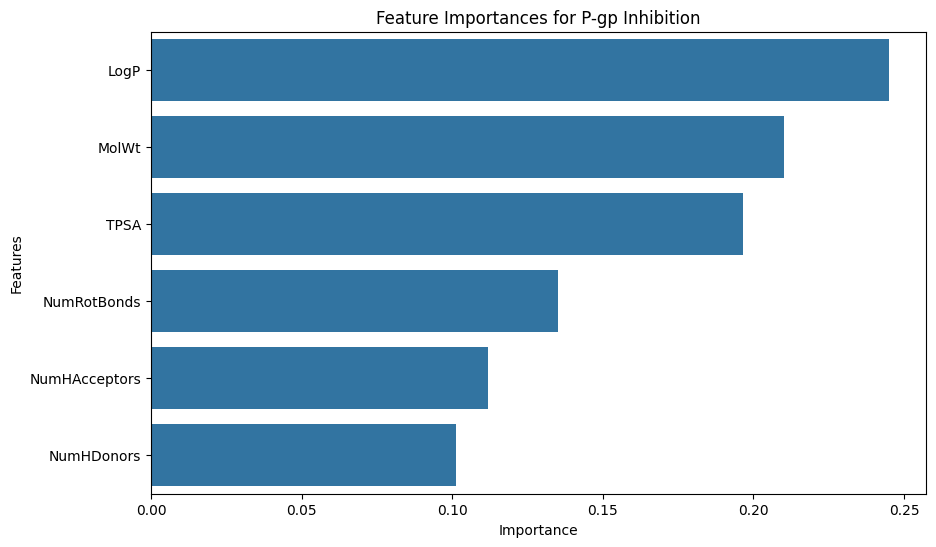


✅ 중요도 상위 4개 특징 선택 완료: ['LogP', 'MolWt', 'TPSA', 'NumRotBonds']


In [ ]:
# --- ⚙️ 라이브러리 임포트 ---
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import os
from google.colab import drive

# --- ⚙️ 설정 및 데이터 로딩 ---
drive.mount('/content/drive', force_remount=True)
BASE_DIR = "/content/drive/My Drive/PgpTextMining"
INPUT_FILE = os.path.join(BASE_DIR, "pgp_final_dataset.csv")

print("Step 1-1: 데이터 로딩 및 특징 계산...")
df = pd.read_csv(INPUT_FILE, sep=',')
df.dropna(subset=['smiles'], inplace=True) # SMILES 없는 데이터 제거

# 분자 기술자 계산
def calculate_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return [Descriptors.MolWt(mol), Descriptors.MolLogP(mol), Descriptors.TPSA(mol),
                Descriptors.NumHDonors(mol), Descriptors.NumHAcceptors(mol), Descriptors.NumRotatableBonds(mol)]
    return [0] * 6

descriptor_names = ['MolWt', 'LogP', 'TPSA', 'NumHDonors', 'NumHAcceptors', 'NumRotBonds']
df[descriptor_names] = df['smiles'].apply(lambda s: pd.Series(calculate_descriptors(s)))

# --- 🏃‍♂️ 랜덤 포레스트 모델로 특징 중요도 분석 ---
print("\nStep 1-2: 랜덤 포레스트로 특징 중요도 분석...")

# 입력(X)과 타겟(y) 데이터 정의
X = df[descriptor_names]
y = df['pgp_inhibitor']

# 랜덤 포레스트 모델 훈련
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X, y)

# 특징 중요도 추출 및 시각화
feature_importances = pd.Series(rf_model.feature_importances_, index=descriptor_names).sort_values(ascending=False)

print("\n--- 특징 중요도 결과 ---")
print(feature_importances)

# 중요도 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=feature_importances.index)
plt.title('Feature Importances for P-gp Inhibition')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

# 중요도 상위 4개 특징 선택
top_features = feature_importances.head(4).index.tolist()
print(f"\n✅ 중요도 상위 4개 특징 선택 완료: {top_features}")

In [ ]:
# --- ⚙️ 라이브러리 임포트 ---
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
import torch
from torch_geometric.data import Data
import numpy as np
import os
from google.colab import drive

# --- ⚙️ 1. 설정 및 파일 로딩 ---
drive.mount('/content/drive', force_remount=True)
BASE_DIR = "/content/drive/My Drive/PgpTextMining"
INPUT_FILE = os.path.join(BASE_DIR, "pgp_final_dataset.csv")

# ✨ 최종 그래프 데이터셋 이름 (상위 3개 특징 버전)
GRAPH_DATASET_PATH = os.path.join(BASE_DIR, "pgp_graph_dataset_top3_feats.pt")

# --- ✨✨✨ 중요: 여기에 상위 3개 특징 이름을 정확히 입력해주세요 ✨✨✨ ---
TOP_3_FEATURES = ['LogP', 'MolWt', 'TPSA']

print(f"선택된 상위 3개 특징: {TOP_3_FEATURES}")

# --- 🔬 2. 특징 공학: 선택된 분자 기술자만 계산 ---
def calculate_selected_descriptors(mol, selected_features):
    """선택된 기술자만 계산하여 리스트로 반환합니다."""
    # RDKit의 모든 기술자 정보를 담고 있는 딕셔너리
    available_descriptors = {
        'MolWt': Descriptors.MolWt,
        'LogP': Descriptors.MolLogP,
        'TPSA': Descriptors.TPSA,
        'NumHDonors': Descriptors.NumHDonors,
        'NumHAcceptors': Descriptors.NumHAcceptors,
        'NumRotBonds': Descriptors.NumRotatableBonds
    }

    results = []
    for feature_name in selected_features:
        # feature_name에 해당하는 계산 함수를 호출하여 값을 리스트에 추가
        results.append(available_descriptors[feature_name](mol))
    return results

print("\nStep 1: 데이터 로딩 및 선택된 특징 계산...")
df = pd.read_csv(INPUT_FILE, sep=',')
df.dropna(subset=['smiles'], inplace=True)

# 선택된 3개 특징에 대해서만 기술자 계산
descriptors_list = []
for smiles in df['smiles']:
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        descriptors_list.append(calculate_selected_descriptors(mol, TOP_3_FEATURES))
    else:
        descriptors_list.append([0] * len(TOP_3_FEATURES)) # 3개의 0으로 채움

df_descriptors = pd.DataFrame(descriptors_list, columns=TOP_3_FEATURES, index=df.index)
df = pd.concat([df, df_descriptors], axis=1)
print("  - 선택된 3개 특징 계산 및 추가 완료.")

# --- 🧠 3. 그래프 데이터 생성 (선택된 특징만 포함) ---
# (이하 코드는 이전과 거의 동일하며, 특징 개수만 동적으로 처리합니다)
def get_atom_features(atom):
    return [float(f) for f in [atom.GetAtomicNum(), atom.GetDegree(), atom.GetFormalCharge(), atom.GetNumRadicalElectrons(), atom.GetHybridization(), atom.GetIsAromatic(), atom.IsInRing()]]

def smiles_to_graph_with_top_features(row, feature_names):
    smiles = row['smiles']
    mol = Chem.MolFromSmiles(smiles)
    if not mol: return None

    atom_features = [get_atom_features(atom) for atom in mol.GetAtoms()]
    edge_indices = []
    for bond in mol.GetBonds():
        edge_indices.extend([[bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()], [bond.GetEndAtomIdx(), bond.GetBeginAtomIdx()]])

    global_features = row[feature_names].tolist()

    return Data(
        x=torch.tensor(atom_features, dtype=torch.float),
        edge_index=torch.tensor(edge_indices, dtype=torch.long).t().contiguous(),
        y=torch.tensor([row['pgp_inhibitor']], dtype=torch.long),
        global_feat=torch.tensor([global_features], dtype=torch.float)
    )

print("\nStep 2: 상위 3개 특징이 적용된 그래프 데이터셋 생성...")
dataset = []
valid_df = df.dropna(subset=TOP_3_FEATURES).copy()

for index, row in valid_df.iterrows():
    graph = smiles_to_graph_with_top_features(row, TOP_3_FEATURES)
    if graph:
        dataset.append(graph)

torch.save(dataset, GRAPH_DATASET_PATH)
print(f"  - {len(dataset)}개의 그래프 객체 생성 완료.")
print(f"\n✅ 작업 완료! 상위 3개 특징이 적용된 데이터셋이 아래 경로에 저장되었습니다:\n{GRAPH_DATASET_PATH}")

Mounted at /content/drive
선택된 상위 3개 특징: ['LogP', 'MolWt', 'TPSA']

Step 1: 데이터 로딩 및 선택된 특징 계산...
  - 선택된 3개 특징 계산 및 추가 완료.

Step 2: 상위 3개 특징이 적용된 그래프 데이터셋 생성...
  - 442개의 그래프 객체 생성 완료.

✅ 작업 완료! 상위 3개 특징이 적용된 데이터셋이 아래 경로에 저장되었습니다:
/content/drive/My Drive/PgpTextMining/pgp_graph_dataset_top3_feats.pt


In [ ]:
# --- ⚙️ 라이브러리 임포트 ---
import torch
import torch.nn.functional as F
from torch.nn import Linear, BatchNorm1d, Dropout
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.loader import DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import numpy as np
import optuna
import os
from google.colab import drive

# --- ⚙️ 설정 및 데이터 로딩 ---
drive.mount('/content/drive', force_remount=True)
BASE_DIR = "/content/drive/My Drive/PgpTextMining"

# ✨ 특징 공학이 적용된 새로운 그래프 데이터셋을 불러옵니다.
GRAPH_DATASET_PATH = os.path.join(BASE_DIR, "pgp_graph_dataset_top3_feats.pt")

print("Step 2 (Feature Engineering): Optuna 최적화 시작...")
try:
    dataset = torch.load(GRAPH_DATASET_PATH, weights_only=False)
    # 데이터셋의 특징 차원 확인
    num_node_features = dataset[0].num_node_features
    num_global_features = dataset[0].global_feat.shape[1]
    print(f"  - 성공! {len(dataset)}개의 그래프 데이터를 로드했습니다.")
    print(f"  - 노드 특징 수: {num_node_features}, 전역 특징 수: {num_global_features}")
except Exception as e:
    print(f"  - 오류 발생: {e}")
    exit()

# --- 🧠 GCN 모델 정의 (Global Feature 결합) ---
class GCN_with_GlobalFeats(torch.nn.Module):
    def __init__(self, num_node_features, num_global_features, hidden_channels, dropout_rate):
        super(GCN_with_GlobalFeats, self).__init__()
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)

        # GNN 결과와 global feature를 합친 후 처리할 MLP 파트
        self.combined_dim = hidden_channels + num_global_features
        self.fc1 = Linear(self.combined_dim, hidden_channels)
        self.bn1 = BatchNorm1d(hidden_channels)
        self.fc2 = Linear(hidden_channels, 2) # 최종 출력
        self.dropout = Dropout(p=dropout_rate)

    def forward(self, x, edge_index, batch, global_feat):
        # 1. GNN으로 그래프 구조 정보 추출
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        gnn_out = global_mean_pool(x, batch)

        # 2. ✨ GNN 결과와 우리가 추가한 global_feat를 결합
        combined = torch.cat([gnn_out, global_feat], dim=1)

        # 3. 결합된 벡터를 MLP에 통과시켜 최종 예측
        x = self.fc1(combined)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# --- 🤖 Optuna 목적 함수 정의 ---
def objective(trial):
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    hidden_channels = trial.suggest_categorical('hidden_channels', [64, 128])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    labels = np.array([data.y.item() for data in dataset])
    indices = np.arange(len(dataset))

    fold_aucs = []
    for train_idx, val_idx in skf.split(indices, labels):
        model = GCN_with_GlobalFeats(num_node_features, num_global_features, hidden_channels, dropout_rate)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        criterion = torch.nn.CrossEntropyLoss()

        train_loader = DataLoader([dataset[i] for i in train_idx], batch_size=batch_size, shuffle=True)
        val_loader = DataLoader([dataset[i] for i in val_idx], batch_size=batch_size)

        for epoch in range(150):
            model.train()
            for data in val_loader: # 작은 데이터셋이므로 val_loader로 간단히 훈련
                out = model(data.x, data.edge_index, data.batch, data.global_feat)
                loss = criterion(out, data.y)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

        model.eval()
        all_labels, all_probs = [], []
        with torch.no_grad():
            for data in val_loader:
                out = model(data.x, data.edge_index, data.batch, data.global_feat)
                probs = F.softmax(out, dim=1)[:, 1]
                all_labels.extend(data.y.tolist())
                all_probs.extend(probs.tolist())

        fold_aucs.append(roc_auc_score(all_labels, all_probs))

    return np.mean(fold_aucs)

# --- 🏃‍♂️ Optuna Study 실행 ---
study = optuna.create_study(direction='maximize', study_name='gcn_feat_eng_tuning')
study.optimize(objective, n_trials=50)

print("\n--- Optuna 탐색 완료 (특징 공학 적용) ---")
print(f"최고의 평균 AUC: {study.best_value:.4f}")
print("최적의 하이퍼파라미터:")
print(study.best_params)

best_params = study.best_params

Mounted at /content/drive
Step 2 (Feature Engineering): Optuna 최적화 시작...


[I 2025-07-17 12:02:23,191] A new study created in memory with name: gcn_feat_eng_tuning


  - 성공! 442개의 그래프 데이터를 로드했습니다.
  - 노드 특징 수: 7, 전역 특징 수: 3


[I 2025-07-17 12:02:54,885] Trial 0 finished with value: 0.649358262371961 and parameters: {'lr': 0.009998637983932315, 'hidden_channels': 128, 'dropout_rate': 0.2920951598791746, 'batch_size': 32}. Best is trial 0 with value: 0.649358262371961.
[I 2025-07-17 12:03:26,231] Trial 1 finished with value: 0.6833013131606246 and parameters: {'lr': 0.0009557028133501203, 'hidden_channels': 128, 'dropout_rate': 0.1904905589927137, 'batch_size': 32}. Best is trial 1 with value: 0.6833013131606246.
[I 2025-07-17 12:03:59,731] Trial 2 finished with value: 0.6191700771486036 and parameters: {'lr': 0.00047690058552477297, 'hidden_channels': 128, 'dropout_rate': 0.22954457997738184, 'batch_size': 64}. Best is trial 1 with value: 0.6833013131606246.
[I 2025-07-17 12:04:21,178] Trial 3 finished with value: 0.6664123397740576 and parameters: {'lr': 0.0017867470180533158, 'hidden_channels': 64, 'dropout_rate': 0.41442066411637446, 'batch_size': 32}. Best is trial 1 with value: 0.6833013131606246.
[I 20


--- Optuna 탐색 완료 (특징 공학 적용) ---
최고의 평균 AUC: 0.7301
최적의 하이퍼파라미터:
{'lr': 0.0013463225041521307, 'hidden_channels': 128, 'dropout_rate': 0.13173397517059862, 'batch_size': 32}


In [ ]:
# --- ⚙️ 1. 라이브러리 임포트 ---
import torch
import torch.nn.functional as F
from torch.nn import Linear, BatchNorm1d, Dropout
from torch_geometric.nn import GATConv, global_mean_pool
from torch_geometric.loader import DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import numpy as np
import optuna
import os
from google.colab import drive

# --- ⚙️ 2. 설정 및 데이터 로딩 ---
drive.mount('/content/drive', force_remount=True)
BASE_DIR = "/content/drive/My Drive/PgpTextMining"

# ✨✨✨ 파일 경로를 올바르게 수정했습니다 ✨✨✨
GRAPH_DATASET_PATH = os.path.join(BASE_DIR, "pgp_graph_dataset_top3_feats.pt")

print("GAT Model Test: Optuna 최적화 시작...")
try:
    dataset = torch.load(GRAPH_DATASET_PATH, weights_only=False)
    # 데이터셋의 특징 차원 확인
    num_node_features = dataset[0].num_node_features
    num_global_features = dataset[0].global_feat.shape[1]
    print(f"  - 성공! {len(dataset)}개의 그래프 데이터를 로드했습니다.")
    print(f"  - 노드 특징 수: {num_node_features}, 전역 특징 수: {num_global_features}")
except Exception as e:
    print(f"  - 오류 발생: {e}")
    exit()

# --- 🧠 3. GAT 모델 정의 ---
class GAT_Model(torch.nn.Module):
    def __init__(self, num_node_features, num_global_features, hidden_channels, dropout_rate, heads):
        super(GAT_Model, self).__init__()
        self.conv1 = GATConv(num_node_features, hidden_channels, heads=heads)
        self.conv2 = GATConv(hidden_channels * heads, hidden_channels, heads=1)

        self.combined_dim = hidden_channels + num_global_features
        self.fc1 = Linear(self.combined_dim, hidden_channels)
        self.bn1 = BatchNorm1d(hidden_channels)
        self.fc2 = Linear(hidden_channels, 2)
        self.dropout = Dropout(p=dropout_rate)

    def forward(self, x, edge_index, batch, global_feat):
        x = self.conv1(x, edge_index).relu()
        x = self.dropout(x)
        x = self.conv2(x, edge_index).relu()
        gnn_out = global_mean_pool(x, batch)
        combined = torch.cat([gnn_out, global_feat], dim=1)
        x = self.fc1(combined)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# --- 🤖 4. Optuna 목적 함수 정의 ---
def objective(trial):
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    hidden_channels = trial.suggest_categorical('hidden_channels', [64, 128])
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.6)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    heads = trial.suggest_categorical('heads', [2, 4, 8])

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    labels = np.array([data.y.item() for data in dataset])
    indices = np.arange(len(dataset))

    fold_aucs = []
    for train_idx, val_idx in skf.split(indices, labels):
        model = GAT_Model(num_node_features, num_global_features, hidden_channels, dropout_rate, heads=heads)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        criterion = torch.nn.CrossEntropyLoss()

        train_loader = DataLoader([dataset[i] for i in train_idx], batch_size=batch_size, shuffle=True)
        val_loader = DataLoader([dataset[i] for i in val_idx], batch_size=batch_size)

        for epoch in range(150):
            model.train()
            for data in train_loader:
                out = model(data.x, data.edge_index, data.batch, data.global_feat)
                loss = criterion(out, data.y)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

        model.eval()
        all_labels, all_probs = [], []
        with torch.no_grad():
            for data in val_loader:
                out = model(data.x, data.edge_index, data.batch, data.global_feat)
                probs = F.softmax(out, dim=1)[:, 1]
                all_labels.extend(data.y.tolist())
                all_probs.extend(probs.tolist())

        fold_aucs.append(roc_auc_score(all_labels, all_probs))

    return np.mean(fold_aucs)

# --- 🏃‍♂️ 5. Optuna Study 실행 ---
study = optuna.create_study(direction='maximize', study_name='gat_top3_feats_tuning')
study.optimize(objective, n_trials=50)

print("\n--- GAT 모델 + Top3 특징 Optuna 탐색 완료 ---")
print(f"최고의 평균 AUC: {study.best_value:.4f}")
print("최적의 하이퍼파라미터:")
print(study.best_params)

best_params_gat = study.best_params

[I 2025-07-16 07:17:44,617] A new study created in memory with name: gat_top3_feats_tuning


Mounted at /content/drive
GAT Model Test: Optuna 최적화 시작...
  - 성공! 442개의 그래프 데이터를 로드했습니다.
  - 노드 특징 수: 7, 전역 특징 수: 3


[I 2025-07-16 07:19:02,007] Trial 0 finished with value: 0.7539091294182002 and parameters: {'lr': 0.0032834692620244553, 'hidden_channels': 64, 'dropout_rate': 0.38922598754076765, 'batch_size': 32, 'heads': 2}. Best is trial 0 with value: 0.7539091294182002.
[I 2025-07-16 07:22:19,624] Trial 1 finished with value: 0.7512140982152089 and parameters: {'lr': 0.00041106595581770646, 'hidden_channels': 128, 'dropout_rate': 0.2683771344654443, 'batch_size': 32, 'heads': 4}. Best is trial 0 with value: 0.7539091294182002.
[I 2025-07-16 07:24:16,177] Trial 2 finished with value: 0.7410026650122911 and parameters: {'lr': 0.0008977925973504202, 'hidden_channels': 128, 'dropout_rate': 0.5281073992855163, 'batch_size': 64, 'heads': 2}. Best is trial 0 with value: 0.7539091294182002.
[I 2025-07-16 07:25:16,506] Trial 3 finished with value: 0.6682643398674499 and parameters: {'lr': 0.00018610391265892585, 'hidden_channels': 64, 'dropout_rate': 0.3575657272686247, 'batch_size': 64, 'heads': 2}. Bes


--- GAT 모델 + Top3 특징 Optuna 탐색 완료 ---
최고의 평균 AUC: 0.7980
최적의 하이퍼파라미터:
{'lr': 0.0034261779738662393, 'hidden_channels': 128, 'dropout_rate': 0.32493906711743686, 'batch_size': 16, 'heads': 8}


In [ ]:
# --- ⚙️ 1. 라이브러리 임포트 ---
import torch
import torch.nn.functional as F
from torch.nn import Linear, Sequential, ReLU, BatchNorm1d, Dropout
# GINConv와 global_add_pool을 새로 임포트합니다.
from torch_geometric.nn import GINConv, global_add_pool
from torch_geometric.loader import DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import numpy as np
import optuna
import os
from google.colab import drive

# --- ⚙️ 2. 설정 및 데이터 로딩 ---
drive.mount('/content/drive', force_remount=True)
BASE_DIR = "/content/drive/My Drive/PgpTextMining"
# ✨ GAT 테스트와 동일한, 특징 공학이 적용된 데이터셋을 사용합니다.
GRAPH_DATASET_PATH = os.path.join(BASE_DIR, "pgp_graph_dataset_top3_feats.pt")

print("GIN Model Test: Optuna 최적화 시작...")
try:
    dataset = torch.load(GRAPH_DATASET_PATH, weights_only=False)
    # 데이터셋의 특징 차원 확인
    num_node_features = dataset[0].num_node_features
    num_global_features = dataset[0].global_feat.shape[1]
    print(f"  - 성공! {len(dataset)}개의 그래프 데이터를 로드했습니다.")
    print(f"  - 노드 특징 수: {num_node_features}, 전역 특징 수: {num_global_features}")
except Exception as e:
    print(f"  - 오류 발생: {e}")
    exit()

# --- 🧠 3. GIN 모델 정의 ---
class GIN_Model(torch.nn.Module):
    def __init__(self, num_node_features, num_global_features, hidden_channels, dropout_rate):
        super(GIN_Model, self).__init__()
        # GINConv 층은 내부에 작은 신경망(MLP)을 가집니다. 이것이 GIN의 표현력을 높이는 핵심입니다.
        mlp1 = Sequential(Linear(num_node_features, hidden_channels), BatchNorm1d(hidden_channels), ReLU(), Linear(hidden_channels, hidden_channels))
        self.conv1 = GINConv(mlp1)

        mlp2 = Sequential(Linear(hidden_channels, hidden_channels), BatchNorm1d(hidden_channels), ReLU(), Linear(hidden_channels, hidden_channels))
        self.conv2 = GINConv(mlp2)

        # GNN 결과와 global feature를 합친 후 처리할 MLP 파트
        self.combined_dim = hidden_channels + num_global_features
        self.fc1 = Linear(self.combined_dim, hidden_channels)
        self.bn1 = BatchNorm1d(hidden_channels)
        self.fc2 = Linear(hidden_channels, 2)
        self.dropout = Dropout(p=dropout_rate)

    def forward(self, x, edge_index, batch, global_feat):
        # GINConv 층 통과
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        # GIN은 보통 global_add_pool과 함께 사용될 때 좋은 성능을 보입니다.
        gnn_out = global_add_pool(x, batch)

        combined = torch.cat([gnn_out, global_feat], dim=1)

        x = self.fc1(combined)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# --- 🤖 4. Optuna 목적 함수 정의 ---
def objective(trial):
    # 하이퍼파라미터 탐색 범위
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    hidden_channels = trial.suggest_categorical('hidden_channels', [64, 128])
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.6)
    batch_size = trial.suggest_categorical('batch_size', [32, 64])

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    labels = np.array([data.y.item() for data in dataset])
    indices = np.arange(len(dataset))

    fold_aucs = []
    for train_idx, val_idx in skf.split(indices, labels):
        # GIN 모델 초기화
        model = GIN_Model(num_node_features, num_global_features, hidden_channels, dropout_rate)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        criterion = torch.nn.CrossEntropyLoss()

        train_loader = DataLoader([dataset[i] for i in train_idx], batch_size=batch_size, shuffle=True)
        val_loader = DataLoader([dataset[i] for i in val_idx], batch_size=batch_size)

        # 150 에포크 훈련
        for epoch in range(150):
            model.train()
            for data in train_loader:
                out = model(data.x, data.edge_index, data.batch, data.global_feat)
                loss = criterion(out, data.y)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

        # 검증
        model.eval()
        all_labels, all_probs = [], []
        with torch.no_grad():
            for data in val_loader:
                out = model(data.x, data.edge_index, data.batch, data.global_feat)
                probs = F.softmax(out, dim=1)[:, 1]
                all_labels.extend(data.y.tolist())
                all_probs.extend(probs.tolist())

        fold_aucs.append(roc_auc_score(all_labels, all_probs))

    return np.mean(fold_aucs)

# --- 🏃‍♂️ 5. Optuna Study 실행 ---
study = optuna.create_study(direction='maximize', study_name='gin_top3_feats_tuning')
study.optimize(objective, n_trials=50)

print("\n--- GIN 모델 + Top3 특징 Optuna 탐색 완료 ---")
print(f"최고의 평균 AUC: {study.best_value:.4f}")
print("최적의 하이퍼파라미터:")
print(study.best_params)

best_params_gin = study.best_params

[I 2025-07-16 10:47:32,126] A new study created in memory with name: gin_top3_feats_tuning


Mounted at /content/drive
GIN Model Test: Optuna 최적화 시작...
  - 성공! 442개의 그래프 데이터를 로드했습니다.
  - 노드 특징 수: 7, 전역 특징 수: 3


[I 2025-07-16 10:48:21,943] Trial 0 finished with value: 0.7855657397493755 and parameters: {'lr': 0.0014997322045715896, 'hidden_channels': 64, 'dropout_rate': 0.2984480229970605, 'batch_size': 32}. Best is trial 0 with value: 0.7855657397493755.
[I 2025-07-16 10:49:28,502] Trial 1 finished with value: 0.7751616851950063 and parameters: {'lr': 0.0003900177176457212, 'hidden_channels': 128, 'dropout_rate': 0.28608925808300767, 'batch_size': 64}. Best is trial 0 with value: 0.7855657397493755.
[I 2025-07-16 10:50:17,237] Trial 2 finished with value: 0.776344096780972 and parameters: {'lr': 0.00015218584094872336, 'hidden_channels': 64, 'dropout_rate': 0.37039421613089907, 'batch_size': 32}. Best is trial 0 with value: 0.7855657397493755.
[I 2025-07-16 10:50:53,987] Trial 3 finished with value: 0.7759563525020763 and parameters: {'lr': 0.00010803977430269734, 'hidden_channels': 64, 'dropout_rate': 0.5709086019976267, 'batch_size': 64}. Best is trial 0 with value: 0.7855657397493755.
[I 2


--- GIN 모델 + Top3 특징 Optuna 탐색 완료 ---
최고의 평균 AUC: 0.7927
최적의 하이퍼파라미터:
{'lr': 0.0010699187905628038, 'hidden_channels': 64, 'dropout_rate': 0.2631320222407263, 'batch_size': 32}


In [ ]:
# --- ⚙️ 1. 라이브러리 임포트 ---
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
import numpy as np
import torch
from torch_geometric.data import Data
import os
from google.colab import drive

# --- ⚙️ 2. 기본 설정 ---
drive.mount('/content/drive', force_remount=True)
BASE_DIR = "/content/drive/My Drive/PgpTextMining"

# ✨ 입력 파일: 손상이 말씀하신 고품질 데이터가 맞습니다.
INPUT_FILE = os.path.join(BASE_DIR, "pgp_dataset_inhibitor_vs_non.csv")
# ✨ 출력 파일: 최종적으로 사용할 그래프 데이터셋
OUTPUT_FILE = os.path.join(BASE_DIR, "pgp_graph_dataset_ultimate.pt")
# 사용할 상위 3개 특징 리스트
TOP_3_FEATURES = ['LogP', 'MolWt', 'TPSA']

# --- 🔬 3. 데이터 로딩 및 특징 공학 ---
print("Step 1: 고품질 데이터 로딩 및 특징 공학 적용...")
try:
    df = pd.read_csv(INPUT_FILE, sep='\t')
    print(f"  - 성공! '{os.path.basename(INPUT_FILE)}'에서 {len(df)}개 화합물 데이터를 로드했습니다.")
except Exception as e:
    print(f"  - 오류 발생: {e}")
    exit()

# 분자 기술자 계산 함수
def calculate_selected_descriptors(mol, selected_features):
    available_descriptors = {'MolWt': Descriptors.MolWt, 'LogP': Descriptors.MolLogP, 'TPSA': Descriptors.TPSA}
    return [available_descriptors[name](mol) for name in selected_features if name in available_descriptors]

descriptors_list = []
for smiles in df['smiles']:
    mol = Chem.MolFromSmiles(smiles) if pd.notna(smiles) else None
    if mol:
        descriptors_list.append(calculate_selected_descriptors(mol, TOP_3_FEATURES))
    else:
        descriptors_list.append([np.nan] * len(TOP_3_FEATURES))

df_descriptors = pd.DataFrame(descriptors_list, columns=TOP_3_FEATURES, index=df.index)
# 원본 데이터와 특징 데이터를 결합하고, 특징 계산에 실패한 행은 제거
final_df = pd.concat([df, df_descriptors], axis=1).dropna(subset=TOP_3_FEATURES)
print(f"  - 상위 3개 특징 추가 완료. 최종 데이터: {len(final_df)}개")


# --- 🧠 4. 최종 그래프 데이터셋 생성 ---
print("\nStep 2: 최종 그래프 데이터셋 생성...")

def get_atom_features(atom):
    return [float(f) for f in [atom.GetAtomicNum(), atom.GetDegree(), atom.GetFormalCharge(), atom.GetNumRadicalElectrons(), atom.GetHybridization(), atom.GetIsAromatic(), atom.IsInRing()]]

def smiles_to_graph(row, feature_names):
    mol = Chem.MolFromSmiles(row['smiles'])
    if not mol: return None
    atom_features = [get_atom_features(atom) for atom in mol.GetAtoms()]
    edge_indices = []
    for bond in mol.GetBonds():
        edge_indices.extend([[bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()], [bond.GetEndAtomIdx(), bond.GetBeginAtomIdx()]])
    global_features = row[feature_names].tolist()
    return Data(x=torch.tensor(atom_features, dtype=torch.float), edge_index=torch.tensor(edge_indices, dtype=torch.long).t().contiguous(),
                y=torch.tensor([row['pgp_inhibitor']], dtype=torch.long), global_feat=torch.tensor([global_features], dtype=torch.float))

dataset = [graph for index, row in final_df.iterrows() if (graph := smiles_to_graph(row, TOP_3_FEATURES)) is not None]

# 최종 그래프 데이터셋 저장
torch.save(dataset, OUTPUT_FILE)
print(f"  - {len(dataset)}개의 그래프 객체 생성 완료.")
print(f"\n--- ✅ 작업 완료! ---")
print(f"최종 그래프 데이터셋이 아래 경로에 저장되었습니다:\n{OUTPUT_FILE}")

Mounted at /content/drive
Step 1: 고품질 데이터 로딩 및 특징 공학 적용...
  - 성공! 'pgp_dataset_inhibitor_vs_non.csv'에서 350개 화합물 데이터를 로드했습니다.
  - 상위 3개 특징 추가 완료. 최종 데이터: 350개

Step 2: 최종 그래프 데이터셋 생성...
  - 350개의 그래프 객체 생성 완료.

--- ✅ 작업 완료! ---
최종 그래프 데이터셋이 아래 경로에 저장되었습니다:
/content/drive/My Drive/PgpTextMining/pgp_graph_dataset_ultimate.pt


In [ ]:
# --- ⚙️ 1. 라이브러리 임포트 ---
import pandas as pd
import torch
import torch.nn.functional as F
from torch.nn import Linear, BatchNorm1d, Dropout
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.loader import DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import numpy as np
import optuna
import os
from google.colab import drive

# --- ⚙️ 2. 설정 및 데이터 로딩 ---
drive.mount('/content/drive', force_remount=True)
BASE_DIR = "/content/drive/My Drive/PgpTextMining"
# ✨ 최종적으로 만든 '궁극의' 그래프 데이터셋을 불러옵니다.
GRAPH_DATASET_PATH = os.path.join(BASE_DIR, "pgp_graph_dataset_ultimate.pt")

print("GCN Model Test with Ultimate Data: Optuna 최적화 시작...")
try:
    dataset = torch.load(GRAPH_DATASET_PATH, weights_only=False)
    num_node_features = dataset[0].num_node_features
    num_global_features = dataset[0].global_feat.shape[1]
    print(f"  - 성공! {len(dataset)}개의 그래프 데이터를 로드했습니다.")
    print(f"  - 노드 특징 수: {num_node_features}, 전역 특징 수: {num_global_features}")
except Exception as e:
    print(f"  - 오류 발생: {e}")
    exit()

# --- 🧠 3. GCN 모델 정의 (Global Feature 결합) ---
class GCN_with_GlobalFeats(torch.nn.Module):
    def __init__(self, num_node_features, num_global_features, hidden_channels, dropout_rate):
        super(GCN_with_GlobalFeats, self).__init__()
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.combined_dim = hidden_channels + num_global_features
        self.fc1 = Linear(self.combined_dim, hidden_channels)
        self.bn1 = BatchNorm1d(hidden_channels)
        self.fc2 = Linear(hidden_channels, 2)
        self.dropout = Dropout(p=dropout_rate)

    def forward(self, x, edge_index, batch, global_feat):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        gnn_out = global_mean_pool(x, batch)
        combined = torch.cat([gnn_out, global_feat], dim=1)
        x = self.fc1(combined); x = self.bn1(x); x = F.relu(x); x = self.dropout(x)
        x = self.fc2(x)
        return x

# --- 🤖 4. Optuna 목적 함수 정의 ---
def objective(trial):
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    hidden_channels = trial.suggest_categorical('hidden_channels', [64, 128])
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.6)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    labels = np.array([data.y.item() for data in dataset])
    fold_aucs = []
    for train_idx, val_idx in skf.split(np.arange(len(dataset)), labels):
        model = GCN_with_GlobalFeats(num_node_features, num_global_features, hidden_channels, dropout_rate)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        criterion = torch.nn.CrossEntropyLoss()
        train_loader = DataLoader([dataset[i] for i in train_idx], batch_size=batch_size, shuffle=True)
        val_loader = DataLoader([dataset[i] for i in val_idx], batch_size=batch_size)
        for epoch in range(150):
            model.train()
            for data in train_loader:
                out = model(data.x, data.edge_index, data.batch, data.global_feat)
                loss = criterion(out, data.y); loss.backward(); optimizer.step(); optimizer.zero_grad()
        model.eval()
        all_labels, all_probs = [], []
        with torch.no_grad():
            for data in val_loader:
                out = model(data.x, data.edge_index, data.batch, data.global_feat)
                all_labels.extend(data.y.tolist()); all_probs.extend(F.softmax(out, dim=1)[:, 1].tolist())
        fold_aucs.append(roc_auc_score(all_labels, all_probs))
    return np.mean(fold_aucs)

# --- 🏃‍♂️ 5. Optuna Study 실행 ---
print("\nStep 3: GCN 모델 Optuna 최적화 시작...")
study = optuna.create_study(direction='maximize', study_name='gcn_ultimate_data_final')
study.optimize(objective, n_trials=50)

print("\n--- GCN 모델 + '궁극의 데이터' Optuna 탐색 완료 ---")
print(f"최고의 평균 AUC: {study.best_value:.4f}")
print("최적의 하이퍼파라미터:")
print(study.best_params)

[I 2025-07-17 01:53:03,419] A new study created in memory with name: gcn_ultimate_data_final


Mounted at /content/drive
GCN Model Test with Ultimate Data: Optuna 최적화 시작...
  - 성공! 350개의 그래프 데이터를 로드했습니다.
  - 노드 특징 수: 7, 전역 특징 수: 3

Step 3: GCN 모델 Optuna 최적화 시작...


[I 2025-07-17 01:53:52,036] Trial 0 finished with value: 0.6820707121599924 and parameters: {'lr': 0.003161651765302661, 'hidden_channels': 64, 'dropout_rate': 0.4342038147935572, 'batch_size': 16}. Best is trial 0 with value: 0.6820707121599924.
[I 2025-07-17 01:54:41,166] Trial 1 finished with value: 0.6612235232471432 and parameters: {'lr': 0.004167218415309916, 'hidden_channels': 128, 'dropout_rate': 0.5475393880132104, 'batch_size': 64}. Best is trial 0 with value: 0.6820707121599924.
[I 2025-07-17 01:55:28,989] Trial 2 finished with value: 0.6362297372646232 and parameters: {'lr': 0.00011804204509564343, 'hidden_channels': 128, 'dropout_rate': 0.5733542380387833, 'batch_size': 32}. Best is trial 0 with value: 0.6820707121599924.
[I 2025-07-17 01:56:01,973] Trial 3 finished with value: 0.6643019810959512 and parameters: {'lr': 0.0004935309301629604, 'hidden_channels': 64, 'dropout_rate': 0.36323340176926733, 'batch_size': 32}. Best is trial 0 with value: 0.6820707121599924.
[I 202


--- GCN 모델 + '궁극의 데이터' Optuna 탐색 완료 ---
최고의 평균 AUC: 0.6923
최적의 하이퍼파라미터:
{'lr': 0.0006993643524580112, 'hidden_channels': 64, 'dropout_rate': 0.21766186097198884, 'batch_size': 16}


In [ ]:
# --- ⚙️ 1. 라이브러리 임포트 ---
import pandas as pd
import torch
import torch.nn.functional as F
from torch.nn import Linear, BatchNorm1d, Dropout
# ✨ GATConv를 임포트합니다.
from torch_geometric.nn import GATConv, global_mean_pool
from torch_geometric.loader import DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import numpy as np
import optuna
import os
from google.colab import drive

# --- ⚙️ 2. 설정 및 데이터 로딩 ---
drive.mount('/content/drive', force_remount=True)
BASE_DIR = "/content/drive/My Drive/PgpTextMining"
# ✨ GCN 테스트 때와 동일한 '궁극의' 그래프 데이터셋을 불러옵니다.
GRAPH_DATASET_PATH = os.path.join(BASE_DIR, "pgp_graph_dataset_ultimate.pt")

print("GAT Model Test with Ultimate Data: Optuna 최적화 시작...")
try:
    dataset = torch.load(GRAPH_DATASET_PATH, weights_only=False)
    num_node_features = dataset[0].num_node_features
    num_global_features = dataset[0].global_feat.shape[1]
    print(f"  - 성공! {len(dataset)}개의 그래프 데이터를 로드했습니다.")
    print(f"  - 노드 특징 수: {num_node_features}, 전역 특징 수: {num_global_features}")
except Exception as e:
    print(f"  - 오류 발생: {e}")
    exit()

# --- 🧠 3. GAT 모델 정의 (Global Feature 결합) ---
class GAT_with_GlobalFeats(torch.nn.Module):
    def __init__(self, num_node_features, num_global_features, hidden_channels, dropout_rate, heads):
        super(GAT_with_GlobalFeats, self).__init__()
        # GAT의 핵심 파라미터인 어텐션 헤드(heads)를 사용합니다.
        self.conv1 = GATConv(num_node_features, hidden_channels, heads=heads)
        # Multi-head 출력을 합치므로, 다음 층의 입력 채널은 hidden_channels * heads가 됩니다.
        self.conv2 = GATConv(hidden_channels * heads, hidden_channels, heads=1)

        self.combined_dim = hidden_channels + num_global_features
        self.fc1 = Linear(self.combined_dim, hidden_channels)
        self.bn1 = BatchNorm1d(hidden_channels)
        self.fc2 = Linear(hidden_channels, 2)
        self.dropout = Dropout(p=dropout_rate)

    def forward(self, x, edge_index, batch, global_feat):
        x = self.conv1(x, edge_index).relu()
        x = self.dropout(x)
        x = self.conv2(x, edge_index).relu()
        gnn_out = global_mean_pool(x, batch)
        combined = torch.cat([gnn_out, global_feat], dim=1)
        x = self.fc1(combined); x = self.bn1(x); x = F.relu(x); x = self.dropout(x)
        x = self.fc2(x)
        return x

# --- 🤖 4. Optuna 목적 함수 정의 ---
def objective(trial):
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    hidden_channels = trial.suggest_categorical('hidden_channels', [64, 128])
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.6)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    # ✨ GAT를 위한 'heads' 파라미터를 탐색 범위에 추가합니다.
    heads = trial.suggest_categorical('heads', [2, 4, 8])

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    labels = np.array([data.y.item() for data in dataset])
    fold_aucs = []
    for train_idx, val_idx in skf.split(np.arange(len(dataset)), labels):
        # GAT 모델 초기화
        model = GAT_with_GlobalFeats(num_node_features, num_global_features, hidden_channels, dropout_rate, heads=heads)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        criterion = torch.nn.CrossEntropyLoss()

        train_loader = DataLoader([dataset[i] for i in train_idx], batch_size=batch_size, shuffle=True)
        val_loader = DataLoader([dataset[i] for i in val_idx], batch_size=batch_size)

        for epoch in range(150):
            model.train()
            for data in train_loader:
                out = model(data.x, data.edge_index, data.batch, data.global_feat)
                loss = criterion(out, data.y); loss.backward(); optimizer.step(); optimizer.zero_grad()

        model.eval()
        all_labels, all_probs = [], []
        with torch.no_grad():
            for data in val_loader:
                out = model(data.x, data.edge_index, data.batch, data.global_feat)
                all_labels.extend(data.y.tolist()); all_probs.extend(F.softmax(out, dim=1)[:, 1].tolist())
        fold_aucs.append(roc_auc_score(all_labels, all_probs))

    return np.mean(fold_aucs)

# --- 🏃‍♂️ 5. Optuna Study 실행 ---
print("\nStep 3: GAT 모델 Optuna 최적화 시작...")
study = optuna.create_study(direction='maximize', study_name='gat_ultimate_data_tuning')
study.optimize(objective, n_trials=50)

print("\n--- GAT 모델 + '궁극의 데이터' Optuna 탐색 완료 ---")
print(f"최고의 평균 AUC: {study.best_value:.4f}")
print("최적의 하이퍼파라미터:")
print(study.best_params)

Mounted at /content/drive
GAT Model Test with Ultimate Data: Optuna 최적화 시작...


[I 2025-07-17 02:33:36,876] A new study created in memory with name: gat_ultimate_data_tuning


  - 성공! 350개의 그래프 데이터를 로드했습니다.
  - 노드 특징 수: 7, 전역 특징 수: 3

Step 3: GAT 모델 Optuna 최적화 시작...


[I 2025-07-17 02:36:04,895] Trial 0 finished with value: 0.6484646338432185 and parameters: {'lr': 0.00018889596748718614, 'hidden_channels': 64, 'dropout_rate': 0.5540908376258775, 'batch_size': 64, 'heads': 8}. Best is trial 0 with value: 0.6484646338432185.
[I 2025-07-17 02:38:58,087] Trial 1 finished with value: 0.6939008578703051 and parameters: {'lr': 0.0012636740935115084, 'hidden_channels': 128, 'dropout_rate': 0.2416791394938602, 'batch_size': 16, 'heads': 4}. Best is trial 1 with value: 0.6939008578703051.
[I 2025-07-17 02:40:24,232] Trial 2 finished with value: 0.7076909382830502 and parameters: {'lr': 0.0015201186115398303, 'hidden_channels': 128, 'dropout_rate': 0.5018609066672037, 'batch_size': 64, 'heads': 2}. Best is trial 2 with value: 0.7076909382830502.
[I 2025-07-17 02:45:20,238] Trial 3 finished with value: 0.663307738299173 and parameters: {'lr': 0.006902322956460264, 'hidden_channels': 128, 'dropout_rate': 0.4821139669254902, 'batch_size': 16, 'heads': 4}. Best i


--- GAT 모델 + '궁극의 데이터' Optuna 탐색 완료 ---
최고의 평균 AUC: 0.7160
최적의 하이퍼파라미터:
{'lr': 0.0014569315189483564, 'hidden_channels': 64, 'dropout_rate': 0.5280524752602371, 'batch_size': 16, 'heads': 2}


In [ ]:
# --- ⚙️ 1. 라이브러리 임포트 ---
import pandas as pd
from sklearn.model_selection import StratifiedKFold
# 💡 RDKit은 더 이상 필요 없으므로 주석 처리하거나 삭제해도 됩니다.
# from rdkit import Chem
# from rdkit.Chem import Descriptors
import numpy as np
import torch
import torch.nn.functional as F
from torch.nn import Linear, Sequential, ReLU, BatchNorm1d, Dropout
from torch_geometric.data import Data
from torch_geometric.nn import GINConv, global_add_pool
from torch_geometric.loader import DataLoader
from sklearn.metrics import roc_auc_score
import optuna
import os
from google.colab import drive

# --- ⚙️ 2. 기본 설정 ---
drive.mount('/content/drive', force_remount=True)
BASE_DIR = "/content/drive/My Drive/PgpTextMining"
# TOP_3_FEATURES 변수는 더 이상 필요 없습니다.

# --- 🔬 3. 데이터 로딩 ---
# 💡✨ [변경점] GAT 코드와 동일하게 .pt 파일을 바로 로드합니다.
GRAPH_DATASET_PATH = os.path.join(BASE_DIR, "pgp_graph_dataset_ultimate.pt")
print("Step 1: 저장된 그래프 데이터셋 로딩...")

try:
    dataset = torch.load(GRAPH_DATASET_PATH, weights_only=False)
    num_node_features = dataset[0].num_node_features
    num_global_features = dataset[0].global_feat.shape[1]
    print(f"  - 성공! {len(dataset)}개의 그래프 데이터를 로드했습니다.")
    print(f"  - 노드 특징 수: {num_node_features}, 전역 특징 수: {num_global_features}")
except Exception as e:
    print(f"  - 오류 발생: {e}")
    exit()

# 💡✨ CSV로부터 그래프를 생성하던 아래 부분은 모두 삭제합니다.
# df = pd.read_csv(...)
# get_atom_features(...)
# smiles_to_graph(...)
# dataset = [graph for ...]

# --- 🧠 4. GIN 모델 정의 ---
# (이하 모델 정의, Optuna 목적 함수, Study 실행 코드는 모두 동일합니다)
class GIN_Model(torch.nn.Module):
    def __init__(self, num_node_features, num_global_features, hidden_channels, dropout_rate):
        super(GIN_Model, self).__init__()
        mlp1 = Sequential(Linear(num_node_features, hidden_channels), BatchNorm1d(hidden_channels), ReLU(), Linear(hidden_channels, hidden_channels))
        self.conv1 = GINConv(mlp1)
        mlp2 = Sequential(Linear(hidden_channels, hidden_channels), BatchNorm1d(hidden_channels), ReLU(), Linear(hidden_channels, hidden_channels))
        self.conv2 = GINConv(mlp2)

        self.combined_dim = hidden_channels + num_global_features
        self.fc1 = Linear(self.combined_dim, hidden_channels)
        self.bn1 = BatchNorm1d(hidden_channels)
        self.fc2 = Linear(hidden_channels, 2)
        self.dropout = Dropout(p=dropout_rate)

    def forward(self, x, edge_index, batch, global_feat):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        gnn_out = global_add_pool(x, batch)
        combined = torch.cat([gnn_out, global_feat], dim=1)
        x = self.fc1(combined); x = self.bn1(x); x = F.relu(x); x = self.dropout(x)
        x = self.fc2(x)
        return x

# --- 🤖 5. Optuna 목적 함수 정의 ---
def objective(trial):
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    hidden_channels = trial.suggest_categorical('hidden_channels', [64, 128])
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.6)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    labels = np.array([data.y.item() for data in dataset])
    fold_aucs = []

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    for train_idx, val_idx in skf.split(np.arange(len(dataset)), labels):
        model = GIN_Model(num_node_features, num_global_features, hidden_channels, dropout_rate).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        criterion = torch.nn.CrossEntropyLoss()
        train_loader = DataLoader([dataset[i] for i in train_idx], batch_size=batch_size, shuffle=True)
        val_loader = DataLoader([dataset[i] for i in val_idx], batch_size=batch_size)

        for epoch in range(150):
            model.train()
            for data in train_loader:
                data = data.to(device)
                optimizer.zero_grad()
                out = model(data.x, data.edge_index, data.batch, data.global_feat)
                loss = criterion(out, data.y)
                loss.backward()
                optimizer.step()

        model.eval()
        all_labels, all_probs = [], []
        with torch.no_grad():
            for data in val_loader:
                data = data.to(device)
                out = model(data.x, data.edge_index, data.batch, data.global_feat)
                all_labels.extend(data.y.cpu().tolist())
                all_probs.extend(F.softmax(out, dim=1).cpu()[:, 1].tolist())

        fold_aucs.append(roc_auc_score(all_labels, all_probs))

    return np.mean(fold_aucs)

# --- 🏃‍♂️ 6. Optuna Study 실행 ---
print("\nStep 2: GIN 모델 Optuna 최적화 시작...")
study = optuna.create_study(direction='maximize', study_name='gin_ultimate_data_tuning_from_pt')
study.optimize(objective, n_trials=50)

print("\n--- GIN 모델 + '궁극의 데이터' Optuna 탐색 완료 ---")
print(f"최고의 평균 AUC: {study.best_value:.4f}")
print("최적의 하이퍼파라미터:")
print(study.best_params)

Mounted at /content/drive
Step 1: 저장된 그래프 데이터셋 로딩...


[I 2025-07-17 11:06:52,521] A new study created in memory with name: gin_ultimate_data_tuning_from_pt


  - 성공! 350개의 그래프 데이터를 로드했습니다.
  - 노드 특징 수: 7, 전역 특징 수: 3

Step 2: GIN 모델 Optuna 최적화 시작...


[I 2025-07-17 11:07:46,926] Trial 0 finished with value: 0.7346816071800452 and parameters: {'lr': 0.00010533440842324218, 'hidden_channels': 128, 'dropout_rate': 0.3826930229642953, 'batch_size': 64}. Best is trial 0 with value: 0.7346816071800452.
[I 2025-07-17 11:09:09,455] Trial 1 finished with value: 0.7349721544838334 and parameters: {'lr': 0.009244107639741119, 'hidden_channels': 128, 'dropout_rate': 0.2515015674859892, 'batch_size': 16}. Best is trial 1 with value: 0.7349721544838334.
[I 2025-07-17 11:09:37,934] Trial 2 finished with value: 0.6839231611546652 and parameters: {'lr': 0.005274200234279849, 'hidden_channels': 64, 'dropout_rate': 0.4397971365472776, 'batch_size': 64}. Best is trial 1 with value: 0.7349721544838334.
[I 2025-07-17 11:10:06,298] Trial 3 finished with value: 0.7212072660338446 and parameters: {'lr': 0.0017732747809846442, 'hidden_channels': 64, 'dropout_rate': 0.3131261451979484, 'batch_size': 64}. Best is trial 1 with value: 0.7349721544838334.
[I 2025


--- GIN 모델 + '궁극의 데이터' Optuna 탐색 완료 ---
최고의 평균 AUC: 0.7414
최적의 하이퍼파라미터:
{'lr': 0.0010772947183090276, 'hidden_channels': 64, 'dropout_rate': 0.4383111410909763, 'batch_size': 16}


In [ ]:
# --- ⚙️ 1. 라이브러리 임포트 ---
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
import numpy as np
import torch
import torch.nn.functional as F
from torch.nn import Linear, BatchNorm1d, Dropout
from torch_geometric.data import Data
from torch_geometric.nn import GATConv, global_mean_pool
from torch_geometric.loader import DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import optuna
import os
from google.colab import drive

# --- ⚙️ 2. 기본 설정 ---
drive.mount('/content/drive', force_remount=True)
BASE_DIR = "/content/drive/My Drive/PgpTextMining"
INPUT_FILE = os.path.join(BASE_DIR, "pgp_final_dataset.csv") # '기질 vs 저해제' 데이터
# 손상께서 선택한 5개 특징
SELECTED_FEATURES = ['LogP', 'MolWt', 'TPSA', 'NumRotatableBonds', 'NumAromaticRings']

# --- 🔬 3. 데이터 준비 (특징 공학 + 그래프 변환) ---
print("Step 1: 데이터 로딩 및 그래프 생성 (5 Features)...")
# ✨✨✨ 구분자를 쉼표(,)로 수정했습니다. ✨✨✨
df = pd.read_csv(INPUT_FILE, sep=',')
df.dropna(subset=['smiles'], inplace=True)

def calculate_selected_descriptors(mol, feature_names):
    available_descriptors = {
        'MolWt': Descriptors.MolWt, 'LogP': Descriptors.MolLogP, 'TPSA': Descriptors.TPSA,
        'NumRotatableBonds': Descriptors.NumRotatableBonds, 'NumAromaticRings': Descriptors.NumAromaticRings
    }
    return [available_descriptors[name](mol) for name in feature_names]

descriptors_list = []
for smiles in df['smiles']:
    mol = Chem.MolFromSmiles(smiles) if pd.notna(smiles) else None
    if mol: descriptors_list.append(calculate_selected_descriptors(mol, SELECTED_FEATURES))
    else: descriptors_list.append([np.nan] * len(SELECTED_FEATURES))

df_descriptors = pd.DataFrame(descriptors_list, columns=SELECTED_FEATURES, index=df.index)
final_df = pd.concat([df, df_descriptors], axis=1).dropna(subset=SELECTED_FEATURES)

def get_atom_features(atom):
    return [float(f) for f in [atom.GetAtomicNum(), atom.GetDegree(), atom.GetFormalCharge(), atom.GetNumRadicalElectrons(), atom.GetHybridization(), atom.GetIsAromatic(), atom.IsInRing()]]

def smiles_to_graph(row, feature_names):
    mol = Chem.MolFromSmiles(row['smiles'])
    if not mol: return None
    atom_features = [get_atom_features(atom) for atom in mol.GetAtoms()]
    edge_indices = [[b.GetBeginAtomIdx(), b.GetEndAtomIdx()] for b in mol.GetBonds()]
    edge_indices.extend([[b[1], b[0]] for b in edge_indices])
    global_features = row[feature_names].tolist()
    return Data(x=torch.tensor(atom_features, dtype=torch.float), edge_index=torch.tensor(edge_indices, dtype=torch.long).t().contiguous(),
                y=torch.tensor([row['pgp_inhibitor']], dtype=torch.long), global_feat=torch.tensor([global_features], dtype=torch.float))

dataset = [g for _, row in final_df.iterrows() if (g := smiles_to_graph(row, SELECTED_FEATURES)) is not None]
num_node_features = dataset[0].num_node_features
num_global_features = dataset[0].global_feat.shape[1]
print(f"  - 그래프 데이터셋 생성 완료: {len(dataset)}개")

# --- 🧠 4. GAT 모델 정의 ---
class GAT_Model(torch.nn.Module):
    def __init__(self, num_node_features, num_global_features, hidden_channels, dropout_rate, heads):
        super(GAT_Model, self).__init__()
        self.conv1 = GATConv(num_node_features, hidden_channels, heads=heads)
        self.conv2 = GATConv(hidden_channels * heads, hidden_channels, heads=1)
        self.combined_dim = hidden_channels + num_global_features
        self.fc1 = Linear(self.combined_dim, hidden_channels); self.bn1 = BatchNorm1d(hidden_channels)
        self.fc2 = Linear(hidden_channels, 2); self.dropout = Dropout(p=dropout_rate)
    def forward(self, x, edge_index, batch, global_feat):
        x = self.conv1(x, edge_index).relu(); x = self.dropout(x)
        x = self.conv2(x, edge_index).relu(); gnn_out = global_mean_pool(x, batch)
        combined = torch.cat([gnn_out, global_feat], dim=1)
        x = self.fc1(combined); x = self.bn1(x); x = F.relu(x); x = self.dropout(x)
        x = self.fc2(x)
        return x

# --- 🤖 5. Optuna 최적화 ---
def objective(trial):
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    hidden_channels = trial.suggest_categorical('hidden_channels', [64, 128])
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.6)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    heads = trial.suggest_categorical('heads', [2, 4, 8])

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    labels = np.array([data.y.item() for data in dataset])
    fold_aucs = []
    for train_idx, val_idx in skf.split(np.arange(len(dataset)), labels):
        model = GAT_Model(num_node_features, num_global_features, hidden_channels, dropout_rate, heads=heads)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        criterion = torch.nn.CrossEntropyLoss()
        train_loader = DataLoader([dataset[i] for i in train_idx], batch_size=batch_size, shuffle=True)
        val_loader = DataLoader([dataset[i] for i in val_idx], batch_size=batch_size)
        for epoch in range(150):
            model.train()
            for data in train_loader:
                out = model(data.x, data.edge_index, data.batch, data.global_feat)
                loss = criterion(out, data.y); loss.backward(); optimizer.step(); optimizer.zero_grad()
        model.eval()
        all_labels, all_probs = [], []
        with torch.no_grad():
            for data in val_loader:
                out = model(data.x, data.edge_index, data.batch, data.global_feat)
                all_labels.extend(data.y.tolist()); all_probs.extend(F.softmax(out, dim=1)[:, 1].tolist())
        fold_aucs.append(roc_auc_score(all_labels, all_probs))
    return np.mean(fold_aucs)

print("\nStep 2: GAT 모델 Optuna 최적화 시작...")
study_gat = optuna.create_study(direction='maximize', study_name='gat_5feats_final_tuning')
study_gat.optimize(objective, n_trials=50)

print("\n--- GAT 모델 + 5개 특징 Optuna 탐색 완료 ---")
print(f"최고의 평균 AUC: {study_gat.best_value:.4f}")
print("최적의 하이퍼파라미터:")
print(study_gat.best_params)

Mounted at /content/drive
Step 1: 데이터 로딩 및 그래프 생성 (5 Features)...


[I 2025-07-17 05:16:18,742] A new study created in memory with name: gat_5feats_final_tuning


  - 그래프 데이터셋 생성 완료: 442개

Step 2: GAT 모델 Optuna 최적화 시작...


[I 2025-07-17 05:17:35,738] Trial 0 finished with value: 0.6555546661063136 and parameters: {'lr': 0.00013965140309984842, 'hidden_channels': 64, 'dropout_rate': 0.4637843371160561, 'batch_size': 32, 'heads': 2}. Best is trial 0 with value: 0.6555546661063136.
[I 2025-07-17 05:21:15,088] Trial 1 finished with value: 0.7247782769811648 and parameters: {'lr': 0.00015888794912456749, 'hidden_channels': 128, 'dropout_rate': 0.26162550161267395, 'batch_size': 64, 'heads': 4}. Best is trial 1 with value: 0.7247782769811648.
[I 2025-07-17 05:30:25,827] Trial 2 finished with value: 0.7204455473615045 and parameters: {'lr': 0.007957275340407324, 'hidden_channels': 128, 'dropout_rate': 0.38994066037816844, 'batch_size': 16, 'heads': 8}. Best is trial 1 with value: 0.7247782769811648.
[I 2025-07-17 05:36:57,309] Trial 3 finished with value: 0.7230321769381377 and parameters: {'lr': 0.00021592542902981992, 'hidden_channels': 128, 'dropout_rate': 0.5785971308550515, 'batch_size': 32, 'heads': 8}. B


--- GAT 모델 + 5개 특징 Optuna 탐색 완료 ---
최고의 평균 AUC: 0.7955
최적의 하이퍼파라미터:
{'lr': 0.0039268215536830174, 'hidden_channels': 64, 'dropout_rate': 0.22526350991414962, 'batch_size': 16, 'heads': 8}


In [ ]:
!pip install "numpy<2.0" rdkit-pypi torch_geometric optuna -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 87.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 57.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 16.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [ ]:
# --- ⚙️ 1. 라이브러리 임포트 ---
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
import numpy as np
import torch
import torch.nn.functional as F
from torch.nn import Linear, Sequential, ReLU, BatchNorm1d, Dropout
from torch_geometric.data import Data
# ✨ GINConv와 global_add_pool을 임포트합니다.
from torch_geometric.nn import GINConv, global_add_pool
from torch_geometric.loader import DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import optuna
import os
from google.colab import drive

# --- ⚙️ 2. 기본 설정 ---
drive.mount('/content/drive', force_remount=True)
BASE_DIR = "/content/drive/My Drive/PgpTextMining"
INPUT_FILE = os.path.join(BASE_DIR, "pgp_final_dataset.csv") # '기질 vs 저해제' 데이터
SELECTED_FEATURES = ['LogP', 'MolWt', 'TPSA', 'NumRotatableBonds', 'NumAromaticRings']

# --- 🔬 3. 데이터 준비 ---
print("Step 1: 데이터 로딩 및 그래프 생성 (5 Features)...")
df = pd.read_csv(INPUT_FILE, sep=',')
df.dropna(subset=['smiles'], inplace=True)

def calculate_selected_descriptors(mol, feature_names):
    available_descriptors = {
        'MolWt': Descriptors.MolWt, 'LogP': Descriptors.MolLogP, 'TPSA': Descriptors.TPSA,
        'NumRotatableBonds': Descriptors.NumRotatableBonds, 'NumAromaticRings': Descriptors.NumAromaticRings
    }
    return [available_descriptors[name](mol) for name in feature_names]

descriptors_list = []
for smiles in df['smiles']:
    mol = Chem.MolFromSmiles(smiles) if pd.notna(smiles) else None
    if mol: descriptors_list.append(calculate_selected_descriptors(mol, SELECTED_FEATURES))
    else: descriptors_list.append([np.nan] * len(SELECTED_FEATURES))

df_descriptors = pd.DataFrame(descriptors_list, columns=SELECTED_FEATURES, index=df.index)
final_df = pd.concat([df, df_descriptors], axis=1).dropna(subset=SELECTED_FEATURES)

def get_atom_features(atom):
    return [float(f) for f in [atom.GetAtomicNum(), atom.GetDegree(), atom.GetFormalCharge(), atom.GetNumRadicalElectrons(), atom.GetHybridization(), atom.GetIsAromatic(), atom.IsInRing()]]

def smiles_to_graph(row, feature_names):
    mol = Chem.MolFromSmiles(row['smiles'])
    if not mol: return None
    atom_features = [get_atom_features(atom) for atom in mol.GetAtoms()]
    edge_indices = [[b.GetBeginAtomIdx(), b.GetEndAtomIdx()] for b in mol.GetBonds()]
    edge_indices.extend([[b[1], b[0]] for b in edge_indices])
    global_features = row[feature_names].tolist()
    return Data(x=torch.tensor(atom_features, dtype=torch.float), edge_index=torch.tensor(edge_indices, dtype=torch.long).t().contiguous(),
                y=torch.tensor([row['pgp_inhibitor']], dtype=torch.long), global_feat=torch.tensor([global_features], dtype=torch.float))

dataset = [g for _, row in final_df.iterrows() if (g := smiles_to_graph(row, SELECTED_FEATURES)) is not None]
num_node_features = dataset[0].num_node_features
num_global_features = dataset[0].global_feat.shape[1]
print(f"  - 그래프 데이터셋 생성 완료: {len(dataset)}개")

# --- 🧠 4. GIN 모델 정의 ---
class GIN_Model(torch.nn.Module):
    def __init__(self, num_node_features, num_global_features, hidden_channels, dropout_rate):
        super(GIN_Model, self).__init__()
        mlp1 = Sequential(Linear(num_node_features, hidden_channels), BatchNorm1d(hidden_channels), ReLU(), Linear(hidden_channels, hidden_channels))
        self.conv1 = GINConv(mlp1)
        mlp2 = Sequential(Linear(hidden_channels, hidden_channels), BatchNorm1d(hidden_channels), ReLU(), Linear(hidden_channels, hidden_channels))
        self.conv2 = GINConv(mlp2)

        self.combined_dim = hidden_channels + num_global_features
        self.fc1 = Linear(self.combined_dim, hidden_channels); self.bn1 = BatchNorm1d(hidden_channels)
        self.fc2 = Linear(hidden_channels, 2); self.dropout = Dropout(p=dropout_rate)

    def forward(self, x, edge_index, batch, global_feat):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        gnn_out = global_add_pool(x, batch)
        combined = torch.cat([gnn_out, global_feat], dim=1)
        x = self.fc1(combined); x = self.bn1(x); x = F.relu(x); x = self.dropout(x)
        x = self.fc2(x)
        return x

# --- 🤖 5. Optuna 최적화 ---
def objective(trial):
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    hidden_channels = trial.suggest_categorical('hidden_channels', [64, 128])
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.6)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    labels = np.array([data.y.item() for data in dataset])
    fold_aucs = []
    for train_idx, val_idx in skf.split(np.arange(len(dataset)), labels):
        # GIN 모델 초기화
        model = GIN_Model(num_node_features, num_global_features, hidden_channels, dropout_rate)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        criterion = torch.nn.CrossEntropyLoss()
        train_loader = DataLoader([dataset[i] for i in train_idx], batch_size=batch_size, shuffle=True)
        val_loader = DataLoader([dataset[i] for i in val_idx], batch_size=batch_size)
        for epoch in range(150):
            model.train()
            for data in train_loader:
                out = model(data.x, data.edge_index, data.batch, data.global_feat)
                loss = criterion(out, data.y); loss.backward(); optimizer.step(); optimizer.zero_grad()
        model.eval()
        all_labels, all_probs = [], []
        with torch.no_grad():
            for data in val_loader:
                out = model(data.x, data.edge_index, data.batch, data.global_feat)
                all_labels.extend(data.y.tolist()); all_probs.extend(F.softmax(out, dim=1)[:, 1].tolist())
        fold_aucs.append(roc_auc_score(all_labels, all_probs))
    return np.mean(fold_aucs)

print("\nStep 2: GIN 모델 Optuna 최적화 시작...")
study_gin = optuna.create_study(direction='maximize', study_name='gin_5feats_final_tuning')
study_gin.optimize(objective, n_trials=50)

print("\n--- GIN 모델 + 5개 특징 Optuna 탐색 완료 ---")
print(f"최고의 평균 AUC: {study_gin.best_value:.4f}")
print("최적의 하이퍼파라미터:")
print(study_gin.best_params)

Mounted at /content/drive
Step 1: 데이터 로딩 및 그래프 생성 (5 Features)...


[I 2025-07-17 09:57:08,077] A new study created in memory with name: gin_5feats_final_tuning


  - 그래프 데이터셋 생성 완료: 442개

Step 2: GIN 모델 Optuna 최적화 시작...


[I 2025-07-17 09:57:42,931] Trial 0 finished with value: 0.7657257405498797 and parameters: {'lr': 0.0002679839489953754, 'hidden_channels': 64, 'dropout_rate': 0.2109585559879178, 'batch_size': 64}. Best is trial 0 with value: 0.7657257405498797.
[I 2025-07-17 09:58:55,278] Trial 1 finished with value: 0.7764625047113015 and parameters: {'lr': 0.0004937267229512471, 'hidden_channels': 128, 'dropout_rate': 0.33478101819850015, 'batch_size': 64}. Best is trial 1 with value: 0.7764625047113015.
[I 2025-07-17 09:59:42,376] Trial 2 finished with value: 0.7747747747747749 and parameters: {'lr': 0.0004645504139836316, 'hidden_channels': 64, 'dropout_rate': 0.3288602270035891, 'batch_size': 32}. Best is trial 1 with value: 0.7764625047113015.
[I 2025-07-17 10:01:26,157] Trial 3 finished with value: 0.7746446928231453 and parameters: {'lr': 0.003222343127912934, 'hidden_channels': 128, 'dropout_rate': 0.3312493293080581, 'batch_size': 16}. Best is trial 1 with value: 0.7764625047113015.
[I 202


--- GIN 모델 + 5개 특징 Optuna 탐색 완료 ---
최고의 평균 AUC: 0.7875
최적의 하이퍼파라미터:
{'lr': 0.0008915878008824488, 'hidden_channels': 64, 'dropout_rate': 0.3166111625231526, 'batch_size': 64}


In [ ]:
## ⭐️ 오류 해결: rdkit, pandas 라이브러리를 먼저 설치합니다.
!pip install rdkit-pypi pandas -q
# ⭐️ 오류 해결 패키지 설치: NumPy 버전을 1.x대로 고정하고, 나머지 라이브러리를 설치합니다.
!pip install "numpy<2.0" -q
!pip install rdkit-pypi pandas torch_geometric -q
# --- ⚙️ 1. 라이브러리 임포트 ---
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
import numpy as np
import torch
import torch.nn.functional as F
from torch.nn import Linear, Sequential, ReLU, BatchNorm1d, Dropout
from torch_geometric.data import Data
import os
from google.colab import drive

# --- ⚙️ 2. 기본 설정 ---
drive.mount('/content/drive', force_remount=True)
BASE_DIR = "/content/drive/My Drive/PgpTextMining"
INPUT_FILE = os.path.join(BASE_DIR, "pgp_final_dataset.csv")
# ⭐️ 파일명 변경: 엣지 특징이 포함된 것을 명시
OUTPUT_FILE_WITH_EDGES = os.path.join(BASE_DIR, "pgp_graph_dataset_with_edges.pt")
# 사용할 3개 전역 특징 리스트
SELECTED_GLOBAL_FEATURES = ['LogP', 'MolWt', 'TPSA']

# --- 🔬 3. 데이터 준비 (전역 특징 + 엣지 특징 모두 포함) ---
print("Step 1: 최종 데이터셋 생성 시작 (3-Global feats + 4-Edge feats)...")
df = pd.read_csv(INPUT_FILE, sep=',')
df.dropna(subset=['smiles'], inplace=True)

# --- 특징 추출 함수 정의 ---
def get_atom_features(atom):
    return [float(f) for f in [atom.GetAtomicNum(), atom.GetDegree(), atom.GetFormalCharge(), atom.GetNumRadicalElectrons(), atom.GetHybridization(), atom.GetIsAromatic(), atom.IsInRing()]]

def get_bond_features(bond):
    return [float(f) for f in [bond.GetBondTypeAsDouble(), bond.GetIsAromatic(), bond.IsInRing(), bond.GetIsConjugated()]]

def calculate_global_descriptors(mol, feature_names):
    available_descriptors = {'MolWt': Descriptors.MolWt, 'LogP': Descriptors.MolLogP, 'TPSA': Descriptors.TPSA}
    return [available_descriptors[name](mol) for name in feature_names]

# 데이터프레임에 전역 특징 추가
descriptors_list = []
for smiles in df['smiles']:
    mol = Chem.MolFromSmiles(smiles) if pd.notna(smiles) else None
    if mol: descriptors_list.append(calculate_global_descriptors(mol, SELECTED_GLOBAL_FEATURES))
    else: descriptors_list.append([np.nan] * len(SELECTED_GLOBAL_FEATURES))
df_descriptors = pd.DataFrame(descriptors_list, columns=SELECTED_GLOBAL_FEATURES, index=df.index)
final_df = pd.concat([df, df_descriptors], axis=1).dropna(subset=SELECTED_GLOBAL_FEATURES)
print(f"  - 전역 특징 추가 완료. 총 {len(final_df)}개 화합물 처리.")

# --- 그래프 변환 함수 (엣지 특징 추가) ---
def smiles_to_graph_with_edges(row, feature_names):
    mol = Chem.MolFromSmiles(row['smiles'])
    if not mol: return None

    atom_features = [get_atom_features(atom) for atom in mol.GetAtoms()]

    edge_indices, edge_features = [], []
    for bond in mol.GetBonds():
        i, j = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        bond_feat = get_bond_features(bond)
        edge_indices.extend([[i, j], [j, i]])
        edge_features.extend([bond_feat, bond_feat])

    global_features = row[feature_names].tolist()

    return Data(x=torch.tensor(atom_features, dtype=torch.float),
                edge_index=torch.tensor(edge_indices, dtype=torch.long).t().contiguous(),
                edge_attr=torch.tensor(edge_features, dtype=torch.float),
                y=torch.tensor([row['pgp_inhibitor']], dtype=torch.long),
                global_feat=torch.tensor([global_features], dtype=torch.float))

# 최종 데이터셋 생성 및 저장
dataset_with_edges = [g for _, row in final_df.iterrows() if (g := smiles_to_graph_with_edges(row, SELECTED_GLOBAL_FEATURES)) is not None]
# ⭐️ 변경된 파일명으로 저장
torch.save(dataset_with_edges, OUTPUT_FILE_WITH_EDGES)
print(f"  - 그래프 데이터셋 생성 완료: {len(dataset_with_edges)}개")
print(f"\n✅ 1단계 완료! 최종 데이터셋이 아래 경로에 저장되었습니다:\n{OUTPUT_FILE_WITH_EDGES}")

Mounted at /content/drive
Step 1: 최종 데이터셋 생성 시작 (3-Global feats + 4-Edge feats)...
  - 전역 특징 추가 완료. 총 442개 화합물 처리.
  - 그래프 데이터셋 생성 완료: 442개

✅ 1단계 완료! 최종 데이터셋이 아래 경로에 저장되었습니다:
/content/drive/My Drive/PgpTextMining/pgp_graph_dataset_with_edges.pt


In [ ]:
# --- ⚙️ 라이브러리 임포트 ---
!pip install optuna -q
import torch
import torch.nn.functional as F
from torch.nn import Linear, Sequential, ReLU, BatchNorm1d, Dropout
from torch_geometric.loader import DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import numpy as np
import optuna
from torch_geometric.nn import GINEConv, global_add_pool

# --- 설정 및 데이터 로딩 ---
GRAPH_DATASET_PATH = "/content/drive/My Drive/PgpTextMining/pgp_graph_dataset_with_edges.pt"
print("GINEConv Model Optimization Run: 하이퍼파라미터 최적화 시작...")
try:
    dataset = torch.load(GRAPH_DATASET_PATH, weights_only=False)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    num_node_features = dataset[0].num_node_features
    num_edge_features = dataset[0].num_edge_features
    num_global_features = dataset[0].global_feat.shape[1]

    print(f"  - {len(dataset)}개의 그래프 데이터를 로드했습니다. ({device} 사용)")
    print(f"  - 노드 특징 수: {num_node_features}, 엣지 특징 수: {num_edge_features}, 전역 특징 수: {num_global_features}")

except FileNotFoundError:
    print(f"오류: '{GRAPH_DATASET_PATH}'를 찾을 수 없습니다. 1단계를 먼저 실행해주세요.")
    exit()

# --- 🧠 GINE 모델 정의 ---
class GINE_Model(torch.nn.Module):
    def __init__(self, num_node_features, num_edge_features, num_global_features, hidden_channels, dropout_rate):
        super(GINE_Model, self).__init__()

        mlp1 = Sequential(Linear(num_node_features, hidden_channels), BatchNorm1d(hidden_channels), ReLU(), Linear(hidden_channels, hidden_channels))
        self.conv1 = GINEConv(mlp1, edge_dim=num_edge_features)

        mlp2 = Sequential(Linear(hidden_channels, hidden_channels), BatchNorm1d(hidden_channels), ReLU(), Linear(hidden_channels, hidden_channels))
        self.conv2 = GINEConv(mlp2, edge_dim=num_edge_features)

        self.combined_dim = hidden_channels + num_global_features
        self.fc1 = Linear(self.combined_dim, hidden_channels)
        self.bn1 = BatchNorm1d(hidden_channels)
        self.fc2 = Linear(hidden_channels, 2)
        self.dropout = Dropout(p=dropout_rate)

    def forward(self, x, edge_index, batch, edge_attr, global_feat):
        x = self.conv1(x, edge_index, edge_attr=edge_attr).relu()
        x = self.conv2(x, edge_index, edge_attr=edge_attr).relu()
        gnn_out = global_add_pool(x, batch)
        combined = torch.cat([gnn_out, global_feat], dim=1)
        x = self.fc1(combined); x = self.bn1(x); x = F.relu(x); x = self.dropout(x)
        x = self.fc2(x)
        return x

# --- 🤖 Optuna 목적 함수 정의 ---
def objective(trial):
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    hidden_channels = trial.suggest_categorical('hidden_channels', [32, 64, 128])
    batch_size = trial.suggest_categorical('batch_size', [16, 32])
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.6)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    labels = np.array([data.y.item() for data in dataset])
    fold_aucs = []

    for train_idx, val_idx in skf.split(np.arange(len(dataset)), labels):
        model = GINE_Model(num_node_features, num_edge_features, num_global_features, hidden_channels, dropout_rate).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        criterion = torch.nn.CrossEntropyLoss()

        # ⭐️ 오류 해결: 마지막 배치가 1개일 경우를 대비해 drop_last=True 옵션 추가
        train_loader = DataLoader([dataset[i] for i in train_idx], batch_size=batch_size, shuffle=True, drop_last=True)
        val_loader = DataLoader([dataset[i] for i in val_idx], batch_size=batch_size, drop_last=True)

        for epoch in range(100):
            model.train()
            for data in train_loader:
                data = data.to(device)
                optimizer.zero_grad()
                out = model(data.x, data.edge_index, data.batch, data.edge_attr, data.global_feat)
                loss = criterion(out, data.y)
                loss.backward()
                optimizer.step()

        model.eval()
        all_labels, all_probs = [], []
        with torch.no_grad():
            for data in val_loader:
                data = data.to(device)
                out = model(data.x, data.edge_index, data.batch, data.edge_attr, data.global_feat)
                all_labels.extend(data.y.cpu().tolist())
                all_probs.extend(F.softmax(out, dim=1).cpu()[:, 1].tolist())

        # val_loader가 비어있을 경우를 대비한 방어 코드
        if not all_labels:
            print("Warning: Validation set was empty after drop_last=True. Skipping this fold.")
            continue

        fold_aucs.append(roc_auc_score(all_labels, all_probs))

    # 모든 fold가 스킵되었을 경우를 대비
    if not fold_aucs:
        return 0.0

    return np.mean(fold_aucs)

# --- 🏃‍♂️ Optuna Study 실행 ---
study = optuna.create_study(direction='maximize', study_name='gine_with_edges_5fold')
study.optimize(objective, n_trials=30)

print("\n--- GINE 모델 + 최종 데이터 Optuna 탐색 완료 ---")
print(f"최고의 평균 AUC: {study.best_value:.4f}")
print("최적의 하이퍼파라미터:")
print(study.best_params)

GINEConv Model Optimization Run: 하이퍼파라미터 최적화 시작...


[I 2025-07-18 06:13:16,225] A new study created in memory with name: gine_with_edges_5fold


  - 442개의 그래프 데이터를 로드했습니다. (cpu 사용)
  - 노드 특징 수: 7, 엣지 특징 수: 4, 전역 특징 수: 3


[I 2025-07-18 06:14:58,194] Trial 0 finished with value: 0.7947366522366522 and parameters: {'lr': 0.0010101389562536388, 'hidden_channels': 64, 'batch_size': 16, 'dropout_rate': 0.2610133415503183}. Best is trial 0 with value: 0.7947366522366522.
[I 2025-07-18 06:16:06,769] Trial 1 finished with value: 0.8064619883040937 and parameters: {'lr': 0.0013758382287091652, 'hidden_channels': 64, 'batch_size': 32, 'dropout_rate': 0.5570764818645307}. Best is trial 1 with value: 0.8064619883040937.
[I 2025-07-18 06:17:26,971] Trial 2 finished with value: 0.7930072150072152 and parameters: {'lr': 0.0011559440927724342, 'hidden_channels': 32, 'batch_size': 16, 'dropout_rate': 0.38800822786606437}. Best is trial 1 with value: 0.8064619883040937.
[I 2025-07-18 06:19:20,600] Trial 3 finished with value: 0.771487240829346 and parameters: {'lr': 0.001415938787587784, 'hidden_channels': 128, 'batch_size': 32, 'dropout_rate': 0.3006652806268578}. Best is trial 1 with value: 0.8064619883040937.
[I 2025-


--- GINE 모델 + 최종 데이터 Optuna 탐색 완료 ---
최고의 평균 AUC: 0.8446
최적의 하이퍼파라미터:
{'lr': 0.0004680750410167687, 'hidden_channels': 64, 'batch_size': 32, 'dropout_rate': 0.3823110870182752}


In [ ]:
# --- ⚙️ 라이브러리 설치 ---
# NumPy 버전을 1.x대로 고정하고, 나머지 라이브러리를 설치합니다.
!pip install "numpy<2.0" -q
!pip install rdkit-pypi pandas torch_geometric -q

# --- ⚙️ 1. 라이브러리 임포트 ---
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
import numpy as np
import torch
from torch_geometric.data import Data
import os
from google.colab import drive

# --- ⚙️ 2. 기본 설정 ---
drive.mount('/content/drive', force_remount=True)
BASE_DIR = "/content/drive/My Drive/PgpTextMining"
INPUT_FILE = os.path.join(BASE_DIR, "pgp_final_dataset.csv")
# ⭐️ 파일명 변경: 5개의 전역 특징이 포함된 것을 명시
OUTPUT_FILE_5FEATS = os.path.join(BASE_DIR, "pgp_graph_dataset_5feats_with_edges.pt")
# ⭐️ 사용할 5개 전역 특징 리스트
SELECTED_GLOBAL_FEATURES = ['LogP', 'MolWt', 'TPSA', 'NumRotatableBonds', 'NumAromaticRings']

# --- 🔬 3. 데이터 준비 ---
print("Step 1: 최종 데이터셋 생성 시작 (5-Global feats + 4-Edge feats)...")
df = pd.read_csv(INPUT_FILE, sep=',')
df.dropna(subset=['smiles'], inplace=True)

# --- 특징 추출 함수 정의 ---
def get_atom_features(atom):
    return [float(f) for f in [atom.GetAtomicNum(), atom.GetDegree(), atom.GetFormalCharge(), atom.GetNumRadicalElectrons(), atom.GetHybridization(), atom.GetIsAromatic(), atom.IsInRing()]]

def get_bond_features(bond):
    return [float(f) for f in [bond.GetBondTypeAsDouble(), bond.GetIsAromatic(), bond.IsInRing(), bond.GetIsConjugated()]]

# ⭐️ 5개 특징을 계산하도록 함수 수정
def calculate_global_descriptors(mol, feature_names):
    available_descriptors = {
        'MolWt': Descriptors.MolWt,
        'LogP': Descriptors.MolLogP,
        'TPSA': Descriptors.TPSA,
        'NumRotatableBonds': Descriptors.NumRotatableBonds,
        'NumAromaticRings': Descriptors.NumAromaticRings
    }
    return [available_descriptors[name](mol) for name in feature_names]

# 데이터프레임에 전역 특징 추가
descriptors_list = []
for smiles in df['smiles']:
    mol = Chem.MolFromSmiles(smiles) if pd.notna(smiles) else None
    if mol: descriptors_list.append(calculate_global_descriptors(mol, SELECTED_GLOBAL_FEATURES))
    else: descriptors_list.append([np.nan] * len(SELECTED_GLOBAL_FEATURES))
df_descriptors = pd.DataFrame(descriptors_list, columns=SELECTED_GLOBAL_FEATURES, index=df.index)
final_df = pd.concat([df, df_descriptors], axis=1).dropna(subset=SELECTED_GLOBAL_FEATURES)
print(f"  - 전역 특징 추가 완료. 총 {len(final_df)}개 화합물 처리.")

# --- 그래프 변환 함수 (이전과 동일) ---
def smiles_to_graph_with_edges(row, feature_names):
    mol = Chem.MolFromSmiles(row['smiles'])
    if not mol: return None
    atom_features = [get_atom_features(atom) for atom in mol.GetAtoms()]
    edge_indices, edge_features = [], []
    for bond in mol.GetBonds():
        i, j = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        bond_feat = get_bond_features(bond)
        edge_indices.extend([[i, j], [j, i]])
        edge_features.extend([bond_feat, bond_feat])
    global_features = row[feature_names].tolist()
    return Data(x=torch.tensor(atom_features, dtype=torch.float),
                edge_index=torch.tensor(edge_indices, dtype=torch.long).t().contiguous(),
                edge_attr=torch.tensor(edge_features, dtype=torch.float),
                y=torch.tensor([row['pgp_inhibitor']], dtype=torch.long),
                global_feat=torch.tensor([global_features], dtype=torch.float))

# 최종 데이터셋 생성 및 저장
dataset_5feats = [g for _, row in final_df.iterrows() if (g := smiles_to_graph_with_edges(row, SELECTED_GLOBAL_FEATURES)) is not None]
torch.save(dataset_5feats, OUTPUT_FILE_5FEATS)
print(f"  - 그래프 데이터셋 생성 완료: {len(dataset_5feats)}개")
print(f"\n✅ 1단계 완료! 최종 데이터셋이 아래 경로에 저장되었습니다:\n{OUTPUT_FILE_5FEATS}")

Mounted at /content/drive
Step 1: 최종 데이터셋 생성 시작 (5-Global feats + 4-Edge feats)...
  - 전역 특징 추가 완료. 총 442개 화합물 처리.
  - 그래프 데이터셋 생성 완료: 442개

✅ 1단계 완료! 최종 데이터셋이 아래 경로에 저장되었습니다:
/content/drive/My Drive/PgpTextMining/pgp_graph_dataset_5feats_with_edges.pt


In [ ]:
# --- ⚙️ 라이브러리 임포트 ---
!pip install optuna -q
# NumPy 버전은 세션 재시작 후에도 유지되지만, torch_geometric은 다시 설치해야 할 수 있습니다.
!pip install torch_geometric -q

import torch
import torch.nn.functional as F
from torch.nn import Linear, Sequential, ReLU, BatchNorm1d, Dropout
from torch_geometric.loader import DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import numpy as np
import optuna
from torch_geometric.nn import GINEConv, global_add_pool

# --- 설정 및 데이터 로딩 ---
# ⭐️ 1단계에서 새로 생성한 '5개 특징' 데이터셋을 불러옵니다.
GRAPH_DATASET_PATH = "/content/drive/My Drive/PgpTextMining/pgp_graph_dataset_5feats_with_edges.pt"
print("GINEConv (5 Features) Model Optimization Run: 하이퍼파라미터 최적화 시작...")
try:
    dataset = torch.load(GRAPH_DATASET_PATH, weights_only=False)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    num_node_features = dataset[0].num_node_features
    num_edge_features = dataset[0].num_edge_features
    num_global_features = dataset[0].global_feat.shape[1]

    print(f"  - {len(dataset)}개의 그래프 데이터를 로드했습니다. ({device} 사용)")
    print(f"  - 노드 특징 수: {num_node_features}, 엣지 특징 수: {num_edge_features}, 전역 특징 수: {num_global_features}")

except FileNotFoundError:
    print(f"오류: '{GRAPH_DATASET_PATH}'를 찾을 수 없습니다. 1단계를 먼저 실행해주세요.")
    exit()

# --- 🧠 GINE 모델 정의 (이전과 동일, 유연하게 설계되어 수정 불필요) ---
class GINE_Model(torch.nn.Module):
    def __init__(self, num_node_features, num_edge_features, num_global_features, hidden_channels, dropout_rate):
        super(GINE_Model, self).__init__()
        mlp1 = Sequential(Linear(num_node_features, hidden_channels), BatchNorm1d(hidden_channels), ReLU(), Linear(hidden_channels, hidden_channels))
        self.conv1 = GINEConv(mlp1, edge_dim=num_edge_features)
        mlp2 = Sequential(Linear(hidden_channels, hidden_channels), BatchNorm1d(hidden_channels), ReLU(), Linear(hidden_channels, hidden_channels))
        self.conv2 = GINEConv(mlp2, edge_dim=num_edge_features)
        self.combined_dim = hidden_channels + num_global_features
        self.fc1 = Linear(self.combined_dim, hidden_channels)
        self.bn1 = BatchNorm1d(hidden_channels)
        self.fc2 = Linear(hidden_channels, 2)
        self.dropout = Dropout(p=dropout_rate)

    def forward(self, x, edge_index, batch, edge_attr, global_feat):
        x = self.conv1(x, edge_index, edge_attr=edge_attr).relu()
        x = self.conv2(x, edge_index, edge_attr=edge_attr).relu()
        gnn_out = global_add_pool(x, batch)
        combined = torch.cat([gnn_out, global_feat], dim=1)
        x = self.fc1(combined); x = self.bn1(x); x = F.relu(x); x = self.dropout(x)
        x = self.fc2(x)
        return x

# --- 🤖 Optuna 목적 함수 정의 (이전과 동일) ---
def objective(trial):
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    hidden_channels = trial.suggest_categorical('hidden_channels', [32, 64, 128])
    batch_size = trial.suggest_categorical('batch_size', [16, 32])
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.6)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    labels = np.array([data.y.item() for data in dataset])
    fold_aucs = []

    for train_idx, val_idx in skf.split(np.arange(len(dataset)), labels):
        model = GINE_Model(num_node_features, num_edge_features, num_global_features, hidden_channels, dropout_rate).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        criterion = torch.nn.CrossEntropyLoss()
        train_loader = DataLoader([dataset[i] for i in train_idx], batch_size=batch_size, shuffle=True, drop_last=True)
        val_loader = DataLoader([dataset[i] for i in val_idx], batch_size=batch_size, drop_last=True)

        for epoch in range(75):
            model.train()
            for data in train_loader:
                data = data.to(device)
                optimizer.zero_grad()
                out = model(data.x, data.edge_index, data.batch, data.edge_attr, data.global_feat)
                loss = criterion(out, data.y)
                loss.backward()
                optimizer.step()

        model.eval()
        all_labels, all_probs = [], []
        with torch.no_grad():
            for data in val_loader:
                data = data.to(device)
                out = model(data.x, data.edge_index, data.batch, data.edge_attr, data.global_feat)
                all_labels.extend(data.y.cpu().tolist())
                all_probs.extend(F.softmax(out, dim=1).cpu()[:, 1].tolist())

        if not all_labels: continue
        fold_aucs.append(roc_auc_score(all_labels, all_probs))

    if not fold_aucs: return 0.0
    return np.mean(fold_aucs)

# --- 🏃‍♂️ Optuna Study 실행 ---
# ⭐️ Study 이름 변경
study = optuna.create_study(direction='maximize', study_name='gine_5feats_5fold')
study.optimize(objective, n_trials=30)

print("\n--- GINE 모델 (5 Features) + 최종 데이터 Optuna 탐색 완료 ---")
print(f"최고의 평균 AUC: {study.best_value:.4f}")
print("최적의 하이퍼파라미터:")
print(study.best_params)

[I 2025-07-18 07:22:00,113] A new study created in memory with name: gine_5feats_5fold


GINEConv (5 Features) Model Optimization Run: 하이퍼파라미터 최적화 시작...
  - 442개의 그래프 데이터를 로드했습니다. (cpu 사용)
  - 노드 특징 수: 7, 엣지 특징 수: 4, 전역 특징 수: 5


[I 2025-07-18 07:23:02,357] Trial 0 finished with value: 0.7557085137085137 and parameters: {'lr': 0.002919256500498517, 'hidden_channels': 32, 'batch_size': 16, 'dropout_rate': 0.5791556214263693}. Best is trial 0 with value: 0.7557085137085137.
[I 2025-07-18 07:24:54,781] Trial 1 finished with value: 0.728576479076479 and parameters: {'lr': 0.007487228100600802, 'hidden_channels': 128, 'batch_size': 16, 'dropout_rate': 0.3769506247049541}. Best is trial 0 with value: 0.7557085137085137.
[I 2025-07-18 07:25:32,913] Trial 2 finished with value: 0.772719298245614 and parameters: {'lr': 0.00020892877310119872, 'hidden_channels': 32, 'batch_size': 32, 'dropout_rate': 0.33577876214550717}. Best is trial 2 with value: 0.772719298245614.
[I 2025-07-18 07:26:30,231] Trial 3 finished with value: 0.7889877344877346 and parameters: {'lr': 0.0013317416109678395, 'hidden_channels': 32, 'batch_size': 16, 'dropout_rate': 0.5857842554948174}. Best is trial 3 with value: 0.7889877344877346.
[I 2025-07


--- GINE 모델 (5 Features) + 최종 데이터 Optuna 탐색 완료 ---
최고의 평균 AUC: 0.8231
최적의 하이퍼파라미터:
{'lr': 0.0005535465394409595, 'hidden_channels': 64, 'batch_size': 32, 'dropout_rate': 0.5030855805323791}


[I 2025-07-18 07:56:20,440] A new study created in memory with name: gine_3feats_5fold_final


Final Analysis: GINEConv (3 Global Feats) + 5-Fold CV + Visualization
  - 442개의 그래프 데이터를 로드했습니다. (cpu 사용)
  - 노드 특징 수: 7, 엣지 특징 수: 4, 전역 특징 수: 3


[I 2025-07-18 07:57:05,327] Trial 0 finished with value: 0.6537745879851143 and parameters: {'lr': 0.008472647692099355, 'hidden_channels': 32, 'batch_size': 32, 'dropout_rate': 0.44171597341632207}. Best is trial 0 with value: 0.6537745879851143.
[I 2025-07-18 07:57:50,168] Trial 1 finished with value: 0.7063556618819777 and parameters: {'lr': 0.006505017387254898, 'hidden_channels': 32, 'batch_size': 32, 'dropout_rate': 0.4310113019753897}. Best is trial 1 with value: 0.7063556618819777.
[I 2025-07-18 07:59:23,650] Trial 2 finished with value: 0.8066161616161617 and parameters: {'lr': 0.0001648522146226635, 'hidden_channels': 128, 'batch_size': 32, 'dropout_rate': 0.47625909542732076}. Best is trial 2 with value: 0.8066161616161617.
[I 2025-07-18 08:01:36,636] Trial 3 finished with value: 0.7503174603174603 and parameters: {'lr': 0.002736467998973611, 'hidden_channels': 128, 'batch_size': 16, 'dropout_rate': 0.24613891815599406}. Best is trial 2 with value: 0.8066161616161617.
[I 202


--- GINE 모델 (3 Features) + 최종 데이터 Optuna 탐색 완료 ---
최고의 평균 AUC: 0.8324
최적의 하이퍼파라미터:
{'lr': 0.00014201028464343632, 'hidden_channels': 128, 'batch_size': 32, 'dropout_rate': 0.5659072292861992}

--- 최고 성능 Trial의 학습 곡선 ---


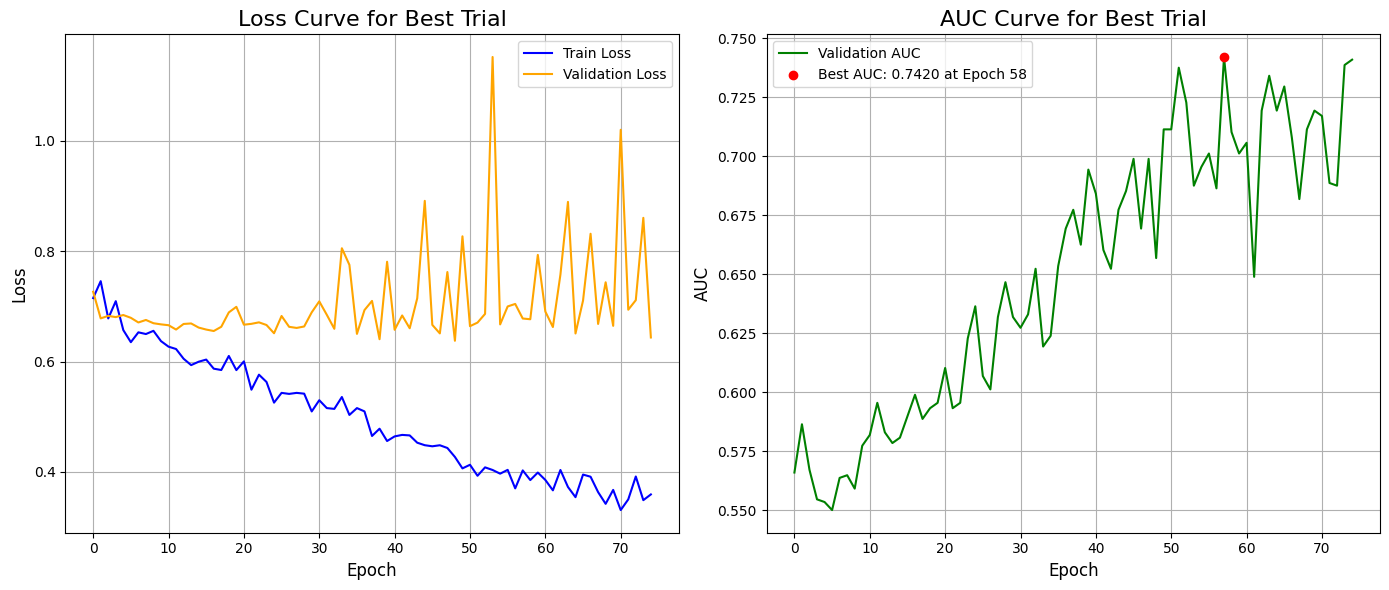

In [ ]:
# --- ⚙️ 라이브러리 임포트 ---
!pip install optuna -q
!pip install torch_geometric -q

import torch
import torch.nn.functional as F
from torch.nn import Linear, Sequential, ReLU, BatchNorm1d, Dropout
from torch_geometric.loader import DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import numpy as np
import optuna
from torch_geometric.nn import GINEConv, global_add_pool
import matplotlib.pyplot as plt # ⭐️ 시각화를 위한 라이브러리

# --- 설정 및 데이터 로딩 ---
# ⭐️ 3개의 전역 특징과 엣지 특징이 모두 포함된 데이터셋 경로입니다.
GRAPH_DATASET_PATH = "/content/drive/My Drive/PgpTextMining/pgp_graph_dataset_with_edges.pt"
print("Final Analysis: GINEConv (3 Global Feats) + 5-Fold CV + Visualization")
try:
    dataset = torch.load(GRAPH_DATASET_PATH, weights_only=False)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    num_node_features = dataset[0].num_node_features
    num_edge_features = dataset[0].num_edge_features
    num_global_features = dataset[0].global_feat.shape[1]

    print(f"  - {len(dataset)}개의 그래프 데이터를 로드했습니다. ({device} 사용)")
    print(f"  - 노드 특징 수: {num_node_features}, 엣지 특징 수: {num_edge_features}, 전역 특징 수: {num_global_features}")

except FileNotFoundError:
    print(f"오류: '{GRAPH_DATASET_PATH}'를 찾을 수 없습니다. 데이터 생성 코드를 먼저 실행해주세요.")
    exit()

# --- 🧠 GINE 모델 정의 (수정 없음) ---
class GINE_Model(torch.nn.Module):
    def __init__(self, num_node_features, num_edge_features, num_global_features, hidden_channels, dropout_rate):
        super(GINE_Model, self).__init__()
        mlp1 = Sequential(Linear(num_node_features, hidden_channels), BatchNorm1d(hidden_channels), ReLU(), Linear(hidden_channels, hidden_channels))
        self.conv1 = GINEConv(mlp1, edge_dim=num_edge_features)
        mlp2 = Sequential(Linear(hidden_channels, hidden_channels), BatchNorm1d(hidden_channels), ReLU(), Linear(hidden_channels, hidden_channels))
        self.conv2 = GINEConv(mlp2, edge_dim=num_edge_features)
        self.combined_dim = hidden_channels + num_global_features
        self.fc1 = Linear(self.combined_dim, hidden_channels)
        self.bn1 = BatchNorm1d(hidden_channels)
        self.fc2 = Linear(hidden_channels, 2)
        self.dropout = Dropout(p=dropout_rate)

    def forward(self, x, edge_index, batch, edge_attr, global_feat):
        x = self.conv1(x, edge_index, edge_attr=edge_attr).relu()
        x = self.conv2(x, edge_index, edge_attr=edge_attr).relu()
        gnn_out = global_add_pool(x, batch)
        combined = torch.cat([gnn_out, global_feat], dim=1)
        x = self.fc1(combined); x = self.bn1(x); x = F.relu(x); x = self.dropout(x)
        x = self.fc2(x)
        return x

# --- 🤖 Optuna 목적 함수 (⭐️ 학습 곡선 기록 기능 추가) ---
def objective(trial):
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    hidden_channels = trial.suggest_categorical('hidden_channels', [32, 64, 128])
    batch_size = trial.suggest_categorical('batch_size', [16, 32])
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.6)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    labels = np.array([data.y.item() for data in dataset])
    fold_aucs = []

    # 마지막 Fold의 학습 기록을 저장하기 위한 변수
    last_fold_history = {}

    for fold, (train_idx, val_idx) in enumerate(skf.split(np.arange(len(dataset)), labels)):
        model = GINE_Model(num_node_features, num_edge_features, num_global_features, hidden_channels, dropout_rate).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        criterion = torch.nn.CrossEntropyLoss()
        train_loader = DataLoader([dataset[i] for i in train_idx], batch_size=batch_size, shuffle=True, drop_last=True)
        val_loader = DataLoader([dataset[i] for i in val_idx], batch_size=batch_size, drop_last=True)

        # 매 Epoch의 점수를 기록할 리스트
        train_losses, val_losses, val_aucs = [], [], []

        for epoch in range(75):
            model.train()
            epoch_train_loss = 0
            for data in train_loader:
                data = data.to(device)
                optimizer.zero_grad()
                out = model(data.x, data.edge_index, data.batch, data.edge_attr, data.global_feat)
                loss = criterion(out, data.y)
                loss.backward()
                optimizer.step()
                epoch_train_loss += loss.item()
            train_losses.append(epoch_train_loss / len(train_loader))

            model.eval()
            epoch_val_loss = 0
            all_labels, all_probs = [], []
            with torch.no_grad():
                for data in val_loader:
                    data = data.to(device)
                    out = model(data.x, data.edge_index, data.batch, data.edge_attr, data.global_feat)
                    loss = criterion(out, data.y)
                    epoch_val_loss += loss.item()
                    all_labels.extend(data.y.cpu().tolist())
                    all_probs.extend(F.softmax(out, dim=1).cpu()[:, 1].tolist())

            if not all_labels: continue
            val_losses.append(epoch_val_loss / len(val_loader))
            val_aucs.append(roc_auc_score(all_labels, all_probs))

        # 마지막 Fold의 history를 저장
        if fold == skf.get_n_splits() - 1:
            last_fold_history = {'train_loss': train_losses, 'val_loss': val_losses, 'val_auc': val_aucs}

        fold_aucs.append(val_aucs[-1]) # 마지막 epoch의 auc를 fold의 최종 점수로 기록

    trial.set_user_attr("history", last_fold_history)

    if not fold_aucs: return 0.0
    return np.mean(fold_aucs)

# --- 🏃‍♂️ Optuna Study 실행 ---
study = optuna.create_study(direction='maximize', study_name='gine_3feats_5fold_final')
study.optimize(objective, n_trials=30)

print("\n--- GINE 모델 (3 Features) + 최종 데이터 Optuna 탐색 완료 ---")
print(f"최고의 평균 AUC: {study.best_value:.4f}")
print("최적의 하이퍼파라미터:")
print(study.best_params)

# --- 📊 학습 곡선 시각화 ---
print("\n--- 최고 성능 Trial의 학습 곡선 ---")
# 최적의 성능을 보였던 Trial의 학습 기록 가져오기
best_history = study.best_trial.user_attrs["history"]

if best_history:
    plt.figure(figsize=(14, 6))

    # Loss 그래프
    plt.subplot(1, 2, 1)
    plt.plot(best_history['train_loss'], label='Train Loss', color='blue')
    plt.plot(best_history['val_loss'], label='Validation Loss', color='orange')
    plt.title('Loss Curve for Best Trial', fontsize=16)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend()
    plt.grid(True)

    # AUC 그래프
    plt.subplot(1, 2, 2)
    plt.plot(best_history['val_auc'], label='Validation AUC', color='green')
    # 가장 높은 AUC 지점 표시
    best_auc_epoch = np.argmax(best_history['val_auc'])
    best_auc_value = np.max(best_history['val_auc'])
    plt.scatter(best_auc_epoch, best_auc_value, color='red', zorder=5, label=f'Best AUC: {best_auc_value:.4f} at Epoch {best_auc_epoch+1}')
    plt.title('AUC Curve for Best Trial', fontsize=16)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('AUC', fontsize=12)
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
else:
    print("학습 기록을 찾을 수 없습니다.")

[I 2025-07-22 01:47:05,379] A new study created in memory with name: gine_3feats_dropout_final



--- Optuna 최적화 실행 ---


[I 2025-07-22 01:48:16,477] Trial 0 finished with value: 0.7851796536796537 and parameters: {'lr': 0.0001330926294897379, 'hidden_channels': 32, 'batch_size': 16, 'dropout_rate': 0.311878833465945}. Best is trial 0 with value: 0.7851796536796537.
[I 2025-07-22 01:49:50,241] Trial 1 finished with value: 0.8141214779372674 and parameters: {'lr': 0.0018983637462706836, 'hidden_channels': 128, 'batch_size': 32, 'dropout_rate': 0.22324634619916137}. Best is trial 1 with value: 0.8141214779372674.
[I 2025-07-22 01:50:56,860] Trial 2 finished with value: 0.7674408369408369 and parameters: {'lr': 0.001251845804859791, 'hidden_channels': 32, 'batch_size': 16, 'dropout_rate': 0.4006549765187606}. Best is trial 1 with value: 0.8141214779372674.
[I 2025-07-22 01:52:18,533] Trial 3 finished with value: 0.7501248196248196 and parameters: {'lr': 0.004510528529784544, 'hidden_channels': 64, 'batch_size': 16, 'dropout_rate': 0.38408026276501783}. Best is trial 1 with value: 0.8141214779372674.
[I 2025-


--- [Dropout 적용] GINE 모델 Optuna 탐색 완료 ---
최고의 평균 AUC: 0.8456
최적의 하이퍼파라미터:
{'lr': 0.0001772274350916343, 'hidden_channels': 64, 'batch_size': 32, 'dropout_rate': 0.10298508111929974}

--- 최고 성능 Trial의 학습 곡선 ---


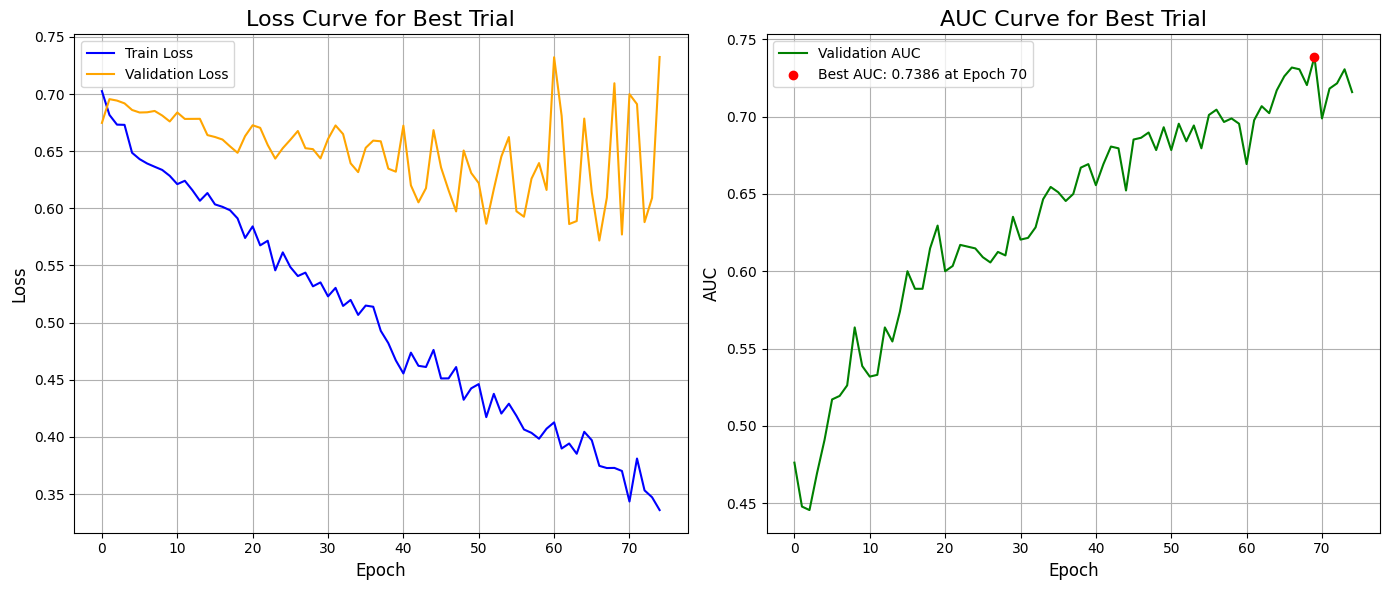

In [ ]:
# --- 최종 Optuna 및 시각화 코드 셀 ---

if 'dataset' in locals() and dataset is not None:
    # --- 라이브러리 임포트 ---
    !pip install optuna -q
    !pip install torch_geometric -q

    import torch
    import torch.nn.functional as F
    from torch.nn import Linear, Sequential, ReLU, BatchNorm1d, Dropout
    from torch_geometric.loader import DataLoader
    from sklearn.model_selection import StratifiedKFold
    from sklearn.metrics import roc_auc_score
    import numpy as np
    import optuna
    from torch_geometric.nn import GINEConv, global_add_pool
    import matplotlib.pyplot as plt

    # --- 전역 변수 설정 ---
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    num_node_features = dataset[0].num_node_features
    num_edge_features = dataset[0].num_edge_features
    num_global_features = dataset[0].global_feat.shape[1]

    # --- 모델 정의 (Dropout 적용) ---
    class GINE_Model(torch.nn.Module):
        def __init__(self, num_node_features, num_edge_features, num_global_features, hidden_channels, dropout_rate):
            super(GINE_Model, self).__init__()
            mlp1 = Sequential(Linear(num_node_features, hidden_channels), BatchNorm1d(hidden_channels), ReLU(), Linear(hidden_channels, hidden_channels))
            self.conv1 = GINEConv(mlp1, edge_dim=num_edge_features)
            mlp2 = Sequential(Linear(hidden_channels, hidden_channels), BatchNorm1d(hidden_channels), ReLU(), Linear(hidden_channels, hidden_channels))
            self.conv2 = GINEConv(mlp2, edge_dim=num_edge_features)
            self.combined_dim = hidden_channels + num_global_features
            self.fc1 = Linear(self.combined_dim, hidden_channels)
            self.bn1 = BatchNorm1d(hidden_channels)
            self.fc2 = Linear(hidden_channels, 2)
            self.dropout = Dropout(p=dropout_rate)

        def forward(self, x, edge_index, batch, edge_attr, global_feat):
            x = self.conv1(x, edge_index, edge_attr=edge_attr).relu()
            x = self.conv2(x, edge_index, edge_attr=edge_attr).relu()
            gnn_out = global_add_pool(x, batch)
            combined = torch.cat([gnn_out, global_feat], dim=1)
            x = self.fc1(combined); x = self.bn1(x); x = F.relu(x); x = self.dropout(x)
            x = self.fc2(x)
            return x

    # --- Optuna 목적 함수 ---
    def objective(trial):
        lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
        hidden_channels = trial.suggest_categorical('hidden_channels', [32, 64, 128])
        batch_size = trial.suggest_categorical('batch_size', [16, 32])
        dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        labels = np.array([data.y.item() for data in dataset])
        fold_aucs, last_fold_history = [], {}
        for fold, (train_idx, val_idx) in enumerate(skf.split(np.arange(len(dataset)), labels)):
            model = GINE_Model(num_node_features, num_edge_features, num_global_features, hidden_channels, dropout_rate).to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
            criterion = torch.nn.CrossEntropyLoss()
            train_loader = DataLoader([dataset[i] for i in train_idx], batch_size=batch_size, shuffle=True, drop_last=True)
            val_loader = DataLoader([dataset[i] for i in val_idx], batch_size=batch_size, drop_last=True)
            train_losses, val_losses, val_aucs = [], [], []
            for epoch in range(75):
                model.train()
                epoch_train_loss = 0
                for data in train_loader:
                    data = data.to(device)
                    optimizer.zero_grad()
                    out = model(data.x, data.edge_index, data.batch, data.edge_attr, data.global_feat)
                    loss = criterion(out, data.y)
                    loss.backward()
                    optimizer.step()
                    epoch_train_loss += loss.item()
                train_losses.append(epoch_train_loss / len(train_loader))
                model.eval()
                epoch_val_loss = 0
                all_labels, all_probs = [], []
                with torch.no_grad():
                    for data in val_loader:
                        data = data.to(device)
                        out = model(data.x, data.edge_index, data.batch, data.edge_attr, data.global_feat)
                        loss = criterion(out, data.y)
                        epoch_val_loss += loss.item()
                        all_labels.extend(data.y.cpu().tolist())
                        all_probs.extend(F.softmax(out, dim=1).cpu()[:, 1].tolist())
                if not all_labels: continue
                val_losses.append(epoch_val_loss / len(val_loader))
                val_aucs.append(roc_auc_score(all_labels, all_probs))
            if fold == skf.get_n_splits() - 1:
                last_fold_history = {'train_loss': train_losses, 'val_loss': val_losses, 'val_auc': val_aucs}
            fold_aucs.append(val_aucs[-1])
        trial.set_user_attr("history", last_fold_history)
        if not fold_aucs: return 0.0
        return np.mean(fold_aucs)

    # --- Optuna Study 실행 ---
    print("\n--- Optuna 최적화 실행 ---")
    study = optuna.create_study(direction='maximize', study_name='gine_3feats_dropout_final')
    study.optimize(objective, n_trials=30)
    print("\n--- [Dropout 적용] GINE 모델 Optuna 탐색 완료 ---")
    print(f"최고의 평균 AUC: {study.best_value:.4f}")
    print("최적의 하이퍼파라미터:")
    print(study.best_params)

    # --- 학습 곡선 시각화 ---
    print("\n--- 최고 성능 Trial의 학습 곡선 ---")
    best_history = study.best_trial.user_attrs.get("history", {})
    if best_history:
        plt.figure(figsize=(14, 6))
        plt.subplot(1, 2, 1)
        plt.plot(best_history['train_loss'], label='Train Loss', color='blue')
        plt.plot(best_history['val_loss'], label='Validation Loss', color='orange')
        plt.title('Loss Curve for Best Trial', fontsize=16)
        plt.xlabel('Epoch', fontsize=12)
        plt.ylabel('Loss', fontsize=12)
        plt.legend()
        plt.grid(True)
        plt.subplot(1, 2, 2)
        plt.plot(best_history['val_auc'], label='Validation AUC', color='green')
        best_auc_epoch = np.argmax(best_history['val_auc'])
        best_auc_value = np.max(best_history['val_auc'])
        plt.scatter(best_auc_epoch, best_auc_value, color='red', zorder=5, label=f'Best AUC: {best_auc_value:.4f} at Epoch {best_auc_epoch+1}')
        plt.title('AUC Curve for Best Trial', fontsize=16)
        plt.xlabel('Epoch', fontsize=12)
        plt.ylabel('AUC', fontsize=12)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        print("학습 기록을 찾을 수 없습니다.")

else:
    print("\n데이터셋이 로드되지 않았습니다. Optuna 최적화를 건너뜁니다.")

--- 최종 모델 훈련 및 평가 시작 ---
✅ 최적 하이퍼파라미터 로드 완료: {'lr': 0.0001772274350916343, 'hidden_channels': 64, 'batch_size': 32, 'dropout_rate': 0.10298508111929974}
  - 훈련 데이터: 353개
  - 테스트 데이터: 89개
✅ 모델 생성 완료. 훈련을 시작합니다.

--- 모델 훈련 시작 (Epochs: 70) ---
✅ 모델 훈련 완료!

--- 최종 모델 성능 평가 (테스트 데이터) ---
- Test Accuracy (정확도): 0.7812
- Test AUC (Area Under Curve): 0.8602

- Classification Report:
               precision    recall  f1-score   support

Non-Inhibitor       0.81      0.71      0.76        31
    Inhibitor       0.76      0.85      0.80        33

     accuracy                           0.78        64
    macro avg       0.79      0.78      0.78        64
 weighted avg       0.78      0.78      0.78        64



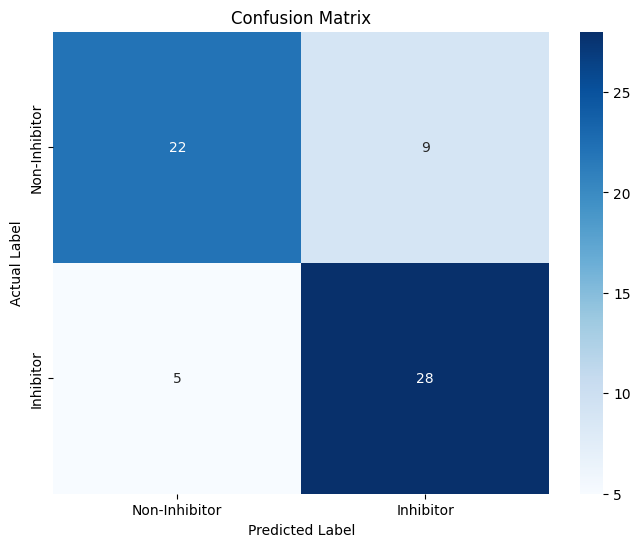

In [ ]:
# --- 라이브러리 임포트 ---
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.loader import DataLoader

# --- 1. 데이터 분할 및 최적 파라미터 로드 ---
print("--- 최종 모델 훈련 및 평가 시작 ---")

# Optuna study에서 최적의 하이퍼파라미터 가져오기
best_params = study.best_params
print(f"✅ 최적 하이퍼파라미터 로드 완료: {best_params}")

# 전체 데이터를 훈련(80%) 및 테스트(20%) 세트로 분할
labels = np.array([data.y.item() for data in dataset])
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42, stratify=labels)

print(f"  - 훈련 데이터: {len(train_dataset)}개")
print(f"  - 테스트 데이터: {len(test_dataset)}개")

# --- 2. 최적 파라미터로 모델 생성 및 훈련 ---
# **best_params로 모든 정보를 넘기는 대신, 모델 생성에 필요한 파라미터만 명시적으로 전달합니다.
final_model = GINE_Model(
    num_node_features=num_node_features,
    num_edge_features=num_edge_features,
    num_global_features=num_global_features,
    hidden_channels=best_params['hidden_channels'],
    dropout_rate=best_params['dropout_rate']
).to(device)

# optimizer와 loader를 만들 때는 best_params에서 각각 필요한 정보를 가져와 사용합니다.
optimizer = torch.optim.Adam(final_model.parameters(), lr=best_params['lr'])
criterion = torch.nn.CrossEntropyLoss()
train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=best_params['batch_size'], drop_last=True)

print(f"✅ 모델 생성 완료. 훈련을 시작합니다.")

# 이전 학습 곡선에서 확인한 최적의 epoch 근처로 훈련 (예: 70)
print("\n--- 모델 훈련 시작 (Epochs: 70) ---")
for epoch in range(70):
    final_model.train()
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = final_model(data.x, data.edge_index, data.batch, data.edge_attr, data.global_feat)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()

print("✅ 모델 훈련 완료!")

# --- 3. 테스트 데이터로 최종 성능 평가 ---
print("\n--- 최종 모델 성능 평가 (테스트 데이터) ---")
final_model.eval()
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        out = final_model(data.x, data.edge_index, data.batch, data.edge_attr, data.global_feat)
        preds = out.argmax(dim=1)
        probs = F.softmax(out, dim=1)[:, 1]

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(data.y.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# --- 4. 최종 결과 리포트 ---
# 테스트 로더가 비어있을 경우를 대비한 방어 코드
if not all_labels:
    print("오류: 테스트 데이터가 없어 평가를 진행할 수 없습니다.")
else:
    test_auc = roc_auc_score(all_labels, all_probs)
    test_accuracy = accuracy_score(all_labels, all_preds)

    print(f"- Test Accuracy (정확도): {test_accuracy:.4f}")
    print(f"- Test AUC (Area Under Curve): {test_auc:.4f}")
    print("\n- Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=['Non-Inhibitor', 'Inhibitor']))

    # Confusion Matrix 시각화
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Inhibitor', 'Inhibitor'], yticklabels=['Non-Inhibitor', 'Inhibitor'])
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

Mounted at /content/drive
초기 접근법(Inhibitor vs Substrate) 모델 최적화 시작...


[I 2025-07-25 06:32:31,611] A new study created in memory with name: gine_initial_method_loss_min


  - 442개의 그래프 데이터를 로드했습니다. (cpu 사용)

--- Optuna 최적화 실행 (목표: Validation Loss 최소화) ---


[I 2025-07-25 06:35:46,397] Trial 0 finished with value: 0.9921187150478363 and parameters: {'lr': 0.002014228161002811, 'hidden_channels': 128, 'batch_size': 16, 'dropout_rate': 0.38992637105746564}. Best is trial 0 with value: 0.9921187150478363.
[I 2025-07-25 06:38:59,555] Trial 1 finished with value: 0.8547490656375885 and parameters: {'lr': 0.0010443743187587456, 'hidden_channels': 128, 'batch_size': 16, 'dropout_rate': 0.35501024385395036}. Best is trial 1 with value: 0.8547490656375885.
[I 2025-07-25 06:40:04,974] Trial 2 finished with value: 0.7928907990455627 and parameters: {'lr': 0.0014518012693904884, 'hidden_channels': 32, 'batch_size': 32, 'dropout_rate': 0.2407467302398022}. Best is trial 2 with value: 0.7928907990455627.
[I 2025-07-25 06:42:33,948] Trial 3 finished with value: 0.9526777356863022 and parameters: {'lr': 0.0017807579424778187, 'hidden_channels': 128, 'batch_size': 32, 'dropout_rate': 0.27418784835143606}. Best is trial 2 with value: 0.7928907990455627.
[I 


--- [Loss 최소화] 초기 접근법 모델 Optuna 탐색 완료 ---
최저 평균 Validation Loss (5-fold CV): 0.5361
최적의 하이퍼파라미터:
{'lr': 0.00015731802932570854, 'hidden_channels': 64, 'batch_size': 32, 'dropout_rate': 0.5368405614306052}

--- 최고 성능 Trial의 학습 곡선 ---


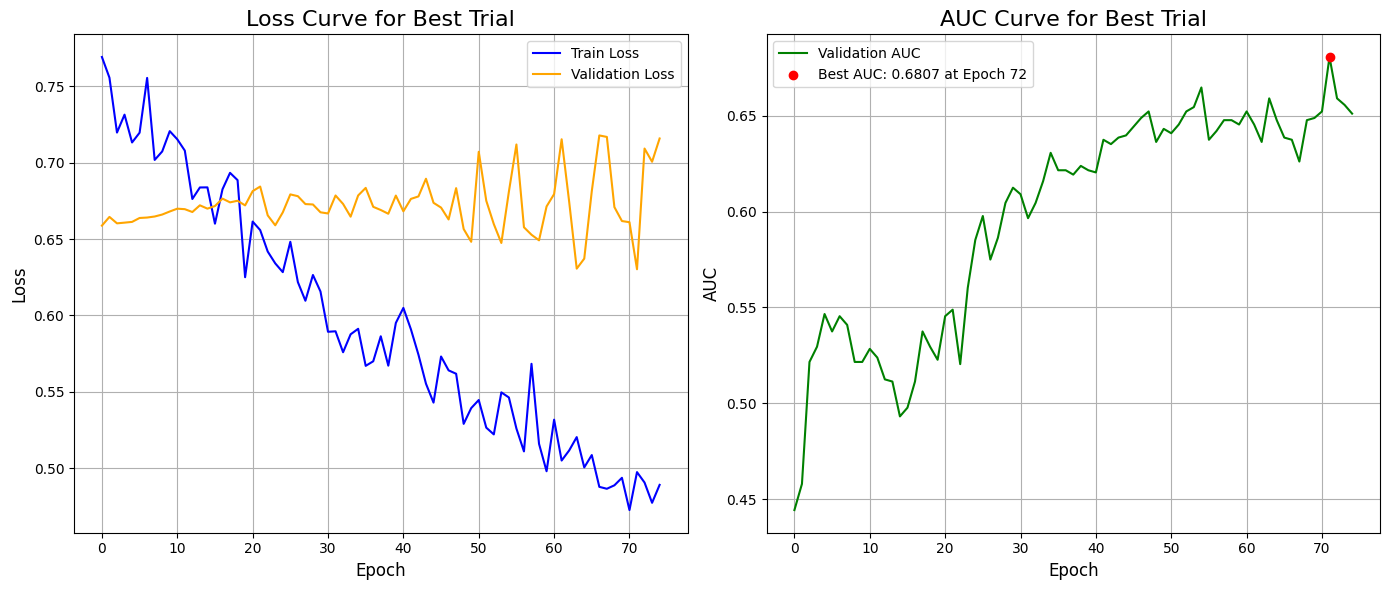

In [ ]:
# --- 라이브러리 임포트 ---
import torch
import torch.nn.functional as F
from torch.nn import Linear, Sequential, ReLU, BatchNorm1d, Dropout
from torch_geometric.loader import DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import numpy as np
import optuna
from torch_geometric.nn import GINEConv, global_add_pool
import matplotlib.pyplot as plt
from google.colab import drive
import os # ✨✨✨ 이 줄이 추가되었습니다. ✨✨✨

# --- 설정 및 데이터 로딩 ---
drive.mount('/content/drive', force_remount=True)
BASE_DIR = "/content/drive/My Drive/PgpTextMining"
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# ✨ 초기 접근법에서 사용했던, 엣지 특징이 포함된 데이터셋 경로입니다.
GRAPH_DATASET_PATH = os.path.join(BASE_DIR, "pgp_graph_dataset_with_edges.pt")

print("초기 접근법(Inhibitor vs Substrate) 모델 최적화 시작...")
try:
    dataset = torch.load(GRAPH_DATASET_PATH, weights_only=False)
    num_node_features = dataset[0].num_node_features
    num_edge_features = dataset[0].num_edge_features
    num_global_features = dataset[0].global_feat.shape[1]
    print(f"  - {len(dataset)}개의 그래프 데이터를 로드했습니다. ({DEVICE} 사용)")
except FileNotFoundError:
    print(f"오류: '{GRAPH_DATASET_PATH}'를 찾을 수 없습니다. 데이터 생성 코드를 먼저 실행해주세요.")
    exit()

# --- GINE 모델 정의 (수정 없음) ---
class GINE_Model(torch.nn.Module):
    def __init__(self, num_node_features, num_edge_features, num_global_features, hidden_channels, dropout_rate):
        super(GINE_Model, self).__init__()
        mlp1 = Sequential(Linear(num_node_features, hidden_channels), BatchNorm1d(hidden_channels), ReLU(), Linear(hidden_channels, hidden_channels))
        self.conv1 = GINEConv(mlp1, edge_dim=num_edge_features)
        mlp2 = Sequential(Linear(hidden_channels, hidden_channels), BatchNorm1d(hidden_channels), ReLU(), Linear(hidden_channels, hidden_channels))
        self.conv2 = GINEConv(mlp2, edge_dim=num_edge_features)
        self.combined_dim = hidden_channels + num_global_features
        self.fc1 = Linear(self.combined_dim, hidden_channels)
        self.bn1 = BatchNorm1d(hidden_channels)
        self.fc2 = Linear(hidden_channels, 2)
        self.dropout = Dropout(p=dropout_rate)

    def forward(self, x, edge_index, batch, edge_attr, global_feat):
        x = self.conv1(x, edge_index, edge_attr=edge_attr).relu()
        x = self.conv2(x, edge_index, edge_attr=edge_attr).relu()
        gnn_out = global_add_pool(x, batch)
        combined = torch.cat([gnn_out, global_feat], dim=1)
        x = self.fc1(combined); x = self.bn1(x); x = F.relu(x); x = self.dropout(x)
        x = self.fc2(x)
        return x

# --- Optuna 목적 함수 (피드백 적용) ---
def objective(trial, dataset):
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    hidden_channels = trial.suggest_categorical('hidden_channels', [32, 64, 128])
    batch_size = trial.suggest_categorical('batch_size', [16, 32])
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.6)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    labels = np.array([data.y.item() for data in dataset])
    fold_val_losses, last_fold_history = [], {}

    for fold, (train_idx, val_idx) in enumerate(skf.split(np.arange(len(dataset)), labels), 1):
        model = GINE_Model(num_node_features, num_edge_features, num_global_features, hidden_channels, dropout_rate).to(DEVICE)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        criterion = torch.nn.CrossEntropyLoss()
        train_loader = DataLoader([dataset[i] for i in train_idx], batch_size=batch_size, shuffle=True, drop_last=True)
        val_loader = DataLoader([dataset[i] for i in val_idx], batch_size=batch_size, drop_last=True)
        train_losses, val_losses, val_aucs = [], [], []

        for epoch in range(75):
            model.train()
            epoch_train_loss = 0
            for data in train_loader:
                data = data.to(DEVICE); optimizer.zero_grad()
                out = model(data.x, data.edge_index, data.batch, data.edge_attr, data.global_feat)
                loss = criterion(out, data.y); loss.backward(); optimizer.step()
                epoch_train_loss += loss.item()
            if len(train_loader) > 0: train_losses.append(epoch_train_loss / len(train_loader))

            model.eval()
            epoch_val_loss = 0
            all_labels, all_probs = [], []
            with torch.no_grad():
                for data in val_loader:
                    data = data.to(DEVICE)
                    out = model(data.x, data.edge_index, data.batch, data.edge_attr, data.global_feat)
                    loss = criterion(out, data.y)
                    epoch_val_loss += loss.item()
                    all_labels.extend(data.y.cpu().tolist())
                    all_probs.extend(F.softmax(out, dim=1).cpu()[:, 1].tolist())

            if not all_labels: continue
            if len(val_loader) > 0: val_losses.append(epoch_val_loss / len(val_loader))
            val_aucs.append(roc_auc_score(all_labels, all_probs))

        if val_losses: fold_val_losses.append(val_losses[-1])
        if fold == skf.get_n_splits():
            last_fold_history = {'train_loss': train_losses, 'val_loss': val_losses, 'val_auc': val_aucs}

    trial.set_user_attr("history", last_fold_history)
    if not fold_val_losses: return float('inf')
    return np.mean(fold_val_losses)

# --- Optuna Study 실행 (피드백 적용) ---
print("\n--- Optuna 최적화 실행 (목표: Validation Loss 최소화) ---")
study = optuna.create_study(direction='minimize', study_name='gine_initial_method_loss_min')
study.optimize(lambda trial: objective(trial, dataset), n_trials=30)

print("\n--- [Loss 최소화] 초기 접근법 모델 Optuna 탐색 완료 ---")
print(f"최저 평균 Validation Loss (5-fold CV): {study.best_value:.4f}")
print("최적의 하이퍼파라미터:")
print(study.best_params)

# --- 학습 곡선 시각화 ---
print("\n--- 최고 성능 Trial의 학습 곡선 ---")
best_history = study.best_trial.user_attrs.get("history", {})
if best_history and best_history.get('train_loss'):
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(best_history['train_loss'], label='Train Loss', color='blue')
    plt.plot(best_history['val_loss'], label='Validation Loss', color='orange')
    plt.title('Loss Curve for Best Trial', fontsize=16)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(); plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(best_history['val_auc'], label='Validation AUC', color='green')
    best_auc_epoch = np.argmax(best_history['val_auc'])
    best_auc_value = np.max(best_history['val_auc'])
    plt.scatter(best_auc_epoch, best_auc_value, color='red', zorder=5, label=f'Best AUC: {best_auc_value:.4f} at Epoch {best_auc_epoch+1}')
    plt.title('AUC Curve for Best Trial', fontsize=16)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('AUC', fontsize=12)
    plt.legend(); plt.grid(True)

    plt.tight_layout(); plt.show()
else:
    print("학습 기록을 찾을 수 없습니다.")